## 1. Setup & Import Libraries

In [ ]:
!pip install -q pyabsa matplotlib seaborn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 574.2/574.2 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 18.5 MB/s eta 0:00:00


In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

In [ ]:
import os
os.environ["GIT_PYTHON_REFRESH"] = "quiet"

print(" Git error workaround applied")

 Git error workaround applied


In [ ]:
import sys
import torch

print("=" * 70)
print("DIAGNOSTIC: Python & PyTorch Configuration")
print("=" * 70)
print(f"Python Executable: {sys.executable}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available in Notebook: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
    print(f"Current Device: {torch.cuda.get_device_name(0)}")
print("=" * 70)

DIAGNOSTIC: Python & PyTorch Configuration
Python Executable: /usr/bin/python3
PyTorch Version: 2.9.0+cu126
CUDA Available in Notebook: True
CUDA Device Count: 1
Current Device: Tesla T4


In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import shutil
import os
from datetime import datetime
from collections import Counter, defaultdict
from pathlib import Path
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)
from pyabsa import AspectPolarityClassification as APC
from pyabsa import APCCheckpointManager

print("✓ All imports successful")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[2026-01-06 14:41:02] (2.4.2) PyABSA(2.4.2): If your code crashes on Colab, please use the GPU runtime. Then run "pip install pyabsa[dev] -U" and restart the kernel.
Or if it does not work, you can use v1.x versions, e.g., pip install pyabsa<2.0 -U




Try to downgrade transformers<=4.29.0.




✓ All imports successful


### colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = Path("/content/drive/MyDrive/Output_ABSA")

CHECKPOINT_ITERATIVE = BASE_DIR / "checkpoints_iterative"
RESULTS_ITERATIVE = BASE_DIR / "results_iterative"
FIGURES_ITERATIVE = BASE_DIR / "figures_iterative"
DATASET_ITERATIVE = BASE_DIR / "dataset_iterative"
DATASET_GOLD = BASE_DIR / "dataset"

CHECKPOINT_SKENARIO = BASE_DIR / "checkpoints_skenario"
RESULTS_SKENARIO = BASE_DIR / "results_skenario"
FIGURES_SKENARIO = BASE_DIR / "figures_skenario"
DATASET_SKENARIO = BASE_DIR / "dataset_skenario"

all_dirs = [
    CHECKPOINT_ITERATIVE, RESULTS_ITERATIVE, FIGURES_ITERATIVE, DATASET_ITERATIVE,
    CHECKPOINT_SKENARIO, RESULTS_SKENARIO, FIGURES_SKENARIO, DATASET_SKENARIO
]

for d in all_dirs:
    d.mkdir(parents=True, exist_ok=True)

print(f"✓ All Directories Created")
print(f"\n BASE: {BASE_DIR}")
print(f"\n ITERATIVE PSEUDO-LABELING (Round 1-4):")
print(f"   Checkpoints: {CHECKPOINT_ITERATIVE}")
print(f"   Results:     {RESULTS_ITERATIVE}")
print(f"   Figures:     {FIGURES_ITERATIVE}")
print(f"   Dataset:     {DATASET_ITERATIVE}")
print(f"\n 14 SCENARIO TRAINING (S1-S14):")
print(f"   Checkpoints: {CHECKPOINT_SKENARIO}")
print(f"   Results:     {RESULTS_SKENARIO}")
print(f"   Figures:     {FIGURES_SKENARIO}")
print(f"   Dataset:     {DATASET_SKENARIO}")
print(f"   Dataset:     {DATASET_GOLD}")

✓ All Directories Created

 BASE: /content/drive/MyDrive/Output_ABSA

 ITERATIVE PSEUDO-LABELING (Round 1-4):
   Checkpoints: /content/drive/MyDrive/Output_ABSA/checkpoints_iterative
   Results:     /content/drive/MyDrive/Output_ABSA/results_iterative
   Figures:     /content/drive/MyDrive/Output_ABSA/figures_iterative
   Dataset:     /content/drive/MyDrive/Output_ABSA/dataset_iterative

 14 SCENARIO TRAINING (S1-S14):
   Checkpoints: /content/drive/MyDrive/Output_ABSA/checkpoints_skenario
   Results:     /content/drive/MyDrive/Output_ABSA/results_skenario
   Figures:     /content/drive/MyDrive/Output_ABSA/figures_skenario
   Dataset:     /content/drive/MyDrive/Output_ABSA/dataset_skenario
   Dataset:     /content/drive/MyDrive/Output_ABSA/dataset


## 2. Utility Functions

In [ ]:
def save_apc_triplets(data, path):
    """Simpan data ke format .apc PyABSA: $T$ text \n aspect \n polarity"""
    sentiment_map = {
        "negative": "0", "Negative": "0", "0": "0",
        "neutral": "1", "Neutral": "1", "1": "1",
        "positive": "2", "Positive": "2", "2": "2"
    }
    with open(path, "w", encoding="utf-8") as f:
        for d in data:
            text = d.get('text', '').strip()
            aspect = d.get('aspect', '').strip()
            sentiment = d.get('sentiment', '1')
            if not text or not aspect:
                continue
            if isinstance(sentiment, (int, float)):
                polarity = str(int(sentiment))
            else:
                polarity = sentiment_map.get(str(sentiment).strip(), "1")
            if polarity not in ["0", "1", "2"]:
                polarity = "1"
            f.write(f"$T$ {text}\n")
            f.write(f"{aspect}\n")
            f.write(f"{polarity}\n")
    print(f"  ✓ Saved {len(data)} samples to: {path.split('/')[-1]}")

def read_apc_triplets(path):
    """Baca data dari format .apc PyABSA"""
    samples = []
    sentiment_map = {
        "0": "0", "1": "1", "2": "2",
        "negative": "0", "Negative": "0",
        "neutral": "1", "Neutral": "1",
        "positive": "2", "Positive": "2"
    }
    try:
        lines = Path(path).read_text(encoding="utf-8").strip().split("\n")
    except:
        return samples
    i = 0
    while i < len(lines):
        if lines[i].startswith("$T$"):
            text = lines[i].replace("$T$", "").strip()
            if i + 2 < len(lines):
                aspect = lines[i + 1].strip()
                raw_label = lines[i + 2].strip()
                if raw_label in sentiment_map:
                    samples.append({
                        "text": text,
                        "aspect": aspect,
                        "sentiment": sentiment_map[raw_label]
                    })
            i += 3
        else:
            i += 1
    return samples

print("✓ Utility functions defined")

✓ Utility functions defined


## 3. Load Gold Standard Dataset (335 samples)

In [ ]:
GOLD_DATA_PATH = r"D:/ANBOW/New folder (3)/pyabsa_gold_dataset.apc"

all_gold = read_apc_triplets(GOLD_DATA_PATH)
print(f"✓ Loaded {len(all_gold)} gold standard samples")

aspek_list = sorted(set([d["aspect"] for d in all_gold]))
print(f"✓ Aspects found: {len(aspek_list)}")
for asp in aspek_list:
    print(f"   - {asp}")

✓ Loaded 335 gold standard samples
✓ Aspects found: 5
   - Fleksibilitas
   - Kebijakan dan Pelayanan Pemerintah
   - Keterwakilan
   - Kompetensi Menteri
   - Transparansi


## 4. Analyze & Visualize Dataset Distribution


 ANALYZING 335 GOLD DATASET DISTRIBUTION

Total samples: 335

Aspect Distribution:
  Fleksibilitas                       ->  28 (  8.4%)
  Kebijakan dan Pelayanan Pemerintah  -> 140 ( 41.8%)
  Keterwakilan                        ->  55 ( 16.4%)
  Kompetensi Menteri                  ->  75 ( 22.4%)
  Transparansi                        ->  37 ( 11.0%)

Sentiment Distribution:
  Negative   ->  95 ( 28.4%)
  Neutral    ->  56 ( 16.7%)
  Positive   -> 184 ( 54.9%)

✓ Visualization saved: 00_gold_distribution.png


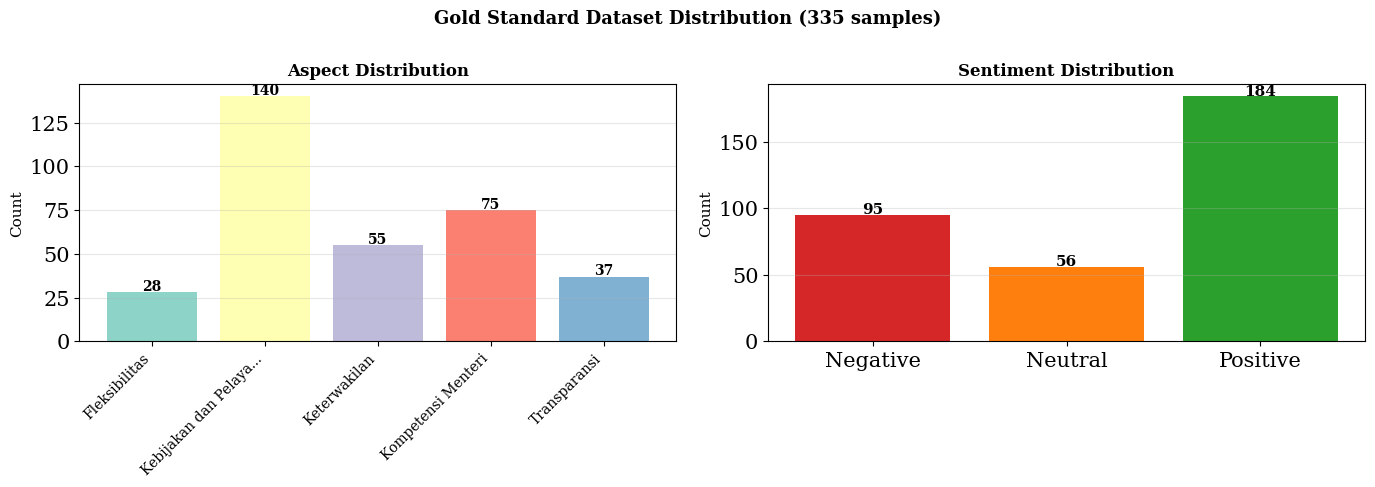

In [ ]:
print("\n" + "="*70)
print(" ANALYZING 335 GOLD DATASET DISTRIBUTION")
print("="*70 + "\n")

aspect_dist = Counter([d["aspect"] for d in all_gold])
sentiment_dist = Counter([d["sentiment"] for d in all_gold])

print(f"Total samples: {len(all_gold)}")
print(f"\nAspect Distribution:")
for asp in sorted(aspect_dist.keys()):
    count = aspect_dist[asp]
    pct = 100 * count / len(all_gold)
    print(f"  {asp:35} -> {count:3d} ({pct:5.1f}%)")

print(f"\nSentiment Distribution:")
sentiment_map = {"0": "Negative", "1": "Neutral", "2": "Positive"}
for sent_id in sorted(sentiment_dist.keys()):
    count = sentiment_dist[sent_id]
    pct = 100 * count / len(all_gold)
    print(f"  {sentiment_map[sent_id]:10} -> {count:3d} ({pct:5.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f'Gold Standard Dataset Distribution (335 samples)', fontsize=13, fontweight='bold')

ax = axes[0]
aspects = sorted(aspect_dist.keys())
counts_asp = [aspect_dist[asp] for asp in aspects]
colors_asp = plt.cm.Set3(range(len(aspects)))
bars = ax.bar(range(len(aspects)), counts_asp, color=colors_asp)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Aspect Distribution', fontsize=12, fontweight='bold')
ax.set_xticks(range(len(aspects)))
ax.set_xticklabels([asp[:20] + '...' if len(asp) > 20 else asp for asp in aspects], rotation=45, ha='right', fontsize=10)
ax.grid(axis='y', alpha=0.3)
for i, (bar, count) in enumerate(zip(bars, counts_asp)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, str(count), ha='center', fontweight='bold', fontsize=10)

ax = axes[1]
sentiments = [sentiment_map[s] for s in sorted(sentiment_dist.keys())]
counts_sent = [sentiment_dist[s] for s in sorted(sentiment_dist.keys())]
colors_sent = ['#d62728', '#ff7f0e', '#2ca02c']
bars = ax.bar(sentiments, counts_sent, color=colors_sent)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Sentiment Distribution', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, counts_sent):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, str(count), ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig(str(FIGURES_ITERATIVE / "00_gold_distribution.png"), dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved: 00_gold_distribution.png")
plt.show()

## 5. Split Data: 70% Train (235), 15% Val (50), 15% Test (50)
**CRITICAL**: Validation dan Test dari dataset GOLD tidak pernah disentuh oleh pseudo-label.

In [ ]:
print("\n" + "="*70)
print(" SPLITTING 335 GOLD DATA: 235 TRAIN / 50 VAL / 50 TEST")
print("="*70 + "\n")

random.seed(42)
np.random.seed(42)


by_aspect = defaultdict(list)
for d in all_gold:
    by_aspect[d["aspect"]].append(d)

train_data = []
val_data = []
test_data = []

# Fixed targets
TARGET_TEST_PER_ASPECT = 10
TARGET_TRAIN = 235
TARGET_VAL = 50

print(f" Split Target:")
print(f"   - Train: {TARGET_TRAIN} samples")
print(f"   - Val:   {TARGET_VAL} samples")
print(f"   - Test:  {TARGET_TEST_PER_ASPECT} per aspect × 5 = 50 (BALANCED)\n")

print(f"{'Aspect':<40} {'Test':>6} {'Val':>6} {'Train':>6} {'Total':>6}")
print("─" * 70)

for aspect in sorted(by_aspect.keys()):
    samples = by_aspect[aspect]
    random.shuffle(samples)

    n_test = min(TARGET_TEST_PER_ASPECT, len(samples))
    test_data.extend(samples[:n_test])
    by_aspect[aspect] = samples[n_test:]

remaining_total = sum(len(samples) for samples in by_aspect.values())

for aspect in sorted(by_aspect.keys()):
    samples = by_aspect[aspect]
    n = len(samples)

    aspect_val_ratio = n / remaining_total if remaining_total > 0 else 0
    n_val = round(TARGET_VAL * aspect_val_ratio)
    n_train = n - n_val

    val_data.extend(samples[:n_val])
    train_data.extend(samples[n_val:])

test_aspect_dist = Counter([d["aspect"] for d in test_data])
val_aspect_dist = Counter([d["aspect"] for d in val_data])
train_aspect_dist = Counter([d["aspect"] for d in train_data])

for aspect in sorted(by_aspect.keys()):
    t_test = test_aspect_dist.get(aspect, 0)
    t_val = val_aspect_dist.get(aspect, 0)
    t_train = train_aspect_dist.get(aspect, 0)
    total = t_test + t_val + t_train
    print(f"  {aspect:38} {t_test:>6} {t_val:>6} {t_train:>6} {total:>6}")

print("─" * 70)
print(f"{'TOTAL':<40} {len(test_data):>6} {len(val_data):>6} {len(train_data):>6} {len(all_gold):>6}")
print("─" * 70)

print(f"\n TEST BALANCE CHECK (target: {TARGET_TEST_PER_ASPECT} per aspect):")
for asp in sorted(test_aspect_dist.keys()):
    status = "✓ BALANCED" if test_aspect_dist[asp] == TARGET_TEST_PER_ASPECT else f"⚠️ {test_aspect_dist[asp]}"
    print(f"   {asp:38}: {test_aspect_dist[asp]:>3} samples {status}")

print(f"\n{'─'*70}")
print(f"FINAL SPLIT DISTRIBUTION:")
print(f"  Train: {len(train_data):3d} samples")
print(f"  Val:   {len(val_data):3d} samples")
print(f"  Test:  {len(test_data):3d} samples ← BALANCED per aspect")
print(f"  TOTAL: {len(train_data) + len(val_data) + len(test_data):3d} samples")
print(f"{'─'*70}\n")

save_apc_triplets(train_data, str(DATASET_ITERATIVE / "gold.train.apc"))
save_apc_triplets(val_data, str(DATASET_ITERATIVE / "gold.valid.apc"))
save_apc_triplets(test_data, str(DATASET_ITERATIVE / "gold.test.apc"))

print(f"✓ Saved: gold.train.apc ({len(train_data)} samples)")
print(f"✓ Saved: gold.valid.apc ({len(val_data)} samples)")
print(f"✓ Saved: gold.test.apc ({len(test_data)} samples) - BALANCED per aspect")


 SPLITTING 335 GOLD DATA: 235 TRAIN / 50 VAL / 50 TEST

 Split Target:
   - Train: 235 samples
   - Val:   50 samples
   - Test:  10 per aspect × 5 = 50 (BALANCED)

Aspect                                     Test    Val  Train  Total
──────────────────────────────────────────────────────────────────────
  Fleksibilitas                              10      3     15     28
  Kebijakan dan Pelayanan Pemerintah         10     23    107    140
  Keterwakilan                               10      8     37     55
  Kompetensi Menteri                         10     11     54     75
  Transparansi                               10      5     22     37
──────────────────────────────────────────────────────────────────────
TOTAL                                        50     50    235    335
──────────────────────────────────────────────────────────────────────

 TEST BALANCE CHECK (target: 10 per aspect):
   Fleksibilitas                         :  10 samples ✓ BALANCED
   Kebijakan dan Pelayanan


 VISUALIZING TRAIN/VAL/TEST SPLIT



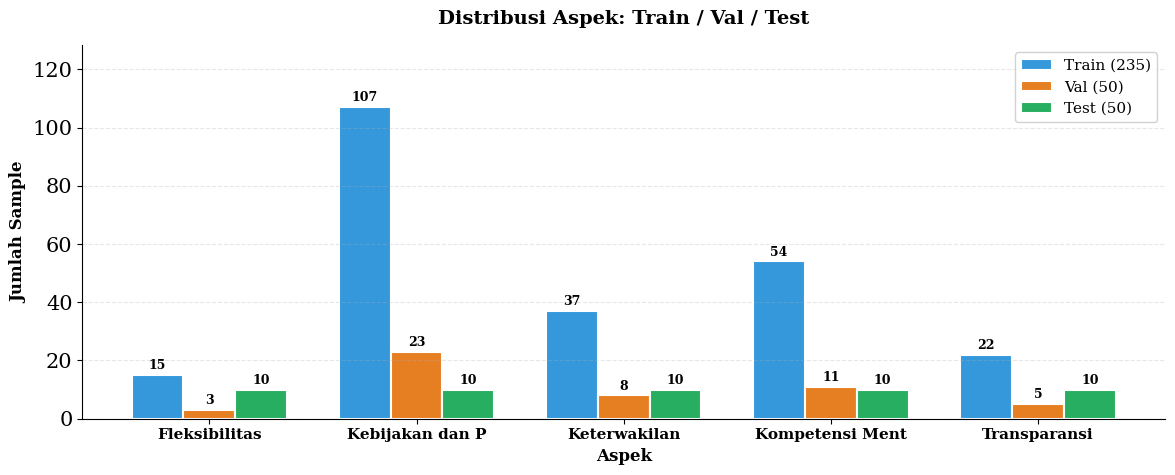

Saved: 01a_aspect_distribution.png


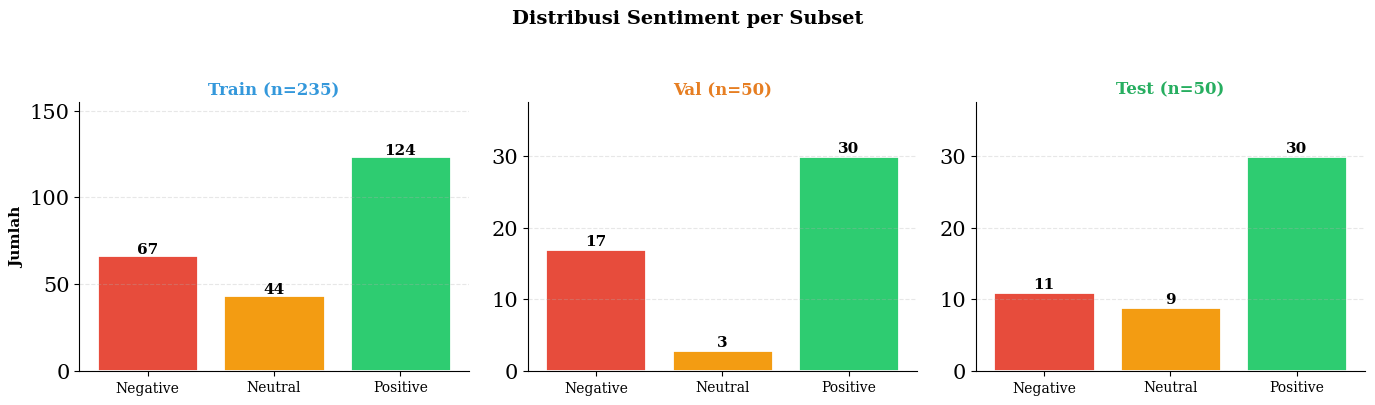

Saved: 01b_sentiment_distribution.png


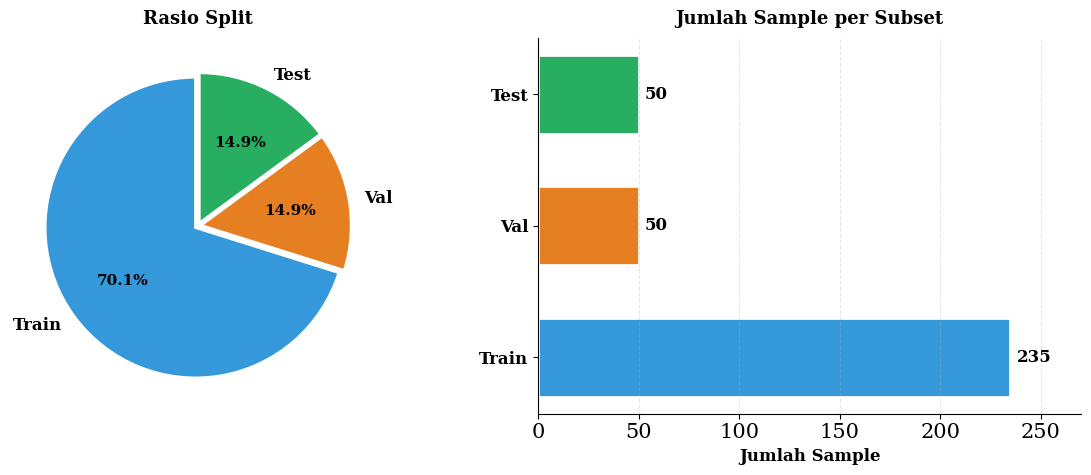

Saved: 01c_split_ratio.png


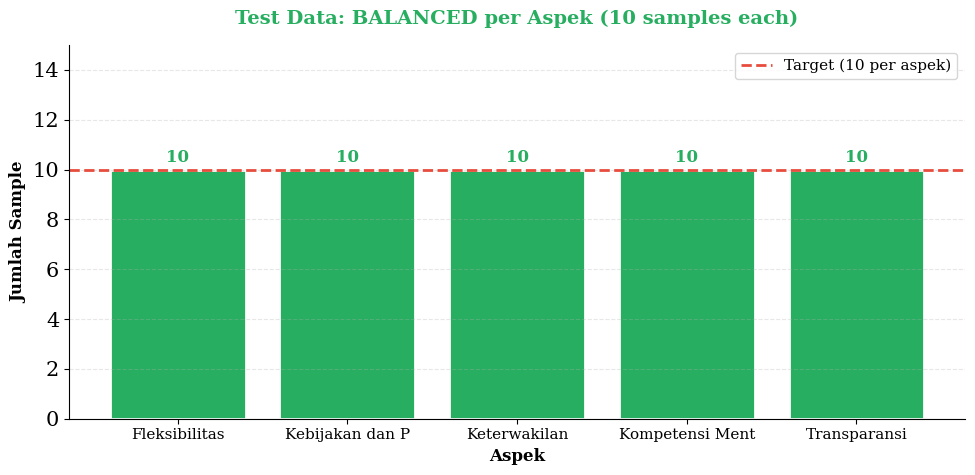

Saved: 01d_test_balanced.png

 DETAILED SPLIT SUMMARY

Distribusi Aspek:
Aspek                                  Train      Val     Test    Total
----------------------------------------------------------------------
Fleksibilitas                             15        3    10 [OK]     28
Kebijakan dan Pelayanan Pemerintah       107       23    10 [OK]    140
Keterwakilan                              37        8    10 [OK]     55
Kompetensi Menteri                        54       11    10 [OK]     75
Transparansi                              22        5    10 [OK]     37
----------------------------------------------------------------------
TOTAL                                    235       50       50      335

Distribusi Sentiment:
Sentiment               Train      Val     Test
-------------------------------------------------------
Negative                   67       17       11
Neutral                    44        3        9
Positive                  124       30       30
----------

In [ ]:
print("\n" + "="*70)
print(" VISUALIZING TRAIN/VAL/TEST SPLIT")
print("="*70 + "\n")

# Count distribution per subset
train_aspects = Counter([d["aspect"] for d in train_data])
val_aspects = Counter([d["aspect"] for d in val_data])
test_aspects = Counter([d["aspect"] for d in test_data])

train_sentiments = Counter([d["sentiment"] for d in train_data])
val_sentiments = Counter([d["sentiment"] for d in val_data])
test_sentiments = Counter([d["sentiment"] for d in test_data])

sentiment_map = {"0": "Negative", "1": "Neutral", "2": "Positive"}
aspects_list = sorted(set(list(train_aspects.keys()) + list(val_aspects.keys()) + list(test_aspects.keys())))

# Aspect short names untuk display
aspect_short = {
    "kebijakan dan pelayanan pemerintah": "Kebijakan",
    "kompetensi menteri": "Kompetensi",
    "fleksibilitas": "Fleksibilitas",
    "keterwakilan": "Keterwakilan",
    "transparansi": "Transparansi"
}

fig1, ax1 = plt.subplots(figsize=(12, 5))

train_counts = [train_aspects.get(asp, 0) for asp in aspects_list]
val_counts = [val_aspects.get(asp, 0) for asp in aspects_list]
test_counts = [test_aspects.get(asp, 0) for asp in aspects_list]

if aspects_list:
    x = np.arange(len(aspects_list))
    width = 0.25

    bars1 = ax1.bar(x - width, train_counts, width, label=f'Train ({len(train_data)})', color='#3498db', edgecolor='white', linewidth=1.5)
    bars2 = ax1.bar(x, val_counts, width, label=f'Val ({len(val_data)})', color='#e67e22', edgecolor='white', linewidth=1.5)
    bars3 = ax1.bar(x + width, test_counts, width, label=f'Test ({len(test_data)})', color='#27ae60', edgecolor='white', linewidth=1.5)

    ax1.set_ylabel('Jumlah Sample', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Aspek', fontsize=12, fontweight='bold')
    ax1.set_title('Distribusi Aspek: Train / Val / Test', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xticks(x)
    ax1.set_xticklabels([aspect_short.get(asp, asp[:15]) for asp in aspects_list], fontsize=11, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=11, framealpha=0.9)
    all_counts = train_counts + val_counts + test_counts
    max_val = max(all_counts) if all_counts else 10
    ax1.set_ylim(0, max_val * 1.2)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Add value labels
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
else:
    ax1.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=14, transform=ax1.transAxes)
    ax1.set_title('Distribusi Aspek: Train / Val / Test', fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig(str(FIGURES_ITERATIVE / "01a_aspect_distribution.png"), dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: 01a_aspect_distribution.png")

# ==================== FIGURE 2: SENTIMENT DISTRIBUTION ====================
fig2, axes = plt.subplots(1, 3, figsize=(14, 4))
fig2.suptitle('Distribusi Sentiment per Subset', fontsize=14, fontweight='bold', y=1.02)

colors_sent = ['#e74c3c', '#f39c12', '#2ecc71']  # Neg, Neu, Pos
subsets_data = [
    ('Train', train_sentiments, len(train_data), '#3498db'),
    ('Val', val_sentiments, len(val_data), '#e67e22'),
    ('Test', test_sentiments, len(test_data), '#27ae60')
]

for idx, (name, sent_dist, total, accent_color) in enumerate(subsets_data):
    ax = axes[idx]
    sent_ids = sorted(sent_dist.keys()) if sent_dist else []
    sent_labels = [sentiment_map.get(s, s) for s in sent_ids]
    sent_counts = [sent_dist[s] for s in sent_ids]

    if sent_counts:
        bars = ax.bar(sent_labels, sent_counts, color=colors_sent[:len(sent_labels)], edgecolor='white', linewidth=2)
        ax.set_ylabel('Jumlah' if idx == 0 else '', fontsize=11, fontweight='bold')
        ax.set_title(f'{name} (n={total})', fontsize=12, fontweight='bold', color=accent_color)
        ax.set_ylim(0, max(sent_counts) * 1.25)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='x', labelsize=10)

        for bar, count in zip(bars, sent_counts):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    str(count), ha='center', fontweight='bold', fontsize=11)
    else:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12, transform=ax.transAxes)
        ax.set_title(f'{name} (n={total})', fontsize=12, fontweight='bold', color=accent_color)

plt.tight_layout()
plt.savefig(str(FIGURES_ITERATIVE / "01b_sentiment_distribution.png"), dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: 01b_sentiment_distribution.png")

# ==================== FIGURE 3: SPLIT RATIO (PIE + BAR) ====================
fig3, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart - only include non-zero values
ax = axes[0]
all_sizes = [len(train_data), len(val_data), len(test_data)]
all_labels = ['Train', 'Val', 'Test']
all_colors = ['#3498db', '#e67e22', '#27ae60']

# Filter out zero values for pie chart
sizes = [s for s in all_sizes if s > 0]
labels_pie = [l for l, s in zip(all_labels, all_sizes) if s > 0]
colors_pie = [c for c, s in zip(all_colors, all_sizes) if s > 0]

if len(sizes) > 0 and sum(sizes) > 0:
    explode = tuple([0.02] * len(sizes))
    wedges, texts, autotexts = ax.pie(sizes, labels=labels_pie, autopct='%1.1f%%', colors=colors_pie,
                                       explode=explode, startangle=90,
                                       textprops={'fontsize': 12, 'fontweight': 'bold'},
                                       wedgeprops={'edgecolor': 'white', 'linewidth': 2})
    for autotext in autotexts:
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
else:
    ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=14)
ax.set_title('Rasio Split', fontsize=13, fontweight='bold', pad=10)

# Horizontal bar
ax = axes[1]
y_pos = np.arange(len(all_labels))
bars = ax.barh(y_pos, all_sizes, color=all_colors, edgecolor='white', linewidth=2, height=0.6)
ax.set_yticks(y_pos)
ax.set_yticklabels(all_labels, fontsize=12, fontweight='bold')
ax.set_xlabel('Jumlah Sample', fontsize=12, fontweight='bold')
ax.set_title('Jumlah Sample per Subset', fontsize=13, fontweight='bold', pad=10)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
max_size = max(all_sizes) if all_sizes else 10
ax.set_xlim(0, max_size * 1.15 if max_size > 0 else 10)

for bar, count in zip(bars, all_sizes):
    ax.text(count + 3, bar.get_y() + bar.get_height()/2, f'{count}',
            va='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig(str(FIGURES_ITERATIVE / "01c_split_ratio.png"), dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: 01c_split_ratio.png")

# ==================== FIGURE 4: TEST BALANCE HIGHLIGHT ====================
fig4, ax = plt.subplots(figsize=(10, 5))

test_per_aspect = [test_aspects.get(asp, 0) for asp in aspects_list]
aspect_labels = [aspect_short.get(asp, asp[:15]) for asp in aspects_list]

if aspects_list and aspect_labels:
    bars = ax.bar(aspect_labels, test_per_aspect, color='#27ae60', edgecolor='white', linewidth=2)
    ax.axhline(y=10, color='#e74c3c', linestyle='--', linewidth=2, label='Target (10 per aspek)')
    ax.set_ylabel('Jumlah Sample', fontsize=12, fontweight='bold')
    ax.set_xlabel('Aspek', fontsize=12, fontweight='bold')
    ax.set_title('Test Data: BALANCED per Aspek (10 samples each)', fontsize=14, fontweight='bold', color='#27ae60', pad=15)
    ax.legend(loc='upper right', fontsize=11)
    ax.set_ylim(0, 15)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', labelsize=11, labelrotation=0)

    for bar, count in zip(bars, test_per_aspect):
        color = '#27ae60' if count == 10 else '#e74c3c'
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{count}', ha='center', fontweight='bold', fontsize=12, color=color)
else:
    ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=14, transform=ax.transAxes)
    ax.set_title('Test Data Balance', fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig(str(FIGURES_ITERATIVE / "01d_test_balanced.png"), dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: 01d_test_balanced.png")

# ==================== PRINT SUMMARY TABLE ====================
print("\n" + "="*70)
print(" DETAILED SPLIT SUMMARY")
print("="*70)

print("\nDistribusi Aspek:")
print(f"{'Aspek':<35} {'Train':>8} {'Val':>8} {'Test':>8} {'Total':>8}")
print("-" * 70)
for asp in aspects_list:
    t = train_aspects.get(asp, 0)
    v = val_aspects.get(asp, 0)
    te = test_aspects.get(asp, 0)
    total = t + v + te
    balance_mark = "[OK]" if te == 10 else "[!]"
    print(f"{aspect_short.get(asp, asp):<35} {t:>8} {v:>8} {te:>5} {balance_mark} {total:>6}")
print("-" * 70)
print(f"{'TOTAL':<35} {len(train_data):>8} {len(val_data):>8} {len(test_data):>8} {len(all_gold):>8}")

print("\nDistribusi Sentiment:")
print(f"{'Sentiment':<20} {'Train':>8} {'Val':>8} {'Test':>8}")
print("-" * 55)
for sent_id in ["0", "1", "2"]:
    sent_name = sentiment_map[sent_id]
    t = train_sentiments.get(sent_id, 0)
    v = val_sentiments.get(sent_id, 0)
    te = test_sentiments.get(sent_id, 0)
    print(f"{sent_name:<20} {t:>8} {v:>8} {te:>8}")
print("-" * 55)

print("\nAll visualizations saved to:", FIGURES_ITERATIVE)

## Load Unlabeled Data

In [ ]:
import glob

csv_files = glob.glob(r"D:\ANBOW\New folder (3)\dataset_2500.csv", recursive=True)
print(f"Found CSV files: {csv_files}")

if csv_files:
    UNL_CSV_PATH = csv_files[0]
    print(f"Using unlabeled data from: {UNL_CSV_PATH}")
    try:
        unl_df = pd.read_csv(UNL_CSV_PATH)
        if "tweet" in unl_df.columns:
            unl_texts = unl_df["tweet"].astype(str).tolist()
        elif "text" in unl_df.columns:
            unl_texts = unl_df["text"].astype(str).tolist()
        else:
            unl_texts = unl_df.iloc[:, 0].astype(str).tolist()
        print(f"✓ Loaded {len(unl_texts)} unlabeled texts")
    except Exception as e:
        print(f"Error loading CSV: {e}")
        unl_texts = []
else:
    print("No CSV files found. Will use placeholder unlabeled data.")
    unl_texts = []

print(f"Available unlabeled texts: {len(unl_texts)}")

Found CSV files: ['D:\\ANBOW\\New folder (3)\\dataset_2500.csv']
Using unlabeled data from: D:\ANBOW\New folder (3)\dataset_2500.csv
✓ Loaded 2500 unlabeled texts
Available unlabeled texts: 2500


## 6. Pseudo-Labeling Iteration 1: FAST_LSA_S, ±500 labels, Threshold ≥0.90

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(classifier, test_data, aspek_list):
    """Evaluate model on test data and return metrics."""
    y_true_all = []
    y_pred_all = []
    results_by_aspect = {asp: {"y_true": [], "y_pred": []} for asp in aspek_list}

    for sample in tqdm(test_data, desc="Evaluating", leave=False):
        text = sample["text"]
        aspect = sample["aspect"]
        true_label = sample["sentiment"]

        try:
            pred = classifier.predict(text, aspect=aspect, print_result=False)
            pred_label = str(pred["sentiment"][0])
        except:
            pred_label = "1"

        y_true_all.append(true_label)
        y_pred_all.append(pred_label)

        if aspect in results_by_aspect:
            results_by_aspect[aspect]["y_true"].append(true_label)
            results_by_aspect[aspect]["y_pred"].append(pred_label)

    overall_acc = accuracy_score(y_true_all, y_pred_all)
    overall_f1_macro = f1_score(y_true_all, y_pred_all, average='macro', zero_division=0)
    overall_f1_weighted = f1_score(y_true_all, y_pred_all, average='weighted', zero_division=0)

    aspect_metrics = {}
    for asp in aspek_list:
        if results_by_aspect[asp]["y_true"]:
            asp_acc = accuracy_score(results_by_aspect[asp]["y_true"], results_by_aspect[asp]["y_pred"])
            asp_f1 = f1_score(results_by_aspect[asp]["y_true"], results_by_aspect[asp]["y_pred"],
                            average='macro', zero_division=0)
            aspect_metrics[asp] = {"acc": asp_acc, "f1": asp_f1}

    sentiment_metrics = {}
    for sent_id in ["0", "1", "2"]:
        mask = [i for i, y in enumerate(y_true_all) if y == sent_id]
        if mask:
            correct = sum(1 for i in mask if y_true_all[i] == y_pred_all[i])
            sent_acc = correct / len(mask)
            sentiment_metrics[sent_id] = {"acc": sent_acc, "n": len(mask)}

    return overall_acc, overall_f1_macro, overall_f1_weighted, aspect_metrics, sentiment_metrics, y_true_all, y_pred_all

def visualize_evaluation(iteration_name, train_size, overall_acc, overall_f1,
                         aspect_metrics, sentiment_metrics, y_true, y_pred, save_path):
    from sklearn.metrics import confusion_matrix

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Evaluation: {iteration_name} (Train: {train_size} samples)\n'
                 f'Overall Acc: {overall_acc*100:.2f}% | F1-Macro: {overall_f1*100:.2f}%',
                 fontsize=13, fontweight='bold')

    sentiment_map = {"0": "Negative", "1": "Neutral", "2": "Positive"}
    colors_sent = ['#e74c3c', '#f39c12', '#2ecc71']

    ax = axes[0, 0]
    if aspect_metrics:
        aspects = list(aspect_metrics.keys())
        aspect_accs = [aspect_metrics[a]["acc"]*100 for a in aspects]
        aspect_short = [a[:12] + '..' if len(a) > 12 else a for a in aspects]
        colors_asp = plt.cm.Set2(range(len(aspects)))
        bars = ax.bar(aspect_short, aspect_accs, color=colors_asp)
        ax.axhline(y=overall_acc*100, color='red', linestyle='--', linewidth=2, label=f'Overall: {overall_acc*100:.1f}%')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title('Per-Aspect Accuracy')
        ax.set_ylim(0, 100)
        ax.legend(loc='lower right')
        ax.grid(axis='y', alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    ax = axes[0, 1]
    if aspect_metrics:
        aspect_f1s = [aspect_metrics[a]["f1"]*100 for a in aspects]
        bars = ax.bar(aspect_short, aspect_f1s, color=colors_asp)
        ax.axhline(y=overall_f1*100, color='red', linestyle='--', linewidth=2, label=f'Overall: {overall_f1*100:.1f}%')
        ax.set_ylabel('F1-Score (%)')
        ax.set_title('Per-Aspect F1-Macro')
        ax.set_ylim(0, 100)
        ax.legend(loc='lower right')
        ax.grid(axis='y', alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    ax = axes[1, 0]
    sent_labels = [sentiment_map[s] for s in ["0", "1", "2"]]
    sent_accs = [sentiment_metrics.get(s, {"acc": 0})["acc"]*100 for s in ["0", "1", "2"]]
    bars = ax.bar(sent_labels, sent_accs, color=colors_sent)
    ax.axhline(y=overall_acc*100, color='gray', linestyle='--', linewidth=2)
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Per-Sentiment Accuracy')
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3)

    ax = axes[1, 1]
    cm = confusion_matrix(y_true, y_pred, labels=["0", "1", "2"])
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2])
    ax.set_xticklabels(['Neg', 'Neu', 'Pos'])
    ax.set_yticklabels(['Neg', 'Neu', 'Pos'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    for i in range(3):
        for j in range(3):
            ax.text(j, i, cm[i, j], ha="center", va="center",
                   color="white" if cm[i, j] > cm.max()/2 else "black", fontweight='bold')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Evaluation saved: {save_path}")

print("Helper functions defined")


def write_apc_file_direct(data, filepath):
    sentiment_map = {"negative": "0", "Negative": "0", "0": "0",
                     "neutral": "1", "Neutral": "1", "1": "1",
                     "positive": "2", "Positive": "2", "2": "2"}
    with open(filepath, 'w', encoding='utf-8') as f:
        for d in data:
            text = d.get('text', '').strip()
            aspect = d.get('aspect', '').strip()
            sent = d.get('sentiment', '1')
            if isinstance(sent, (int, float)):
                polarity = str(int(sent))
            else:
                polarity = sentiment_map.get(str(sent).strip(), "1")
            f.write(f"{text} $T$ {aspect}\n")
            f.write(f"{aspect}\n")
            f.write(f"{polarity}\n")
    return filepath

def pseudo_label_iteration(iteration, model_type, current_train_data, unlabeled_texts, used_texts,
                          target_count, conf_pos, conf_neg, conf_neu, aspek_list, keyword_bonus=0.05,
                          global_sentiment_counts=None, global_sentiment_limits=None):
    """
    Pseudo-labeling dengan BALANCE PER ASPEK dan PER SENTIMENT (GLOBAL)
    """
    print(f"\n" + "="*70)
    print(f" ITERATION {iteration}: PSEUDO-LABELING (~{target_count} labels)")
    model_name = 'FAST_LSA_S' if model_type == APC.APCModelList.FAST_LSA_S else 'FAST_LSA_T'
    print(f" Model: {model_name}")
    print(f" Current training: {len(current_train_data)} samples")
    print(f" Thresholds: POS>={conf_pos}, NEG>={conf_neg}, NEU>={conf_neu}")
    print(f" Keyword Bonus: {keyword_bonus}")
    print("="*70 + "\n")

    import shutil

    LOCAL_ITER_DIR = Path(f"/iter{iteration}_training")
    if LOCAL_ITER_DIR.exists():
        shutil.rmtree(LOCAL_ITER_DIR)
    LOCAL_ITER_DIR.mkdir(parents=True, exist_ok=True)

    train_file = LOCAL_ITER_DIR / f"iter{iteration}.train.dat.apc"
    valid_file = LOCAL_ITER_DIR / f"iter{iteration}.valid.dat.apc"
    test_file = LOCAL_ITER_DIR / f"iter{iteration}.test.dat.apc"

    write_apc_file_direct(current_train_data, train_file)
    write_apc_file_direct(val_data, valid_file)
    write_apc_file_direct(test_data, test_file)

    print(f"Files created in {LOCAL_ITER_DIR}:")
    for f in LOCAL_ITER_DIR.glob("*"):
        print(f"  - {f.name}: {f.stat().st_size} bytes")

    drive_folder = DATASET_ITERATIVE / f"iter{iteration}_training"
    drive_folder.mkdir(parents=True, exist_ok=True)
    shutil.copy2(train_file, drive_folder / train_file.name)
    shutil.copy2(valid_file, drive_folder / valid_file.name)
    shutil.copy2(test_file, drive_folder / test_file.name)

    config = APC.APCConfigManager.get_apc_config_multilingual()
    config.model = model_type
    config.pretrained_bert = "indobenchmark/indobert-base-p2"
    config.num_epoch = 5
    config.batch_size = 16
    config.learning_rate = 2e-5
    config.max_seq_len = 128
    config.warmup_proportion = 0.1
    config.dropout = 0.1
    config.cache_dataset = False
    config.seed = 42
    config.checkpoint_save_mode = 1

    print(f"Training model for iteration {iteration}...")
    trainer = APC.APCTrainer(
        config=config,
        dataset=str(LOCAL_ITER_DIR),
        checkpoint_save_mode=1,
        auto_device=True
    )
    print(f"Model training completed")

    import glob as glob_module
    import time
    time.sleep(2)

    checkpoint_patterns = [
        f"/checkpoints/**/fast_lsa*",
        f"checkpoints/**/fast_lsa*",
    ]

    latest_checkpoint = None
    for pattern in checkpoint_patterns:
        matches = glob_module.glob(pattern, recursive=True)
        if matches:
            matches.sort(key=lambda x: Path(x).stat().st_mtime if Path(x).exists() else 0, reverse=True)
            latest_checkpoint = matches[0]
            break

    if not latest_checkpoint:
        print("No checkpoint found!")
        return [], used_texts, global_sentiment_counts

    checkpoint_path = Path(latest_checkpoint)
    if checkpoint_path.is_file():
        checkpoint_folder = str(checkpoint_path.parent)
    else:
        checkpoint_folder = str(checkpoint_path)

    print(f"Found checkpoint: {checkpoint_folder}")

    drive_ckpt = CHECKPOINT_ITERATIVE / f"iter{iteration}_model"
    drive_ckpt.mkdir(parents=True, exist_ok=True)
    src_path = Path(checkpoint_folder)
    if src_path.is_dir():
        dest = drive_ckpt / src_path.name
        if dest.exists():
            shutil.rmtree(dest)
        shutil.copytree(src_path, dest)
        print(f"Checkpoint saved to: {dest}")

    try:
        from pyabsa import APCCheckpointManager
        classifier = APCCheckpointManager.get_sentiment_classifier(checkpoint=checkpoint_folder, auto_device=True)
    except Exception as e1:
        print(f"APCCheckpointManager failed: {e1}")
        try:
            classifier = APC.SentimentClassifier(checkpoint=checkpoint_folder, auto_device=True)
        except Exception as e2:
            print(f"SentimentClassifier also failed: {e2}")
            return [], used_texts, global_sentiment_counts

    aspect_keywords = {
        "kebijakan dan pelayanan pemerintah": ["kebijakan", "pelayanan", "pemerintah", "regulasi", "aturan", "program", "pemerintahan"],
        "kompetensi menteri": ["menteri", "kompetensi", "kemampuan", "kinerja", "profesional", "kabinet"],
        "fleksibilitas": ["fleksibel", "adaptif", "menyesuaikan", "dinamis", "responsif", "fleksibilitas"],
        "keterwakilan": ["wakil", "representasi", "mewakili", "keterwakilan", "perwakilan"],
        "transparansi": ["transparan", "terbuka", "akuntabel", "jelas", "keterbukaan", "transparansi"]
    }

    # ============================================================
    # BALANCED LIMITS: Per Aspek DAN Per Sentiment (GLOBAL)
    # ============================================================
    num_aspects = len(aspek_list)
    target_per_aspect = target_count // num_aspects + 5

    aspect_counts = {asp: 0 for asp in aspek_list}
    local_sentiment_counts = {"0": 0, "1": 0, "2": 0}

    pseudo_data = []
    available_texts = [t for t in unlabeled_texts if t not in used_texts]

    print(f"Available unlabeled texts: {len(available_texts)}")
    print(f"Target per aspect: ~{target_per_aspect}")
    if global_sentiment_limits:
        print(f"Global sentiment limits: {global_sentiment_limits}")
        print(f"Current global sentiment: {global_sentiment_counts}")

    import random

    for text in tqdm(available_texts, desc=f"Pseudo-labeling Iter {iteration}"):
        if len(pseudo_data) >= target_count:
            break

        text_lower = text.lower()

        shuffled_aspects = aspek_list.copy()
        random.shuffle(shuffled_aspects)

        for aspect in shuffled_aspects:
            if len(pseudo_data) >= target_count:
                break

            if aspect_counts[aspect] >= target_per_aspect:
                continue

            keywords = aspect_keywords.get(aspect, [])
            has_keyword = any(kw in text_lower for kw in keywords)

            try:
                pred = classifier.predict(text, aspect=aspect, print_result=False)
                confidence = float(pred["confidence"][0])
                pred_sentiment = str(pred["sentiment"][0])
            except:
                continue

            # Check GLOBAL sentiment limit
            if global_sentiment_limits and global_sentiment_counts:
                if global_sentiment_counts[pred_sentiment] >= global_sentiment_limits[pred_sentiment]:
                    continue

            if pred_sentiment == "2":
                threshold = conf_pos - (keyword_bonus if has_keyword else 0)
            elif pred_sentiment == "0":
                threshold = conf_neg - (keyword_bonus if has_keyword else 0)
            else:
                threshold = conf_neu - (keyword_bonus if has_keyword else 0)

            if confidence >= threshold:
                pseudo_data.append({
                    "text": text,
                    "aspect": aspect,
                    "sentiment": pred_sentiment,
                    "confidence": confidence,
                    "has_keyword": has_keyword
                })
                aspect_counts[aspect] += 1
                local_sentiment_counts[pred_sentiment] += 1
                if global_sentiment_counts:
                    global_sentiment_counts[pred_sentiment] += 1
                used_texts.add(text)
                break

    print(f"\nPseudo-labeled: {len(pseudo_data)} samples")
    print(f"  Per-Aspect: {aspect_counts}")
    print(f"  Per-Sentiment (this iter): {local_sentiment_counts}")
    if global_sentiment_counts:
        print(f"  Per-Sentiment (GLOBAL): {global_sentiment_counts}")
    print(f"  With keyword: {sum(1 for d in pseudo_data if d.get('has_keyword', False))}")

    print(f"\nEvaluating iteration {iteration}...")
    overall_acc, overall_f1, _, aspect_metrics, sentiment_metrics, y_true, y_pred = evaluate_model(
        classifier, test_data, aspek_list
    )

    print(f"  Accuracy: {overall_acc*100:.2f}%")
    print(f"  F1-Macro: {overall_f1*100:.2f}%")

    fig_path = FIGURES_ITERATIVE / f"iter{iteration}_evaluation.png"
    visualize_evaluation(
        f"Iteration {iteration}", len(current_train_data), overall_acc, overall_f1,
        aspect_metrics, sentiment_metrics, y_true, y_pred, fig_path
    )

    eval_result = {
        "iteration": f"Iteration {iteration}",
        "train_size": len(current_train_data),
        "overall_acc": overall_acc,
        "overall_f1_macro": overall_f1,
        "aspect_metrics": aspect_metrics,
        "sentiment_metrics": sentiment_metrics
    }

    if not hasattr(pseudo_label_iteration, 'all_eval_results'):
        pseudo_label_iteration.all_eval_results = []
    pseudo_label_iteration.all_eval_results.append(eval_result)

    return pseudo_data, used_texts, global_sentiment_counts

print("pseudo_label_iteration function defined (BALANCED Aspek + Sentiment GLOBAL)")

Helper functions defined
pseudo_label_iteration function defined (BALANCED Aspek + Sentiment GLOBAL)


## 7. Execute 4 Iterative Pseudo-Labeling Cycles


 ITERATIVE PSEUDO-LABELING: 4 CYCLES
 TARGET: ~2165 pseudo-labels (MINIMUM)
 BALANCE: Per Aspek (~433 each)
 SENTIMENT LIMITS: DISABLED (natural distribution)

 Iteration Plan:
   Total target: 2180
   Iter 1: FAST_LSA_S | target=545 | thresh=0.5/0.5/0.4
   Iter 2: FAST_LSA_S | target=545 | thresh=0.45/0.45/0.35
   Iter 3: FAST_LSA_T | target=545 | thresh=0.4/0.4/0.3
   Iter 4: FAST_LSA_T | target=545 | thresh=0.3/0.3/0.2

 Gold Training: 235 samples
 Unlabeled Pool: 2500 texts


 ITERATION 1: PSEUDO-LABELING (~545 labels)
 Model: FAST_LSA_S
 Current training: 235 samples
 Thresholds: POS>=0.5, NEG>=0.5, NEU>=0.4
 Keyword Bonus: 0.1

Files created in \iter1_training:
  - iter1.test.dat.apc: 13327 bytes
  - iter1.train.dat.apc: 65777 bytes
  - iter1.valid.dat.apc: 13526 bytes
Training model for iteration 1...
[2026-01-03 19:45:43] (2.4.2) Set Model Device: cuda:0
[2026-01-03 19:45:43] (2.4.2) Device Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
2026-01-03 19:45:44,153 INFO: PyABSA versio

C:\Users\DLH JATIM\AppData\Local\Programs\Python\Python310\lib\multiprocessing\pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


2026-01-03 19:45:51,404 INFO: Load dataset from dataset_iterative\iter1_training\iter1.train.dat.apc


preparing dataloader: 100%|██████████| 235/235 [00:03<00:00, 64.68it/s]


2026-01-03 19:45:55,089 INFO: Dataset Label Details: {'1': 44, '2': 124, '0': 67, 'Sum': 235}
2026-01-03 19:45:55,184 INFO: train data examples:
 [{'ex_id': tensor(0), 'text_raw': 'halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut Fleksibilitas Fleksibilitas', 'text_spc': '[CLS] halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut Fleksibilitas Fleksibilitas [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8182, 0.8485, 0.8182, 0.8485, 0.8182, 0.8182, 0.8485, 0.8485, 0.8182,
        0.8485, 0.8485, 0.8788, 1.0000, 0.8182, 0.8182, 0.8182, 0.8182, 0

preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 68.27it/s]


2026-01-03 19:45:56,334 INFO: Dataset Label Details: {'1': 9, '2': 30, '0': 11, 'Sum': 50}
2026-01-03 19:45:56,374 INFO: test data examples:
 [{'ex_id': tensor(0), 'text_raw': 'sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden Fleksibilitas Fleksibilitas', 'text_spc': '[CLS] sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden Fleksibilitas Fleksibilitas [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7667, 0.8667, 0.8333, 0.8667, 0.8333, 0.8333, 0.8667, 0.8333, 0.8667,
        0.8000, 0.8333, 0.8667, 0.8667, 1.0000, 1.0000, 1.0000, 1.0000,

preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 67.11it/s]


2026-01-03 19:45:57,497 INFO: Dataset Label Details: {'1': 3, '2': 30, '0': 17, 'Sum': 50}
2026-01-03 19:45:57,546 INFO: valid data examples:
 [{'ex_id': tensor(0), 'text_raw': 'idrus marham puji langkah menteri bahlil percepat pembayaran kompensasi energi kebijakan inovatif untuk rakyat Fleksibilitas Fleksibilitas', 'text_spc': '[CLS] idrus marham puji langkah menteri bahlil percepat pembayaran kompensasi energi kebijakan inovatif untuk rakyat Fleksibilitas Fleksibilitas [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7826, 1.0000, 1.0000, 0.7826, 0.7826, 0.8261, 0.8261, 1.0000, 0.8261,
        0.8261, 0.8261, 0.8261, 0.8261, 0.7826, 0.8261, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.7826, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.

Epoch:0 | Loss:0:   0%|          | 0/15 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
Epoch:  0 | Smooth Loss: 1.0352: 100%|██████████| 15/15 [00:05<00:00,  2.88it/s, Dev Acc:60.00(max:60.00) Dev F1:25.00(max:25.00)]
Epoch:  1 | Smooth Loss: 0.9733: 100%|██████████| 15/15 [00:05<00:00,  2.99it/s, Dev Acc:60.00(max:68.00) Dev F1:42.70(max:44.09)]
Epoch:  2 | Smooth Loss: 0.8971: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s, Dev Acc:68.00(max:68.00) Dev F1:45.71(max:50.84)]
Epoch:  3 | Smooth Loss: 0.8209: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s, Dev Acc:72.00(max:72.00) Dev F1:57.28(max:57.28)]
Epoch:  4 | Smooth Loss: 0.7352: 100%|██████████| 15/15 [00:03<00:00,  4.19it/s, Dev Acc:66.00(max:72.00) Dev F1:48.08(max:57.28)]


[2026-01-03 19:46:20] (2.4.2) Loading best model: checkpoints/fast_lsa_s_custom_dataset_acc_72.0_f1_57.28/ and evaluating on test set 
2026-01-03 19:46:20,779 INFO: 
-------------------------------------------------------------------- Raw Metric Records --------------------------------------------------------------------
╒══════════════╤══════════════════════════════════════════════════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric       │ Trial                                                    │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞══════════════╪══════════════════════════════════════════════════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Max-Test-Acc │ fast_lsa_s-custom_dataset-indobenchmark/indobert-base-p2 │ [66.0]              │    66     │    66    │   0   │   0   │   66    │   66    │
├──────────────┼─────────────────────────────────

d:\ANBOW\New folder (3)\venv_pyabsa2\lib\site-packages\pyabsa\framework\trainer_class\trainer_template.py:250: ResourceWarning: unclosed file <_io.TextIOWrapper name='d:\\ANBOW\\New folder (3)\\logs\\fast_lsa_s_20260103 194534\\trainer.log' mode='a' encoding='utf8'>
  self.config.logger.removeHandler(self.config.logger.handlers[0])


Model training completed
Found checkpoint: checkpoints\fast_lsa_s_custom_dataset_acc_72.0_f1_57.28
Checkpoint saved to: D:\ANBOW\New folder (3)\checkpoints_iterative\iter1_model\fast_lsa_s_custom_dataset_acc_72.0_f1_57.28
[2026-01-03 19:46:26] (2.4.2) Load sentiment classifier from checkpoints\fast_lsa_s_custom_dataset_acc_72.0_f1_57.28
[2026-01-03 19:46:26] (2.4.2) config: checkpoints\fast_lsa_s_custom_dataset_acc_72.0_f1_57.28\fast_lsa_s.config
[2026-01-03 19:46:26] (2.4.2) state_dict: checkpoints\fast_lsa_s_custom_dataset_acc_72.0_f1_57.28\fast_lsa_s.state_dict
[2026-01-03 19:46:26] (2.4.2) model: None
[2026-01-03 19:46:26] (2.4.2) tokenizer: checkpoints\fast_lsa_s_custom_dataset_acc_72.0_f1_57.28\fast_lsa_s.tokenizer
[2026-01-03 19:46:26] (2.4.2) Set Model Device: cuda:0
[2026-01-03 19:46:26] (2.4.2) Device Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Available unlabeled texts: 2500
Target per aspect: ~114


Pseudo-labeling Iter 1:   0%|          | 0/2500 [00:00<?, ?it/s]

[2026-01-03 19:46:29] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menjelang satu tahun pemerintahan presiden prabowo sugianto kementerian sosial meneguhkan komitmen lewat arah kebijakan strategis untuk menghadirkan pelayanan sosial yang adil inklusif dan berdampak nyata


d:\ANBOW\New folder (3)\venv_pyabsa2\lib\site-packages\pyabsa\tasks\AspectPolarityClassification\prediction\sentiment_classifier.py:326: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  t_outputs_all = np.array(sen_logits.cpu()).astype(np.float32)


[2026-01-03 19:46:29] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apresiasi besar untuk pemerintah yang secara konsisten mengevaluasi pelaksanaan program meg ini menunjukkan keseriusan dalam menjaga akuntabilitas dan transparansi dalam menjalankan kebijakan
[2026-01-03 19:46:29] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apresiasi besar untuk pemerintah yang secara konsisten mengevaluasi pelaksanaan program meg ini menunjukkan keseriusan dalam menjaga akuntabilitas dan transparansi dalam menjalankan kebijakan


Pseudo-labeling Iter 1:   0%|          | 3/2500 [00:00<01:51, 22.31it/s]

[2026-01-03 19:46:29] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kontradiksi kebijakan ekonomi prabowo di awal pemerintahannya presiden prabowo melakukan pemotongan anggaran untuk menekan defisit apbn tapi belakangan setelah pergantian menteri keuangan arah kebijakan ekonomi tampak lebih agresif simak selengkapnya di program jelasin
[2026-01-03 19:46:29] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menjelang satu tahun pemerintahan prabowogibran aturan main makin tegas kalau ada program kementerian yang serapan anggarannya jeblok atau manfaatnya nggak jelas siap-siap dialihkan ke program lain yang lebih langsung nyentuh rakyat selengkapnya di
[2026-01-03 19:46:29] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP

Pseudo-labeling Iter 1:   0%|          | 6/2500 [00:00<03:20, 12.43it/s]

[2026-01-03 19:46:29] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apresiasi besar untuk pemerintah yang secara konsisten mengevaluasi pelaksanaan program meg ini menunjukkan keseriusan dalam menjaga akuntabilitas dan transparansi dalam menjalankan kebijakan
[2026-01-03 19:46:29] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menjelang satu tahun pemerintahan prabowogibran aturan main makin tegas kalau ada program kementerian yang serapan anggarannya jeblok atau manfaatnya nggak jelas siap-siap dialihkan ke program lain yang lebih langsung nyentuh rakyat selengkapnya di
[2026-01-03 19:46:29] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menjelang satu tahun pemerintahan prabowogibran aturan main makin tegas kala

Pseudo-labeling Iter 1:   0%|          | 8/2500 [00:00<03:50, 10.80it/s]

[2026-01-03 19:46:29] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jadi gini pendidikan amp kesehatan kunci suksesnya negara dua aspek tsb masih banyak masalah kkn dari atasbawah program pemerintah bnyk yg gajelas ganti menteri ganti kurikulum padahal kurikulum harusnya update secara bertahap bukan cuma pas ganti menteri aja
[2026-01-03 19:46:29] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memimpin sidang kabinet paripurna bersama jajaran menteri kepala badan dan wakil menteri di istana negara jakarta saya turut menyampaikan apresiasi atas keberhasilan awal pemerintahan kami seperti kebijakan penghapusan utang kenaikan upah minimum serta penyelenggaraan
[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Senti

Pseudo-labeling Iter 1:   0%|          | 11/2500 [00:00<02:51, 14.49it/s]

[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menjelang setahun pemerintahan prabowogibran pemerintah mulai tegas soal anggaran kalau program kementerian nggak tepat sasaran atau serapan anggaran jeblok siap-siap dialihkan ke program lain yang lebih langsung dirayain rakyat selengkapnya di
[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jam pelayanan memang mulai jam apel dulu karena memang kerjaan orang puskas ga cuma dalam gedung banyak program yang dibebankan dari pemerintah jadi apel pagi itu ya kayak laporan gtu habis itu mereka bubar pelayanan dalam gedung ada posyandu uks semprot dbd dll
[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] masukan a

Pseudo-labeling Iter 1:   1%|          | 14/2500 [00:01<03:10, 13.05it/s]

[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] komitmen polri berikan pelayanan terbaik lewat pengaduan masyarakat di spt kepolisian negara republik indonesia polri terus berkomitmen memberikan pelayanan terbaik bagi masyarakat wujud dan bentuk kesuksesan program pemerintah ri
[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hari ini saya resmi menyerahkan daftar isian pelaksanaan anggaran dipa tahun anggaran kepada kementerian lembaga dan pemerintah daerah dalam apbn ini pemerintah dan dpr telah menyetujui anggaran belanja negara sebesar rp triliun guna mendorong efisiensi
[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memimpin sidang kabinet paripurn

Pseudo-labeling Iter 1:   1%|          | 17/2500 [00:01<02:35, 15.94it/s]

[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kementerian ketenagakerjaan kenker menegaskan bahwa program magang nasional diperuntukkan khusus bagi fresh graduate dengan masa kelulusan maksimal satu tahun bukan untuk mahasiswa yang masih aktif kuliah kepala berenang kenker anwar sanksi menjelaskan bahwa pemerintah
[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] delapan belas gubernur yang tergabung dalam asosiasi pemerintah provinsi seluruh indonesia papsi mendatangi kementerian keuangan di jakarta selasa untuk memprotes rencana pemotongan dana transfer ke daerah tahun mereka menilai kebijakan itu akan menekan
[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[

Pseudo-labeling Iter 1:   1%|          | 20/2500 [00:01<02:14, 18.40it/s]

[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] arah-arah kebijakan ini bantu jaga informasi publik yang terbuka dan inovatif kementerian ekrafbadan ekrar berkomitmen untuk menciptakan ekosistem informasi publik dengan arah kebijakan yang sesuai dengan nilai-nilai transparansi kreatif partisipatif kolaboratif hingga
[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memimpin sidang kabinet paripurna bersama jajaran menteri kepala badan dan wakil menteri di istana negara jakarta saya turut menyampaikan apresiasi atas keberhasilan awal pemerintahan kami seperti kebijakan penghapusan utang kenaikan upah minimum serta penyelenggaraan
[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Gl

Pseudo-labeling Iter 1:   1%|          | 23/2500 [00:01<02:00, 20.64it/s]

[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di negara yang menganut sistem demokrasi seperti indonesia oposisipenyeimbang sangat diperlukan untuk mengontrol dan mengkritik kebijakan pemerintah mencegah penyalahgunaan kekuasaan dan mendorong akuntabilitas serta transparansi tanpa itu kekuasaan dapat terkontrentasi
[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ini program pemerintah charity sih penting untuk kita untuk tahu sumber dana uji coba program pemerintah soal transparansi amp akuntabilitas salah satu prinsip dasar dalam pengelolaan dana publik adalah transparansi menggunakan istilah hamba allah untuk menjelaskan
[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Glob

Pseudo-labeling Iter 1:   1%|          | 26/2500 [00:01<01:51, 22.22it/s]

[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mengapa program pemerintah sebaiknya tidak menggunakan dana dari sumber yang tidak transparan atau perusahaan pribadi transparansi amp akuntabilitas prinsip utama dalam pengelolaan dana publik adalah transparansi menggunakan dana dengan sumber yang tidak jelas atau dari
[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mengapa program pemerintah sebaiknya tidak menggunakan dana dari sumber yang tidak transparan atau perusahaan pribadi transparansi amp akuntabilitas prinsip utama dalam pengelolaan dana publik adalah transparansi menggunakan dana dengan sumber yang tidak jelas atau dari
[2026-01-03 19:46:30] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP

Pseudo-labeling Iter 1:   1%|          | 29/2500 [00:01<02:24, 17.07it/s]

[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] masukan antar kementerian itu hal yang wajar dan malah sehat namanya juga pemerintahan harus ada check and balance biar kebijakan nggak jalan sendiri tanpa koreksi yang aneh justru dpr kok malah minta menteri diam bukannya tugas mereka justru dorong transparansi dan jaga
[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] masukan antar kementerian itu hal yang wajar dan malah sehat namanya juga pemerintahan harus ada check and balance biar kebijakan nggak jalan sendiri tanpa koreksi yang aneh justru dpr kok malah minta menteri diam bukannya tugas mereka justru dorong transparansi dan jaga
[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-A

Pseudo-labeling Iter 1:   1%|▏         | 32/2500 [00:02<02:45, 14.91it/s]

[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dalam setahun pemerintahan prabowo gibran kementerian hukum terus menghadirkan perubahan nyata mulai dari reformasi birokrasi digitalisasi layanan publik hingga kebijakan hukum yang lebih berpihak pada rakyat semua dilakukan agar hukum hadir melayani dan dipercaya
[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dalam setahun pemerintahan prabowo gibran kementerian hukum terus menghadirkan perubahan nyata mulai dari reformasi birokrasi digitalisasi layanan publik hingga kebijakan hukum yang lebih berpihak pada rakyat semua dilakukan agar hukum hadir melayani dan dipercaya
[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sent

Pseudo-labeling Iter 1:   1%|▏         | 35/2500 [00:02<02:21, 17.37it/s]

[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hari ini saya resmi menyerahkan daftar isian pelaksanaan anggaran dipa tahun anggaran kepada kementerian lembaga dan pemerintah daerah dalam apbn ini pemerintah dan dpr telah menyetujui anggaran belanja negara sebesar rp triliun guna mendorong efisiensi
[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yang terasa oleh semua lapisan masyarakat bukan hanya angka di laporanpenting untuk tetap positif namun kritis kita sambut kemajuan sambil memastikan transparansi akuntabilitas dan inklusi dalam setiap kebijakan
[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dalam pidato di sidang kabinet paripurna istana neg

Pseudo-labeling Iter 1:   2%|▏         | 38/2500 [00:02<02:07, 19.24it/s]

[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memimpin sidang kabinet paripurna bersama jajaran menteri kepala badan dan wakil menteri di istana negara jakarta saya turut menyampaikan apresiasi atas keberhasilan awal pemerintahan kami seperti kebijakan penghapusan utang kenaikan upah minimum serta penyelenggaraan
[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hari ini saya resmi menyerahkan daftar isian pelaksanaan anggaran dipa tahun anggaran kepada kementerian lembaga dan pemerintah daerah dalam apbn ini pemerintah dan dpr telah menyetujui anggaran belanja negara sebesar rp triliun guna mendorong efisiensi
[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E

Pseudo-labeling Iter 1:   2%|▏         | 41/2500 [00:02<01:57, 21.00it/s]

[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri dalam negeri mendagri tito karnaval menyatakan bahwa data bank indonesia bi mengenai dana pemerintah daerah pemda yang mengendap di bank sebesar rp triliun tidak valid lantaran terdapat perbedaan waktu data yang digunakan mendagri menjelaskan data bi diambil
[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] untuk melacak lokasi kpk punya mitra seperti polri cyber bin baik interpol dll untuk kebijakan kpk didukung oleh presiden dpr uu koalisi pemerintah pemda kementerian lembaga dll jadi bohong kalo kpk tidak tahu kaesong ada dimana kpk hanya takut pengecut giliran
[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Senti

Pseudo-labeling Iter 1:   2%|▏         | 44/2500 [00:02<01:48, 22.60it/s]

[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ahok btp usulkan mekanisme subsidi pemerintah kpd rakyat diubah dari bentuk barang menjadi voucher digital atau cashback menurutnya skema tsb lebih efisien dan dapat meminimalkan potensi kebocoran anggaran serta meningkatkan transparansi dan lebih tepat sasaran
[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bertepatan dengan satu tahun masa pemerintahan saya memimpin sidang kabinet paripurna untuk membahas perkembangan berbagai program kerja sekaligus menetapkan arah kebijakan untuk periode mendatang dalam pengantar sidang saya memaparkan sejumlah capaian kabinet merah putih
[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global

Pseudo-labeling Iter 1:   2%|▏         | 47/2500 [00:02<01:44, 23.52it/s]

[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] masih ingat peristiwa peretasan pusat data nasional oleh hacker tahun lalu yg membuat banyak layanan pemerintah terganggu itu rupanya masalahnya klasik korupsi pengadaan proyek pdns jika dirjennya saja dapat suap triliun apakah menterinya tidak dapat
[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] masih ingat peristiwa peretasan pusat data nasional oleh hacker tahun lalu yg membuat banyak layanan pemerintah terganggu itu rupanya masalahnya klasik korupsi pengadaan proyek pdns jika dirjennya saja dapat suap triliun apakah menterinya tidak dapat
[2026-01-03 19:46:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] masih ingat per

Pseudo-labeling Iter 1:   2%|▏         | 50/2500 [00:02<02:21, 17.29it/s]

[2026-01-03 19:46:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] breaking news harga pupuk subsidi resmi turun melalui kebijakan keputusan menteri pertanian no kptssrm tahun tanggal oktober pemerintah menurunkan harga eceran tertinggi het pupuk subsidi di seluruh indonesia
[2026-01-03 19:46:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] untuk melacak lokasi kpk punya mitra seperti polri cyber bin baik interpol dll untuk kebijakan kpk didukung oleh presiden dpr uu koalisi pemerintah pemda kementerian lembaga dll jadi bohong kalo kpk tidak tahu kaesong ada dimana kpk hanya takut pengecut giliran
[2026-01-03 19:46:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri sekretaris negara prasetyo hadi menega

Pseudo-labeling Iter 1:   2%|▏         | 53/2500 [00:02<02:06, 19.32it/s]

[2026-01-03 19:46:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saat ini pemerintah menggunakan satu sistem data tunggal sosial ekonomi nasional dosen yang menjadi basis data tunggal yang terintegrasi untuk mendukung perencanaan evaluasi program dan pengambilan keputusan strategis di tingkat pusat hingga daerah presiden prabowo dalam
[2026-01-03 19:46:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oktober genap satu tahun pemerintahan presiden prabowo sugianto wakil presiden gibran rakabuming raka apa saja kebijakan hingga program untuk kemajuan indonesia yang terlaksana selama setahun ini bagaimana pula evaluasinya nantikan episode
[2026-01-03 19:46:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] konte

Pseudo-labeling Iter 1:   2%|▏         | 56/2500 [00:03<02:35, 15.73it/s]

[2026-01-03 19:46:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mengkritisi program kebijakan pemerintah itu bukan berarti menyerang presiden prabowo jadi begini sodara presiden prabowo itu kan punya pembantu menteri kepala dll nah tidak semua inner circle presiden mampu mengterjemahkan dengan baik kebijakan tsb kadang ada yg
[2026-01-03 19:46:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] persoalan kesehatan mental belum menjadi isu seksi dalam kebijakan pemerintah padahal problem kesehatan mental ini mengancam masa depan negara kita untuk mewujudkan indonesia emas banyak kasus bunuh diri di kalangan anak muda kita karena problem kesehatan mental bahkan
[2026-01-03 19:46:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global 

Pseudo-labeling Iter 1:   2%|▏         | 59/2500 [00:03<02:20, 17.36it/s]

[2026-01-03 19:46:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] untuk melacak lokasi kpk punya mitra seperti polri cyber bin baik interpol dll untuk kebijakan kpk didukung oleh presiden dpr uu koalisi pemerintah pemda kementerian lembaga dll jadi bohong kalo kpk tidak tahu kaesong ada dimana kpk hanya takut pengecut giliran
[2026-01-03 19:46:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pernyataan seperti itu dan surat seperti ini yang juga dikeluarkan oleh perpanjangan tangan negara itu punya kesamaan pemerintah ingin berkuasa tanpa akuntabilitas tanpa evaluasi tanpa rasa malu yang penting indonesia maju dan makmur buat mereka-mereka aja
[2026-01-03 19:46:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP

Pseudo-labeling Iter 1:   2%|▏         | 62/2500 [00:03<02:43, 14.89it/s]

[2026-01-03 19:46:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bertepatan dengan satu tahun masa pemerintahan saya memimpin sidang kabinet paripurna untuk membahas perkembangan berbagai program kerja sekaligus menetapkan arah kebijakan untuk periode mendatang dalam pengantar sidang saya memaparkan sejumlah capaian kabinet merah putih
[2026-01-03 19:46:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah takkan ada apbn terkucur untuk bayar utang kereta cepat whoosh pemerintah menegaskan tidak akan menggunakan anggaran pendapatan dan belanja negara apbn untuk membayar utang kereta cepat jakarta bandung klub atau whoosh menteri sekretaris negara mensesneg
[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Gl

Pseudo-labeling Iter 1:   3%|▎         | 65/2500 [00:03<02:24, 16.91it/s]

[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] malaysia menyiapkan anggaran belanja negara terbesar dalam sejarah pada dan memperkuat pemungutan pajak untuk menjaga stabilitas fiskal di tengah ketidakpastian global pemerintah juga melanjutkan reformasi subsidi untuk menekan defisit baca
[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saya tegaskan bahwa pengurangan tidak boleh mengganggu pelayanan publik atau hak pegawai daerah efisiensi harus bermakna anggaran tepat sasaran manfaatnya nyata bagi rakyat itu semangat kita di mendukung arah kebijakan presiden subianto
[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah melalui kementerian pekerjaa

Pseudo-labeling Iter 1:   3%|▎         | 68/2500 [00:03<02:07, 19.11it/s]

[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri dalam negeri mendagri tito karnaval menyatakan bahwa data bank indonesia bi mengenai dana pemerintah daerah pemda yang mengendap di bank sebesar rp triliun tidak valid lantaran terdapat perbedaan waktu data yang digunakan mendagri menjelaskan data bi diambil
[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bertepatan dengan satu tahun masa pemerintahan saya memimpin sidang kabinet paripurna untuk membahas perkembangan berbagai program kerja sekaligus menetapkan arah kebijakan untuk periode mendatang dalam pengantar sidang saya memaparkan sejumlah capaian kabinet merah putih
[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]G

Pseudo-labeling Iter 1:   3%|▎         | 71/2500 [00:04<01:58, 20.51it/s]

[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memo tak sampai ke prabowo sejumlah kementerian berupaya memberikan memo mengenai substansi kebijakan kepada prabowo sugianto melalui teddy indra wijaya catatan itu ditengarai tak sampai ke meja presiden simak selengkapnya program bocor alus politik di channel youtube
[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memo tak sampai ke prabowo sejumlah kementerian berupaya memberikan memo mengenai substansi kebijakan kepada prabowo sugianto melalui teddy indra wijaya catatan itu ditengarai tak sampai ke meja presiden simak selengkapnya program bocor alus politik di channel youtube
[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Glo

Pseudo-labeling Iter 1:   3%|▎         | 74/2500 [00:04<02:30, 16.14it/s]

[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ijin pak melaporkan kinerja menteri bapak yang akhirnya pemerintah dicap ingkar janji mohon dievaluasi menteri yang tidak bisa realisasikan janji-janji pemerintah
[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] puluhan kepala daerah dari seluruh indonesia datang beriringan ke gedung tersebut membawa satu pesan yang sama yakni menolak kebijakan pemotongan transfer ke daerah tdk yang diterapkan pemerintah pusat sebanyak gubernur hadir langsung dalam pertemuan dengan menteri
[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto resmi mengeluarkan instruksi presiden wapres nomor tahun tenta

Pseudo-labeling Iter 1:   3%|▎         | 77/2500 [00:04<02:11, 18.41it/s]

[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah memberikan diskon pajak pertambahan nilai ppn sebesar persen untuk tiket pesawat kelas ekonomi rute domestik selama libur natal dan tahun baru kebijakan ini tertuang dalam pmk nomor tahun yang ditandatangani menteri keuangan purbanya yudha dewa
[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah melalui kementerian ketenagakerjaan kenker memperpanjang masa pendaftaran bagi perusahaan yang ingin berpartisipasi dalam program magang nasional yang ditujukan bagi lulusan baru perguruan tinggi fresh graduate
[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah memberikan diskon pajak pert

Pseudo-labeling Iter 1:   3%|▎         | 80/2500 [00:04<01:59, 20.17it/s]

[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] under ga paham deh sama pejabat sekrang mereka tuh nge les nya kenapa oon bgt ya bilang nya salah data ada yg bilang sekelas menteri bikin rencana kebijakan tanya becanda dikira rakyat bodoh atau iq nya sekelas mereka apa ya apa ini kita lagi main negara an
[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oktober genap satu tahun pemerintahan presiden prabowo sugianto wakil presiden gibran rakabuming raka apa saja kebijakan hingga program untuk kemajuan indonesia yang terlaksana selama setahun ini bagaimana pula evaluasinya nantikan episode
[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] belakangan sejumlah

Pseudo-labeling Iter 1:   3%|▎         | 83/2500 [00:04<01:54, 21.11it/s]

[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] engga sadarkah kebijakan kementerian dia yang salah satunya bikin mimpi orang jadi pupus anak muda nyumbat capek sama aja di sosmed aja kena gaslight bir seolah yang ngeluh itu nggak ngapa-ngapain
[2026-01-03 19:46:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memo tak sampai ke prabowo sejumlah kementerian berupaya memberikan memo mengenai substansi kebijakan kepada prabowo sugianto melalui teddy indra wijaya catatan itu ditengarai tak sampai ke meja presiden simak selengkapnya program bocor alus politik di channel youtube
[2026-01-03 19:46:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memo tak sampai ke prabowo sejumlah kementerian ber

Pseudo-labeling Iter 1:   3%|▎         | 86/2500 [00:04<02:27, 16.37it/s]

[2026-01-03 19:46:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program makan bergizi gratis meg adalah upaya besar untuk memperbaiki gizi anak dan menurunkan angka sunting namun keberhasilannya tidak cukup ditentukan oleh anggaran atau kebijakan di tingkat atas melainkan oleh siapa yang menjalankannya di lapangan di sini perempuan
[2026-01-03 19:46:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri bikin kebijakan gak pakai mikir ya begini jadinya hati-hati pak ada londo ireng yang sengaja mau bikin rusuh lewat titipan gak jelas jadi ingat perkataan hasyim sblumnya soal banyak program konyol yang akhirnya bikin ruwet
[2026-01-03 19:46:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menkeu purbaya m

Pseudo-labeling Iter 1:   4%|▎         | 89/2500 [00:05<02:12, 18.26it/s]

[2026-01-03 19:46:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri perumahan dan kawasan permukiman pkp maruarar sirait ara menegaskan pentingnya peran badan pusat statistik bps sebagai fondasi dalam perumusan dan pelaksanaan kebijakan perumahan nasional khususnya terkait program rumah subsidi
[2026-01-03 19:46:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] disco menekankan bahwa aturan teknis yang akan disusun pemerintah dan lek harus bersifat adil dan tidak menimbulkan konflik baru antara pelaku usaha dan pencipta lagu harus ada kejelasan mekanisme transparansi besaran tarif serta saluran pengaduan jika ada pelanggaran dari
[2026-01-03 19:46:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pada ma

Pseudo-labeling Iter 1:   4%|▎         | 92/2500 [00:05<02:05, 19.12it/s]

[2026-01-03 19:46:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah resmi menurunkan harga eceran tertinggi het pupuk bersubsidi sebesar persen kebijakan ini menjadi yang pertama dalam sejarah program pupuk bersubsidi nasional
[2026-01-03 19:46:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kabag data dan informasi insan menghadiri kegiatan penyerahan bantuan keuangan kepada partai politik yang memiliki keterwakilan di dprd kota tarakan tahun anggaran dalam kegiatan ini insan mewakili sekretaris kpu kota tarakan
[2026-01-03 19:46:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah memberikan diskon pajak pertambahan nilai ppn sebesar persen untuk tiket pesawat kelas ekonomi rute domestik s

Pseudo-labeling Iter 1:   4%|▍         | 95/2500 [00:05<02:02, 19.69it/s]

[2026-01-03 19:46:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] meg salah satu kebijakan busuk pemerintah yang zero kajian beneran dipaksa jalan sampe anggaran bocor dampak ke sektor lain tapi implementasi ancur parah tapi anehnya presiden kita selalu claim meg program yang sukses besar
[2026-01-03 19:46:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memo tak sampai ke prabowo sejumlah kementerian berupaya memberikan memo mengenai substansi kebijakan kepada prabowo sugianto melalui teddy indra wijaya catatan itu ditengarai tak sampai ke meja presiden simak selengkapnya program bocor alus politik di channel youtube
[2026-01-03 19:46:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memo tak sampai ke prabo

Pseudo-labeling Iter 1:   4%|▍         | 98/2500 [00:05<02:44, 14.59it/s]

[2026-01-03 19:46:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rs paling the best di sby rs nya mewah banget pelayanan nya ramah amp kebersihan nya terbaik dari dokter suster amp security oke semua nya apalagi dokternya sabar banget cocok juga jadi pendeta klu menjelaskan bikin adem rumah sakit pemerintah paling terbaik di surabaya
[2026-01-03 19:46:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa menjelaskan alasan pemerintah pusat memangkas dana transfer ke daerah menurutnya pemangkasan dilakukan karena pemerintah pusat menemukan masih banyak penyalahgunaan anggaran di tingkat daerah dia mengatakan tidak semua dana yang
[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Glob

Pseudo-labeling Iter 1:   4%|▍         | 101/2500 [00:05<02:21, 16.94it/s]

[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu semester lebih telah dilalui polri dengan menghadirkan pelayanannya kepada seluruh masyarakat indonesia untuk memenuhi komitmen mewujudkan transparansi informasi pada ruang publik sobat polri kini dapat menyimak realisasi anggaran polri tahun anggaran per tanggal
[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] misteri ribu kontainer tantangan kementerian dan transparansi data bea cukai
[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] persoalan kesehatan mental belum menjadi isu seksi dalam kebijakan pemerintah padahal problem kesehatan mental ini mengancam masa depan negara kita untuk mewujudkan indone

Pseudo-labeling Iter 1:   4%|▍         | 104/2500 [00:05<02:03, 19.36it/s]

[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bertepatan dengan satu tahun masa pemerintahan saya memimpin sidang kabinet paripurna untuk membahas perkembangan berbagai program kerja sekaligus menetapkan arah kebijakan untuk periode mendatang dalam pengantar sidang saya memaparkan sejumlah capaian kabinet merah putih
[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] banyak sekali laporan yang masuk macem-macem bentuknya mulai yang pemerintahan kebijakan publik sampai urusan personal juga adukan dan tidak masalah karena hal itu menunjukkan kesadaran kita terhadap berbagai persoalan semakin terbuka
[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] banyak se

Pseudo-labeling Iter 1:   4%|▍         | 107/2500 [00:06<02:31, 15.77it/s]

[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri dalam negeri mendagri tito karnaval menyatakan bahwa data bank indonesia bi mengenai dana pemerintah daerah pemda yang mengendap di bank sebesar rp triliun tidak valid lantaran terdapat perbedaan waktu data yang digunakan mendagri menjelaskan data bi diambil
[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah resmi menurunkan harga eceran tertinggi het pupuk bersubsidi sebesar persen kebijakan ini menjadi yang pertama dalam sejarah program pupuk bersubsidi nasional
[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] direktur anggaran bidang perekonomian dan kemartiran temenku tri budhianto menye

Pseudo-labeling Iter 1:   4%|▍         | 110/2500 [00:06<02:14, 17.79it/s]

[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mensesneg blt tambahan dari efisiensi anggaran pemerintah meluncurkan bantuan langsung tunai kesejahteraan rakyat blt kera yang menyasar sekitar juta keluarga penerima manfaat kim yang berada pada devil hingga berdasarkan data tunggal sosial ekonomi nasional
[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wakil menteri pendidikan tinggi sains dan teknologi kamen diktisaintek stella christie menjelaskan alasan di balik kebijakan pembatasan jumlah penerima beasiswa lembaga pengelola dana pendidikan apdp pada dan menurutnya langkah ini dilakukan karena keterbatasan
[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-A

Pseudo-labeling Iter 1:   5%|▍         | 113/2500 [00:06<02:01, 19.66it/s]

[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri menteri usaha mikro kecil dan menengah umum maman abdurrahman menyebut bahwa pola kebijakan yang dilakukan pemerintah berbentuk sporadis atau tidak terplanting hal ini yang membuat kementerian umum segera membangun optimilisasi digitalisasi menteri maman juga
[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kasus keracunan akibat program makan bergizi gratis meg terus bertambah di berbagai daerah sebagai salah satu solusi pembenahan pemerintah mewajibkan sertifikat laik hygiene dan sanitasi sls sebagai syarat mutlak setiap satuan pelayanan pemenuhan gizi nah apa itu
[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Se

Pseudo-labeling Iter 1:   5%|▍         | 116/2500 [00:06<01:52, 21.27it/s]

[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] demi mewujudkan akuntabilitas dan transparansi partai demokrat dukung kementerian kementerian bumn menjadi badan pengelola bp bumn langkah ini penting agar pengelolaan bumn semakin profesional bersih serta memberikan manfaat sebesar-besarnya untuk rakyat
[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ini alasan bbc tembus ath baru minggu kemarin pemerintah as shutdown pegawai negeri berhenti kerja anggaran negara beku dan ekonomi makin goyah gara-gara ini investor jadi mikir the fed bakal turunin suku bunga nih data medwatch cme group nunjukin peluang rate cut
[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-AS

Pseudo-labeling Iter 1:   5%|▍         | 119/2500 [00:06<01:47, 22.06it/s]

[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pengamat kebijakan publik sugianto menilai pemotongan dana bantuan dan hibah dari pemerintah pusat terhadap rancangan anggaran pendapatan dan belanja daerah rapid di jakarta menjadi momentum untuk menata ulang keuangan daerah
[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan menteri keuangan menke purbanya yudha dewa mengucurkan dana simpanan pemerintah senilai rp triliun di bank indonesia kepada lima bank anggota himpunan bank milik negara membara menuai kontroversi meskipun tujuannya diklaim menke purbanya untuk mendukung
[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] datangi kemendagri kim bant

Pseudo-labeling Iter 1:   5%|▍         | 122/2500 [00:06<01:41, 23.38it/s]

[2026-01-03 19:46:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbaya yudhi sadewa membeberkan perbedaan harga barangbarang subsidi yang selisihnya selama ini ditanggung pemerintah mulai dari pertalite hingga lpg kg untuk realisasi tahun anggaran pemberian subsidi ini merupakan bentuk keberpihakan fiskal agar
[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pake apbn juga gapapa tapi apa mereka-mereka ini berani buka-bukaan semua data penggunaan anggarannya kalau ogah ya bakal ngerepotin lembaga penegak hukum sekelas lembagainstansi pemerintah aja masih ogah soal transparansi anggaran apalagi mereka
[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pers

Pseudo-labeling Iter 1:   5%|▌         | 125/2500 [00:06<01:38, 24.14it/s]

[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hotel juta per malam masih bisa dimaklumi kalo buat presiden dan pejabat ring negara karena ada alasan keamanan tapi kalo buat dayang-dayang apalagi diaspora yang bertugas mujamuji kedatangan pemerintah ya buat apa pemborosan anggaran banget
[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hotel juta per malam masih bisa dimaklumi kalo buat presiden dan pejabat ring negara karena ada alasan keamanan tapi kalo buat dayang-dayang apalagi diaspora yang bertugas mujamuji kedatangan pemerintah ya buat apa pemborosan anggaran banget
[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hotel juta per malam masih bisa d

Pseudo-labeling Iter 1:   5%|▌         | 128/2500 [00:07<02:11, 18.02it/s]

[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sesuai teddy indra wijaya menunjukkan komitmen yang kuat dalam memastikan program pemerintah berjalan efektif menjelang satu tahun pemerintahan dan ini patut diapresiasi sebagai langkah untuk menjaga akuntabilitas dan transparansi namun pengawalan ketat harus diimbangi
[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setiap perusahaan seribuan tsb wajib diaudit oleh auditor profesional independen di bawah pengawasan rakyat secara daring ok kementerian keuangan serta lembaga terkait lainnya guna memastikan transparansi akuntabilitas pengelolaan yg bersih utk kepentingan bangsa
[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global 

Pseudo-labeling Iter 1:   5%|▌         | 131/2500 [00:07<01:59, 19.78it/s]

[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hari ini tepat tahun pemerintahan prabowo gibran tentunya sudah banyak yang dilakukan kabinet merah putih dari mulai program meg cek kesehatan gratis sekolah rakyat koperasi desa merah putih sekolah garuda dan program lainnya yg telah delivery kementerianlembaga semua
[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jika dilihat dari spp satuan pelayanan pemenuhan gizi yg sama sekali tdk mengerti keamanan pangan dan mereka sampai bisa memberi makan anak kita ini murni pelanggaran pidana oleh pemerintah yg tidak membekali tidak mengawasi dan tidak mendampingi
[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] m

Pseudo-labeling Iter 1:   5%|▌         | 134/2500 [00:07<01:51, 21.26it/s]

[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sobatani penandatanganan pakta integritas kementerian pertanian selasa merupakan salah satu langkah nyata untuk mewujudkan pemerintahan yang bersih dan transparan menteri pertanian menegaskan pentingnya integritas sebagai landasan utama
[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu semester lebih telah dilalui polri dengan menghadirkan pelayanannya kepada seluruh masyarakat indonesia untuk memenuhi komitmen mewujudkan transparansi informasi pada ruang publik sobat polri kini dapat menyimak realisasi anggaran polri tahun anggaran per tanggal
[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bertepatan 

Pseudo-labeling Iter 1:   5%|▌         | 137/2500 [00:07<01:43, 22.93it/s]

[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bapak presiden menyampaikan mulai tanggal januari seluruh transaksi kementerian lembaga dan pemerintah daerah wajib menggunakan katalog versi untuk meningkatkan transparansi efisiensi dan kecepatan
[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bertepatan dengan satu tahun masa pemerintahan saya memimpin sidang kabinet paripurna untuk membahas perkembangan berbagai program kerja sekaligus menetapkan arah kebijakan untuk periode mendatang dalam pengantar sidang saya memaparkan sejumlah capaian kabinet merah putih
[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saat ini pemerintah menggunakan satu sistem da

Pseudo-labeling Iter 1:   6%|▌         | 140/2500 [00:07<01:42, 23.02it/s]

[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] forum indonesia untuk transparansi anggaran fitra memprediksi terjadi penurunan pagi anggaran kementerian dan lembaga di rapin
[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri koordinator bidang perekonomian menka perekonomian airlangga hertanto mengungkapkan bahwa pemerintah menyiapkan tambahan bantuan langsung tunai blt sebesar rp triliun bagi masyarakat dana ini didapatkan dari efisiensi anggaran dan relokasi dana yang dilakukan oleh
[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bertepatan dengan satu tahun masa pemerintahan saya memimpin sidang kabinet paripurna untuk membahas perkembangan ber

Pseudo-labeling Iter 1:   6%|▌         | 143/2500 [00:07<01:42, 23.06it/s]

[2026-01-03 19:46:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kementerian keuangan mencatat total utang pemerintah per juni mencapai rp triliun dari jumlah itu rp triliun berasal dari pinjaman dan rp triliun dari surat berharga negara sbn direktur jenderal pengelolaan pembiayaan dan risiko temenku kuminta
[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] halo sobat bapastar berikut adalah hasil survei persepsi kualitas pelayanan dan survei persepsi anti korupsi spkpspak badan strategi kebijakan hukum dan ham ri untuk data responden balai pemasyarakatan bapas kelas ii tarakan bulan september tags
[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memo tak sampai ke prabowo

Pseudo-labeling Iter 1:   6%|▌         | 146/2500 [00:07<02:13, 17.63it/s]

[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bertepatan dengan satu tahun masa pemerintahan saya memimpin sidang kabinet paripurna untuk membahas perkembangan berbagai program kerja sekaligus menetapkan arah kebijakan untuk periode mendatang dalam pengantar sidang saya memaparkan sejumlah capaian kabinet merah putih
[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan menke purbanya yudha dewa merespons permintaan ketua komisi xi dpr ri muhamad misbakhun agar berhenti mengomentari kementerian lain purbanya membantah tuduhan misbakhun yang menyebut dia sering mengomentari kebijakan kementerian lain purbanya beralasan
[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-AS

Pseudo-labeling Iter 1:   6%|▌         | 149/2500 [00:08<01:59, 19.69it/s]

[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] data negara bodong kas negara pasti bolong akhir ini ada polemik antara kim vs pos sejatinya keduanya sama memiliki menawarkan perspektif pentingnya data yg akurat aktual dn relevan dlm merancang kebijakan publik
[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kementerian esdm tengah menyiapkan kebijakan wajib campuran etanol persen e dalam bbm disebut-sebut sebagai langkah menuju energi bersih dan kemandirian energi nasional pos mengingatkan agar kebijakan wajib campuran etanol e tidak hanya dibingkai sebagai langkah
[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dari laut untuk kehidupan di hari pangan 

Pseudo-labeling Iter 1:   6%|▌         | 152/2500 [00:08<01:48, 21.60it/s]

[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kpk meminta aparat penegak hukum pengawas pemerintah dan pemerintah daerah untuk meningkatkan transparansi saat menerima laporan dugaan tindak pidana korupsi
[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] produksi pangan meningkat kemandirian bangsa semakin kuat apa saja program dan kebijakan pemerintah di bidang ketahanan pangan dalam
[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto menyadari bahwa setiap program dan kebijakan besar yang diluncurkan pemerintah pasti akan menghadapi tantangan dalam pelaksanaannya hal ini termasuk program strategis seperti makan bergizi gratis meg


Pseudo-labeling Iter 1:   6%|▌         | 155/2500 [00:08<01:41, 23.04it/s]

[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] turut mendampingi presiden dalam penerbangan yakni menteri sekretaris negara prasetyo hadi sekretaris kabinet teddy indra wijaya dan kepala badan komunikasi pemerintah angga raka prabowo sumber bumi setres
[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] purbanya tegas tolak apbn untuk whoosh diantara punya uang jangan minta ke negara menteri keuangan purbanya yudha dewa menegaskan pemerintah tidak akan menggelontorkan dana apbn untuk membayar utang proyek kereta cepat indonesiachina cic sudah saya sampaikan ke
[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa mengumumkan 

Pseudo-labeling Iter 1:   6%|▋         | 158/2500 [00:08<01:36, 24.27it/s]

[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] anggota dpr ini tolol modal bumn itu berasal dari pun penanaman modal negara yang dibayar menggunakan apbn jadi wajib hukumnya pemerintah yang diwakili menteri keuangan mengawasi aktivitas bumn supaya jangan ada kerugian
[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan menke purbanya yudha dewa menyatakan akan memberikan sanksi tegas kepada pihak manapun yang mengganggu program pemerintah khususnya program yang diusung oleh diantara purbanya menegaskan komitmennya untuk melindungi setiap program pemerintah ia secara
[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yuk kenalan dengan zona int

Pseudo-labeling Iter 1:   6%|▋         | 161/2500 [00:08<01:34, 24.85it/s]

[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sebagai bentuk dukungan terhadap kebijakan pemerintah dalam memperkuat ekosistem kredit usaha rakyat kur di wilayah timur indonesia pt asuransi kredit indonesia askrindo bersama bank papua resmi menandatangani perjanjian kerja sama pks asuransi kredit usaha rakyat
[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] langkah presiden praboeo subianyo mereshuffle lima posisi menteri di kabinet merah putih adalah bentuk keseriusan presiden prabowo dalam memberikan pelayanan publik
[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mensesneg prasetyo hadi menanggapi gelombang protes dari sejumlah kepala daerah terkait

Pseudo-labeling Iter 1:   7%|▋         | 164/2500 [00:08<01:30, 25.67it/s]

[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] demo di pati prabowo marah ke intelijen dan polisi presiden prabowo subianto marah terhadap badan intelijen negara dan kepolisian karena gagal membendung unjuk rasa di pati presiden punya andil dalam kebijakan pemerintah daerah menaikkan pajak bumi dan bangunan simak
[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gubernur dki jakarta pramono anung memilih irit bicara ketika ditanya mengenai dugaan keracunan yang dialami sejumlah siswa sdn gedong pasar rebo jakarta timur usai menyantap menu makanan bergizi gratis mbg pramono menegaskan program mbg merupakan kebijakan pemerintah
[2026-01-03 19:46:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Glob

Pseudo-labeling Iter 1:   7%|▋         | 167/2500 [00:08<01:30, 25.66it/s]

[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa akan menginvestigasi dugaan permainan bunga deposito yang dilakukan pemerintah daerah dari balik dana pemda yang mengendap di bank rencana muncul terkait banyaknya jumlah dana pemerintah daerah yang mengendap di bank berdasarkan data
[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] amin sudah menerima salinan program bantuan pemerintah lewat pemasangan alias bandos tp magang dlu modelnya kurlen kyk mib tapi ella yang lulus lulus aja isinya apa aja
[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] akhirnya ada menteri yang bicara dengan jelas mengenai kesulitan masyarakat y

Pseudo-labeling Iter 1:   7%|▋         | 170/2500 [00:08<01:28, 26.19it/s]

[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sebanyak ribu guru di indonesia telah berhasil lulus pendidikan profesi guru ppg program ini disiapkan pemerintah sebagai upaya meningkatkan profesionalisme dan kompetensi guru agar kian siap dalam menghadapi tantangan pendidikan masa kini melalui ppg
[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jakarta itu menjadi roll model indonesia koalisi rido mencerminkan keterwakilan dari seluruh rakyat indonesia dari semua elemen cagubnya menguasai tata kota dan pengalaman berjenjang cawagubnya pengalaman menjadi menteri memimpin jakarta jangan coba coba
[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] untuk dike

Pseudo-labeling Iter 1:   7%|▋         | 173/2500 [00:08<01:27, 26.51it/s]

[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kabinet merah putih di bawah kepemimpinan presiden prabowo sugianto dan wapres gibran rakabuming terdiri dari kementerian negara termasuk di dalamnya kementerian koordinator dapat melihat pengelompokan kementerian berdasarkan kementerian koordinatornya pada
[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bpk presiden yth bpk pasti paham bhw hanya negara yg menguasai iptek yg bisa maju dan sejahtera utk itulah bung karna mengirim ratusan msw ke ln saat baru saja merdeka pak harto mendirikan kementerian riset dan teknologi yg menterinya adalah prof semipro
[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] siap

Pseudo-labeling Iter 1:   7%|▋         | 176/2500 [00:09<01:28, 26.34it/s]

[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pasca ott kemenaker ri profesionalitas perlu diterapkan di kementerian yg strategis sarat potensi utk menguatkan eksistensi negara bapak presiden seyogyanya menugaskan profesional bidang ketenagakerjaan di kemenaker ri
[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] purbanya tegas tolak apbn untuk whoosh diantara punya uang jangan minta ke negara menteri keuangan purbanya yudha dewa menegaskan pemerintah tidak akan menggelontorkan dana apbn untuk membayar utang proyek kereta cepat indonesiachina cic sudah saya sampaikan ke
[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setelah republik indonesia bubar dan

Pseudo-labeling Iter 1:   7%|▋         | 179/2500 [00:09<01:57, 19.80it/s]

[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gen z menilai jika menteri yang dipilih tidak memiliki kompetensi di bidangnya maka sama saja dengan membuangbuang anggaran
[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gen z menilai jika menteri yang dipilih tidak memiliki kompetensi di bidangnya maka sama saja dengan membuangbuang anggaran
[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gen z menilai jika menteri yang dipilih tidak memiliki kompetensi di bidangnya maka sama saja dengan membuangbuang anggaran
[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global S

Pseudo-labeling Iter 1:   7%|▋         | 182/2500 [00:09<02:18, 16.78it/s]

[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] produksi pangan meningkat kemandirian bangsa semakin kuat apa saja program dan kebijakan pemerintah di bidang ketahanan pangan dalam
[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kesehatan adalah hak dasar setiap warga negara tapi faktanya masih banyak daerah kekurangan dokter dan fasilitas medis memadai komisi ix dpr ri terus mengawal kebijakan pemerataan tenaga kesehatan agar semua rakyat bisa merasakan layanan yang adil
[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gemuknya kabinet merah putih dengan menteri dan wakil menteri sebanyak orang dengan tugas yang tumpang tindih dan gak jelas maka kesempa

Pseudo-labeling Iter 1:   7%|▋         | 185/2500 [00:09<02:00, 19.15it/s]

[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] perdana menteri albania edi rama menunjuk bot ai bernama diella sebagai menteri untuk melawan korupsi dan meningkatkan transparansi pemerintahan diella yang dikembangkan bersama microsoft akan mengawasi tender publik agar bebas dari korupsi meskipun statusnya secara
[2026-01-03 19:46:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sains terbuka makin populer dengan transparansi dan inklusivitas sains jadi lebih mudah diakses dan bermanfaat buat publik unesco dukung dengan perangkat dan pendanaan di indonesia ini bisa jadi game-changer buat pendidikan tinggi
[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di sinilah letak uj

Pseudo-labeling Iter 1:   8%|▊         | 188/2500 [00:09<01:51, 20.70it/s]

[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tiga bulan pertama masa pemerintah baru telah kita jalani dengan penuh semangat dan produktivitas saya ingin menyampaikan apresiasi kepada kabinet merah putih khususnya kepada seluruh menteri dan wakil menteri atas dedikasi dan kerja kerasnya dalam memberikan yang terbaik bagi
[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sekelompok ibu di yogyakarta menggelar aksi pukul panci untuk mendesak pemerintah menghentikan program makan bergizi gratis meg kalau pemerintah tidak menyetop dan mengevaluasi program yang grusa-grusu ini maka ibu-ibu akan tetap berada di garda terdepan kata orator aksi
[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:

Pseudo-labeling Iter 1:   8%|▊         | 191/2500 [00:09<01:44, 22.02it/s]

[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] awal militerisasi pemerintahan prabowo kegiatan retret kabinet prabowo sugianto di akademi militer magelang dinilai tak penting dan memboroskan anggaran negara kegiatan itu bertentangan dengan pernyataan awal prabowo agar anggota kabinetnya menggunakan anggaran secara
[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menghadiri rapat kabinet paripurna perdana di kantor presiden istana negara bapak presiden prabowo menyampaikan arahan kebijakan dan yang menjadi prioritas pemerintah seperti swasembada pangan swasembada energi hilirisasi makan bergizi pendidikan dan kesehatan foto
[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global

Pseudo-labeling Iter 1:   8%|▊         | 194/2500 [00:10<01:40, 22.92it/s]

[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa memberikan respons tegas atas permintaan ketua komisi xi dpr muhamad misbakhun agar tidak menyinggung urusan kementerian lain purbanya membantah tudingan tersebut dan menegaskan bahwa dirinya tidak pernah mencampuri kebijakan
[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketua dewan ekonomi nasional den lutut binar panjatan memperkenalkan sistem government technology voztech untuk mengintegrasikan layanan pemerintah dan meningkatkan transparansi serta kepatuhan pajak
[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] my opinion on purbanya is menteri dengan epoksi teknik

Pseudo-labeling Iter 1:   8%|▊         | 197/2500 [00:10<02:11, 17.49it/s]

[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] perkuat transparansi amp akuntabilitas demokrat dukung pemerintahan presiden prabowo perbaiki tata kelola bumn
[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hal tersebut membuktikan bahwa tidak ada transparansi dan akuntabilitas dari negara atas pengerahan pasukan keamanan ke papua yang selama ini dilakukan
[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] polri siap menjalankan visi pemerintahan kedepan guna mewujudkan bangsa yang maju adil dan makmur polri akan terus bekerja keras dan konsisten dalam menjaga kepercayaan masyarakat serta memastikan transparansi dan akuntabilitas dalam setiap tindakan


Pseudo-labeling Iter 1:   8%|▊         | 200/2500 [00:10<01:57, 19.64it/s]

[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri berkinerja buruk jadi beban negara di pemerintahan prabowo gibran
[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri berkinerja buruk jadi beban negara di pemerintahan prabowo gibran
[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri berkinerja buruk jadi beban negara di pemerintahan prabowo gibran
[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri berkinerja buruk jadi beban negara di pemerintahan prabowo gibran
[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment d

Pseudo-labeling Iter 1:   8%|▊         | 203/2500 [00:10<02:17, 16.75it/s]

[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] terima kasih sobat dengan semangat presisi polri berkomitmen untuk mewujudkan visi pemerintah dalam membangun bangsa yang lebih maju adil dan sejahtera menuju indonesia emas polri akan terus berupaya menjaga kepercayaan masyarakat melalui transparansi dan akuntabilitas
[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dengan semangat presisi polri berkomitmen untuk mewujudkan visi pemerintah dalam membangun bangsa yang lebih maju adil dan sejahtera menuju indonesia emas polri akan terus berupaya menjaga kepercayaan masyarakat melalui transparansi dan akuntabilitas
[2026-01-03 19:46:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-A

Pseudo-labeling Iter 1:   8%|▊         | 206/2500 [00:10<02:02, 18.68it/s]

[2026-01-03 19:46:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di era keterbukaan era transparansi sikap yang ditunjukkan oleh pak prabowo dalam berbagai kesempatan tidak lah tepat meskipun yang dituntut bukan lah soal rahasia negara memang ada hal-hal tertentu yang publik tidak harus tau transparansi di era digital dewasa ini tak
[2026-01-03 19:46:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kata kepala lembaga administrasi negara lan muhammad taufiq masyarakat itu enggak mau kebijakan yang coba-coba masyarakat itu mau kebijakan yang sudah didiskusikan dengan matang dan berdasarkan data bagaimana menurut kamu apakah kamu setuju dengan pernyataan tersebut
[2026-01-03 19:46:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Glo

Pseudo-labeling Iter 1:   8%|▊         | 209/2500 [00:11<02:24, 15.89it/s]

[2026-01-03 19:46:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah berencana menghapus tunggakan iuran bpjs kesehatan yang mencapai rp triliun hal ini masih dalam pembahasan karena ada dampak lainnya yaitu berpotensi menambah beban anggaran negara simak video informasi nya sampai selesai agar bisa menerima informasi nya secara
[2026-01-03 19:46:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah terus berupaya untuk memberikan pelayanan yang terbaik bagi masyarakat termasuk bagi jemaah haji dan umrah biaya penyelenggaraan haji terus ditekan begitu juga dengan waktu tunggu bagi calon jemaah selain itu pemerintah juga akan membangun kampung indonesia di
[2026-01-03 19:46:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-

Pseudo-labeling Iter 1:   8%|▊         | 212/2500 [00:11<02:08, 17.82it/s]

[2026-01-03 19:46:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kabinet merah putih di bawah kepemimpinan presiden prabowo sugianto dan wapres gibran rakabuming terdiri dari kementerian negara termasuk di dalamnya kementerian koordinator dapat melihat pengelompokan kementerian berdasarkan kementerian koordinatornya pada
[2026-01-03 19:46:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] riset soal narkotika di indonesia minim padahal ini tindak pidana paling besar di indonesia kebijakan negara diambil dari asumsi populis yg berujung petaka bagi masyarakat dan pemerintah sendiri kami berkomitmen mendukung kebijakan berdasarkan bukti kita mulai dari kampus
[2026-01-03 19:46:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sen

Pseudo-labeling Iter 1:   9%|▊         | 215/2500 [00:11<02:32, 15.02it/s]

[2026-01-03 19:46:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yang ada di depan mata itu lebih buruk dr orde baru pemerintahan otoriter yg dijalankan orang inkompeten prestasi diganti kekerasan kesejahteraan diganti ketimpangan transparansi diganti dengan buzzer
[2026-01-03 19:46:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tingginya antusiasme dan perhatian publik terhadap program makan bergizi gratis meg mendorong inovasi transparansi di tingkat pelaksana salah satu inisiatif menarik datang dari sentra pembuatan pangan gizi spp di flora
[2026-01-03 19:46:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sekarang menunya eks tentara yang dekat dengan presiden fokusnya pertahanan amp brick tapi transp

Pseudo-labeling Iter 1:   9%|▊         | 218/2500 [00:11<02:48, 13.53it/s]

[2026-01-03 19:46:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] stem tapi kalo ga ada materi kesadaran sosial juga rawan kebijakan nir empati terutama status ekonomi dari world bank penduduk indonesia belum bebas dari kemiskinan silakan aja banyakin stem kalo berani adopsi kebijakan tegaan di bawah transparansi negara yang meragukan
[2026-01-03 19:46:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] meg jika tidak evaluasi total bukan hanya merugikan anak anak tapi juga membuat anak anak itu sendiri orang tua dan guru trauma pemerintah sendiri juga akan dirugikan karena masyarakat akan menilai program ini gagal
[2026-01-03 19:46:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] meg jika tidak evaluasi total 

Pseudo-labeling Iter 1:   9%|▉         | 220/2500 [00:11<03:09, 12.04it/s]

[2026-01-03 19:46:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jubir bukan staf bukan humas pemerintah bukan tiap ada warga yang kritik kebijakan pemerintah dia datang membela paling awal sebenarnya kerjaanmu apa sih kawan
[2026-01-03 19:46:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jubir bukan staf bukan humas pemerintah bukan tiap ada warga yang kritik kebijakan pemerintah dia datang membela paling awal sebenarnya kerjaanmu apa sih kawan
[2026-01-03 19:46:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jubir bukan staf bukan humas pemerintah bukan tiap ada warga yang kritik kebijakan pemerintah dia datang membela paling awal sebenarnya kerjaanmu apa sih kawan
[2026-01-03 19:46:41] (2.4.2) Warning

Pseudo-labeling Iter 1:   9%|▉         | 222/2500 [00:12<03:22, 11.24it/s]

[2026-01-03 19:46:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu tahun kabinet merah putih pemerintahan presiden dan wakil presiden gibran rakabuming raka berjalan berbagai kebijakan prorakyat diciptakan dan berdampak pada peningkatan kesejahteraan masyarakat melalui program asta cita
[2026-01-03 19:46:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] penjelasan sederhana krisis hutang amerika serikat pendapatan pajak anggaran belanja pemerintah hutang baru total hutang saat ini mari kita hilangkan angka nol dan bayangkan ini adalah anggaran
[2026-01-03 19:46:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] penjelasan sederhana krisis hutang amerika serikat pendapatan pajak anggaran belanja pemerintah h

Pseudo-labeling Iter 1:   9%|▉         | 224/2500 [00:12<03:41, 10.25it/s]

[2026-01-03 19:46:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah melalui kementerian lingkungan hidup kah menetapkan cemara radiasi cesium cs di kawasan industri modern sikander serang banten sebagai kejadian khusus penetapan ini imbas temuan titik kontaminasi radioaktif cs dengan sumber lokal di pabrik
[2026-01-03 19:46:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kementerian bumn bantah pengangkatan abu janda sebagai komisaris anak usaha jasa marga publik soroti etika dan transparansi
[2026-01-03 19:46:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ice dan kontras datangi kantor kpu ri minta transparansi anggaran sikap


Pseudo-labeling Iter 1:   9%|▉         | 227/2500 [00:12<02:54, 12.99it/s]

[2026-01-03 19:46:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] komdisi pake alasan transparansi publik kpu maen rahasia rahasiaan satu negara tapi berbeda kebijakan pantesan rakyatnya pada kena darah tinggi yang bikin kebijakan bikin tensi rakyat naik
[2026-01-03 19:46:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] polri hadir bukan hanya menjaga keamanan tapi juga memastikan generasi bangsa tumbuh sehat dan cerdas melalui satuan pelayanan pemenuhan gizi spp kontribusi wujudkan visi misi pemerintah dan apresiasi lagiii jumat
[2026-01-03 19:46:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] komitmen polri dalam wujudkan visi misi pemerintah dengan menghadirkan dapur sehat dan aman melalui satuan pelayan

Pseudo-labeling Iter 1:   9%|▉         | 230/2500 [00:12<02:23, 15.86it/s]

[2026-01-03 19:46:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] desakan untuk menghentikan meg makin kencang jumlah kasus keracunan meg tiap hari meningkat di jakarta dan yogyakarta warga turun ke jalan untuk menuntut program meg diberhentikan kenapa pemerintah didesak untuk menghentikan meg kami rangkuman penjelasannya
[2026-01-03 19:46:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketika matamata dan telinga prabowo bekerja hari ini menteri bikin gaduh hari itu juga atau besoknya langsung meminta maaf teddy indra wijaya tokoh kunci akselerasi kebijakan presiden prabowo presiden prabowo sugianto terus menggenjot kinerja pemerintahannya untuk
[2026-01-03 19:46:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E

Pseudo-labeling Iter 1:   9%|▉         | 232/2500 [00:12<02:51, 13.23it/s]

[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] selama satu tahun pemerintahan prabowogibran puluhan kementerian dan lembaga dilahirkan bagaimana pemerintah menyiapkan struktur organisasi dan kepegawaian
[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] selama satu tahun pemerintahan prabowogibran puluhan kementerian dan lembaga dilahirkan bagaimana pemerintah menyiapkan struktur organisasi dan kepegawaian
[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] opini ini mencerminkan sistem pengendalian intern yang kuat kepatuhan terhadap peraturan yang baik serta komitmen tinggi ssn terhadap transparansi dan akuntabilitas pengelolaan keuangan negara ujar anggota

Pseudo-labeling Iter 1:   9%|▉         | 235/2500 [00:12<02:19, 16.25it/s]

[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintahan yang tidak mengedepankan transparansi dan keterbukaan adalah pemerintahan yang tertutup
[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintahan yang tidak mengedepankan transparansi dan keterbukaan adalah pemerintahan yang tertutup
[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintahan yang tidak mengedepankan transparansi dan keterbukaan adalah pemerintahan yang tertutup
[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintahan yang tidak mengedepankan transparansi da

Pseudo-labeling Iter 1:   9%|▉         | 237/2500 [00:13<02:37, 14.40it/s]

[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] stem tapi kalo ga ada materi kesadaran sosial juga rawan kebijakan nir empati terutama status ekonomi dari world bank penduduk indonesia belum bebas dari kemiskinan silakan aja banyakin stem kalo berani adopsi kebijakan tegaan di bawah transparansi negara yang meragukan
[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] badan gizi nasional bgn membuka saluran pengaduan dan informasi untuk program makanan bergizi gratis meg guna memastikan transparansi dan akuntabilitas mengutip antara minggu khairul hidayat kepala biro hukum dan humas bgn bilang masyarakat dapat
[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP]

Pseudo-labeling Iter 1:  10%|▉         | 240/2500 [00:13<02:54, 12.99it/s]

[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bpk presiden yth bpk pasti paham bhw hanya negara yg menguasai iptek yg bisa maju dan sejahtera utk itulah bung karna mengirim ratusan msw ke ln saat baru saja merdeka pak harto mendirikan kementerian riset dan teknologi yg menterinya adalah prof semipro
[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] siapa pengendali kabinet merah putih setelah pelantikan menteri wakil menteri dan pbbt setingkat menteri analisis data saya menunjukkan bahwa pengendali kabinet merah putih adalah joko widodo dengan analisis sub ada lima jalur masuk ke kabinet yaitu partai
[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gak m

Pseudo-labeling Iter 1:  10%|▉         | 243/2500 [00:13<02:25, 15.53it/s]

[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa kasih sinyal bakal turunkan tarif ppn untuk tahun tapi masih belum final pemerintah mengkalkulasi kondisi ekonomi dan penerimaan negara sampai akhir langkah ini disambut positif banyak pihak karena bisa mendorong daya beli
[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah daerah di sydney mengratiskan layanan kereta sebagai kompensasi dan permintaan maaf karena sebelumnya ada gangguan sistem layanan kereta di sydney bandingkan dengan di negara berakhlak religious nasionalis pancasilais konstitusional
[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah da

Pseudo-labeling Iter 1:  10%|▉         | 245/2500 [00:13<02:49, 13.31it/s]

[2026-01-03 19:46:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] siapa yg mau investasi di negara yg hukumnya gak jelas utk meg dana triliunan apbn tapi blog dipimpin milter yg oleh uu dilarang tapi tidak mundur dan pemerintah serta dpr diam apa yg mau diherankan
[2026-01-03 19:46:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dalam sidang kabinet paripurna perdana rabu kemarin presiden memberikan sejumlah arahan kepada para menteri kabinet merah putih presiden meminta jajarannya untuk lebih berani dan tegas dalam memberika pelayanan terbaik untuk rakyat
[2026-01-03 19:46:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] akses internet cepat dan murah bukan sekadar impian pemerintah lewat kementerian komun

Pseudo-labeling Iter 1:  10%|▉         | 248/2500 [00:13<02:22, 15.79it/s]

[2026-01-03 19:46:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kan sudah kami ingatkan bahwa kecemburuan sosial jika tidak di manage dgn hati bisa melahirkan revolusi dikasih bukti bukannya segera ditindak oleh kementeriannya eh malah cuma follow-up tanpa transparansi pada publik ya beginilah jadinya
[2026-01-03 19:46:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu tahun pemerintahan prabowo gibran diwarnai sederet program ambisius yang diklaim prorakyat makan bergizi gratis koperasi desa merah putih dan sekolah rakyat tapi publik mulai bertanya benarkah ini kebijakan untuk kesejahteraan rakyat atau justru strategi
[2026-01-03 19:46:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah ubah ke

Pseudo-labeling Iter 1:  10%|█         | 251/2500 [00:13<02:01, 18.51it/s]

[2026-01-03 19:46:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tiga bulan pertama masa pemerintah baru telah kita jalani dengan penuh semangat dan produktivitas saya ingin menyampaikan apresiasi kepada kabinet merah putih khususnya kepada seluruh menteri dan wakil menteri atas dedikasi dan kerja kerasnya dalam memberikan yang terbaik bagi
[2026-01-03 19:46:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di tengah jargon efisiensi yang terus digembar-gemborkan rezim prabowo justru memperlihatkan hal sebaliknya kabinet yang membengkak belasan kementerian baru dan puluhan jabatan wakil menteri ditambahkan seolah-olah tanpa kendali
[2026-01-03 19:46:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketika mat

Pseudo-labeling Iter 1:  10%|█         | 254/2500 [00:14<02:23, 15.61it/s]

[2026-01-03 19:46:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] entah krn krg persiapan atau ada alasan lain faktanya korban keracunan terus bermunculan sblm timbul korban jiwa ada baiknya meg dihentikan smp benar siap terms transparansi penggunaan dananya krn program ini mkn anggaran yg sgt bsr rawan maling sehat vs sekarat
[2026-01-03 19:46:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] entah krn krg persiapan atau ada alasan lain faktanya korban keracunan terus bermunculan sblm timbul korban jiwa ada baiknya meg dihentikan smp benar siap terms transparansi penggunaan dananya krn program ini mkn anggaran yg sgt bsr rawan maling sehat vs sekarat
[2026-01-03 19:46:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentimen

Pseudo-labeling Iter 1:  10%|█         | 256/2500 [00:14<03:34, 10.47it/s]

[2026-01-03 19:46:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] terakomodir sebagai pppk paruh akujika kebijakan implementasi inklusif dijalankan dengan baik dan persyaratan administratif dipermudah sebagian honorer nondatabase bisa diangkat sebagai pppk paruh waktu nasib guru honorer non database
[2026-01-03 19:46:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saya rasa sangat muak dan jengkel dengan komenkomen negatif seperti ini sedangkan ahli sunah sejak awal islam lagi menegaskan untuk taat kepada pemerintah kita sekarang di zaman moden punyai demokrasi boleh bersuara boleh tukar kerajaan bila dirasakan tidak kompeten
[2026-01-03 19:46:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] makan bergizi g

Pseudo-labeling Iter 1:  10%|█         | 259/2500 [00:14<02:50, 13.17it/s]

[2026-01-03 19:46:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tiga bulan pertama masa pemerintah baru telah kita jalani dengan penuh semangat dan produktivitas saya ingin menyampaikan apresiasi kepada kabinet merah putih khususnya kepada seluruh menteri dan wakil menteri atas dedikasi dan kerja kerasnya dalam memberikan yang terbaik bagi
[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menjelang sepuluh bulan masa pemerintahan hari ini saya memimpin sidang kabinet paripurna bersama seluruh jajaran kabinet merah putih untuk membahas pencapaian dan mengevaluasi program prioritas yang telah dijalankan dalam sambutan saya mengingatkan pentingnya sinergi antar
[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, te

Pseudo-labeling Iter 1:  10%|█         | 262/2500 [00:14<02:22, 15.67it/s]

[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] korban keracunan kalau melakukan gugatan kepada pemerintah apakah diperbolehkan oleh konstitusi engga sih agar pemerintah juga punya rasa tanggung jawab dan kehati-hatian dalam menjalankan program yang menyangkut keselamatan warga negara
[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] amin sudah menerima salinan program bantuan pemerintah lewat pemasangan alias bandos tp magang dlu modelnya kurlen kyk mib tapi ella yang lulus lulus aja isinya apa aja
[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kepala badan gizi nasional bgn dadan hindayana memastikan seluruh satuan pelayanan pemenuhan gizi spp akan dil

Pseudo-labeling Iter 1:  11%|█         | 265/2500 [00:14<02:06, 17.70it/s]

[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kemana laporan apbn januari transparansi keuangan negara kembali disorot
[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di tengah pemulihan ekonomi menteri keuangan menke purbanya yudha dewa menegaskan bahwa pemerintah tidak akan menaikkan iuran bpjs kesehatan dalam waktu dekat purbanya mengatakan kebijakan tersebut akan tetap ditahan hingga ekonomi indonesia benarbenar tumbuh kuat di atas
[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kepala badan gizi nasional bgn dadan hindayana memastikan seluruh satuan pelayanan pemenuhan gizi spp akan dilengkapi rapid test sebagai langkah pencegahan keracunan makan

Pseudo-labeling Iter 1:  11%|█         | 268/2500 [00:15<01:50, 20.17it/s]

[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rakyat akan menggugat dpr agar mengajukan hak angket untuk menyelidiki kebijakan pemerintah yang penting dan strategis serta berdampak luas pada kehidupan bermasyarakat berbangsa dan bernegara yang diduga bertentangan dengan peraturan perundang-undangan target angket
[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di tengah pemulihan ekonomi menteri keuangan menke purbanya yudha dewa menegaskan bahwa pemerintah tidak akan menaikkan iuran bpjs kesehatan dalam waktu dekat purbanya mengatakan kebijakan tersebut akan tetap ditahan hingga ekonomi indonesia benarbenar tumbuh kuat di atas
[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]

Pseudo-labeling Iter 1:  11%|█         | 271/2500 [00:15<01:44, 21.32it/s]

[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] anggota dpr ini tolol modal bumn itu berasal dari pun penanaman modal negara yang dibayar menggunakan apbn jadi wajib hukumnya pemerintah yang diwakili menteri keuangan mengawasi aktivitas bumn supaya jangan ada kerugian
[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo subianto menggelar rapat terbatas dengan memanggil sejumlah menteri kabinet merah putih untuk membahas kebijakan subsidi pada rabu siang presiden menekankan agar subsidi yang diberikan dapat tepat sasaran kepada masyarakat yang paling membutuhkan
[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] selain itu kebijakan ini juga me

Pseudo-labeling Iter 1:  11%|█         | 274/2500 [00:15<01:37, 22.77it/s]

[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lapor sekarang meg watch resmi hadir untuk pantau program makan bergizi gratis meg watch hadir untuk dorong transparansi advokasi kebijakan dan perlindungan pelapor agar dana publik dan pelaksanaan meg lebih akuntabel
[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tingkatkan kualitas gizi anak indonesia demokrat minta meg dijalankan dengan transparansi dan akuntabilitas program makan bergizi gratis meg memang tidak mudah dijalankan tapi niatnya baik membantu masyarakat yang kesulitan agar anakanak indonesia tumbuh sehat cerdas dan
[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] generasi by dapat info di t

Pseudo-labeling Iter 1:  11%|█         | 277/2500 [00:15<01:35, 23.20it/s]

[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] every politician populis to some degree itu demokrasi pertanyaan sebenarnya deliver promises atau tidak kebijakan harmbenefit siapa akuntabilitas gimana waspada tanpa data konkret warmongering kosong kritik pakai fakta bukan sinisme
[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu tahun kabinet merah putih pemerintahan presiden prabowo sugianto dan wakil presiden gibran rakabuming raka berjalan berbagai kebijakan prorakyat diciptakan dan berdampak pada peningkatan kesejahteraan masyarakat melalui program asta cita
[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun prabowo kebijakan tanpa data peme

Pseudo-labeling Iter 1:  11%|█         | 280/2500 [00:15<02:05, 17.75it/s]

[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] harusnya presiden tersinggung dengan menteri yg masih mengusung cara anti meritokrasi dalam kabinetnya okelah jika ada unsur balas jasa tapi tidak main asal comot tanpa bobot ini kabinet pemerintahan sebuah negara bukan perusahaan milik pribadi prabowo wajar
[2026-01-03 19:46:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] harusnya presiden tersinggung dengan menteri yg masih mengusung cara anti meritokrasi dalam kabinetnya okelah jika ada unsur balas jasa tapi tidak main asal comot tanpa bobot ini kabinet pemerintahan sebuah negara bukan perusahaan milik pribadi prabowo wajar
[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP]

Pseudo-labeling Iter 1:  11%|█▏        | 283/2500 [00:15<02:28, 14.95it/s]

[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ichsanuddin noory beber data soal kedaulatan negara yg digadaikan ke asing dlm kasus whoosh amp plus menurutnya selain whoosh pengadaan kebijakan isle merugikan negara purbanya durian hamish daud rumah untuk semua m bullying bukan kita bp talkin
[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah resmi melegalkan umrah mandiri lewat uu nomor tahun kini jemaah bisa berangkat tanpa biro travel cukup urus visa tiket dan layanan resmi memenag tapi kebijakan ini memicu gelombang protes dari pelaku travel mereka khawatir jemaah kehilangan perlindungan
[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] terbit

Pseudo-labeling Iter 1:  11%|█▏        | 286/2500 [00:16<02:10, 17.01it/s]

[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kementerian perdagangan membangun transparansi kepercayaan dan keamanan antara pelaku usaha dan konsumen salah satunya melalui forum terang dan bangun trust bukan sekadar laris di gedung kehendak jakarta kehendak pun turut menciptakan pasar yang berkelanjutan melalui
[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tanpa transparansi akuntabilitas yang tinggi serta tata kelola yang baik maka eksekusi kebijakan selalu problematik
[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tanpa transparansi akuntabilitas yang tinggi serta tata kelola yang baik maka eksekusi kebijakan selalu problematik
[2026-01-03 19:46

Pseudo-labeling Iter 1:  12%|█▏        | 289/2500 [00:16<02:24, 15.29it/s]

[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] evaluasi barang milik negara memperkuat transparansi dan optimalisasi aset negara berapa nilai aset tetap kita sebuah pertanyaan sederhana yang sulit dijawab pada tahun yang lalu
[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menjelang sepuluh bulan masa pemerintahan hari ini saya memimpin sidang kabinet paripurna bersama seluruh jajaran kabinet merah putih untuk membahas pencapaian dan mengevaluasi program prioritas yang telah dijalankan dalam sambutan saya mengingatkan pentingnya sinergi antar
[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] udah jelas banget disini apa yang jadi talking points dan tante

Pseudo-labeling Iter 1:  12%|█▏        | 292/2500 [00:16<02:05, 17.61it/s]

[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pola pikir negara diktator orang marah dan kritik di internet karena kebijakan pemerintah aneh aneh lalu akan di target karena dianggap upaya melemahkan kepercayaan kepada pemerintah
[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa menempatkan rp triliun dana pemerintah di bank nasional harapannya langkah ini bisa menurunkan suku bunga kredit dan menggerakkan kembali roda ekonomi tapi sejumlah pihak menilai kebijakan ini belum tentu efektif lesunya penyaluran
[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gua ngerti trust masyarakat terhadap instansi negara emang udah m

Pseudo-labeling Iter 1:  12%|█▏        | 295/2500 [00:16<01:54, 19.28it/s]

[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kepala badan gizi nasional bgn dadan hindayana memastikan seluruh satuan pelayanan pemenuhan gizi spp akan dilengkapi rapid test sebagai langkah pencegahan keracunan makanan kebijakan ini disampaikan usai rapat di kompleks parlemen senapan jakarta rabu menurut
[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gubernur jawa barat dedi mulyadi meluncurkan wacana kebijakan baru untuk meningkatkan efisiensi birokrasi dan mendukung dunia pendidikan aparatur sipil negara asn di lingkungan pemerintah provinsi jawa barat yang perannya dinilai kurang strategis atau produktif akan
[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentim

Pseudo-labeling Iter 1:  12%|█▏        | 298/2500 [00:16<01:45, 20.97it/s]

[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa memastikan kesiapan anggaran sebesar rp triliun untuk pemutihan tunggakan iuran bpjs kesehatan angka fantastis ini sudah dianggarkan oleh pemerintah untuk menunaikan janji presiden prabowo sugianto purbanya menambahkan pihaknya akan
[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sebanyak ini diduga terlibat kerusuhan di kota corey thum provinsi handal kamboja jumat mereka disebut bekerja di perusahaan online scam dan berusaha melarikan diri direktur perlindungan ini kementerian luar negeri ri budha anugrah mengatakan pemerintah
[2026-01-03 19:46:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[

Pseudo-labeling Iter 1:  12%|█▏        | 301/2500 [00:16<01:38, 22.25it/s]

[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di tengah pemulihan ekonomi menteri keuangan menke purbanya yudha dewa menegaskan bahwa pemerintah tidak akan menaikkan iuran bpjs kesehatan dalam waktu dekat purbanya mengatakan kebijakan tersebut akan tetap ditahan hingga ekonomi indonesia benarbenar tumbuh kuat di atas
[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kemerdekaan kan tidak datang tiba-tiba ia didapat dengan semangat berjuang melawan penindasan melawan penjajahan jika hari ini ada rakyat yang melawan kebijakan ngawur aturan yang enggak berpihak pada mereka jelas itu masih semangat kemerdekaan jelas itu adalah semangat
[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-A

Pseudo-labeling Iter 1:  12%|█▏        | 304/2500 [00:16<01:34, 23.12it/s]

[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] terbitkan herpes no tahun prabowo naikkan gaji gurudosen dan tripoli hingga pejabat pemerintah akan menaikkan gaji aparatur sipil negara asn khususnya untuk guru dosen tni dan polri kebijakan ini berdasarkan peraturan presiden herpes nomor tahun
[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di tengah tekanan biaya hidup yang masih dirasakan banyak warga pemerintah malaysia kembali mengumumkan serangkaian kebijakan untuk meringankan beban rakyat dalam pengumuman resmi pada rabu juli perdana menteri datuk seri anwar ibrahim mengungkapkan beberapa langkah
[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] advo

Pseudo-labeling Iter 1:  12%|█▏        | 307/2500 [00:17<01:35, 23.08it/s]

[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ratusan pemuda mengecam korupsi serta mengkritik kebijakan pemerintah yang dinilai lebih banyak menggelontorkan dana untuk ajang olahraga internasional ketimbang memperbaiki layanan kesehatan dan pendidikan baca di sini
[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menggenggam data menguatkan pajak di era ekonomi digital peraturan menteri keuangan pmk no masih menyisakan ruang kebijakan yang belum terjangkau
[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] perlu dikaji memang karena ini menggunakan apbn apakah memang ada nomenklatur pos anggaran untuk hal seperti ini jangan sampai malah menimbulkan masala

Pseudo-labeling Iter 1:  12%|█▏        | 310/2500 [00:17<02:11, 16.67it/s]

[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] agus harimutri yudhoyono ah menteri koordinator bidang insfrastruktur amp pembangunan kewilayah menegaskan kebijakan zero over dimension over loading odol tidak akan ditunda amp mulai diterapkan secara efektif pada mendatang ah mengatakan isu kendaraan odol sudah
[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ichsanuddin noory beber data soal kedaulatan negara yg digadaikan ke asing dlm kasus whoosh amp plus menurutnya selain whoosh pengadaan kebijakan isle merugikan negara purbanya durian hamish daud rumah untuk semua m bullying bukan kita bp talkin
[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di teng

Pseudo-labeling Iter 1:  13%|█▎        | 313/2500 [00:17<02:02, 17.85it/s]

[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dpr minta purbanya tak campuri kebijakan kementerian lain
[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dpr minta purbanya tak campuri kebijakan kementerian lain
[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dpr minta purbanya tak campuri kebijakan kementerian lain
[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dpr minta purbanya tak campuri kebijakan kementerian lain
[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, t

Pseudo-labeling Iter 1:  13%|█▎        | 316/2500 [00:17<02:15, 16.14it/s]

[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] negara dalam keluarga kenapa tidak diatas namakan bantuan pemerintah dia mulai memoles dan membanding dirinya untuk sedang pak prabowo pantang panting cari investasi dll demi memenuhi janji janji kampanye nya pak prabowo yang bekerja dia yang mencuri exposure
[2026-01-03 19:46:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri pendidikan dasar dan menengah mendikdasmen abdul mu ti menjelaskan bahasa inggris akan menjadi mata pelajaran wajib mulai tahun ajaran hal ini berdasarkan peraturan menteri pendidikan dasar dan menengah nomor tahun kebijakan ini merupakan
[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pertemuan 

Pseudo-labeling Iter 1:  13%|█▎        | 319/2500 [00:17<02:00, 18.05it/s]

[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun prabowo kebijakan tanpa data pemerintah tanpa arah klaim tersebut tidak akurat dan bertentangan dengan fakta capaian pemerintahan presiden prabowo sugianto dalam satu tahun pertama oktober oktober berdasarkan data resmi dari berbagai lembaga
[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun prabowo kebijakan tanpa data pemerintah tanpa arah klaim tersebut tidak akurat dan bertentangan dengan fakta capaian pemerintahan presiden prabowo sugianto dalam satu tahun pertama oktober oktober berdasarkan data resmi dari berbagai lembaga
[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun prabowo k

Pseudo-labeling Iter 1:  13%|█▎        | 322/2500 [00:18<02:19, 15.56it/s]

[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa akan menginvestigasi dugaan permainan bunga deposito yang dilakukan pemerintah daerah dari balik dana pemda yang mengendap di bank rencana muncul terkait banyaknya jumlah dana pemerintah daerah yang mengendap di bank berdasarkan data
[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] badan kebijakan transportasi kementerian perhubungan saat ini sedang melakukan survei prakiraan pergerakan masyarakat dalam rangka persiapan penyusunan rencana operasi angkutan natal tahun dan tahun baru
[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pakar ekonomi politik ichsanuddin noory be

Pseudo-labeling Iter 1:  13%|█▎        | 325/2500 [00:18<02:02, 17.80it/s]

[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sering dikritik purbanya mengaku tugasnya cuma amankan dana negara menteri keuangan menke purbanya yudha dewa mengaku kerap menerima berbagai kritik dari sejumlah pihak terkait kebijakan yang diambilnya namun ia menegaskan seluruh langkah yang diambil bertujuan menjaga
[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan menke purbanya yudha dewa memutuskan untuk menunda penerapan kebijakan pajak bagi pedagang online di commerce purbanya menjelaskan bahwa penundaan ini merupakan langkah strategis untuk menjaga kelangsungan usaha para pedagang online terutama di tengah
[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Gl

Pseudo-labeling Iter 1:  13%|█▎        | 328/2500 [00:18<01:49, 19.80it/s]

[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menurut putri kebijakan ini adalah komitmen nyata pan untuk menjaga transparansi akuntabilitas dan kepercayaan publik terhadap parlemen semua proses harus sesuai aturan dan adil
[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kejaksaan negeri kejari batu melalui bidang perdata dan tata usaha negara daun telah berhasil menyelamatkan keuangan negara sebesar rp miliar melalui penyerahan prasarana sarana dan utilitas psu dari pengembang perumahan kepada pemerintah kota batu
[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bongkar kasus bumn politikus pos sebut transparansi erick berjalan baik anggota komisi vi 

Pseudo-labeling Iter 1:  13%|█▎        | 331/2500 [00:18<01:39, 21.76it/s]

[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gelombang kritik terhadap berbagai kebijakan pemerintah seperti makan bergizi gratis dan pemenuhan tuntutan mencerminkan pusarnya transparansi dan demokrasi
[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] purbanya diminta stop komentari kebijakan kementerian lain sebodo amat gtgtgt
[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] purbanya diminta stop komentari kebijakan kementerian lain sebodo amat gtgtgt
[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] purbanya diminta stop komentari kebijakan k

Pseudo-labeling Iter 1:  13%|█▎        | 334/2500 [00:18<02:01, 17.89it/s]

[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] beda ya negara yang transparansi dan aturan rekrutmen ketenagakerjaan jelas wol semoga keterima beneran
[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] beda ya negara yang transparansi dan aturan rekrutmen ketenagakerjaan jelas wol semoga keterima beneran
[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] beda ya negara yang transparansi dan aturan rekrutmen ketenagakerjaan jelas wol semoga keterima beneran
[2026-01-03 19:46:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] beda ya negara yang transparansi dan aturan 

Pseudo-labeling Iter 1:  13%|█▎        | 337/2500 [00:18<02:15, 15.92it/s]

[2026-01-03 19:46:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oktober adalah tepat tahun pemerintahan prabowo gibran menurut kalian apa yang perlu di evaluasi dari program prabowo gibran
[2026-01-03 19:46:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun pemerintahan prabowogibran kementerian ini terbaik versi indostrategi
[2026-01-03 19:46:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menjelang sepuluh bulan masa pemerintahan hari ini saya memimpin sidang kabinet paripurna bersama seluruh jajaran kabinet merah putih untuk membahas pencapaian dan mengevaluasi program prioritas yang telah dijalankan dalam sambutan saya mengingatkan pentingnya sinergi antar
[2026-01-03 19:46:48] (2.4.2) Warning: 

Pseudo-labeling Iter 1:  14%|█▎        | 341/2500 [00:18<01:53, 19.04it/s]

[2026-01-03 19:46:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] badan kebijakan transportasi kementerian perhubungan saat ini sedang melakukan survei prakiraan pergerakan masyarakat dalam rangka persiapan penyusunan rencana operasi angkutan natal tahun dan tahun baru
[2026-01-03 19:46:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa menyatakan bahwa ia telah menerima pujian dan dukungan atas kebijakannya dari konglomerat kelas dunia asal amerika serikat ray dalih purbanya mengungkapkan bahwa ray dalih mendukung langkahlangkah kebijakan yang diambil pemerintah dan
[2026-01-03 19:46:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri hukum suratan andi atas angkat bi

Pseudo-labeling Iter 1:  14%|█▍        | 344/2500 [00:19<01:45, 20.36it/s]

[2026-01-03 19:46:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa akan menginvestigasi dugaan permainan bunga deposito yang dilakukan pemerintah daerah dari balik dana pemda yang mengendap di bank rencana muncul terkait banyaknya jumlah dana pemerintah daerah yang mengendap di bank berdasarkan data
[2026-01-03 19:46:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] komitmen amin akan menjamin kebebasan berpendapat saat memangku pemerintahan nanti pak andes tak ingin orang takut memberikan kritik kepada pemerintah karena dg kritik negara bisa semakin matang dalam membuat kebijakan
[2026-01-03 19:46:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] masalah di indonesia itu ad

Pseudo-labeling Iter 1:  14%|█▍        | 347/2500 [00:19<01:38, 21.97it/s]

[2026-01-03 19:46:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kan sudah kami ingatkan bahwa kecemburuan sosial jika tidak di manage dgn hati bisa melahirkan revolusi dikasih bukti bukannya segera ditindak oleh kementeriannya eh malah cuma follow-up tanpa transparansi pada publik ya beginilah jadinya
[2026-01-03 19:46:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] transparansi memang pondasi utama agar tindakan pemerintah tak melahirkan kekuasaan semu yang merugikan karena tanpa itu alur kekuasaan seperti arus searah bisa stagnan dan manipulatif masalah inti bukan bentuk diktator tapi apakah tujuannya melayani rakyat atau elite data
[2026-01-03 19:46:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ment

Pseudo-labeling Iter 1:  14%|█▍        | 350/2500 [00:19<01:34, 22.87it/s]

[2026-01-03 19:46:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] opini ini mencerminkan sistem pengendalian intern yang kuat kepatuhan terhadap peraturan yang baik serta komitmen tinggi ssn terhadap transparansi dan akuntabilitas pengelolaan keuangan negara ujar anggota i bpk
[2026-01-03 19:46:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bahwa shell adalah big corp yang sering zalim ke warga negara lain itu adalah nyata tapi lebih zalim lagi ada pemerintahan yang lewat kebijakan dungunya memaksa warga negaranya sendiri bekerja di luar job desk demi bertahan hidup atau paling parah kehilangan pekerjaan
[2026-01-03 19:46:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bahwa shell adalah big corp yang ser

Pseudo-labeling Iter 1:  14%|█▍        | 353/2500 [00:19<02:36, 13.69it/s]

[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] makan bergizi gratis program unggulan pemerintah yang seharusnya menjamin gizi anakanak sekolah tapi hasilnya karena keselamatan anak tidak bisa dikorbankan demi angka capaian karena keracunan meg bukan sekadar angka di laporan
[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lbu bukan sekadar gelar reproduksi setiap perempuan yang merawat dan mendidik manusia adalah lbu hari-hari ini anakanak kita diracun oleh program yang ceroboh pemerintah lalai ibu tidak bisa diam ibu-ibu yogyakarta mari kita pukul panci jumat september
[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] akhirnya ada menteri yang bicara den

Pseudo-labeling Iter 1:  14%|█▍        | 356/2500 [00:19<02:13, 16.03it/s]

[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] marah ke pemerintah nder yang bikin inflasi kebijakan gaji karyawan yg comblang lapangan pekerjaan susah mudah buat org eksploitasi pegawai atau alam marah sama pemerintah negara yg bikin sistem di negara ini timpang banget
[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program makan bergizi gratis meg bukan sekadar kebijakan sosial melainkan investasi jangka panjang bagi masa depan bangsa meg membawa manfaat nyata yang menyentuh tiga lapisan penting masyarakat yaitu anakanak orang tua dan negara kawal meg
[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jubir bukan staf bukan humas pemerintah bukan tiap a

Pseudo-labeling Iter 1:  14%|█▍        | 359/2500 [00:20<02:29, 14.33it/s]

[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program makan bergizi gratis adalah langkah positif pemerintah untuk memenuhi kebutuhan gizi anakanak indonesia mendukung kesehatan dan perkembangan generasi masa depan namun kejadian keracunan menunjukkan perlunya pengendalian kualitas yang lebih ketat evaluasi menyeluruh
[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program meg bukan hanya sekadar kebijakan pendidikan melainkan langkah strategis negara dalam menyiapkan generasi masa depan yang tangguh cerdas dan berdaya saing sejak dini
[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dukungan penuh terhadap keputusan pemerintah yang menunjukkan integri

Pseudo-labeling Iter 1:  14%|█▍        | 362/2500 [00:20<02:08, 16.66it/s]

[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kepala badan gizi nasional bgn dadan hindayana memastikan seluruh satuan pelayanan pemenuhan gizi spp akan dilengkapi rapid test sebagai langkah pencegahan keracunan makanan kebijakan ini disampaikan usai rapat di kompleks parlemen senapan jakarta rabu menurut
[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] andes sindir pemerintah kebijakan kok muncul tiba-tiba transparansi itu bukan pilihan tapi kewajiban
[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mana janjimu juta lapangan kerja pemerintah dan negara ngawur rakyat semakin sengsara dengan berbagai kebijakan yang tidak memihak kepada rakyat kecil


Pseudo-labeling Iter 1:  15%|█▍        | 365/2500 [00:20<01:52, 18.98it/s]

[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ya dua jalur ditempuh tapi saya hanya ikut jalur hukum sebab saya bkn orang pakpol jalur angket digarap oleh anggota dpr sesuai kebijakan parpornya biar ke depannya jelas ya bernegara itu hrs sportif utk keselamatan rakyat
[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] aparatur sipil negara asn pemerintah provinsi semprot di jakarta menyambut baik kebijakan baru semprot di jakarta yang mewajibkan asn menggunakan transportasi umum setiap hari rabu
[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] meg itu bukan sekadar kasih makan ini strategi negara cegah sunting amp selamatkan generasi kalau ada kekurangan 

Pseudo-labeling Iter 1:  15%|█▍        | 368/2500 [00:20<01:42, 20.72it/s]

[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memberi makan anakanak bukan hanya soal kebijakan publik tapi soal value program meg cermin kehadiran negara penuh welas asih bahwa setiap anak tanpa memandang status layak tumbuh sehat dan bahagia wujud nyata dari sila ke keadilan sosial bagi seluruh rakyat indonesia
[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menke purbanya meluncurkan layanan lapor pak purbanya di nomor whatsapp untuk menampung keluhan valid masyarakat terkait pajak dan bea cukai layanan ini adalah komitmen nyata pemerintah untuk menindak tegas petugas yang bermasalah dan meningkatkan transparansi
[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sent

Pseudo-labeling Iter 1:  15%|█▍        | 371/2500 [00:20<01:39, 21.42it/s]

[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jubir bukan staf bukan humas pemerintah bukan tiap ada warga yang kritik kebijakan pemerintah dia datang membela paling awal sebenarnya kerjaanmu apa sih kawan
[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jubir bukan staf bukan humas pemerintah bukan tiap ada warga yang kritik kebijakan pemerintah dia datang membela paling awal sebenarnya kerjaanmu apa sih kawan
[2026-01-03 19:46:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jubir bukan staf bukan humas pemerintah bukan tiap ada warga yang kritik kebijakan pemerintah dia datang membela paling awal sebenarnya kerjaanmu apa sih kawan
[2026-01-03 19:46:49] (2.4.2) Warning

Pseudo-labeling Iter 1:  15%|█▍        | 374/2500 [00:21<03:04, 11.55it/s]

[2026-01-03 19:46:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] atas situasi ini koalisi masyarakat sipil mendesak pemerintah menghentikan manuver politik yang menghasilkan regulasi atau kebijakan yang mengkhianati kepentingan publik serta bertentangan dengan konstitusi nilai-nilai demokrasi dan prinsip negara hukum
[2026-01-03 19:46:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] reshuffle menteri bahlul faedah masyarakat tangerang antri gas kg kembali rakyat kecil menjadi korban kebijakan pemerintah
[2026-01-03 19:46:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa akan menginvestigasi dugaan permainan bunga deposito yang dilakukan pemerintah daerah dari balik dana p

Pseudo-labeling Iter 1:  15%|█▌        | 377/2500 [00:21<02:36, 13.55it/s]

[2026-01-03 19:46:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah tengah menyiapkan kebijakan strategis berupa pemutihan tunggakan iuran badan penyelenggara jaminan sosial bpjs kesehatan yang rencananya akan direalisasikan pada tahun direktur utama bpjs kesehatan ali huron mukti menyatakan bahwa program pemutihan ini
[2026-01-03 19:46:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] uu hp bikin pemerintah bisa naikin ppn sampai tanpa dpr amp tanpa kajian jelas rakyat disuruh bayar lebih sementara oligarki dapet diskon amp kemudahan kebijakan pajak makin timpang makin jauh dari keadilan
[2026-01-03 19:46:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] uu hp bikin pemerintah bisa naikin ppn sampai 

Pseudo-labeling Iter 1:  15%|█▌        | 379/2500 [00:21<03:00, 11.75it/s]

[2026-01-03 19:46:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] alhamdulillah hari ini saya bersama kementerian komunikasi dan digital telah mengesahkan peraturan pemerintah tentang tata kelola penyelenggaraan sistem elektronik dalam pelindungan anak pp tunas peraturan ini bertujuan untuk melindungi anakanak dari paparan konten
[2026-01-03 19:46:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lucunya hanya tom gembong yang didakwa melanggar aturan dan menyebabkan kerugian negara sementara menteri sebelumnya yg melakukan impor dengan volume lebih besar kebijakan mereka tidak dianggap dan didakwa melanggar aturan yang berlaku saat itu tentu saja siapa pun dengan
[2026-01-03 19:46:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Gl

Pseudo-labeling Iter 1:  15%|█▌        | 382/2500 [00:21<02:27, 14.37it/s]

[2026-01-03 19:46:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] andes sindir pemerintah kebijakan kok muncul tiba-tiba transparansi itu bukan pilihan tapi kewajiban
[2026-01-03 19:46:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] udah jelas banget disini apa yang jadi talking points dan tantenya tapi diplintirnya yang kontra kebijakan pemerintah
[2026-01-03 19:46:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tiga bulan pertama masa pemerintah baru telah kita jalani dengan penuh semangat dan produktivitas saya ingin menyampaikan apresiasi kepada kabinet merah putih khususnya kepada seluruh menteri dan wakil menteri atas dedikasi dan kerja kerasnya dalam memberikan yang terbaik bagi


Pseudo-labeling Iter 1:  15%|█▌        | 385/2500 [00:21<02:05, 16.79it/s]

[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] penjelasan pemerintah ttg sertifikasi ini salah masak semua yg dijual-belikan hrs pakai sertifikasi halal bgmn kalau membeli kambing ayam laptop buku dll kalau spt itu jadinya beragama di negara ini terasa sulit tak semua yg haram dimakan itu tak blh disiagakan
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun berjalan kabinet prabowo gibran dinilai gagal menjawab kebutuhan publik kebijakan tak jelas komunikasi buruk anggaran tak transparan dan hukum makin tumpul
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menggelontorkan rp triliun ke sejumlah bank belum tentu menyelesaikan persoalan ekonomi men

Pseudo-labeling Iter 1:  16%|█▌        | 388/2500 [00:21<01:50, 19.17it/s]

[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] soal keterwakilan perempuan dalam pemerintahan kita sudah berbuat pak andes dan saya telah membuktikannya kata muslimin
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hatilah mengapresiasi keterwakilan perempuan dalam program masyarakat di in
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] badan pengawas pemilihan umum bawahku ri menyatakan komisi pemilihan umum kpu secara sah dan meyakinkan melakukan pelanggaran administrasi pemilu terkait pengaturan kuota minimal keterwakilan perempuan sumber
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect

Pseudo-labeling Iter 1:  16%|█▌        | 392/2500 [00:21<01:33, 22.50it/s]

[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rocky gedung balas menohok roasting menke purbanya dia fungsinya setara kasir pertumbuhan perekonomian bukan dari hasil kebijakan menke yang paling menentukan adalah kementerian teknis seperti perindustrian perdagangan dan pertanian
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sebagai wujud komitmen untuk melindungi kesejahteraan petani menjaga stabilitas harga dan mendorong terwujudnya swasembada pangan dalam rapat bersama jajaran kementerian pertanian saya menetapkan harga pembelian pemerintah hp untuk gabah kering panen sebesar rpg
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketua dpr ri mendoron

Pseudo-labeling Iter 1:  16%|█▌        | 395/2500 [00:22<01:28, 23.85it/s]

[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] suara perempuan di panggung politik antara harapan dan kenyataan perjalanan panjang perjuangan keterwakilan perempuan dalam pemerintahan indonesia masih berlanjut
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah bersama pertama menegaskan bahwa tidak ada pembatalan kerja sama energi melainkan penyesuaian teknis agar sejalan dengan kebijakan satu harga langkah ini menjaga efisiensi dan pemerataan pasokan bbm nasional inilah bentuk nyata
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kementerian keuangan temenku mencatat utang pemerintah hingga akhir juni mencapai rp triliun setara dengan persen t

Pseudo-labeling Iter 1:  16%|█▌        | 398/2500 [00:22<01:26, 24.37it/s]

[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gubernur jawa barat dedi mulyadi membantah pernyataan menteri keuangan purbanya yudha dewa yang menyebut pemerintah provinsi semprot jawa barat menyimpan dana anggaran pendapatan dan belanja daerah apbd dalam bentuk deposito dedi menyatakan berdasarkan pengecekan langsung
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kementerian keuangan temenku ri mencatat utang pemerintah pusat hingga juni mencapai rp triliun atau setara persen terhadap produk domestik bruto pdb
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kehidupan di bumi bukan cuma buat hari ini aja tiap negara punya kewajiban dan andil besar men

Pseudo-labeling Iter 1:  16%|█▌        | 401/2500 [00:22<01:22, 25.34it/s]

[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa memastikan tarif iuran bpjs kesehatan tidak akan naik hingga juni setelah pemerintah menambah dana operasional bagi bpjs kesehatan senilai rp triliun menke purbanya menjelaskan bahwa dana tambahan tersebut dialokasikan untuk memenuhi
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalau pemerintah mensubsidi iuran ojol akan muncul pertanyaan publik soal pekerjaan apa saja yang berhak dapat subsidi iuran jamsos dan apa justifikasinya lebih ideal jika negara berperan sebagai regulator yg memastikan bahwa hub mitraplatform tidak timpang dan eksploitatif
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B

Pseudo-labeling Iter 1:  16%|█▌        | 404/2500 [00:22<01:20, 25.92it/s]

[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saya menyambut dengan baik langkah kepolisian untuk menghapus tilang manual dan sepenuhnya beralih ke sistem tilang elektronik kebijakan ini merupakan upaya konkret untuk meningkatkan transparansi profesionalitas dan akuntabilitas dalam penegakan hukum di bidang lalu lintas
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ada keraguan publik kemampuan rekam jejak dari wakil menteri kebudayaan pengambilan sumpah prabowo sebagai presiden dan gibran sebagai wakil presiden untuk lima tahun mendatang telah dilakukan pun kabinet merah putih sudah resmi dibentuk dengan diperkuat menteri dan kepala
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text: 

Pseudo-labeling Iter 1:  16%|█▋        | 407/2500 [00:22<01:21, 25.55it/s]

[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri energi dan sumber daya mineral esdm bahlil lahadalia merespons pernyataan menteri keuangan menkeu purbaya yudhi sadewa terkait harga asli lpg kilogram kg purbaya menyebut harga asli lpg kg sebesar rp per tabung kemudian pemerintah menanggung subsidi
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] definisi pengen punya rumah sendiri sekarang jadi nyata nih program rumah subsidi ini sangat membantu masyarakat yang berpenghasilan rendah selain itu perumahan untuk rakyat ini adalah bukti nyata keberpihakan pemerintah pada rakyat kecil
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kerajaan arab saudi 

Pseudo-labeling Iter 1:  16%|█▋        | 410/2500 [00:22<01:21, 25.58it/s]

[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto memastikan kenaikan gaji bagi aparatur sipil negara asn tripoli hingga pejabat negara masuk dalam agenda kerja kebijakan ini tercantum dalam peraturan presiden herpes nomor tahun tentang pemutakhiran rencana kerja pemerintah yang
[2026-01-03 19:46:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kepala divisi humas polri arjen pol dr sandi nugroho sik sh hum mengucapkan selamat hari ulang tahun ke kementerian koordinator bidang perekonomian semoga setiap kebijakan dan sinergi antar-lembaga semakin memperkokoh stabilitas ekonomi membuka lapangan kerja
[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] a

Pseudo-labeling Iter 1:  17%|█▋        | 413/2500 [00:22<01:19, 26.24it/s]

[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] catatan buruk tentang kpu pertama-tama tercermin dari pelanggaran etik komisionernya kredibilitas kpu terpuruk karena ketua kpu hasyim askari tidak mengakomodasi keterwakilan calon anggota legislatif perempuan
[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] keterwakilan perempuan merupakan salah satu aspek dari target kegiatan pemerintah
[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di tengah pemulihan ekonomi menteri keuangan menke purbanya yudha dewa menegaskan bahwa pemerintah tidak akan menaikkan iuran bpjs kesehatan dalam waktu dekat purbanya mengatakan kebijakan tersebut akan tetap ditahan hingga e

Pseudo-labeling Iter 1:  17%|█▋        | 416/2500 [00:22<01:19, 26.18it/s]

[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] reshuffle menteri bahlul faedah masyarakat tangerang antri gas kg kembali rakyat kecil menjadi korban kebijakan pemerintah
[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mana janjimu juta lapangan kerja pemerintah dan negara ngawur rakyat semakin sengsara dengan berbagai kebijakan yang tidak memihak kepada rakyat kecil
[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] andes sindir pemerintah kebijakan kok muncul tiba-tiba transparansi itu bukan pilihan tapi kewajiban


Pseudo-labeling Iter 1:  17%|█▋        | 419/2500 [00:22<01:16, 27.11it/s]

[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan menke purbanya yudha dewa memberi respons menohok seusai ditantang gubernur jawa barat jabar dedi mulyadi terkait dana pemerintah daerah pemda mengendap di perbankan kang dedi mulyadi kim menantang purbanya buka-bukaan terkait data tersebut purbanya
[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sop presiden pemerintah amp pejabat tuh rutinitasnya harus dimulai pagi hari dengan berdiri depan cermin dan ucapkan mantra semua masalah negara adalah salah saya dan tanggung jawab saya sebagai pembuat kebijakan
[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kpu akan mempelajari terkait dengan p

Pseudo-labeling Iter 1:  17%|█▋        | 422/2500 [00:23<01:16, 27.17it/s]

[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dari yogyakarta ada anggiasari puji artie belasan tahun mengadvokasi hak-hak penyandang disabilitas dan peningkatan kesadaran soal inklusi terjun ke politik untuk memastikan agar anggaran negara dialokasikan dengan adil bagi kelompok difabel
[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] andes sindir pemerintah kebijakan kok muncul tiba-tiba transparansi itu bukan pilihan tapi kewajiban
[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] andes sindir pemerintah kebijakan kok muncul tiba-tiba transparansi itu bukan pilihan tapi kewajiban


Pseudo-labeling Iter 1:  17%|█▋        | 425/2500 [00:23<01:14, 27.73it/s]

[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] meg jika tidak evaluasi total bukan hanya merugikan anak anak tapi juga membuat anak anak itu sendiri orang tua dan guru trauma pemerintah sendiri juga akan dirugikan karena masyarakat akan menilai program ini gagal
[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] meg jika tidak evaluasi total bukan hanya merugikan anak anak tapi juga membuat anak anak itu sendiri orang tua dan guru trauma pemerintah sendiri juga akan dirugikan karena masyarakat akan menilai program ini gagal
[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] meg jika tidak evaluasi total bukan hanya merugikan anak anak tapi juga membuat anak 

Pseudo-labeling Iter 1:  17%|█▋        | 428/2500 [00:23<02:24, 14.31it/s]

[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bawahku tunda sidang putusan dugaan pelanggaran kpu soal keterwakilan perempuan pelapor diubah besok
[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah dorong keterwakilan perempuan di parlemen pada pemilu
[2026-01-03 19:46:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri papa yakin keterwakilan persen perempuan di parlemen terwujud pada pemilu
[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jubir bukan staf bukan humas pemerintah bukan tiap ada warga yang kritik kebijakan pemerintah dia datang mem

Pseudo-labeling Iter 1:  17%|█▋        | 432/2500 [00:23<02:23, 14.40it/s]

[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rapat komisi ix dpr ri berlangsung panas ketika wakil ketua komisi ix fraksi di perjuangan charles honoris terlibat debat sengit dengan kepala bgn program makan bergizi gratis hingga kini masih juga memakan korban lalu kenapa kebijakan yang sudah jelas bermasalah masih
[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] polri siapkan rekrutmen personel dengan kompetensi pangan agar program ketahanan pangan nasional berjalan efektif dan berkelanjutan kesuksesan program pemerintah
[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan menke purbanya yudha dewa enggan mencampuri perbedaan data dana simp

Pseudo-labeling Iter 1:  17%|█▋        | 435/2500 [00:24<02:05, 16.51it/s]

[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] depres dan wapres tsb hny berisi pemulihan hak korban atas peristiwa pelanggaran ham berat yg diputuskan oleh komnas ham yg dipulihkan adl hak korban sesuai dgn konstitusi juga tak ada penulisan ulang sejarah versi pemerintah itu penjelasan sy di harian kompas hr ini
[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di tengah berbagai polemik yang terjadi dan melukai demokrasi kita sudah seharusnya pemerintah mengevaluasi diri ingat indonesia adalah menjadi salah satu negara yang mempelopori open government partnership op komitmen itu harus dibuktikan dengan keberanian untuk membuka
[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]G

Pseudo-labeling Iter 1:  18%|█▊        | 438/2500 [00:24<01:53, 18.12it/s]

[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] andes sindir pemerintah kebijakan kok muncul tiba-tiba transparansi itu bukan pilihan tapi kewajiban
[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] anakanak muda tanggung ini keren abis cerdas dan kritiskritis jangan takut untuk mengkritik pemerintah kalau memang ada salah sampaikan dengan santun disertai data dan fakta yang ada kalau tidak didengar ada banyak cara teman-teman menyampaikan suara yok jangan mager
[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] komitmen polri dalam wujudkan visi misi pemerintah dengan menghadirkan dapur sehat dan aman melalui satuan pelayanan pemenuhan gizi spp mendapat apr

Pseudo-labeling Iter 1:  18%|█▊        | 441/2500 [00:24<01:43, 19.91it/s]

[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ichsanuddin noory beber data soal kedaulatan negara yg digadaikan ke asing dlm kasus whoosh amp plus menurutnya selain whoosh pengadaan kebijakan isle merugikan negara purbanya durian hamish daud rumah untuk semua m bullying bukan kita bp talkin
[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] penyebab stok bbm di spbu swasta tiris kementerian energi dan sumber daya mineral menyatakan kuota impor bahan bakar minyak untuk stasiun pengisian bahan bakar umum spbu swasta sudah habis pemerintah juga tidak menambah kuotanya itu sebabnya stok bbm di spbu swasta habis
[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP]

Pseudo-labeling Iter 1:  18%|█▊        | 444/2500 [00:24<02:08, 15.96it/s]

[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pengumuman top inovasi kompetisi pelayanan publik tingkat provinsi banten capaian ini menjadi motivasi bersama bagi pemerintah untuk terus meningkatkan pelayanan dan memberikan yang terbaik untuk masyarakat banten
[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah diharapkan mempermudah pelayanan bagi masyarakat desa terutama bagi para petani
[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dalam sidang kabinet paripurna perdana rabu kemarin presiden memberikan sejumlah arahan kepada para menteri kabinet merah putih presiden meminta jajarannya untuk lebih berani dan tegas dalam memberika pelayanan t

Pseudo-labeling Iter 1:  18%|█▊        | 447/2500 [00:24<01:55, 17.84it/s]

[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kabinet merah putih di bawah kepemimpinan presiden prabowo sugianto dan wapres gibran rakabuming terdiri dari kementerian negara termasuk di dalamnya kementerian koordinator dapat melihat pengelompokan kementerian berdasarkan kementerian koordinatornya pada
[2026-01-03 19:46:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto telah mengumumkan nama kabinetnya untuk pemerintahan prabowo memberi nama kabinet merah putih nama ke menteri dan kepala lembaga setingkat kementerian ini diumumkan pada minggu malam link berita
[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah yordania mau bikin belajar 

Pseudo-labeling Iter 1:  18%|█▊        | 450/2500 [00:24<02:16, 15.07it/s]

[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kantor kementerian keuangan temenku di jakarta pusat dipenuhi karangan bunga pada kamis imbas kebijakan menteri keuangan menke purbanya yudha dewa yang memastikan tarif cukai tembakau tidak akan naik pada update berita selengkapnya di
[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan menke purbanya yudha dewa merespons permintaan ketua komisi xi dpr ri muhamad misbakhun agar berhenti mengomentari kementerian lain purbanya membantah tuduhan misbakhun yang menyebut dia sering mengomentari kebijakan kementerian lain purbanya beralasan
[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] data gak bis

Pseudo-labeling Iter 1:  18%|█▊        | 453/2500 [00:25<02:00, 17.05it/s]

[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan tanpa data pemerintahan tanpa arah pejabat dari atas ke bawah tanpa kapasitas ucapan dan realita kerap bertolakbelakang nasib bangsa yg kaya sda dgn sdm yang besar ini mestinya jauh lebih maju jika tidak mismanagement
[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalau youtube setiap tahun ada youtube rewind nah ini ada dirty vote merangkum perjalanan setahun pemerintahan semua isu viral amp kebijakan dijahit dgn ciamik dijelaskan dgn gaya akademik panjang emang tapi buat yang biasa nonton film india atau maraton rakor mah sikat
[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalau youtube seti

Pseudo-labeling Iter 1:  18%|█▊        | 456/2500 [00:25<02:25, 14.03it/s]

[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ada prabowo upaya pemerintah dalam pelayanan hukum makin dapat kepercayaan masyarakat
[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] agenda tiap menteri pendidikan baru ganti kebijakan ganti kurikulum ganti nama program yang udah ada supaya keliatannya jadi program dia
[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menke sekaligus ketua kok purbanya yudha dewa menegaskan kesiapannya melawan mafia migas yang merugikan negara ia menyoroti praktik curang di sektor energi dan menegaskan akan menghajar pihak-pihak yang mencoba menghalangi kebijakan pemerintah oke gas oke gas


Pseudo-labeling Iter 1:  18%|█▊        | 459/2500 [00:25<02:05, 16.27it/s]

[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oke dengan catatan kebijakan kementerian lain gak pake duit apbn
[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kementerian keuangan temenku berencana menerbitkan surat utang berdenominasi renminbi atau dim sum bond pada kuartal iv langkah ini menjadi bagian dari strategi pemerintah untuk melakukan diversifikasi sumber pembiayaan melalui berbagai instrumen obligasi internasional
[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kabinet gemoy bukanlah jaminan mampu mempercepat pertumbuhan amp pembangunan negara apalagi bila posnya diisi orang bodoh minim kapabilitas amp sama sekali tak peduli kpd rakyat hany

Pseudo-labeling Iter 1:  18%|█▊        | 462/2500 [00:25<01:51, 18.32it/s]

[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah resmi melegalkan umrah mandiri lewat uu nomor tahun kini jemaah bisa berangkat tanpa biro travel cukup urus visa tiket dan layanan resmi memenag tapi kebijakan ini memicu gelombang protes dari pelaku travel mereka khawatir jemaah kehilangan perlindungan
[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] cara tepat pemerintah untuk membiayai indonesia bahkan bantuan utk rakyat tak mampu dengan merampas harta koruptor bukan menaikan pajak rakyat petingginya saya dukung penuh langkah presiden untuk mengambil harta koruptor demi negara
[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] banyak isu datang s

Pseudo-labeling Iter 1:  19%|█▊        | 465/2500 [00:25<01:44, 19.41it/s]

[2026-01-03 19:46:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hasil survei terbaru poltracking indonesia menunjukkan hampir separuh masyarakat indonesia tahu soal program juta rumah subsidi dari pemerintah
[2026-01-03 19:46:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kabinet merah putih di bawah kepemimpinan presiden prabowo sugianto dan wapres gibran rakabuming terdiri dari kementerian negara termasuk di dalamnya kementerian koordinator dapat melihat pengelompokan kementerian berdasarkan kementerian koordinatornya pada
[2026-01-03 19:46:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto telah mengumumkan nama kabinetnya untuk pemerintahan prabowo memberi nama kabinet merah p

Pseudo-labeling Iter 1:  19%|█▊        | 468/2500 [00:25<01:36, 21.00it/s]

[2026-01-03 19:46:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kehidupan di bumi bukan cuma buat hari ini aja tiap negara punya kewajiban dan andil besar menurunkan emisi karbon global tapi gimana nih dengan komitmen dan kebijakan pemerintah indonesia buat mengurangi pemanasan bumi
[2026-01-03 19:46:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa mengumumkan bahwa kebijakan pajak pertambahan nilai ditanggung pemerintah ppn tp sebesar persen untuk pembelian rumah tapak maupun satuan rumah susun apartemen akan diperpanjang hingga akhir tahun baca selengkapnya di
[2026-01-03 19:46:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalau mau jadi pemimpin oposisi nih ya kal

Pseudo-labeling Iter 1:  19%|█▉        | 471/2500 [00:26<02:11, 15.43it/s]

[2026-01-03 19:46:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] juru bicara kpk budi prasetyo mengatakan kebijakan membuat laporan harta kekayaan penyelenggara negara lakon berlaku bagi pimpinan dan jajaran direksi bumn termasuk wna tentunya itu berkonsekuensi terhadap salah satunya adalah kewajiban lakon karena setiap penyelenggara
[2026-01-03 19:46:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] semua program atau kebijakan pemerintah itu mulia jika memang berpihak pada rakyat


Pseudo-labeling Iter 1:  19%|█▉        | 473/2500 [00:26<02:05, 16.21it/s]

[2026-01-03 19:46:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tiga bulan pertama masa pemerintah baru telah kita jalani dengan penuh semangat dan produktivitas saya ingin menyampaikan apresiasi kepada kabinet merah putih khususnya kepada seluruh menteri dan wakil menteri atas dedikasi dan kerja kerasnya dalam memberikan yang terbaik bagi
[2026-01-03 19:46:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalau demikian pemerintah cq dep keuanganpajak harus membuat laporan routine pertanggungan penggunaan uang pajak secara terbuka kepada rakyat harus dgn transparasi
[2026-01-03 19:46:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] penjelasan pemerintah ttg sertifikasi ini salah masak semua yg dijual-belik

Pseudo-labeling Iter 1:  19%|█▉        | 476/2500 [00:26<01:54, 17.69it/s]

[2026-01-03 19:46:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sejak pemerintah telah mengalokasikan rp triliun untuk program food estate proyek dengan anggaran raksasa itu ternyata hanya menghasilkan malapetaka ini kegagalan sistemik kegagalan dalam perencanaan eksekusi dan pemahaman tentang apa arti sesungguhnya dari
[2026-01-03 19:46:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hari ini saya hadir di kantor untuk memantau agenda penutupan kas apbn tahun dalam kesempatan ini saya didampingi menteri keuangan sri mulyana mengumumkan kebijakan pemerintah sebagai berikut sesuai amanat undang-undang no tahun tentang
[2026-01-03 19:46:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] negara tolol emang dn 

Pseudo-labeling Iter 1:  19%|█▉        | 479/2500 [00:26<01:47, 18.74it/s]

[2026-01-03 19:46:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saya tidak mau ada pihak-pihak yang mencoba untuk mendorong keinginannya untuk mengintervensi kebijakan negara ini saya tidak mau apa pun kita akan pertaruhkan tentang kedaulatan negara karena bagi saya menteri itu adalah pejabat negara pembantu presiden kalau apa yang
[2026-01-03 19:46:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saya tidak mau ada pihak-pihak yang mencoba untuk mendorong keinginannya untuk mengintervensi kebijakan negara ini saya tidak mau apa pun kita akan pertaruhkan tentang kedaulatan negara karena bagi saya menteri itu adalah pejabat negara pembantu presiden kalau apa yang
[2026-01-03 19:46:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]G

Pseudo-labeling Iter 1:  19%|█▉        | 482/2500 [00:26<02:21, 14.26it/s]

[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apalah pelayanan pemerintah ini ditanya apa dijawab apa darisananya gitu tolonglah bikin alasan yang logis
[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] delapan aparatur sipil negara asn mendaftarkan diri dalam seleksi terbuka jabatan tinggi pratama atau lelang jabatan yang digelar pemerintah kabupaten pekan tahanan
[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] fokus kebijakan pemerintah saat ini adalah hilirisasi di sektor industri perkebunan dan perikanan program ini diharapkan menciptakan efek berganda berupa penciptaan lapangan kerja baru


Pseudo-labeling Iter 1:  19%|█▉        | 485/2500 [00:26<01:58, 16.97it/s]

[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] turut diwawancara project m untuk laporan yang sangat menarik ini tulisan akhirnya membuat saya berefleksi tentang dunia kerja dalam tahun ke depan semoga jadi pertimbangan pembuat kebijakan juga yang sedang proses revisi uu ketenagakerjaan lagi
[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menke sekaligus ketua kok purbanya yudha dewa menegaskan kesiapannya melawan mafia migas yang merugikan negara ia menyoroti praktik curang di sektor energi dan menegaskan akan menghajar pihak-pihak yang mencoba menghalangi kebijakan pemerintah oke gas oke gas
[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] negara haru

Pseudo-labeling Iter 1:  20%|█▉        | 488/2500 [00:27<01:45, 19.10it/s]

[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] inhu pemerintah kabupaten indragiri hulu inhu menerima hibah sejumlah aset infrastruktur dari kementerian pekerjaan umum dan perumahan rakyat pup melalui balai penataan bangunan prasarana kawasan babak riau
[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pekan kudus tingkatkan kualitas pelayanan administrasi kependudukan hal ini ditunjukkan melalui rakor evaluasi pencapaian target nasional dokumen administrasi kependudukan dibuka bupati sam ani intakoris amp wazup belinda di ruang rapat gedung a setia kudus selasa
[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kai khan terpaksa juga ikut konsorsium kai ba

Pseudo-labeling Iter 1:  20%|█▉        | 491/2500 [00:27<01:35, 20.95it/s]

[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apa itu shutdown kurlen dpr as gagal menyetujui anggaran kalau di indonesia ketika pemerintah gagal sepakati anggaran tahun ini maka dipakai anggaran tahun lalu tapi di amerika dananya ditahan dan layanan publik yang bukan vital akan dipangkas
[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa mengumumkan bahwa kebijakan pajak pertambahan nilai ditanggung pemerintah ppn tp sebesar persen untuk pembelian rumah tapak maupun satuan rumah susun apartemen akan diperpanjang hingga akhir tahun baca selengkapnya di
[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bukannya antar kem

Pseudo-labeling Iter 1:  20%|█▉        | 494/2500 [00:27<01:31, 21.97it/s]

[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalau youtube setiap tahun ada youtube rewind nah ini ada dirty vote merangkum perjalanan setahun pemerintahan semua isu viral amp kebijakan dijahit dgn ciamik dijelaskan dgn gaya akademik panjang emang tapi buat yang biasa nonton film india atau maraton rakor mah sikat
[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalau youtube setiap tahun ada youtube rewind nah ini ada dirty vote merangkum perjalanan setahun pemerintahan semua isu viral amp kebijakan dijahit dgn ciamik dijelaskan dgn gaya akademik panjang emang tapi buat yang biasa nonton film india atau maraton rakor mah sikat
[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP

Pseudo-labeling Iter 1:  20%|█▉        | 497/2500 [00:27<01:58, 16.96it/s]

[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] fokus kebijakan pemerintah saat ini adalah hilirisasi di sektor industri perkebunan dan perikanan program ini diharapkan menciptakan efek berganda berupa penciptaan lapangan kerja baru
[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kepala kantor pertanahan kabupaten kudus beserta jajaran mengucapkan selamat dan sukses panen kantor pertanahan kabupaten kudus yang telah diangkat menjadi pegawai pemerintah dengan perjanjian kerja pppk di lingkungan kementerian atropin
[2026-01-03 19:46:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jubir bukan staf bukan humas pemerintah bukan tiap ada warga yang kritik kebijakan pemerintah 

Pseudo-labeling Iter 1:  20%|██        | 500/2500 [00:27<02:12, 15.11it/s]

[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan tanpa data pemerintahan tanpa arah pejabat dari atas ke bawah tanpa kapasitas ucapan dan realita kerap bertolakbelakang nasib bangsa yg kaya sda dgn sdm yang besar ini mestinya jauh lebih maju jika tidak mismanagement
[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] every politician populis to some degree itu demokrasi pertanyaan sebenarnya deliver promises atau tidak kebijakan harmbenefit siapa akuntabilitas gimana waspada tanpa data konkret warmongering kosong kritik pakai fakta bukan sinisme
[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu tahun kabinet merah putih pemerintahan presiden pra

Pseudo-labeling Iter 1:  20%|██        | 503/2500 [00:27<01:53, 17.58it/s]

[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] semoga kamu tersadarkan ya nanti segala bentuk kebijakan berdampak ketika kamu mempunyai kehidupan rumah tangga nanti dan jangan salahkan pemerintah yang jelas keliatan bibit kurang becus dari awal malah kamu pilih
[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] peristiwa pelanggaran kebebasan sipil yang dicatat kontras semakin diperparah dengan upaya pemerintah dan dpr ri untuk melanjutkan revisi kuhp
[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] juru bicara kpk budi prasetyo mengatakan kebijakan membuat laporan harta kekayaan penyelenggara negara lakon berlaku bagi pimpinan dan jajaran direksi bumn ter

Pseudo-labeling Iter 1:  20%|██        | 506/2500 [00:28<01:42, 19.51it/s]

[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan menke purbanya yudha dewa merespons permintaan ketua komisi xi dpr ri muhamad misbakhun agar berhenti mengomentari kementerian lain purbanya membantah tuduhan misbakhun yang menyebut dia sering mengomentari kebijakan kementerian lain purbanya beralasan
[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ia menilai sinergi antara pemerintah pusat dpr ri dan pemerintah daerah menjadi kunci agar pembangunan rs regional bisa segera selesai dengan demikian diharapkan kedepannya masyarakat aceh terutama di wilayah terpencil dapat merasakan manfaat nyata berupa pelayanan
[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Globa

Pseudo-labeling Iter 1:  20%|██        | 509/2500 [00:28<01:34, 21.15it/s]

[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto telah mengumumkan nama kabinetnya untuk pemerintahan prabowo memberi nama kabinet merah putih nama ke menteri dan kepala lembaga setingkat kementerian ini diumumkan pada minggu malam link berita
[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] realisasi utang pemerintah hingga akhir september mencapai rp triliun naik lebih dari dibanding periode yang sama tahun lalu akibat kebutuhan pembiayaan negara meningkat seiring pelebaran defisit anggaran simak selengkapnya
[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden republik indonesia prabowo sugianto memanggil sejumlah anggota 

Pseudo-labeling Iter 1:  20%|██        | 512/2500 [00:28<01:29, 22.23it/s]

[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menjelang sepuluh bulan masa pemerintahan hari ini saya memimpin sidang kabinet paripurna bersama seluruh jajaran kabinet merah putih untuk membahas pencapaian dan mengevaluasi program prioritas yang telah dijalankan dalam sambutan saya mengingatkan pentingnya sinergi antar
[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ratusan warga negara indonesia ini korban online scam di kamboja menyampaikan permohonan bantuan kepada presiden dan pemerintah indonesia untuk memfasilitasi kepulangan mereka ke tanah air melalui perwakilannya para ini ini mengaku kesulitan membiayai tiket pulang karena
[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [

Pseudo-labeling Iter 1:  21%|██        | 515/2500 [00:28<01:25, 23.35it/s]

[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gubernur jawa barat dedi mulyadi tidak mau ambil pusing terkait kebijakan pemerintah pusat yang memangkas dana transfer ke daerah tkd pada tahun anggaran pemprov jawa barat diketahui akan kehilangan dana transfer senilai rp triliun akibat kebijakan tersebut
[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bukan bantuan pemerintah nasi bungkus gratis dari warga solidaritas pangan resep bertahan sepanjang pandemi sebelum program makan bergizi gratis mbg diluncurkan pemerintah warga sudah bergerak memasak berbagi dan saling
[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mungkin pendukung pak prabowo bisa jela

Pseudo-labeling Iter 1:  21%|██        | 518/2500 [00:28<01:52, 17.70it/s]

[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pak mentri mumpung punya kuasa hapus aja kata subsidi untuk hal yg berhubungan dgn kewajiban pemerintah terhadap rakyat itu duit rakyat balikin ke rakyat emang sbagai kewajiban pemerintah sbagai kang ngatur anggaran bukan dewa penolong pemberi sumbangan
[2026-01-03 19:46:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] alhamdulillah hari ini saya bersama kementerian komunikasi dan digital telah mengesahkan peraturan pemerintah tentang tata kelola penyelenggaraan sistem elektronik dalam pelindungan anak pp tunas peraturan ini bertujuan untuk melindungi anakanak dari paparan konten
[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-AS

Pseudo-labeling Iter 1:  21%|██        | 521/2500 [00:28<01:43, 19.04it/s]

[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sebanyak ini diduga terlibat kerusuhan di kota corey thum provinsi handal kamboja jumat mereka disebut bekerja di perusahaan online scam dan berusaha melarikan diri direktur perlindungan ini kementerian luar negeri ri budha anugrah mengatakan pemerintah
[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sebagai wujud komitmen untuk melindungi kesejahteraan petani menjaga stabilitas harga dan mendorong terwujudnya swasembada pangan dalam rapat bersama jajaran kementerian pertanian saya menetapkan harga pembelian pemerintah hp untuk gabah kering panen sebesar rpg
[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] 

Pseudo-labeling Iter 1:  21%|██        | 524/2500 [00:28<01:34, 20.82it/s]

[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan ini selaras dengan semangat presiden prabowo untuk memangkas jalur birokrasi yang berbelit dan menghadirkan pelayanan publik yang efisien
[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa mengumumkan bahwa kebijakan pajak pertambahan nilai ditanggung pemerintah ppn tp sebesar persen untuk pembelian rumah tapak maupun satuan rumah susun apartemen akan diperpanjang hingga akhir tahun baca selengkapnya di
[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] segala-galanya pendukung mereka hanya warga biasa takpunya akses kekuasaan dan otoritas apaapa dan sebagian besar 

Pseudo-labeling Iter 1:  21%|██        | 527/2500 [00:29<01:28, 22.29it/s]

[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] datanya harus diperbaiki pesan sederhana dari lutut binar panjatan ini menggambarkan pentingnya dasar yang kuat dalam setiap kebijakan strategis nkri program meg tidak berhenti di meja makan ia bergerak ke sawah kandang dan pasar membangun rantai produksi lokal agar
[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri pemuda dan olahraga mencoba erick thahir menyatakan sikap pemerintah atas pernyataan komite olimpiade internasional doc terkait larangan penyelenggaraan kejuaraan dunia di indonesia ia menekankan bahwa seluruh kebijakan pemerintah tetap berlandaskan pada
[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sent

Pseudo-labeling Iter 1:  21%|██        | 530/2500 [00:29<01:24, 23.44it/s]

[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto bersama sesuai teddy indra wijaya dan jajarannya mendatangi rumah duka negara menyatakan bela sungkawa mendalam atas meninggalnya afkan saat terjadi demo pemerintah akan bertanggung jawab atas kehidupan orang tua kakak juga adik mendiang
[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tiga bulan pertama masa pemerintah baru telah kita jalani dengan penuh semangat dan produktivitas saya ingin menyampaikan apresiasi kepada kabinet merah putih khususnya kepada seluruh menteri dan wakil menteri atas dedikasi dan kerja kerasnya dalam memberikan yang terbaik bagi
[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP

Pseudo-labeling Iter 1:  21%|██▏       | 533/2500 [00:29<01:56, 16.94it/s]

[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun berjalan kabinet prabowo gibran dinilai gagal menjawab kebutuhan publik kebijakan tak jelas komunikasi buruk anggaran tak transparan dan hukum makin tumpul
[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kehidupan di bumi bukan cuma buat hari ini aja tiap negara punya kewajiban dan andil besar menurunkan emisi karbon global tapi gimana nih dengan komitmen dan kebijakan pemerintah indonesia buat mengurangi pemanasan bumi
[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] to do list tiap menteri pendidikan baru ganti kurikulum ganti kebijakan misal zonasi ada atau gak ada jurusan ipa atau ips ada lagi g

Pseudo-labeling Iter 1:  21%|██▏       | 536/2500 [00:29<01:43, 18.93it/s]

[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] this is not just my take tapi juga i dunno ekonom indonesia yang cosign tuntutan yang menyatakan bahwa kebijakan pemerintah ini semakin jauh dari rentang kehidupan bernegara kita dari visi negara keadilan sosial bagi seluruh rakyat indonesia
[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dokumen resmi dari tahun menunjukkan mantan perdana menteri dan presiden israel shimon peres mengajukan permohonan kewarganegaraan palestina dengan tanda tangan dan sumpah setia kepada pemerintah palestina
[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] turut mendampingi presiden dalam penerbangan yakni menteri sekretaris

Pseudo-labeling Iter 1:  22%|██▏       | 539/2500 [00:29<01:34, 20.79it/s]

[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ngakalin menjelaskan bahwa pengaruh joki memiliki dampak besar bagi kabinet merah putih dan kelancaran program negara
[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rose akan menerima penghargaan presiden dari kementerian kebudayaan olahraga dan pariwisata serta kosca ini salah satu penghargaan pemerintah paling bergengsi di bidang budaya pop dan seni diberikan untuk mengakui kontribusi artis terhadap hallyu dan perkembangan
[2026-01-03 19:46:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketua dewan ekonomi nasional lutut binar panjatan wakil menteri dalam negeri bima arya wakil menteri ppnbappenas febrian alphyanto rudy

Pseudo-labeling Iter 1:  22%|██▏       | 542/2500 [00:29<01:29, 21.78it/s]

[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah daerah di sydney mengratiskan layanan kereta sebagai kompensasi dan permintaan maaf karena sebelumnya ada gangguan sistem layanan kereta di sydney bandingkan dengan di negara berakhlak religious nasionalis pancasilais konstitusional
[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah daerah di sydney mengratiskan layanan kereta sebagai kompensasi dan permintaan maaf karena sebelumnya ada gangguan sistem layanan kereta di sydney bandingkan dengan di negara berakhlak religious nasionalis pancasilais konstitusional
[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah daerah di sydney m

Pseudo-labeling Iter 1:  22%|██▏       | 545/2500 [00:30<01:54, 17.14it/s]

[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mas ini salah satu twit mas yg saya suka menyadarkan betapa presiden tidak kompeten banyak orang yg sy sayang mati namun presiden tak minta maaf atas kelakukan buzzer dan kebijakan bodoh soal melawan pandemi dgn narasi wisata ini contoh kecil sya merasa korban mas
[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto telah mengubah rencana kerja pemerintah tkp pembentukan badan penerimaan negara sekarang masuk dalam program hasil terbaik cepat melalui herpes nomor tahun
[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] salut banget sama pemerintah bsu ini lebih dari bantuan ini tanda nega

Pseudo-labeling Iter 1:  22%|██▏       | 548/2500 [00:30<01:42, 19.13it/s]

[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oposisi kok diminta program lucu anda yang dikasih anggaran dan kewajiban berprogram ya pemerintah bukan oposisi
[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oposisi kok diminta program lucu anda yang dikasih anggaran dan kewajiban berprogram ya pemerintah bukan oposisi
[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oposisi kok diminta program lucu anda yang dikasih anggaran dan kewajiban berprogram ya pemerintah bukan oposisi
[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oposisi kok dimin

Pseudo-labeling Iter 1:  22%|██▏       | 551/2500 [00:30<02:02, 15.93it/s]

[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] turut mendampingi presiden dalam penerbangan yakni menteri sekretaris negara prasetyo hadi sekretaris kabinet teddy indra wijaya dan kepala badan komunikasi pemerintah angga raka prabowo sumber bumi setres
[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden republik indonesia prabowo sugianto memanggil sejumlah anggota kabinet merah putih ke kediaman pribadinya jalan kartanegara jakarta pada minggu malam oktober pada pertemuan tersebut dibahas perkembangan berbagai program strategis pemerintah di bidang
[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah indonesia membantah kabar rencana kunjun

Pseudo-labeling Iter 1:  22%|██▏       | 554/2500 [00:30<01:48, 18.01it/s]

[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dpr minta menke purbanya tak komentari kebijakan kementerian lain lewat news
[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] usai dilantik jadi kepala badan komunikasi pemerintah angga raka prabowo menegaskan misi utamanya memperkuat koordinasi komunikasi antar kementerianlembaga sekaligus menjembatani suara publik
[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sobat hijau mendukung penyebarluasan informasi kinerja pemerintah kabinet merah putih prabowogibran kementerian kehutanan melaksanakan peningkatan kapasitas pengelolaan media sosial yang dipimpin langsung oleh menteri kehutanan raja juli antoni


Pseudo-labeling Iter 1:  22%|██▏       | 557/2500 [00:30<01:35, 20.36it/s]

[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sobatani tahun kepemimpinan presiden sejak telah menorehkan berbagai prestasi termasuk di bidang pertanian kebijakan pemerintah melalui kementan yang manfaatnya dirasakan betul oleh petani ialah penambahan alokasi pupuk bersubsidi amp penyaluran pompanisasi
[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] respons diantara seusai dikritik purbanya ogah bayar utang whoosh rp t tapi pilih beli sbn menteri keuangan purbanya yudha dewa mengkritik langkah diantara yang menempatkan sebagian dana dari dividen badan usaha milik negara bumn ke obligasi pemerintah atau surat berharga
[2026-01-03 19:46:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sen

Pseudo-labeling Iter 1:  22%|██▏       | 560/2500 [00:30<01:31, 21.24it/s]

[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketua dewan ekonomi nasional lutut binar panjatan wakil menteri dalam negeri bima arya wakil menteri ppnbappenas febrian alphyanto rudyard dan wakil menteri pendayagunaan aparatur negara dan reformasi birokrasi purwaji arinto
[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wakil presiden ke ri ma ruf amin wakil presiden ri gibran rakabuming para duta besar negara sahabat para pimpinan lembaga negara dan para menteri serta wakil menteri kabinet merah putih
[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] penyebab stok bbm di spbu swasta tiris kementerian energi dan sumber daya mineral menyatakan kuota impor 

Pseudo-labeling Iter 1:  23%|██▎       | 563/2500 [00:30<01:50, 17.60it/s]

[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program pemerintah sering sulit dipahami bukan karena isinya rumit tapi karena disampaikan dengan bahasa yang terlalu formal gibran datang dengan gaya sederhana santai bahkan proyek justru dianggap bodoh oleh sebagian orang padahal bukan gibran yang salah kita saja
[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] temenku mengungkapkan saat ini pemerintah belum berencana untuk menaikkan gaji asn aparatur sipil negara pada direktur anggaran bidang perekonomian dan kemartiran temenku tri budhianto mengatakan sampai saat ini temenku belum diperintahkan untuk mengalokasikan
[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentime

Pseudo-labeling Iter 1:  23%|██▎       | 566/2500 [00:31<01:38, 19.56it/s]

[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dalam sidang kabinet paripurna perdana rabu kemarin presiden memberikan sejumlah arahan kepada para menteri kabinet merah putih presiden meminta jajarannya untuk lebih berani dan tegas dalam memberika pelayanan terbaik untuk rakyat
[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setelah republik indonesia bubar dan hanya menyisakan wilayah jabodetabek kebijakan pemerintah semakin di luar nalar termutakhir pemerintah melarang setiap warga negara untuk tertawa dilarang tertawa cerpen dia puja
[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setelah republik indonesia bubar dan hanya menyisakan wilayah jabodet

Pseudo-labeling Iter 1:  23%|██▎       | 569/2500 [00:31<01:48, 17.87it/s]

[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oke dengan catatan kebijakan kementerian lain gak pake duit apbn
[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan ini cerminan bahwa pemerintah peduli kesehatan masyarakat tanpa melupakan peningkatan pendapatan negara langkah luar biasa
[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah yang bersih adalah kunci kebangkitan indonesia presiden prabowo menegaskan bahwa kekayaan bangsa ini luar biasa tapi kelemahan terbesar justru datang dari elite yang kalah pintar dengan koruptor dan manipulator komitmen beliau jelas tegakkan pemerintahan bersih


Pseudo-labeling Iter 1:  23%|██▎       | 572/2500 [00:31<01:37, 19.84it/s]

[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] efisiensi anggaran ppn larangan lpg kg eceran percepatan ruu tni hingga kenaikan tunjangan dpr lima kebijakan yang diprotes rakyat dalam setahun pemerintahan prabowogibran apa lagi yang belum masuk
[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menjelang sepuluh bulan masa pemerintahan hari ini saya memimpin sidang kabinet paripurna bersama seluruh jajaran kabinet merah putih untuk membahas pencapaian dan mengevaluasi program prioritas yang telah dijalankan dalam sambutan saya mengingatkan pentingnya sinergi antar
[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa menegas

Pseudo-labeling Iter 1:  23%|██▎       | 575/2500 [00:31<01:33, 20.51it/s]

[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hamas kepada warga gaza perlawanan tidak akan pergi ke manamana kini saatnya untuk membangun kembali sebuah saluran resmi yang berafiliasi dengan kementerian dalam negeri hamas merilis pernyataan kepada warga jalur gaza yang menyingkap arah sebenarnya dari kebijakan
[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bi memandang penurunan suku bunga perbankan perlu terus didorong sejalan dengan pelonggaran kebijakan moneter yang telah ditempuh dan penempatan dana saldo anggaran lebih sal pemerintah di perbankan seiring dengan penurunan pirate sebesar bps sejak september
[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentimen

Pseudo-labeling Iter 1:  23%|██▎       | 578/2500 [00:31<01:31, 20.96it/s]

[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di tengah jargon efisiensi yang terus digembar-gemborkan rezim prabowo justru memperlihatkan hal sebaliknya kabinet yang membengkak belasan kementerian baru dan puluhan jabatan wakil menteri ditambahkan seolah-olah tanpa kendali
[2026-01-03 19:47:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo memangkas anggaran belanja kementerianlembaga kl hingga rp triliun melalui wapres no tahun pemangkasan terbesar terjadi di kementerian pekerjaan umum dari total pagi otoritas in dan kenker lebih dari dana yang dihemat akan
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bendera naik lagi ada banyak kebijakan di hari p

Pseudo-labeling Iter 1:  23%|██▎       | 581/2500 [00:31<01:24, 22.71it/s]

[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tiga bulan pertama masa pemerintah baru telah kita jalani dengan penuh semangat dan produktivitas saya ingin menyampaikan apresiasi kepada kabinet merah putih khususnya kepada seluruh menteri dan wakil menteri atas dedikasi dan kerja kerasnya dalam memberikan yang terbaik bagi
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto menyadari bahwa setiap program dan kebijakan besar yang diluncurkan pemerintah pasti akan menghadapi tantangan dalam pelaksanaannya hal ini termasuk program strategis seperti makan bergizi gratis meg
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah se

Pseudo-labeling Iter 1:  23%|██▎       | 584/2500 [00:31<01:19, 24.00it/s]

[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah segera merealisasikan komitmennya dalam menyiapkan tenaga kerja yang kompeten melalui pembukaan program magang nasional program magang ini menjadi langkah strategis di era pemerintahan baru untuk menciptakan talenta muda yang siap pakai dan profesional
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan tanpa data pemerintahan tanpa arah pejabat dari atas ke bawah tanpa kapasitas ucapan dan realita kerap bertolakbelakang nasib bangsa yg kaya sda dgn sdm yang besar ini mestinya jauh lebih maju jika tidak mismanagement
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] andes sindir pemerintah k

Pseudo-labeling Iter 1:  23%|██▎       | 587/2500 [00:32<01:16, 24.95it/s]

[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] cara tepat pemerintah untuk membiayai indonesia bahkan bantuan utk rakyat tak mampu dengan merampas harta koruptor bukan menaikan pajak rakyat petingginya saya dukung penuh langkah presiden untuk mengambil harta koruptor demi negara
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sekelompok ibu di yogyakarta menggelar aksi pukul panci untuk mendesak pemerintah menghentikan program makan bergizi gratis meg kalau pemerintah tidak menyetop dan mengevaluasi program yang grusa-grusu ini maka ibu-ibu akan tetap berada di garda terdepan kata orator aksi
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program cek 

Pseudo-labeling Iter 1:  24%|██▎       | 590/2500 [00:32<01:17, 24.63it/s]

[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah kembali merevisi undang-undang bumn tata kelola perusahaan pelat merah tak punya konsep jelas
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah terus berinovasi dan meningkatkan kualitas pelayanan publik untuk meningkatkan kesejahteraan rakyat tahun pemerintahan prabowogibran membawa banyak perubahan yg lebih baik
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] this is not just my take tapi juga i dunno ekonom indonesia yang cosign tuntutan yang menyatakan bahwa kebijakan pemerintah ini semakin jauh dari rentang kehidupan bernegara kita dari visi negara keadilan sosial bagi seluruh raky

Pseudo-labeling Iter 1:  24%|██▎       | 593/2500 [00:32<01:14, 25.71it/s]

[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kasus keracunan yang sempat terjadi pada implementasi program makan bergizi gratis meg mendorong pemerintah untuk memperkuat lini pertahanan di tingkat sekolah menteri kesehatan mendes budi guandi sadiki menekankan peran vital unit kesehatan sekolah uks
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri sosial saifullah yusuf gus idul menyampaikan kabar gembira terkait program sekolah rakyat yang menjadi perhatian utama pemerintah gus idul menegaskan komitmen pemerintah untuk memastikan kesehatan optimal bagi semua siswa yang menerima manfaat dari program ini
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E

Pseudo-labeling Iter 1:  24%|██▍       | 596/2500 [00:32<01:13, 25.99it/s]

[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] soal narasi dan redaksi prabowo udah juara rakyat ga sabar menanti aksi nyata beliau kata tukang gorengan samping monas tunggu tahun lg masih menjalankan kebijakan dan anggaran pemerintahan sebelumnya jadi belum leluasa
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] soal narasi dan redaksi prabowo udah juara rakyat ga sabar menanti aksi nyata beliau kata tukang gorengan samping monas tunggu tahun lg masih menjalankan kebijakan dan anggaran pemerintahan sebelumnya jadi belum leluasa
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ibaratnya dalam negara demokrasi nih bung towel ini fungsinya sebagai legisla

Pseudo-labeling Iter 1:  24%|██▍       | 599/2500 [00:32<01:22, 22.95it/s]

[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] proyek makan bergizi gratis dikuasai segelintir orang segelintir orang diduga menguasai proyek makan bergizi gratis kondisi ini berisiko besar mengingat pemerintah mengucurkan anggaran besar pada proyek prioritas presiden prabowo sugianto ini simak selengkapnya di program
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah presiden prabowo sugianto dan menteri pertanian andi aman sulaiman serius menggarap potensi ekonomi pertanian lewat program hilirisasi pertanian fokusnya bukan hanya meningkatkan nilai produk tetapi juga menciptakan lapangan kerja besarbesaran
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentim

Pseudo-labeling Iter 1:  24%|██▍       | 602/2500 [00:32<01:20, 23.43it/s]

[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] agensi perjalanan haji melobi kementerian agama setelah indonesia dipastikan mendapatkan ribu kuota tambahan haji pada dari pemerintah arab saudi
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalo korupsi karena kebijakan yang merugikan negara walau tak ada aliran uang ke kantong pribadi harusnya jokowi juga ditangkap oleh kejagung dengan tuduhan yang sama ada banyak perpres pp perppu dan ruu yang dibuat banyak merugikan rakyat dan negara harusnya menteri
[2026-01-03 19:47:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalo korupsi karena kebijakan yang merugikan negara walau tak ada aliran uang ke kantong pribadi harusn

Pseudo-labeling Iter 1:  24%|██▍       | 605/2500 [00:32<01:35, 19.83it/s]

[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] komitmen amin akan menjamin kebebasan berpendapat saat memangku pemerintahan nanti pak andes tak ingin orang takut memberikan kritik kepada pemerintah karena dg kritik negara bisa semakin matang dalam membuat kebijakan
[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] respons singkat menkeu purbaya soal ahok usul subsidi diganti voucer digital saya enggak tahu basuki tjahaja purnama alias ahok memberikan usulan soal subsidi pemerintah diubah menjadi voucer atau cashback menanggapi usulan tersebut menteri keuangan purbaya yudhi buka suara
[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kegiatan umkm jualan su

Pseudo-labeling Iter 1:  24%|██▍       | 608/2500 [00:32<01:28, 21.35it/s]

[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] alhamdulillah hari ini saya bersama kementerian komunikasi dan digital telah mengesahkan peraturan pemerintah tentang tata kelola penyelenggaraan sistem elektronik dalam pelindungan anak pp tunas peraturan ini bertujuan untuk melindungi anakanak dari paparan konten
[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sebagai wujud komitmen untuk melindungi kesejahteraan petani menjaga stabilitas harga dan mendorong terwujudnya swasembada pangan dalam rapat bersama jajaran kementerian pertanian saya menetapkan harga pembelian pemerintah hp untuk gabah kering panen sebesar rpg


Pseudo-labeling Iter 1:  24%|██▍       | 610/2500 [00:33<01:42, 18.46it/s]



Pseudo-labeled: 545 samples
  Per-Aspect: {'Fleksibilitas': 114, 'Kebijakan dan Pelayanan Pemerintah': 103, 'Keterwakilan': 100, 'Kompetensi Menteri': 114, 'Transparansi': 114}
  Per-Sentiment (this iter): {'0': 62, '1': 1, '2': 482}
  Per-Sentiment (GLOBAL): {'0': 62, '1': 1, '2': 482}
  With keyword: 0

Evaluating iteration 1...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden
[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] keterwakilan perempuan dalam proses rekrutmen anggota kpu dan bawaslu mesti dikawal di tiap tahapnya hal ini disampaikan oleh wakil koordinator aliansi maju perempuan indonesia mpi titi anggraini
[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] seminar publik refleksi dan evaluasi keterwakilan perempuan di tahun politik reformasi menuju tahun tapi keterwakilan pe

Evaluating:   6%|▌         | 3/50 [00:00<00:01, 27.35it/s]

[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dlm rangka dukung keterbukaan informasi publik penguatan komunikasi kebijakan bhkln amp selenggarakan bimtek komunikasi efektif bg bertema penyuluh bicara lautra menyebar informasi menggerakkan aksi pd okt
[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kehidupan di bumi bukan cuma buat hari ini aja tiap negara punya kewajiban dan andil besar menurunkan emisi karbon global tapi gimana nih dengan komitmen dan kebijakan pemerintah indonesia buat mengurangi pemanasan bumi
[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah khusus nya dinas kesehatan harus segera bertindak cepat


Evaluating:  12%|█▏        | 6/50 [00:00<00:01, 27.18it/s]

[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oh ya pak dokter tokyo jg alami sinking dgn rate yang jauhjauh lbh parah dibandingkan jakarta dgn akselerasi tjd pasca perang dunia ke yg diikuti oleh pertumbuhan ekonomi tinggi tp berkat perubahan kebijakan alami perlambatan signifikan
[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] goodstats merilis artikel soal implementasi uu no tentang pemilu yang menargetkan minimal keterwakilan perempuan di legislatif namun data menunjukkan dalam enam tahun terakhir angka itu baru ratarata dgn capaian tertinggi pada
[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] komisi pemilihan umum kpu ri diprediksi tidak bakal m

Evaluating:  18%|█▊        | 9/50 [00:00<00:01, 26.34it/s]

[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lewat tahun reformasi mestinya perbincangan afirmasi keterwakilan perempuan sudah tuntas faktanya pemilu justru seolah mulai dari nol lagi pelemahan perempuan politik datang dari sana sini termasuk dari lembaga negara kpu ayo kita bincangkan bersama di atmajaya
[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sejumlah upaya dilakukan pemerintah indonesia untuk meningkatkan jumlah keterwakilan perempuan di parlemen salah satunya uuno tahun tentang ratifikasi konvensi hak politik perempuan
[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tetaplah spt ini tetaplah asri jangan ada bandara di bali utara cukup sel

Evaluating:  24%|██▍       | 12/50 [00:00<00:01, 27.25it/s]

[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] salah satu alesan kenapa pembangunan rumah ibadah kaum nonmuslim sulit adalah kebijakan pemerintah
[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dulu banyak yg protes dan mengeluh saat presiden prabowo melakukan efisiensi anggaran tapi sekarang alhamdulillah dengan efisiensi anggaran pemerintah punya triliun yang akan digunakan untuk blt seskab teddy menyampaikan langsung soal efisiensi anggaran untuk blt
[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] siapsiap di ada gebrakan dari presiden prabowo dan kabinet merah putih akan ada program pemerintah untuk bantu rakyat langsung sebesar rp triliun dari mul

Evaluating:  30%|███       | 15/50 [00:00<00:01, 26.99it/s]

[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] media irak utv melaporkan jepang berencana untuk meninggalkan afc lantaran ketidakpuasan terhadap kebijakan yang ditetapkan oleh konfederasi benua asia itu perubahan format acl elite yang dipusatkan di arab saudi hingga keputusan yang merugikan vissel kobe di acl elite membuat
[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] negara mulai pusing akibat warisan kebijakan yang engga penting
[2026-01-03 19:47:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jakarta agustus menyampaikan pidato kenegaraan di hadapan mpr dan mengglorifikasi programprogram pemerintah khususnya efisiensi anggaran makan bergizi gratis serta kebijakan d

Evaluating:  36%|███▌      | 18/50 [00:00<00:01, 26.50it/s]

[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ingin tahu aturan baru yang akan diterapkan di kerajaan arab saudi dalam sistem pencatatan kelahiran kebijakan baru untuk menyelaraskan kebebasan orang tua dalam memilih nama anak menggambarkan upaya menjaga jati diri arab dan nilainilai islam baca di sini
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sejak pemilu hingga keterwakilan perempuan di dpr belum mencapai persen pemilu pertama tahun menghasilkan orang perempuan yang duduk di parlemen jumlah ini hanya setara dari total anggota parlemen
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kami sesama muslim pun justru gerah bu sama sekte yg satu itu p

Evaluating:  42%|████▏     | 21/50 [00:00<00:01, 26.03it/s]

[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] senin desember sidang terakhir kami di makhamah konstitusi untuk tahun sidang dengan agenda perjuangan keterwakilan perempuan di keanggotaan dan pimpinan alat kelengkapan dewan akd dalam uu md tentu pada akan ada sidangsidang berikutnya untuk perjuangan
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] meskipun ada regulasi mengenai kuota persen tetapi keterwakilan perempuan dalam peta perpolitikan nasional masih minim project multatuli menemui beberapa caleg perempuan untuk menceritakan kisah perjuangan mereka di dunia politik
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memang sebenarnya orang kaya ngga

Evaluating:  48%|████▊     | 24/50 [00:00<00:00, 26.34it/s]

[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wakil rakyat yg kontradiktif dengan apa yg dirasakan oleh rakyat rakyat berpandangan bhw sosok menteri keuangan sekarang memahami kesulitan yg dialami oleh rakyat rakyat berpandangan bhw kebijakan menteri esdm kerap kali menyulitkan masyarakat
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kita harus mencermati yang namanya keterwakilan perempuan atau gender minoritas lain atau temanteman difabel atau kaum muda dan suarasuara minoritas lainnya jangan sampai keterlibatan itu hanya kosmetik tokenistik atau bahkan eksploitatif dimanfaatkan belaka
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hari hak untuk

Evaluating:  54%|█████▍    | 27/50 [00:01<00:00, 25.85it/s]

[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kesehatan adalah hak dasar setiap warga negara tapi faktanya masih banyak daerah kekurangan dokter dan fasilitas medis memadai komisi ix dpr ri terus mengawal kebijakan pemerataan tenaga kesehatan agar semua rakyat bisa merasakan layanan yang adil
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menurut himma upaya pemerintah indonesia untuk mengadopsi keterwakilan perempuan di parlemen dan di partai sebesar persen sudah baik namun pada faktanya masih jauh dari harapan
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mau berkontribusi pengurangan sampah simak deh uraian berikut national plastic action partne

Evaluating:  60%|██████    | 30/50 [00:01<00:00, 25.34it/s]

[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] momen ini terjadi saat puan menyampaikan capaian keterwakilan perempuan di dpr ri periode yang mencapai rekor tertinggi sepanjang sejarah yakni persen atau dari anggota dpr via
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri energi dan sumber daya mineral bahlil lahadalia memastikan kebijakan mandatori pencampuran etanol sebanyak persen pada bahan bakar bensin atau e akan mulai diterapkan pada tahun jumat awm
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo memberikan perhatian serius dan instruksi khusus kepada jajaran menteri dan pemerintah daerah mengenai penanganan tuberkulosis 

Evaluating:  66%|██████▌   | 33/50 [00:01<00:00, 25.77it/s]

[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] para anggota dinilai telah melakukan pembangkangan terhadap hukum dan etika yg berdampak luas amp merugikan upaya afirmasi keterwakilan perempuan dlm politik mereka terbukti telah melanggar kode etik amp dijatuhkan sanksi peringatan keras oleh
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo tegaskan transparansi pemeriksaan petugas yang melanggar presiden prabowo subianto menekankan pentingnya akuntabilitas dalam penanganan kasus pasca aksi demonstrasi yang berujung ricuh pesan ini menjadi komitmen pemerintah untuk memastikan penegakan hukum berjalan
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] 

Evaluating:  72%|███████▏  | 36/50 [00:01<00:00, 25.80it/s]

[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] purbaya selalu menentang kebijakan yang tidak pro rakyat lebih baik saya dimusuhi kabinet dan parlemen daripada saya di musuhi seluruh rakyat indonesia kata purbaya
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] simple saja jangan menghinakan diri jika tidak ingin dihina ingat bahlil anda itu pejabat publik makanya janganlah mainmain dengan kebijakan masyarakat makin kesini makin peka sensitif dan kritis dan amarah bisa saja muncul eketika kritikan tidak di dengar jadilah
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketua harian gerindra menanggapi wacana ketum pkb soal penghapusan pilkada langsung dan

Evaluating:  78%|███████▊  | 39/50 [00:01<00:00, 25.78it/s]

[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] minggu kemaren saat ihsg turun persen sudah banyak yang menuding menkeu hanya omong besar utk mengalihkan isu pdhl yg terjadi memang pasar bereaksi kebijakan global dan wajar jika investor mengambil profit taking minggu ini ihsg kembali naik jadi apa yg disampaikan menkeu
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bertepatan dengan satu tahun masa pemerintahan saya memimpin sidang kabinet paripurna untuk membahas perkembangan berbagai program kerja sekaligus menetapkan arah kebijakan untuk periode mendatang dalam pengantar sidang saya memaparkan sejumlah capaian kabinet merah putih
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B

Evaluating:  84%|████████▍ | 42/50 [00:01<00:00, 25.13it/s]

[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] transparansi amp integritas menjadi kunci dalam setiap langkah pelayanan publik melalui pedoman ini pps belawan berkomitmen untuk mencegah mengidentifikasi amp menangani setiap potensi benturan kepentingan demi terciptanya tata kelola pemerintahan yang bersih
[2026-01-03 19:47:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] korupsi dan kemunduran hukum di era jokowi refleksi transparansi occrp di awal tahun organised crime and corruption reporting project occrp kembali mengeluarkan laporan yang menggemparkan dunia khususnya masyarakat indonesia dalam laporannya occrp menyoroti bahwa
[2026-01-03 19:47:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[

Evaluating:  90%|█████████ | 45/50 [00:01<00:00, 25.41it/s]

[2026-01-03 19:47:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wakililah secara terbuka dan jujur transparansi perlu keterbukaan informasi publik sidang pembahasan ruu perampasan aset secara terbuka dan tak perlu harus di hotel live di media arus utama mainstream merdeka
[2026-01-03 19:47:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hai penerapan keterbukaan informasi publik yang optimal ternyata menjadi salah satu pilar penting dalam mewujudkan good governance lho yuk lihat beberapa informasi publik mengenai kinerja dan pengelolaan anggaran kementerian sekretariat negara yang sudah
[2026-01-03 19:47:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kpu sebagai lembaga layanan selalu responsif menyikap

Evaluating:  96%|█████████▌| 48/50 [00:01<00:00, 25.40it/s]

[2026-01-03 19:47:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setiap rupiah punya arti bpkp berkomitmen menjaga transparansi melalui keterbukaan informasi realisasi anggaran agar masyarakat dapat ikut mengawasi bersama kita kawal setiap rupiah untuk indonesia yang lebih baik
[2026-01-03 19:47:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pengamat intelijen dan geopolitik tak ada transparansi aparat penegak hukum dalam menangani kasus korupsi di era prabowo


  Accuracy: 70.00%
  F1-Macro: 51.44%


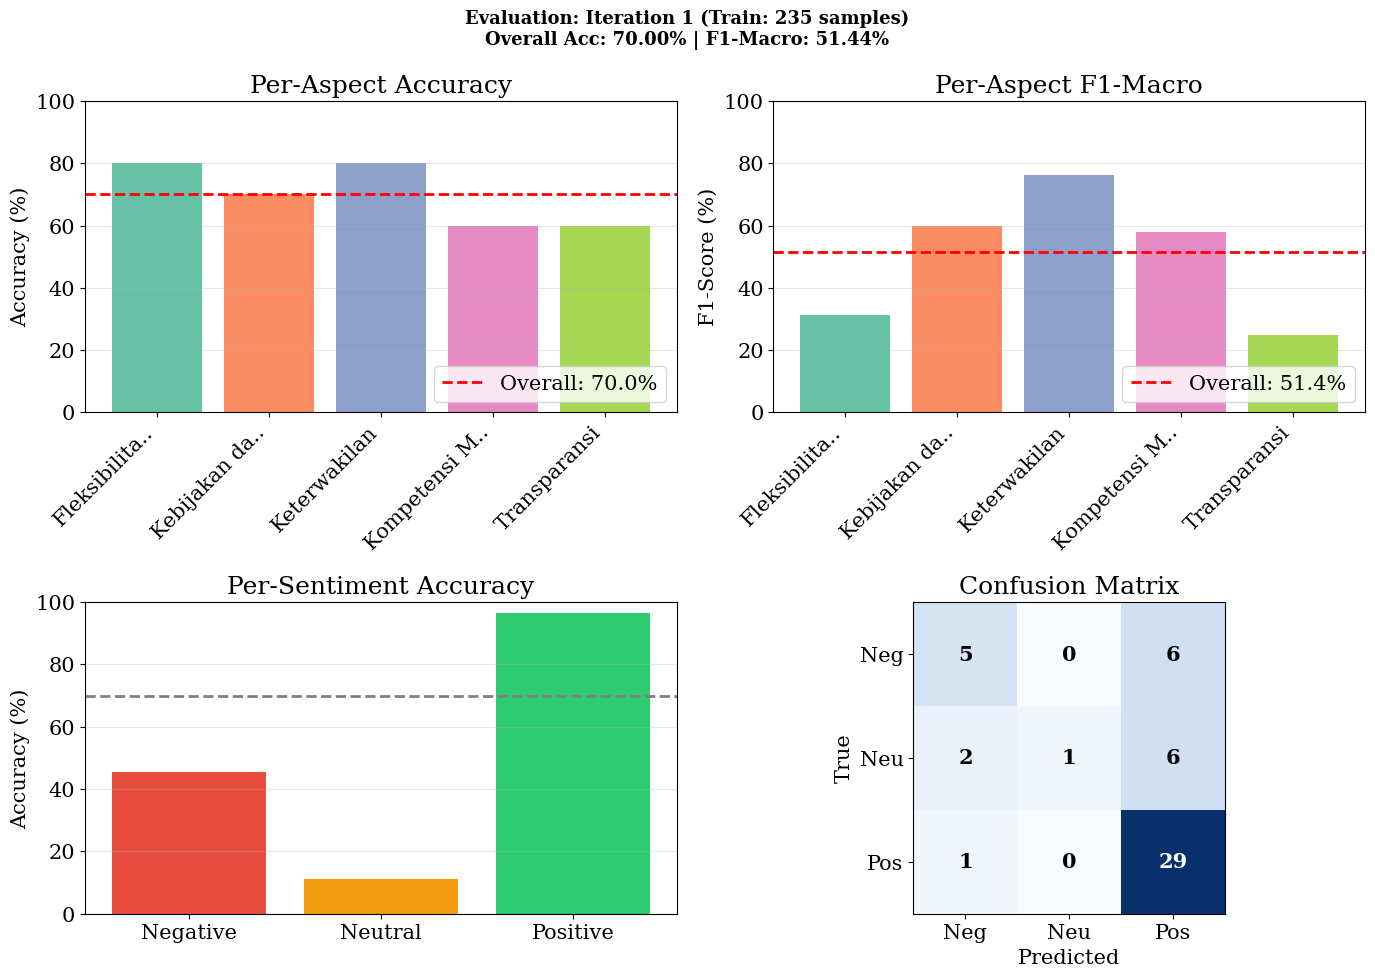

Evaluation saved: D:\ANBOW\New folder (3)\figures_iterative\iter1_evaluation.png

-> After Iter 1: Total training = 780 samples
   (Gold: 235 + Pseudo: 545)

 ITERATION 2: PSEUDO-LABELING (~545 labels)
 Model: FAST_LSA_S
 Current training: 780 samples
 Thresholds: POS>=0.45, NEG>=0.45, NEU>=0.35
 Keyword Bonus: 0.1

Files created in \iter2_training:
  - iter2.test.dat.apc: 13327 bytes
  - iter2.train.dat.apc: 216509 bytes
  - iter2.valid.dat.apc: 13526 bytes
Training model for iteration 2...
[2026-01-03 19:47:05] (2.4.2) Set Model Device: cuda:0
[2026-01-03 19:47:05] (2.4.2) Device Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
2026-01-03 19:47:05,343 INFO: PyABSA version: 2.4.2
2026-01-03 19:47:05,345 INFO: Transformers version: 4.57.3
2026-01-03 19:47:05,347 INFO: Torch version: 2.7.1+cu118+cuda11.8
2026-01-03 19:47:05,348 INFO: Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU
[2026-01-03 19:47:05] (2.4.2) Try to load ['\\iter2_training'] dataset from local disk


C:\Users\DLH JATIM\AppData\Local\Programs\Python\Python310\lib\multiprocessing\pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


2026-01-03 19:47:10,564 INFO: Load dataset from dataset_iterative\iter2_training\iter2.train.dat.apc


preparing dataloader: 100%|██████████| 780/780 [00:11<00:00, 70.88it/s]


2026-01-03 19:47:21,605 INFO: Dataset Label Details: {'1': 45, '2': 606, '0': 129, 'Sum': 780}
2026-01-03 19:47:21,895 INFO: train data examples:
 [{'ex_id': tensor(0), 'text_raw': 'halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut Fleksibilitas Fleksibilitas', 'text_spc': '[CLS] halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut Fleksibilitas Fleksibilitas [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8182, 0.8485, 0.8182, 0.8485, 0.8182, 0.8182, 0.8485, 0.8485, 0.8182,
        0.8485, 0.8485, 0.8788, 1.0000, 0.8182, 0.8182, 0.8182, 0.8182, 

preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 70.56it/s]


2026-01-03 19:47:22,986 INFO: Dataset Label Details: {'1': 9, '2': 30, '0': 11, 'Sum': 50}
2026-01-03 19:47:23,018 INFO: test data examples:
 [{'ex_id': tensor(0), 'text_raw': 'sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden Fleksibilitas Fleksibilitas', 'text_spc': '[CLS] sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden Fleksibilitas Fleksibilitas [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7667, 0.8667, 0.8333, 0.8667, 0.8333, 0.8333, 0.8667, 0.8333, 0.8667,
        0.8000, 0.8333, 0.8667, 0.8667, 1.0000, 1.0000, 1.0000, 1.0000,

preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 69.99it/s]


2026-01-03 19:47:24,110 INFO: Dataset Label Details: {'1': 3, '2': 30, '0': 17, 'Sum': 50}
2026-01-03 19:47:24,142 INFO: valid data examples:
 [{'ex_id': tensor(0), 'text_raw': 'idrus marham puji langkah menteri bahlil percepat pembayaran kompensasi energi kebijakan inovatif untuk rakyat Fleksibilitas Fleksibilitas', 'text_spc': '[CLS] idrus marham puji langkah menteri bahlil percepat pembayaran kompensasi energi kebijakan inovatif untuk rakyat Fleksibilitas Fleksibilitas [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7826, 1.0000, 1.0000, 0.7826, 0.7826, 0.8261, 0.8261, 1.0000, 0.8261,
        0.8261, 0.8261, 0.8261, 0.8261, 0.7826, 0.8261, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.7826, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.

Epoch:  0 | Smooth Loss: 0.6106: 100%|██████████| 49/49 [00:13<00:00,  3.76it/s, Dev Acc:68.00(max:68.00) Dev F1:44.09(max:45.00)]
Epoch:  1 | Smooth Loss: 0.5100: 100%|██████████| 49/49 [00:12<00:00,  3.86it/s, Dev Acc:60.00(max:68.00) Dev F1:38.59(max:45.71)]
Epoch:  2 | Smooth Loss: 0.4366: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s, Dev Acc:64.00(max:70.00) Dev F1:48.09(max:48.09)]
Epoch:  3 | Smooth Loss: 0.3817: 100%|██████████| 49/49 [00:14<00:00,  3.41it/s, Dev Acc:70.00(max:72.00) Dev F1:60.31(max:60.31)]
Epoch:  4 | Smooth Loss: 0.3409: 100%|██████████| 49/49 [00:12<00:00,  4.01it/s, Dev Acc:66.00(max:72.00) Dev F1:42.54(max:60.31)]


[2026-01-03 19:48:30] (2.4.2) Loading best model: checkpoints/fast_lsa_s_custom_dataset_acc_70.0_f1_60.31/ and evaluating on test set 
2026-01-03 19:48:30,674 INFO: 
-------------------------------------------------------------------- Raw Metric Records --------------------------------------------------------------------
╒══════════════╤══════════════════════════════════════════════════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric       │ Trial                                                    │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞══════════════╪══════════════════════════════════════════════════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Max-Test-Acc │ fast_lsa_s-custom_dataset-indobenchmark/indobert-base-p2 │ [66.0]              │    66     │    66    │   0   │   0   │   66    │   66    │
├──────────────┼─────────────────────────────────

d:\ANBOW\New folder (3)\venv_pyabsa2\lib\site-packages\pyabsa\framework\trainer_class\trainer_template.py:250: ResourceWarning: unclosed file <_io.TextIOWrapper name='d:\\ANBOW\\New folder (3)\\logs\\fast_lsa_s_20260103 194534\\trainer.log' mode='a' encoding='utf8'>
  self.config.logger.removeHandler(self.config.logger.handlers[0])


Model training completed
Found checkpoint: checkpoints\fast_lsa_s_custom_dataset_acc_70.0_f1_60.31
Checkpoint saved to: D:\ANBOW\New folder (3)\checkpoints_iterative\iter2_model\fast_lsa_s_custom_dataset_acc_70.0_f1_60.31
[2026-01-03 19:48:36] (2.4.2) Load sentiment classifier from checkpoints\fast_lsa_s_custom_dataset_acc_70.0_f1_60.31
[2026-01-03 19:48:36] (2.4.2) config: checkpoints\fast_lsa_s_custom_dataset_acc_70.0_f1_60.31\fast_lsa_s.config
[2026-01-03 19:48:36] (2.4.2) state_dict: checkpoints\fast_lsa_s_custom_dataset_acc_70.0_f1_60.31\fast_lsa_s.state_dict
[2026-01-03 19:48:36] (2.4.2) model: None
[2026-01-03 19:48:36] (2.4.2) tokenizer: checkpoints\fast_lsa_s_custom_dataset_acc_70.0_f1_60.31\fast_lsa_s.tokenizer
[2026-01-03 19:48:36] (2.4.2) Set Model Device: cuda:0
[2026-01-03 19:48:36] (2.4.2) Device Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Available unlabeled texts: 1944
Target per aspect: ~114


Pseudo-labeling Iter 2:   0%|          | 0/1944 [00:00<?, ?it/s]

[2026-01-03 19:48:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menjelang satu tahun pemerintahan prabowogibran aturan main makin tegas kalau ada program kementerian yang serapan anggarannya jeblok atau manfaatnya nggak jelas siap-siap dialihkan ke program lain yang lebih langsung nyentuh rakyat selengkapnya di


d:\ANBOW\New folder (3)\venv_pyabsa2\lib\site-packages\pyabsa\tasks\AspectPolarityClassification\prediction\sentiment_classifier.py:326: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  t_outputs_all = np.array(sen_logits.cpu()).astype(np.float32)


[2026-01-03 19:48:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menjelang satu tahun pemerintahan prabowogibran aturan main makin tegas kalau ada program kementerian yang serapan anggarannya jeblok atau manfaatnya nggak jelas siap-siap dialihkan ke program lain yang lebih langsung nyentuh rakyat selengkapnya di
[2026-01-03 19:48:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] masukan antar kementerian itu hal yang wajar dan malah sehat namanya juga pemerintahan harus ada check and balance biar kebijakan nggak jalan sendiri tanpa koreksi yang aneh justru dpr kok malah minta menteri diam bukannya tugas mereka justru dorong transparansi dan jaga


Pseudo-labeling Iter 2:   0%|          | 3/1944 [00:00<01:10, 27.50it/s]

[2026-01-03 19:48:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mengapa program pemerintah sebaiknya tidak menggunakan dana dari sumber yang tidak transparan atau perusahaan pribadi transparansi amp akuntabilitas prinsip utama dalam pengelolaan dana publik adalah transparansi menggunakan dana dengan sumber yang tidak jelas atau dari
[2026-01-03 19:48:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] masukan antar kementerian itu hal yang wajar dan malah sehat namanya juga pemerintahan harus ada check and balance biar kebijakan nggak jalan sendiri tanpa koreksi yang aneh justru dpr kok malah minta menteri diam bukannya tugas mereka justru dorong transparansi dan jaga
[2026-01-03 19:48:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-AS

Pseudo-labeling Iter 2:   0%|          | 6/1944 [00:00<01:12, 26.57it/s]

[2026-01-03 19:48:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] konten ini stelah dicek adalah hasil ai jadi hati buat teman yg sudah menyebarkan dg narasi tdk benar silakan kritik program atau kebijakan pemerintah spedas apapun asalkan sesuai data dan fakta jangan sebarkan hoax seperti yang sering dilakukan oleh stafsus yg
[2026-01-03 19:48:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pernyataan seperti itu dan surat seperti ini yang juga dikeluarkan oleh perpanjangan tangan negara itu punya kesamaan pemerintah ingin berkuasa tanpa akuntabilitas tanpa evaluasi tanpa rasa malu yang penting indonesia maju dan makmur buat mereka-mereka aja
[2026-01-03 19:48:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP

Pseudo-labeling Iter 2:   0%|          | 9/1944 [00:00<01:56, 16.64it/s]

[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memo tak sampai ke prabowo sejumlah kementerian berupaya memberikan memo mengenai substansi kebijakan kepada prabowo sugianto melalui teddy indra wijaya catatan itu ditengarai tak sampai ke meja presiden simak selengkapnya program bocor alus politik di channel youtube
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memo tak sampai ke prabowo sejumlah kementerian berupaya memberikan memo mengenai substansi kebijakan kepada prabowo sugianto melalui teddy indra wijaya catatan itu ditengarai tak sampai ke meja presiden simak selengkapnya program bocor alus politik di channel youtube
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Glo

Pseudo-labeling Iter 2:   1%|          | 12/1944 [00:00<01:37, 19.82it/s]

[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hotel juta per malam masih bisa dimaklumi kalo buat presiden dan pejabat ring negara karena ada alasan keamanan tapi kalo buat dayang-dayang apalagi diaspora yang bertugas mujamuji kedatangan pemerintah ya buat apa pemborosan anggaran banget
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memo tak sampai ke prabowo sejumlah kementerian berupaya memberikan memo mengenai substansi kebijakan kepada prabowo sugianto melalui teddy indra wijaya catatan itu ditengarai tak sampai ke meja presiden simak selengkapnya program bocor alus politik di channel youtube
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setela

Pseudo-labeling Iter 2:   1%|          | 15/1944 [00:00<01:27, 22.00it/s]

[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gen z menilai jika menteri yang dipilih tidak memiliki kompetensi di bidangnya maka sama saja dengan membuangbuang anggaran
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] my opinion on purbanya is menteri dengan epoksi teknikal kayak kebijakan fiskal gt perlu dikasi panggung kecuali perlu transparansi kebijakan etc gaura bek cakap salah cakap bisa berefek ke taraf hidup orang banyak
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri berkinerja buruk jadi beban negara di pemerintahan prabowo gibran
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal t

Pseudo-labeling Iter 2:   1%|          | 19/1944 [00:00<01:15, 25.37it/s]

[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] riset soal narkotika di indonesia minim padahal ini tindak pidana paling besar di indonesia kebijakan negara diambil dari asumsi populis yg berujung petaka bagi masyarakat dan pemerintah sendiri kami berkomitmen mendukung kebijakan berdasarkan bukti kita mulai dari kampus
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sekarang menunya eks tentara yang dekat dengan presiden fokusnya pertahanan amp brick tapi transparansi dan isu gender malah makin redup sejak cuma dubes ri perempuan dan belum ada satupun yang ditempatkan di negara besar
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] meg jika tidak evaluas

Pseudo-labeling Iter 2:   1%|          | 22/1944 [00:00<01:17, 24.72it/s]

[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jubir bukan staf bukan humas pemerintah bukan tiap ada warga yang kritik kebijakan pemerintah dia datang membela paling awal sebenarnya kerjaanmu apa sih kawan
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] penjelasan sederhana krisis hutang amerika serikat pendapatan pajak anggaran belanja pemerintah hutang baru total hutang saat ini mari kita hilangkan angka nol dan bayangkan ini adalah anggaran
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketika matamata dan telinga prabowo bekerja hari ini menteri bikin gaduh hari itu juga atau besoknya langsung meminta maaf teddy indra wijaya tokoh kunci akseleras

Pseudo-labeling Iter 2:   1%|▏         | 25/1944 [00:01<01:14, 25.92it/s]

[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintahan yang tidak mengedepankan transparansi dan keterbukaan adalah pemerintahan yang tertutup
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] confirmed emang pemerintah mau berbisnis sama rakyatnya sendiri itulah kenapa menterinya bankir bukan pakar kesehatan layanan kesehatan yang asalnya hak dasar rakyat cuma jadi komoditas rakyat jadi pasar yang untung ya lagi-lagi oligarki
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah daerah di sydney mengratiskan layanan kereta sebagai kompensasi dan permintaan maaf karena sebelumnya ada gangguan sistem layanan kereta di sydney bandingkan dengan di

Pseudo-labeling Iter 2:   1%|▏         | 29/1944 [00:01<01:10, 27.33it/s]

[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] entah krn krg persiapan atau ada alasan lain faktanya korban keracunan terus bermunculan sblm timbul korban jiwa ada baiknya meg dihentikan smp benar siap terms transparansi penggunaan dananya krn program ini mkn anggaran yg sgt bsr rawan maling sehat vs sekarat
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ra ashok pemerintah belum mampu mengelola data kita secara aman dan bertanggung jawab saat data pribadi kita dikuasai tanpa transparansi yg kuat potensi penyalahgunaannya jadi besar mulai dari kebocoran pengawasan yg berujung hilangnya privasi sampai komersialisasi data
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global 

Pseudo-labeling Iter 2:   2%|▏         | 32/1944 [00:01<01:09, 27.40it/s]

[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] harusnya presiden tersinggung dengan menteri yg masih mengusung cara anti meritokrasi dalam kabinetnya okelah jika ada unsur balas jasa tapi tidak main asal comot tanpa bobot ini kabinet pemerintahan sebuah negara bukan perusahaan milik pribadi prabowo wajar
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tanpa transparansi akuntabilitas yang tinggi serta tata kelola yang baik maka eksekusi kebijakan selalu problematik
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] perlu dikaji memang karena ini menggunakan apbn apakah memang ada nomenklatur pos anggaran untuk hal seperti ini jangan sampai malah menimbulk

Pseudo-labeling Iter 2:   2%|▏         | 35/1944 [00:01<01:10, 27.01it/s]

[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dpr minta purbanya tak campuri kebijakan kementerian lain
[2026-01-03 19:48:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun prabowo kebijakan tanpa data pemerintah tanpa arah klaim tersebut tidak akurat dan bertentangan dengan fakta capaian pemerintahan presiden prabowo sugianto dalam satu tahun pertama oktober oktober berdasarkan data resmi dari berbagai lembaga
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] purbanya diminta stop komentari kebijakan kementerian lain sebodo amat gtgtgt
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [

Pseudo-labeling Iter 2:   2%|▏         | 39/1944 [00:01<01:06, 28.86it/s]

[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bahwa shell adalah big corp yang sering zalim ke warga negara lain itu adalah nyata tapi lebih zalim lagi ada pemerintahan yang lewat kebijakan dungunya memaksa warga negaranya sendiri bekerja di luar job desk demi bertahan hidup atau paling parah kehilangan pekerjaan
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah yordania mau bikin belajar bersama ai oleh scale ai diminta harga juta kemudian salah satu anak bangsanya vibecoding aja pakai repot masukin kurikulum dan kementerian pendidikan jadikan rag buat ai hari jadi
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jubir bukan staf bukan humas 

Pseudo-labeling Iter 2:   2%|▏         | 42/1944 [00:01<01:05, 28.84it/s]

[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jubir bukan staf bukan humas pemerintah bukan tiap ada warga yang kritik kebijakan pemerintah dia datang membela paling awal sebenarnya kerjaanmu apa sih kawan
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan efisiensi anggaran sepertinya emang cuma buat program-program populis sama sektor keamanan aja
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lagu lagu kemarahan dan kritikan rakyat mulai terdengar dimana mana kasihan pak prabowo jadi sasaran tudingan masyarakat yang kecewa pada keadaan ekonomi yang memburuk akibat kebijakan ugal galan pemerintah sebelumnya yg kemudian diteruskan beberapa me

Pseudo-labeling Iter 2:   2%|▏         | 46/1944 [00:01<01:04, 29.37it/s]

[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] meg jika tidak evaluasi total bukan hanya merugikan anak anak tapi juga membuat anak anak itu sendiri orang tua dan guru trauma pemerintah sendiri juga akan dirugikan karena masyarakat akan menilai program ini gagal
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] helios berani tampil beda respondennya pun dari kalangan pakar amp pengamat kebijakan publik pasti kalau secara logika saya lebih bisa menerima ini dibanding survei lain yang respondennya acak amp entah dari kalangan apa saja kinerja menteri pastinya harus dinilai oleh yang ahli
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jubir bukan staf buka

Pseudo-labeling Iter 2:   3%|▎         | 49/1944 [00:01<01:08, 27.63it/s]

[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] penyebab stok bbm di spbu swasta tiris kementerian energi dan sumber daya mineral menyatakan kuota impor bahan bakar minyak untuk stasiun pengisian bahan bakar umum spbu swasta sudah habis pemerintah juga tidak menambah kuotanya itu sebabnya stok bbm di spbu swasta habis
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah yordania mau bikin belajar bersama ai oleh scale ai diminta harga juta kemudian salah satu anak bangsanya vibecoding aja pakai repot masukin kurikulum dan kementerian pendidikan jadikan rag buat ai hari jadi
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalau youtube setiap tahun

Pseudo-labeling Iter 2:   3%|▎         | 52/1944 [00:02<01:09, 27.03it/s]

[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalau mau jadi pemimpin oposisi nih ya kalau dirasa berat gabung atau bikin partai mas andes bisa bikin shadow cabinet kan orang dekatnya banyak mantan menteri amp kompeten tuh counter kebijakan yg ngawur oleh ahlinya itu kalau mau jadi oposisi tapi ini kan mau nyamuk lagi
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saya tidak mau ada pihak-pihak yang mencoba untuk mendorong keinginannya untuk mengintervensi kebijakan negara ini saya tidak mau apa pun kita akan pertaruhkan tentang kedaulatan negara karena bagi saya menteri itu adalah pejabat negara pembantu presiden kalau apa yang
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-A

Pseudo-labeling Iter 2:   3%|▎         | 55/1944 [00:02<01:10, 26.75it/s]

[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jubir bukan staf bukan humas pemerintah bukan tiap ada warga yang kritik kebijakan pemerintah dia datang membela paling awal sebenarnya kerjaanmu apa sih kawan
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mungkin pendukung pak prabowo bisa jelaskan mengapa beliau masih minta dukungan pa yg jelas sering menyerang kebijakan pemerintahan pak jokowi atau sengaja mau main dua kaki kalau iya pun gpp itu kan hak siapa saja rakyat cukup mengamati amp menilai
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bahwa shell adalah big corp yang sering zalim ke warga negara lain itu adalah nyata tapi lebih zalim lagi a

Pseudo-labeling Iter 2:   3%|▎         | 58/1944 [00:02<01:10, 26.66it/s]

[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah daerah di sydney mengratiskan layanan kereta sebagai kompensasi dan permintaan maaf karena sebelumnya ada gangguan sistem layanan kereta di sydney bandingkan dengan di negara berakhlak religious nasionalis pancasilais konstitusional
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oposisi kok diminta program lucu anda yang dikasih anggaran dan kewajiban berprogram ya pemerintah bukan oposisi
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] penyebab stok bbm di spbu swasta tiris kementerian energi dan sumber daya mineral menyatakan kuota impor bahan bakar minyak untuk stasiun pengisian bahan bakar 

Pseudo-labeling Iter 2:   3%|▎         | 61/1944 [00:02<01:09, 27.14it/s]

[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setelah republik indonesia bubar dan hanya menyisakan wilayah jabodetabek kebijakan pemerintah semakin di luar nalar termutakhir pemerintah melarang setiap warga negara untuk tertawa dilarang tertawa cerpen dia puja
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] soal narasi dan redaksi prabowo udah juara rakyat ga sabar menanti aksi nyata beliau kata tukang gorengan samping monas tunggu tahun lg masih menjalankan kebijakan dan anggaran pemerintahan sebelumnya jadi belum leluasa
[2026-01-03 19:48:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalo korupsi karena kebijakan yang merugikan negara walau tak ada aliran uang ke 

Pseudo-labeling Iter 2:   3%|▎         | 64/1944 [00:02<01:10, 26.68it/s]

[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] helios berani tampil beda respondennya pun dari kalangan pakar amp pengamat kebijakan publik pasti kalau secara logika saya lebih bisa menerima ini dibanding survei lain yang respondennya acak amp entah dari kalangan apa saja kinerja menteri pastinya harus dinilai oleh yang ahli
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] salut dgn singapore yg jalankan logika dan fakta drpd nafsu agamis spt indonesia singapura belum bisa mengakui palestina selama belum ada pemerintah dan masih dikuasai hamas yg memang jelas mau mencaplok negara israel negara kecil tapi berbuat jauh lebih banyak dari indonesia
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1

Pseudo-labeling Iter 2:   3%|▎         | 67/1944 [00:02<01:12, 25.86it/s]

[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jubir bukan staf bukan humas pemerintah bukan tiap ada warga yang kritik kebijakan pemerintah dia datang membela paling awal sebenarnya kerjaanmu apa sih kawan
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] purbanya diminta stop komentari kebijakan kementerian lain sebodo amat gtgtgt
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menuju tahun kepemimpinan presiden prabowo subianto pemerintah terus bergerak cepat untuk rakyat upaya pemberantasan korupsi dan penertiban tambang ilegal berhasil menyelamatkan triliunan rupiah uang negara di sisi lain berbagai program pro rakyat dijalankan seperti


Pseudo-labeling Iter 2:   4%|▎         | 70/1944 [00:02<01:10, 26.73it/s]

[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ekspor indonesia menembus afrika menghadapi tarif tinggi dari as akibat kebijakan tarif trump indonesia tak tinggal diam pemerintah kini memperluas pasar ekspor ke tunisia dan negara-negara afrika utara senin selasa sore pagi
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] x baru bln debut dah bubar eh pemerintah baru bln menjabat dah mengobrak-abrik negara dengan kebijakan jelek lainnya
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kewenangan pemerintah daerah banyak diambil alih pusat kemudian mereka diberi program dari pusat yang malah meracuni warganya sendiri jika keadilan sudah dicopot dari sebuah 

Pseudo-labeling Iter 2:   4%|▍         | 73/1944 [00:02<01:09, 26.89it/s]

[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] salah satu bukti betapa anggaran pendidikan kita dirampok adalah ketiga ratusan guru honorer kesulitan mendapatkan bantuan insentif ibujari yang dibayar untuk bulan yang dijanjikan pemerintah namun bgn memberikan insentif kepada guru ibujari yang dibayarkan per
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah melalui kementerian koordinator bidang pangan menetapkan wilayah sikander kabupaten serang menjadi daerah yang terpapar radiasi radionuklida cs baca di sini ta
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketika matamata dan telinga prabowo bekerja hari ini menteri bikin gaduh hari itu ju

Pseudo-labeling Iter 2:   4%|▍         | 76/1944 [00:02<01:08, 27.16it/s]

[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sebagai langkah untuk mendorong pola hidup masyarakat yang lebih sehat dan meningkatkan pendapatan negara untuk sektor kesehatan pemerintah malaysia resmi menaikkan cukai rokok dan minuman beralkohol mulai november perdana menteri anwar ibrahim mengatakan keputusan
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri koordinator pemberdayaan masyarakat muslimin iskandar alias cak izin menegaskan komitmen pemerintah untuk memastikan seluruh rakyat indonesia bisa kembali mendapatkan hak layanan kesehatan yang layak tanpa terbebani tunggakan iuran bpjs kesehatan selengkapnya
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global 

Pseudo-labeling Iter 2:   4%|▍         | 79/1944 [00:03<01:09, 26.80it/s]

[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] imunitas raja palsu ijazah palsu jika saja kebijakan yg merugikan negara ini ada di tangan tom gembong maka tak menunggu ayam berkokok esok hari pasti tom gembong sdh ditetapkan sebagai tersangka diborgol dan ditahan di rutan tapi seperti halnya skandal whoosh ki
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] negara mulai pusing akibat warisan kebijakan yang engga penting
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wah ini yg aku suka ngomong blak blak an bbrp waktu ini rakyat hanya disuguhi menteri ngomong byk kebijakan yg konyol sekarang seorang menteri bisa menolak master menteri nya sinilah


Pseudo-labeling Iter 2:   4%|▍         | 82/1944 [00:03<01:10, 26.34it/s]

[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] triliun kembali ke negara pengembalian kerugian negara dr korporasi sawit pd kasus cpo menunjukkan keseriusan kejagung dlm menindak korupsi di sektor strategis hadirnya presiden prabowo sbg langkah kuat pemerintah dlm menegakkan law enforcement amp pemulihan kerugian negara
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rpt uang rakyat harus kembali ke rakyat presiden prabowo mengapresiasi penyitaan smelter rampasan kasus korupsi dari kejaksaan agung prabowo mengatakan penyitaan ini bukti pemerintah serius membasmi korupsi smelter rampasan korupsi disita oleh negara
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentimen

Pseudo-labeling Iter 2:   4%|▍         | 85/1944 [00:03<01:10, 26.28it/s]

[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] loh gubernur jatim khofifah absen dipanggil kpk jadi saksi kasus korupsi dana hibah untuk kelompok masyarakat pokmas anggaran pendapatan dan belanja daerah apbd pemerintah provinsi jawa timur untuk periode
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jk wajarkan massa gelar demo tolak tunjangan anggota dpr masyarakat punya hak berbicara wakil presiden ke dan ke ri jusuf kalla merespons aksi demonstrasi memprotes kebijakankebijakan pemerintah yang dianggap merugikan rakyat aksi demo itu berlangsung di depan gedung
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kdm mengungkapkan alasan tidak ikut memprot

Pseudo-labeling Iter 2:   5%|▍         | 88/1944 [00:03<01:12, 25.61it/s]

[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] salah satu alesan kenapa pembangunan rumah ibadah kaum non-muslim sulit adalah kebijakan pemerintah
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tepatkah kebijakan prabowo lanjutkan efisiensi anggaran hingga
[2026-01-03 19:48:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] levi zarina kebijakan campuran etanol perlu diterapkan dengan kesiapan dan kehati-hatian anggota komisi vi dpr ri hj levi zarina mendukung rencana pemerintah menerapkan campuran etanol persen dalam bbm e sebagai langkah menuju energi bersih dan pengurangan impor


Pseudo-labeling Iter 2:   5%|▍         | 91/1944 [00:03<01:13, 25.14it/s]

[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tak sedikit kebijakan pemerintah yang malah membuat kelangkaan bbm di spbu swasta berkepanjangan kontraproduktif terhadap praktik bisnis yang sehat
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ratusan ribu warga amerika serikat turun ke jalan dalam aksi bertajuk no kings di hampir seluruh negara bagian untuk memprotes kebijakan presiden donald trump aksi besarbesaran ini dianggap sebagai perlawanan terhadap gaya kepemimpinan trump yang dinilai otoriter dan
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo terlibat secara pribadi dalam kebijakan politik luar negeri terobsesi citra indonesi

Pseudo-labeling Iter 2:   5%|▍         | 94/1944 [00:03<01:11, 25.78it/s]

[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo ada yang bicara tanpa data ambisi mengebu-gebu dan tidak objektif klo tdk sesuai data knp tdk dibenarkan pas debat ambisi itu yg sdh x nyalon kalah mulu tp msh ikutan lagi yg diserang bukan personal bowo tp kebijakan menhan
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di tengah dinamika situasi global indonesia berhasil menjaga ekonomi nasional tetap stabil dan terus tumbuh di kisaran berbagai kebijakan difokuskan untuk pemulihan dan ekspansi ekonomi yang inklusif dengan berfokus pada penciptaan lapangan kerja penguatan umum serta
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program makan ber

Pseudo-labeling Iter 2:   5%|▍         | 97/1944 [00:03<01:10, 26.11it/s]

[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tolak berikan visa atlet israel doc hukum indonesia mencoba menolak israel dilindungi uud mencoba erick thahir menegaskan kebijakan pemerintah indonesia yang menolak kehadiran atlet israel dalam ajang kejuaraan dunia gimnastik di jakarta sepenuhnya sejalan dengan
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah perlu secara serius mengembalikan fokus kebijakan ekonomi untuk meningkatkan efisiensi dan produktivitas perekonomian
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] penolakan visa bagi atlet israel ternyata berbuntut panjang komite olimpiade internasional doc resmi meminta seluruh federas

Pseudo-labeling Iter 2:   5%|▌         | 100/1944 [00:03<01:08, 26.92it/s]

[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kang dedi punya kemungkinan benar gubernur dedi mulyadi tidak terima dengan pernyataan menteri keuangan purbanya yudha dewa kalau dana pemerintah daerah pemda mengendap di deposito di perbankan bahkan pria yang kerap disapa kang dedi itu menantang purbanya untuk membuktikan
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rakyat yang sehat adalah fondasi indonesia yang kuat pemerintahan kabinet merah putih ikut mendukung berbagai program pemerintah untuk memperkuat kesehatan masyarakat salah satunya
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dari bogor dan pati menuju toronto dan sydney selamat untuk a

Pseudo-labeling Iter 2:   5%|▌         | 103/1944 [00:03<01:09, 26.68it/s]

[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah malaysia resmi menaikkan cukai rokok dan minuman beralkohol mulai november perdana menteri anwar ibrahim mengatakan kenaikan cukai tersebut merupakan bagian dari upaya mendorong gaya hidup rakyat malaysia yang lebih sehat klik untuk baca
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sangat mudah sekali dijawab muhammadiyah tanpa bantuan pemerintah bisa membangun sekolah perguruan tinggi rumah sakit dan semuanya gaada yang dibangun pake asas gotong royong tenaga santri melainkan menggunakan profesional
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mencabut id pers seorang wartawan hanya karen

Pseudo-labeling Iter 2:   5%|▌         | 106/1944 [00:04<01:09, 26.62it/s]

[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] spam judi online udah ampe whatsapp aja kaga jelas emang ini pemerintah
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah sedang menyusun aturan baru soal kebijakan zero odol over dimension over loading yang akan berlaku mulai fokusnya bukan cuma penindakan tapi juga kesejahteraan sopir
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] miris banget sekelas kementrian kok bisa salah tafsir yang berujung merugikan pppk dan cpns semoga segera ada perubahan kebijakan walaupun tadi bkn zoom dan keputusannya tetap sama tetap bersuara kawankawan jangan mundur sebelum menang


Pseudo-labeling Iter 2:   6%|▌         | 109/1944 [00:04<01:09, 26.48it/s]

[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pedagang siomay yang hidup dan keluarganya dari jualan siomay harus meninggal karena keliling cari gas lpg kg salah pilih pemimpin salah pilih menteri salah kebijakan akhirnya rakyat satu per satu mati mirisnya negeriku yang katanya kaya ini
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sender bikin konten di tiktok tentang bobroknya kebijakan pemerintah skrg and guess what isi komennya gini
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bulan sejak dilantik hari baca berita isinya suram gak ada kebijakan yang pihak ke rakyat isinya cuma bagi jabatan program yang diungguli cuma meg apapun masalahnya sol

Pseudo-labeling Iter 2:   6%|▌         | 112/1944 [00:04<01:07, 27.04it/s]

[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan politik luar negeri kita dari sejak awal kemerdekaan hingga sekarang memang tidak membenci israel atau negara manapun tetapi membenci penjajahan maka jika israel mengakui negara palestina kita pun akan mengakui negara israel
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] salah satu dosa terbesar joki adalah mengeluarkan wapres no tahun depres no tahun depres no tahun pemerintah mengakui kesalahan telah melakukan pelanggaran ham berat peristiwa g s pki pembelokan sejarah
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ada yang diduga meninggal karena keracunan severe alergi meg ini harus segera o

Pseudo-labeling Iter 2:   6%|▌         | 115/1944 [00:04<01:07, 27.01it/s]

[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] acl itu beda sama sakit ringan wamil butuh fisik sedangkan konser bisa dijalanan dgn penyesuaian dia jg masih sering duduk gerak terbatas bahkan harus jaga diri ketat hasil kesehatannya dr pemerintah yg mutusin dia ga bisa wamil bukan dia sendiri yang milih
[2026-01-03 19:48:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hahhh wajah anak yg makan proses food kyk nuget dan sebagainya sama yg real food asli itu beda kok bisa yah jumat jule banten kejutan kebijakan strategis nkri menteri terbaik prabowo diplomasi perdamaian spin selamat ulang tahun
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saya melihat prabowo berulang 

Pseudo-labeling Iter 2:   6%|▌         | 118/1944 [00:04<01:08, 26.66it/s]

[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saya mendukung netizen aktif mengkritisi kebijakan pak prabowo tapi jangan menghina melecehkan apalagi memfitnah karena suka tidak suka beliau adalah kepala negara ri diduga oknum mahasiswi itb ditangkap polri buntut unggahan meme prabowo amp joki berciuman
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah longgarkan aturan demi perdagangan lebih mudah pemerintah resmi deregulasi sejumlah kebijakan di sektor perdagangan demi memperkuat ekosistem kemudahan berusaha dan meningkatkan daya saing nasional disampaikan langsung oleh menka airlangga selasa banjir
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E

Pseudo-labeling Iter 2:   6%|▌         | 121/1944 [00:04<01:07, 26.84it/s]

[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden madagaskar andry rajoelina mengumumkan pembubaran pemerintah pada senin menyusul demonstrasi besarbesaran yang dipimpin kaum muda gen z sejak pekan lalu saya telah memutuskan untuk mengakhiri fungsi perdana menteri dan pemerintahan kata rajoelina
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yang punya program pemerintah pusat tapi yang disuruh tanggung jawab pemerintah daerah ini konsepnya gimana sih
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah selesaikan masalah dari akarnya justru merekalah akar masalah dari semuaaa masalah negara ini gempa makan bergizi gratis jember bali marci

Pseudo-labeling Iter 2:   6%|▋         | 124/1944 [00:04<01:07, 26.90it/s]

[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yang kayak gini nih pemerintah terutama menteri esdm bahlul pasti gak tahu mbah saliman sejak menanam ribuan pohon beringin menghijaukan lahan tandus di lereng gunung lalu dan menghasilkan air melimpah jasa sebesar ini layak dapat penghargaan video
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] genosida israel secara sistematis menghancurkan sistem layanan kesehatan gaza rumah sakit dibom ambulans menjadi sasaran dan lebih dari tenaga kesehatan tewas para pemimpin dunia termasuk pemerintah inggris tidak bisa mengatakan mereka tidak tahu
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sudah setahun negara 

Pseudo-labeling Iter 2:   7%|▋         | 127/1944 [00:04<01:08, 26.41it/s]

[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] guys menurut kalian kebijakan pemerintah netepin umr yang nggak sama rata di seluruh wilayah ini udah adil belum menurut sender gini dari observasi pribadi
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di perjuangan mengambil sikap sebagai partai penyeimbang kalau ada kebijakan pemerintah yang tidak terlalu memberi manfaat kepada rakyat akan dikritisi
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] joki men set up negara dlm model state crime dia jadikan negara sebagai pelaku kejahatan kekerasan amp korupsi memanipulasi kebijakan merekayasa yg salah menjadi benar amp yg benar menjadi salah sdh semestinya

Pseudo-labeling Iter 2:   7%|▋         | 130/1944 [00:04<01:07, 26.96it/s]

[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto mengatakan untuk pertama kalinya pemerintah saudi memberi izin kepada negara lain untuk memiliki lahan di makkah negara itu adalah indonesia yang diizinkan membangun kampung haji di arab saudi gtg
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tutorial menjadi pemerintah bikin kebijakan aneh viral gelut dan keributan rakyat vs buzzerinfluencer pemerintah a buzzerinfluencer menang kebijakan aneh lanjut b masyarakat menang kebijakan batal dengan pejabat muncul jadi pahlawan ulang nomor
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] malu gak tuh udang sebanyak ini diulangi karena m

Pseudo-labeling Iter 2:   7%|▋         | 133/1944 [00:05<01:07, 26.81it/s]

[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah indonesia menetapkan undang-undang nomor tahun sebagai dasar hukum baru dalam pelaksanaan ibadah haji dan umrah regulasi ini menegaskan bahwa umrah mandiri kini resmi diperbolehkan setiap warga negara dapat mengatur perjalanannya sendiri tanpa wajib melalui
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mengawali tahun baru saya menerima menteri koordinator bidang pemberdayaan masyarakat muslimin iskandar bersama sejumlah menteri di bawah memento membahas komitmen pemerintah dalam agendaagenda strategis untuk meningkatkan kemandirian masyarakat menka pemberdayaan masyarakat
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-

Pseudo-labeling Iter 2:   7%|▋         | 136/1944 [00:05<01:09, 26.01it/s]

[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dana bloomberg masuk ke indonesia lewat lsm antitembakau vital strategis buat mendorong regulasi antitembakau di beberapa kota kayak jakarta dan bogor sejak amp secara terbuka mengakui intervensi mereka dalam kebijakan pengetatan tembakau di indonesia termasuk
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dan disaat kekayaan mereka terus bertambah kita semua yang dibawah semakin ga punya apaapa disaat mereka bisa terus melobi pemerintah untuk kebijakan yang menguntungkan mereka semakin kita tidak punya hak
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hidup didunia ini gk cukup punya ipk tinggi tapi kt

Pseudo-labeling Iter 2:   7%|▋         | 139/1944 [00:05<01:08, 26.24it/s]

[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah akan membuka program magang nasional selama bulan bagi fresh graduate program ini akan dilaksanakan di perusahaan bumn maupun swasta terutama perusahaan yang telah terdaftar dalam wajib lapor ketenagakerjaan perusahaan tkp peserta magang akan menerima
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] contoh sekolah yang menerapkan makan siang sejak tahun yang lalu pemerintah dan dpr mana mau mencontoh program yang baik dan benar karena apa ya sudah pasti netizen pahamkan
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] stud guys maaf oot tka program pemerintah kan kok sekolahku bayar ya mau protes 

Pseudo-labeling Iter 2:   7%|▋         | 142/1944 [00:05<01:07, 26.67it/s]

[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kepala negarapemerintah mereka peduli terhadap warganya yang ditangkap israel bagaimana dengan indonesia
[2026-01-03 19:48:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah mau revisi libur panjang lebaran dan terancam batal kalo ada info mau demon itu kabarin ya gue mau ikut
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rakyat keluyuran keluar rumah gak jelas ke cd nongkrong sana sini also rakyat ini kenapa corona gak kelar ya masalahnya pemerintah kerjanya apaan sih


Pseudo-labeling Iter 2:   7%|▋         | 145/1944 [00:05<01:05, 27.53it/s]

[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pilihan di tangan anda pendidikan total gratis negeri amp swasta anggarannya triliun tapi pemerintah katanya tidak punya uang makan gratis keracunan anggaran triliun diambil dari dana pendidikan
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pip soal satu tahun pemerintahan prabowogibran arah kepemimpinan kesadaran geopolitik bung karna sekjen diperjuangkan menyampaikan pip menilai kepemimpinan presiden prabowo dalam satu tahun pemerintahan hasta mengatakan arah kebijakan luar negeri yang ditempuh
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jelang sidang kabinet paripurna di istana negara bersama pres

Pseudo-labeling Iter 2:   8%|▊         | 148/1944 [00:05<01:07, 26.60it/s]

[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] video mahmud md minta maaf harus disertai perubahan kebijakan
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tanggal libur trus tanggal libur lagi ini adalah semata program pemerintah agar kita lebih produktivitas lagi dalam bermalasan menjelang libur panjang lebaran jangan lengah tetap semangat bersalahannya
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dalam kunjungan kenegaraan ke singapura saya mendapat kehormatan menghadiri jamuan santap siang yang diselenggarakan oleh presiden republik singapura yang mulia thurman shanmugaratnam saya sangat menghargai sambutan hangat dan keramahan yang diberikan o

Pseudo-labeling Iter 2:   8%|▊         | 151/1944 [00:05<01:06, 26.90it/s]

[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dear anak muda dengarkan tips karir berkualitas dari komisaris pertama ini sudahi sekolahmu kuliahmu karena jalur meniti karir terbaik adalah menjadi penjilat untuk yang menang dan berkuasa secara tidak langsung bio mengatakan pemerintah sekarang isinya penjilat
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lihat vt ini jd nangis inget banget ada yg bilang kalo kita generasi pemalas dhl bnyk dri kita yg double-o blm lagi hrs melek isu politik mengawal kebijakan ngaco pemerintah tiap hari ditimpa berita buruk donasi kemanusiaanetc kalian semua hebat
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] orang ya

Pseudo-labeling Iter 2:   8%|▊         | 154/1944 [00:05<01:08, 26.13it/s]

[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tahun konsisten jadi oposisi selalu berseberangan dengan kebijakan joki menuduh joki mendalangi perebutan demokrat oleh moeldoko menyuarakan perubahan condong ke antitesis joki tahun terakhir hari ini datang ngemis ke rojo lalu pura pakai topeng
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] survei poltracking menempatkan program makan bergizi gratis meg sebagai kebijakan prabowo gibran yang paling dirasakan manfaatnya oleh masyarakat sebanyak persen responden menilai program ini membawa dampak positif nyata di berbagai daerah program meg dinilai membantu
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pe

Pseudo-labeling Iter 2:   8%|▊         | 157/1944 [00:05<01:09, 25.78it/s]

[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah indonesia di bawah pimpinan presiden ri jenderal tni pun h prabowo sugianto dan wakil presiden ri gibran rakabuming raka telah merumuskan program prioritas sebagai bagian dari upaya transformasi bangsa program ini bertujuan mendorong pembangunan yang
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dan disaat kekayaan mereka terus bertambah kita semua yang dibawah semakin ga punya apaapa disaat mereka bisa terus melobi pemerintah untuk kebijakan yang menguntungkan mereka semakin kita tidak punya hak
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] padahal memaki-maki kebodohan pemerintah itu sanga

Pseudo-labeling Iter 2:   8%|▊         | 160/1944 [00:06<01:12, 24.60it/s]

[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yang di jakarta pada ngeh ga sih berita hot mic ini beneran jadi gede banget di us bahasannya seputar confiict of interests dan perilaku korup menyalahgunakan jabatan kenegaraan trus pemerintah kita ga ada komen apaapa gitu
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pegawai negeri sipil aparatur sipil negara negara pemerintah padahal diajarin di ppk
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah hadir bukan sekadar janji tapi aksi nyata untuk rakyat melalui bantuan langsung tunai sementara blus sebanyak juta keluarga penerima manfaat akan menerima bantuan rp ribu mulai oktober simak seleng

Pseudo-labeling Iter 2:   8%|▊         | 163/1944 [00:06<01:09, 25.49it/s]

[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dokumen resmi ini menunjukkan permohonan resmi yang diajukan oleh mantan presiden israel shimon peres pada tahun untuk memperoleh kewarganegaraan palestina dokumen ini memuat tanda tangan resminya sumpah kesetiaan dan kesetiaannya kepada pemerintah palestina
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] undang-undang dan bahkan uud itu mewajibkan minimal anggaran pemerintah dipakai untuk pendidikan di apbn proporsinya pass tapi paling banyak buat meg di luar meg anggaran pendidikan hanya sisa dari apbn hayoloh
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketika nyuruh orang lain coba ngedidik anaknya 

Pseudo-labeling Iter 2:   9%|▊         | 166/1944 [00:06<01:11, 24.91it/s]

[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memang ada golongan orang kaya yang memandang orang miskin itu cukup dikasih makan nggak perlu lebih pintar lebih mandiri atau lebih sejahtera bencana terjadi ketika orang kaya jenis ini jadi pemerintah dan dikasih mandat membuat kebijakan mati kita
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pendaftaran program magang untuk lulusan s baru fresh graduate dengan gaji ditanggung pemerintah dimulai oktober program ini merupakan salah satu paket stimulus ekonomi presiden prabowo pendaftaran peserta pemasangan dibuka pada sampai oktober seleksi
[2026-01-03 19:48:45] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program ini buk

Pseudo-labeling Iter 2:   9%|▊         | 169/1944 [00:06<01:10, 25.16it/s]

[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] penuhi kebutuhan gizi anak demokrat dukung program meg presiden prabowo wakil ketua mpr ri dari partai demokrat eddie baskom yudhoyono bas menegaskan bahwa partai demokrat mendukung pelaksanaan program makan bergizi gratis meg sebagai langkah strategis pemerintah dalam
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa menyiapkan sistem yang bisa membuat pemerintah daerah tak lagi mengendapkan dana mereka di perbankan
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apakah benar dan yakin pemerintah akan meng dilegalkan produk yang non halal non halal tanpa sertifikat halal

Pseudo-labeling Iter 2:   9%|▉         | 172/1944 [00:06<01:11, 24.71it/s]

[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] punya kulit sehat itu juga ada unsur politiknya loh karena udara air dan lingkungan bersih bergantung pada kebijakan misal ketika pemerintah kasih izin tambang ltu yang mencemari lingkungan yang kotor bukan cuma langit aja sebenarnya tapi tubuh kita juga kena dampaknya
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah akan meluncurkan program magang bagi lulusan perguruan tinggi maksimal satu tahun setelah kelulusan pada oktober dalam program ini peserta magang akan mendapat uang saku sebesar rp juta per bulan selama maksimal enam bulan sebagaimana diatur dalam
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Senti

Pseudo-labeling Iter 2:   9%|▉         | 175/1944 [00:06<01:11, 24.66it/s]

[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] buntut panjang kebijakan pemangkasan anggaran prabowo
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri hak asasi manusia ham menilai kebijakan gubernur jawa barat yang mengirimkan siswa nakal ke barak militer tak melanggar ham mendukung kebijakan tersebut
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] reminder buat para pemangku kebijakan baik itu di eksekutif atau legislatif adalah kewajiban government menjamin stabilitas negara kita ga bisa mengubah masa lalu tapi kita bisa membuat masa depan lebih baik jadi tolong dipikir masak karena kalian menjabat itu cuma tahu


Pseudo-labeling Iter 2:   9%|▉         | 178/1944 [00:06<01:09, 25.50it/s]

[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pembatasan bandos hingga tahun adalah kebijakan bijak agar bantuan benarbenar tepat sasaran ini memberi kesempatan bagi banyak warga lain yang juga memerlukan
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan menteri keuangan purbanya yudha dewa memberikan beban baru bagi perbankan bank bisa kelabakan
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dari sisi ekonomi kebijakan cukai berpotensi besar meningkatkan pendapatan negara sementara itu dari sisi kesehatan kebijakan ini mendorong pola konsumsi masyarakat jadi lebih sehat langkah bijak yang patut diapresiasi


Pseudo-labeling Iter 2:   9%|▉         | 181/1944 [00:06<01:08, 25.71it/s]

[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] keputusan polri untuk tidak menilang kendaraan terparkir namun tegas pada pelanggaran arus adalah kebijakan yang sangat dihargai terima kasih
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] punya rumah sendiri itu impian semua orang maka dari itu pemerintah mewujudkan program juta rumah sebagai bagian dari perumahan untuk rakyat
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yang jadi pemerintah siapa yang pusing siapa aneh bat ini negara


Pseudo-labeling Iter 2:   9%|▉         | 184/1944 [00:07<01:08, 25.81it/s]

[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tak sedikit kebijakan pemerintah yang malah membuat kelangkaan bbm di spbu swasta berkepanjangan kontraproduktif terhadap praktik bisnis yang sehat
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] butuh saran nih kerja jadi programmer di instansi pemerintah nonsan tapi kerasa mentok gaji stuck freelance amp kerja lain blm dapet mending usaha sampingan upgrade skill atau coba kerja luar negeri coba asn
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wah ini yg aku suka ngomong blak blak an bbrp waktu ini rakyat hanya disuguhi menteri ngomong byk kebijakan yg konyol sekarang seorang menteri bisa menolak maste

Pseudo-labeling Iter 2:  10%|▉         | 187/1944 [00:07<01:07, 25.88it/s]

[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] negara mulai pusing akibat warisan kebijakan yang engga penting
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] imagine negara loe kebijakan politiknya carut marut hukumnya amburadul ekonominya sakaratul maut dan satusatunya harapan loe buat bangga bisa jadi orang indonesia malah begini gini amat jadi ini ang
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] knapa ya presiden ga bikin kebijakan subsidi buku padahal kayanya itu populis
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] grab indonesia 

Pseudo-labeling Iter 2:  10%|▉         | 191/1944 [00:07<01:05, 26.84it/s]

[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oh iya kenalin aku petugas hiv di bandung yang mau akses tes hiv program pemerintah bisa ke aku yah gratis gratis kondom dan pelicin juga ada akses prep juga obat pencegahan hiv buat proteksi tambahan
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah akan terus menambah kuota peserta program magang fresh graduate hingga orang jumlah itu jauh lebih tinggi dari yang angka awal yang diumumkan pemerintah
[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wakil ketua komisi ix dpr ri ini juga menyoroti bahwa program pembangunan lima rs regional oleh pemerintah aceh telah berjalan sejak namun hingga kini p

Pseudo-labeling Iter 2:  10%|▉         | 194/1944 [00:07<01:06, 26.22it/s]

[2026-01-03 19:48:46] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] infotempo dprd jakarta salut dengan program pemutihan ijazah telah masuk ke tahap iv kebijakan ramon anung ran karna memberi harapan baru bagi warga yang ijazahnya tertahan sekaligus bukti nyata kepedulian semprot
[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di tengah dinamika situasi global indonesia berhasil menjaga ekonomi nasional tetap stabil dan terus tumbuh di kisaran berbagai kebijakan difokuskan untuk pemulihan dan ekspansi ekonomi yang inklusif dengan berfokus pada penciptaan lapangan kerja penguatan umum serta
[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lu kritisi program prabowo gibran g

Pseudo-labeling Iter 2:  10%|█         | 197/1944 [00:07<01:08, 25.33it/s]

[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wamenperin juga ikutan nyetir nih beliau ngingetin supaya kebijakan ini jangan sampai ngerusak target ekonomi pemerintahan baru pak soalnya industri tembakau ini kan gede kontribusinya buat cukai dan lapangan kerja jadi harus dipikirin matang-matang
[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lutut kalau kamu tidak suka dengan kebijakan menteri keuangan pindah saja kamu dari indonesia ehhhcocok kelen rasa
[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gubernur harus bersuara demikian membela ikut kalo ada kebijakan pemerintah yg ngawur dan aemgsarakan ikut


Pseudo-labeling Iter 2:  10%|█         | 200/1944 [00:07<01:07, 26.01it/s]

[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] good news buat kamu yang nunggu program magang pemerintah batch kedua magang nasional bakal dibuka bulan november kuota peserta uang saku per bulan sesuai standar daerah bonus jaminan kehilangan kerja amp jkm tanpa potongan siap belajar sambil digaji
[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oh iya kenalin aku petugas hiv di bandung yang mau akses tes hiv program pemerintah bisa ke aku yah gratis gratis kondom dan pelicin juga ada akses prep juga obat pencegahan hiv buat proteksi tambahan
[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa menegaskan pemerintah tidak 

Pseudo-labeling Iter 2:  10%|█         | 203/1944 [00:07<01:08, 25.35it/s]

[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] reshuffle kabinet prabowo tak menyentuh akar masalah problem kita hari ini adalah kelesuan ekonomi akibat kebijakan pemerintah
[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] antrian isi lpg kg terjadi di beberapa wilayah rangsel salah satunya pagi tadi suasana antrian di agen jalan jambang raya diputar senin seharusnya disiapkan antisipasi baru kebijakan dikeluarkan ini kok buat rakyat susah aja pemerintah pusat
[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] update terkini iring-iringan kendaraan truk membawa ribuan warga pati terus berdatangan menuju kantor bupati aksi hari ini adalah puncak protes warg

Pseudo-labeling Iter 2:  11%|█         | 206/1944 [00:07<01:08, 25.44it/s]

[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hari ini saya resmi meluncurkan mekanisme baru dalam penyaluran tunjangan bagi guru aparatur sipil negara asn di daerah kebijakan ini bertujuan untuk menyederhanakan proses birokrasi memastikan tunjangan tersalurkan dengan lebih efisien dan tepat waktu serta menempatkan
[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ini akibat kampus cari duit kok bisa ya disuruh sama siapa pemerintah lah siapa lagi ini gara-gara ide penuh dimulai dari salah satu yang naide sekarang jadi menteri menteri kemensainstekdikti
[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tugas mereka sebagai akademisi untuk mengabdi sama ne

Pseudo-labeling Iter 2:  11%|█         | 209/1944 [00:08<01:13, 23.76it/s]

[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ini salah kaprah asn itu bekerja untuk negara pemerintah harus berganti kepemimpinan seiring waktu namun asn tetap bekerja untuk negara yang menggaji asn adalah rakyat melalui sistem yang disebut negara asn bukan budak pemerintah penerima beasiswa dari negara juga bukan
[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah menghapus proyek pengembangan pantai indah kapuk pik dalam daftar proyek strategis nasional pun yang ditetapkan tahun ini daftar pun saat ini diatur dalam peraturan menteri koordinator bidang perekonomian republik indonesia nomor tahun tentang perubahan
[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Globa

Pseudo-labeling Iter 2:  11%|█         | 212/1944 [00:08<01:16, 22.60it/s]

[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jelang satu tahun pemerintahan presiden prabowo sugianto dan wakil presiden gibran rakabuming raka berbagai program unggulan telah berjalan mulai dari program sekolah rakyat koperasi merah putih hingga program makan bergizi gratis namun program unggulan pemerintah masih
[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tanah mereka dieksploitasi dikuras kandungan kekayaan alamnya tapi penduduknya banyak yang hidup dengan kemiskinan untuk makan bertahan hidup saja susah anehnya pemerintah seperti kurang mengetahui kesusahan itu bahkan terkesan sibuk memberikan bantuan ke luar negeri
[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Gl

Pseudo-labeling Iter 2:  11%|█         | 215/1944 [00:08<01:18, 21.92it/s]

[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sedih tiap baca berita kecelakaan kerja karena jarang dilanjutkan oleh upaya proper dari pemerintah untuk evaluasi serius dan mencegah hal yang sama terulang kembali padahal k tuh isu sangat krusial dalam perlindungan ketenagakerjaan
[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] orang yang ikutan share soal demo beberapa hari ini tapi ga sadar kalo hal yang terjadi belakangan karena kebijakan pemerintah itu ternyata beneran ada ya
[2026-01-03 19:48:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] guys menurut kalian kebijakan pemerintah netepin umr yang nggak sama rata di seluruh wilayah ini udah adil belum menurut sender 

Pseudo-labeling Iter 2:  11%|█         | 218/1944 [00:08<01:18, 22.11it/s]

[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] transformasi komunikasi pemerintah dari pco kini resmi menjadi badan komunikasi pemerintah langkah ini bukan sekadar perubahan nama tapi upaya menyatukan komunikasi pemerintah pusat hingga daerah agar pesan pembangunan bisa lebih jelas sinkron dan sampai ke masyarakat
[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] katanya pemerintah gak campur tangan soal huru hara di kadin tapi erick thahir malah blunder dengan mengirim karangan bunga bohongnya ga kompak presiden dan menterinya saling senggol duluan
[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden kembali menegaskan visi pemerintah terkait bantua

Pseudo-labeling Iter 2:  11%|█▏        | 221/1944 [00:08<01:20, 21.35it/s]

[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah tengah menggosok strategi baru untuk memperkuat cadangan devisi dan menstabilkan nilai tukar rupiah salah satunya adalah dengan mematangkan insentif khusus bagi warga negara indonesia ini yang menarik dolarnya dari luar negeri
[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di perjuangan mengambil sikap sebagai partai penyeimbang kalau ada kebijakan pemerintah yang tidak terlalu memberi manfaat kepada rakyat akan dikritisi
[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu tahun perjalanan pemerintahan membawa semangat baru bagi masyarakat untuk tumbuh dan berkarya bersama melalui program-prog

Pseudo-labeling Iter 2:  12%|█▏        | 224/1944 [00:08<01:19, 21.60it/s]

[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa menegaskan pemerintah tidak akan menaikkan dana transfer ke daerah tdk dalam apbn alasannya pemerintah pusat masih menilai dana tdk sering diselewengkan di tingkat daerah purbanya mengaku tak keberatan menaikkan tdk jika tata kelola
[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tuntutan mahasiswa jelas tapi sampai sekarang belum ada respon positif dari polri dan pemerintah
[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] selasa pagi mari kita kawal bersama kesuksesan program pemerintah bpk untuk indonesia


Pseudo-labeling Iter 2:  12%|█▏        | 227/1944 [00:08<01:17, 22.25it/s]

[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] good job semprot evaluasi ini pasti bantu bikin kebijakan lebih efektif dan sesuai apa yg dibutuhin masyarakat
[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ada penunggang dalam demonstrasi kemarahan publik atas pelbagai kebijakan pemerintah yang memberatkan dan kekecewaan pada perilaku elite yang ditempati targetnya darurat militer
[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tak sedikit kebijakan pemerintah yang malah membuat kelangkaan bbm di spbu swasta berkepanjangan kontraproduktif terhadap praktik bisnis yang sehat


Pseudo-labeling Iter 2:  12%|█▏        | 230/1944 [00:09<01:12, 23.57it/s]

[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ppn ditanggung pemerintah pajak pertambahan nilai ppn atas rumah dengan nilai di bawah rp miliar kini ditanggung oleh pemerintah kebijakan ini bertujuan meringankan harga jual rumah agar lebih mudah dijangkau masyarakat
[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lebih dari juta murid telah merasakan manfaat program indonesia pintar pip melalui program ini pemerintah terus berupaya membuka akses pendidikan yang lebih merata agar anakanak dari keluarga prasejahtera dapat terus melangkah menuju masa depan yang lebih baik program
[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] daftar wakil menteri sekalig

Pseudo-labeling Iter 2:  12%|█▏        | 233/1944 [00:09<01:11, 23.82it/s]

[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sepanjang kodok belum jadi spike sepanjang wapres fufufafa si anak haram konstitusi belum direhabilitasi lalu diisolasi sepanjang kapolri dan panglima tni belum diganti sepanjang para termal di kementerian kepala badan pejabat setingkat menteri lainnya hingga
[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sepanjang kodok belum jadi spike sepanjang wapres fufufafa si anak haram konstitusi belum direhabilitasi lalu diisolasi sepanjang kapolri dan panglima tni belum diganti sepanjang para termal di kementerian kepala badan pejabat setingkat menteri lainnya hingga
[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-AS

Pseudo-labeling Iter 2:  12%|█▏        | 236/1944 [00:09<01:33, 18.24it/s]

[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] euy calon suami aku pro pemerintah hagabean sok debat jeung aku namun ngomongin kebijakan cape iih
[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa menegaskan pemerintah tidak menanggung utang proyek kereta cepat jakarta bandung klub baca di sini
[2026-01-03 19:48:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jadi gini joki dan lutut kini salah perhitungan dikiranya selama ada lutut di kabinet maka segala arah kebijakan presiden prabowo dan program program ex presiden joki akan bisa diatur dan akan bisa dikendalikan ternyata tidak karena ternyata prabowo punya arah haluan


Pseudo-labeling Iter 2:  12%|█▏        | 239/1944 [00:09<01:24, 20.28it/s]

[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wajib kita dukung terus sih program program kebijakan pangan yang dicanangkan oleh bapak zulkifli hasan soalnya hasilnya sangat bermanfaat bagi masyarakat
[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kelebihan termal dan tengah adalah kalo kebijakan muldoon salah yg di salahkan jelas tapi kebijaksanaan muldoon bagus di sanjung bak dewa
[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden republik indonesia prabowo sugianto menegaskan arah kebijakan rasionalisasi terhadap badan usaha milik negara bumn hal itu disampaikan dalam dialog bersama chairman forbes media steve forbes di forum forbes global c

Pseudo-labeling Iter 2:  12%|█▏        | 242/1944 [00:09<01:18, 21.66it/s]

[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sudahi pildunpildunnya pak mencoba sekarang waktunya support dan bantu cabo lain rugby tuh sampe sekarang gak dapet bantuan dari pemerintah
[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] shutdown pemerintahan amerika serikat as udah masuk hari ke tapi penasihat ekonomi gedung putih kevin bassett bilang kemungkinan besar bakal berakhir minggu ini kalau benar artinya pemerintah as bisa mulai lagi bahas kebijakan penting yang tertunda termasuk soal
[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] warga amerika serikat as melakukan demo besarbesaran di seluruh negara bagian as massa menyerukan no kings atau bu

Pseudo-labeling Iter 2:  13%|█▎        | 245/1944 [00:09<01:13, 22.99it/s]

[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] joki kehilangan pulung dan terkena karma atas kerakusan dirinya terbaru soal whoosh yang diduga asa markus seharusnya joki sudah bisa dihidangkan soal kebijakan yang merugikan negara kejaksaan jangan cuma beraninya ke tom gembong dan nadim makasih
[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] joki kehilangan pulung dan terkena karma atas kerakusan dirinya terbaru soal whoosh yang diduga asa markus seharusnya joki sudah bisa dihidangkan soal kebijakan yang merugikan negara kejaksaan jangan cuma beraninya ke tom gembong dan nadim makasih
[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] joki kehilangan pulun

Pseudo-labeling Iter 2:  13%|█▎        | 248/1944 [00:09<01:35, 17.71it/s]

[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] keren banget alokasi pupuk subsidi naik jd ton ini bukti pemerintah bener peduli sm petani semangat terus pak prabowo
[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hari ini juga adalah mari kita saling mengingatkan data seharusnya jadi dasar kebijakan bukan bahan pembenaran namun akhir-akhir ini terlalu sering kita dengar pihak berwenang menyepelekan data dari kekerasan berbasis gender kejadian luar biasa
[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] negara liberate ga suka baca sejarah mitologi lain dicekoki kitab saja dan dituntut taat alih berpikir kritis dan mempertanyakan segala sesuatu sejak jama

Pseudo-labeling Iter 2:  13%|█▎        | 251/1944 [00:10<01:28, 19.16it/s]

[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun pemerintahan prabowo gibran diwarnai berbagai kebijakan dan isu besar dari makan bergizi gratis diantara hingga pencabutan tambang raja empat publik juga menyoroti wacana ppn sengketa empat pulau aceh sudut serta demo tuntutan rakyat dalam setahun
[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo bakal pangkas jumlah bumn jadi rasionalisasi semua jakarta presiden republik indonesia prabowo sugianto menegaskan arah kebijakan rasionalisasi terhadap badan usaha milik negara bumn hal itu disampaikan dalam dialog bersama chairman forbes media steve
[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] f

Pseudo-labeling Iter 2:  13%|█▎        | 254/1944 [00:10<01:19, 21.22it/s]

[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yang kayak gini nih pemerintah terutama menteri esdm bahlul pasti gak tahu mbah saliman sejak menanam ribuan pohon beringin menghijaukan lahan tandus di lereng gunung lalu dan menghasilkan air melimpah jasa sebesar ini layak dapat penghargaan video
[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalau pemerintah diserang dengan disinformasi fitnah dan kebencian apa harus diam apakah negara harus menonton saat kebenaran diinjak hukum dilecehkan dan rakyat disesatkan menegakkan hukum bukan tanda takut dikritik tapi tanda negara masih berdaulat masih punya nyali
[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP]

Pseudo-labeling Iter 2:  13%|█▎        | 257/1944 [00:10<01:15, 22.47it/s]

[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] salut pemerintah terbuka sama kritik andes untuk lebih aktif di pbb
[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] amanat presiden ri masa depan satu tahun pemerintahan di bawah kepemimpinan presiden prabowo sugianto merupakan langkah awal transformasi bangsa menuju indonesia maju berbagai program yang tengah dijalankan pemerintah mulai dari makan bergizi gratis cek kesehatan gratis
[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah serius menggenjot sektor pertanian dan perkebunan presiden prabowo sugianto mengalokasikan anggaran sebesar rp triliun untuk hilirisasi komoditas perkebunan anggaran i

Pseudo-labeling Iter 2:  13%|█▎        | 260/1944 [00:10<01:11, 23.70it/s]

[2026-01-03 19:48:49] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wakil menteri kabinet prabowogibran rangkap jabatan komisaris bumn teranyar taufik hidayat
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden ri prabowo sugianto menantang para menteri di kabinet merah putih yang bergelar doktor s untuk membenahi sistem pemerintahan indonesia saat ini menurutnya tata kelola pemerintahan di indonesia belum berjalan optimal sehingga menimbulkan banyak persoalan dalam
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto menyoroti belum cairnya anggaran mobil dinas untuk para pejabat meski pemerintahannya sudah berjalan enam bulan ia mengatakan banya

Pseudo-labeling Iter 2:  14%|█▎        | 263/1944 [00:10<01:10, 23.74it/s]

[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo panggil sejumlah menteri bahas meg hingga ketahanan pangan dan energi presiden prabowo sugianto memanggil sejumlah anggota kabinet merah putih ke kediaman pribadinya jalan kartanegara jakarta minggu malam rapat tersebut membahas perkembangan
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] berikut proyeksi penyerapan tenaga kerja yang sedang dikebut oleh pemerintah planting perkebunan rakyat seluas ribu hektar program ini dalam dua tahun diproyeksikan menyerap juta tenaga kerja koperasi desa merah putih pemerintah menargetkan ribu koperasi
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] nem

Pseudo-labeling Iter 2:  14%|█▎        | 266/1944 [00:10<01:07, 24.77it/s]

[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apa urusannya saya dgn partai pendidikan itu kewajiban negara menyelenggarakannya benar ada pekan yang mengurusi tapi untuk pemerataan pendidikan nasional harus ada peran pemerintah pusat dong
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah indonesia saat ini dipimpin presiden prabowo sugianto menjabat sejak oktober dengan wapres gibran rakabuming raka kabinet merah putih berisi anggota fokus pada pembangunan ekonomi infrastruktur dan ketahanan pangan kebijakan terbaru termasuk penetapan
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dpr tukang stempel kebijakan prabowo tentang pemangkasan angg

Pseudo-labeling Iter 2:  14%|█▍        | 269/1944 [00:10<01:05, 25.68it/s]

[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yang saya kritik keras terhadap pemerintahan presiden sampai dengan bulan berjalan adalah satu arah dan agenda pemerintahan tidak jelas membuat kami semua rakyat jelata bingung dan gundah tiba-tiba muncul diantara tiba-tiba muncul uu tni tiba-tiba nanti
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kita apresiasi pemerintah dengan program juta rumah siap huni dan meskipun rumah nya sederhana tapi sangat layak huni dan juga angsuran dan dp nya juga sangat ringan perumahan untuk rakyat
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah meningkatkan kualitas pengawasan terhadap program makan bergizi

Pseudo-labeling Iter 2:  14%|█▍        | 272/1944 [00:10<01:05, 25.49it/s]

[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto mengatakan untuk pertama kalinya pemerintah saudi memberi izin kepada negara lain untuk memiliki lahan di makkah negara itu adalah indonesia yang diizinkan membangun kampung haji di arab saudi gtg
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yang kayak gini nih pemerintah terutama menteri esdm bahlul pasti gak tahu mbah saliman sejak menanam ribuan pohon beringin menghijaukan lahan tandus di lereng gunung lalu dan menghasilkan air melimpah jasa sebesar ini layak dapat penghargaan video
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gen z tapi masih ngomong jangan salahin presi

Pseudo-labeling Iter 2:  14%|█▍        | 275/1944 [00:11<01:06, 24.98it/s]

[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lihat vt ini jd nangis inget banget ada yg bilang kalo kita generasi pemalas dhl bnyk dri kita yg double-o blm lagi hrs melek isu politik mengawal kebijakan ngaco pemerintah tiap hari ditimpa berita buruk donasi kemanusiaanetc kalian semua hebat
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] total ada lebih dari massa pendemo yang dari agustus hingga sekarang masih ditangkap ini suara-suara demokrasi yang telah dimatikan oleh pemerintah kata aulad mahasiswa yang ikut berdemo menuntut evaluasi satu tahun pemerintahan prabowogibran
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah kembali menunjukk

Pseudo-labeling Iter 2:  14%|█▍        | 278/1944 [00:11<01:06, 25.06it/s]

[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mengawali tahun baru saya menerima menteri koordinator bidang pemberdayaan masyarakat muslimin iskandar bersama sejumlah menteri di bawah memento membahas komitmen pemerintah dalam agendaagenda strategis untuk meningkatkan kemandirian masyarakat menka pemberdayaan masyarakat
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yuk support terus program swasembada pangan semangat buat pemerintah dan polri yang udah maksimal
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto mendukung penuh rencana menteri keuangan purbanya yudha dewa untuk menarik dana pemerintah sebesar rp triliun yang me

Pseudo-labeling Iter 2:  14%|█▍        | 281/1944 [00:11<01:05, 25.47it/s]

[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah menambah kuota rumah subsidi agar semakin banyak masyarakat bisa memiliki hunian layak langkah ini bukti nyata keberpihakan pada kesejahteraan rakyat berpenghasilan rendah
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah berkomitmen untuk memastikan hal gizi seimbang untuk anak indonesia melalui program makan bergizi gratis dari kota hingga perbatasan
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sekolah garuda atau nama resminya sma unggulan garuda adalah salah satu program pendidikan prioritas nasional yang diinisiasi langsung oleh presiden prabowo sugianto sekolah garuda adalah wu

Pseudo-labeling Iter 2:  15%|█▍        | 284/1944 [00:11<01:04, 25.92it/s]

[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tolong dong kalo saya tulis ide kritik dan ulasan jangan jawabannya gini terus masa pemerintah direpresentasikan dengan orang semacam ini template banget jawabannya
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bule goblok yang ga kompeten pemerintah indonesia dibilang konspirasi dari amerika ga bisa ya ga ngerasa jadi main character isu global
[2026-01-03 19:48:50] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gubernur harus bersuara demikian membela ikut kalo ada kebijakan pemerintah yg ngawur dan aemgsarakan ikut


Pseudo-labeling Iter 2:  15%|█▍        | 287/1944 [00:11<01:05, 25.39it/s]

[2026-01-03 19:48:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] proyek ratusan triliun jadi gak berguna pemerintah diusulkan revisi uu in kembalikan jakarta jadi ibu kota ri
[2026-01-03 19:48:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memukul siswa mmg salah tapi pelajar merokok di sekolah jg salah problemnya kenakalan remaja sdh pada taraf mengkhawatirkan namun solusinya jg bkn dgn ditundukkan tapi dilatih berpikir kritis amp biologis semua ini salah pemerintahnegara yg menghancurkan nalar kritis
[2026-01-03 19:48:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] selama jadi influence baru kali ini saya kehabisan konten gara-gara pemerintah shutdown ga ngeluarin data


Pseudo-labeling Iter 2:  15%|█▍        | 290/1944 [00:11<01:03, 25.88it/s]

[2026-01-03 19:48:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kementerian bumn jadi bp bumn ini daftar lengkap kl kabinet prabowo
[2026-01-03 19:48:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jelang satu tahun prabowo jadi presiden pemerintah pastikan seluruh program tepat sasaran
[2026-01-03 19:48:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo kembali reshuffle kabinet sejumlah wakil menteri dan kepala badan baru dilantik hari ini lewat news


Pseudo-labeling Iter 2:  15%|█▌        | 293/1944 [00:11<01:01, 26.78it/s]

[2026-01-03 19:48:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di bawah kepemimpinan prabowo sugianto kabinet pemerintahan tampil dengan fokus dan visi yang jelas memastikan kebutuhan masyarakat terpenuhi secara nyata dengan pendekatan yang tegas namun kolaboratif prabowo berhasil menghadirkan kabinet yang kompak solid dan siap bekerja
[2026-01-03 19:48:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pembangunan spp polri di berbagai daerah jadi bukti nyata dukungan terhadap program makan bergizi gratis nasional kesuksesan program pemerintah
[2026-01-03 19:48:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sampai jumpa nanti siang yang mau datang walaupun belum registrasi silakan datang saja yang mbayar

Pseudo-labeling Iter 2:  15%|█▌        | 296/1944 [00:12<01:32, 17.86it/s]

[2026-01-03 19:48:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yg memberi gaji bukan pemerintah tapi negara duitnya dari pajak kita semua mereka justru di jalur yang benar
[2026-01-03 19:48:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri pertanian sekaligus kepala badan pangan nasional bananas aman sulaiman menegaskan bahwa pemerintah akan mengambil tindakan tegas terhadap pedagang yang menjual beras melebihi harga eceran tertinggi het ia menyatakan bahwa izin usaha para distributor pengecer
[2026-01-03 19:48:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apakah salah kalau pemerintah membantu itu ya saya kira ada penyesuaianpenyesuaian bahasa nanti kata nasaruddin saat ditemui di kantor memena

Pseudo-labeling Iter 2:  15%|█▌        | 299/1944 [00:12<01:48, 15.13it/s]

[2026-01-03 19:48:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah tambah kuota rumah subsidi jadi ribu langkah strategis untuk kesejahteraan bangsa kini punya rumah sendiri bukan sekadar impian perumahan untuk rakyat untuk semua lapisan
[2026-01-03 19:48:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] galon sekali pakai tidak akan sejalan dengan target pemerintah untuk mengurangi sampah laut sebesar di apalagi data tahun tpa sudah overload seperti tpa hitungan yogyakarta belum lagi ancaman soal kebakaran yang menanti yang menambah polusi udara
[2026-01-03 19:48:51] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] galon sekali pakai tidak akan sejalan dengan target pemerintah untuk mengurangi sampah l

Pseudo-labeling Iter 2:  15%|█▌        | 301/1944 [00:12<02:12, 12.44it/s]

[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hal tersebut diungkapkan presiden prabowo saat memimpin rapat bersama sejumlah menteri kabinet merah putih di kediaman pribadinya jalan kartanegara jakarta pada minggu
[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo beri lampu hijau evaluasi belanja pemerintah baca selengkapnya di sini
[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu tahun kabinet merah putih menjadi momentum penting dalam upaya mengembalikan dan menjaga kekayaan negara melalui kerja sama ketegasan dan komitmen yang kuat pemerintah terus berupaya memastikan sumber daya nasional dikelola sebesar-besarnya untuk kemakmuran rakyat


Pseudo-labeling Iter 2:  16%|█▌        | 304/1944 [00:12<01:48, 15.06it/s]

[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] es batu di negara beriklim gurun menguap instan penting bawa water spray untuk semprotkan ke bagian badan yg kepanasan dan terasa kering atau nikmati aja outdoor spray mist cooling system yg disediakan pemerintah saudi arabia
[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bayangin massa sebanyak itu dan energi sebesar itu dipakai untuk mengancam zionist anggota dpr yang kupluk menteri yang underperform dan pemerintah yang zalim eh malah dipakai melawan thanos alias
[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sesuai teddy pemerintah rilis paket stimulus ekonomi senilai rp triliun berikut rinciannya a d

Pseudo-labeling Iter 2:  16%|█▌        | 307/1944 [00:12<01:36, 16.95it/s]

[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] coba jelaskan untuk hawkins memangya fed punya amunisi apa m supply ath api uhtred suku bunga pengangguran akan ke pemerintah shutdown rap nol qt hanya milyar stealth qe bolak-balik day minyak ai booming deportasi ga berhasil tiongkok ga gentar
[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah meluncurkan paket ekonomi senilai rp triliun terdiri dari program baru dan program yang dilanjutkan menjaga daya beli rakyat memperluas kesempatan kerja dan memperkuat produktivitas hingga akhir tahun bersama kita
[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden amerika serikat donald trump mengumumk

Pseudo-labeling Iter 2:  16%|█▌        | 310/1944 [00:12<01:30, 17.96it/s]

[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dalam sistem manajemen organisasi atau pemerintahan sering dipakai figur hound dog anjing mengonggong untuk menyebut figur yang sengaja ditempatkan untuk mengawasi menggonggong atau menegur keras pihak lain agar tidak melampaui batas kekuasaan atau kebijakan ia bukan pemain
[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] grab indonesia menyambut baik kebijakan pemerintah mengenai paket stimulus ekonomi salah satunya mencakup pemberian james bagi mereka yang mendapat penghasilan melalui industri gig termasuk pengemudi ojek online ujar tirza munusamy
[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mereka buk

Pseudo-labeling Iter 2:  16%|█▌        | 313/1944 [00:13<01:27, 18.60it/s]

[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] keren nih demi mencapai target pemerintah bergerak cepat lewat program cetak sawah ribu hektar untuk swasembada pangan
[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] imunitas raja palsu ijazah palsu jika saja kebijakan yg merugikan negara ini ada di tangan tom gembong maka tak menunggu ayam berkokok esok hari pasti tom gembong sdh ditetapkan sebagai tersangka diborgol dan ditahan di rutan tapi seperti halnya skandal whoosh ki
[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dukung implementasi kebijakan presiden untuk masyarakat pesisir wapres kunjungi dan ajak diskusi nelayan cirebon wakil presiden wapres

Pseudo-labeling Iter 2:  16%|█▋        | 316/1944 [00:13<01:23, 19.55it/s]

[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program meg di purbalingga dan kukagumi bukti nyata kebijakan yang berdampak langsung ke rakyat bawah sayang media sering cuma sorot sisi negatifnya padahal meg bukan sekadar soal gizi anak sekolah tapi juga menggerakkan ekonomi rakyat membuka lapangan kerja dan
[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah sampai detik ini belum melakukan penelitian ganja utk kepentingan medis sebagaimana perintah putusan mk polisi dan bnn tetap menolak penggunaan ganja utk kepentingan medis tanpa ada penelitian terlebih dahulu negara apa kita ini
[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah saa

Pseudo-labeling Iter 2:  16%|█▋        | 319/1944 [00:13<01:19, 20.45it/s]

[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ahad okt ratusan ribu warga indonesia berdemonstrasi mendukung palestina dan jalur gaza di dekat istana negara jakarta di mana mereka menyerukan pemerintah untuk mendukung kemerdekaan palestina dan memperkuat kampanye boikot terhadap produk-produk yang mendukung israel
[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di era kompleksitas sistem dan dinamika geopolitik saat ini kolaborasi menjadi salah satu kunci utama bukan hanya antar operator tapi juga melibatkan regulator pemerintah hingga penyedia layanan agar infrastruktur digital semakin terlindungi dan selaras untuk
[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sent

Pseudo-labeling Iter 2:  17%|█▋        | 322/1944 [00:13<01:15, 21.59it/s]

[2026-01-03 19:48:52] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan pemerintah di bawah arahan langsung presiden prabowo mencakup langkahlangkah bersejarah
[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] instruksi ini menekankan komitmen pemerintah di bawah kepemimpinan presiden prabowo untk memastikan bahwa program meg yg bertujuan memberikan gizi terbaik bagi anak berjalan dgn aman higienis n tanpa kompromi terhadap kualitas n kesehatan penerima manfaat
[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto memanggil sejumlah menteri dan anggota kabinet merah putih untuk membahas perkembangan berbagai program antara lain


Pseudo-labeling Iter 2:  17%|█▋        | 325/1944 [00:13<01:10, 22.87it/s]

[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wamensesneg tambang eko mengungkapkan presiden prabowo akan segera menandatangani herpes tentang tata kelola program meg sebelum oktober mendatang
[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hal tersebut diungkapkan presiden prabowo sugianto saat memimpin rapat bersama sejumlah menteri kabinet merah putih di kediaman pribadinya jalan kartanegara jakarta pada minggu
[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tutorial menjadi pemerintah bikin kebijakan aneh viral gelut dan keributan rakyat vs buzzerinfluencer pemerintah a buzzerinfluencer menang kebijakan aneh lanjut b masyarakat menang kebijakan ba

Pseudo-labeling Iter 2:  17%|█▋        | 329/1944 [00:13<01:05, 24.60it/s]

[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] nomor jadi dia itu sebagai peneliti pengambil kebijakan penyedia data sekaligus lalu hasilnya mau dijadikan dasar pengambilan kebijakan logika sederhana aja ya confiict of interest bukannya kalau mau jadi peneliti yang membenarkanmenyalahkan kebijakan
[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] siapapun yang ambil kebijakan pendidikan tolong promosikan ilmu soshu ke anakanak muda please biar ahli hukum itu yang pegang orangorang pinter jadi gak ada kebijakan aneh-aneh biar hakim jaksa dan pengacara itu bisa bijaksana kalau memutuskan suatu kasus biar
[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] peke

Pseudo-labeling Iter 2:  17%|█▋        | 332/1944 [00:13<01:04, 24.97it/s]

[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ganti menteri ganti kebijakan ganti kurikulum ganti materi gak ada road map pendidikan
[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sekarang ada alur baru bikin kebijakan aneh rakyat menolak viral kebijakan aneh didapati pejabat keluar jadi pahlawan rakyat yang nolak gaslight makanya sabar dulu negara komedi
[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] punya kulit sehat itu juga ada unsur politiknya loh karena udara air dan lingkungan bersih bergantung pada kebijakan misal ketika pemerintah kasih izin tambang ltu yang mencemari lingkungan yang kotor bukan cuma langit aja sebenarnya tapi tubuh kita ju

Pseudo-labeling Iter 2:  17%|█▋        | 335/1944 [00:13<01:04, 25.01it/s]

[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto memanggil sejumlah menteri amp anggota kabinet merah putih untuk membahas perkembangan berbagai program salah satunya terkait insiden ambruknya mashallah di ponies al khomeny sidoarjo jawa timur
[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pernah mikir gak sih pajak kita dikemanakan kok jadi gitu layanan kebijakan aturan semuanya jadi aneh-aneh padahal pajak kita gak sedikit lo
[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemilu itu bukan soal menang dan kalah pemilu itu tentang menentukan siapa nahkoda dan arah kebijakan negara mau yang menang yang kita dukung atau bukan li

Pseudo-labeling Iter 2:  17%|█▋        | 338/1944 [00:14<01:27, 18.41it/s]

[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa mengungkapkan adanya dana besar dari pemerintah pusat mencapai rp triliun dalam instrumen simpanan berjangka di perbankan per agustus purbanya pun akan menyelidiki asal-usul dana tersebut bisa disimpan di deposito berjangka purbanya
[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sadly ini emang logika tolol yang udah mendarah daging di otak warga negara kita lu pns lu dikasih makan pemerintah padahal mereka digaji pake pajak rakyat gue justru seneng kalo uang pajak gue dipake buat gergaji akademisi pinter bukan masuk kantong pejabat dan tanganinya
[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-A

Pseudo-labeling Iter 2:  18%|█▊        | 341/1944 [00:14<01:19, 20.14it/s]

[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dalam pakoras pemerintah pusat dan daerah hari ini saya memberikan arahan kepada seluruh pimpinan daerah untuk mengedepankan efisiensi dan produktivitas dalam tugas kekayaan negara yang kita miliki harus dijaga dengan sebaik-baiknya dan dipergunakan sebesar-besarnya untuk
[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dibanding sistem universal meg targeted bisa bikin ekonomi tumbuh kok bisa simak sampai akhir kalau program makan bergizi gratis mau terus lanjut pemerintah perlu paham dulu langkah berbenah yang benar
[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa meneg

Pseudo-labeling Iter 2:  18%|█▊        | 344/1944 [00:14<01:15, 21.31it/s]

[2026-01-03 19:48:53] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pov kamu menteri di kabinet prabowo yang abis bikin heboh karena statement atau kebijakan luar biasa bodoh
[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wah ini yg aku suka ngomong blak blak an bbrp waktu ini rakyat hanya disuguhi menteri ngomong byk kebijakan yg konyol sekarang seorang menteri bisa menolak master menteri nya sinilah
[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] padahal memaki-maki kebodohan pemerintah itu sangatlah seru dan adiktif bayangkan ada pemangku kebijakan yang bodohnya kronis ain even smarter than a monkey lalu kamu punya pacar yang siap sedia memaki orang bodoh itu dengan se

Pseudo-labeling Iter 2:  18%|█▊        | 347/1944 [00:14<01:10, 22.56it/s]

[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] betul ini semua salah kebijakan industrialisasi dan regulasinya joki dan kita malah pilih orang yang katanya menjadi keberlanjutan dari pemerintahan dia
[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pekerja yang bekerja untuk pemerintah pns asn pppk dll pemerintah mereka mah rakyat sipil juga pemerintah mah yang bikin kebijakan yang mikir gimana caranya biar banjir gak terjadi jadi para pekerja tadi gak perlu kerja bakti karena banjir gak terjadi
[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menurut kepolisian yang menjadi perpanjangan tangan negara rakyat dilarang untuk kecewa karena kekecewaan terhad

Pseudo-labeling Iter 2:  18%|█▊        | 350/1944 [00:14<01:06, 24.14it/s]

[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] urgensi evaluasi kinerja pemerintah
[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ada yang diduga meninggal karena keracunan severe alergi meg ini harus segera otopsi dan disusun laporan toksikologinya kalau bisa secara independen timeframenya terlalu lebar dan kalau ini udah jadi pembicaraan publik pemerintah pasti denial
[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ini salah kaprah asn itu bekerja untuk negara pemerintah harus berganti kepemimpinan seiring waktu namun asn tetap bekerja untuk negara yang menggaji asn adalah rakyat melalui sistem yang disebut negara asn bukan budak pemerintah penerima

Pseudo-labeling Iter 2:  18%|█▊        | 353/1944 [00:14<01:04, 24.68it/s]

[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program sekolah rakyat sudah berjalan anak yg dulu tak punya kesempatan kini bisa belajar dan berkembang banyak bakat hebat mulai bermunculan sesuai teddy menyampaikan capaian ini bukti komitmen pemerintah dalam membuka akses pendidikan untuk semua
[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah hadir bukan sekadar janji tapi aksi nyata untuk rakyat melalui bantuan langsung tunai sementara blus sebanyak juta keluarga penerima manfaat akan menerima bantuan rp ribu mulai oktober simak selengkapnya di video berikut
[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] salah satu peak moment tinggal di su

Pseudo-labeling Iter 2:  18%|█▊        | 356/1944 [00:14<01:05, 24.36it/s]

[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gaya heon party dan bersama perempuan dihotel sampai larut pagi pemerintah provinsi semprot di jakarta resmi memberhentikan sementara sekretaris kelurahan ketoko selatan f setelah namanya menjadi sorotan publik akibat unggahan bergaya hidup mewah di media sosial
[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dalam kunjungan ke bangka belatung saya meninjau langsung penyitaan enam smelter ilegal yang terbukti melakukan pelanggaran hukum dalam kegiatan penambangan tanpa izin di kawasan konsesi pt timah tbk saya kembali menegaskan komitmen pemerintah untuk menegakkan hukum secara
[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Glob

Pseudo-labeling Iter 2:  18%|█▊        | 359/1944 [00:15<01:03, 24.87it/s]

[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] met senin malam ini dia debat menarik antara irma vs fery ansari irma nampak tak faham uu terkait dan konsep demokrasi kalo rakyat hanya boleh beropinikritik ssi persyaratan pemerintah berarti negara anut totalitarianisme irma hrs banyak belajar lg spy omongannya nggaaa
[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah indonesia di bawah pimpinan presiden ri jenderal tni pun h prabowo sugianto dan wakil presiden ri gibran rakabuming raka telah merumuskan program prioritas sebagai bagian dari upaya transformasi bangsa program ini bertujuan mendorong pembangunan yang
[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global S

Pseudo-labeling Iter 2:  19%|█▊        | 362/1944 [00:15<01:03, 24.90it/s]

[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa menegaskan pemerintah tidak akan menaikkan dana transfer ke daerah tdk dalam apbn alasannya pemerintah pusat masih menilai dana tdk sering diselewengkan di tingkat daerah purbanya mengaku tak keberatan menaikkan tdk jika tata kelola
[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] berikut ini adalah beberapa aksi dan kebijakan yang dilakukan purbanya yudha dewa usai menjabat sebagai menteri keuangan baca di sini
[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sumpah gw udh capek liat dia bikin kebijakan tolol tp rakyatnya masih pd ngebelain dia kek kalian tuh goblok apa 

Pseudo-labeling Iter 2:  19%|█▉        | 365/1944 [00:15<01:05, 23.98it/s]

[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bikin kebijakan gak pro rakyat kasih pernyataan gak ngontak kasus disertasi yg bermasalah tambahan rapor kinerja dia jelek apa lagi ya terus disentil amp dikritik pake meme pun baper yaelah masa ketua pakpol sekaligus menteri mainnya begini nih
[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di surabaya udh k protein hewani paling murah aja udh semahal ini gw udh ditahap benci bgt sama kebijakan pemerintah
[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oh iya kenalin aku petugas hiv di bandung yang mau akses tes hiv program pemerintah bisa ke aku yah gratis gratis kondom dan pelicin juga ada akses prep ju

Pseudo-labeling Iter 2:  19%|█▉        | 368/1944 [00:15<01:08, 23.11it/s]

[2026-01-03 19:48:54] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] malu gak tuh udang sebanyak ini diulangi karena mengandung radioaktif dan pemerintah masih juga denial tapi yaudah lah mau beharap apa juga sama rezim yang anakanak rakyat sendiri aja dikasih makan siang beracun pemerintah kalian memang jahat dan inkompeten
[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yang di jakarta pada ngeh ga sih berita hot mic ini beneran jadi gede banget di us bahasannya seputar confiict of interests dan perilaku korup menyalahgunakan jabatan kenegaraan trus pemerintah kita ga ada komen apaapa gitu
[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri energi dan sumber daya mine

Pseudo-labeling Iter 2:  19%|█▉        | 371/1944 [00:15<01:09, 22.51it/s]

[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dalam kunjungan kenegaraan ke singapura saya mendapat kehormatan menghadiri jamuan santap siang yang diselenggarakan oleh presiden republik singapura yang mulia thurman shanmugaratnam saya sangat menghargai sambutan hangat dan keramahan yang diberikan oleh pemerintah
[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lah menurut situ itu pemerintah dapet uang buat gergaji mereka dari mana kalo bukan dari rakyat pak justru yang harusnya malu dan mundur itu yang jelas-jelas digaji dari uang rakyat tapi malah ngebunuh dan asik joget di tengah kemiskinan warga
[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] cuma 

Pseudo-labeling Iter 2:  19%|█▉        | 374/1944 [00:15<01:10, 22.24it/s]

[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dapet hikmah dan capenya doang udah cape kejar-kejaran deadline buat seleksi karyawan yang cuma dikasih dua hari kerja gak punya fitur filter portal website nya banyak bug dan banyak lagi tapi kalo pemerintah claim program ini buat modal nyalon akan kita giniin
[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah be like daripada data pribadi rakyat kena hack terus dijual sama hacker di deeper dan duitnya ke sana mending gue yang jual aja sekalian
[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo memberikan perhatian khusus pada peningkatan kesejahteraan masyarakat di kawasan pesisir m

Pseudo-labeling Iter 2:  19%|█▉        | 377/1944 [00:15<01:10, 22.19it/s]

[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oh iya kenalin aku petugas hiv di bandung yang mau akses tes hiv program pemerintah bisa ke aku yah gratis gratis kondom dan pelicin juga ada akses prep juga obat pencegahan hiv buat proteksi tambahan
[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] seru juga ya mengekspresikan kritik atas carut mautnya tatanan bernegara dengan satu bendera one piece semoga para pejabat dan pemangku kebijakan bisa berbuat lebih baik utk rakyat nya bukan hanya memperkaya diri dan kroni nya sendiri
[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] seru juga ya mengekspresikan kritik atas carut mautnya tatanan bernegara dengan s

Pseudo-labeling Iter 2:  20%|█▉        | 380/1944 [00:16<01:29, 17.53it/s]

[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo terlibat secara pribadi dalam kebijakan politik luar negeri terobsesi citra indonesia negara besar
[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] find out duka pers dalam satu tahun prabowo tanggal oktober menandakan telah berlangsungnya pemerintahan prabowogibran selama satu tahun singkatnya kita telah melihat dan merasakan bagaimana berbagai kebijakan dan kondisi saat ini telah merugikan dan
[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah provinsi di jakarta bangun lebih banyak ruang terbuka hijau menurutku ini bagus untuk meningkatkan kebahagiaan dan kesehatan mental masyara

Pseudo-labeling Iter 2:  20%|█▉        | 383/1944 [00:16<01:19, 19.69it/s]

[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program makan bergizi gratis adalah bukti nyata perhatian pemerintah terhadap generasi penerus bangsa
[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ina adalah indonesia investment authority lembaga pengelola investasi negara sovereign wealth fund yang dibentuk untuk mengelola dana kekayaan negara guna mendukung pertumbuhan ekonomi jangka panjang mirip temasuk di singapura mereka minta suntikan dana dari pemerintah
[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bantuan stimulan perumahan swadaya ini akan digunakan untuk memperbaiki rumah masyarakat berpenghasilan rendah dengan sistem gotong royong antara

Pseudo-labeling Iter 2:  20%|█▉        | 386/1944 [00:16<01:12, 21.52it/s]

[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] berdasarkan data tor kunjungan kerja komisi xiii dpr ri konflik agraria di sumatera utara tercatat mencapai kasus dengan total luasan sekitar hektar mayoritas disebabkan oleh klaim tumpang tindih antara masyarakat adat korporasi dan pemerintah daerah
[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] selamat pagi orangorang yang sadar digaji oleh negara adalah untuk memberikan yang terbaik kepada negara karena loyalitas ditujukan kepada negara bukan pada pribadi seorang presiden atau pemerintah apalagi sekadar kepada pejabatatasannya toss
[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hindari penempatan kerj

Pseudo-labeling Iter 2:  20%|██        | 389/1944 [00:16<01:07, 22.90it/s]

[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di tengah pro-kontra soal campuran etanol pada bbm pemerintah mengumumkan bahwa konsumsi pertalian pada tahun ini turun ternyata malah yang mensubsidi penjualannya meningkat
[2026-01-03 19:48:55] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] autonomy dunia yg begini usaha yg melayani kaum terkaya makin profit dan sukses negara ikut berebut melayani kaum terkaya mengubah kebijakan sesuai kemauan mereka kelas menengah dan kelas bawah diadu berebut isi piring yg tersisa saling menyalahkan
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tiap buka twitter harus udah pasrah minimal kalo ga baca kebijakan tolol pemerintah atau baca 

Pseudo-labeling Iter 2:  20%|██        | 392/1944 [00:16<01:04, 24.24it/s]

[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program magang kenker gratis jangan mau bayar apa pun ke perusahaan ya mulai dari biaya training administrasi sampai operasional semua ditanggung pemerintah
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah indonesia menetapkan undang-undang nomor tahun sebagai dasar hukum baru dalam pelaksanaan ibadah haji dan umrah regulasi ini menegaskan bahwa umrah mandiri kini resmi diperbolehkan setiap warga negara dapat mengatur perjalanannya sendiri tanpa wajib melalui
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ormas ini terlalu maju untuk negara ini apa maksud emt berstandar inter pertama di indo jad

Pseudo-labeling Iter 2:  20%|██        | 395/1944 [00:16<01:01, 25.07it/s]

[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah provinsi bengkulu mempertimbangkan opsi mengurangi hari kerja aparatur sipil negara asn dan pemangkasan tambahan penghasilan pegawai tkp imbas pemotongan transfer ke daerah tdk oleh pusat sebesar rp miliar baca di sini
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menurut laporan the kokeishi letter tiongkok menegaskan kebijakan pembatasan ekspor logam tanah jarang ltu bukan larangan ekspor penuh melainkan langkah yang defensif dan diperlukan permohonan yang sesuai regulasi bakal tetap disetujui tiongkok juga bilang siap buka
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hutan kembali jadi k

Pseudo-labeling Iter 2:  20%|██        | 398/1944 [00:16<01:01, 24.99it/s]

[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] shutdown pemerintahan amerika serikat as udah masuk hari ke tapi penasihat ekonomi gedung putih kevin bassett bilang kemungkinan besar bakal berakhir minggu ini kalau benar artinya pemerintah as bisa mulai lagi bahas kebijakan penting yang tertunda termasuk soal
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] cuma rame rusuh di x aja nyatanya indonesia baik aja ngapain sih demo paling kebawa fomo doang mereka yg ngomong gitu ya antara nutup mata atau privilege enough untuk tidak merasa dampak kebijakan ngawur pemerintah sekarang
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yang kayak gini nih pemerintah

Pseudo-labeling Iter 2:  21%|██        | 401/1944 [00:16<01:01, 25.14it/s]

[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto mengatakan untuk pertama kalinya pemerintah saudi memberi izin kepada negara lain untuk memiliki lahan di makkah negara itu adalah indonesia yang diizinkan membangun kampung haji di arab saudi gtg
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pegawai negeri sipil aparatur sipil negara negara pemerintah padahal diajarin di ppk
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setelah membaca dokumen cia tentang keterlibatan mereka di indonesia sepertinya kita perlu lebih banyak sejarawan yang membuat counternarrative sejarah pemerintah counter ratusan sejarawan yang terlibat dalam 

Pseudo-labeling Iter 2:  21%|██        | 404/1944 [00:16<00:59, 26.03it/s]

[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sinonimnya data kita dijual sama pemerintah
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] genosida israel secara sistematis menghancurkan sistem layanan kesehatan gaza rumah sakit dibom ambulans menjadi sasaran dan lebih dari tenaga kesehatan tewas para pemimpin dunia termasuk pemerintah inggris tidak bisa mengatakan mereka tidak tahu
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] warga yg antusias membawa kesuksesan program pemerintah seperti ikuti bakti kesehatan seperti ini ayo kita berikan


Pseudo-labeling Iter 2:  21%|██        | 407/1944 [00:17<00:58, 26.23it/s]

[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kok sender merasa negara ini makin mirip ke kerajaan bumi ba sing se di era avatar korra ya ada yang ngerasa juga ga perbedaan kelas yang begitu jauh krisis rumah pemerintah korup dan keturunannya yg manja kaki tangan pemerintah yang manipulatif ormas yang
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kita sedang progress menuju autonomy negara yg ekonominya dimotori kalangan kaya kebijakan negara mereka bisa atur negara melakukan apapun utk melayani mereka mau pajak minimal family office dll kelas menengah dan bawah cuma menonton dan dieksploitasi
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] antara a

Pseudo-labeling Iter 2:  21%|██        | 410/1944 [00:17<00:58, 26.04it/s]

[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kata gw mah pemerintah bubar aja ngapain perlu pemerintah tiap tiap ada kejadian selalu tanggung jawab bersama tapi anggaran ga diatur bersama keputusan ga diambil bersama kewenangan ga bersama
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] knp web pemerintah yg anggarannya mahal itu selalu jelek bgt
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ga habis habis kelakuan buruknya ya aparat dan pemerintah negara ini
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah melalui kejaksaan agu

Pseudo-labeling Iter 2:  21%|██▏       | 414/1944 [00:17<00:55, 27.56it/s]

[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo menunjukkan komitmen nyata untuk papua bersama pemerintah daerah dan berbagai pihak pembangunan inklusif dan berkeahlian jadi prioritas mari kita sambut masa depan papua yang cerah
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah di bawah kepemimpinan presiden prabowo berkomitmen membangun papua secara inklusif dan berkelanjutan mari kita dukung sinergi untuk masa depan yang lebih baik bagi semua
[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah berbuat tata kelola program meg keselamatan anak jadi prioritas


Pseudo-labeling Iter 2:  21%|██▏       | 417/1944 [00:17<00:54, 28.05it/s]

[2026-01-03 19:48:56] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] implementasi kebijakan publik mk praktik ga wajib terjun ke lapangan bisa baca di panduan lewat learning kalau kita bisa ambil data lewat studi literatur jurnal ebook dll kalo mau terjun ke lapangan gpp nanti minta surat nya ke ut daerah masing
[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden ri prabowo sugianto berencana memangkas jumlah badan usaha milik negara bumn dari menjadi sekitar ia menyebut langkah ini sebagai bagian dari kebijakan rasionalisasi untuk meningkatkan efisiensi dan kinerja bumn prabowo telah memberikan arahan langsung
[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kerasa ban

Pseudo-labeling Iter 2:  22%|██▏       | 420/1944 [00:17<00:58, 25.90it/s]

[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sebelum menggugat kamu siapin ini dulu ya kumpulkan bukti kerugian nyata misalnya data kelangkaan antrian kenaikan harga kerugian ekonomi identifikasi dasar hukum kebijakan misalnya permen esdm tertentu konsultasikan dengan lbh yuki atau advokat publik
[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kita selama delapan bulan ini cuman delaying the inevitable dari efisiensinya prabowo banyak pemerintah daerah di indonesia gagal mengelola daerah mereka economic base daerah mereka kena bersin dikit mati sayangnya dampak kebijakan ekonomi prabowo itu lebih dari bersin
[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E

Pseudo-labeling Iter 2:  22%|██▏       | 423/1944 [00:17<01:03, 24.11it/s]

[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sudah setahun negara ini diurus secara ngawur kalau katanya film dirty vote yang terbit hari ini otak otot dan ongkos negara dipakai buat kepentingan penguasa bukan untuk kesejahteraan rakyat kenapa karena pemerintah sekarang insecure merujuk sama rapor dari
[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] narasi kereta cepat bukan proyek pemerintah jelas menyesatkan
[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sekretaris jendral dpt partai gerinda ahmad mujani meminta pemerintah menunda pelaksanaan ekspor segmentasi pasir laut padahal kebijakan eskpor segmentasi pasir laut sudah disetujui joki


Pseudo-labeling Iter 2:  22%|██▏       | 426/1944 [00:17<01:02, 24.30it/s]

[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebohongan joki soal pembeliaan saham freeport oleh pemerintah adalah kebohongan yg tidak bisa di maafkanharusnya di usut klu memang di negara ini msih ada hukum
[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program cek kesehatan gratis langkah pemerintah menuju masyarakat sehat
[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rugi kita pak tahun kehilangan moment sama sri mul rakyat cuman dikasih bandos tapi kebijakan nya nginjek rakyat dng segala pungutan cukai dan pajak plus hutang dipakai tdk jelas bumn nanggung beban hutang sama kongo yg hitam malah dimaafkan dengan tax amnesty


Pseudo-labeling Iter 2:  22%|██▏       | 429/1944 [00:17<01:03, 23.97it/s]

[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun pemerintahan prabowo sugianto diwarnai banyak masalah botulisme jadi dasar kebijakan
[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] measured take condition two state solution itu emang udah kebijakan ln indonesia dari dulu btw cuman situasi dulu sama sekarang kan beda sebuah negara yang sekarang melakukan genosida tidak pantas mendapatkan pengukuhan kedaulatan karena itu mengkhianati semangat uud
[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apakah salah kalau pemerintah membantu itu ya saya kira ada penyesuaianpenyesuaian bahasa nanti kata nasaruddin saat ditemui di kantor memenag jakarta pusat

Pseudo-labeling Iter 2:  22%|██▏       | 432/1944 [00:18<01:21, 18.60it/s]

[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu tahun pemerintahan presiden prabowo sugianto mencatat sejumlah capaian nyata di sektor pangan energi dan kesejahteraan rakyat pemerintah berhasil menekan impor memperkuat produksi dalam negeri dan menghadirkan program sosial berskala nasional
[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] melalui pooja percepatan investasi pemerintah kabupaten lucu dan pt mashido dwi area mda bersinergi memastikan proses rekrutmen tenaga kerja lokal berjalan adil terbuka dan tanpa pungutan
[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] defisit apbn melebar menjadi terhadap pdb per akhir september akibat pendapatan n

Pseudo-labeling Iter 2:  22%|██▏       | 435/1944 [00:18<01:13, 20.60it/s]

[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] total ada lebih dari massa pendemo yang dari agustus hingga sekarang masih ditangkap ini suara-suara demokrasi yang telah dimatikan oleh pemerintah kata aulad mahasiswa yang ikut berdemo menuntut evaluasi satu tahun pemerintahan prabowogibran
[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bocor alus politik tempo pada beberapa hari yang lalu mengatakan bahwa segala bentuk informasi yang akan masuk ke prabowo harus melalui seorang babu yang tidak tahu diri bahkan para menteri yang akan membuat atau mengambil kebijakan melakukan diskusi dengan babu tersebut
[2026-01-03 19:48:57] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bo

Pseudo-labeling Iter 2:  23%|██▎       | 438/1944 [00:18<01:32, 16.32it/s]

[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rugi kita pak tahun kehilangan moment sama sri mul rakyat cuman dikasih bandos tapi kebijakan nya nginjek rakyat dng segala pungutan cukai dan pajak plus hutang dipakai tdk jelas bumn nanggung beban hutang sama kongo yg hitam malah dimaafkan dengan tax amnesty
[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pakar kebijakan menteri esdm soal etanol persen jadi langkah maju
[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] euy calon suami aku pro pemerintah hagabean sok debat jeung aku namun ngomongin kebijakan cape iih


Pseudo-labeling Iter 2:  23%|██▎       | 441/1944 [00:18<01:20, 18.76it/s]

[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lha ini gmn sih negara mau bangkrut gegara pengambilan kebijakan yg salah kok msh saja ngomong koran karun jgn menggunakan fasilitas kim ente terlalu fanatik membela junjunganmu dan kamu msh saja tdk sadar sedang dibawa tenggelam ke lautan krn kebijakan muldoon dan kroninya
[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hasil dari kebijakan serampangan amp ayaan udah gitu meg diurus oleh org tdk kompeten purnawirawan tni rusak
[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] melalui sinergi kebijakan pusat dan daerah bi bali optimis kombinasi antara investasi produktif pariwisata berkelanjutan dan digitali

Pseudo-labeling Iter 2:  23%|██▎       | 444/1944 [00:18<01:12, 20.71it/s]

[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] disunting hakim mk arief hidayat pemerintah joki pelanggaran tim minta pemungutan suara ulang di pulau jawa
[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintahan rezim joki bangkrut terungkap pemerintah akhirnya akui dana tapert bakal dipinjam negara untuk menutupi defisit apbn
[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalau pemerintah dan koruptor kerja sama itu namanya bagi hasil ini bentuk lain dari pencucian uang haram negara yg dikelola dengan uang haram pelan dan pasti hancur


Pseudo-labeling Iter 2:  23%|██▎       | 447/1944 [00:18<01:05, 22.79it/s]

[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kita memang mesti bergerak bersama dan saling memperjuangkan sesuai ruang masing-masing dan yang paling penting kita mesti intens rembulan dan saling mengingatkan karena antara pekerja pengusaha dan pemerintah harus kompak langkahnya menuju kemajuan negara
[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rakyat yang sehat adalah fondasi indonesia yang kuat pemerintahan kabinet merah putih ikut mendukung berbagai program pemerintah untuk memperkuat kesehatan masyarakat salah satunya
[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menurut kami hrd harus marah banget dengan semua kebijakan pemerintah ini makin

Pseudo-labeling Iter 2:  23%|██▎       | 450/1944 [00:19<01:03, 23.49it/s]

[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pajak memang sumber pendapatan utama negara namun dalam situasi ekonomi kita saat ini keputusan pemerintah menaikkan ppn jadi persen mungkin bukan keputusan tepat apakah ini keadilan
[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah menyebut proyek ini sebagai hadiah bagi bangsa namun bagi banyak orang termasuk korban dan penyintas peristiwa pelanggaran berat ham proyek ini justru berpotensi menghapus kebenaran dan memori kolektif bangsa mengenai kejahatan kemanusiaan
[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] anak buahnya alias menterinya jelek semua klo bikin kebijakan wakilnya berasa cuma 

Pseudo-labeling Iter 2:  23%|██▎       | 453/1944 [00:19<01:01, 24.21it/s]

[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saya terus berpikir di jaman presiden biden biden mencoba menurunkan inflasi dengan cara mendatangkan imigran agar buruhnya murah dan holder dollar bertambah lalu dijaman trump kebijakan itu di reverse imigran ditendang semua yang berkaus dideportasi pertanyaan saya terus
[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] iring-iringan mobil presiden ekuador daniel nobot dilempari batu oleh pendemo serangan ini terjadi menyusul unjuk rasa yang berakhir ricuh terkait keputusan pemerintah menghentikan subsidi bbm
[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gais kalian yg freshgrad dan masih jobseeker udah p

Pseudo-labeling Iter 2:  23%|██▎       | 456/1944 [00:19<00:58, 25.23it/s]

[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa buka suara terkait utang pemerintah yang mencapai rp triliun per juni ditegaskan pengelolaan utang dilakukan secara hati-hati dan masih berada dalam batas aman menurut purbanya rasio utang pemerintah indonesia baru
[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] komitmen pemerintah dalam peningkatan kualitas gizi anak amp pemerataan ekonomi diwujudkan melalui program makan bergizi gratis manfaat cerdas di kelas sehat sejak dini ekonomi bergerak adil untuk semua setiap anak tanpa kecuali berhak atas makanan sehat dan bergizi
[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP

Pseudo-labeling Iter 2:  24%|██▎       | 459/1944 [00:19<00:58, 25.51it/s]

[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] aksi yang di jalankan kilang pertama international layak diacungi jempol bagaimana memberi rasa aman amp layanan kesehatan bagi warga sekitar yang terkena dampak koordinasi dengan pemerintah serta aparat ini perlu adanya kolaborasi menjadikan sesuatu lebih cepat dan terukur
[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pembangunan papua semakin bersinar di bawah kepemimpinan presiden prabowo sinergi antara pemerintah pusat dan daerah terus berlanjut bersama kita wujudkan papua yang inklusif berkeahlian dan berkelanjutan
[2026-01-03 19:48:58] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mayoritas perusahaan di indonesia mas

Pseudo-labeling Iter 2:  24%|██▍       | 462/1944 [00:19<00:57, 25.90it/s]

[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah dipimpin bapak presiden prabowo siap mempercepat pembangunan papua secara inklusif dan berkeahlian mari kita dukung sinergi ini agar papua semakin maju dan sejahtera untuk semua
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pigi menilai langkah tersebut tidak hanya keliru secara kebijakan tetapi juga berpotensi merusak pondasi keadilan dan kepercayaan politik yang telah lama dibangun antara pemerintah pusat dan daerah-daerah istimewa tersebut
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan menke purbanya yudha dewa memilih menunda penerapan pajak untuk pedagang commerce alih-a

Pseudo-labeling Iter 2:  24%|██▍       | 465/1944 [00:19<00:55, 26.57it/s]

[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program magang nasional siap kerja telah dibuka ini merupakan inisiatif pemerintah bersama kenker dan kadin bagian dari stimulus ekonomi untuk membuka kesempatan magang bergaji ump di bumn dan perusahaan swasta durasi magang bulan okt apr
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] emang paling bener dimusnahkan aja tuh pemerintah nyawa yang gugur pelakunya juga cuma disuruh minta maaf teman yang hilang sampai saat ini masih belum ketemu tuntutan cuma sekedar diredam malah muncul kebijakan baru
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] soal whooosh jgn fokus pembiayaannya jgn fokus pada fungsinya

Pseudo-labeling Iter 2:  24%|██▍       | 468/1944 [00:19<00:55, 26.44it/s]

[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pembagian bandos oleh presiden dan para menterinya termasuk kategori pembodohan publik pembohongan pada masyarakat bandos itu wajib diberikan oleh pemerintah untuk rakyat
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] inilah akibat dampak kebijakan pemblokiran rekening penerima bandos yang terindikasi terlibat judul tanpa memverifikasi ke bawah lapangan seharusnya data penerima bandos yg terindikasi terlibat judul dari diverifikasi kembali pd penerima oleh
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apa yg akan mereka berdua lakukan dikamar setelah membuat video tiktok yups tentu saja mereka akan mend

Pseudo-labeling Iter 2:  24%|██▍       | 471/1944 [00:19<00:56, 25.89it/s]

[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ini cuci tangan pakai air apa pakai bara api kalau tim gembong saja bisa dihukum karena membuat kebijakan yg salah katanya apalagi ini merugikan negara sampai anak cucu ratusan tahun mana nih aparat keamanan meneng bahaya termal bela junjungan anda tunjukkan pesonamu
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sebagai negara yang mendeka hampir seratus tahun sebagai negara yang selalu digadang kadang bangsa besar sebagai negara yang selalu disanjung dengan sumber daya alam yang melimpah dengan semua itu harusnya pemerintah kaget kenapa masih ada orang miskin yang susah makan kenapa
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-

Pseudo-labeling Iter 2:  24%|██▍       | 474/1944 [00:19<00:57, 25.60it/s]

[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] airlangga hertanto pastikan program magang pemerintah berlanjut hingga kuota capai ribu peserta
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program makan bergizi gratis bukti dari keseriusan pemerintah yang membawa harapan dan kebahagiaan baru untuk semua lanjutkanmbg bersama patriot meg
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] joki men set up negara dlm model state crime dia jadikan negara sebagai pelaku kejahatan kekerasan amp korupsi memanipulasi kebijakan merekayasa yg salah menjadi benar amp yg benar menjadi salah sdh semestinya
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment doe

Pseudo-labeling Iter 2:  25%|██▍       | 478/1944 [00:20<00:54, 26.71it/s]

[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ramon bersama ran siap menjalankan setiap kebijakan dari pemerintah pusat sehingga tidak ada ruang perdebatan antara pemerintah pusat dengan pemerintah provinsi semprot jakarta
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] orang yang ikutan share soal demo beberapa hari ini tapi ga sadar kalo hal yang terjadi belakangan karena kebijakan pemerintah itu ternyata beneran ada ya
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ini satu lagi bagian koalisi pemerintah tapi malah tidak tahu informasi yang benar dan apa kebijakan yg sedang diambil pemerintah asal komentar saja yg malah tak terpikirkan oleh ngapai

Pseudo-labeling Iter 2:  25%|██▍       | 481/1944 [00:20<00:56, 26.02it/s]

[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto mengungkapkan bahwa sebuah lembaga pemikir kebijakan publik yang berafiliasi dengan state university of new york rockefeller institute memuji program makan bergizi gratis meg baca selengkapnya ll
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kapolres surakarta beri penghargaan kepada anggota berprestasi surakarta kapolres surakarta akup i dewa putu gede atom sanjaya memberikan penghargaan kepada puluhan personel berprestasi yang berdedikasi dalam menjalankan tugas dan mendukung program pemerintah
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program makan bergizi gratis meg ya

Pseudo-labeling Iter 2:  25%|██▍       | 484/1944 [00:20<00:56, 26.03it/s]

[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah terus menunjukkan komitmennya melalui program meg memastikan setiap anak indonesia mendapatkan hak gizi yang layak untuk tumbuh sehat dan cerdas
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] penolakan visa bagi atlet israel ternyata berbuntut panjang komite olimpiade internasional doc resmi meminta seluruh federasi olahraga dunia untuk tidak menggelar ajang internasional di indonesia langkah ini diambil setelah pemerintah menolak kedatangan atlet israel di
[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mungkin sudah saatnya dan harus sering diingatkan pada pemerintah dan bahwa yang menghidupi

Pseudo-labeling Iter 2:  25%|██▌       | 487/1944 [00:20<00:55, 26.02it/s]

[2026-01-03 19:48:59] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dihantui hutang penumpang kereta cepat tak sampai target pt kai minta bantuan untuk pemerintah untuk lunasi hutang proyek pembengkakan biaya proyek ke china
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dpr akan mendorong pemerintah untuk percepatan implementasi kebijakan satu peta dan merapikan desain tata ruang di seluruh wilayah nkri ujar disco
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sesuai menyampaikan bahwa di sektor pertanian pemerintah akan segera mengambil kebijakan khusus


Pseudo-labeling Iter 2:  25%|██▌       | 490/1944 [00:20<00:55, 26.09it/s]

[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rekap hari pertama kabinet merah putih oraboni gibran menka yusri mengatakan peristiwa bukan pelanggaran ham berat mayor teddy merangkap jabatan sebagai sekretaris kabinet dan perwira menengah tni menteri desa andri susanty menyalahgunakan kop surat
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] profil menteri wakil menteri dan kepala badan setingkat menteri yang sudah dilantik presiden prabowo atas
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program makan bergizi gratis menjadi langkah nyata peningkatan gizi anak dan pemerataan ekonomi nasional pemerintah menunjukkan komitmen membangun generasi sehat

Pseudo-labeling Iter 2:  25%|██▌       | 493/1944 [00:20<00:55, 26.04it/s]

[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] solo jadi contoh sukses pelaksanaan program makan bergizi gratis meg di dateng kolaborasi sekolah orang tua dan pemerintah bikin anakanak tumbuh sehat cerdas dan berdaya saing
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program makan bergizi gratis meg hadir sebagai bukti nyata komitmen pemerintah dalam memastikan kebutuhan gizi yang tepat bagi generasi penerus bangsa dengan makanan sehat dan bergizi mari ciptakan masa depan yang lebih kuat sehat dan berdaya saing
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] banyak keluhan yang datang lewat dm saya mengenai penundaan pengangkatan cpns yang seharusny

Pseudo-labeling Iter 2:  26%|██▌       | 496/1944 [00:20<00:55, 25.95it/s]

[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dpr dan pemerintah melakukan reformasi peradilan militer melalui revisi uu peradilan militer pemerintah menjalankan amanat reformasi dengan menghentikan penambahan kolam baru
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mengapa ini penting karena budaya yang tercatat bukan hanya kenangan tetapi juga dasar kebijakan sumber inspirasi bahkan strategi diplomasi bayangkan jika karya seniman lokal di daerah masuk ke database nasional ia bisa dilihat dihargai dan berpeluang mendapat dukungan
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lutut yg selama ini bak pengatur arah ekonomi sebuah negara ketemu lawan

Pseudo-labeling Iter 2:  26%|██▌       | 499/1944 [00:20<00:55, 26.07it/s]

[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] struktur kementerianlembaga pada kabinet merah putih sumber kompas
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo minta para menteri kaji subsidi tepat sasaran batas waktu pekan
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah minta hotel sultan bayar royalti rp miliar atas penggunaan lahan negara


Pseudo-labeling Iter 2:  26%|██▌       | 502/1944 [00:21<00:54, 26.47it/s]

[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sebagai bagian dari komitmen mencetak generasi unggul indonesia telkom mendukung pemerintah melalui program pemasangan lulusan perguruan tinggi
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kota solo menjadi contoh keberhasilan pelaksanaan program makan bergizi gratis kolaborasi antara pemerintah sekolah dan orang tua menciptakan sistem sosial yang saling menguatkan demi kualitas gizi dan pendidikan anak
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] komitmen pemerintah terus diperkuat lewat program makan bergizi gratis melangkah nyata wujudkan generasi sehat produktif dan siap bersaing di masa depan


Pseudo-labeling Iter 2:  26%|██▌       | 505/1944 [00:21<00:53, 26.91it/s]

[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hai menegaskan komitmen untuk memperkuat sektor pariwisata nasional menka airlangga menghadiri wonderful indonesia tourism fair with pemerintah menargetkan juta kunjungan wisatawan mancanegara selama melalui kolaborasi lintas sektor yuk simak
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pkn rakyat hidup dari kebijakan pemerintah kritik harus direspons bijak
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] direktur pusat studi kebijakan publik fuskeri sofyan zakaria mendorong pemerintah untuk kembali menerapkan diskon tarif listrik seperti yang pernah diberlakukan pada januarifebruari


Pseudo-labeling Iter 2:  26%|██▌       | 508/1944 [00:21<00:52, 27.34it/s]

[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa optimistis pertumbuhan ekonomi indonesia pada bisa menembus angka persen keyakinan ini didasari oleh berbagai kebijakan fiskal yang digilainya mampu mendongkrak pergerakan ekonomi nasional
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah provinsi semprot di jakarta melalui dinas perhubungan mengumumkan bahwa kebijakan pembatasan kendaraan bermotor berdasarkan pelat nomor ganjil dan genap ditiadakan pada dan juni
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah provinsi semprot di jakarta hingga kini terus berupaya mengendalikan penggunaan kendaraan p

Pseudo-labeling Iter 2:  26%|██▋       | 511/1944 [00:21<00:52, 27.44it/s]

[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tindakan yang dilakukan oleh kilang pertama international patut mendapatkan pujian penting untuk memberikan rasa aman dan layanan kesehatan kepada masyarakat sekitar yang terdampak koordinasi dgn pemerintah dan aparat sangat diperlukan ini yang menjadi pembeda
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah dibawah kepemimpinan presiden prabowo komitmen penuh membangun papua secara inklusif dan berkeahlian mari kita dukung sinergi ini untuk masa depan yang lebih baik bagi semua
[2026-01-03 19:49:00] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah akan meluncurkan program magang bagi lulusan perguruan tingg

Pseudo-labeling Iter 2:  26%|██▋       | 514/1944 [00:21<00:56, 25.35it/s]

[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah serius membangun pertahanan yang kuat dengan program baru seperti batalyon teritorial indonesia siap jaga kedaulatan mari dukung kemandirian bangsa demi masa depan yang lebih baik
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] selama ada ransum yang terintegrasi kebijakan perumahan yang compact pengantaran logistik yang efisien maka gw setuju bbm mahal masalahnya puluhan tahun negara ini dikelola dengan boros bbm kalau tiba jadi mahal goyang pasti
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sahabat lps saat ini lps sedang merumuskan kebijakan pelaksanaan pop program penjaminan polis dan keb

Pseudo-labeling Iter 2:  27%|██▋       | 517/1944 [00:21<00:55, 25.56it/s]

[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ini kebijakan pro petani dari pemerintah untuk kesejahteraan petani pemerintah melalui kemenyan memiliki komitmen kuat dalam mensejahterakan petani yang diwujudkan dalam kebijakan utama kebijakan ini menjamin petani mendapat manfaat langsung
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] visi asta cita presiden prabowo sugianto jadi acuan dalam penegakan hukum perlindungan ham dan pelayanan publik kandil kemenkum diy
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalo pajak dialokasikan bener ya transportasi massal umum murah amp tepat waktu shelter amp food stamps kesehatan amp pendidikan dasar ruang te

Pseudo-labeling Iter 2:  27%|██▋       | 520/1944 [00:21<00:55, 25.71it/s]

[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] punya kulit sehat itu juga ada unsur politiknya loh karena udara air dan lingkungan bersih bergantung pada kebijakan misal ketika pemerintah kasih izin tambang ltu yang mencemari lingkungan yang kotor bukan cuma langit aja sebenarnya tapi tubuh kita juga kena dampaknya
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tiap buka twitter harus udah pasrah minimal kalo ga baca kebijakan tolol pemerintah atau baca keributan gak penting
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] nggak bagus malah artinya banyak yang mulai melek politik terdidik politik mulai menyadari kalau ada arah kebijakan yang salah raky

Pseudo-labeling Iter 2:  27%|██▋       | 523/1944 [00:21<00:55, 25.45it/s]

[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hari ini saya mendapat banyak pertanyaan dari media mengenai sekretaris kabinet saya telah menyelesaikan amanah ini selama tahun penjaga dapur presiden sebagai kepala pemerintahan berkoordinasi dengan para menteri tni polri dan lembaga lainnya adalah pekerjaan saya
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] susunan lengkap wamenwakil menteri kabinet merah putih prabowogibran total wakil menteri orang kamen koordinator bidang politik dan keamanan lidewij freidrich paulus kamen koordinator bidang hukum ham imigrasi dan pemasyarakatan otto hasilkan wakil menteri
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E

Pseudo-labeling Iter 2:  27%|██▋       | 526/1944 [00:21<00:55, 25.38it/s]

[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] resmi susunan lengkap kabinet merah putih kabinet prabowogibran total jumlah menteri a kementerian koordinator kementerian koordinator bidang politik dan keamanan budi gunawan kementerian koordinator bidang hukum ham imigrasi dan pemasyarakatan yusri itza
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] resmi susunan lengkap kabinet merah putih a kementerian koordinator memento politik dan keamanan budi gunawan memento hukum ham imigrasi dan pemasyarakatan yusri itza mahendra memento perekonomian airlangga hertanto memento pembangunan manusia dan
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] aamiin ya all

Pseudo-labeling Iter 2:  27%|██▋       | 529/1944 [00:22<00:53, 26.21it/s]

[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] negarapemerintah ini busuk tapi negeri ini indah fotokan keindahan negeri ini yg benar dari kamera kalian sendiri sebagai penawar hati
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah melalui kejaksaan agung telah menyerahkan aset sitaan negara kepada pt timah tbk
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketua dpr ri memberikan respon soal prajurit tni duduki jabatan sipil harus mundur terbuka menerima masukan masyarakat mari kawal ruu tni yang masih dibahas oleh pemerintah dan dpr ri panglima tni menhan dan presiden jg telah meminta agar


Pseudo-labeling Iter 2:  27%|██▋       | 532/1944 [00:22<00:54, 25.98it/s]

[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kenapa ya they keep glorifying it as if the government there were the same as ours kebijakan berubah kan ulah pemerintah juga terus empatnya ke siapa ya rakyat saatnya mengeluarkan meme andalan gw di kantor
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] salut buat pemerintah program meg bukan cuma bantu gizi anak tapi juga bikin mereka semangat belajar
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah arab saudi resmi mengonfirmasi jenis-jenis visa yang bisa dipakai untuk umrah yuk simak penjelasannya di infografis lengkap dari detikhikmah gtg


Pseudo-labeling Iter 2:  28%|██▊       | 535/1944 [00:22<00:55, 25.49it/s]

[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] babinya kaluku barat ajak warga dukung sosialisasi program pemerintah lewat kosmos
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah mengubah kebijakan yang membuat pasokan bbm di spbu swasta langka sinyal buruk investasi
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] imunitas raja palsu ijazah palsu jika saja kebijakan yg merugikan negara ini ada di tangan tom gembong maka tak menunggu ayam berkokok esok hari pasti tom gembong sdh ditetapkan sebagai tersangka diborgol dan ditahan di rutan tapi seperti halnya skandal whoosh ki


Pseudo-labeling Iter 2:  28%|██▊       | 538/1944 [00:22<00:55, 25.40it/s]

[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dedi mulyadi terancam dimakzulkan gegara kukuh kebijakan larang study tour spb kami punya bukti gubernur jawa barat dedi mulyadi terancam menghadapi upaya pemakzulan hal itu buntut kebijakan dedi mulyadi yang kukuh melarang study tour siswa ancaman pemakzulan itu datang
[2026-01-03 19:49:01] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ran apresiasi kebijakan kemendagri perbolehkan kegiatan pemerintah di hotel
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah perlu secara serius mengembalikan fokus kebijakan ekonomi untuk meningkatkan efisiensi dan produktivitas perekonomian


Pseudo-labeling Iter 2:  28%|██▊       | 541/1944 [00:22<00:56, 24.94it/s]

[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ekonomi indonesia semakin cerah pertumbuhan di berkat usaha luar biasa pemerintah mari dukung program stimulus fiskal dan investasi untuk mencapai target di atas
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah dipimpin presiden prabowo berkomitmen membangun papua dengan sinergi semua pihak mari kita dukung upaya ini untuk indonesia yang lebih inklusif berkeahlian dan berkelanjutan
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] robohnya musha pondok pesantren al khomeny adalah bukti infrastruktur pesantren masih terbaikan pemerintah harusnya malu dan mulai mengevaluasi untuk lebih memperhatikan 

Pseudo-labeling Iter 2:  28%|██▊       | 544/1944 [00:22<00:55, 25.38it/s]

[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bisnis pesantren memang menggiurkan pendapatan mereka iuran siswa sumbangan masyarakat sumbangan politisi program pemerintah yg melibatkan hibah apbn dana abadi pesantren sementara pengeluarannya minim banget sampai pemiliknya punya mercedez benz
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketika pemerintahan donald trump memutuskan untuk menaikkan biaya pengajuan visa hb menjadi us bagi pemohon baru kebijakan ini menciptakan gejolak luas terutama di india karena mayoritas penerima visa ini adalah warga india banyak yang khawatir bahwa perubahan
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dukung im

Pseudo-labeling Iter 2:  28%|██▊       | 547/1944 [00:22<00:54, 25.78it/s]

[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program hilirisasi kabinet merah putih prabowogibran ekonom sebut sektor-sektor ini bisa jadi fokus awal ekonom dari pusat ekonomi makro dan keuangan brin menyarankan pemerintah kabinet merah putih prabowogibran agar berfokus dalam hilirisasi dalam
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tentang kabinet merah putih kabinet merah putih baru saja diumumkan oleh presiden kementerian lembaga setingkat kementerian anggota kabinet total ada menteridanwakilmenteri yang akan segera dilantik ini adalah kabinet terbesar pasca era bung
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] selamat bekerja para mente

Pseudo-labeling Iter 2:  28%|██▊       | 550/1944 [00:22<00:53, 26.29it/s]

[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo minta para menteri kaji subsidi tepat sasaran batas waktu pekan
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden mengumumkan nama menteri dan pejabat setingkat menteri serta wakil menteri kabinet merah putih periode pada minggu di istana merdeka jakarta foto humas setiap agg
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] negarapemerintah ini busuk tapi negeri ini indah fotokan keindahan negeri ini yg benar dari kamera kalian sendiri sebagai penawar hati
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]G

Pseudo-labeling Iter 2:  28%|██▊       | 554/1944 [00:23<00:50, 27.46it/s]

[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sementara pemerintah mengklaim proyek ini akan membawa kesejahteraan data justru menunjukkan sebaliknya produksi tangkap di kecamatan jongsa turun dari ton menjadi ton di pertengahan


Pseudo-labeling Iter 2:  29%|██▊       | 555/1944 [00:23<00:57, 24.09it/s]



Pseudo-labeled: 545 samples
  Per-Aspect: {'Fleksibilitas': 114, 'Kebijakan dan Pelayanan Pemerintah': 108, 'Keterwakilan': 95, 'Kompetensi Menteri': 114, 'Transparansi': 114}
  Per-Sentiment (this iter): {'0': 180, '1': 43, '2': 322}
  Per-Sentiment (GLOBAL): {'0': 242, '1': 44, '2': 804}
  With keyword: 0

Evaluating iteration 2...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] keterwakilan perempuan dalam proses rekrutmen anggota kpu dan bawaslu mesti dikawal di tiap tahapnya hal ini disampaikan oleh wakil koordinator aliansi maju perempuan indonesia mpi titi anggraini
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] seminar publik refleksi dan evaluasi keterwakilan perempuan di tahun politik reformasi menuju tahun tapi keterwakilan pe

Evaluating:   6%|▌         | 3/50 [00:00<00:01, 25.34it/s]

[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dlm rangka dukung keterbukaan informasi publik penguatan komunikasi kebijakan bhkln amp selenggarakan bimtek komunikasi efektif bg bertema penyuluh bicara lautra menyebar informasi menggerakkan aksi pd okt
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kehidupan di bumi bukan cuma buat hari ini aja tiap negara punya kewajiban dan andil besar menurunkan emisi karbon global tapi gimana nih dengan komitmen dan kebijakan pemerintah indonesia buat mengurangi pemanasan bumi
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah khusus nya dinas kesehatan harus segera bertindak cepat


Evaluating:  12%|█▏        | 6/50 [00:00<00:01, 27.26it/s]

[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oh ya pak dokter tokyo jg alami sinking dgn rate yang jauhjauh lbh parah dibandingkan jakarta dgn akselerasi tjd pasca perang dunia ke yg diikuti oleh pertumbuhan ekonomi tinggi tp berkat perubahan kebijakan alami perlambatan signifikan
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] goodstats merilis artikel soal implementasi uu no tentang pemilu yang menargetkan minimal keterwakilan perempuan di legislatif namun data menunjukkan dalam enam tahun terakhir angka itu baru ratarata dgn capaian tertinggi pada
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] komisi pemilihan umum kpu ri diprediksi tidak bakal m

Evaluating:  18%|█▊        | 9/50 [00:00<00:01, 25.84it/s]

[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lewat tahun reformasi mestinya perbincangan afirmasi keterwakilan perempuan sudah tuntas faktanya pemilu justru seolah mulai dari nol lagi pelemahan perempuan politik datang dari sana sini termasuk dari lembaga negara kpu ayo kita bincangkan bersama di atmajaya
[2026-01-03 19:49:02] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sejumlah upaya dilakukan pemerintah indonesia untuk meningkatkan jumlah keterwakilan perempuan di parlemen salah satunya uuno tahun tentang ratifikasi konvensi hak politik perempuan
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tetaplah spt ini tetaplah asri jangan ada bandara di bali utara cukup sel

Evaluating:  24%|██▍       | 12/50 [00:00<00:01, 26.79it/s]

[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] salah satu alesan kenapa pembangunan rumah ibadah kaum nonmuslim sulit adalah kebijakan pemerintah
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dulu banyak yg protes dan mengeluh saat presiden prabowo melakukan efisiensi anggaran tapi sekarang alhamdulillah dengan efisiensi anggaran pemerintah punya triliun yang akan digunakan untuk blt seskab teddy menyampaikan langsung soal efisiensi anggaran untuk blt
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] siapsiap di ada gebrakan dari presiden prabowo dan kabinet merah putih akan ada program pemerintah untuk bantu rakyat langsung sebesar rp triliun dari mul

Evaluating:  30%|███       | 15/50 [00:00<00:01, 27.39it/s]

[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] media irak utv melaporkan jepang berencana untuk meninggalkan afc lantaran ketidakpuasan terhadap kebijakan yang ditetapkan oleh konfederasi benua asia itu perubahan format acl elite yang dipusatkan di arab saudi hingga keputusan yang merugikan vissel kobe di acl elite membuat
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] negara mulai pusing akibat warisan kebijakan yang engga penting
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jakarta agustus menyampaikan pidato kenegaraan di hadapan mpr dan mengglorifikasi programprogram pemerintah khususnya efisiensi anggaran makan bergizi gratis serta kebijakan d

Evaluating:  36%|███▌      | 18/50 [00:00<00:01, 27.89it/s]

[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ingin tahu aturan baru yang akan diterapkan di kerajaan arab saudi dalam sistem pencatatan kelahiran kebijakan baru untuk menyelaraskan kebebasan orang tua dalam memilih nama anak menggambarkan upaya menjaga jati diri arab dan nilainilai islam baca di sini
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sejak pemilu hingga keterwakilan perempuan di dpr belum mencapai persen pemilu pertama tahun menghasilkan orang perempuan yang duduk di parlemen jumlah ini hanya setara dari total anggota parlemen
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kami sesama muslim pun justru gerah bu sama sekte yg satu itu p

Evaluating:  42%|████▏     | 21/50 [00:00<00:01, 26.21it/s]

[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] senin desember sidang terakhir kami di makhamah konstitusi untuk tahun sidang dengan agenda perjuangan keterwakilan perempuan di keanggotaan dan pimpinan alat kelengkapan dewan akd dalam uu md tentu pada akan ada sidangsidang berikutnya untuk perjuangan
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] meskipun ada regulasi mengenai kuota persen tetapi keterwakilan perempuan dalam peta perpolitikan nasional masih minim project multatuli menemui beberapa caleg perempuan untuk menceritakan kisah perjuangan mereka di dunia politik
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memang sebenarnya orang kaya ngga

Evaluating:  48%|████▊     | 24/50 [00:00<00:00, 26.41it/s]

[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wakil rakyat yg kontradiktif dengan apa yg dirasakan oleh rakyat rakyat berpandangan bhw sosok menteri keuangan sekarang memahami kesulitan yg dialami oleh rakyat rakyat berpandangan bhw kebijakan menteri esdm kerap kali menyulitkan masyarakat
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kita harus mencermati yang namanya keterwakilan perempuan atau gender minoritas lain atau temanteman difabel atau kaum muda dan suarasuara minoritas lainnya jangan sampai keterlibatan itu hanya kosmetik tokenistik atau bahkan eksploitatif dimanfaatkan belaka
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hari hak untuk

Evaluating:  54%|█████▍    | 27/50 [00:01<00:00, 26.50it/s]

[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kesehatan adalah hak dasar setiap warga negara tapi faktanya masih banyak daerah kekurangan dokter dan fasilitas medis memadai komisi ix dpr ri terus mengawal kebijakan pemerataan tenaga kesehatan agar semua rakyat bisa merasakan layanan yang adil
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menurut himma upaya pemerintah indonesia untuk mengadopsi keterwakilan perempuan di parlemen dan di partai sebesar persen sudah baik namun pada faktanya masih jauh dari harapan
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mau berkontribusi pengurangan sampah simak deh uraian berikut national plastic action partne

Evaluating:  60%|██████    | 30/50 [00:01<00:00, 26.59it/s]

[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] momen ini terjadi saat puan menyampaikan capaian keterwakilan perempuan di dpr ri periode yang mencapai rekor tertinggi sepanjang sejarah yakni persen atau dari anggota dpr via
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri energi dan sumber daya mineral bahlil lahadalia memastikan kebijakan mandatori pencampuran etanol sebanyak persen pada bahan bakar bensin atau e akan mulai diterapkan pada tahun jumat awm
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo memberikan perhatian serius dan instruksi khusus kepada jajaran menteri dan pemerintah daerah mengenai penanganan tuberkulosis 

Evaluating:  66%|██████▌   | 33/50 [00:01<00:00, 26.41it/s]

[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] para anggota dinilai telah melakukan pembangkangan terhadap hukum dan etika yg berdampak luas amp merugikan upaya afirmasi keterwakilan perempuan dlm politik mereka terbukti telah melanggar kode etik amp dijatuhkan sanksi peringatan keras oleh
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo tegaskan transparansi pemeriksaan petugas yang melanggar presiden prabowo subianto menekankan pentingnya akuntabilitas dalam penanganan kasus pasca aksi demonstrasi yang berujung ricuh pesan ini menjadi komitmen pemerintah untuk memastikan penegakan hukum berjalan
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] 

Evaluating:  72%|███████▏  | 36/50 [00:01<00:00, 26.37it/s]

[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] purbaya selalu menentang kebijakan yang tidak pro rakyat lebih baik saya dimusuhi kabinet dan parlemen daripada saya di musuhi seluruh rakyat indonesia kata purbaya
[2026-01-03 19:49:03] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] simple saja jangan menghinakan diri jika tidak ingin dihina ingat bahlil anda itu pejabat publik makanya janganlah mainmain dengan kebijakan masyarakat makin kesini makin peka sensitif dan kritis dan amarah bisa saja muncul eketika kritikan tidak di dengar jadilah
[2026-01-03 19:49:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketua harian gerindra menanggapi wacana ketum pkb soal penghapusan pilkada langsung dan

Evaluating:  78%|███████▊  | 39/50 [00:01<00:00, 26.14it/s]

[2026-01-03 19:49:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] minggu kemaren saat ihsg turun persen sudah banyak yang menuding menkeu hanya omong besar utk mengalihkan isu pdhl yg terjadi memang pasar bereaksi kebijakan global dan wajar jika investor mengambil profit taking minggu ini ihsg kembali naik jadi apa yg disampaikan menkeu
[2026-01-03 19:49:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bertepatan dengan satu tahun masa pemerintahan saya memimpin sidang kabinet paripurna untuk membahas perkembangan berbagai program kerja sekaligus menetapkan arah kebijakan untuk periode mendatang dalam pengantar sidang saya memaparkan sejumlah capaian kabinet merah putih
[2026-01-03 19:49:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B

Evaluating:  84%|████████▍ | 42/50 [00:01<00:00, 25.35it/s]

[2026-01-03 19:49:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] transparansi amp integritas menjadi kunci dalam setiap langkah pelayanan publik melalui pedoman ini pps belawan berkomitmen untuk mencegah mengidentifikasi amp menangani setiap potensi benturan kepentingan demi terciptanya tata kelola pemerintahan yang bersih
[2026-01-03 19:49:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] korupsi dan kemunduran hukum di era jokowi refleksi transparansi occrp di awal tahun organised crime and corruption reporting project occrp kembali mengeluarkan laporan yang menggemparkan dunia khususnya masyarakat indonesia dalam laporannya occrp menyoroti bahwa
[2026-01-03 19:49:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[

Evaluating:  90%|█████████ | 45/50 [00:01<00:00, 25.32it/s]

[2026-01-03 19:49:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wakililah secara terbuka dan jujur transparansi perlu keterbukaan informasi publik sidang pembahasan ruu perampasan aset secara terbuka dan tak perlu harus di hotel live di media arus utama mainstream merdeka
[2026-01-03 19:49:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hai penerapan keterbukaan informasi publik yang optimal ternyata menjadi salah satu pilar penting dalam mewujudkan good governance lho yuk lihat beberapa informasi publik mengenai kinerja dan pengelolaan anggaran kementerian sekretariat negara yang sudah
[2026-01-03 19:49:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kpu sebagai lembaga layanan selalu responsif menyikap

Evaluating:  96%|█████████▌| 48/50 [00:01<00:00, 24.87it/s]

[2026-01-03 19:49:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setiap rupiah punya arti bpkp berkomitmen menjaga transparansi melalui keterbukaan informasi realisasi anggaran agar masyarakat dapat ikut mengawasi bersama kita kawal setiap rupiah untuk indonesia yang lebih baik
[2026-01-03 19:49:04] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pengamat intelijen dan geopolitik tak ada transparansi aparat penegak hukum dalam menangani kasus korupsi di era prabowo


  Accuracy: 70.00%
  F1-Macro: 58.15%


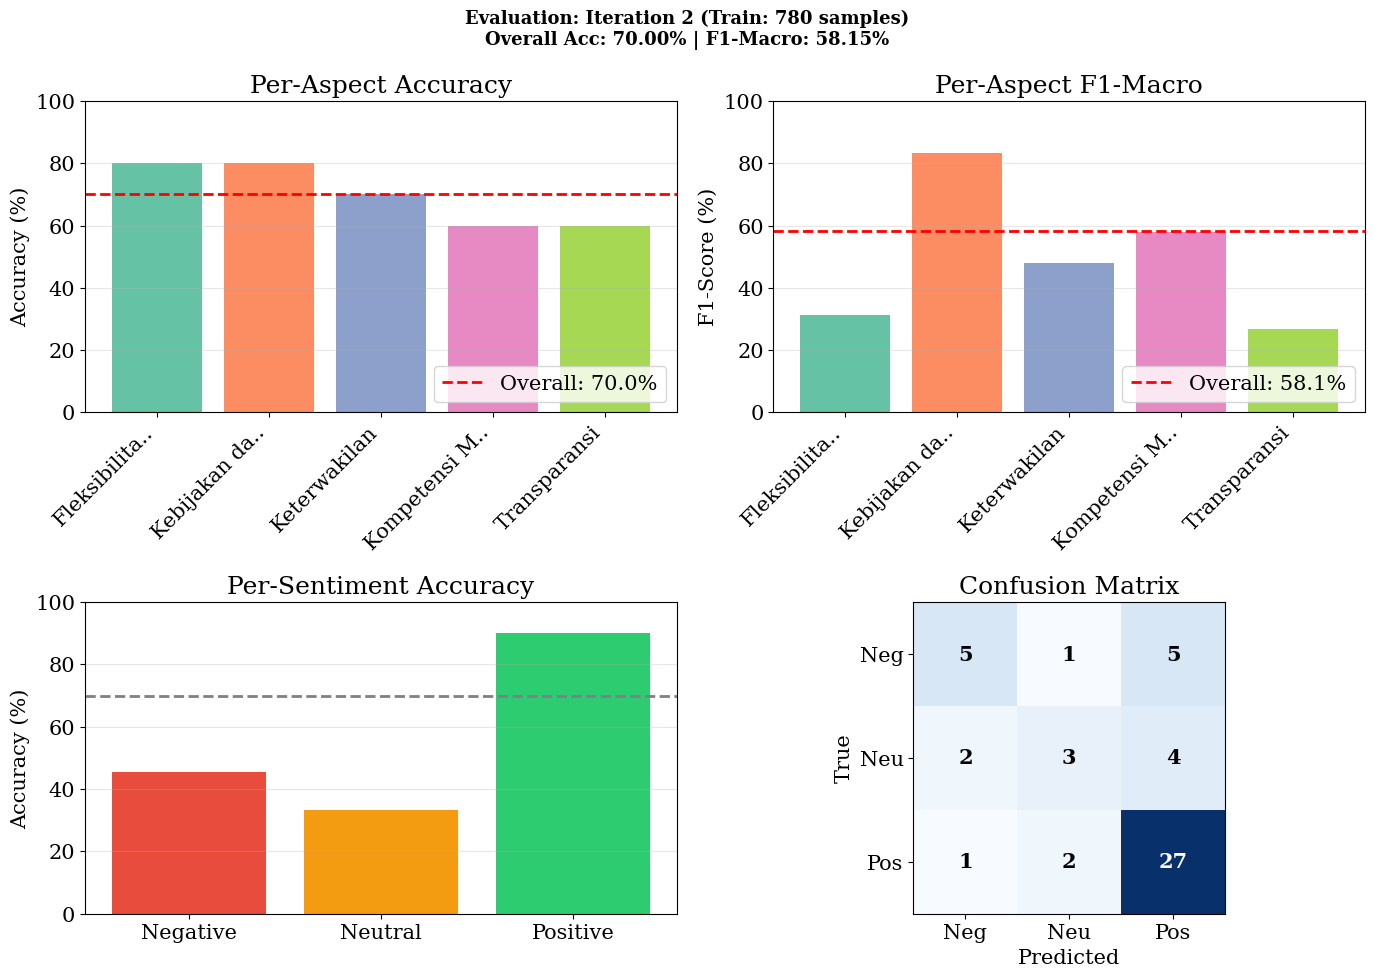

Evaluation saved: D:\ANBOW\New folder (3)\figures_iterative\iter2_evaluation.png

-> After Iter 2: Total training = 1325 samples
   (Gold: 235 + Pseudo: 1090)

 ITERATION 3: PSEUDO-LABELING (~545 labels)
 Model: FAST_LSA_T
 Current training: 1325 samples
 Thresholds: POS>=0.4, NEG>=0.4, NEU>=0.3
 Keyword Bonus: 0.12

Files created in \iter3_training:
  - iter3.test.dat.apc: 13327 bytes
  - iter3.train.dat.apc: 353228 bytes
  - iter3.valid.dat.apc: 13526 bytes
Training model for iteration 3...
[2026-01-03 19:49:05] (2.4.2) Set Model Device: cuda:0
[2026-01-03 19:49:05] (2.4.2) Device Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
2026-01-03 19:49:05,611 INFO: PyABSA version: 2.4.2
2026-01-03 19:49:05,615 INFO: Transformers version: 4.57.3
2026-01-03 19:49:05,617 INFO: Torch version: 2.7.1+cu118+cuda11.8
2026-01-03 19:49:05,617 INFO: Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU
[2026-01-03 19:49:05] (2.4.2) Try to load ['\\iter3_training'] dataset from local disk


C:\Users\DLH JATIM\AppData\Local\Programs\Python\Python310\lib\multiprocessing\pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


2026-01-03 19:49:10,430 INFO: Load dataset from dataset_iterative\iter3_training\iter3.train.dat.apc


preparing dataloader: 100%|██████████| 1325/1325 [00:00<00:00, 1691.63it/s]


2026-01-03 19:49:11,247 INFO: Dataset Label Details: {'1': 88, '2': 928, '0': 309, 'Sum': 1325}
2026-01-03 19:49:11,688 INFO: train data examples:
 [{'ex_id': tensor(0), 'text_raw': 'halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut Fleksibilitas Fleksibilitas', 'text_spc': '[CLS] halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut Fleksibilitas Fleksibilitas [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor([0.1818, 0.2121, 0.2424, 0.2727, 0.3030, 0.3333, 0.3636, 0.3939, 0.4242,
        0.4545, 0.4848, 0.5152, 0.5455, 0.5758, 0.6061, 0.6364, 0.6667, 0.6970,
        0.7273, 0.7576, 0.7879, 0.8182, 0.8485, 0.8788, 0.9091, 0.9394, 0.9697,
        

preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 1608.76it/s]


2026-01-03 19:49:12,264 INFO: Dataset Label Details: {'1': 9, '2': 30, '0': 11, 'Sum': 50}
2026-01-03 19:49:12,310 INFO: test data examples:
 [{'ex_id': tensor(0), 'text_raw': 'sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden Fleksibilitas Fleksibilitas', 'text_spc': '[CLS] sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden Fleksibilitas Fleksibilitas [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor([0.2000, 0.2333, 0.2667, 0.3000, 0.3333, 0.3667, 0.4000, 0.4333, 0.4667,
        0.5000, 0.5333, 0.5667, 0.6000, 0.6333, 0.6667, 0.7000, 0.7333, 0.7667,
        0.8000, 0.8333, 0.8667, 0.9000, 0.9333, 0.9667, 1.0000, 1.0000, 1.0000,
        

preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 1481.66it/s]


2026-01-03 19:49:12,702 INFO: Dataset Label Details: {'1': 3, '2': 30, '0': 17, 'Sum': 50}
2026-01-03 19:49:12,735 INFO: valid data examples:
 [{'ex_id': tensor(0), 'text_raw': 'idrus marham puji langkah menteri bahlil percepat pembayaran kompensasi energi kebijakan inovatif untuk rakyat Fleksibilitas Fleksibilitas', 'text_spc': '[CLS] idrus marham puji langkah menteri bahlil percepat pembayaran kompensasi energi kebijakan inovatif untuk rakyat Fleksibilitas Fleksibilitas [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor([0.2609, 0.3043, 0.3478, 0.3913, 0.4348, 0.4783, 0.5217, 0.5652, 0.6087,
        0.6522, 0.6957, 0.7391, 0.7826, 0.8261, 0.8696, 0.9130, 0.9565, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0

Epoch:  0 | Smooth Loss: 0.6336: 100%|██████████| 83/83 [00:22<00:00,  3.64it/s, Dev Acc:68.00(max:70.00) Dev F1:44.40(max:47.90)]
Epoch:  1 | Smooth Loss: 0.4880: 100%|██████████| 83/83 [00:21<00:00,  3.90it/s, Dev Acc:70.00(max:72.00) Dev F1:55.71(max:57.25)]
Epoch:  2 | Smooth Loss: 0.3905: 100%|██████████| 83/83 [00:23<00:00,  3.60it/s, Dev Acc:72.00(max:74.00) Dev F1:60.38(max:62.61)]
Epoch:  3 | Smooth Loss: 0.3261: 100%|██████████| 83/83 [00:23<00:00,  3.58it/s, Dev Acc:70.00(max:74.00) Dev F1:62.15(max:63.77)]
Epoch:  4 | Smooth Loss: 0.2773: 100%|██████████| 83/83 [00:22<00:00,  3.75it/s, Dev Acc:64.00(max:74.00) Dev F1:47.31(max:63.77)]


[2026-01-03 19:51:05] (2.4.2) Loading best model: checkpoints/fast_lsa_t_custom_dataset_acc_70.0_f1_63.77/ and evaluating on test set 
2026-01-03 19:51:05,912 INFO: 
-------------------------------------------------------------------- Raw Metric Records --------------------------------------------------------------------
╒══════════════╤══════════════════════════════════════════════════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric       │ Trial                                                    │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞══════════════╪══════════════════════════════════════════════════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Max-Test-Acc │ fast_lsa_t-custom_dataset-indobenchmark/indobert-base-p2 │ [64.0]              │    64     │    64    │   0   │   0   │   64    │   64    │
├──────────────┼─────────────────────────────────

d:\ANBOW\New folder (3)\venv_pyabsa2\lib\site-packages\pyabsa\framework\trainer_class\trainer_template.py:250: ResourceWarning: unclosed file <_io.TextIOWrapper name='d:\\ANBOW\\New folder (3)\\logs\\fast_lsa_t_20260103 194534\\trainer.log' mode='a' encoding='utf8'>
  self.config.logger.removeHandler(self.config.logger.handlers[0])


Model training completed
Found checkpoint: checkpoints\fast_lsa_t_custom_dataset_acc_70.0_f1_63.77
Checkpoint saved to: D:\ANBOW\New folder (3)\checkpoints_iterative\iter3_model\fast_lsa_t_custom_dataset_acc_70.0_f1_63.77
[2026-01-03 19:51:11] (2.4.2) Load sentiment classifier from checkpoints\fast_lsa_t_custom_dataset_acc_70.0_f1_63.77
[2026-01-03 19:51:11] (2.4.2) config: checkpoints\fast_lsa_t_custom_dataset_acc_70.0_f1_63.77\fast_lsa_t.config
[2026-01-03 19:51:11] (2.4.2) state_dict: checkpoints\fast_lsa_t_custom_dataset_acc_70.0_f1_63.77\fast_lsa_t.state_dict
[2026-01-03 19:51:11] (2.4.2) model: None
[2026-01-03 19:51:11] (2.4.2) tokenizer: checkpoints\fast_lsa_t_custom_dataset_acc_70.0_f1_63.77\fast_lsa_t.tokenizer
[2026-01-03 19:51:11] (2.4.2) Set Model Device: cuda:0
[2026-01-03 19:51:11] (2.4.2) Device Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Available unlabeled texts: 1226
Target per aspect: ~114


Pseudo-labeling Iter 3:   0%|          | 0/1226 [00:00<?, ?it/s]

[2026-01-03 19:51:14] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pernyataan seperti itu dan surat seperti ini yang juga dikeluarkan oleh perpanjangan tangan negara itu punya kesamaan pemerintah ingin berkuasa tanpa akuntabilitas tanpa evaluasi tanpa rasa malu yang penting indonesia maju dan makmur buat mereka-mereka aja


d:\ANBOW\New folder (3)\venv_pyabsa2\lib\site-packages\pyabsa\tasks\AspectPolarityClassification\prediction\sentiment_classifier.py:326: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  t_outputs_all = np.array(sen_logits.cpu()).astype(np.float32)


[2026-01-03 19:51:14] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sepanjang kodok belum jadi spike sepanjang wapres fufufafa si anak haram konstitusi belum direhabilitasi lalu diisolasi sepanjang kapolri dan panglima tni belum diganti sepanjang para termal di kementerian kepala badan pejabat setingkat menteri lainnya hingga
[2026-01-03 19:51:14] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] joki kehilangan pulung dan terkena karma atas kerakusan dirinya terbaru soal whoosh yang diduga asa markus seharusnya joki sudah bisa dihidangkan soal kebijakan yang merugikan negara kejaksaan jangan cuma beraninya ke tom gembong dan nadim makasih
[2026-01-03 19:51:14] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sampai ju

Pseudo-labeling Iter 3:   0%|          | 5/1226 [00:00<00:25, 47.68it/s]

[2026-01-03 19:51:14] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] galon sekali pakai tidak akan sejalan dengan target pemerintah untuk mengurangi sampah laut sebesar di apalagi data tahun tpa sudah overload seperti tpa hitungan yogyakarta belum lagi ancaman soal kebakaran yang menanti yang menambah polusi udara
[2026-01-03 19:51:14] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemilu itu bukan soal menang dan kalah pemilu itu tentang menentukan siapa nahkoda dan arah kebijakan negara mau yang menang yang kita dukung atau bukan lihat dan awasi kebijakannya kalau ada kebijakan bego ya bilang ingat nyanyiin rezim itu selamanya siapa pun
[2026-01-03 19:51:14] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] seru jug

Pseudo-labeling Iter 3:   1%|          | 10/1226 [00:00<00:28, 42.22it/s]

[2026-01-03 19:51:14] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ringkasan yang terjadi di korsel semalam kebijakan dan tingkah presiden yoon seohyeon aneh-aneh istrinya ikut campur urusan negara ngelindungin petinggi militer dari kasih kematian anggota tragedi itaewon dia lepas tangan banyak budget kementrian dicat salah
[2026-01-03 19:51:14] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kelakuan kampus ini setahun terakhir bem undang rocky gedung izin diskusinya dicabut dekan fk kritik kebijakan dokter asing diturunin rektor terus dibatalin alasan diturunin maupun dibatalkannya gak jelas bem dibekukan karena karangan bunga satir
[2026-01-03 19:51:14] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] israel unit

Pseudo-labeling Iter 3:   1%|          | 15/1226 [00:00<00:30, 39.90it/s]

[2026-01-03 19:51:14] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kabar kenaikan gaji aparatur sipil negara asn tni polri dan pegawai pemerintah dengan perjanjian kerja pppk sebesar persen kembali ramai diperbincangkan di media sosial lewat
[2026-01-03 19:51:14] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ya allah kebanyakan tenaga gw tapping tentang kebijakan butut pemerintah ini
[2026-01-03 19:51:14] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] inilah salah satu alasan kenapa pemerintah seharusnya segera membuat peraturan yang jelas soal penggunaan ai
[2026-01-03 19:51:14] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-

Pseudo-labeling Iter 3:   2%|▏         | 20/1226 [00:00<00:29, 40.43it/s]

[2026-01-03 19:51:14] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri koordinator bidang politik dan keamanan pada kabinet merah putih periode kepemimpinan menka jenderal polisi pun prof dr budi gunawan sh phd wakil menteri letnan jenderal tni pun h lidewij freidrich paulus
[2026-01-03 19:51:14] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] teruslah membenci pemerintah sampai kalian butuh bantuan keimigrasian di rantau jangan baper yah ini kejadian lucu di wag emak emak old
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] spbu swasta keabisan stok bbm utk setahun karena masyarakat beralih dari pertama artinya itungan bisnisnya dah profit ntar aja nunggu tahun depan impor lagi jadi ya men

Pseudo-labeling Iter 3:   2%|▏         | 25/1226 [00:00<00:28, 42.56it/s]

[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] meg dan sekolah rakyat ini contoh keberpihakan nyata untuk masyarakat bawah hanya pelaksanaannya tidak harus negara hadir sampai meja makan negara itu sebaiknya main di kebijakan dan distribusi sumber daya saja
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] masya allah tabik dato cc presiden ri coba teladani dato dalam kebijakan energi bbm khususnya turunkan harga bbm efisiensi cost of production menke ganti menteri esdm bahlul yg gagal krn bbm langka di aceh dll allahu alam
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebobrokan suatu bangsa dimulai dari bobroknya para pejabat amp pemangku kekuasaan s

Pseudo-labeling Iter 3:   2%|▏         | 30/1226 [00:00<00:33, 35.94it/s]

[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ini sesat dan kesalah berpikir ya temen kalo pemerintah yakin logic orang ini ya ancur negara negara dibuat carsentric bangun jalan lebih gk akan mengatasi kemacetan ujungnya akan macet lgi karena makin banyak orang tergoda beli mobil ibarat ada semut malah dikasih
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] spp polda jabar sukses jalankan program meg bumil dan balita rasakan manfaat nyata program makan bergizi gratis meg yang digagasi pemerintah dan dilaksanakan oleh satuan pelaksana program gizi spp polda jawa barat mendapat apresiasi dan ucapan terima kasih dari para
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global S

Pseudo-labeling Iter 3:   3%|▎         | 34/1226 [00:00<00:32, 36.34it/s]

[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menke purbanya yudha dewa memastikan iuran bpjs kesehatan tidak naik hingga pertengahan meski pemerintah menambah anggaran bpjs sebesar rp triliun ia menegaskan keputusan soal iuran tidak semata berdasar pada tambahan anggaran purbanya memastikan iuran bpjs kesehatan
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yang bela odol siapa kok jadi framing kesana ini sejelas itu lho nyeritain konteks pov supir yang di dan protes ke pemerintah kenapa hanya berat ke supir yang dihukum padahal cuma kerja yg punya kendaraan atau jasanya cuci tangan
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] revisi uu ite dpr d

Pseudo-labeling Iter 3:   3%|▎         | 39/1226 [00:00<00:29, 39.58it/s]

[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kasus video deepak ai yang melibatkan mahasiswa undi chiko radityatama agung putra membuat pemerintah provinsi jawa tengah membuka posko pengaduan bagi para korban di bawah upto perlindungan perempuan dan anak ppa kepala upto ppa eka surati meminta korban segera
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] statement sarah yang sdh agak lama jadi pemicu dia bilang seharusnya generasi muda menunggu lapangan kerja dari pemerintah tetapi harus kreatif menciptakan lapangan kerja sendiri itu dianggap keliru oleh netizen modalnya dari mana kata netizen
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalau oran

Pseudo-labeling Iter 3:   4%|▎         | 44/1226 [00:01<00:28, 41.16it/s]

[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dalam menjalankan program makan bergizi gratis meg presiden prabowo sugianto menegaskan satu insiden pun tetap tidak bisa ditoleransi komitmen ini menjadi bukti keseriusan pemerintah memastikan setiap dapur spp dan setiap makanan yang disajikan memenuhi standar keamanan
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jawab jujur pernah ga kalian nangis kebijakan pemerintah
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kegagalan reforma agraria reforma agraria yang seharusnya menjadi agenda pokok negara justru macet di birokrasi alih-alih membatasi penguasaan tanah oleh konglomerat dan korporasi pemerinta

Pseudo-labeling Iter 3:   4%|▍         | 49/1226 [00:01<00:28, 40.99it/s]

[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] selalu digabungkan adalah minat baca buku orang indonesia rendah selalu warganya yang disudutkan tapi apakah kalian pernah bertanya pada pemerintah bagaimana mereka membuat kebijakan yang seharusnya bisa memudahkan akses buku menurunkan harga buku memberantas pembajakan
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lenny trio kwek kwek mengupas laporan keuangan pemerintah kota tangerang selatan milyar untuk atk milyar untuk souvenir protect her at all cost
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menke purbanya buka suara mengenai perbedaan data dana pemerintah di bank ia mengatakan persoalan ini 

Pseudo-labeling Iter 3:   4%|▍         | 54/1226 [00:01<00:27, 42.35it/s]

[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tabungan penderitaan rakyat kilas pekerja terus-terusan jadi sapi perah demi biayai kebijakan antah berantah dari pejabat negara yang tak pernah amanah dan selalu bikin rakyat susah
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jadi gini pak purbanya ini bisa menjadi fenomena besar di jika terus menjalankan kebijakan yang pro rakyat dan pro negara baru beberapa bulan saja kecintaan rakyat mulai mengalir deras dan para menjegalnya akan tenggelam dgn sendirinya
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ada banyak pilihan kebijakan yang bisa diambil pemerintah untuk menanggapi gejolak ekonomi saat ini

Pseudo-labeling Iter 3:   5%|▍         | 59/1226 [00:01<00:26, 43.36it/s]

[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] standarisasi kebersihan spp untuk cegah kasus meg presiden prabowo sugianto menegaskan komitmen pemerintah dalam menjaga kualitas program makan bergizi gratis meg hingga kini program ini sudah menjangkau hampir juta penerima manfaat hanya dalam waktu kurang dari
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tingkat kepuasan program meg sangat tinggi ini menjadikannya sebagai program favorit pemerintah prabowo
[2026-01-03 19:51:15] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sekjen pip hasta menyebut budi gunawan yang diprediksi mengisi pos menteri kabinet prabowogibran ke depan bukan keterwakilan pip
[2026-01-03 19:51:16]

Pseudo-labeling Iter 3:   5%|▌         | 64/1226 [00:01<00:31, 36.70it/s]

[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] aku jadi shell mending mundur teratur invest di negara lain daripada credibility dan kualitas dipertaruhkan urusan lay off pasti shell juga ga mau dan sebetulnya bukan tanggung jawab shell juga good luck deh indonesia kalo esnya masih dgn kebijakan yang absurd
[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jadi maksudnya gimana diplomat itu kan kerja buat mengawal kebijakan polusi sebuah negara
[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri di kabinet prabowo yang selalu membuat kebijakan kontroversi dan bikin repot rakyat jatuh kepada
[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment do

Pseudo-labeling Iter 3:   6%|▌         | 69/1226 [00:01<00:29, 38.71it/s]

[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] seharusnya prabowo berani menindak tegas para kepala daerah yang membuat kebijakan ngaco yang bisa mengancam keutuhan berbangsa dan bernegara
[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] abah menjadi narasumber pci foreign policy community of indonesia kebijakan luar negeri dan juga menghadiri undangan acara pci pimpinan bapak dino patti jalal mantan menteri luar negeri indonesiapada oktober
[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan aneh bikin disintegrasi bangsa dan diskriminatif kebijakan yang dilakukan gubernur sudut boby nasution dianggap diskriminatif dan dapat memperkeruh hubungan 

Pseudo-labeling Iter 3:   6%|▌         | 74/1226 [00:01<00:28, 40.05it/s]

[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] urus negara yg bener cuk jangan usik kami yg udah stress nyari coming mechanism gara gara kebijakan kalian
[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dunia pendidikan dan pekerjaan mestinya membuka ruang selebar-lebarnya kepada siapapun apa yang disampaikan mas surya sahetapy juga mesti jadi pembelajaran buat kita semua bahwa memanusiakan manusia harus terejawantahkan dalam peraturan kebijakan dan program kerja siapapun
[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] emang dengan berisik di sosial media bisa mengubah kebijakan bro neng justru banyak kebijakan berubah atau bahkan dibatalkan karena warg

Pseudo-labeling Iter 3:   6%|▋         | 79/1226 [00:01<00:30, 37.80it/s]

[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] padahal ada mataku demokrasi dan demokratisasi mataku keterwakilan dan sistem perwakilan sejarahnya politik lokal dll berasa nah noh lihat tingkah laku dpr dan pemerintah pusat
[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] soal pajak ini gimana ya pak problemnya saat rakyat masih kesusahan dapat akses dasar dan itu belum dipenuhi negara para pejabatnya malah digaji tinggi dan bahkan minta insentif lebih keterwakilan para pejabat ini tak lain hanya untuk mereka sendiri bukan untuk rakyat
[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] parenting jaman sekarang susah digempur gula up asap rokok polusi sempi

Pseudo-labeling Iter 3:   7%|▋         | 84/1226 [00:02<00:28, 39.51it/s]

[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] keberanian publik untuk terus menyuarakan aspirasi belum sepenuhnya padam jejak pendapat kompas menunjukkan responden menyatakan berani atau semakin berani untuk tetap mengkritisi kebijakan pemerintah
[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] trauma kelam tudingan pelanggaran ham prabowo traumatik akan tudingan masyarakat tentang pelanggaran ham dimasa lalu mungkin terlalu kuat menggelayuti dalam ingatan prabowo dan mempengaruhi berbagai kebijakankebijakannya sebagai
[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kita berhak menentukan pilihan mana yang akan kita putuskan menjalin kemitraan dengan n

Pseudo-labeling Iter 3:   7%|▋         | 89/1226 [00:02<00:28, 40.14it/s]

[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kendati validasi keterwakilan daerah dalam munaslub kadin diragukan pemerintah tetap memfasilitasi dengan kempes baru
[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] aneh banget pemerintah ini guru-guru bergaji kecil diminta ikhlas sementara para pejabat-pejabat menikmati fasilitas dan barangbarang berkelas anjayyyy kesenjangan terpampang jelas
[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menuju pengucapan sumpah dan janji presiden yang akan berlangsung minggu oktober kami sempat menemui prabowo di hambatan dan bertanya apakah ia akan pindah dari hambatan usai resmi menjadi presiden ri yang jelas kita s

Pseudo-labeling Iter 3:   8%|▊         | 94/1226 [00:02<00:28, 39.20it/s]

[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] perdana menteri yunani kyriakos mitsotakis mengumumkan reformasi pajak senilai rp triliun untuk meringankan beban kelas menengah sekaligus mendorong angka kelahiran kebijakan ini diumumkan dalam pidato tahunan di pameran internasional thessaloniki salah satu langkah
[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] reshuffle kabinet prabowo tidak menyentuh akar masalah problem kita hari ini adalah kelesuan ekonomi akibat kebijakan pemerintah
[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sejak saat masih menjadi menteri pertahanan prabowo tidak pernah menyusun strategic defence review dan buku putih pertaha

Pseudo-labeling Iter 3:   8%|▊         | 99/1226 [00:02<00:26, 41.87it/s]

[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] enggak terbayang banyaknya rp triliun gubernur dedi mulyadi tidak terima dengan pernyataan menteri keuangan purbanya yudha dewa kalau dana pemerintah daerah pemda mengendap di deposito di perbankan bahkan pria yang kerap disapa kang dedi itu menantang purbanya untuk
[2026-01-03 19:51:16] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebalik kami di aliansi masyarakat untuk keadilan pajak sudah gabungkan sejak desember ketimpangan ekonomi udah jadi perhatian sejak awal dari wacana ppn mau dinaiki narasinya jg sama kenapa paket kebijakan dari pemerintah pro orang kaya terus kenapa
[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP]

Pseudo-labeling Iter 3:   8%|▊         | 104/1226 [00:02<00:28, 39.48it/s]

[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] work fresh graduate cuma ada pengalaman intern menurut kakak kakak lebih menjanjikan ikut di bumn ibukota provinsi masih jawa atau cpns instansi pemerintah pusat
[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gas terus pak teddy sesuai teddy lagi on fire kawal langsung program prioritas pemerintah bareng tim super solid program makan siang amp susu gratis terus dibenarkan sama pak teddy bareng tim anakanak sekolah sekarang makin semangat belajar karena
[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bantuan kemanusiaan polri bagi korban banjir bandang dan tanah longsor di kecamatan mauponggo kabupaten nam

Pseudo-labeling Iter 3:   9%|▉         | 109/1226 [00:02<00:27, 41.24it/s]

[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] anugerah adinata syariah memberikan penghargaan kepada pemerintah daerah dan pelaku kebijakan yang telah membangun dan mengembangkan ekosistem ekonomi syariah di wilayah masing-masing teruslah menjadi inspirasi untuk indonesia yang lebih adil dan berkah melalui
[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] negara hukum itu berarti semua tindakan dan kebijakan negara harus dilandaskan kepada hukum hukum yang bagaimana hukum yang adil dan mengandung kepastian hukum itu dirumuskan oleh negara ke dalam norma yang bersifat mengatur dan dapat dilaksanakan di dalam praktek
[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentime

Pseudo-labeling Iter 3:   9%|▉         | 114/1226 [00:02<00:26, 41.56it/s]

[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kakorlantas polri arjen pol agus suryonugroho menegaskan adanya evaluasi terkait penggunaan sirene dan strobo terutama pada waktu sore hingga malam serta saat azan berkumandang kebijakan ini lahir sebagai respons atas aspirasi masyarakat yang merasa terganggu dengan penggunaan
[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] reshuffle kabinet prabowo tidak menyentuh akar masalah problem kita hari ini adalah kelesuan ekonomi akibat kebijakan pemerintah
[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] emang dengan berisik di sosial media bisa mengubah kebijakan bro neng justru banyak kebijakan berubah atau bah

Pseudo-labeling Iter 3:  10%|▉         | 119/1226 [00:03<00:30, 36.09it/s]

[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] selalu digabungkan adalah minat baca buku orang indonesia rendah selalu warganya yang disudutkan tapi apakah kalian pernah bertanya pada pemerintah bagaimana mereka membuat kebijakan yang seharusnya bisa memudahkan akses buku menurunkan harga buku memberantas pembajakan
[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bro kalau lo semua belajar tentang kebijakan publik lo akan sadar klo hidup lo yg ga seberapa ini beneran diatur sama negara
[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] need joki tugas kebijakan pemerintah
[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its num

Pseudo-labeling Iter 3:  10%|█         | 124/1226 [00:03<00:28, 38.66it/s]

[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] vacation without representatif is a crime prinsip ini berasal dari sejarah revolusi amerika di mana rakyat menolak pajak yang diberlakukan oleh pemerintah inggris tanpa adanya keterwakilan mereka dalam proses pengambilan keputusan solusinya apa rise of the network state
[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri esdm tegaskan komitmen kedaulatan energi dan transparansi baca selengkapnya
[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mantan gubernur di jakarta masuki sahaja purnama atau ahoy menilai pemerintah perlu memusatkan perhatian pada tiga hal utama untuk memperkuat kepercayaan publik d

Pseudo-labeling Iter 3:  11%|█         | 129/1226 [00:03<00:31, 35.11it/s]

[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] proyek besar sebuah pola yang terus berulang keuntungan swasta menikmati kerugian beban negara fenomena ini menyingkap persoalan serius soal tanggungjawab transparansi amp keadilan fiskal
[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kolaborasi untuk tata kelola yang lebih kuat sinergi antara kilang pertama internasional api unit balikpapan dan kejaksaan kalimantan timur jadi wujud komitmen transparansi dan akuntabilitas dalam setiap langkah operasional
[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] x batal diblokir oleh komando usai mendengar penjelasan kebijakan pornografi
[2026-01-03 19:51:17] (2.4.2

Pseudo-labeling Iter 3:  11%|█         | 134/1226 [00:03<00:28, 38.42it/s]

[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] keberanian publik untuk terus menyuarakan aspirasi belum sepenuhnya padam jejak pendapat kompas menunjukkan responden menyatakan berani atau semakin berani untuk tetap mengkritisi kebijakan pemerintah
[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketika sesuai teddy dan menakar duduk bareng untuk dorong kemajuan program magang nasional itu namanya aksi nyata bangga lihat pemerintah serius buka ruang bagi kaum muda untuk belajar amp berkembang terus semangat untuk semua talenta indonesia
[2026-01-03 19:51:17] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] work hi guys please write down bellow kalo ada yg punya info loker bida

Pseudo-labeling Iter 3:  11%|█▏        | 139/1226 [00:03<00:27, 38.85it/s]

[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bagus sekali penjelasan di atas ini terima kasih apa dulu meneliti kebijakan pbb di jakarta untuk skripsinya
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tolong jawab jika ada satu orang yang harus diadili karena kebobrokan kebijakan pemerintah siapakah itu
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah sepertinya dengan gampang mengatur kebijakan gratis cangkir di marketplace kenapa mengatur buku bajakan tidak pernah beres ya karena mereka emang nggak mau aja
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-

Pseudo-labeling Iter 3:  12%|█▏        | 144/1226 [00:03<00:28, 38.25it/s]

[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] demi investasi hilirisasi indonesia negara terbesar ke di dunia banyak kehilangan hutan dibabat habis demi konsesi ijin lahan pertambangan serta perkebunan diberikan pemerintah ke perusahaan untuk di kelola
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] semprot menutup lowongan kerja bagi penyedia jasa lainnya perorangan pulp untuk tahun depan karena adanya pengurangan dana transfer dari pemerintah pusat ke daerah ini sehingga mempengaruhi jumlah anggaran
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kami mengingatkan pemerintah dan aparat diamnya negara adalah bentuk keterlibatan dalam kejahatan keadil

Pseudo-labeling Iter 3:  12%|█▏        | 149/1226 [00:03<00:26, 40.51it/s]

[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalian tau ga pns kudeta amp skill minim yg saat ini mendiami pemerintah itu hasil dari mana hasil dari kebijakan era sby pengangkatan pns besaran tanpa tes kalo pppk tanpa pengecualian apalagi yg th keatas diangkat pns tanpa tes apakabar masa depan indonesia th kedepan
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] negara seharusnya melindungi rakyat tapi kalau yang dijaga justru elit bisnis dan politik indonesia bisa melangkah ke arah negara predator di mana tempat kebijakan dibuat by the few for the few
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah akan memberlakukan kebijakan zero over di

Pseudo-labeling Iter 3:  13%|█▎        | 154/1226 [00:03<00:26, 39.88it/s]

[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ppnbappenas memastikan kebijakan pemerintah membeli gabah rp per kilogram di tingkat petani menjadi langkah strategis
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] utk angket adalah kualitatif tak pakai presentasi karena tak menghitung hasil pemilu melainkan menilai implementasi uu dlm kebijakan pemerintah utk jalur hukum a kalau menghitung angka harus membuktikan angka scr signifikan misalnya dari kemenangan ada kesalahan angka yg
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setuju sih alasan ini lamanya jeda waktu menuju pelantikan membuat pemerintahan saat ini tidak bisa berjalan maksimal karena pr

Pseudo-labeling Iter 3:  13%|█▎        | 159/1226 [00:04<00:28, 37.43it/s]

[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tidak ada permintaan maaf dari pemerintah kepada masyarakat karena peristiwa itu tetapi pemerintah menyatakan mengakui bahwa peristiwa itu memang terjadi dan pemerintah menyesali pemerintah menyatakan akan menyelesaikan kasus pelanggaran ham berat di masa lalu secara
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ada banyak pilihan kebijakan yang bisa diambil pemerintah untuk menanggapi gejolak ekonomi saat ini termasuk kondisi industri manufaktur yang terus menunjukkan kemerosotan semoga kebijakan yang diambil tepat sasaran dan tidak hanya mengedepankan aspek populis semata
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global

Pseudo-labeling Iter 3:  13%|█▎        | 164/1226 [00:04<00:27, 39.16it/s]

[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] cukup sudah cukup rakyat menderita dengan kebijakan pemerintah pusat sebanyak masyarakat adat dari berbagai daerah di indonesia menolak pun yang digagasi pemerintah
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pengetahuan saya tentang tatanegara hanya terbatas noticing kontradiksi atas retorika populis yang ditujukan pada pemilih median pilpres dan kebijakan dan saya tidak dapat menilai satu persatu yang mana yang lebih baik antara dua hal tsb beri saya triliun likes
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setidaknya itu bukan kebijakan menterinya bro tapi yang dirasakan saat ini urusan pajak ya

Pseudo-labeling Iter 3:  14%|█▎        | 168/1226 [00:04<00:27, 37.93it/s]

[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] banyak korban bullying memilih diam memendam sakit itu sendiri bukan karena tidak mau terbuka tapi karena kurangnya tempat untuk cerita keluarga sekolah lingkungan serta pemerintah wajib hadir untuk memberikan ruang bagi mereka jadikan sakit mereka sakit kita bersama
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalau orang miskin ngambil duit orang kaya sebutannya ngerampok kalau orang kaya ngambil duit orang miskin sebutannya bisnis kalau pejabat ngambil duit rakyat sebutannya koruptor kalau pemerintah ngambil duit rakyat sebutannya kebijakan
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pesan sesuai

Pseudo-labeling Iter 3:  14%|█▍        | 173/1226 [00:04<00:26, 39.77it/s]

[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dengan membungkam mereka negara bukan hanya menutup satu suara tapi menutup seluruh kemungkinan koreksi terhadap kebijakan publik banyak alasan mereka yang bersuara bukan ancaman mereka adalah alarm peringatan bagi kita semua kalau alarm itu
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ikatan dokter anak indonesia meminta pemerintah untuk memperkuat kebijakan udara bersih dan kawasan tanpa rokok di ruang publik
[2026-01-03 19:51:18] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setidaknya ada tiga titik krusial yang menjadi catatan satu tahun pemerintahan yaitu kabinet yang gemuk perubahan fundamental kebijakan dan desentr

Pseudo-labeling Iter 3:  15%|█▍        | 178/1226 [00:04<00:27, 37.47it/s]

[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] harapannya semakin memperkuat transparansi kolaborasi dan kepercayaan antara pemerintah dan masyarakat
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] forum indonesia untuk transparansi anggaran fitra membeberkan penghasilan anggota dpr bisa mencapai sekitar rp juta per bulan atau sekitar rp miliar per tahun baca di sini
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kericuhan terjadi saat aksi unjuk rasa ratusan pedagang kaki lima teras malioboro di depan gedung dprd daerah istimewa yogyakarta massa aksi dalam demo tersebut menuntut adanya transparansi dan keberpihakan pemerintah daerah terkait relokasi 

Pseudo-labeling Iter 3:  15%|█▍        | 182/1226 [00:04<00:30, 34.54it/s]

[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] halo sahabat gaji dan tunjangan anggota dpr ri tengah menuai sorotan publik sebelumnya disebut penghasilan anggota dpr ri mencapai rp juta per bulan namun forum indonesia untuk transparansi anggaran fitra menyebutkan penghasilan anggota dpr
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] uu sisdiknas kita yang lama sudah tidak relevan karena itu kami ingin memastikan revisi uu ini bisa menjawab tuntutan seluruh provinsi termasuk papua tidak boleh ada ketimpangan dalam penerapan kebijakan pendidikan nasional salam sinaga
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pakar nilai kebijakan etanol bahlul lan

Pseudo-labeling Iter 3:  15%|█▌        | 187/1226 [00:04<00:27, 37.76it/s]

[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gubernur jawa barat dedi mulyadi memilih untuk tidak ikut memprotes kebijakan pemerintah pusat yang memangkas dana transfer ke daerah
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ppn atas layanan streaming bukan pajak baru untuk golongan bukan barang mewah nilai ppn terutang masih sama seperti sebelumnya kebijakan ini merupakan bentuk keadilan bagi masyarakat yuk pelajari lebih lanjut tentang kebijakan ppn layanan digital di video
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rakyat menjadi pusat kebijakan hasil nyata satu tahun pemerintahan yang berpihak
[2026-01-03 19:51:19] (2.4.2) Warning: referen

Pseudo-labeling Iter 3:  16%|█▌        | 191/1226 [00:04<00:27, 38.01it/s]

[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hacker korea utara disebut mencuri miliaran dolar kripto untuk mendanai program nuklir mereka bahkan menyamar sebagai pekerja jarak jauh di luar negeri dan mengirim gajinya langsung ke pemerintah demi membiayai ambisi militer pyongyang penulis dinas riftia lainufar kreatif
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jurnalpatrolinews jakarta rencana pemerintah untuk menerapkan kebijakan manatory bahan bakar campuran etanol sebesar e pada produk bensin mulai menjadi perhatian publik dan kalangan industri energi
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rencana penerapan sistem gaji tunggal single 

Pseudo-labeling Iter 3:  16%|█▌        | 196/1226 [00:05<00:25, 40.39it/s]

[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program meg udah jadi contoh bagus gimana kebijakan bisa kasih efek positif langsung semoga program kayak gini makin banyak ke depannya
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] manusia memang cuma bisa berencana kebijakan pemerintah yang tidak tepat rasakanlah yang menentukannya
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saatnya pemerintah menetapkan peraturan bahwa negara wajib ikut menanam modal dan memiliki saham mayoritas minimal serta turut mengelola setiap perusahaan pertambangan langkah ini bertujuan untuk mencegah praktik mafia dan menjaga kedaulatan sumber daya nasional
[2026-01-03 19:

Pseudo-labeling Iter 3:  16%|█▋        | 201/1226 [00:05<00:26, 38.21it/s]

[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kapolres trenggalek hadiri apel akbar kebangsaan dorong buruh dukung kebijakan pemerintah kepala kepolisian resor trenggalek akup ridwan maliki sh sik mik menghadiri apel akbar kebangsaan yang diikuti oleh ratusan buruh di pelataran pt ali putra
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] banyak siswa gagal dapatkan beasiswa pip demokrat dorong pemerintah benahi data apotik sekolah di papua pegunungan banyak anakanak yang seharusnya mendapatkan beasiswa pip justru tidak menerima karena data apotik tidak sinkron ini persoalan serius yang harus dibenahi agar
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP

Pseudo-labeling Iter 3:  17%|█▋        | 206/1226 [00:05<00:25, 39.77it/s]

[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rasanya tubuh saya terbakar seperti ada yang menggergaji saya dari kepala sampai kaki kata orang tua yang kehilangan tiga anak akibat malnutrisi kebijakan taliban dan bantuan yang dihentikan trump membuat makin banyak anak di afganistan kelaparan
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di balik senyum seorang ayah yg sederhana ada rasa lega karena anaknya bisa punya sepatu baru itulah makna sesungguhnya dari kebijakan yg berpihak pada rakyat kecil pemerintah hadir bukan dgn janji tapi dgn bukti
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] andi aman sulaiman minta transparansi pengadaan alat dan 

Pseudo-labeling Iter 3:  17%|█▋        | 211/1226 [00:05<00:24, 40.78it/s]

[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] asn itu n nya negara bukan pemerintah pemerintah silih berganti negara tetap berdiri
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ribuan pegawai pemerintah amerika serikat as mulai menerima surat pemecatan phk pada hari ke penutupan pemerintah sabtu phk ini terjadi setelah gedung putih mengancam memberhentikan pegawai karena partai demokrat menolak menyetujui penambahan anggaran
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri di kabinet prabowo yang selalu membuat kebijakan kontroversi dan bikin repot rakyat jatuh kepada
[2026-01-03 19:51:19] (2.4.2) Warning: reference sentiment does not exist o

Pseudo-labeling Iter 3:  18%|█▊        | 216/1226 [00:05<00:25, 38.95it/s]

[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program makan bergizi gratis meg yang dijalankan pemerintah indonesia di bawah kepemimpinan presiden prabowo sugianto mendapat sorotan dan dibahas dalam forbes global ceo conference di st regis jakarta rabu chairman forbes media steve forbes menyorot bagaimana
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah berbicara jaga kesatuan bangsa tapi perpecahan bangsa itu datang dari para pejabat konoha sendiri paham kau
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] anda yg telah bernarasi bebas harusnya sebagai seorang menteri kan bisa mengundang berbagai komisi yang dibentuk pemerintah waktu itu unt

Pseudo-labeling Iter 3:  18%|█▊        | 221/1226 [00:05<00:24, 41.64it/s]

[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kasus diabetes anak terus meningkat sementara dari orangtua kamu dapati di ruang publik sehari-hari lingkar perutnya di atas cm jika yang jadi program utama pemerintah nanti adalah soal makan dan bukan pendidikan atau kesehatan maka masa depan bangsa adalah kesakitan
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wakil kepala badan gizi nasional bgn naik s dayang menyampaikan guru yang ditunjuk sebagai penanggung jawab program makan bergizi gratis meg di sekolah akan mendapat insentif rp ribu per hari kebijakan ini tertuang dalam surat edaran nomor tahun menurut naik
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentime

Pseudo-labeling Iter 3:  19%|█▊        | 227/1226 [00:05<00:22, 44.71it/s]

[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri luar negeri reno maksud menegaskan bahwa pemerintah indonesia terus mendukung terhadap perjuangan palestina dalam sambutannya reno pun menyampaikan puisi berjudul palestina saudaraku hatiku miris karena bocah itu menangis turnya
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] felly estella runtuwene menegaskan perlunya langkah nyata dari pemerintah untuk meratakan distribusi dokter di seluruh indonesia komisi ix dpr ri mendorong agar layanan kesehatan tidak hanya dinikmati warga kota tapi juga sampai ke pedalaman dan perbatasan raisa
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program meg telah

Pseudo-labeling Iter 3:  19%|█▉        | 232/1226 [00:05<00:25, 38.94it/s]

[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program makan bergizi gratis bukan sekadar kebijakan tapi investasi masa depan bangsa presiden prabowo menekankan pelaksanaan yang hati-hati agar setiap anak indonesia tumbuh sehat cerdas dan siap menyongsong indonesia emas
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] virus joki ketika dusta jadi kebijakan pelanggaran jadi tradisi
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] akrobat politik yang melelahkan rakyat oleh et hadi saputra pengamat hukum rakyat lelah bukan fisik melainkan mental dan hati menyaksikan pengelola negara berakrobat dengan kebijakan moral dan hukum akrobat di atas penderitaan ak

Pseudo-labeling Iter 3:  19%|█▉        | 237/1226 [00:06<00:24, 40.49it/s]

[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menke purbanya buka suara mengenai perbedaan data dana pemerintah di bank ia mengatakan persoalan ini menjadi koridor kemendagri dan bi sedangkan ia hanya mengambil data dari bi sebagai bank sentral sebagai tambahan akan ada perhatian pemeriksaan bpk untuk kas daerah yang
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pengawasan andes minum inspektorat fokus deteksi dini dan transparansi anggaran
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bahas kappas pemkot dan dprd tegaskan transparansi dan efisiensi anggaran
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 

Pseudo-labeling Iter 3:  20%|█▉        | 243/1226 [00:06<00:22, 43.98it/s]

[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri agraria dan tata ruangkepala badan pertanahan nasional atropin buron wahid menyampaikan permohonan maaf dalam konferensi pers di kantornya selasa agustus soal pernyataannya tentang kebijakan penertiban tanah terlantar alias tanah nganggur dalam
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dinilai langgar uu soal dana t menke purbanya minta rektor universitas narapadina belajar lagi kebijakan menteri keuangan purbanya yudha yang menggelontorkan dana rp triliun ke sejumlah bank membara dikritik rektor universitas narapadina didik junaid rachin didik
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] 

Pseudo-labeling Iter 3:  20%|██        | 248/1226 [00:06<00:22, 43.73it/s]

[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menurut gerakan boikot berkaitan dgn kebijakan negara kalau pemimpinnya berani rakyatnya jga akan berani pemimpin yg berani akan memimpin dgn etika
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] accounting standard resume sak ep bab x kebijakan akuntansi estimasi dan kesalahan standar akuntansi keuangan entitas privat pernyataan ini menjelaskan kebijakan akuntansi estimasi dan kesalahan dari standar akuntansi keuangan entitas privat
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan ini diambil setelah dilakukan evaluasi terhadap perkembangan struktur biaya produksi dan distribusi beras bananas men

Pseudo-labeling Iter 3:  21%|██        | 253/1226 [00:06<00:25, 38.24it/s]

[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri pertanian aman sulaiman mengumumkan bahwa harga pupuk resmi turun hingga persen sebuah kebijakan yang disebutnya sebagai langkah bersejarah karena belum pernah terjadi sebelumnya penurunan harga ini merupakan instruksi langsung dari presiden prabowo sugianto untuk
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri kesehatan mendes budi guandi sadiki mengumumkan rencana penerbitan peraturan menteri kesehatan permenku baru mengenai donor organ kebijakan ini diambil sebagai upaya pencegahan perdagangan organ secara ilegal di indonesia selain mencegah praktik ilegal permenku
[2026-01-03 19:51:20] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-AS

Pseudo-labeling Iter 3:  21%|██        | 258/1226 [00:06<00:24, 39.77it/s]

[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa memastikan keputusannya untuk tidak menaikkan tarif cukai hasil tembakau pada bertujuan menjaga agar industri rokok tetap hidup dan tidak kalah dengan produk ilegal ia menegaskan setiap kebijakan pasti menimbulkan pro dan kontra namun
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] forum indonesia untuk transparansi anggaran fitra mencatat sepanjang belanja anggaran ini meliputi pembelian tongkat baton drone pelontar gas air mata dan peluru karet simak video berita lainnya di dan youtube harian kompas
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bad samaritan negara-

Pseudo-labeling Iter 3:  21%|██▏       | 263/1226 [00:06<00:23, 41.47it/s]

[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bukan diendapkan tapi dititipi gubernur dedi mulyadi tidak terima dengan pernyataan menteri keuangan purbanya yudha dewa kalau dana pemerintah daerah pemda mengendap di deposito di perbankan bahkan pria yang kerap disapa kang dedi itu menantang purbanya untuk membuktikan
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] penutupan jalur ramah langgar gencatan senjata bisa bantuan mesti tetap masuk ketua bisa dpr ri dr madani ali sera meng mengecam keras keputusan pemerintah israel menutup kembali perbatasan ramah yang dinilai melanggar gencatan senjata dan menghambat masuknya bantuan
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]G

Pseudo-labeling Iter 3:  22%|██▏       | 269/1226 [00:06<00:21, 45.16it/s]

[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kaget sdm ini lulusan sd bukan bikin kebijakan sekolah gratis dari sd perguruan tinggi malah bikin meg t perhari yang tidak ada manfaat nya sudah gitu gelap lagi transparansi nya siapa pemilik dapur berapa biaya bikin dapur berapa sebenarnya biaya permen semua gelap
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apakah um pernah melakukan evaluasi jenjang akademik sarjana muda babs pada awal hingga pertengahan an mohon informasi tahun pelaksanaan kebijakan atau sk rektorsenat akademik serta dasar regulasi nasional misal diktidepartemen pendidikan dan kebudayaan
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-A

Pseudo-labeling Iter 3:  22%|██▏       | 274/1226 [00:06<00:21, 44.64it/s]

[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] asosiasi produsen serat dan benang filamen indonesia aksyai merekomendasikan tiga kebijakan yang bisa diterapkan pemerintah untuk melindungi industri tekstil dan produk tekstil tpt
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sudah setahun pemerintahan prabowogibran berjalan sejauh mana janji kampanye dan kebijakan strategis mulai terwujud bagaimana dampaknya terhadap ekonomi kesejahteraan dan kohesi sosial masyarakat dalam katakata policy dialogue edisi khusus ini kita akan menelaah capaian
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kongres wanita indonesia kotani menegaskan perempuan merupakan ag

Pseudo-labeling Iter 3:  23%|██▎       | 279/1226 [00:06<00:20, 45.75it/s]

[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] anggaran meg t lebih perhari tapi transparansi semua gelap yang terang hanya jumlah keracunan
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setuju soal transparansi itu kunci tapi justru transparansi perlu dibangun lewat data dan audit yang bisa diverifikasi publik bukan sekedar asumsi soal agenda tersembunyi kalau semua kejanggalan langsung ditarik ke teori besar tanpa tracing lapangan jadinya kita cuma tukar
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lan tahun hadir dengan komitmen transparansi untuk publik asn dan masyarakat agar semua dapat melihat bahwa anggaran dialokasikan dan direalisasikan 

Pseudo-labeling Iter 3:  23%|██▎       | 284/1226 [00:07<00:20, 46.86it/s]

[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ombudsman menekankan pentingnya kepastian hukum perlindungan hak-hak masyarakat serta transparansi dalam implementasi kebijakan pengadaan bahan bakar minyak bbm untuk mencegah terjadinya maladministrasi
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sementara keputusan suku bunga perkiraan inflasi kebijakan aset alokasi dana puluhan ribu triliun rp menjadikan data tersebut sebagai salah satu acuan penting jadi ibarat investor adalah supir mobil shutdown membuat gps mati dan jendela buram sehingga sulit lihat arah
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wakil kepala badan gizi nasional bgn naik s d

Pseudo-labeling Iter 3:  24%|██▎       | 289/1226 [00:07<00:21, 43.36it/s]

[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] udah merdeka sekian puluh tahun tapi hidup seakan belum merdeka pemerintah semakin arogan menindas rakyat kecil dengan berbagai kebijakan yang menyengsarakan rakyat
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] nih kurang kerjaan bener dah disuruh berantas judul ini malah sibuk bikin wacana kebijakan yang jelas-jelas semakin menyulitkan rakyat bangke
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bukti kalau kebijakan pemerintah bisa ngasih pengaruh besar buat rakyatnya
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-AS

Pseudo-labeling Iter 3:  24%|██▍       | 294/1226 [00:07<00:20, 44.53it/s]

[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] abah menjadi narasumber pci foreign policy community of indonesia kebijakan luar negeri dan juga menghadiri undangan acara pci pimpinan bapak dino patti jalal mantan menteri luar negeri indonesiapada oktober
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah gak main-main soal gizi anak program makan bergizi gratis melibatkan banyak lembaga buat jaga standar gizi amp keamanan pangan ini bukan soal kaya atau miskin ini soal hak semua anak indonesia buat tumbuh sehat cerdas dan kuat
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pidato di pbb adalah kesempatan emas bagi indonesia untuk mempertegas k

Pseudo-labeling Iter 3:  24%|██▍       | 300/1226 [00:07<00:20, 44.90it/s]

[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] api demonstrasi adalah konsekuensi implementasi kebijakan tanpa basis bukti komunikasi pemerintah hanya berlandaskan asumsi dan spekulasi
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah berkomitmen menegaskan perbaiki program meg dengan tidak menurunkan kualitas makanan
[2026-01-03 19:51:21] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] penolakan visa bagi atlet israhel ternyata berbuntut panjang komite olimpiade internasional doc resmi meminta seluruh federasi olahraga dunia untuk tidak menggelar ajang internasional di indonesia langkah ini diambil setelah pemerintah menolak kedatangan atlet israhel di
[2026-01-03

Pseudo-labeling Iter 3:  25%|██▍       | 305/1226 [00:07<00:20, 44.25it/s]

[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] cm guys kalau punya skl tapi belum punya ijasah boleh gak ya ikut program magang nasional pemerintah soalnya di kampus ku ijasah diberikan setelah wisuda
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] info daerah pada hari selasa tanggal september pemerintah kabupaten sumedang melalui jaksa pengacara negara pada kejaksaan negeri sumedang telah menerima pembayaran kembali pajak pbb p tahunan tahun sebagai pad kabupaten sumedang melalui sektor pengelolaan pajak
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pengamat kritik kebijakan spbu swasta impor negara terbelakang
[2026-01-03 19:51:22] (2.4.2) Warning

Pseudo-labeling Iter 3:  25%|██▌       | 311/1226 [00:07<00:19, 47.55it/s]

[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setelah makin banyak mendapat pengakuan kedaulatan secara internasional pemerintah palestina mengajukan permohonan untuk bergabung dengan kelompok negara-negara brick kami telah mengajukan permohonan tetapi seperti yang anda ketahui palestina memiliki persyaratan tertentu
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menke purbanya berjanji tidak akan melanjutkan mekanisme burden sharing antara pemerintah dan bank indonesia purbanya beralasan kebijakan tersebut menurunkan kepercayaan pasar serta berpotensi merusak kredibilitas pemerintah dan independensi bi
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP]

Pseudo-labeling Iter 3:  26%|██▌       | 316/1226 [00:07<00:19, 45.51it/s]

[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pakar hukum kepemilikan universitas indonesia titi anggraini menilai kebijakan tersebut justru melemahkan prinsip transparansi pemilu yang menjadi pilar penting demokrasi
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yuk simak transparansi anggaran ditjen pah ditjen peternakan dan kesehatan hewan terus mengupayakan transparansi kinerja sektor peternakan dan kesehatan hewan terutama dalam mendukung pencapaian swasembada pangan
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kenapa tempo justru menggiring publik menolak meg padahal ini prioritas presiden kritik itu mestinya ke teknis bukan programnya charl

Pseudo-labeling Iter 3:  26%|██▋       | 322/1226 [00:07<00:18, 47.89it/s]

[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] biotek transformasi kapasitas yang digelar untuk para lurah menjadi ruang penting untuk memperkuat peran strategisnya sebagai ujung tombak pemerintahan lurah memegang tanggung jawab besar memastikan setiap kebijakan kota benarbenar sampai ke masyarakat
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu teori kenapa diadakan government shutdown apalagi shutdown nya yang agak sudden adalah untuk menutup-nutupi data yang bakal keluar di minggu ini asumsi pertama adalah karena data nya fix bakal resesi pemerintah ga mau membebankan masyarakat amerika yang udah
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] 

Pseudo-labeling Iter 3:  27%|██▋       | 328/1226 [00:08<00:18, 47.67it/s]

[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gw belum pernah jumpa satu orangpun menteri di indonesia yang otaknya cerdas dan nyambung klo buat kebijakan atau statement karena menteri di indo dipilih berdasarkan titipan ketua partai sebagai balas budi berkoalisi bukan karena prestasi
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bisnis downstream shell akan hengkang dari indonesia mereka lebih fokus untuk investasi di malaysia yang mungkin menurutnya kebijakan pemerintahnya lebih konsisten berapa ribu tenaga kerja lagi yang harus dikorbankan kalau sudah begitu
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memang bahlul harus digugat menteri buat 

Pseudo-labeling Iter 3:  27%|██▋       | 333/1226 [00:08<00:19, 45.32it/s]

[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] janji kecanggihan sistem smart ebudgeting yg digabungkan andes faktanya tidak terealisasi pertama pembahasan anggaran blm dpt diakses publik transparansi pembahasan anggaran pun dipertanyakan kedua fitur komentar bagi pengunjung juga tidak tersedia lagi publik dikibuli
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tarif listrik melonjak pasca diskon transparansi subsidi pln dipertanyakan
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo selamatkan kerugian negara t dari tambang ilegal prabowo sugianto akan terus memburu kerugian tambang timah ilegal di pulau bangka belatung tidak peduli si

Pseudo-labeling Iter 3:  28%|██▊       | 339/1226 [00:08<00:18, 47.58it/s]

[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dengan jaminan keamanan pangan tersebut tetapi juga menjadi bukti nyata kepedulian dan tanggung jawab negara dalam mendukung kesehatan dan kesejahteraan rakyat serta kontribusi wujudkan visi misi pemerintah dan apresiasi
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] umat agama damai yang suka memanfaatkan uang gratis pemerintah negara-negara eropa dan inggris
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pengamat kebijakan publik binatu silalah menyebut keberhasilannya mendapatkan salinan ijazah presiden ke joko widodo joki dari komisi pemilihan umum kpu merupakan kemenangan bersama rakyat hal itu dia 

Pseudo-labeling Iter 3:  28%|██▊       | 344/1226 [00:08<00:18, 47.59it/s]

[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sekarang itu jadi seneng ngikutin berita pak menke kebijakan dan daya pikirnya bagus noted menteri terbaik era prabowo pak aman menteri pertanian pak purbanya menteri keuangan
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dpr dan dprd jualan uu penegak hukum jualan hukuman pemerintah jualan kebijakan rakyat selalu dikorbankan
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] akses terbatas menteri pmi abdul kadir harding desak transparansi penembakan ini di malaysia
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Globa

Pseudo-labeling Iter 3:  29%|██▊       | 350/1226 [00:08<00:18, 48.17it/s]

[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pppk bnn resmi dilantik siap perkuat layanan pgn sekretaris utama bnn ri tangan sulistyana memimpin prosesi pelantikan sekaligus pengambilan sumpahjanji pegawai pemerintah dengan perjanjian kerja pppk di lingkungan bnn rabu kegiatan tersebut digelar di ruang
[2026-01-03 19:51:22] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] makanya sblm meg berlangsung rekam medis ttg anak punya riwayat alergi pemerintah harusnya sdh pegang otomatis ribet apa iya hampir satu sekolahan siswanya alergi jgn pake alasan gk jelas untuk lari dari tanggung jawab kebiasaan ngeles
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah madagaskar 

Pseudo-labeling Iter 3:  29%|██▉       | 355/1226 [00:08<00:19, 44.03it/s]

[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] fresh graduate mana nih suaranya pemerintah bakal luncurkan program magang nasional bagi lulusan perguruan tinggi sebagai bagian dari akselerasi penciptaan lapangan kerja pada ini buat kamu yang lolos program ini nantinya bakal mendapat uang saku rp juta per bulan
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] stop membicarakan kekurangan pemerintah syaikh zaid almadkhali rahimahullah menjelaskan tenggelam membicarakan aib pemerintah kaum muslimin dan perpolitikan mereka tiada lain merupakan sebuah kesalahan yang wajib ditinggalkan karena itu
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri sekreta

Pseudo-labeling Iter 3:  29%|██▉       | 360/1226 [00:08<00:20, 42.43it/s]

[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wacana penambahan dana partai politik kembali mencuat sebagai solusi atas mahalnya ongkos demokrasi integritas politik diharapkan bisa tumbuh lewat pendanaan yang jelas dan sah namun tanpa pengawasan dan transparansi dana besar justru bisa membuka ruang penyimpangan mampukah
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kilang pertamina internasional kpi unit balikpapan terus melangkah tegak sinergi dengan kejaksaan tinggi kaltim menjadi langkah strategis memperkuat tata kelola amp integritas sekaligus transparansi amp akuntabilitas jadi fondasi menjelang beroperasinya kilang baru balikpapan
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, te

Pseudo-labeling Iter 3:  30%|██▉       | 366/1226 [00:08<00:18, 46.02it/s]

[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gibran bagi-bagi sembako bertuliskan bantuan wapres ray rangkumi desak transparansi dana yang dipakai
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tarif listrik melonjak pasca diskon transparansi subsidi pln dipertanyakan
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setelah resmi mengemban amanah sebagai presiden republik indonesia saya melaksanakan lepas sambut di kementerian pertahanan selama tahun terakhir saya berkesempatan mengabdi dan bekerja di kementerian ini demi pertahanan bangsa saya percaya saudara sarie sjamsoeddin
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist

Pseudo-labeling Iter 3:  30%|███       | 371/1226 [00:08<00:18, 45.26it/s]

[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kabinet merah putih di bawah kepemimpinan presiden prabowo sugianto dan wakil presiden gibran rakabuming raka dalam satu tahun masa pemerintahan ekonomi indonesia berhasil tumbuh menjadikannya yang tertinggi di antara negara-negara g lainnya
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] senin menghadiri sidang kabinet merah putih terkait pencapaian selama satu tahun masa pemerintahan prabowogibran di istana negara jakarta presiden prabowo sugianto menekankan pentingnya semangat kebersamaan dan gotong royong dalam membangun pemerintahan yang
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] imparsial menila

Pseudo-labeling Iter 3:  31%|███       | 377/1226 [00:09<00:17, 48.03it/s]

[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah dan dinas pendidikan setempat kemana pendidikan dan kesehatan adalah hak dasar yang harus dipenuhi oleh negara dan negara tidak mampu penuhi itu kang bantu mereka hatur nuhun
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bagi anggota dewan ini merupakan kebijakan yg akan menaikkan popularitas mereka yg terlibat tp bagi pemerintah kalau terealisasi ini bakal jd bom waktu bencana keuangan bagaimana mengakomodir gaji mereka dgn batasan belanja pegawai bagaimana nanti pensiunnya
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah berkomitmen mengatasi kesenjangan kebutuhan hunian dengan pro

Pseudo-labeling Iter 3:  31%|███       | 383/1226 [00:09<00:16, 49.59it/s]

[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] vietnam menggratiskan biaya sekolah untuk murid sekolah negeri mulai september kebijakan ini berlaku pada jenjang prasekolah hingga sekolah menengah atas seperti dikutip dari vietnamnews resolusi no qh telah ditandatangani oleh ketua majelis nasional tran
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tanyamerch di sini ada yg bikin opsi co mail order lewat oren toko kalian ikut program gratis cangkir ini nggak aku terakhir jualan di oren jadi kurang update sama kebijakan yg baru
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saya pun sinis ke banyak sekali kebijakan yang diambil oleh pemerintah bukan ha

Pseudo-labeling Iter 3:  32%|███▏      | 388/1226 [00:09<00:17, 48.94it/s]

[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan inklusif gender penting agar bisa melindungi kelompok rentan
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di balik ultimatum prabowo ke menteri kabinet merah putih jejak reshuffle dan konsolidasi kekuasaan di tahun pertama pemerintahan
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu tahun pemerintahan presiden prabowo sugianto dan wakil presiden gibran rakabuming raka lembaga riset ekonomi dan hukum helios merilis hasil survei nasional yang memotret penilaian publik terhadap kinerja para menteri kabinet merah putih
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist 

Pseudo-labeling Iter 3:  32%|███▏      | 394/1226 [00:09<00:16, 49.44it/s]

[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program makan bergizi gratis prabowo cepat diluncurkan transparansi dipertanyakan
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] massa menggelar demo di depan gedung dprd di jakarta mereka menuntut transparansi soal tunjangan anggota dprd hingga pengelolaan anggaran bumi di
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo menegaskan pentingnya transparansi dan akuntabilitas dalam pengelolaan bpi diantara ia menyebut bahwa diantara harus dikelola dengan sangat hati-hati dan dapat diaudit oleh siapa pun setiap saat
[2026-01-03 19:51:23] (2.4.2) Warning: reference sentiment does not exist or 

Pseudo-labeling Iter 3:  33%|███▎      | 399/1226 [00:09<00:16, 49.57it/s]

[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mempertanyakan dan menuntut transparansi tentang gmo adalah langkah penting dalam melindungi kesehatan kita dan generasi mendatang
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menilai kinerja pejabat publik hanya dari survei kepuasan pasca pencairan bantuan sosial sama halnya seperti menilai rasa kenyang dari siapa yang baru saja dibagi nasi kotak kepuasan rakyat bukan bukti efektivitas kebijakan melainkan sering kali cerminan rasa terima kasih
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan pemerintah yang baik itu adalah ketika kebijakan tersebut menyebabkan harga bbm murah semakin murah har

Pseudo-labeling Iter 3:  33%|███▎      | 405/1226 [00:09<00:16, 50.32it/s]

[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pekerja migran adalah salah satu devisi negara jadi pemerintah tidak boleh abai dengan nasib mereka puan minta perkuat perlindungan pekerja migran usai warga sudut tewas di kamboja
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] guys help ada yg sama ga ya statusnya tidak memenuhi syarat padahal baru lulus juni ada ijazah dan di sedikti terdata lulus chat call center kenker di wa juga ga dibalas huhu siapkerja magangku magang pemerintah
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemotongan anggaran di hari prabowogibran spb januari inpres tahun januari smk januari izin bapakibu ingin sedikit berpendap

Pseudo-labeling Iter 3:  34%|███▎      | 411/1226 [00:09<00:15, 51.47it/s]

[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gue baca di wikipedianya pengalaman kerja yg paling utamanya dia adl sekretaris pribadinya prabowo di gerindra kacau parah pengalaman cm seupil jd sekpri diangkat jd menlu mbok setdknya pernah jd konsulat or bahkan ob di kedubes ri di negara mana gitu
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saya mohon diri matur nuwun waktu yang dinanti akhirnya tiba tugas saya sebagai staf khusus membantu ibu sri mulyani menjalankan tugas sebagai menteri keuangan periode telah selesai masa tahun yang penuh dinamika suka duka pelajaran dan pengalaman berharga
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kritik d

Pseudo-labeling Iter 3:  34%|███▍      | 417/1226 [00:09<00:16, 49.81it/s]

[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hanya menteri seken yang mengalami kekuatiran dalam hari kerja pemerintahan prabowo kuatir soal loyalitas dan standar kemampuannya ternyata sekelas bekas pakai fyi
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mau mendokumentasi kerjanya pemerintahan prabowogibran hari ke yusri tragedi bukan pelanggaran ham berat mayor teddy tidak perlu mundur dari tni meski menjabat sebagai sesuai dwi fungsi tni hidup lagi
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] efektivitas pemerintahan dan integritas sosok menteri menentukan dukungan publik pada pemerintahan prabowogibran
[2026-01-03 19:51:24] (2.4.2) Warning: 

Pseudo-labeling Iter 3:  35%|███▍      | 423/1226 [00:09<00:15, 51.72it/s]

[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto mengungkapkan bahwa indonesia akan memiliki mobil buatan dalam negeri dalam waktu tahun mendatang dia menyebut pemerintah indonesia telah menyiapkan alokasi dana khusus untuk produksi mobil buatan indonesia ini saudara-saudara belum merupakan
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] manoj punjabi berharap pemerintah bisa memberikan bantuan berupa promosi terhadap film-film yang berpotensi bagus saksikan layar mimpi manoj punjabi di youtube channel metro tv link
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketua dpr ri puan maharani menyoroti lonjakan kasus influenza a ya

Pseudo-labeling Iter 3:  35%|███▍      | 429/1226 [00:10<00:15, 51.20it/s]

[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dua tahun berkuasa ia bekerja keras memastikan industri ekstraksi diberi karpet merah baik melalui ragam kebijakan maupun regulasi warisan itu tampak menguntungkan kabinet merah putih prabowogibran dimana menterinya berafiliasi dengan bisnis termasuk di sektor
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] semua wajib disertifikasi kecuali kompetensi pemerintah
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto membongkar tambang ilegal dan menertibkan juta hektar sawit ilegal dalam tahun pertamanya memimpin langkah ini bukan sekadar penertiban tetapi pemulihan besar terhadap kekaya

Pseudo-labeling Iter 3:  35%|███▌      | 435/1226 [00:10<00:15, 51.12it/s]

[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] negara seharusnya melindungi rakyat tapi kalau yang dijaga justru elit bisnis dan politik indonesia bisa melangkah ke arah negara predator di mana tempat kebijakan dibuat by the few for the few
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] manusia memang cuma bisa berencana kebijakan pemerintah yang tidak tepat rasakanlah yang menentukannya
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apakah kebijakan ini tidak menambah beban anggaran
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bagi mer

Pseudo-labeling Iter 3:  36%|███▌      | 441/1226 [00:10<00:15, 50.78it/s]

[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gak mungkin pak yg dulu maki anda aja sekarang nyembah mending bapak kasih tau aparat jangan kriminalisasi orang yg berhadapan dgn kebijakan dan bapak sendiri terlebih polisi gak mukulin yg bersuara itu baru jelas selebihnya omong omong pak
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] serapan anggaran rendah pemda minta ruang hadapi kebijakan pusat yang sering berubah
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah menyadari program meg masih punya tantangan ada kekurangan ada kendala itu nyata coba bayangin dampak jangka panjangnya bayangin tahun kedepan anak indonesia tumbuh sehat kuat amp 

Pseudo-labeling Iter 3:  36%|███▋      | 447/1226 [00:10<00:16, 47.58it/s]

[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ia menegaskan akan memperketat sistem seleksi yayasan yang mendaftar sebagai mitra bgn dadan juga meminta publik tak ragu akan transparansi pengawasan program makan bergizi gratis ini
[2026-01-03 19:51:24] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] poin-poin tuntutan aksi banyumas purwokerto menuntut penegakan ruang demokrasi dan kebebasan sipil serta penguatan komando teritorial masyarakat mendorong transparansi dan pemerataan alokasi dana pendidikan dari pemerintah pusat menuntut keadilan ekonomi dan
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tarif listrik melonjak pasca diskon transparansi subsidi pln dipertanyakan

Pseudo-labeling Iter 3:  37%|███▋      | 453/1226 [00:10<00:15, 49.24it/s]

[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] daftar prestasi belum hari rezim presiden jadi juram boneka muldoon menyalahgunakan kop surat menteri utk acara keluarga menteri baru dua hari dilantik minta anggaran triliun menteri sebut peristiwa bkn pelanggaran ham berat goldar dapat menteri krn
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apa takdirnya ini presiden prabowo sugianto menunjuk menteri dan wakil menteri di kabinet merah putih yang merupakan orang dekat dari bos johnson group haji isam siapa saja sumber
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] transformasi digital dan program sosial masif warnai satu tahun pemerintahan kabinet me

Pseudo-labeling Iter 3:  37%|███▋      | 458/1226 [00:10<00:16, 46.50it/s]

[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tapi ini bertahun diabaikan oleh pemerintah malah pemerintah membuat nomenklatur cabang rutan utk legitimasi rutan kepolisian berbeda dgn rutan di bawah mekum yg pencatatannya jelas informasi rutan polisi seperti jumlah tahanan real time susah untuk didapat
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kurang aja mulutnya dpr ini padahal ini sudah jelas gagalnya pemerintah menjamin pekerjaan yg layak buat rakyat
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menke purbanya buka suara mengenai perbedaan data dana pemerintah di bank ia mengatakan persoalan ini menjadi koridor kemendagri dan bi sedangkan i

Pseudo-labeling Iter 3:  38%|███▊      | 464/1226 [00:10<00:15, 48.77it/s]

[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sepakat dengan pernyataan menke purbanya gubernur jakarta ramon anung akan segera menggunakan anggaran tersisa setelah pemerintah pusat mentransfer ke pemerintah provinsi jakarta ramon juga menjamin uang tersebut akan bener digunakan untuk kepentingan warga jakarta
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rak tiga kebijakan utama rak demi malaysia lebih maju komitmen kerajaan dalam memastikan tabir urus yang cekap dan pembangunan inklusif perkukuh tatakelola baik menaikkan siling galak potensi maksimum rakyat amp ekonomi
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] paling gak harus transparansi m

Pseudo-labeling Iter 3:  38%|███▊      | 469/1226 [00:10<00:16, 45.56it/s]

[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] transparansi pengelolaan anggaran soal dana daerah yang mengendap sampai rp triliun di perbankan oleh andre vincent welas
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] transparansi pengelolaan anggaran soal dana daerah yang mengendap sampai rp triliun di perbankan oleh andre vincent welas
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] the indonesian institute tii menerima asia liberty awards penghargaan bagi organisasi yang konsisten memperjuangkan kebebasan individu transparansi dan kebijakan publik berbasis pengetahuan
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its nu

Pseudo-labeling Iter 3:  39%|███▊      | 474/1226 [00:11<00:16, 46.69it/s]

[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dalam kesimpulan rapat komisi iii minta kapolda not untuk terus menegakkan hukum terhadap kasus tindak pidana perdagangan orang topo dan bbm ilegal dengan transparansi dan akuntabilitas
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] padahal kalau ditarik-tarik lebih jauh perusak lingkungan nomor satu di negara ini bukanlah freeport tapi pemerintah
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo sugianto benarbenar menjalankan misi keberlanjutan pemerintahan joki selain mempertahankan menteri joki ia merekrut orang bermasalah secara hukum dan etika ke dalam kabinetnya prabowo juga membentuk lembaga

Pseudo-labeling Iter 3:  39%|███▉      | 480/1226 [00:11<00:15, 48.26it/s]

[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah bakal umumkan kebijakan ppn jadi naik ke persen masih dikaji dan blm diputuskan tapi rakyat khawatir tiba tengah malem diputuskan naik bisa apa rakyat apa gak makin sengsara rakyat kita yuk solusinya
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] transparansi pengelolaan anggaran soal dana daerah yang mengendap sampai rp triliun di perbankan oleh andre vincent welas
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bersama petani desa wilalung demak kita membahas mengapa pupuk bersubsidi sering langka di pasaran ternyata ini terjadi karena kuotanya dikurangi pemerintah ganjar mahfud berkomitmen m

Pseudo-labeling Iter 3:  40%|███▉      | 485/1226 [00:11<00:15, 46.32it/s]

[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hacker korea utara disebut mencuri miliaran dolar kripto untuk mendanai program nuklir mereka bahkan menyamar sebagai pekerja jarak jauh di luar negeri dan mengirim gajinya langsung ke pemerintah demi membiayai ambisi militer pyongyang penulis dinas riftia lainufar kreatif
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apakah ini salah satu alasan kenapa instansi pemerintah selalu kejar tayang menghabiskan anggaran secara gila-gilaan di akhir tahun kebiasaan menghabiskan anggaran di akhir tahun dapat menimbulkan kecurigaan negatif ini ada apa
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pembangunan sdm

Pseudo-labeling Iter 3:  40%|████      | 491/1226 [00:11<00:15, 48.60it/s]

[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun pemerintahan prabowogibran sidang kabinet paripurna jadi ajang evaluasi besar
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] manuver purbanya bikin heboh dan gerakkannya berpihak pada rakyat tetapi hasilnya belum jelas dulu ada menke hebat ali wardhani mampu menurunkan inflasi dari menjadi dikenal dgn kebijakan balance budget apakah purbanya benarbenar menke hebat
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ada benarnya jika dilihat dari berita agitasi dari dan kepentingan british petroleum yg dirugikan oleh kebijakan pemerintahan
[2026-01-03 19:51:25] (2.4.2) Warning: reference sentiment does

Pseudo-labeling Iter 3:  40%|████      | 496/1226 [00:11<00:15, 46.25it/s]

[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pernah menyadari nggak kalau kekuasaan di dunia modern ini nggak hanya dimiliki oleh negara ada juga kekuasaan lain yang bekerja di balik layar seperti lembaga keuangan dan kebijakan moneter yang turut memengaruhi kehidupan kita sehari-hari
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] potensi laut indonesia yang besar dikelola melalui kebijakan perikanan tangkap terukur untuk menjaga kelestarian sekaligus meningkatkan pendapatan negara untuk itu perlindungan profesi nelayan dari berbagai aspek menjadi penting untuk menjaga keberlangsungan pangan laut
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presi

Pseudo-labeling Iter 3:  41%|████      | 502/1226 [00:11<00:15, 48.05it/s]

[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pada apel kebangsaan buruh yang digelar pada rabu kapolri jenderal polisi drs listyo sigit prabowo m si menyampaikan apresiasinya terhadap dukungan penuh kalangan buruh terhadap kebijakan pemerintah menurut kapolri sinergi antara seluruh lapisan merupakan modal
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah terus berkomitmen untuk mengakselerasi kemajuan di tanah papua dalam rangka optimalisasi program presiden prabowo telah menerbitkan peraturan presiden herpes nomor tahun herpes ini fokus pada perubahan atas peraturan presiden sebelumnya untuk
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] r

Pseudo-labeling Iter 3:  41%|████▏     | 508/1226 [00:11<00:14, 48.51it/s]

[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun pemerintahan prabowo gibran saat kepedulian jadi arah kebijakan
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] transformasi digital dan program sosial masif warnai satu tahun pemerintahan kabinet merah putih
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mahkamah konstitusi mk memutuskan pemerintah wajib membentuk lembaga independen pengawas aparatur sipil negara asn paling lama dalam waktu dua tahun mengapa putusan ini penting dan apa urgensi pembentukan lembaga independen tersebut baca atasnya sampai habis ya
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its numbe

Pseudo-labeling Iter 3:  42%|████▏     | 514/1226 [00:11<00:14, 48.09it/s]

[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gubernur aceh musafir mana malem menerima penghargaan kategori gubernur yang mendukung tiga fungsi pesantren kebijakan program dan sinergi atau kepala daerah peduli pesantren
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan menke purbanya yudha dewa berkomentar soal tarif cukai rokk ia merasa heran tarif cukai rokk saat ini tembus persen purbanya menilai ada kebijakan yang aneh soal cukai rokk akhirnya ia paham tarif cukai rokk sengaja dibuat tinggi demi menekan jumlah
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jawab jujur pernah ga kalian nangis kebijakan pemerintah
[2026-01-03 19:51:

Pseudo-labeling Iter 3:  42%|████▏     | 520/1226 [00:12<00:14, 50.03it/s]

[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dari awal tidak transparan cek semua negosiasi dari awal apalagi yg membuat bengkak anggarannya restrukturisasi keuangan negosiasi ulang utang dan pembagian biaya agar adil audit independen untuk transparansi biaya gt bagi biayanya dg cina juga konsesi yang wajar
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hey uhh do you guys know beban subsidi bbm itu diatas kertas dialihkan ke pertamina jadi kesannya pemerintah ga ada subsidi dan itu bikin pertamina merugi totally unrelated ke wacana bahlil untuk memaksa impor bbm cuman boleh satu pintu lewat pertamina
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] 

Pseudo-labeling Iter 3:  43%|████▎     | 526/1226 [00:12<00:14, 47.27it/s]

[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan tambahan yang diterapkan sejumlah stasiun pengisian bahan bakar umum spbu dalam penyaluran bahan bakar minyak bbm subsidi belakangan menjadi sorotan beberapa spbu diketahui meminta konsumen menyiapkan surat tanda nomor kendaraan stnk selain qr code subsidi tepat
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] berikut menteri pertama secara alfabetis di kabinet merah putih berdasarkan wikipedia setkab tempo dengan penilaian meritokrasi subyektif dari pengalamanpendidikan relevan vs jalur politik abdul kadir karding men pelindungan pekerja migran qualified latar
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Senti

Pseudo-labeling Iter 3:  43%|████▎     | 532/1226 [00:12<00:14, 49.16it/s]

[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah menargetkan bakal ada lowongan di program magang nasional yang dibuka sampai akhir pemagang juga bakal diberi uang saku sebesar ump bisa enggak ya program magang ini membantu mengurangi pengangguran
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri udah wakil menteri udah sekarang mari kita tengok profil kepala badan setingkat menteri yang baru aja dilantik prabowo selasa yok kita cek satu-satu narasi daily
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden terpilih prabowo sugianto menegaskan komitmennya dalam membenahi pemerintahan lewat langkah konkret reshuffle kabinet dalam wawa

Pseudo-labeling Iter 3:  44%|████▍     | 538/1226 [00:12<00:14, 49.01it/s]

[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] alih-alih menjadi sebuah kebanggaan whoosh malah jadi malapetaka yg meninggalkan hutang triliunan pantas saja jonan menolak pemerintah terlalu kebelet amp memilih menggolkan proyek ini bekerjasama dgn art padahal jepang siap juga dengan anggaran yg lebih minim ayo rakyat
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] banyak yg mencap gw cuma mikir sejak jagonya menlu indonesia emang mau ngapain kebijakan luar negeri negara lo mah bakal gitu aja maksimal berantem sama vanuatu soal papua pake perumpamaan anak smp
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] di akta lahir gak ada marga kata bapak gw itu k

Pseudo-labeling Iter 3:  44%|████▍     | 543/1226 [00:12<00:14, 48.22it/s]

[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mbok sesekali kompas dan kawan pers yg lain dalami masalah bbm impor produksi migas dan kebijakan energi kita ke depan ditengah kondisi dunia saat ini sehingga soal spbu swastaasing ini bisa menyampaikan pesan yg clear maksud baik kebijakan pemerintah paham dimana
[2026-01-03 19:51:26] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] para nelayan ngamuk kebijakan bahlul gak bisa beli bbm pakai dirigen sejumlah nelayan di palabuhanratu sukabumi melancarkan protes ke spbu setelah mereka ditolak saat mencoba membeli bbm subsidi menggunakan jerigen padahal selama ini mereka biasa membeli secara seperti
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global

Pseudo-labeling Iter 3:  45%|████▍     | 546/1226 [00:12<00:15, 43.53it/s]



Pseudo-labeled: 545 samples
  Per-Aspect: {'Fleksibilitas': 114, 'Kebijakan dan Pelayanan Pemerintah': 108, 'Keterwakilan': 96, 'Kompetensi Menteri': 113, 'Transparansi': 114}
  Per-Sentiment (this iter): {'0': 84, '1': 142, '2': 319}
  Per-Sentiment (GLOBAL): {'0': 326, '1': 186, '2': 1123}
  With keyword: 0

Evaluating iteration 3...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] keterwakilan perempuan dalam proses rekrutmen anggota kpu dan bawaslu mesti dikawal di tiap tahapnya hal ini disampaikan oleh wakil koordinator aliansi maju perempuan indonesia mpi titi anggraini
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] seminar publik refleksi dan evaluasi keterwakilan perempuan di tahun politik reformasi menuju tahun tapi keterwakilan pe

Evaluating:   8%|▊         | 4/50 [00:00<00:01, 31.45it/s]

[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kehidupan di bumi bukan cuma buat hari ini aja tiap negara punya kewajiban dan andil besar menurunkan emisi karbon global tapi gimana nih dengan komitmen dan kebijakan pemerintah indonesia buat mengurangi pemanasan bumi
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah khusus nya dinas kesehatan harus segera bertindak cepat
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oh ya pak dokter tokyo jg alami sinking dgn rate yang jauhjauh lbh parah dibandingkan jakarta dgn akselerasi tjd pasca perang dunia ke yg diikuti oleh pertumbuhan ekonomi tinggi tp berkat perubahan kebijakan alami perlambatan sign

Evaluating:  16%|█▌        | 8/50 [00:00<00:01, 33.48it/s]

[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] komisi pemilihan umum kpu ri diprediksi tidak bakal meminta partai politik untuk merevisi daftar calon tetap dct yang angka keterwakilan perempuan calegnya masih kurang sumber
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lewat tahun reformasi mestinya perbincangan afirmasi keterwakilan perempuan sudah tuntas faktanya pemilu justru seolah mulai dari nol lagi pelemahan perempuan politik datang dari sana sini termasuk dari lembaga negara kpu ayo kita bincangkan bersama di atmajaya
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sejumlah upaya dilakukan pemerintah indonesia untuk meningkatkan jumlah keterwa

Evaluating:  28%|██▊       | 14/50 [00:00<00:00, 41.80it/s]

[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] siapsiap di ada gebrakan dari presiden prabowo dan kabinet merah putih akan ada program pemerintah untuk bantu rakyat langsung sebesar rp triliun dari mulai bansos sampai insentif pembebasan ppn akan dinikmati semua lapisan masyarakat
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] media irak utv melaporkan jepang berencana untuk meninggalkan afc lantaran ketidakpuasan terhadap kebijakan yang ditetapkan oleh konfederasi benua asia itu perubahan format acl elite yang dipusatkan di arab saudi hingga keputusan yang merugikan vissel kobe di acl elite membuat
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] nega

Evaluating:  38%|███▊      | 19/50 [00:00<00:00, 38.96it/s]

[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sejak pemilu hingga keterwakilan perempuan di dpr belum mencapai persen pemilu pertama tahun menghasilkan orang perempuan yang duduk di parlemen jumlah ini hanya setara dari total anggota parlemen
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kami sesama muslim pun justru gerah bu sama sekte yg satu itu pun dibiarin sama pemerintah cult leadernya mau ditangkep korupsi haji aja gak jadi ibu sebenarnya gk perlu khawatir kl ke non muslim mereka amat friendly suka jaga gereja dll bahkan ke netanyahu pun sohiban
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] senin desember sidang terakhir kami di makhamah ko

Evaluating:  50%|█████     | 25/50 [00:00<00:00, 43.77it/s]

[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kita harus mencermati yang namanya keterwakilan perempuan atau gender minoritas lain atau temanteman difabel atau kaum muda dan suarasuara minoritas lainnya jangan sampai keterlibatan itu hanya kosmetik tokenistik atau bahkan eksploitatif dimanfaatkan belaka
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hari hak untuk tahu sedunia menjadi momentum penting untuk menegaskan bahwa keterbukaan informasi adalah hak semua orang posind berkomitmen mendukung transparansi dan akses informasi yang merata demi membangun kepercayaan serta pelayanan yang lebih baik
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kese

Evaluating:  62%|██████▏   | 31/50 [00:00<00:00, 43.85it/s]

[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri energi dan sumber daya mineral bahlil lahadalia memastikan kebijakan mandatori pencampuran etanol sebanyak persen pada bahan bakar bensin atau e akan mulai diterapkan pada tahun jumat awm
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo memberikan perhatian serius dan instruksi khusus kepada jajaran menteri dan pemerintah daerah mengenai penanganan tuberkulosis tbc di masyarakat mendagri tito karnavian menyampaikan pesan presiden tersebut usai rapat koordinasi rakoor tentang tbc dan mbg
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] para anggota dinilai telah melakukan pembangkanga

Evaluating:  72%|███████▏  | 36/50 [00:00<00:00, 45.47it/s]

[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] purbaya selalu menentang kebijakan yang tidak pro rakyat lebih baik saya dimusuhi kabinet dan parlemen daripada saya di musuhi seluruh rakyat indonesia kata purbaya
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] simple saja jangan menghinakan diri jika tidak ingin dihina ingat bahlil anda itu pejabat publik makanya janganlah mainmain dengan kebijakan masyarakat makin kesini makin peka sensitif dan kritis dan amarah bisa saja muncul eketika kritikan tidak di dengar jadilah
[2026-01-03 19:51:27] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketua harian gerindra menanggapi wacana ketum pkb soal penghapusan pilkada langsung dan

Evaluating:  82%|████████▏ | 41/50 [00:00<00:00, 42.64it/s]

[2026-01-03 19:51:28] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] opini ini mencerminkan sistem pengendalian intern yang kuat kepatuhan terhadap peraturan yang baik serta komitmen tinggi ssn terhadap transparansi dan akuntabilitas pengelolaan keuangan negara ujar anggota i bpk
[2026-01-03 19:51:28] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] transparansi amp integritas menjadi kunci dalam setiap langkah pelayanan publik melalui pedoman ini pps belawan berkomitmen untuk mencegah mengidentifikasi amp menangani setiap potensi benturan kepentingan demi terciptanya tata kelola pemerintahan yang bersih
[2026-01-03 19:51:28] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] korupsi dan kemunduran hukum di era jokowi re

Evaluating:  92%|█████████▏| 46/50 [00:01<00:00, 44.35it/s]

[2026-01-03 19:51:28] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hai penerapan keterbukaan informasi publik yang optimal ternyata menjadi salah satu pilar penting dalam mewujudkan good governance lho yuk lihat beberapa informasi publik mengenai kinerja dan pengelolaan anggaran kementerian sekretariat negara yang sudah
[2026-01-03 19:51:28] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kpu sebagai lembaga layanan selalu responsif menyikapi setiap situasi publik misalnya tentang permohonan publik terhadap informasi kepemiluan situasi tersebut akan disikapi dengan kebijakan lembaga dan terobosan progresif
[2026-01-03 19:51:28] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setiap rupiah punya arti bpkp berkomitme

  Accuracy: 68.00%
  F1-Macro: 60.55%


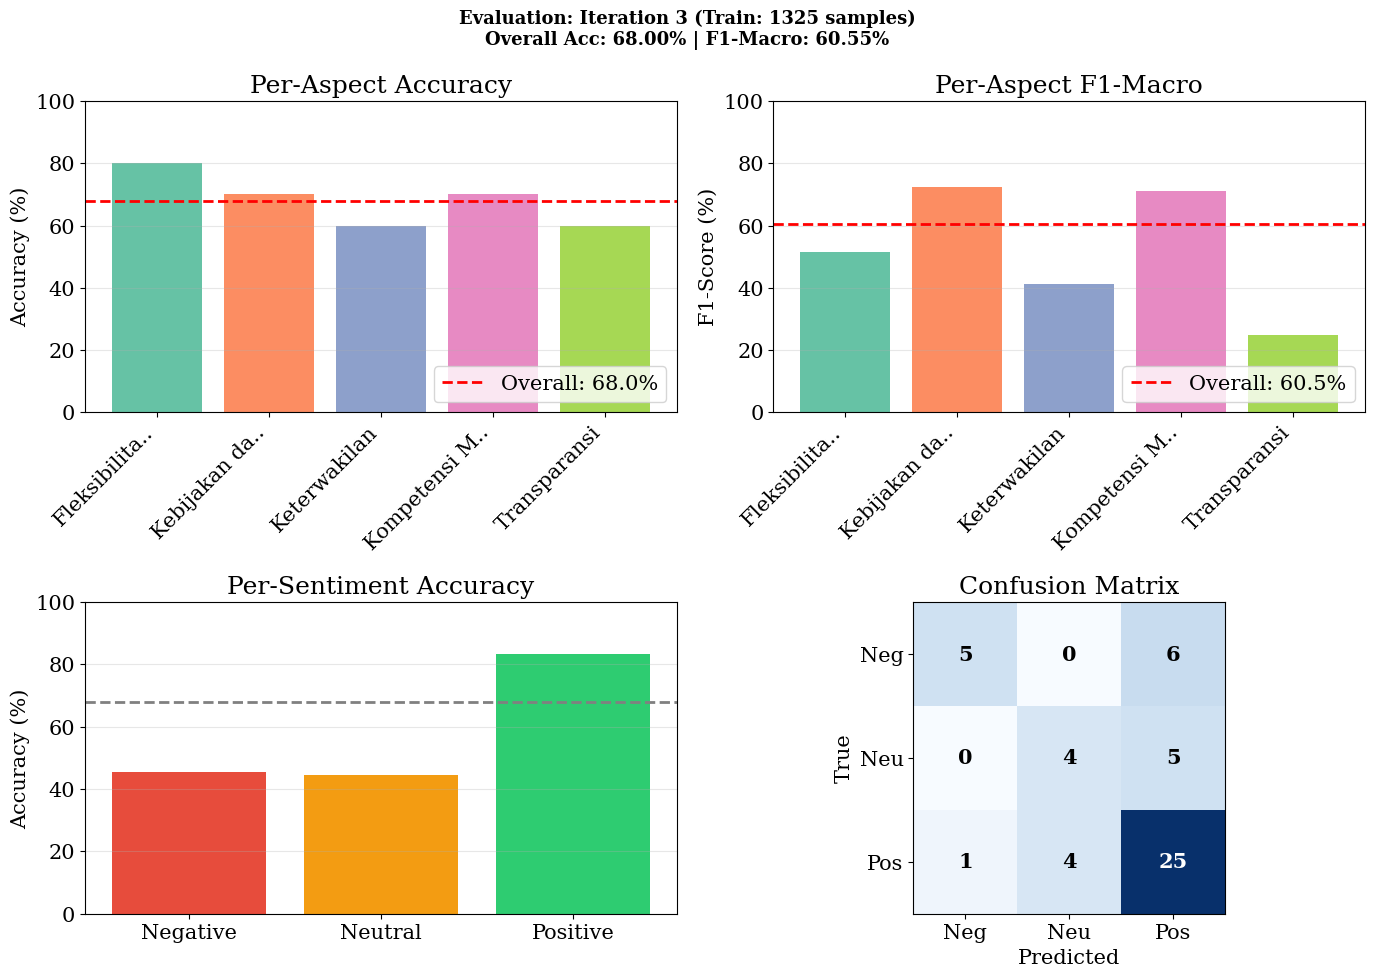

Evaluation saved: D:\ANBOW\New folder (3)\figures_iterative\iter3_evaluation.png

-> After Iter 3: Total training = 1870 samples
   (Gold: 235 + Pseudo: 1635)

 ITERATION 4: PSEUDO-LABELING (~545 labels)
 Model: FAST_LSA_T
 Current training: 1870 samples
 Thresholds: POS>=0.3, NEG>=0.3, NEU>=0.2
 Keyword Bonus: 0.15

Files created in \iter4_training:
  - iter4.test.dat.apc: 13327 bytes
  - iter4.train.dat.apc: 491358 bytes
  - iter4.valid.dat.apc: 13526 bytes
Training model for iteration 4...
[2026-01-03 19:51:29] (2.4.2) Set Model Device: cuda:0
[2026-01-03 19:51:29] (2.4.2) Device Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
2026-01-03 19:51:29,352 INFO: PyABSA version: 2.4.2
2026-01-03 19:51:29,352 INFO: Transformers version: 4.57.3
2026-01-03 19:51:29,356 INFO: Torch version: 2.7.1+cu118+cuda11.8
2026-01-03 19:51:29,356 INFO: Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU
[2026-01-03 19:51:29] (2.4.2) Try to load ['\\iter4_training'] dataset from local disk


C:\Users\DLH JATIM\AppData\Local\Programs\Python\Python310\lib\multiprocessing\pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


2026-01-03 19:51:34,633 INFO: Load dataset from dataset_iterative\iter4_training\iter4.train.dat.apc


preparing dataloader: 100%|██████████| 1870/1870 [00:01<00:00, 1734.39it/s]


2026-01-03 19:51:35,748 INFO: Dataset Label Details: {'1': 230, '2': 1247, '0': 393, 'Sum': 1870}
2026-01-03 19:51:36,627 INFO: train data examples:
 [{'ex_id': tensor(0), 'text_raw': 'halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut Fleksibilitas Fleksibilitas', 'text_spc': '[CLS] halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut Fleksibilitas Fleksibilitas [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor([0.1818, 0.2121, 0.2424, 0.2727, 0.3030, 0.3333, 0.3636, 0.3939, 0.4242,
        0.4545, 0.4848, 0.5152, 0.5455, 0.5758, 0.6061, 0.6364, 0.6667, 0.6970,
        0.7273, 0.7576, 0.7879, 0.8182, 0.8485, 0.8788, 0.9091, 0.9394, 0.9697,
      

preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 1878.55it/s]


2026-01-03 19:51:37,040 INFO: Dataset Label Details: {'1': 9, '2': 30, '0': 11, 'Sum': 50}
2026-01-03 19:51:37,091 INFO: test data examples:
 [{'ex_id': tensor(0), 'text_raw': 'sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden Fleksibilitas Fleksibilitas', 'text_spc': '[CLS] sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden Fleksibilitas Fleksibilitas [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor([0.2000, 0.2333, 0.2667, 0.3000, 0.3333, 0.3667, 0.4000, 0.4333, 0.4667,
        0.5000, 0.5333, 0.5667, 0.6000, 0.6333, 0.6667, 0.7000, 0.7333, 0.7667,
        0.8000, 0.8333, 0.8667, 0.9000, 0.9333, 0.9667, 1.0000, 1.0000, 1.0000,
        

preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 1481.97it/s]


2026-01-03 19:51:37,501 INFO: Dataset Label Details: {'1': 3, '2': 30, '0': 17, 'Sum': 50}
2026-01-03 19:51:37,530 INFO: valid data examples:
 [{'ex_id': tensor(0), 'text_raw': 'idrus marham puji langkah menteri bahlil percepat pembayaran kompensasi energi kebijakan inovatif untuk rakyat Fleksibilitas Fleksibilitas', 'text_spc': '[CLS] idrus marham puji langkah menteri bahlil percepat pembayaran kompensasi energi kebijakan inovatif untuk rakyat Fleksibilitas Fleksibilitas [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor([0.2609, 0.3043, 0.3478, 0.3913, 0.4348, 0.4783, 0.5217, 0.5652, 0.6087,
        0.6522, 0.6957, 0.7391, 0.7826, 0.8261, 0.8696, 0.9130, 0.9565, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0

Epoch:  0 | Smooth Loss: 0.5990: 100%|██████████| 117/117 [00:35<00:00,  3.26it/s, Dev Acc:72.00(max:72.00) Dev F1:56.67(max:57.28)]
Epoch:  1 | Smooth Loss: 0.4561: 100%|██████████| 117/117 [00:32<00:00,  3.58it/s, Dev Acc:66.00(max:72.00) Dev F1:57.37(max:64.44)]
Epoch:  2 | Smooth Loss: 0.3713: 100%|██████████| 117/117 [00:32<00:00,  3.64it/s, Dev Acc:62.00(max:76.00) Dev F1:48.40(max:66.67)]
Epoch:  3 | Smooth Loss: 0.3046: 100%|██████████| 117/117 [00:32<00:00,  3.64it/s, Dev Acc:62.00(max:76.00) Dev F1:50.83(max:66.67)]
Epoch:  4 | Smooth Loss: 0.2585: 100%|██████████| 117/117 [00:32<00:00,  3.62it/s, Dev Acc:62.00(max:76.00) Dev F1:48.18(max:66.67)]


[2026-01-03 19:54:23] (2.4.2) Loading best model: checkpoints/fast_lsa_t_custom_dataset_acc_76.0_f1_66.67/ and evaluating on test set 
2026-01-03 19:54:23,345 INFO: 
-------------------------------------------------------------------- Raw Metric Records --------------------------------------------------------------------
╒══════════════╤══════════════════════════════════════════════════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric       │ Trial                                                    │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞══════════════╪══════════════════════════════════════════════════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Max-Test-Acc │ fast_lsa_t-custom_dataset-indobenchmark/indobert-base-p2 │ [62.0]               │    62     │    62    │   0   │   0   │   62    │   62    │
├──────────────┼─────────────────────────────

d:\ANBOW\New folder (3)\venv_pyabsa2\lib\site-packages\pyabsa\framework\trainer_class\trainer_template.py:250: ResourceWarning: unclosed file <_io.TextIOWrapper name='d:\\ANBOW\\New folder (3)\\logs\\fast_lsa_t_20260103 194534\\trainer.log' mode='a' encoding='utf8'>
  self.config.logger.removeHandler(self.config.logger.handlers[0])


Model training completed
Found checkpoint: checkpoints\fast_lsa_t_custom_dataset_acc_76.0_f1_66.67
Checkpoint saved to: D:\ANBOW\New folder (3)\checkpoints_iterative\iter4_model\fast_lsa_t_custom_dataset_acc_76.0_f1_66.67
[2026-01-03 19:54:28] (2.4.2) Load sentiment classifier from checkpoints\fast_lsa_t_custom_dataset_acc_76.0_f1_66.67
[2026-01-03 19:54:28] (2.4.2) config: checkpoints\fast_lsa_t_custom_dataset_acc_76.0_f1_66.67\fast_lsa_t.config
[2026-01-03 19:54:28] (2.4.2) state_dict: checkpoints\fast_lsa_t_custom_dataset_acc_76.0_f1_66.67\fast_lsa_t.state_dict
[2026-01-03 19:54:28] (2.4.2) model: None
[2026-01-03 19:54:28] (2.4.2) tokenizer: checkpoints\fast_lsa_t_custom_dataset_acc_76.0_f1_66.67\fast_lsa_t.tokenizer
[2026-01-03 19:54:28] (2.4.2) Set Model Device: cuda:0
[2026-01-03 19:54:28] (2.4.2) Device Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Available unlabeled texts: 662
Target per aspect: ~114


Pseudo-labeling Iter 4:   0%|          | 0/662 [00:00<?, ?it/s]

[2026-01-03 19:54:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] semoga mereka tidak akan pernah memberikan maaf kepada kebijakan pemerintah yg menganiaya mereka lumayan di akhirat itu dosa dilimpahi ke pejabat biar pejabat gk selamat di akhirat


d:\ANBOW\New folder (3)\venv_pyabsa2\lib\site-packages\pyabsa\tasks\AspectPolarityClassification\prediction\sentiment_classifier.py:326: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  t_outputs_all = np.array(sen_logits.cpu()).astype(np.float32)


[2026-01-03 19:54:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] semua akan terus berubah-ubah kalo kalian taro orangorang gak kompeten di kabinet risetnya selalu dangkal dan gk bisa pertahankan kebijakan setiap keputusan yang diambil tuh jalan singkat yang sifatnya reaktif kek orang kaget pas dipertanyakan bingung berubah lgi
[2026-01-03 19:54:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] aktivis nu saya merasa teman-teman nu itu sekarang sangat kurang dalam mengkritik negara dan praktik kekuasaan dulu para aktivis sosial yang kritis pada pemerintah hampir selalu menjadikan nu sebagai mitra perjuangan sekarang terlihat jarang terjadi energi kawankawan
[2026-01-03 19:54:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Se

Pseudo-labeling Iter 4:   1%|          | 6/662 [00:00<00:12, 50.85it/s]

[2026-01-03 19:54:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] semua akan terus berubah-ubah kalo kalian taro orangorang gak kompeten di kabinet risetnya selalu dangkal dan gk bisa pertahankan kebijakan setiap keputusan yang diambil tuh jalan singkat yang sifatnya reaktif kek orang kaget pas dipertanyakan bingung berubah lgi
[2026-01-03 19:54:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] media pemerintah mesir tv alqaeda melaporkan gencatan senjata fase pertama di gaza mulai berlaku kamis pukul gmt atau wib namun menurut reuters kantor perdana menteri israel menyebut gencatan senjata baru akan dimulai setelah disetujui oleh kabinet
[2026-01-03 19:54:31] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] maka

Pseudo-labeling Iter 4:   2%|▏         | 12/662 [00:00<00:12, 51.44it/s]

[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] program mbg saat ini jadi salah satu program pemerintah yang paling nyata terasa manfaatnya bukan cuma slogan anakanak sekolah dapat gizi seimbang orang tua merasa tenang dan para tenaga masak lokal ikut mendapat penghasilan dampaknya langsung meluas dan menyentuh jutaan
[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kerajaan bhutan dikabarkan tengah melakukan migrasi sistem identitas nasional ktp ke dalam jaringan etherium nantinya ribu identitas warganya akan masuk ke layanan pemerintah lewat blockchain
[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gubernur jawa barat dedi mulyadi menyampaikan bahwa a

Pseudo-labeling Iter 4:   3%|▎         | 18/662 [00:00<00:13, 47.47it/s]

[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tujuan pemberdayaan adalah memastikan seluruh masyarakat bisa mandiri berkelanjutan untuk itu pemerintah telah menetapkan paradigma baru menggeser bantuan kualitatif menjadi bantuan produktif dalam the th international conference on community development yang
[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] nah kalau bareng-bareng hasilnya pasti nyata seperti sinergi polri dan pemerintah kompak wujudkan kesuksesan program pemerintah buat ketahanan pangan yang lebih kuat
[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mamas ini korban dari ketidakbecusan pemerintah dalam membuat kebijakan kebijakannya bagus 

Pseudo-labeling Iter 4:   4%|▎         | 24/662 [00:00<00:13, 49.05it/s]

[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pangan lokal dari sumatera barat telah menjadi salah satu kuliner lokal yang terkenal di seantero indonesia bahkan di mancanegara di balik kekayaan warisan leluhur yang satu ini ternyata sistem pangan di sumatera barat masih menghadapi sejumlah persoalan kebijakan menjadi
[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] maksud gw model saldo uki tamara ya mau apa lagi mereka udah itu jalurnya tpi ada teman yg entar juga lu ngeluh kebijakan negara ngapain bela matian sih idelogis gak kepentingan gak terus apa bingung gw
[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bisa gak sih mantan presiden di adili kar

Pseudo-labeling Iter 4:   5%|▍         | 30/662 [00:00<00:12, 50.12it/s]

[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kabar baik untuk petani seluruh indonesia pemerintah kembali menunjukkan komitmennya untuk meringankan beban para petani dengan menurunkan harga eceran tertinggi het pupuk bersubsidi
[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] polri bekerja sama dengan perum bulog menyalurkan ton beras sphp ke lokasi di seluruh indonesia untuk mendukung program pemerintah menjaga stabilitas pangan nasional penyaluran beras dilakukan melalui gerakan pangan murah gpm yang diselenggarakan di seluruh
[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] fellow chindo here kondisi saat ini memang bikin keluarga dan sekitar khawat

Pseudo-labeling Iter 4:   5%|▌         | 36/662 [00:00<00:13, 47.39it/s]

[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] alhamdulillah bisa bersilaturahmi dengan menteri keuangan menke pak purbanya yudha dewa kami berdiskusi di kantor beliau tentang banyak hal utamanya bagaimana kadin indonesia sebagai mitra strategis pemerintah bisa berkolaborasi dengan temenku
[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kang dedi selalu di depan gubernur dedi mulyadi tidak terima dengan pernyataan menteri keuangan purbanya yudha dewa kalau dana pemerintah daerah pemda mengendap di deposito di perbankan bahkan pria yang kerap disapa kang dedi itu menantang purbanya untuk membuktikan dana
[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] t

Pseudo-labeling Iter 4:   6%|▌         | 41/662 [00:00<00:13, 46.24it/s]

[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden ri prabowo sugianto menegaskan komitmen pemerintah untuk memberantas tambang ilegal dan penyelundupan sumber daya alam yang menyebabkan kerugian negara hingga ratusan triliun rupiah dalam kunjungan kerjanya ke provinsi kepulauan bangka belatung prabowo menyaksikan
[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dari sabang sampai merauke rumah untuk semua ini hadir membawa kebahagiaan bagi rakyat kecil pemerintah dengan program ini memastikan jutaan keluarga indonesia punya tempat yang layak huni untuk tumbuh dan bermimpi
[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] juta penerima str dpt subsid

Pseudo-labeling Iter 4:   7%|▋         | 46/662 [00:00<00:13, 46.90it/s]

[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan yang membuka peluang bagi warga asing memimpin bumn sempat menimbulkan pertanyaan kalau mereka korupsi apakah bisa dihukum jawabannya bisa kejaksaan agung menegaskan hukum indonesia berlaku bagi siapa pun tanpa pandang asal negara langkah presiden prabowo ini
[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] knp visi misi pasangan amin itu bukan dibuat kebijakan scr general nasional tdk spt pasion yg lain tp dibuat perfektur wilayah begitu detailnya pak andes bs menjelaskan masalah amp plan ke depan utk pembangunan banjarmasin akan ada asaka internasional stadium
[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sent

Pseudo-labeling Iter 4:   8%|▊         | 51/662 [00:01<00:13, 45.87it/s]

[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dana daerah masih banyak mengendap di kas pemerintah daerah menteri dalam negeri tito karnaval menyoroti total dana yang belum digunakan mencapai sekitar rp triliun
[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hingga kini belum ada jalan kesepakatan antara pemerintah dengan spbu swasta untuk atasi kosongnya bbm di spbu swasta bagaimana duduk perkara polemik ini simak penjelasannya dalam hanya di youtube kompas
[2026-01-03 19:54:32] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] langkah yg diambil pemerintah atas kasus pagar laut tangerang baru bersifat hukum administrasi dan teknis pdhal tindak pidana jelas merampas ruang p

Pseudo-labeling Iter 4:   9%|▊         | 57/662 [00:01<00:12, 47.72it/s]

[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] petani tersenyum harga gabah dihargai pantas pemerintah melalui blog membeli gabah rpg kebijakan ini jadi angin segar bagi para petani yang selama ini khawatir harga anjlok saat panen raya kini keringat mereka dibayar setimpal bukan cuma soal angka
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] inget bgt jaman couid pada bingung karena gada turis sampe pemerintah ngasih kupon dan subsidi biar warlock pada berwisata dan membantu ekonomi daerah wisata years later jadi gini wkwk
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden sugianto menyaksikan langsung penyerahan aset rampasan negara dari tambang

Pseudo-labeling Iter 4:  10%|▉         | 63/662 [00:01<00:12, 49.82it/s]

[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pm albania edi rama mengangkat seorang menteri yang dihasilkan oleh ai untuk menangkal korupsi dan mendorong transparansi serta inovasi dalam kabinet barunya
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sebentar lagi tahun kepemimpinan prabowo gibran lalu bagaimana nasib demokrasi dan upaya pemberantasan korupsinya bagaimana korban dari kriminalisasi keangkuhan pejabat negara kebijakan yang kerap kali meminggirkan hak dasar warga negara untuk dapatkan kehidupan yang
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kejagung berhasil menyelamatkan rp triliun hasil sitaan dari kasus korupsi ekspor cpo langk

Pseudo-labeling Iter 4:  10%|█         | 68/662 [00:01<00:12, 48.49it/s]

[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri keuangan purbanya yudha dewa seolah-olah membuat banyak gebrakan sekadar kebijakan koboi yang tak terukur dampaknya
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] barisan merah putih papua tengah gelar donor darah amp deklarasi dukungan untuk pembangunan damai di tanah papua bmp teguh mendukung kebijakan pemerintah dalam membuka lapangan kerja menegakkan hukum dan menjaga keutuhan nkri
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] purbanya demo besar kemarin indikasi masyarakat sudah muak ia soroti kebijakan moneter dan fiskal yg salah
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment d

Pseudo-labeling Iter 4:  11%|█         | 74/662 [00:01<00:11, 50.61it/s]

[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan yg menyengsarakan rakyat
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sering terjadi dan diabaikan kritik yg sifatnya untuk kebaikan pengkritik yg mengkritisi kebijakan yg kurang tepat sering dianggap sakit hati atau tidak diberi jabatan persepsi yg keliru inilah yg membuat kebijakan seorang pemimpin semakin ngawur dan tidak terkontrol
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] diantara banyak kebijakan presiden joki yg layak dikritik selama berkuasa kebiasaannya mengendor produk umum dan baju adat daerah adalah yg layak diapresiasi bagaimana cara beliau mengendor dengan langsung memakain

Pseudo-labeling Iter 4:  12%|█▏        | 80/662 [00:01<00:11, 51.49it/s]

[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalau urusan duit paling cepat pejabat konoha buat kebijakan
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kebijakan presiden prabowo turunkan harga pupuk pertama kali dalam sejarah baca selengkapnya melalui tautan di bawah ini
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apakah kebijakan ini berdampak positif atau malah menjadi bumerang
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pak mikael di indonesia ini semua harus serba terburu karena desakan batas usia di tempat kerja ini sebener

Pseudo-labeling Iter 4:  13%|█▎        | 86/662 [00:01<00:11, 49.69it/s]

[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hadeh ada aja kebijakan pejabat negeri ini
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ini kebijakan yang masuk akal masyarakat lebih butuh makan dari pada minum bensin
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] khas pengambilan kebijakan di indonesia masalahnya apa solusinya apa
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] will kah bocoran daftar lengkap menteri amp wakil di kabinet prabowo
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is 

Pseudo-labeling Iter 4:  14%|█▍        | 92/662 [00:01<00:11, 50.76it/s]

[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] berita gembira nih pemerintah dan dpr ri resmi melegalkan umrah mandiri aturan ini tercantum dalam undang-undang penyelenggaraan ibadah haji dan umrah uu pihu yang baru
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah kabupaten serang provinsi banten menetapkan pemusnahan hewan ternak di wilayah kecamatan sikander setelah teridentifikasi terpapar zat radioaktif cesium cs
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah punya deposito di bank rp triliun purbanya curiga permainan bunga
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal t

Pseudo-labeling Iter 4:  15%|█▍        | 98/662 [00:02<00:11, 48.00it/s]

[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] fakta pemerintah wajibkan bbm etanol persen sebelumnya etanol persen ditolak spbu swasta lewat
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ga pemerintah ga rakyatnya ga bisa dibedakan sama sama suka korupsi
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah as sita us miliar bitcoin dari konglomerat kamboja pemerintah amerika serikat baru saja menyerahkan dokumen permintaan untuk menyita sekitar bbc atau setara us miliar yang diretas pada silam dari lucian salah satu mining pool terbesar china tim
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not e

Pseudo-labeling Iter 4:  16%|█▌        | 104/662 [00:02<00:11, 49.36it/s]

[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jika nanti terbukti benar maka sebaiknya pemerintah bubarkan saja ormas nu ini contoh orang islam yang menghancurkan islam dari dalam
[2026-01-03 19:54:33] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pola reshuffle kabinet prabowo trust indonesia menyingkirkan menteri-menteri titipan joki
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] disentil prabowo ini daftar menteri kabinet merah putih lulusan s atau doktor
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sebagai badut politik yang seolah tampak sederhana dan

Pseudo-labeling Iter 4:  16%|█▋        | 109/662 [00:02<00:11, 49.36it/s]

[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] berita terkini florida telah mengesahkan undang-undang yang mengakui koin emas dan perak sebagai alat pembayaran yang sah bebas pajak dan dapat digunakan untuk membayar utang serta biaya pemerintah mulai berlaku pada juli koin emas dan perak akan dikecualikan dari
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saya atas nama pribadi dan atas nama pemerintah republik indonesia mengucapkan turut berduka cita dan menyampaikan bela sungkawa yang sedalam-dalamnya kata presiden
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah tarik utang baru rp t per september
[2026-01-03 19:54:34] (2.4.2) Warning: r

Pseudo-labeling Iter 4:  17%|█▋        | 115/662 [00:02<00:10, 50.27it/s]

[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] langkah cepat pemerintah turunkan harga pupuk jadi bukti nyata menjaga ekonomi makro stabil
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu tahun pemerintahan prabowogibran menunjukkan pertanian indonesia bangkit dengan capaian luar biasa produksi beras nasional mencetak rekor tertinggi sepanjang sejarah stok pangan pemerintah mencapai level tertinggi dan kesejahteraan petani terus meningkat
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yang lagi nyari info magang ayo kumpulan nih website buat cari loker khusus internship ada yang dari pemerintah paid dan junaid cocok buat freshgrad dan anak kuliaha

Pseudo-labeling Iter 4:  18%|█▊        | 121/662 [00:02<00:11, 45.74it/s]

[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saya pernah naik pesawat suatu hari pesawatnya jatuh karena sejak awal pembuatan pesawatnya asalan orang meninggal dan ratusan luka-luka kira salahnya siapa dihukum tidak apakah setelah kejadian ini pemerintah langsung keluarin apbn untuk bikinin mereka pesawat baru
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dana pemerintah rp triliun mengalir ke bank bakal dongkrak kredit atau hanya sia-sia
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rencana pemerintah indonesia merelokasi ribuan warga gaza yang terluka akibat agresi militer zionis israel di palestina ke pulau galang batam kepulauan riau dengan a

Pseudo-labeling Iter 4:  19%|█▉        | 126/662 [00:02<00:11, 45.58it/s]

[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] boikot trans boikot pesantren boikot pemerintah demen amat konflik horizontal semudah itu kalian lupa ya sama isu gede itu si ahli ketawa ngeliat kalian berantem dhl besoknya masih sama ngisi bbm etanol
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ini rusunawa di berbagai kota spanyol yes rusunawa dibangun pemerintah kota di atas berbagai tipe lahan dan disewakan kepada keluarga dengan tingkat ekonomi tertentu
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] airlangga sebut toyota setor pajak rp t setiap tahun ke pemerintah
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its 

Pseudo-labeling Iter 4:  20%|█▉        | 131/662 [00:02<00:13, 40.32it/s]

[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kekayaan aceh memang luar biasa akan sejahteralah ikut tdk hanya aceh tapi indonesia kalau diatur oleh pemerintah yg jujur dan bersih
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] konsep yg salah pns bukan diberi makan oleh pejabatpemerintah presiden or wapres tapi dari rakyat melalui pajak kita ini common sense g sih atau bener kalo selama ini rakyat non tkp kalo ada uangbansos itu mikirnya duit dari pemerintah bukan duit rakyat untuk rakyat
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo ke luar negeri pekan depan kendali pemerintahan dipegang gibran
[2026-01-03 19:54:34] (2.4.2) Warning: refer

Pseudo-labeling Iter 4:  21%|██        | 137/662 [00:02<00:11, 44.11it/s]

[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo janji ribu hasil ribu transformasi dan kerja nyata pemerintah
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo gibran hingga menteri salami satu-satu kepala daerah usai pelantikan
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saatnya presiden prabowo sikat menteri-menteri wemlinger
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo mesti bersihkan tokoh potensial rusak reputasi pemerintah raja juli biangnya
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment

Pseudo-labeling Iter 4:  22%|██▏       | 143/662 [00:02<00:11, 46.34it/s]

[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] krisis legitimasi ancam presiden prabowo kalau tak reshuffle menteri dalek
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo tegaskan komitmen pemerintah bangun ekonomi rakyat perumahan dan pendidikan
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun pemerintahan prabowo gibran apa keberhasilan dan pr yang masih tersisa
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] alih-alih menyelesaikan masalah biaya jatah preman infrastruktur pendukung yang tepat guna serta kepastian hu

Pseudo-labeling Iter 4:  22%|██▏       | 148/662 [00:03<00:11, 44.85it/s]

[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah merelakan rp triliun pajak di sebagai insentif untuk masyarakat berbagai sektor terutama manufaktur akan menikmati pembebasan ini
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] temenku ri mencatat utang pemerintah pusat hingga juni mencapai rp triliun atau setara persen terhadap produk domestik bruto pdb
[2026-01-03 19:54:34] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah amerika serikat as menyita bitcoin senilai us miliar setara rp triliun dari konglomerat asal kamboja chen zi menjadikannya sebagai penyitaan crypto terbesar dalam sejarah as pelansir bloomberg
[2026-01-03 19:54:35] (2.4.2) Warning: refe

Pseudo-labeling Iter 4:  23%|██▎       | 153/662 [00:03<00:11, 45.42it/s]

[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] selamat hari pangan sedunia indonesia terus berupaya menjaga ketersediaan dan keterjangkauan pangan melalui sinergi antara pemerintah swasta dan masyarakat desa
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ternyata ga dikasi ambil ui sama itb karena uang takut utk mahal sakit hati ku pukimak memang pemerintah ini anjing beasiswa nya diurus jangan yg kaya dpt beasiswa pns kabupaten gajinya kecil jangan dikasi paling tinggi utknya
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gedung putih shutdown pemerintah rugikan rp triliun per pekan
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not

Pseudo-labeling Iter 4:  24%|██▍       | 158/662 [00:03<00:11, 42.55it/s]

[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketua den lutut minta menke purbanya menyuntik rp triliun dana pemerintah ke ina lewat news
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gimana ceritanya obligasi pemerintah dijualnya di bursa saham nggak riset dulu nih sebelum nulis buku
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kok bisa dana pemerintah daerah mengendap triliunan di bank ya
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] edan beli barang cuma rp dari tangerang ke surabaya gratis ongkos kirim dikirim sampai pintu rumah 

Pseudo-labeling Iter 4:  25%|██▍       | 164/662 [00:03<00:11, 44.62it/s]

[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ah sampeyan kritik pemerintah aja kerjanya menyalahkan tanpa ngasih solusi lah kalau ga mau dikritik jangan jadi pemerintah kalau ga punya solusi ya mundur kasih kesempatan orang lain iya ga sih
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ada jam kerja yang manusiawi ada penghasilan yang mencukupi ada dukungan pemerintah yang memadai
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lebih jauh prabowo menegaskan dirinya akan tetap menindak tegas pejabat pemerintah yang menyalahgunakan jabatan tanpa pandang bulu terhadap latar belakang partai
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does

Pseudo-labeling Iter 4:  26%|██▌       | 170/662 [00:03<00:10, 46.17it/s]

[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo sugianto pernah menjabat sebagai menteri pertahanan ri panglima kontrak ganjen kopasus ketua umum partai gerinda sejak ketua hati ketua isi pengusaha pemilik grup nusantara termasuk kini
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] berdasarkan info terbaru per oktober posisi kosong di kabinet prabowo adalah kepala badan pengelola bumn sebelumnya menteri bumn yang kini diisi plt donny oskari pascareshuffle september posisi lain seperti menka polka dan mencoba sudah terisi
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo reshuffle kabinet lima menteri diganti baca di
[2026-01-03 19:54:35] (

Pseudo-labeling Iter 4:  26%|██▋       | 175/662 [00:03<00:10, 45.42it/s]

[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setelah merombak kabinet pada senin september presiden prabowo sugianto kembali mengganti sejumlah menteri dan pejabat ia mendepak dan menggeser beberapa kepala lembaga yang berafiliasi dengan predesesornya joko widodo mengapa
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto melakukan perombakan kabinet atau reshuffle kabinet merah putih dengan mengganti lima posisi menteri pada senin lima menteri yang dikabarkan bakal diganti adalah menteri koordinator bidang politik dan keamanan menkopolkam ri budi gunawan
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo apresiasi

Pseudo-labeling Iter 4:  27%|██▋       | 180/662 [00:03<00:10, 46.56it/s]

[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] yap yang membuat saya getir dan marah melihat kejadian pesantren rubuh itu karena betul ini amat sangat banget bisa dicegah dan melihat reaksi para petinggi amp pemerintah sungguh bikin patah hati sesudahnya krn jadi khawatir krn tragedi itu bisa terulang lagi dan lagi
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apakah aku terlihat seperti dewan pemerintah
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah indonesia menegaskan tidak akan menerbitkan visa untuk atlet senam artistik israel perlombaan itu digelar pada oktober sampai oktober
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentimen

Pseudo-labeling Iter 4:  28%|██▊       | 185/662 [00:03<00:10, 45.21it/s]

[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto menggelar sidang kabinet paripurna di ruang sidang kabinet kantor presiden jakarta yang dihadiri wakil presiden gibran rakabuming dan jajaran menteri kabinet merah putih dalam sidang tersebut presiden prabowo menyampaikan pengarahan
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] will kah bocoran daftar lengkap menteri amp wakil di kabinet prabowo
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo akan reshuffle kabinet merah putih petinggi gerinda ada menteri kurang seirama
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal

Pseudo-labeling Iter 4:  29%|██▉       | 191/662 [00:04<00:09, 47.56it/s]

[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] selamat bekerja pak prabowo dan pak gibran semoga sukses menjalankan amanah dan berhasil mewujudkan visi dan program untuk kesejahteraan bersama selamat purnawaktu pak joki dan kyai maksud amin yang hari ini telah mengakhiri masa jabatan semoga indonesia lebih baik
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo tetap mengendalikan pemerintahan dari luar gibran bebas main game
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kalo yang ini sampe kebukit juga gue gak ikutan ya kalo kalian sampe kena grebek pemerintah
[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its numb

Pseudo-labeling Iter 4:  30%|██▉       | 197/662 [00:04<00:09, 50.17it/s]

[2026-01-03 19:54:35] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] edan beli barang cuma rp dari tangerang ke surabaya gratis ongkos kirim dikirim sampai pintu rumah pemerintah perlu meregulasi ini marketplace bahaya sekali bisa membunuh semua usaha di daerah apalagi pabrikandisributorimportir juga jualan sendiri sekarang
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] narasi saham bisa diubah asal dekat dengan pemerintah
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] duit pemerintah dari siapa gue tanya asing
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pe

Pseudo-labeling Iter 4:  31%|███       | 203/662 [00:04<00:08, 52.46it/s]

[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saatnya presiden prabowo sikat menteri-menteri wemlinger
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] daftar lengkap menteri kabinet merah putih prabowogibran
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] will kah bocoran daftar lengkap menteri amp wakil di kabinet prabowo
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wallet bbc pemerintah us gerak hari ini setelah lama gak ada pergerakan ada sesuatu
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0

Pseudo-labeling Iter 4:  32%|███▏      | 209/662 [00:04<00:09, 46.82it/s]

[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hotel sultan klaim tak tahu tagihan royalti rp m dari pemerintah
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah resmi menerbitkan peraturan pemerintah pp nomor tahun yang menjadi dasar hukum bagi koperasi untuk mengelola tambang mineral dan batu bara aturan ini merupakan perubahan kedua dari pp nomor tentang pelaksanaan kegiatan usaha pertambangan minerva
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah menegaskan komitmennya menjaga ketahanan pangan nasional setelah indonesia dinyatakan berhasil mencapai swasembada beras
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does

Pseudo-labeling Iter 4:  32%|███▏      | 215/662 [00:04<00:08, 49.97it/s]

[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo memercayakan pemerintahan ke wapres gibran dan kabinet merah putih selama dia kanker ke luar negeri prabowo minta pemerintahan bersih dari dendam politik
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] daftar lengkap menteri kabinet merah putih prabowogibran
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pengamat otomotif fitra eri berpendapat bahwa rencana pemerintah untuk mengembangkan mobil nasional harus disertai dengan perhitungan yang cermat terutama jika ditujukan untuk dijual kepada masyarakat luas menurutnya proyek ini harus disiapkan agar sehat secara bisnis hal
[2026-01-03 19:5

Pseudo-labeling Iter 4:  33%|███▎      | 221/662 [00:04<00:09, 48.29it/s]

[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah as sekarang memiliki bbc senilai sekitar us miliar atau rp triliun menjadikan mereka salah satu pemilik bitcoin terbesar yang diketahui publik
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] fda temukan paparan radioaktif di cengkeh ri pemerintah buka suara
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] klaim pemerintah soal tanah kosong di papua mencerminkan cara pandang kolonial menihilkan masyarakat adat
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah tarik utang baru r

Pseudo-labeling Iter 4:  34%|███▍      | 227/662 [00:04<00:08, 50.21it/s]

[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] perombakan kabinet dengan memperbesar struktur pemerintahan tidak otomatis membuat pemerintah berjalan efektif apalagi efisien rakyat butuh kerja nyata pemerintah
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] joki mendukung keputusan pemerintah karena pastinya sudah melalui pertimbanganpertimbangan
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saudara harus menjalankan pemerintah yang bersih dan adil kalau tidak saudara tidak akan berhasil ini berlaku untuk setiap tingkat kata prabowo di hadapan ratusan kepala daerah
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its numbe

Pseudo-labeling Iter 4:  35%|███▌      | 233/662 [00:04<00:08, 47.98it/s]

[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto melakukan perombakan kabinet atau reshuffle kabinet merah putih dengan mengganti lima posisi menteri pada senin lima menteri yang dikabarkan bakal diganti adalah menteri koordinator bidang politik dan keamanan menkopolkam ri budi gunawan
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] capaian setahun pemerintahan prabowogibran pemerintahan presiden prabowo sugianto dan wakil presiden gibran rakabuming raka menapaki usia satu tahun senin dengan capaian yang ditorehkan di bidang keamanan diplomasi dan hukum seperti berikut laman
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] terima

Pseudo-labeling Iter 4:  36%|███▌      | 239/662 [00:05<00:08, 49.70it/s]

[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo mesti bersihkan tokoh potensial rusak reputasi pemerintah raja juli biangnya
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun pemerintahan prabowo gibran partai buruh beri rapor merah untuk kenker
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gelar rapat paripurna presiden prabowo ungkap rencana retret kabinet lagi usai satu tahun pemerintahan
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun pemerintahan prabowogibran sesuai siapkan rapat kabinet
[2026-01-03 19:54:36] (2.

Pseudo-labeling Iter 4:  37%|███▋      | 245/662 [00:05<00:08, 50.80it/s]

[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pt pertama perseco mengambil langkah nyata dalam rangka mendukung visi asta cita pemerintah terutama yang berkaitan dengan target ketahanan dan swasembada energi perusahaan plat merah ini fokus melakukan berbagai upaya terukur untuk meningkatkan pasokan minyak dan gas
[2026-01-03 19:54:36] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] klo pe murah tapi produksi masih bisa bertumbuh gak kena kasus denda tanah sawit dri pemerintah management gak aneh itu mah tinggal sabaran aja buat diangkat gila sama market
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wakil gubernur di jakarta ran karna memaparkan pemerintah provinsi sempro

Pseudo-labeling Iter 4:  38%|███▊      | 251/662 [00:05<00:08, 50.74it/s]

[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setelah merombak kabinet pada senin september presiden prabowo sugianto kembali mengganti sejumlah menteri dan pejabat ia mendepak dan menggeser beberapa kepala lembaga yang berafiliasi dengan predesesornya joko widodo mengapa
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo reshuffle kabinet lima menteri diganti baca di
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] atropin setahun pemerintahan presiden ri prabowo sugianto bersama wakil presiden ri gibran rakabuming beserta kabinet merah putih penuh kerja dan kolaborasi nyata untuk menghadirkan kesejahteraan rakyat madina ini
[2026-01-03 19:54:37]

Pseudo-labeling Iter 4:  39%|███▉      | 257/662 [00:05<00:08, 48.72it/s]

[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] terbukti terpapar dan membahayakan sekitar hewan-hewan di sikander banten dimusnahkan pemerintah kabupaten serang mengambil langkah tegas soal temuan paparan radioaktif cesium di sikander serang banten hewan-hewan yang diduga terpapar akan dimusnahkan untuk mencegah
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah baru membuat regulasi makan bergizi gratis setelah terjadi kasus keracunan massal ada celah penyelewengan
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ganjar minta pemerintah cepat atasi konflik di rempong jangan sampai wilayah lain terinspirasi maksudnya menginspirasi rakyat di wara

Pseudo-labeling Iter 4:  40%|███▉      | 263/662 [00:05<00:07, 49.89it/s]

[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu tahun kabinet merah putih presiden prabowo kita telah bekerja keras dan hasilnya dirasakan rakyat presiden prabowo sugianto bersama wakil presiden gibran rakabuming memimpin sidang kabinet paripurna dalam rangka memperingati satu tahun pemerintahan kabinet merah putih di
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hari ini saya melantik sejumlah menteri baru dalam kabinet merah putih yaitu purbanya yudha dewa sebagai menteri keuangan ferry juliantono sebagai menteri koperasi muktaruddin sebagai menteri perlindungan pekerja migran serta irfan yusuf sebagai menteri haji dan umrah
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B

Pseudo-labeling Iter 4:  41%|████      | 269/662 [00:05<00:07, 50.47it/s]

[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] atasi konflik pulau rempong pemerintah bentuk satgas moeldoko minta warga serahkan tanahnya kok lebih mirip spt penjajah ya sarkas samplenya mungkin bisa diartikan pilih harta apa nyawa
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jika nanti terbukti benar maka sebaiknya pemerintah bubarkan saja ormas nu ini contoh orang islam yang menghancurkan islam dari dalam
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] seorang istri di aceh singkir safitri harus menerima kenyataan pahit diceraikan suami hanya dua hari sebelum ia dilantik sebagai pegawai pemerintah dengan perjanjian kerja pppk kisah ini menjadi vi

Pseudo-labeling Iter 4:  42%|████▏     | 275/662 [00:05<00:07, 51.03it/s]

[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kekayaan aceh memang luar biasa akan sejahteralah ikut tdk hanya aceh tapi indonesia kalau diatur oleh pemerintah yg jujur dan bersih
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pns dosen udahlah gajinya kecil pake syarat nggak boleh kritik pemerintah pula marahin min
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gubernur di jakarta ramon anung meminta asn di lingkungan semprot di jakarta tidak mengeluh soal pemangkasan dana bagi hasil dah dari pemerintah pusat sebesar rp triliun baca di sini
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to asp

Pseudo-labeling Iter 4:  42%|████▏     | 281/662 [00:05<00:07, 49.57it/s]

[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemecatan karyawan di manamana gelombang pengangguran meluas jurang kemiskinan struktural makin dalam krisis multidimensional sementara itu pemerintah terus memberaki rakyat via nepotisme realisme dan perilaku korup lainnya takada alasan untuk tidak menggulingkan rejim
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah dan rakyat indonesia butuh pemimpin seperti beliau ini
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintahan presiden prabowo sugianto dan wakil presiden wapres gibran rakabuming raka akan memasuki satu tahun pada oktober nanti
[2026-01-03 19:54:37] (2.4.2) Warning: reference 

Pseudo-labeling Iter 4:  43%|████▎     | 286/662 [00:05<00:07, 47.28it/s]

[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] genap setahun pemerintahan prabowogibran menke purbanya buka-bukaan terkait kondisi ekonomi
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saatnya presiden prabowo sikat menteri-menteri wemlinger
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu tahun pemerintahan prabowogibran ini kata dpr
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] krisis legitimasi ancam presiden prabowo kalau tak reshuffle menteri dalek
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its 

Pseudo-labeling Iter 4:  44%|████▍     | 292/662 [00:06<00:07, 49.54it/s]

[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setelah merombak kabinet pada senin september presiden prabowo sugianto kembali mengganti sejumlah menteri dan pejabat ia mendepak dan menggeser beberapa kepala lembaga yang berafiliasi dengan predesesornya joko widodo mengapa
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo reshuffle kabinet lima menteri diganti baca di
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] janganlan purbanya menke sidak bank perintah kalau sdh keterlaluan ikut biasa pun boleh kalau bank sdh ketela luan lihat gaji direkam dan komisaris bank pemerintah terlalu kan
[2026-01-03 19:54:37] (2.4.2) Warning: reference sentiment 

Pseudo-labeling Iter 4:  45%|████▍     | 297/662 [00:06<00:07, 48.30it/s]

[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bupati klaten mas menang berharap kegiatan ini dapat membawa manfaat bagi seluruh warga dan memperkuat sinergi antara pemerintah daerah dengan masyarakat
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gokil ya dhl perusahaan ga keluar uang untuk menggaji peserta yang diterima dari magangku efek dibayari pemerintah jadi dipake beberapa oknum buat mencari keuntungan kemarin lowongan di perusahaan pialang buka magang untuk pekerja laundry pekerja laundry
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sudah genap th pemerintah prabowogibran bisa dilihat semua pakaiannya dari berbagai sektor awal yang bagus u

Pseudo-labeling Iter 4:  46%|████▌     | 302/662 [00:06<00:07, 48.39it/s]

[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] okay penjelasan masing-masing tier meng posisi paling tinggi dalam kabinet merah putih inshallah kerjanya bagus track record akademis dan pendidikan bagus track record career bagus jadi semoga bagus kerjanya biasa aja ga bakal jadi anggota kabinet yang luar biasa tapi ga
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] para menteri juga berafiliasi dengan pengusaha prabowo terang-terangan mengakomodasi politik kartel dan oligarki dalam susunan kabinetnya
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto menggelar sidang kabinet paripurna di ruang sidang kabinet kantor presiden jakart

Pseudo-labeling Iter 4:  46%|████▋     | 307/662 [00:06<00:07, 47.03it/s]

[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] some indo netizens when they find out duit pemerintah is actually their own and taxpayers money
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] konsep yg salah pns bukan diberi makan oleh pejabatpemerintah presiden or wapres tapi dari rakyat melalui pajak kita ini common sense g sih atau bener kalo selama ini rakyat non tkp kalo ada uangbansos itu mikirnya duit dari pemerintah bukan duit rakyat untuk rakyat
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ga cuma kirk semua beasiswa pemerintah itu kan anggota dpr dapet jatah buat sanak famili kolega sampe konstituennya sampai pernah nemu salah satu beasiswa

Pseudo-labeling Iter 4:  47%|████▋     | 312/662 [00:06<00:07, 45.81it/s]

[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] karena itu icr mendesak agar pemerintah melakukan reformasi dengan menempatkan penyidikan di bawah pengawasan penuntutan langkah ini sesuai dengan peran jaksa sebagai dominus elitis atau pengendali sebuah perkara
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah pnya prank
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] agar kemiskinan ekstrem berakhir selain perlu inferensi dari pemerintah sebagai pribadi harus juga pandai membaca peluang seperti yang disampaikan oleh tambang pacul tau kapan berangkat
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not

Pseudo-labeling Iter 4:  48%|████▊     | 317/662 [00:06<00:07, 46.59it/s]

[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo memilih nama kabinet kabinet merah putih sama seperti nama kondisinya di pilpres lalu ini nama anggota kabinetnya ada menteri kamen
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ada bbrp menteri dan pbbt setingkat menteri di kabinet merah putih yg multitudes antara lain melaksanakan arahan presiden prabowo mengamankan dinasti joki mengamankan dan membantu bisnis oligarki sebagai tim sukses fufufafa utk jabatan presiden siapakah dia
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ekonom sebut pelatihan kabinet merah putih prabowo di magelang sebagai pemborosan anggaran
[2026-01-03 19:54:3

Pseudo-labeling Iter 4:  49%|████▊     | 322/662 [00:06<00:07, 43.62it/s]

[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dari dulu terlihat prabowo bicara tanpa berpikir maka janjinya muluk yang janjinya kelewat muluk biasanya kelenger dengan rombongan menteri wakilnya dan kepala badan setingkat menteri serta segerombol status ga dia punya tahun untuk mewujudkan janji itu
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] baru tahu kelasnya prabowo ya cuma segitu kan bisa dibaca ketika dia gak malu menggendong gibran demi menang pilpres gak malu sbg presiden minta petunjuk dr joki amp sby membanggakan ospek konyol ala militer bg menteri nya
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] magelang bukan in nusantara menarik memp

Pseudo-labeling Iter 4:  49%|████▉     | 327/662 [00:06<00:07, 44.81it/s]

[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] video pemerintah segera wajibkan bensin dicampur etanol
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jujur dan efisiensi adalah kunci menurunkan biaya haji presiden bertekad terus menekan biaya haji sekalipun fasilitas makin jos waktu tunggu haji tahun menjadi tahun dan akan terus dipercepat seperti itulah seharusnya pemerintah meringankan bukan memberatkan
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hari-hari bicara agama tapi mulutnya hanya lancar kala mengiklankan citra baik pemerintah sementara di saat ketidakadilan kesewenang-wenangan dan penindasan terjadi depan mata seketika mereka mingkem to

Pseudo-labeling Iter 4:  50%|█████     | 333/662 [00:06<00:07, 46.59it/s]

[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oktober kamis sore kami dari kabinet merah putih tiba di akademi militer magelang untuk menerima pembekalan dari bapak presiden prabowo sugianto kami terus memperkuat semangat kerja sama dan disiplin untuk menjalankan tugas-tugas pemerintahan yang lebih baik di bawah
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sesesebagai eeeeesekretaris kabinet joki eeeeetentu saja eee saaangat dekat de-dengan jokowijuga eee ee dengan menteri di dalam ee kabinet seperti pak prabowo yangyangyang eeeh menjadi menhan saat iitu begitulah
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo ke menteri tak ada yang kebal

Pseudo-labeling Iter 4:  51%|█████     | 338/662 [00:07<00:07, 43.39it/s]

[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] masih percaya sama abah katanya jadi gubernur biar punya panggung oposisi kontra pemerintah
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jadi tolong dibuka mata bahwa yang kita tolong adalah anakanak negeri yang sedang belajar sehingga saya sangat tidak habis pikir yang dikritik kok upaya pemerintah yang sedang melindungi anak yang sedang belajar dan tidak ada tempat belajar
[2026-01-03 19:54:38] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketua dpr ri puan maharani puan maharani menyoroti lonjakan kasus influenza a yang tengah terjadi di indonesia menurutnya kasus tersebut merupakan peringatan penting agar pemerintah se

Pseudo-labeling Iter 4:  52%|█████▏    | 343/662 [00:07<00:07, 44.61it/s]

[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] alhamdulillah pemerintah akan mempersiapkan pembagian buku tulis gratis untuk para siswa hal ini di maksudkan agar bisa membantu para siswa yang kesulitan dalam membeli buku tulis untuk proses belajar
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ri tolak tekanan as soal larangan kapal tiongkok lutut kita punya harga diri ketua dewan ekonomi nasional den lutut binar panjatan menegaskan pemerintah menolak tekanan dari amerika serikat as yang meminta agar indonesia tidak menggunakan kapal berbendera tiongkok dalam
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tak perlu mengasihani pos pada tulisan saya y

Pseudo-labeling Iter 4:  53%|█████▎    | 348/662 [00:07<00:06, 45.71it/s]

[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo tetap mengendalikan pemerintahan dari luar gibran bebas main game
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] baru tahu kelasnya prabowo ya cuma segitu kan bisa dibaca ketika dia gak malu menggendong gibran demi menang pilpres gak malu sbg presiden minta petunjuk dr joki amp sby membanggakan ospek konyol ala militer bg menteri nya
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sidang kabinet perdana kabinet merah putih presiden prabowo yang tidak dukung makan siang gratis silakan keluar berlaku buat menteri kalo haters se tl beraninya sama gibran saja nankin tagar kebencian hingga hari ini eh 

Pseudo-labeling Iter 4:  53%|█████▎    | 353/662 [00:07<00:06, 46.67it/s]

[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu hal yang sebenernya bikin gue marah dari recent discourse banyak mi mts dan ma punya pemerintah yang berhak untuk mendapatkan renovasi dan revitalisasi tapi kita malah regarding swasta yang tidak mengikuti prosedur im dan mengakibatkan jatuhnya korban jiwa
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] seventeen amp akan menjadi perwakilan member seventeen dalam penerimaan penghargaan presiden di ajang penghargaan budaya dan seni populer korea penghargaan ini adalah salah satu penghargaan tertinggi yang diberikan oleh pemerintah korea selatan dan
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ada ar

Pseudo-labeling Iter 4:  54%|█████▍    | 359/662 [00:07<00:06, 47.33it/s]

[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] baru kali ini salut sama psi meski dukung pemerintah tapi tegas
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pengamat otomotif fitra eri berpendapat bahwa rencana pemerintah untuk mengembangkan mobil nasional harus disertai dengan perhitungan yang cermat terutama jika ditujukan untuk dijual kepada masyarakat luas menurutnya proyek ini harus disiapkan agar sehat secara bisnis hal
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sebagai forum kolaborasi lintas sektor yang mempertemukan pemerintah pelaku usaha dan mitra internasional untuk mempercepat transisi menuju pembangunan berkelanjutan indonesia inte

Pseudo-labeling Iter 4:  55%|█████▌    | 365/662 [00:07<00:06, 48.92it/s]

[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setelah menerima beberapa pengaduan lewat dm yg disertai bukti tentang praktek tidak fair aplikator ojo pada mitranya baik driver maupun restowarungkafe maka kami putuskan utk membantu mereka dgn menyalurkannya ke pemerintah agar dilakukan pembenahan aturan
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] alih-alih menyelesaikan masalah biaya jatah preman infrastruktur pendukung yang tepat guna serta kepastian hukum buat bisa bersaing untuk menarik investasi pemerintah indo malah memutuskan untuk mengorbankan upah murah dan penghancuran lingkungan race to the bottom
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[

Pseudo-labeling Iter 4:  56%|█████▌    | 370/662 [00:07<00:05, 49.17it/s]

[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gak perlu bahas keadilan yg gampang aja warga menang dan pemerintah kalah putusan jalankan
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] lho katanya puas sama kinerja pemerintah
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bupati klaten menang wajar ismay mengunjungi rumah warga yang terdampak hujan deras disertai angin kencang di desa wonosari truck bukti kepedulian dan kehadiran pemerintah kabupaten klaten terhadap masyarakat
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] berita ron pimp

Pseudo-labeling Iter 4:  57%|█████▋    | 375/662 [00:07<00:06, 42.26it/s]

[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mengenal etanol bahan campuran bensin pemerintah berencana menerapkan campuran etanol persen dan bensin untuk mendukung ketahanan energi sekaligus mengurangi emisi karbon berikut selengkapnya tentang etanol laman
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dari desa kampus pemerintah dunia usaha individu hingga komunitas mandala awards mempertemukan semua kekuatan bangsa dalam satu semangat memberdayakan indonesia dari bawah bukan sekadar penghargaan tapi gerakan menuju kemandirian rakyat
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oktober kamis sore kami dari kabinet merah putih tiba di akademi mi

Pseudo-labeling Iter 4:  57%|█████▋    | 380/662 [00:08<00:06, 43.22it/s]

[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo memilih nama kabinet kabinet merah putih sama seperti nama kondisinya di pilpres lalu ini nama anggota kabinetnya ada menteri kamen
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo memercayakan pemerintahan ke wapres gibran dan kabinet merah putih selama dia kanker ke luar negeri prabowo minta pemerintahan bersih dari dendam politik
[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saya melaksanakan kegiatan retreat kabinet merah putih yang diikuti seluruh jajaran kabinet merah putih di akademi militer magelang bapak presiden ri menyampaikan kegiatan ini bertujuan untuk memba

Pseudo-labeling Iter 4:  58%|█████▊    | 385/662 [00:08<00:06, 42.33it/s]

[2026-01-03 19:54:39] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] berbicara soal kapasitas sebenarnya si gibran ini memang belum pantas untuk menjadi seorang wapres karena untuk menjadi wapres dibutuhkan kedewasaan dan kecerdasan yang baik serta pengalaman di bidang politik dalam jangka panjang
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apa gak terbalik tuh omongan pak justru di jaman pemerintah sekarang rakyat yg selalu dipinta dengan dalih pajak itu dan pajak ini
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah bicara kesatuan bangsa tapi justru perpecahan bangsa dari para pejabat konoha sendiri tahu gak bang rakyat indonesia belum sepenuhnya merdeka kar

Pseudo-labeling Iter 4:  59%|█████▉    | 390/662 [00:08<00:06, 43.61it/s]

[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menyerahkan kertas tugas kepada duta besar ri yang baru dilantik sbg wakil bangsa amp pemerintah di ln saya berpesan kepada para dubes agar setiap langkah diplomasi membawa manfaat nyata menjunjung kepentingan nasional amp memperkuat posisi di tengah dinamika global
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo tegaskan komitmen pemerintah gunakan hasil penegakan hukum untuk rakyat
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tekad bulat pemerintah dalam memajukan di indonesia telah di utamakan dengan cara meningkatkan kualitas pertanian dgn teknologi modern
[2026-01-03 19:54:40] (2.4

Pseudo-labeling Iter 4:  60%|█████▉    | 395/662 [00:08<00:06, 43.31it/s]

[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo mungkin lebih memilih menangani isu strategis secara langsung karena pengalaman militernya yang mendalam sementara gibran sebagai wapres muda masih membangun peran melalui kunjungan daerah dan inisiatif seperti lapor mas wapres hal ini juga bisa menghindari tudingan
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mewakili presiden prabowo yang saat ini sedang melakukan kunjungan kerja ke beberapa negara wakil presiden wapres gibran rakabuming menjadi inspektur upacara ziarah nasional dalam rangka peringatan hari pahlawan di taman makam pahlawan nasional utama kaligata jakarta
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-AS

Pseudo-labeling Iter 4:  60%|██████    | 400/662 [00:08<00:05, 44.38it/s]

[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ikan hiu makan gratis pemerintah najis
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jangan lupa baca buku dari sumber lain jangan terpaku sumber resmi pemerintah
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pengumuman memenag membatalkan kelulusan pppk bagi pelamar nonsan yang masih aktif di instansi pemerintah calon peserta yang terdampak wajib segera cek pengumuman resmi di website
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kejadian keracunan makanan meg harus menjadi perhatian peme

Pseudo-labeling Iter 4:  61%|██████▏   | 406/662 [00:08<00:05, 47.32it/s]

[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] alasan utama pemerintah selalu pakai jasa influence adalah karena masyarakat lebih mendengarkan influence daripada pemerintah dalam pada itu pemerintah sadar betul masyarakat punya trust issue ke mereka sudah biasa ketahuan suka menipu kan
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] beberapa temenku belakangan banyak yang ke taiwan pada makan di warung halal beef noodle yang kurekomendasikan juga woy pemerintah taiwan jadiin aku taiwan tourism amp gourmet ambassador plis
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jajaran menteri di kabinet merah putih pimpinan presiden prabowo sugianto langsung me

Pseudo-labeling Iter 4:  62%|██████▏   | 411/662 [00:08<00:05, 44.75it/s]

[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu tahun kabinet prabowogibran tiga menteri ini dinilai berkinerja terbaik
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto mengungkapkan bahwa dirinya telah memberikan tiga kali peringatan kepada menteri-menteri kabinet merah putih yang melakukan kesalahan sebelum akhirnya diganti melalui reshuffle
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hari ini saya secara resmi melantik sejumlah anggota baru kabinet merah putih antara lain damari chango sebagai menteri koordinator bidang politik dan keamanan erick thahir sebagai menteri pemuda dan olahraga muhammad dari sebagai kepala

Pseudo-labeling Iter 4:  63%|██████▎   | 417/662 [00:08<00:05, 47.29it/s]

[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] efisiensi jangan merugikan rakyat tapi faktanya merugikan rakyat terus ulah sri mulyana kemarin bikin rakyat makin susah perekonomian lesu tapi pajak gilaan sementara pemerintah terus memanjakan pejabat dan anggota dewan udah oktober lubang buaya gempa bpjs selasa
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ini asing share tolong beli mun minat mun ncan minat nya hee geus lah bae suk we mun minat kobaran tapi dikirimnya ngan bisa rabu soalnya admin na sibuk kabeh sibuk memaki pemerintah buruan anjay sebelum kehabisan da soal bakal abis asing sing boga pabrik
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-A

Pseudo-labeling Iter 4:  64%|██████▎   | 422/662 [00:08<00:05, 45.73it/s]

[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden dalam pengantarnya pada sidang kabinet paripurna perdana menyampaikan kepada jajaran menteri kabinet merah putih untuk tidak melupakan tujuan nasional bangsa indonesia yang tertera pada uud untuk mewujudkan tujuan nasional tersebut presiden menegaskan
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden ri prabowo sugianto dengan tegas mengatakan tak segan untuk memecat pejabat pemerintahan yang tidak mau bekerja keras dan bikin susah masyarakat hal ini disampaikan presiden prabowo saat membuka sidang kabinet paripurna perdana di istana merdeka jakarta rabu
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Senti

Pseudo-labeling Iter 4:  65%|██████▍   | 428/662 [00:09<00:04, 48.35it/s]

[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dua tahun genosida di gaza dan pemerintah dunia masih diam dalam hal ini amerika serikat seolah mendukung dan tidak ingin menghentikan penderitaan yang terus dihadapi warga gaza dunia gagal menghentikan darah yang terus mengalir mari kita hadiri aksi akbar dua tahun
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] buku ini worth ga guys sesuai sama materi pemerintah ngga ya aku niatnya mau beli dua mapel pilihan mtk aja atau ada saran lain terima kasih sch
[2026-01-03 19:54:40] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bentuk kerja sama kolektif aksi pp cv daring dan luring slogan bersama kita menjaga nilai sejati pi bersa

Pseudo-labeling Iter 4:  65%|██████▌   | 433/662 [00:09<00:05, 45.47it/s]

[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] refleksi satu tahun pemerintahan presiden amp wakil presiden mungkin banyak lembaga survei akan merilis angka kepuasan publik terhadap satu tahun kinerja pemerintahan presiden prabowo sugianto amp wakil presiden gibran rakabuming raka lengkap dgn beragam
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu tahun kepemimpinan prabowo sederet kebijakan kabinet merah putih
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden prabowo sugianto mengaku berani berdiri dengan percaya diri berkaca dari satu tahun masa pemerintahannya bersama wakil presiden gibran rakabuming raka baca selengkapnya ll
[2026-01-03

Pseudo-labeling Iter 4:  66%|██████▋   | 439/662 [00:09<00:04, 47.37it/s]

[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kinerja setahun prabowo gibran diapresiasi publik paling tinggi di pendidikan dan kesehatan jakarta kepuasan publik atas kinerja pemerintahan prabowo subiantogibran rakabumingraka mencapai persen berdasarkan hasil survei poltracking indonesia tertinggi bidang
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu tahun pemerintahan presiden prabowo sugianto da wapres gibran dinilai belum memenuhi ekspektasi publik survei helios menempatkan kinerja kabinet dengan skor dari turun dari survei hari pertama yang sebelumnya berada di angka lt
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ceo bpi danantara rosan 

Pseudo-labeling Iter 4:  67%|██████▋   | 444/662 [00:09<00:04, 47.69it/s]

[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] welcome back home bu sri mulyani bersama kepala lpem tahun sore itu menjadi ruang refleksi tentang arti bekerja dan berkarya dengan integritas beliau bercerita bahwa setiap kebijakan besar adalah hasil dari kerjakerja bersama sehingga tak dapat diklaim sebagai
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] integritas presiden akan terus terbebani oleh perkara yck karena persoalan korupsi kuota haji itu masih jadi perbincangan di ministry of hajj and umrah ksa lembaga otoritas urusan haji pemerintah arab saudi partai dan koalisinya perlu bersikap lebih tegas
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] 

Pseudo-labeling Iter 4:  68%|██████▊   | 449/662 [00:09<00:04, 46.96it/s]

[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah menyiapkan stimulus transportasi untuk periode libur natal dan tahun baru wataru berupa diskon tiket kereta kapal dan pesawat stimulus ini diharapkan meringankan biaya perjalanan masyarakat sekaligus mendorong mobilitas selama libur akhir tahun menka
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] polymarker platform prediksi berbasis blockchain menunjukkan bahwa mayoritas pelaku pasar yakin pemerintah amerika serikat as akan mengalami shutdown alias tutup pada lusa rabu
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tinggal nunggu dari pemerintah ya jaks source jakartapoint
[2026-01-03 19:54:4

Pseudo-labeling Iter 4:  69%|██████▊   | 454/662 [00:09<00:04, 44.63it/s]

[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] merah jatuh artinya sudah banyak korban dari ketidakbecusan pemerintah selama ini kanjuruhan demo meg putih naik artinya indonesia perlu disucikan kembali krn sudah terlalu kotor
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah as resmi mengalami shutdown sejak oktober karena kongres gagal menyetujui undang-undang pendanaan sementara sebelum batas waktu
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] camkan kata kata gw nanti kalau dia naik daun jadi populer dia juga akam dibenci kayak joki dan ahoy mengapa simple karena dia berkerja dan libs saw pro barat weston yang nyaman sama pemerintah yang 

Pseudo-labeling Iter 4:  69%|██████▉   | 459/662 [00:09<00:04, 45.79it/s]

[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemimpin itu yang kerja untuk rakyat biar rakyat merasakan pemerintah hadir untuk rakyat
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pesantren dituntut untuk mandiri secara finansial dan independen menghindari intervensi pemerintah tapi ketika pesantren menghadapi masalah alih-alih membantu dan membina tangan pemerintah justru digunakan untuk menghukum pesantren
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah federal as memasuki masa penutupan shutdown pada rabu menyusul perpecahan di kongres untuk meloloskan rancangan undang-undang ruu pendanaan hal itu menandai penutupan pemerintahan perta

Pseudo-labeling Iter 4:  70%|███████   | 464/662 [00:09<00:04, 45.72it/s]

[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rg vs purbanya kamu tim mana rocky gedung kritik tajam pada cara berpikir pemerintah bukan pada angka ekonomi itu sendiri ekonomi sbg cermin dari ketimpangan pertumbuhan cm retorika jika rakyat tetap miskin gaya berpikir normatif sarkastik rekonstruktif
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wakil ketua komisi i dpr ri fraksi pos sukamna menyesalkan adanya konten prolgbt dalam film animasi anak di netflix dan meminta pemerintah menekan platform tersebut agar tidak menayangkan konten serupa di indonesia ia mendukung langkah komando digital komdisi untuk
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-AS

Pseudo-labeling Iter 4:  71%|███████   | 469/662 [00:09<00:04, 44.25it/s]

[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] presiden kolombia gustavo petro ada kekebalan total bagi presiden yang menghadiri majelis dan pemerintah as tidak dapat mengkondisikan pendapat presiden as fakta bahwa otoritas palestina tidak diizinkan masuk dan visa saya dicabut karena meminta tentara as dan israel untuk
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kok jadi kebalik ya swasta begitu peduli dengan konsumennya sementara kita punya pemerintah menjual apapun demi keuntungan pada rakyatnya ini rakyatmu lho yang harusnya kau lindungi
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] soal keamanan pangan itu menyangkut nyawa semoga pemerintah b

Pseudo-labeling Iter 4:  72%|███████▏  | 475/662 [00:10<00:04, 46.74it/s]

[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kabinet impotensi dalam pemerintahan prabowo awalnya banyak orang berharap kepemimpinan prabowo akan menjadi antitesis dari kepemimpinan joki sosok tegas mengutamakan kedisiplinan diharapkan mampu memperbaiki segala kecarutmarutan di indonesia terutama dalam hukum dan
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu tahun perjalanan pemerintahan presiden sugianto amp wakil presiden gibran rakabuming raka bersama kabinet merah putih telah menunjukkan arah perubahan nyata bukan sekadar janji tapi langkahlangkah konkret untuk memperkuat ketahanan pangan kemandirian
[2026-01-03 19:54:41] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment

Pseudo-labeling Iter 4:  73%|███████▎  | 480/662 [00:10<00:04, 43.81it/s]

[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri bergelar s di kabinet merah putih prabowo gibran presiden ri sugianto dan wakil presiden ri lulusan s s dan s dimana ada yang tahu gaes
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menurut saya prabowo itu manusia tolol memilih menteri pigi bahlul dan wapres gibranmereka yang dipilih adalah manusia idiot otaknya runyam prabowo tak pantas dipercaya sejak buktinya prabowo teriak hidup joki yg merupakan manusia terbangkan di indonesia
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] satu tahun kabinet merah putih presiden prabowo kita telah bekerja keras dan hasilnya dirasakan rakyat presiden prabow

Pseudo-labeling Iter 4:  73%|███████▎  | 486/662 [00:10<00:03, 46.40it/s]

[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tuntutan waj di tahun ini begitu banyak permasalahan dan ketidakadilan terjadi belum lagi persoalan tahun-tahun sebelumnya yang masih menjadi pr pemerintah seharusnya melindungi kita tapi malah purapura tak tahu maka dari itu waj hadir membawa tuntutan
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pasal ditegakkan prabowo tegaskan pemerintah serius basmi penyelundupan dan tambang ilegal bangka belatung presiden ri prabowo sugianto menegaskan langkah penyitaan dan pengembalian aset ke negera sebagai bukti serius penegakan pasal uud dalam membasmi
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] aku tu gak 

Pseudo-labeling Iter 4:  74%|███████▍  | 491/662 [00:10<00:03, 45.20it/s]

[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tragedi itu genosida hanya secara legal identitas korban dibatasi tidak termasuk kelompok identitas politik seperti komunis di indonesia semua tindakan pemerintah saat itu sampai sekarang termasuk menggunakan tangan pihak lain adalah tindakan genosida
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] rabu pemerintah republik indonesia meluncurkan aplikasi all indonesia ini adalah sistem deklarasi penumpang terintegrasi yang diharapkan bisa semakin memudahkan membuat nyaman lebih efisien dan mempersingkat waktu bagi para pelaku perjalanan dari luar negeri ke
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bit

Pseudo-labeling Iter 4:  75%|███████▍  | 496/662 [00:10<00:03, 45.39it/s]

[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sumber tangannya dihancurkan pemerintah pemerintahlah yg memiskinkan rakyatnya
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bahaya banget ya misalnya kritikan atas bagaimana suatu policy dijalankan dianggap bentuk permusuhan dgn pemerintah dan pengkritiknya pun dianggap musuh
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apakah pemerintah cq presiden masih punya telinga utk mendengar dan mata utk melihat
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah as resmi mengalami shutdown 

Pseudo-labeling Iter 4:  76%|███████▌  | 501/662 [00:10<00:03, 44.40it/s]

[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menjelek-jelekkan orang menjelek-jelekan pemerintah bukannya melekin sih tapi emang faktanya buruk kan
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] diantara dm yg isinya org order dim-sum terselip dm mesum kok bisa kepikiran kirim dm ke akun yg isinya dagang lambat menghina pemerintah hari ngatain bahlul lo sange liat muka bahlul kah
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pertama kali sejak tahun pemerintah amerika serikat resmi melakukan government shutdown atau penghentian kegiatan pemerintah federal government shutdown as ini dimulai pada rabu pukul waktu setempat setelah presiden trump meng

Pseudo-labeling Iter 4:  77%|███████▋  | 507/662 [00:10<00:03, 46.38it/s]

[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun pemerintahan prabowo gibran diwarnai gebrakan besar di bidang politik dan hukum dalam bulan prabowo tiga kali merombak kabinet dan membentuk badan pengelola bumn sementara itu pemberian abolish untuk tom gembong dan amnesti untuk hasta kristianto disebut sebagai
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menurut kompas dan sejumlah pihaklembaga lain komunikasi publik pemerintahan prabowogibran sangat buruk lah apa yang bisa diharapkan dari kabinet yang isinya zulkifli hasan pigi noel cody anggono andri susanty dll setiap komentar mereka aja sering bikin gaduh
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sen

Pseudo-labeling Iter 4:  77%|███████▋  | 512/662 [00:10<00:03, 45.69it/s]

[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo akan reshuffle kabinet merah putih petinggi gerinda ada menteri kurang seirama
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setahun sudah berjalan pemerintahan prabowo gibran apa capaian dan prnya
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowogibran melakukan efisiensi secara nasional tapi skala prioritasnya bablu anggaran vital disedot tapi kabinet gembrot ngasih makan gratis yang sekolah tapi lulus sekolah dibikin susah kuliah gak ada kesungguhan memperluas lapangan kerja tambahin sendiri
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not 

Pseudo-labeling Iter 4:  78%|███████▊  | 517/662 [00:11<00:03, 46.77it/s]

[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] nandita aprilia atlet angkat besi asal langsa aceh masih menanti bonus yang dijanjikan pemerintah aceh atas prestasinya meraih medali perak pada pekan olahraga nasional pon acehsumut lalu saya mau gunakan bonus itu untuk berangkatkan orangtua umrah kata dita
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ahmad ali psi jangan jadi beban pemerintah wah peringatan bagi gajah ini
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah as ditutup di tengah perpecahan yang mendalam antara anggota parlemen republik dan demokrat apa yang terjadi ketika pemerintah as ditutup jika terjadi penutupan pemerintahan 

Pseudo-labeling Iter 4:  79%|███████▉  | 522/662 [00:11<00:02, 46.77it/s]

[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah lagi-lagi mengorbankan hutan kali ini seluas hektar yang akan dijadikan proyek strategis nasional pun tanam kabupaten merauke
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah vietnam mengumumkan ekonominya tumbuh sebesar secara tahunan pada kuartal ketiga meningkat dibandingkan dengan pertumbuhan pada kuartal kedua pertumbuhan ekonomi vietnam ini dicapai ketika tarif untuk impor produknya dari as mulai berlaku
[2026-01-03 19:54:42] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] segala sesuatu yang dilakukan oleh pemerintah itu harus ada dasar hukumnya tidak sesuka pudelnya ketua dpr ri puan maharani mengak

Pseudo-labeling Iter 4:  80%|███████▉  | 527/662 [00:11<00:02, 47.36it/s]

[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] saya pernah bilang ke beberapa orang cara pemerintah melakukan stok beras itu tdk tepat harusnya stok dalam bentuk gabah jangan dalam bentuk beras gabah bisa tahan tahunan bahkan ada yg bisa lebih dari thn spt di desa ciptagelar apakah kejadian ini ada mens rea nya
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] apresiasi spp polri jadi contoh standar pemenuhan gizi di indonesia lebih dari dapur makan bergizi gratis spp polri menghadirkan dapur standar yang aman dan layak konsumsi bagi masyarakat kontribusi wujudkan visi misi pemerintah dan apresiasi
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] septembe

Pseudo-labeling Iter 4:  81%|████████  | 533/662 [00:11<00:02, 47.87it/s]

[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah bali ini aneh mengandalkan pariwisata tapi cuek dengan isu sosial lainnya mana mungkin industri pariwisata berdiri sendiri
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] para pemberontak revolusi pemerintah korup ayah dan putrinya dan satu kolonel gila one battle after another muncul sebagai film paling intens dan anehnya juga paling lucu tahun ini paul thomas anderson menyulapnya jadi sebuah opera crime thriller yang penuh kekacauan
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] gaji pokok guru dan pegawai pemerintah terlalu rendah
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment do

Pseudo-labeling Iter 4:  81%|████████▏ | 538/662 [00:11<00:02, 48.15it/s]

[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menteri prabowo bego pigi menteri ham juga bego ngomong ke pbb saja nyontek gue bgn semuanya bego ini mereka rame mau kudeta prabowo masa semua bego kan hancurin kredibilitas presiden sendiri kalau punya bawahan tidak berkualitas apakah ini kudeta halus
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] hari ini saya secara resmi melantik sejumlah anggota baru kabinet merah putih antara lain damari chango sebagai menteri koordinator bidang politik dan keamanan erick thahir sebagai menteri pemuda dan olahraga muhammad dari sebagai kepala staf kepresidenan angga raka
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-A

Pseudo-labeling Iter 4:  82%|████████▏ | 543/662 [00:11<00:02, 45.53it/s]

[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] centre for indonesia strategic actions cisa merilis hasil survei yang menunjukkan mayoritas publik puas terhadap kinerja pemerintahan presiden prabowo sugianto dan wakil presiden gibran rakabuming raka selama hari pertama mereka menjabat survei yang digelar pada
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menjelang hari kabinet taman safari ini makin menunjukkan bahwa presiden selain bukan seorang pemimpin yang tegas dan dirigen yang efektif kapasitas leadershipnya lemah dan anehnya kewibawaannya juga kurang walhasil menteri-menteri dengan seenaknya bikin


Pseudo-labeling Iter 4:  82%|████████▏ | 545/662 [00:11<00:02, 46.91it/s]



Pseudo-labeled: 545 samples
  Per-Aspect: {'Fleksibilitas': 114, 'Kebijakan dan Pelayanan Pemerintah': 108, 'Keterwakilan': 96, 'Kompetensi Menteri': 113, 'Transparansi': 114}
  Per-Sentiment (this iter): {'0': 98, '1': 72, '2': 375}
  Per-Sentiment (GLOBAL): {'0': 424, '1': 258, '2': 1498}
  With keyword: 0

Evaluating iteration 4...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] keterwakilan perempuan dalam proses rekrutmen anggota kpu dan bawaslu mesti dikawal di tiap tahapnya hal ini disampaikan oleh wakil koordinator aliansi maju perempuan indonesia mpi titi anggraini
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] seminar publik refleksi dan evaluasi keterwakilan perempuan di tahun politik reformasi menuju tahun tapi keterwakilan pe

Evaluating:  10%|█         | 5/50 [00:00<00:01, 41.95it/s]

[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pemerintah khusus nya dinas kesehatan harus segera bertindak cepat
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] oh ya pak dokter tokyo jg alami sinking dgn rate yang jauhjauh lbh parah dibandingkan jakarta dgn akselerasi tjd pasca perang dunia ke yg diikuti oleh pertumbuhan ekonomi tinggi tp berkat perubahan kebijakan alami perlambatan signifikan
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] goodstats merilis artikel soal implementasi uu no tentang pemilu yang menargetkan minimal keterwakilan perempuan di legislatif namun data menunjukkan dalam enam tahun terakhir angka itu baru ratarata dgn capaian t

Evaluating:  22%|██▏       | 11/50 [00:00<00:00, 49.99it/s]

[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] tetaplah spt ini tetaplah asri jangan ada bandara di bali utara cukup selatan yg sudah dihancurkan investor asing dibantu kebijakan penguasa
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] salah satu alesan kenapa pembangunan rumah ibadah kaum nonmuslim sulit adalah kebijakan pemerintah
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] dulu banyak yg protes dan mengeluh saat presiden prabowo melakukan efisiensi anggaran tapi sekarang alhamdulillah dengan efisiensi anggaran pemerintah punya triliun yang akan digunakan untuk blt seskab teddy menyampaikan langsung soal efisiensi anggaran untuk blt
[2026-01-03 1

Evaluating:  34%|███▍      | 17/50 [00:00<00:00, 44.10it/s]

[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] jakarta agustus menyampaikan pidato kenegaraan di hadapan mpr dan mengglorifikasi programprogram pemerintah khususnya efisiensi anggaran makan bergizi gratis serta kebijakan di bidang pangan dan pertahanan
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ingin tahu aturan baru yang akan diterapkan di kerajaan arab saudi dalam sistem pencatatan kelahiran kebijakan baru untuk menyelaraskan kebebasan orang tua dalam memilih nama anak menggambarkan upaya menjaga jati diri arab dan nilainilai islam baca di sini
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] sejak pemilu hingga keterwakilan perempuan di dpr belu

Evaluating:  44%|████▍     | 22/50 [00:00<00:00, 42.90it/s]

[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] meskipun ada regulasi mengenai kuota persen tetapi keterwakilan perempuan dalam peta perpolitikan nasional masih minim project multatuli menemui beberapa caleg perempuan untuk menceritakan kisah perjuangan mereka di dunia politik
[2026-01-03 19:54:43] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] memang sebenarnya orang kaya ngga akan pernah peduli sama yang miskin mereka cuma mementingkan kepentingan mereka aja persetan kebijakan pro rakyat kalau mempengaruhi bunga deposit saya gitu kan ya jadi selama ini
[2026-01-03 19:54:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] wakil rakyat yg kontradiktif dengan apa yg dirasakan oleh rakyat rakyat b

Evaluating:  54%|█████▍    | 27/50 [00:00<00:00, 43.09it/s]

[2026-01-03 19:54:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] kesehatan adalah hak dasar setiap warga negara tapi faktanya masih banyak daerah kekurangan dokter dan fasilitas medis memadai komisi ix dpr ri terus mengawal kebijakan pemerataan tenaga kesehatan agar semua rakyat bisa merasakan layanan yang adil
[2026-01-03 19:54:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] menurut himma upaya pemerintah indonesia untuk mengadopsi keterwakilan perempuan di parlemen dan di partai sebesar persen sudah baik namun pada faktanya masih jauh dari harapan
[2026-01-03 19:54:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] mau berkontribusi pengurangan sampah simak deh uraian berikut national plastic action partne

Evaluating:  66%|██████▌   | 33/50 [00:00<00:00, 46.42it/s]

[2026-01-03 19:54:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] para anggota dinilai telah melakukan pembangkangan terhadap hukum dan etika yg berdampak luas amp merugikan upaya afirmasi keterwakilan perempuan dlm politik mereka terbukti telah melanggar kode etik amp dijatuhkan sanksi peringatan keras oleh
[2026-01-03 19:54:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] prabowo tegaskan transparansi pemeriksaan petugas yang melanggar presiden prabowo subianto menekankan pentingnya akuntabilitas dalam penanganan kasus pasca aksi demonstrasi yang berujung ricuh pesan ini menjadi komitmen pemerintah untuk memastikan penegakan hukum berjalan
[2026-01-03 19:54:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] 

Evaluating:  76%|███████▌  | 38/50 [00:00<00:00, 46.23it/s]

[2026-01-03 19:54:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] ketua harian gerindra menanggapi wacana ketum pkb soal penghapusan pilkada langsung dan usulan agar gurbernur di pilih oleh pemerintah pusat menurut bang dasco seluruh partai politik saat ini tengah mengkaji simulasi dan skema pemilu terbaik utk masa depan
[2026-01-03 19:54:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] minggu kemaren saat ihsg turun persen sudah banyak yang menuding menkeu hanya omong besar utk mengalihkan isu pdhl yg terjadi memang pasar bereaksi kebijakan global dan wajar jika investor mengambil profit taking minggu ini ihsg kembali naik jadi apa yg disampaikan menkeu
[2026-01-03 19:54:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sent

Evaluating:  86%|████████▌ | 43/50 [00:00<00:00, 47.15it/s]

[2026-01-03 19:54:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] korupsi dan kemunduran hukum di era jokowi refleksi transparansi occrp di awal tahun organised crime and corruption reporting project occrp kembali mengeluarkan laporan yang menggemparkan dunia khususnya masyarakat indonesia dalam laporannya occrp menyoroti bahwa
[2026-01-03 19:54:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] bicara soal upaya pemberantasan korupsi ganjarmahfud komitmen akan tingkatkan transparansi miskinkan koruptor dan kirim ke nusakambangan prabowogibran akan menjamin kualitas hidup para penegak hukum dan pejabat dengan cara menaikkan gaji kalian setuju cara siapa
[2026-01-03 19:54:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentime

Evaluating:  96%|█████████▌| 48/50 [00:01<00:00, 46.52it/s]

[2026-01-03 19:54:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] setiap rupiah punya arti bpkp berkomitmen menjaga transparansi melalui keterbukaan informasi realisasi anggaran agar masyarakat dapat ikut mengawasi bersama kita kawal setiap rupiah untuk indonesia yang lebih baik
[2026-01-03 19:54:44] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] pengamat intelijen dan geopolitik tak ada transparansi aparat penegak hukum dalam menangani kasus korupsi di era prabowo


  Accuracy: 74.00%
  F1-Macro: 62.46%


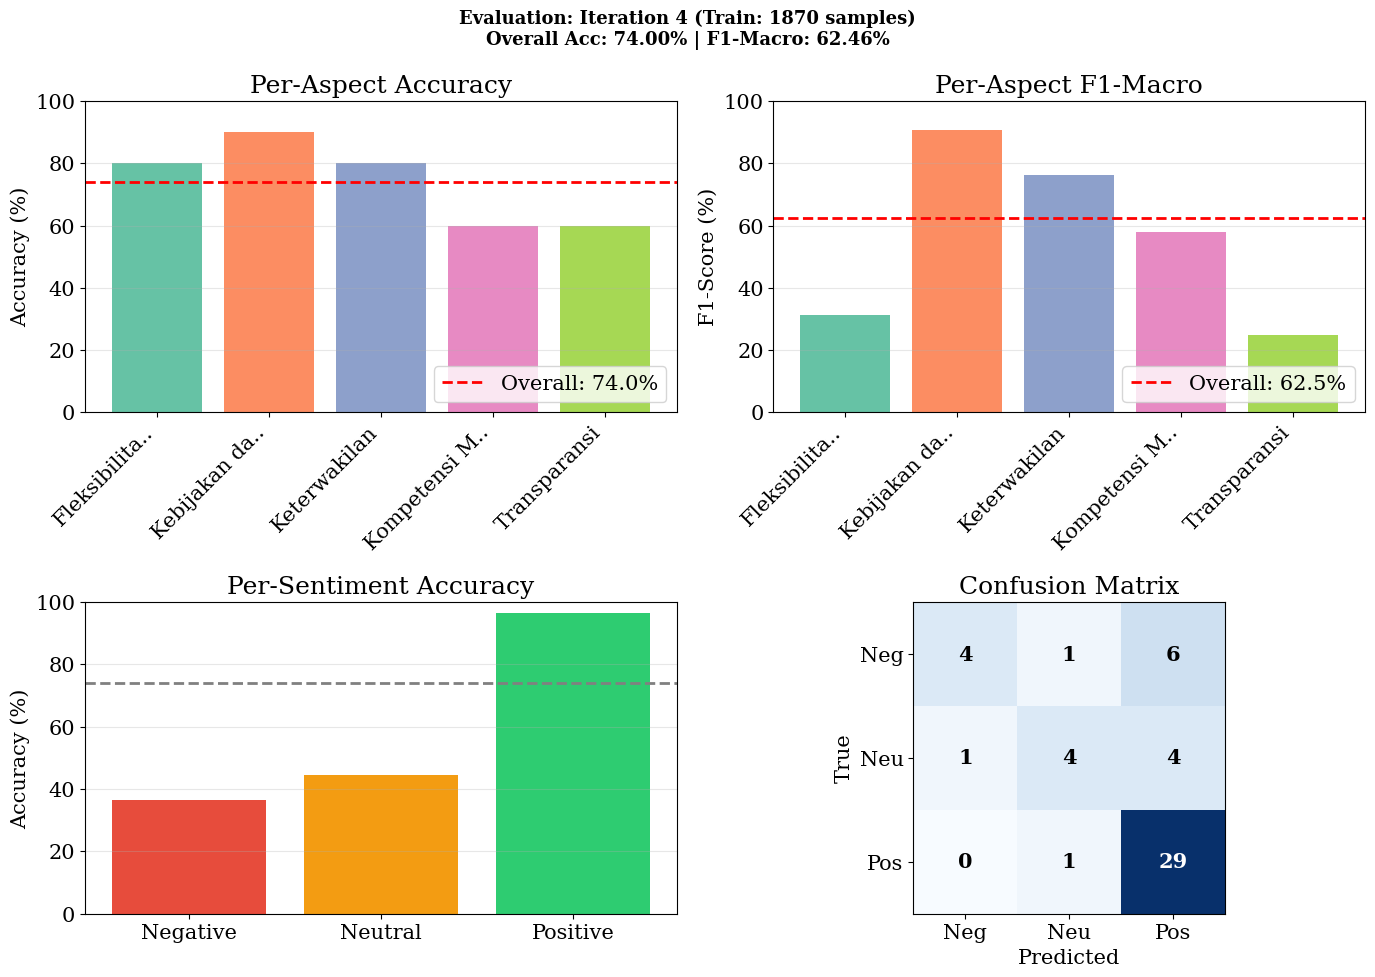

Evaluation saved: D:\ANBOW\New folder (3)\figures_iterative\iter4_evaluation.png

-> After Iter 4: Total training = 2415 samples
   (Gold: 235 + Pseudo: 2180)

 COMPLETE!
 Total Pseudo: 2180 (target: >=2165)
 Total Training: 2415 (target: >=2400)
 Final Sentiment Distribution: {'0': 424, '1': 258, '2': 1498}
  TARGET TERCAPAI!


In [ ]:
all_pseudo_data = []
used_texts = set()
current_train_data = list(train_data)

global_sentiment_counts = {"0": 0, "1": 0, "2": 0}
global_sentiment_limits = None
iterations_config = [
    {
        "iter": 1,
        "model": APC.APCModelList.FAST_LSA_S,
        "target": 545,
        "conf_pos": 0.50, "conf_neg": 0.50, "conf_neu": 0.40,
        "keyword_bonus": 0.10
    },
    {
        "iter": 2,
        "model": APC.APCModelList.FAST_LSA_S,
        "target": 545,
        "conf_pos": 0.45, "conf_neg": 0.45, "conf_neu": 0.35,
        "keyword_bonus": 0.10
    },
    {
        "iter": 3,
        "model": APC.APCModelList.FAST_LSA_T,
        "target": 545,
        "conf_pos": 0.40, "conf_neg": 0.40, "conf_neu": 0.30,
        "keyword_bonus": 0.12
    },
    {
        "iter": 4,
        "model": APC.APCModelList.FAST_LSA_T,
        "target": 545,
        "conf_pos": 0.30, "conf_neg": 0.30, "conf_neu": 0.20,
        "keyword_bonus": 0.15
    },
]

print("\n" + "="*80)
print(" ITERATIVE PSEUDO-LABELING: 4 CYCLES")
print(" TARGET: ~2165 pseudo-labels (MINIMUM)")
print(" BALANCE: Per Aspek (~433 each)")
print(" SENTIMENT LIMITS: DISABLED (natural distribution)")
print("="*80)

print("\n Iteration Plan:")
total_target = sum(c["target"] for c in iterations_config)
print(f"   Total target: {total_target}")
for cfg in iterations_config:
    model_name = 'FAST_LSA_S' if cfg['model']==APC.APCModelList.FAST_LSA_S else 'FAST_LSA_T'
    print(f"   Iter {cfg['iter']}: {model_name} | target={cfg['target']} | thresh={cfg['conf_pos']}/{cfg['conf_neg']}/{cfg['conf_neu']}")

print(f"\n Gold Training: {len(train_data)} samples")
print(f" Unlabeled Pool: {len(unl_texts)} texts\n")

for cfg in iterations_config:
    pseudo_data, used_texts, global_sentiment_counts = pseudo_label_iteration(
        iteration=cfg["iter"],
        model_type=cfg["model"],
        current_train_data=current_train_data,
        unlabeled_texts=unl_texts,
        used_texts=used_texts,
        target_count=cfg["target"],
        conf_pos=cfg["conf_pos"],
        conf_neg=cfg["conf_neg"],
        conf_neu=cfg["conf_neu"],
        aspek_list=aspek_list,
        keyword_bonus=cfg["keyword_bonus"],
        global_sentiment_counts=global_sentiment_counts,
        global_sentiment_limits=global_sentiment_limits
    )

    all_pseudo_data.append(pseudo_data)
    current_train_data = list(train_data) + [item for sublist in all_pseudo_data for item in sublist]

    print(f"\n-> After Iter {cfg['iter']}: Total training = {len(current_train_data)} samples")
    print(f"   (Gold: {len(train_data)} + Pseudo: {len(current_train_data) - len(train_data)})")

total_pseudo = sum(len(pl) for pl in all_pseudo_data)
print(f"\n{'='*80}")
print(f" COMPLETE!")
print(f" Total Pseudo: {total_pseudo} (target: >=2165)")
print(f" Total Training: {len(train_data) + total_pseudo} (target: >=2400)")
print(f" Final Sentiment Distribution: {global_sentiment_counts}")

if total_pseudo >= 2165:
    print(f"  TARGET TERCAPAI!")
else:
    print(f"  Kurang {2165 - total_pseudo}")
print(f"{'='*80}")


 PROGRESS VISUALIZATION: EVALUATION ACROSS ALL ITERATIONS


C:\Users\DLH JATIM\AppData\Local\Temp\ipykernel_14984\293660727.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\DLH JATIM\AppData\Local\Temp\ipykernel_14984\293660727.py:168: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Serif.
  plt.savefig(progress_fig_path, dpi=150, bbox_inches='tight', facecolor='white')
C:\Users\DLH JATIM\AppData\Local\Temp\ipykernel_14984\293660727.py:168: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Serif.
  plt.savefig(progress_fig_path, dpi=150, bbox_inches='tight', facecolor='white')
C:\Users\DLH JATIM\AppData\Local\Temp\ipykernel_14984\293660727.py:168: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Serif.
  plt.savefig(progress_fig_path, dpi=150, bbox_inches='tight', facecolor='white')
d:\ANBOW\New folder (3)\venv_pyabsa2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: 

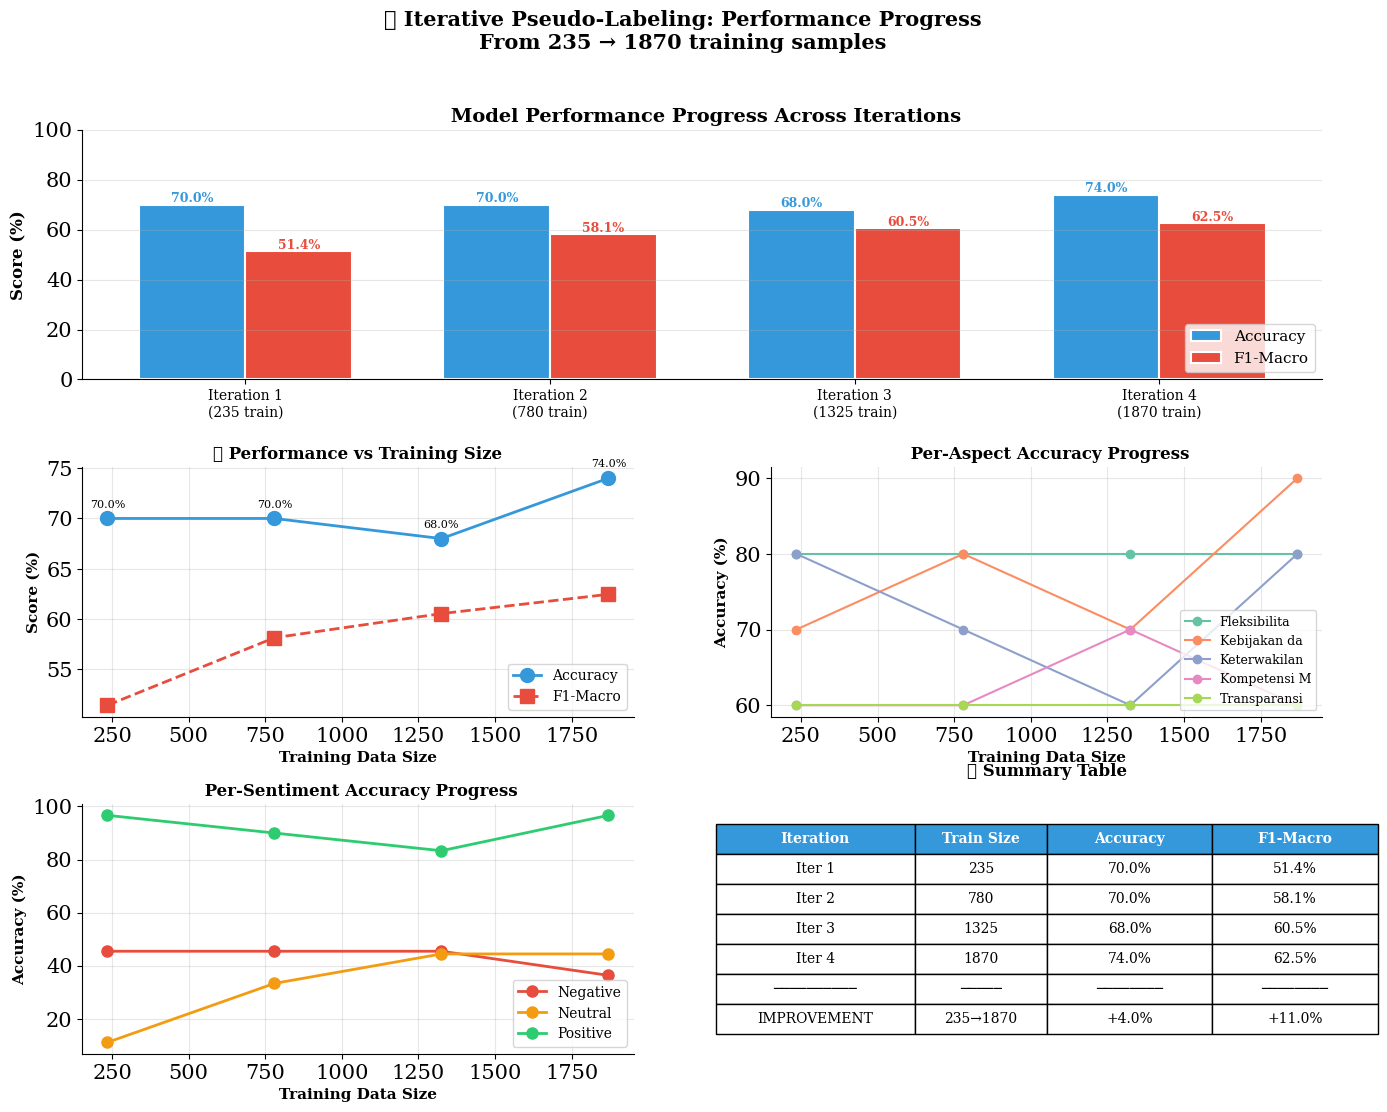


 Progress visualization saved: D:\ANBOW\New folder (3)\figures_iterative\progress_all_iterations.png

 SUMMARY: EVALUATION PROGRESS

Iteration              Train Size     Accuracy     F1-Macro
────────────────────────────────────────────────────────────
Iteration 1                   235       70.00%       51.44%
Iteration 2                   780       70.00%       58.15%
Iteration 3                  1325       68.00%       60.55%
Iteration 4                  1870       74.00%       62.46%
────────────────────────────────────────────────────────────

📈IMPROVEMENT from Iter 0 to Final:
   Accuracy: 70.0% → 74.0% (+4.0%)
   F1-Macro: 51.4% → 62.5% (+11.0%)


In [ ]:
print("\n" + "="*80)
print(" PROGRESS VISUALIZATION: EVALUATION ACROSS ALL ITERATIONS")
print("="*80)

# Collect all evaluation results
all_eval_results = []

# Add Iter 0 (seed) - from previous cell
if 'eval_iter0' in dir():
    all_eval_results.append(eval_iter0)

# Add Iter 1-4 from pseudo_label_iteration
if hasattr(pseudo_label_iteration, 'all_eval_results'):
    all_eval_results.extend(pseudo_label_iteration.all_eval_results)

if len(all_eval_results) == 0:
    print(" No evaluation results found. Run the training cells first.")
else:
    # Extract data for plotting
    iterations = [r["iteration"] for r in all_eval_results]
    train_sizes = [r["train_size"] for r in all_eval_results]
    accuracies = [r["overall_acc"]*100 for r in all_eval_results]
    f1_scores = [r["overall_f1_macro"]*100 for r in all_eval_results]

    # Create comprehensive progress visualization
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.25)

    # ==================== Plot 1: Accuracy & F1 Progress ====================
    ax1 = fig.add_subplot(gs[0, :])
    x = np.arange(len(iterations))
    width = 0.35

    bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', color='#3498db', edgecolor='white', linewidth=1.5)
    bars2 = ax1.bar(x + width/2, f1_scores, width, label='F1-Macro', color='#e74c3c', edgecolor='white', linewidth=1.5)

    ax1.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
    ax1.set_title(' Model Performance Progress Across Iterations', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'{it}\n({ts} train)' for it, ts in zip(iterations, train_sizes)], fontsize=10)
    ax1.legend(loc='lower right', fontsize=11)
    ax1.set_ylim(0, 100)
    ax1.grid(axis='y', alpha=0.3)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for bar, val in zip(bars1, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%',
                ha='center', fontsize=9, fontweight='bold', color='#3498db')
    for bar, val in zip(bars2, f1_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%',
                ha='center', fontsize=9, fontweight='bold', color='#e74c3c')

    # ==================== Plot 2: Line chart - Accuracy trend ====================
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(train_sizes, accuracies, 'o-', color='#3498db', linewidth=2, markersize=10, label='Accuracy')
    ax2.plot(train_sizes, f1_scores, 's--', color='#e74c3c', linewidth=2, markersize=10, label='F1-Macro')
    ax2.set_xlabel('Training Data Size', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Score (%)', fontsize=11, fontweight='bold')
    ax2.set_title('📊 Performance vs Training Size', fontsize=12, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=10)
    ax2.grid(alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    for ts, acc, f1 in zip(train_sizes, accuracies, f1_scores):
        ax2.annotate(f'{acc:.1f}%', (ts, acc), textcoords="offset points", xytext=(0, 8), ha='center', fontsize=8)

    # ==================== Plot 3: Per-Aspect Accuracy across iterations ====================
    ax3 = fig.add_subplot(gs[1, 1])

    # Get aspects
    first_aspects = list(all_eval_results[0].get("aspect_metrics", {}).keys())
    aspect_short_map = {
        "kebijakan dan pelayanan pemerintah": "Kebijakan",
        "kompetensi menteri": "Kompetensi",
        "fleksibilitas": "Fleksibilitas",
        "keterwakilan": "Keterwakilan",
        "transparansi": "Transparansi"
    }

    colors_asp = plt.cm.Set2(range(len(first_aspects)))
    for idx, asp in enumerate(first_aspects):
        asp_accs = []
        for r in all_eval_results:
            if asp in r.get("aspect_metrics", {}):
                asp_accs.append(r["aspect_metrics"][asp]["acc"]*100)
            else:
                asp_accs.append(0)
        short_name = aspect_short_map.get(asp, asp[:12])
        ax3.plot(train_sizes, asp_accs, 'o-', color=colors_asp[idx], linewidth=1.5, markersize=6, label=short_name)

    ax3.set_xlabel('Training Data Size', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
    ax3.set_title(' Per-Aspect Accuracy Progress', fontsize=12, fontweight='bold')
    ax3.legend(loc='lower right', fontsize=9)
    ax3.grid(alpha=0.3)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)

    # ==================== Plot 4: Per-Sentiment Accuracy across iterations ====================
    ax4 = fig.add_subplot(gs[2, 0])
    sentiment_map = {"0": "Negative", "1": "Neutral", "2": "Positive"}
    colors_sent = ['#e74c3c', '#f39c12', '#2ecc71']

    for idx, (sent_id, sent_name) in enumerate(sentiment_map.items()):
        sent_accs = []
        for r in all_eval_results:
            if sent_id in r.get("sentiment_metrics", {}):
                sent_accs.append(r["sentiment_metrics"][sent_id]["acc"]*100)
            else:
                sent_accs.append(0)
        ax4.plot(train_sizes, sent_accs, 'o-', color=colors_sent[idx], linewidth=2, markersize=8, label=sent_name)

    ax4.set_xlabel('Training Data Size', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
    ax4.set_title(' Per-Sentiment Accuracy Progress', fontsize=12, fontweight='bold')
    ax4.legend(loc='lower right', fontsize=10)
    ax4.grid(alpha=0.3)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)

    # ==================== Plot 5: Summary Table ====================
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.axis('off')

    # Create table data
    table_data = []
    for r in all_eval_results:
        table_data.append([
            r["iteration"].replace("Iteration ", "Iter "),
            str(r["train_size"]),
            f'{r["overall_acc"]*100:.1f}%',
            f'{r["overall_f1_macro"]*100:.1f}%'
        ])

    # Calculate improvement
    if len(accuracies) > 1:
        acc_improve = accuracies[-1] - accuracies[0]
        f1_improve = f1_scores[-1] - f1_scores[0]
        table_data.append(['─'*10, '─'*5, '─'*8, '─'*8])
        table_data.append(['IMPROVEMENT', f'{train_sizes[0]}→{train_sizes[-1]}',
                          f'+{acc_improve:.1f}%' if acc_improve > 0 else f'{acc_improve:.1f}%',
                          f'+{f1_improve:.1f}%' if f1_improve > 0 else f'{f1_improve:.1f}%'])

    table = ax5.table(cellText=table_data,
                     colLabels=['Iteration', 'Train Size', 'Accuracy', 'F1-Macro'],
                     loc='center',
                     cellLoc='center',
                     colWidths=[0.3, 0.2, 0.25, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.8)

    # Style header
    for j in range(4):
        table[(0, j)].set_facecolor('#3498db')
        table[(0, j)].set_text_props(weight='bold', color='white')

    ax5.set_title('📋 Summary Table', fontsize=12, fontweight='bold', pad=20)

    fig.suptitle('🎯 Iterative Pseudo-Labeling: Performance Progress\n'
                 f'From {train_sizes[0]} → {train_sizes[-1]} training samples',
                 fontsize=15, fontweight='bold', y=0.98)

    plt.tight_layout()
    progress_fig_path = FIGURES_ITERATIVE / "progress_all_iterations.png"
    plt.savefig(progress_fig_path, dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"\n Progress visualization saved: {progress_fig_path}")

    # Print summary
    print("\n" + "="*70)
    print(" SUMMARY: EVALUATION PROGRESS")
    print("="*70)
    print(f"\n{'Iteration':<20} {'Train Size':>12} {'Accuracy':>12} {'F1-Macro':>12}")
    print("─" * 60)
    for r in all_eval_results:
        print(f"{r['iteration']:<20} {r['train_size']:>12} {r['overall_acc']*100:>11.2f}% {r['overall_f1_macro']*100:>11.2f}%")
    print("─" * 60)

    if len(accuracies) > 1:
        print(f"\n📈IMPROVEMENT from Iter 0 to Final:")
        print(f"   Accuracy: {accuracies[0]:.1f}% → {accuracies[-1]:.1f}% ({'+' if acc_improve > 0 else ''}{acc_improve:.1f}%)")
        print(f"   F1-Macro: {f1_scores[0]:.1f}% → {f1_scores[-1]:.1f}% ({'+' if f1_improve > 0 else ''}{f1_improve:.1f}%)")

## 8. Summary of Iterative Pseudo-Labeling

In [ ]:
all_pseudo_combined = []
for pseudo_iter in all_pseudo_data:
    all_pseudo_combined.extend(pseudo_iter)

print("\n" + "="*70)
print(" FINAL DATASET SUMMARY (AFTER ITERATIVE PSEUDO-LABELING)")
print("="*70 + "\n")

summary_data = {
    "Category": [
        "Train Gold",
        "Train Pseudo (Iter 1)",
        "Train Pseudo (Iter 2)",
        "Train Pseudo (Iter 3)",
        "Train Pseudo (Iter 4)",
        "Total Pseudo",
        "TOTAL TRAIN",
        "Validation (Gold)",
        "Test (Gold)",
        "TOTAL DATASET"
    ],
    "Count": [
        len(train_data),
        len(all_pseudo_data[0]) if len(all_pseudo_data) > 0 else 0,
        len(all_pseudo_data[1]) if len(all_pseudo_data) > 1 else 0,
        len(all_pseudo_data[2]) if len(all_pseudo_data) > 2 else 0,
        len(all_pseudo_data[3]) if len(all_pseudo_data) > 3 else 0,
        len(all_pseudo_combined),
        len(train_data) + len(all_pseudo_combined),
        len(val_data),
        len(test_data),
        len(train_data) + len(all_pseudo_combined) + len(val_data) + len(test_data)
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n{'─'*70}")
print(f"✓ GOLD DATA PRESERVED (NOT MODIFIED)")
print(f"✓ VALIDATION & TEST NEVER AUGMENTED WITH PSEUDO-LABELS")
print(f"✓ PSEUDO-LABELS SELECTED PROGRESSIVELY WITH DECREASING THRESHOLDS")
print(f"{'─'*70}\n")

final_train_data = train_data + all_pseudo_combined
final_val_data = val_data
final_test_data = test_data

print(f"✓ Final Dataset Composition (FOR 14-SCENARIO TRAINING):")
print(f"  Training: {len(final_train_data)} samples (235 gold + {len(all_pseudo_combined)} pseudo)")
print(f"  Validation: {len(final_val_data)} samples (50 gold)")
print(f"  Test: {len(final_test_data)} samples (50 gold)")
print(f"  TOTAL: {len(final_train_data) + len(final_val_data) + len(final_test_data)} samples\n")

save_apc_triplets(final_train_data, str(DATASET_SKENARIO / "train_2400_final.apc"))
save_apc_triplets(final_val_data, str(DATASET_SKENARIO / "val_50_final.apc"))
save_apc_triplets(final_test_data, str(DATASET_SKENARIO / "test_50_final.apc"))

print(f"✓ Final datasets saved")
print(f"{'═'*70}\n")


 FINAL DATASET SUMMARY (AFTER ITERATIVE PSEUDO-LABELING)

             Category  Count
           Train Gold    235
Train Pseudo (Iter 1)    545
Train Pseudo (Iter 2)    545
Train Pseudo (Iter 3)    545
Train Pseudo (Iter 4)    545
         Total Pseudo   2180
          TOTAL TRAIN   2415
    Validation (Gold)     50
          Test (Gold)     50
        TOTAL DATASET   2515

──────────────────────────────────────────────────────────────────────
✓ GOLD DATA PRESERVED (NOT MODIFIED)
✓ VALIDATION & TEST NEVER AUGMENTED WITH PSEUDO-LABELS
✓ PSEUDO-LABELS SELECTED PROGRESSIVELY WITH DECREASING THRESHOLDS
──────────────────────────────────────────────────────────────────────

✓ Final Dataset Composition (FOR 14-SCENARIO TRAINING):
  Training: 2415 samples (235 gold + 2180 pseudo)
  Validation: 50 samples (50 gold)
  Test: 50 samples (50 gold)
  TOTAL: 2515 samples

  ✓ Saved 2415 samples to: D:\ANBOW\New folder (3)\dataset_skenario\train_2400_final.apc
  ✓ Saved 50 samples to: D:\ANBOW\New 

 DISTRIBUSI ASPEK & SENTIMEN (TRAIN, VAL, TEST)

📊 DISTRIBUSI ASPEK:
----------------------------------------------------------------------
Aspek                                    Train      Val     Test    Total
----------------------------------------------------------------------
Fleksibilitas                              471        3       10      484
Kebijakan dan Pelayanan Pemerintah         534       23       10      567
Keterwakilan                               424        8       10      442
Kompetensi Menteri                         508       11       10      529
Transparansi                               478        5       10      493
----------------------------------------------------------------------
TOTAL                                     2415       50       50     2515
----------------------------------------------------------------------

📊 DISTRIBUSI SENTIMEN:
----------------------------------------------------------------------
Sentimen                       Tra

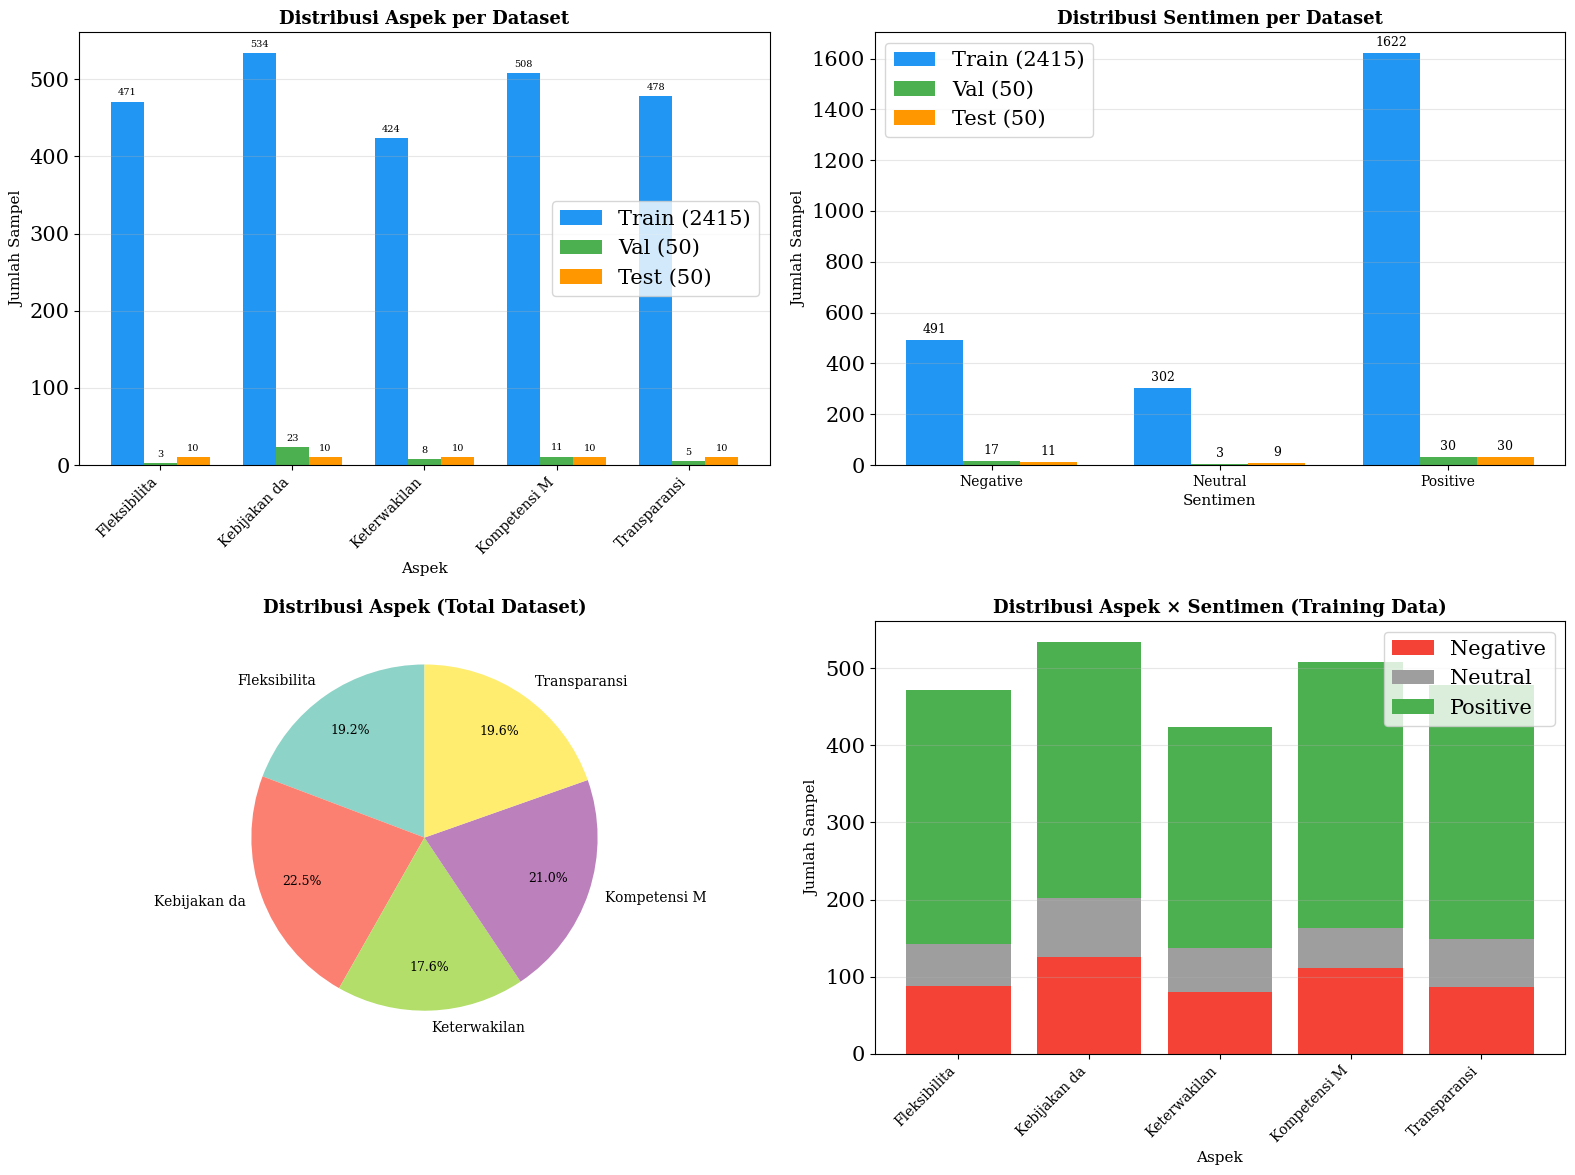


✓ Visualisasi disimpan ke: D:\ANBOW\New folder (3)\figures_iterative\distribusi_aspek_sentimen_train_val_test.png


In [ ]:
# ============================================================
# VISUALISASI DISTRIBUSI ASPEK & SENTIMEN (TRAIN, VAL, TEST)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Function to extract aspects and sentiments from data (dictionary format)
def extract_aspect_sentiment(data):
    """Extract aspect and sentiment from triplet data (dictionary format)"""
    aspects = []
    sentiments = []
    for item in data:
        if isinstance(item, dict):
            aspect = item.get('aspect', '')
            sentiment = item.get('sentiment', '')
            aspects.append(aspect)
            sentiments.append(str(sentiment))
        elif isinstance(item, (list, tuple)) and len(item) >= 3:
            aspects.append(item[1])
            sentiments.append(str(item[2]))
    return aspects, sentiments

# Extract from final datasets
train_aspects, train_sentiments = extract_aspect_sentiment(final_train_data)
val_aspects, val_sentiments = extract_aspect_sentiment(final_val_data)
test_aspects, test_sentiments = extract_aspect_sentiment(final_test_data)

# Count distributions
train_aspect_counts = Counter(train_aspects)
val_aspect_counts = Counter(val_aspects)
test_aspect_counts = Counter(test_aspects)

train_sentiment_counts = Counter(train_sentiments)
val_sentiment_counts = Counter(val_sentiments)
test_sentiment_counts = Counter(test_sentiments)

# Get all unique aspects and sentiments
all_aspects = sorted(set(train_aspect_counts.keys()) | set(val_aspect_counts.keys()) | set(test_aspect_counts.keys()))
all_sentiments = sorted(set(train_sentiment_counts.keys()) | set(val_sentiment_counts.keys()) | set(test_sentiment_counts.keys()))

print("="*70)
print(" DISTRIBUSI ASPEK & SENTIMEN (TRAIN, VAL, TEST)")
print("="*70)

# ============================================================
# 1. TABEL DISTRIBUSI ASPEK
# ============================================================
print("\n📊 DISTRIBUSI ASPEK:")
print("-"*70)
print(f"{'Aspek':<35} {'Train':>10} {'Val':>8} {'Test':>8} {'Total':>8}")
print("-"*70)

for aspect in all_aspects:
    train_count = train_aspect_counts.get(aspect, 0)
    val_count = val_aspect_counts.get(aspect, 0)
    test_count = test_aspect_counts.get(aspect, 0)
    total = train_count + val_count + test_count
    asp_short = aspect[:33] + '..' if len(aspect) > 35 else aspect
    print(f"{asp_short:<35} {train_count:>10} {val_count:>8} {test_count:>8} {total:>8}")

print("-"*70)
print(f"{'TOTAL':<35} {len(train_aspects):>10} {len(val_aspects):>8} {len(test_aspects):>8} {len(train_aspects)+len(val_aspects)+len(test_aspects):>8}")
print("-"*70)

# ============================================================
# 2. TABEL DISTRIBUSI SENTIMEN
# ============================================================
print("\n📊 DISTRIBUSI SENTIMEN:")
print("-"*70)
print(f"{'Sentimen':<25} {'Train':>10} {'Val':>8} {'Test':>8} {'Total':>8}")
print("-"*70)

sentiment_labels = {'0': 'Negative', '1': 'Neutral', '2': 'Positive'}
for sentiment in all_sentiments:
    train_count = train_sentiment_counts.get(sentiment, 0)
    val_count = val_sentiment_counts.get(sentiment, 0)
    test_count = test_sentiment_counts.get(sentiment, 0)
    total = train_count + val_count + test_count
    label = sentiment_labels.get(str(sentiment), str(sentiment))
    print(f"{label} ({sentiment}){' '*(18-len(label))} {train_count:>10} {val_count:>8} {test_count:>8} {total:>8}")

print("-"*70)
print(f"{'TOTAL':<25} {len(train_sentiments):>10} {len(val_sentiments):>8} {len(test_sentiments):>8} {len(train_sentiments)+len(val_sentiments)+len(test_sentiments):>8}")
print("-"*70)

# ============================================================
# 3. VISUALISASI GRAFIK
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors_dataset = ['#2196F3', '#4CAF50', '#FF9800']
colors_sentiment = {'Negative': '#F44336', 'Neutral': '#9E9E9E', 'Positive': '#4CAF50'}

# Aspect short names for display
aspect_short_names = {
    "kebijakan dan pelayanan pemerintah": "Kebijakan",
    "kompetensi menteri": "Kompetensi",
    "fleksibilitas": "Fleksibilitas",
    "keterwakilan": "Keterwakilan",
    "transparansi": "Transparansi"
}
aspect_display = [aspect_short_names.get(a, a[:12]) for a in all_aspects]

# --- Plot 1: Distribusi Aspek per Dataset ---
ax1 = axes[0, 0]
x = np.arange(len(all_aspects))
width = 0.25

train_vals = [train_aspect_counts.get(a, 0) for a in all_aspects]
val_vals = [val_aspect_counts.get(a, 0) for a in all_aspects]
test_vals = [test_aspect_counts.get(a, 0) for a in all_aspects]

bars1 = ax1.bar(x - width, train_vals, width, label=f'Train ({len(train_aspects)})', color=colors_dataset[0])
bars2 = ax1.bar(x, val_vals, width, label=f'Val ({len(val_aspects)})', color=colors_dataset[1])
bars3 = ax1.bar(x + width, test_vals, width, label=f'Test ({len(test_aspects)})', color=colors_dataset[2])

ax1.set_xlabel('Aspek', fontsize=11)
ax1.set_ylabel('Jumlah Sampel', fontsize=11)
ax1.set_title('Distribusi Aspek per Dataset', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(aspect_display, rotation=45, ha='right', fontsize=10)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax1.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontsize=7)

# --- Plot 2: Distribusi Sentimen per Dataset ---
ax2 = axes[0, 1]
x_sent = np.arange(len(all_sentiments))

train_sent_vals = [train_sentiment_counts.get(s, 0) for s in all_sentiments]
val_sent_vals = [val_sentiment_counts.get(s, 0) for s in all_sentiments]
test_sent_vals = [test_sentiment_counts.get(s, 0) for s in all_sentiments]

bars1 = ax2.bar(x_sent - width, train_sent_vals, width, label=f'Train ({len(train_sentiments)})', color=colors_dataset[0])
bars2 = ax2.bar(x_sent, val_sent_vals, width, label=f'Val ({len(val_sentiments)})', color=colors_dataset[1])
bars3 = ax2.bar(x_sent + width, test_sent_vals, width, label=f'Test ({len(test_sentiments)})', color=colors_dataset[2])

sentiment_display = [sentiment_labels.get(str(s), str(s)) for s in all_sentiments]
ax2.set_xlabel('Sentimen', fontsize=11)
ax2.set_ylabel('Jumlah Sampel', fontsize=11)
ax2.set_title('Distribusi Sentimen per Dataset', fontsize=13, fontweight='bold')
ax2.set_xticks(x_sent)
ax2.set_xticklabels(sentiment_display, fontsize=10)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

# --- Plot 3: Pie Chart - Distribusi Aspek (Total) ---
ax3 = axes[1, 0]
total_aspect_counts = Counter()
for aspect in all_aspects:
    total_aspect_counts[aspect] = (train_aspect_counts.get(aspect, 0) +
                                   val_aspect_counts.get(aspect, 0) +
                                   test_aspect_counts.get(aspect, 0))

aspect_pie_labels = [aspect_short_names.get(a, a[:12]) for a in total_aspect_counts.keys()]
aspect_sizes = list(total_aspect_counts.values())
aspect_colors = plt.cm.Set3(np.linspace(0, 1, len(aspect_pie_labels)))

wedges, texts, autotexts = ax3.pie(aspect_sizes, labels=aspect_pie_labels, autopct='%1.1f%%',
                                    colors=aspect_colors, startangle=90,
                                    pctdistance=0.75, labeldistance=1.1)
ax3.set_title('Distribusi Aspek (Total Dataset)', fontsize=13, fontweight='bold')

for autotext in autotexts:
    autotext.set_fontsize(9)
for text in texts:
    text.set_fontsize(10)

# --- Plot 4: Stacked Bar - Aspek x Sentimen (Train Only) ---
ax4 = axes[1, 1]

aspect_sentiment_matrix = {}
for aspect in all_aspects:
    aspect_sentiment_matrix[aspect] = {'Negative': 0, 'Neutral': 0, 'Positive': 0}

for i in range(len(train_aspects)):
    aspect = train_aspects[i]
    sentiment = str(train_sentiments[i])
    label = sentiment_labels.get(sentiment, sentiment)
    if aspect in aspect_sentiment_matrix and label in aspect_sentiment_matrix[aspect]:
        aspect_sentiment_matrix[aspect][label] += 1

x_asp = np.arange(len(all_aspects))
neg_vals = [aspect_sentiment_matrix[a]['Negative'] for a in all_aspects]
neu_vals = [aspect_sentiment_matrix[a]['Neutral'] for a in all_aspects]
pos_vals = [aspect_sentiment_matrix[a]['Positive'] for a in all_aspects]

ax4.bar(x_asp, neg_vals, label='Negative', color=colors_sentiment['Negative'])
ax4.bar(x_asp, neu_vals, bottom=neg_vals, label='Neutral', color=colors_sentiment['Neutral'])
ax4.bar(x_asp, pos_vals, bottom=np.array(neg_vals)+np.array(neu_vals), label='Positive', color=colors_sentiment['Positive'])

ax4.set_xlabel('Aspek', fontsize=11)
ax4.set_ylabel('Jumlah Sampel', fontsize=11)
ax4.set_title('Distribusi Aspek × Sentimen (Training Data)', fontsize=13, fontweight='bold')
ax4.set_xticks(x_asp)
ax4.set_xticklabels(aspect_display, rotation=45, ha='right', fontsize=10)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(str(FIGURES_ITERATIVE / "distribusi_aspek_sentimen_train_val_test.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualisasi disimpan ke: {FIGURES_ITERATIVE / 'distribusi_aspek_sentimen_train_val_test.png'}")
print("="*70)

## 9. Define 18 Training Scenarios (Baseline + Fine-tuning with K-Fold)

In [ ]:
INDOBERT = "indobenchmark/indobert-base-p2"

TRAINING_SCENARIOS = [

    {
        "scenario": 1, "name": "S1_FAST_LSA_S_E5_K5",
        "model": APC.APCModelList.FAST_LSA_S, "type": "baseline",
        "num_epoch": 5, "batch_size": 16, "learning_rate": 2e-5, "max_seq_len": 128,
        "k_fold": 5, "dropout": 0.1, "warmup": 0.1
    },
    {
        "scenario": 2, "name": "S2_FAST_LSA_S_E7_K5",
        "model": APC.APCModelList.FAST_LSA_S, "type": "baseline",
        "num_epoch": 7, "batch_size": 16, "learning_rate": 2e-5, "max_seq_len": 128,
        "k_fold": 5, "dropout": 0.1, "warmup": 0.1
    },
    {
        "scenario": 3, "name": "S3_FAST_LSA_S_E9_K5",
        "model": APC.APCModelList.FAST_LSA_S, "type": "baseline",
        "num_epoch": 9, "batch_size": 16, "learning_rate": 2e-5, "max_seq_len": 128,
        "k_fold": 5, "dropout": 0.1, "warmup": 0.1
    },
    {
        "scenario": 4, "name": "S4_FAST_LSA_S_E11_K5",
        "model": APC.APCModelList.FAST_LSA_S, "type": "baseline",
        "num_epoch": 11, "batch_size": 16, "learning_rate": 2e-5, "max_seq_len": 128,
        "k_fold": 5, "dropout": 0.1, "warmup": 0.1
    },

    # ==================== FAST_LSA_S: BASELINE (K=10) ====================
    {
        "scenario": 5, "name": "S5_FAST_LSA_S_E5_K10",
        "model": APC.APCModelList.FAST_LSA_S, "type": "baseline",
        "num_epoch": 5, "batch_size": 16, "learning_rate": 2e-5, "max_seq_len": 128,
        "k_fold": 10, "dropout": 0.1, "warmup": 0.1
    },
    {
        "scenario": 6, "name": "S6_FAST_LSA_S_E7_K10",
        "model": APC.APCModelList.FAST_LSA_S, "type": "baseline",
        "num_epoch": 7, "batch_size": 16, "learning_rate": 2e-5, "max_seq_len": 128,
        "k_fold": 10, "dropout": 0.1, "warmup": 0.1
    },
    {
        "scenario": 7, "name": "S7_FAST_LSA_S_E9_K10",
        "model": APC.APCModelList.FAST_LSA_S, "type": "baseline",
        "num_epoch": 9, "batch_size": 16, "learning_rate": 2e-5, "max_seq_len": 128,
        "k_fold": 10, "dropout": 0.1, "warmup": 0.1
    },
    {
        "scenario": 8, "name": "S8_FAST_LSA_S_E11_K10",
        "model": APC.APCModelList.FAST_LSA_S, "type": "baseline",
        "num_epoch": 11, "batch_size": 16, "learning_rate": 2e-5, "max_seq_len": 128,
        "k_fold": 10, "dropout": 0.1, "warmup": 0.1
    },

    # ==================== FAST_LSA_S: FINE-TUNING (S9) ====================
    {
        "scenario": 9, "name": "S9_FAST_LSA_S_FINETUNE",
        "model": APC.APCModelList.FAST_LSA_S, "type": "finetune",
        "num_epoch": 10, "batch_size": 32, "learning_rate": 1e-5, "max_seq_len": 256,
        "k_fold": 5, "dropout": 0.1, "warmup": 0.1,
        "gradient_accumulation": 2
    },

    # ==================== FAST_LSA_T: BASELINE (K=5) ====================
    {
        "scenario": 10, "name": "S10_FAST_LSA_T_E5_K5",
        "model": APC.APCModelList.FAST_LSA_T, "type": "baseline",
        "num_epoch": 5, "batch_size": 16, "learning_rate": 2e-5,
        "k_fold": 5, "dropout": 0.1, "warmup": 0.1
    },
    {
        "scenario": 11, "name": "S11_FAST_LSA_T_E7_K5",
        "model": APC.APCModelList.FAST_LSA_T, "type": "baseline",
        "num_epoch": 7, "batch_size": 16, "learning_rate": 2e-5,
        "k_fold": 5, "dropout": 0.1, "warmup": 0.1
    },
    {
        "scenario": 12, "name": "S12_FAST_LSA_T_E9_K5",
        "model": APC.APCModelList.FAST_LSA_T, "type": "baseline",
        "num_epoch": 9, "batch_size": 16, "learning_rate": 2e-5,
        "k_fold": 5, "dropout": 0.1, "warmup": 0.1
    },
    {
        "scenario": 13, "name": "S13_FAST_LSA_T_E11_K5",
        "model": APC.APCModelList.FAST_LSA_T, "type": "baseline",
        "num_epoch": 11, "batch_size": 16, "learning_rate": 2e-5,
        "k_fold": 5, "dropout": 0.1, "warmup": 0.1
    },

    # ==================== FAST_LSA_T: BASELINE (K=10) ====================
    {
        "scenario": 14, "name": "S14_FAST_LSA_T_E5_K10",
        "model": APC.APCModelList.FAST_LSA_T, "type": "baseline",
        "num_epoch": 5, "batch_size": 16, "learning_rate": 2e-5,
        "k_fold": 10, "dropout": 0.1, "warmup": 0.1
    },
    {
        "scenario": 15, "name": "S15_FAST_LSA_T_E7_K10",
        "model": APC.APCModelList.FAST_LSA_T, "type": "baseline",
        "num_epoch": 7, "batch_size": 16, "learning_rate": 2e-5,
        "k_fold": 10, "dropout": 0.1, "warmup": 0.1
    },
    {
        "scenario": 16, "name": "S16_FAST_LSA_T_E9_K10",
        "model": APC.APCModelList.FAST_LSA_T, "type": "baseline",
        "num_epoch": 9, "batch_size": 16, "learning_rate": 2e-5,
        "k_fold": 10, "dropout": 0.1, "warmup": 0.1
    },
    {
        "scenario": 17, "name": "S17_FAST_LSA_T_E11_K10",
        "model": APC.APCModelList.FAST_LSA_T, "type": "baseline",
        "num_epoch": 11, "batch_size": 16, "learning_rate": 2e-5,
        "k_fold": 10, "dropout": 0.1, "warmup": 0.1
    },

    # ==================== FAST_LSA_T: FINE-TUNING (S18) ====================
    {
        "scenario": 18, "name": "S18_FAST_LSA_T_FINETUNE",
        "model": APC.APCModelList.FAST_LSA_T, "type": "finetune",
        "num_epoch": 10, "batch_size": 32, "learning_rate": 1e-5, "max_seq_len": 256,
        "k_fold": 5, "dropout": 0.1, "warmup": 0.1
    },
]

print("\n" + "="*100)
print(" TRAINING SCENARIOS – SESUAI TABEL SKRIPSI")
print("="*100 + "\n")
print(f"{'Scn':<5} {'Name':<30} {'Model':<11} {'Type':<10} {'Epoch':<6} {'BS':<4} {'LR':<8} {'K-Fold':<7}")
print("-"*100)

for sc in TRAINING_SCENARIOS:
    model_name = "FAST_LSA_S" if sc["model"] == APC.APCModelList.FAST_LSA_S else "FAST_LSA_T"
    print(f"{sc['scenario']:<5} {sc['name']:<30} {model_name:<11} {sc['type']:<10} "
          f"{sc['num_epoch']:<6} {sc['batch_size']:<4} {sc['learning_rate']:<8g} {sc['k_fold']:<7}")

print(f"\n{'═'*100}")
print(" FAST_LSA_S: 9 skenario (8 Baseline + 1 Fine-tuning)")
print(" FAST_LSA_T: 9 skenario (8 Baseline + 1 Fine-tuning)")
print(f" TOTAL: {len(TRAINING_SCENARIOS)} skenario")
print(f"{'═'*100}\n")

# Initialize tracking for scenarios
scenario_results = {}
print("✓ Ready for training")
print("  Use the cell below to train each scenario one by one\n")


 TRAINING SCENARIOS – SESUAI TABEL SKRIPSI

Scn   Name                           Model       Type       Epoch  BS   LR       K-Fold 
----------------------------------------------------------------------------------------------------
1     S1_FAST_LSA_S_E5_K5            FAST_LSA_S  baseline   5      16   2e-05    5      
2     S2_FAST_LSA_S_E7_K5            FAST_LSA_S  baseline   7      16   2e-05    5      
3     S3_FAST_LSA_S_E9_K5            FAST_LSA_S  baseline   9      16   2e-05    5      
4     S4_FAST_LSA_S_E11_K5           FAST_LSA_S  baseline   11     16   2e-05    5      
5     S5_FAST_LSA_S_E5_K10           FAST_LSA_S  baseline   5      16   2e-05    10     
6     S6_FAST_LSA_S_E7_K10           FAST_LSA_S  baseline   7      16   2e-05    10     
7     S7_FAST_LSA_S_E9_K10           FAST_LSA_S  baseline   9      16   2e-05    10     
8     S8_FAST_LSA_S_E11_K10          FAST_LSA_S  baseline   11     16   2e-05    10     
9     S9_FAST_LSA_S_FINETUNE         FAST_LSA_S  fine

In [ ]:
def load_apc_file(filepath):
    data = []
    with open(filepath, "r", encoding="utf-8") as f:
        lines = f.readlines()

    for i in range(0, len(lines), 3):
        text_line = lines[i].strip()
        aspect = lines[i+1].strip()
        sentiment = lines[i+2].strip()

        text = text_line.replace(" $T$ ", " ").strip()

        data.append({
            "text": text,
            "aspect": aspect,
            "sentiment": sentiment
        })

    return data

In [ ]:
TEST_PATH = DATASET_SKENARIO / "test_50_final.apc"

final_test_data = load_apc_file(TEST_PATH)

print("✓ test_50_final.apc loaded")
print("Total samples:", len(final_test_data))
print("Sample:", final_test_data[0])

✓ test_50_final.apc loaded
Total samples: 50
Sample: {'text': '$T$ sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'aspect': 'Fleksibilitas', 'sentiment': '2'}


## 10. Training Helper Function (dengan Per-Aspect & Confusion Matrix)

In [ ]:
def run_training_and_evaluate(
    scenario_name,
    model_type,
    pretrained_bert,
    num_epoch,
    batch_size,
    learning_rate,
    max_seq_len,
    k_fold,
    final_test_data,
    warmup_ratio=0.0,
    gradient_accumulation_steps=1,
    dropout=0.0
):
    BASE_DIR = Path("/content/drive/MyDrive/Output_ABSA")
    CHECKPOINT_SKENARIO = BASE_DIR / "checkpoints_skenario"
    RESULTS_SKENARIO = BASE_DIR / "results_skenario"
    FIGURES_SKENARIO = BASE_DIR / "figures_skenario"
    DATASET_SKENARIO = BASE_DIR / "dataset_skenario"

    CHECKPOINT_SKENARIO.mkdir(parents=True, exist_ok=True)
    RESULTS_SKENARIO.mkdir(parents=True, exist_ok=True)
    FIGURES_SKENARIO.mkdir(parents=True, exist_ok=True)

    local_ckpt = Path("/content/checkpoints")
    if local_ckpt.exists():
        shutil.rmtree(local_ckpt)
    local_ckpt.mkdir(parents=True, exist_ok=True)

    config = APC.APCConfigManager.get_apc_config_multilingual()
    config.model = model_type
    config.pretrained_bert = pretrained_bert
    config.num_epoch = num_epoch
    config.batch_size = batch_size
    config.learning_rate = learning_rate
    config.max_seq_len = max_seq_len
    config.dropout = dropout
    config.cross_validate_fold = k_fold
    config.warmup_proportion = warmup_ratio
    config.gradient_accumulation_steps = gradient_accumulation_steps
    config.train_test_split = False
    config.cache_dataset = False
    config.seed = 42
    config.log_step = 50
    config.eval_step = 50
    config.checkpoint_save_mode = 1

    model_name = "FAST_LSA_S" if model_type == APC.APCModelList.FAST_LSA_S else "FAST_LSA_T"

    start_time = datetime.now()

    trainer = APC.APCTrainer(
        config=config,
        dataset=str(DATASET_SKENARIO),
        auto_device=True
    )

    training_time = datetime.now() - start_time

    ckpts = sorted(
        [p for p in local_ckpt.glob("**/fast_lsa*") if p.is_dir() and not p.name.startswith("_")],
        key=lambda p: p.stat().st_mtime,
        reverse=True
    )

    if not ckpts:
        raise RuntimeError("Checkpoint tidak ditemukan")

    best_ckpt = ckpts[0]

    scenario_ckpt_dir = CHECKPOINT_SKENARIO / scenario_name
    scenario_ckpt_dir.mkdir(parents=True, exist_ok=True)

    final_ckpt = scenario_ckpt_dir / best_ckpt.name
    if final_ckpt.exists():
        shutil.rmtree(final_ckpt)

    shutil.copytree(best_ckpt, final_ckpt)
    checkpoint_path = str(final_ckpt)

    shutil.rmtree(local_ckpt, ignore_errors=True)

    trained_model = APCCheckpointManager.get_sentiment_classifier(
        checkpoint=checkpoint_path,
        auto_device=True
    )

    true_labels = []
    pred_labels = []
    aspects_list = []

    id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}

    for sample in final_test_data:
        text = sample["text"]
        aspect = sample["aspect"]
        true_sentiment = id2label[int(sample["sentiment"])]

        try:
            pred = trained_model.predict(text, aspect=aspect, print_result=False)
            pred_id = int(pred["sentiment"][0])
            pred_sentiment = id2label[pred_id]
        except:
            pred_sentiment = "Neutral"

        true_labels.append(true_sentiment)
        pred_labels.append(pred_sentiment)
        aspects_list.append(aspect)

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average="weighted", zero_division=0)
    recall = recall_score(true_labels, pred_labels, average="weighted", zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average="weighted", zero_division=0)

    print("\nOVERALL RESULTS")
    print("Accuracy :", round(accuracy, 4))
    print("Precision:", round(precision, 4))
    print("Recall   :", round(recall, 4))
    print("F1-Score :", round(f1, 4))
    print("\nCLASSIFICATION REPORT")
    print(classification_report(true_labels, pred_labels, zero_division=0))

    aspect_metrics = {}
    for asp in set(aspects_list):
        asp_true = [true_labels[i] for i in range(len(aspects_list)) if aspects_list[i] == asp]
        asp_pred = [pred_labels[i] for i in range(len(aspects_list)) if aspects_list[i] == asp]

        asp_acc = accuracy_score(asp_true, asp_pred)
        asp_f1 = f1_score(asp_true, asp_pred, average="weighted", zero_division=0)

        aspect_metrics[asp] = {
            "count": len(asp_true),
            "accuracy": asp_acc,
            "f1_score": asp_f1
        }

    print("\nPER-ASPECT RESULTS")
    asp_df = pd.DataFrame([
        {
            "Aspect": k,
            "Samples": v["count"],
            "Accuracy": round(v["accuracy"], 4),
            "F1": round(v["f1_score"], 4)
        }
        for k, v in aspect_metrics.items()
    ])
    print(asp_df.to_string(index=False))

    print("\nPER-SENTIMENT RESULTS")
    for sentiment in ["Negative", "Neutral", "Positive"]:
        sent_true = [1 if t == sentiment else 0 for t in true_labels]
        sent_pred = [1 if p == sentiment else 0 for p in pred_labels]

        if sum(sent_true) > 0:
            print(
                sentiment,
                "Precision:", round(precision_score(sent_true, sent_pred, zero_division=0), 4),
                "Recall:", round(recall_score(sent_true, sent_pred, zero_division=0), 4),
                "F1:", round(f1_score(sent_true, sent_pred, zero_division=0), 4)
            )

    cm = confusion_matrix(
        true_labels,
        pred_labels,
        labels=["Negative", "Neutral", "Positive"]
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Negative", "Neutral", "Positive"],
        yticklabels=["Negative", "Neutral", "Positive"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {scenario_name}")
    plt.tight_layout()

    fig_path = FIGURES_SKENARIO / f"confusion_matrix_{scenario_name}.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()

    results = {
        "scenario": scenario_name,
        "model": model_name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "training_time": str(training_time),
        "checkpoint_path": checkpoint_path,
        "per_aspect_metrics": aspect_metrics,
        "config": {
            "pretrained_bert": pretrained_bert,
            "num_epoch": num_epoch,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "max_seq_len": max_seq_len,
            "k_fold": k_fold,
            "warmup_ratio": warmup_ratio,
            "gradient_accumulation": gradient_accumulation_steps,
            "dropout": dropout
        }
    }

    results_path = RESULTS_SKENARIO / f"{scenario_name}_results.json"
    with open(results_path, "w") as f:
        json.dump(results, f, indent=2)

    del trainer, trained_model
    gc.collect()
    torch.cuda.empty_cache()

    return results

In [ ]:
import shutil
from pathlib import Path

ckpt_dir = Path("/content/checkpoints")

if ckpt_dir.exists():
    shutil.rmtree(ckpt_dir)
    print("Checkpoint lokal /content/checkpoints berhasil dihapus")
else:
    print("Tidak ada checkpoint lokal")

Tidak ada checkpoint lokal


## 11. Run Training - FAST_LSA_S Scenarios (S1-S7)
Setiap cell akan menjalankan training dan menampilkan hasil evaluasi lengkap untuk 1 skenario.

### S1

In [ ]:
# ============================================================
# S1: FAST_LSA_S - Epoch=5, K-Fold=5
# ============================================================

scenario = TRAINING_SCENARIOS[0]  # S1
scenario_name = scenario["name"]

results_s1 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 5),
    test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)


 TRAINING: S1_FAST_LSA_S_E5_K5
Model        : FAST_LSA_S
Epoch        : 5
Batch Size   : 16
K-Fold       : 5
Max Seq Len  : 128
[2026-01-03 15:54:50] (2.4.2) Set Model Device: cuda:0
[2026-01-03 15:54:50] (2.4.2) Device Name: NVIDIA L4


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1438) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


2026-01-03 15:54:50,762 INFO: PyABSA version: 2.4.2


INFO:fast_lsa_s:PyABSA version: 2.4.2


2026-01-03 15:54:50,764 INFO: Transformers version: 4.57.3


INFO:fast_lsa_s:Transformers version: 4.57.3


2026-01-03 15:54:50,765 INFO: Torch version: 2.9.0+cu126+cuda12.6


INFO:fast_lsa_s:Torch version: 2.9.0+cu126+cuda12.6


2026-01-03 15:54:50,767 INFO: Device: NVIDIA L4


INFO:fast_lsa_s:Device: NVIDIA L4


[2026-01-03 15:54:50] (2.4.2) Try to load ['/content/drive/MyDrive/Output_ABSA/dataset_skenario'] dataset from local disk


/usr/lib/python3.12/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


2026-01-03 15:54:54,356 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc
preparing dataloader: 100%|██████████| 2415/2415 [00:27<00:00, 87.46it/s]


2026-01-03 15:55:22,447 INFO: Dataset Label Details: {'1': 302, '0': 491, '2': 1622, 'Sum': 2415}


INFO:fast_lsa_s:Dataset Label Details: {'1': 302, '0': 491, '2': 1622, 'Sum': 2415}


2026-01-03 15:55:23,475 INFO: train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0

INFO:fast_lsa_s:train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0.8750, 0.8125,

2026-01-03 15:55:24,047 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc
preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 83.02it/s]


2026-01-03 15:55:24,656 INFO: Dataset Label Details: {'1': 9, '0': 11, '2': 30, 'Sum': 50}


INFO:fast_lsa_s:Dataset Label Details: {'1': 9, '0': 11, '2': 30, 'Sum': 50}


2026-01-03 15:55:24,702 INFO: test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.00

INFO:fast_lsa_s:test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.0000, 0.0000, 0.

2026-01-03 15:55:24,704 INFO: valid data examples:
 []


INFO:fast_lsa_s:valid data examples:
 []


2026-01-03 15:55:25,438 INFO: cuda memory allocated:588429824


INFO:fast_lsa_s:cuda memory allocated:588429824


2026-01-03 15:55:25,442 INFO: Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
       

INFO:fast_lsa_s:Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (outp

2026-01-03 15:55:25,444 INFO: ABSADatasetsVersion:None	-->	Calling Count:0


INFO:fast_lsa_s:ABSADatasetsVersion:None	-->	Calling Count:0


2026-01-03 15:55:25,445 INFO: MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7d8e4eac4ef0>	-->	Calling Count:0


INFO:fast_lsa_s:MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7d8e4eac4ef0>	-->	Calling Count:0


2026-01-03 15:55:25,447 INFO: PyABSAVersion:2.4.2	-->	Calling Count:1


INFO:fast_lsa_s:PyABSAVersion:2.4.2	-->	Calling Count:1


2026-01-03 15:55:25,448 INFO: SRD:3	-->	Calling Count:2465


INFO:fast_lsa_s:SRD:3	-->	Calling Count:2465


2026-01-03 15:55:25,450 INFO: TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


INFO:fast_lsa_s:TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


2026-01-03 15:55:25,451 INFO: TransformersVersion:4.57.3	-->	Calling Count:1


INFO:fast_lsa_s:TransformersVersion:4.57.3	-->	Calling Count:1


2026-01-03 15:55:25,453 INFO: auto_device:True	-->	Calling Count:3


INFO:fast_lsa_s:auto_device:True	-->	Calling Count:3


2026-01-03 15:55:25,454 INFO: batch_size:16	-->	Calling Count:2


INFO:fast_lsa_s:batch_size:16	-->	Calling Count:2


2026-01-03 15:55:25,456 INFO: cache_dataset:False	-->	Calling Count:1


INFO:fast_lsa_s:cache_dataset:False	-->	Calling Count:1


2026-01-03 15:55:25,457 INFO: checkpoint_save_mode:1	-->	Calling Count:4


INFO:fast_lsa_s:checkpoint_save_mode:1	-->	Calling Count:4


2026-01-03 15:55:25,459 INFO: cross_validate_fold:5	-->	Calling Count:1


INFO:fast_lsa_s:cross_validate_fold:5	-->	Calling Count:1


2026-01-03 15:55:25,460 INFO: dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


INFO:fast_lsa_s:dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


2026-01-03 15:55:25,461 INFO: dataset_name:custom_dataset	-->	Calling Count:3


INFO:fast_lsa_s:dataset_name:custom_dataset	-->	Calling Count:3


2026-01-03 15:55:25,462 INFO: dca_layer:3	-->	Calling Count:0


INFO:fast_lsa_s:dca_layer:3	-->	Calling Count:0


2026-01-03 15:55:25,463 INFO: dca_p:1	-->	Calling Count:0


INFO:fast_lsa_s:dca_p:1	-->	Calling Count:0


2026-01-03 15:55:25,465 INFO: deep_ensemble:False	-->	Calling Count:0


INFO:fast_lsa_s:deep_ensemble:False	-->	Calling Count:0


2026-01-03 15:55:25,466 INFO: device:cuda:0	-->	Calling Count:4


INFO:fast_lsa_s:device:cuda:0	-->	Calling Count:4


2026-01-03 15:55:25,468 INFO: device_name:NVIDIA L4	-->	Calling Count:1


INFO:fast_lsa_s:device_name:NVIDIA L4	-->	Calling Count:1


2026-01-03 15:55:25,470 INFO: dlcf_a:2	-->	Calling Count:0


INFO:fast_lsa_s:dlcf_a:2	-->	Calling Count:0


2026-01-03 15:55:25,471 INFO: dropout:0.1	-->	Calling Count:1


INFO:fast_lsa_s:dropout:0.1	-->	Calling Count:1


2026-01-03 15:55:25,472 INFO: dynamic_truncate:True	-->	Calling Count:4930


INFO:fast_lsa_s:dynamic_truncate:True	-->	Calling Count:4930


2026-01-03 15:55:25,474 INFO: embed_dim:768	-->	Calling Count:7


INFO:fast_lsa_s:embed_dim:768	-->	Calling Count:7


2026-01-03 15:55:25,476 INFO: eta:1	-->	Calling Count:0


INFO:fast_lsa_s:eta:1	-->	Calling Count:0


2026-01-03 15:55:25,477 INFO: eta_lr:0.1	-->	Calling Count:1


INFO:fast_lsa_s:eta_lr:0.1	-->	Calling Count:1


2026-01-03 15:55:25,479 INFO: eval_step:20	-->	Calling Count:0


INFO:fast_lsa_s:eval_step:20	-->	Calling Count:0


2026-01-03 15:55:25,481 INFO: evaluate_begin:0	-->	Calling Count:0


INFO:fast_lsa_s:evaluate_begin:0	-->	Calling Count:0


2026-01-03 15:55:25,482 INFO: from_checkpoint:None	-->	Calling Count:0


INFO:fast_lsa_s:from_checkpoint:None	-->	Calling Count:0


2026-01-03 15:55:25,483 INFO: gradient_accumulation:1	-->	Calling Count:0


INFO:fast_lsa_s:gradient_accumulation:1	-->	Calling Count:0


2026-01-03 15:55:25,485 INFO: hidden_dim:768	-->	Calling Count:0


INFO:fast_lsa_s:hidden_dim:768	-->	Calling Count:0


2026-01-03 15:55:25,486 INFO: index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


INFO:fast_lsa_s:index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


2026-01-03 15:55:25,488 INFO: inference_model:None	-->	Calling Count:0


INFO:fast_lsa_s:inference_model:None	-->	Calling Count:0


2026-01-03 15:55:25,489 INFO: initializer:xavier_uniform_	-->	Calling Count:0


INFO:fast_lsa_s:initializer:xavier_uniform_	-->	Calling Count:0


2026-01-03 15:55:25,491 INFO: inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


INFO:fast_lsa_s:inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


2026-01-03 15:55:25,492 INFO: l2reg:1e-06	-->	Calling Count:2


INFO:fast_lsa_s:l2reg:1e-06	-->	Calling Count:2


2026-01-03 15:55:25,494 INFO: label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


INFO:fast_lsa_s:label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


2026-01-03 15:55:25,496 INFO: lcf:cdw	-->	Calling Count:0


INFO:fast_lsa_s:lcf:cdw	-->	Calling Count:0


2026-01-03 15:55:25,497 INFO: learning_rate:2e-05	-->	Calling Count:1


INFO:fast_lsa_s:learning_rate:2e-05	-->	Calling Count:1


2026-01-03 15:55:25,498 INFO: load_aug:False	-->	Calling Count:1


INFO:fast_lsa_s:load_aug:False	-->	Calling Count:1


2026-01-03 15:55:25,500 INFO: log_step:20	-->	Calling Count:0


INFO:fast_lsa_s:log_step:20	-->	Calling Count:0


2026-01-03 15:55:25,501 INFO: logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


INFO:fast_lsa_s:logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


2026-01-03 15:55:25,503 INFO: lsa:False	-->	Calling Count:0


INFO:fast_lsa_s:lsa:False	-->	Calling Count:0


2026-01-03 15:55:25,505 INFO: max_seq_len:128	-->	Calling Count:22185


INFO:fast_lsa_s:max_seq_len:128	-->	Calling Count:22185


2026-01-03 15:55:25,506 INFO: model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


INFO:fast_lsa_s:model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


2026-01-03 15:55:25,508 INFO: model_name:fast_lsa_s	-->	Calling Count:7397


INFO:fast_lsa_s:model_name:fast_lsa_s	-->	Calling Count:7397


2026-01-03 15:55:25,509 INFO: model_path_to_save:checkpoints	-->	Calling Count:0


INFO:fast_lsa_s:model_path_to_save:checkpoints	-->	Calling Count:0


2026-01-03 15:55:25,511 INFO: num_epoch:5	-->	Calling Count:0


INFO:fast_lsa_s:num_epoch:5	-->	Calling Count:0


2026-01-03 15:55:25,512 INFO: optimizer:adamw	-->	Calling Count:1


INFO:fast_lsa_s:optimizer:adamw	-->	Calling Count:1


2026-01-03 15:55:25,513 INFO: output_dim:3	-->	Calling Count:3


INFO:fast_lsa_s:output_dim:3	-->	Calling Count:3


2026-01-03 15:55:25,514 INFO: overwrite_cache:False	-->	Calling Count:0


INFO:fast_lsa_s:overwrite_cache:False	-->	Calling Count:0


2026-01-03 15:55:25,515 INFO: path_to_save:None	-->	Calling Count:1


INFO:fast_lsa_s:path_to_save:None	-->	Calling Count:1


2026-01-03 15:55:25,516 INFO: patience:99999	-->	Calling Count:0


INFO:fast_lsa_s:patience:99999	-->	Calling Count:0


2026-01-03 15:55:25,518 INFO: pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


INFO:fast_lsa_s:pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


2026-01-03 15:55:25,519 INFO: save_mode:1	-->	Calling Count:0


INFO:fast_lsa_s:save_mode:1	-->	Calling Count:0


2026-01-03 15:55:25,520 INFO: seed:42	-->	Calling Count:7


INFO:fast_lsa_s:seed:42	-->	Calling Count:7


2026-01-03 15:55:25,522 INFO: sigma:0.3	-->	Calling Count:0


INFO:fast_lsa_s:sigma:0.3	-->	Calling Count:0


2026-01-03 15:55:25,523 INFO: similarity_threshold:1	-->	Calling Count:2


INFO:fast_lsa_s:similarity_threshold:1	-->	Calling Count:2


2026-01-03 15:55:25,525 INFO: spacy_model:en_core_web_sm	-->	Calling Count:3


INFO:fast_lsa_s:spacy_model:en_core_web_sm	-->	Calling Count:3


2026-01-03 15:55:25,526 INFO: srd_alignment:True	-->	Calling Count:2465


INFO:fast_lsa_s:srd_alignment:True	-->	Calling Count:2465


2026-01-03 15:55:25,527 INFO: task_code:APC	-->	Calling Count:1


INFO:fast_lsa_s:task_code:APC	-->	Calling Count:1


2026-01-03 15:55:25,529 INFO: task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


INFO:fast_lsa_s:task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


2026-01-03 15:55:25,530 INFO: tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Callin

INFO:fast_lsa_s:tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Calling Count:0


2026-01-03 15:55:25,532 INFO: use_amp:False	-->	Calling Count:1


INFO:fast_lsa_s:use_amp:False	-->	Calling Count:1


2026-01-03 15:55:25,533 INFO: use_bert_spc:True	-->	Calling Count:0


INFO:fast_lsa_s:use_bert_spc:True	-->	Calling Count:0


2026-01-03 15:55:25,535 INFO: use_syntax_based_SRD:False	-->	Calling Count:0


INFO:fast_lsa_s:use_syntax_based_SRD:False	-->	Calling Count:0


2026-01-03 15:55:25,536 INFO: warmup_proportion:0.1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_proportion:0.1	-->	Calling Count:0


2026-01-03 15:55:25,537 INFO: warmup_step:-1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_step:-1	-->	Calling Count:0


2026-01-03 15:55:25,539 INFO: window:lr	-->	Calling Count:0


INFO:fast_lsa_s:window:lr	-->	Calling Count:0


2026-01-03 15:55:25,541 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 15:55:25,542 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 15:55:25,543 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 15:55:25,545 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 15:55:25,546 INFO: Num steps = 35


INFO:fast_lsa_s:Num steps = 35


2026-01-03 15:55:25,547 INFO: No. 1 trainer in 5 folds


INFO:fast_lsa_s:No. 1 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.8300:  16%|█▌        | 19/121 [00:03<00:21,  4.77it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.7680:  32%|███▏      | 39/121 [00:11<00:17,  4.68it/s, Dev Acc:70.66(max:70.66) Dev F1:27.60(max:27.60)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.7125:  49%|████▉     | 59/121 [00:19<00:13,  4.71it/s, Dev Acc:78.72(max:78.72

2026-01-03 15:58:54,300 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]              │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286] │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
╘════════════════════╧════════════╧═════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
---------------------------------

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]              │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286] │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
╘════════════════════╧════════════╧═════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
--------------------------------- https://githu

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_83.27/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_83.27/_0.00441389624029398/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_83.27/_0.015849601477384567/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_83.27/_0.09867759048938751/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_83.27/_0.11351720988750458/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_83.27/_0.036594208329916/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_83.27/_0.03288005292415619/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_83.27/_0.08919849246740341/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_83.27/_0.017412345856428146/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_83.

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 15:58:54,793 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 15:58:54,794 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 15:58:54,796 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 15:58:54,797 INFO: Num steps = 35


INFO:fast_lsa_s:Num steps = 35


2026-01-03 15:58:54,799 INFO: No. 2 trainer in 5 folds


INFO:fast_lsa_s:No. 2 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.2315:  16%|█▌        | 19/121 [00:03<00:21,  4.79it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.2286:  32%|███▏      | 39/121 [00:11<00:17,  4.77it/s, Dev Acc:95.04(max:95.04) Dev F1:93.07(max:93.07)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.2272:  49%|████▉     | 59/121 [00:18<00:13,  4.76it/s, Dev Acc:97.11(max:97.11

2026-01-03 16:02:20,693 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]              │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286] │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]              │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286] │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.0]     

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.3/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.3/_0.007773434743285179/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.3/_0.006467519327998161/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.3/_0.007152440492063761/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.3/_0.004897673148661852/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.3/_0.136949822306633/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.3/_0.058002352714538574/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.3/_0.008159677498042583/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.3/_0.0059942277148365974/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.3/_

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 16:02:21,169 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 16:02:21,171 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 16:02:21,172 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 16:02:21,173 INFO: Num steps = 35


INFO:fast_lsa_s:Num steps = 35


2026-01-03 16:02:21,175 INFO: No. 3 trainer in 5 folds


INFO:fast_lsa_s:No. 3 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.1529:  16%|█▌        | 19/121 [00:03<00:21,  4.81it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1512:  32%|███▏      | 39/121 [00:11<00:17,  4.79it/s, Dev Acc:98.55(max:98.55) Dev F1:98.07(max:98.07)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1497:  49%|████▉     | 59/121 [00:17<00:13,  4.75it/s, Dev Acc:98.55(max:98.55

2026-01-03 16:05:43,467 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]              │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286] │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]              │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286] │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.0]     

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.2/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.2/_0.10195895284414291/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.2/_0.2986127734184265/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.2/_0.002241668524220586/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.2/_0.0030695749446749687/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.2/_0.21400833129882812/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.2/_0.007819613441824913/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.2/_0.002439429285004735/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.2/_0.0030883655417710543/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.2/_

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 16:05:43,946 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 16:05:43,948 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 16:05:43,949 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 16:05:43,950 INFO: Num steps = 35


INFO:fast_lsa_s:Num steps = 35


2026-01-03 16:05:43,951 INFO: No. 4 trainer in 5 folds


INFO:fast_lsa_s:No. 4 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.1164:  16%|█▌        | 19/121 [00:03<00:21,  4.83it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1156:  32%|███▏      | 39/121 [00:11<00:17,  4.77it/s, Dev Acc:99.17(max:99.17) Dev F1:98.33(max:98.33)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1147:  49%|████▉     | 59/121 [00:17<00:12,  4.78it/s, Dev Acc:98.76(max:99.17

2026-01-03 16:09:07,420 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]               │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286]  │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]               │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286]  │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.79_f1_99.62/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.79_f1_99.62/_0.007173278369009495/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.79_f1_99.62/_0.0010954192839562893/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.79_f1_99.62/_0.04780903086066246/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.79_f1_99.62/_0.07632733881473541/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.79_f1_99.62/_0.0025170468725264072/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.79_f1_99.62/_0.13891316950321198/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.79_f1_99.62/_0.004330799914896488/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.79_f1_99.62/_0.026857059448957443/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.79

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 16:09:07,913 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 16:09:07,914 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 16:09:07,915 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 16:09:07,916 INFO: Num steps = 35


INFO:fast_lsa_s:Num steps = 35


2026-01-03 16:09:07,917 INFO: No. 5 trainer in 5 folds


INFO:fast_lsa_s:No. 5 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.0971:  16%|█▌        | 19/121 [00:03<00:21,  4.82it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0967:  32%|███▏      | 39/121 [00:11<00:17,  4.80it/s, Dev Acc:99.16(max:99.16) Dev F1:98.60(max:98.60)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0962:  49%|████▉     | 59/121 [00:17<00:12,  4.77it/s, Dev Acc:99.16(max:99.16

2026-01-03 16:12:28,653 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]               │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286]  │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]               │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286]  │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0004412344715092331/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0035654869861900806/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0018805994186550379/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.03051476739346981/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.02459065616130829/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.09587206691503525/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.048840321600437164/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0014147225301712751/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.

INFO:fast_lsa_s:
----------------------------------------------------------------------------- Raw Metric Records -----------------------------------------------------------------------------
╒════════════════════╤══════════════════════════════════════════════════════════╤═════════════════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial                                                    │ Values                          │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪══════════════════════════════════════════════════════════╪═════════════════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s                                               │ [62.0]                          │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼──────────────────────────────────────────────────────────┼───────────────────────────

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0004412344715092331/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0035654869861900806/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0018805994186550379/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.03051476739346981/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.02459065616130829/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.09587206691503525/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.048840321600437164/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0014147225301712751/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.

/usr/local/lib/python3.12/dist-packages/pyabsa/framework/trainer_class/trainer_template.py:250: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/logs/fast_lsa_s_20260103 130350/trainer.log' mode='a' encoding='utf8'>
  self.config.logger.removeHandler(self.config.logger.handlers[0])



 Training Time: 0:17:42.161592

 Loading model from: /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S1_FAST_LSA_S_E5_K5
[2026-01-03 16:12:32] (2.4.2) Load sentiment classifier from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S1_FAST_LSA_S_E5_K5
[2026-01-03 16:12:32] (2.4.2) config: None
[2026-01-03 16:12:32] (2.4.2) state_dict: None
[2026-01-03 16:12:32] (2.4.2) model: None
[2026-01-03 16:12:32] (2.4.2) tokenizer: None


RuntimeError: Fail to load the model from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S1_FAST_LSA_S_E5_K5! Please make sure the version of checkpoint and PyABSA are compatible. Try to remove he checkpoint and download again 
Exception: expected str, bytes or os.PathLike object, not NoneType 

In [ ]:
import shutil
import re
from pathlib import Path

def copy_best_checkpoint_to_drive(scenario_name):
    src_root = Path("/content/checkpoints")
    if not src_root.exists():
        raise RuntimeError("/content/checkpoints tidak ada")

    ckpts = [p for p in src_root.iterdir() if p.is_dir()]
    if len(ckpts) == 0:
        raise RuntimeError("Tidak ada checkpoint di /content/checkpoints")

    def extract_f1(p):
        m = re.search(r"f1[_\-]?([0-9.]+)", p.name.lower())
        return float(m.group(1)) if m else -1.0

    best_ckpt = max(ckpts, key=extract_f1)

    dst_root = Path("/content/drive/MyDrive/Output_ABSA/checkpoints_skenario")
    dst_root.mkdir(parents=True, exist_ok=True)

    dst_ckpt = dst_root / scenario_name
    if dst_ckpt.exists():
        shutil.rmtree(dst_ckpt)

    shutil.copytree(best_ckpt, dst_ckpt)

    return str(dst_ckpt)

In [ ]:
checkpoint_path = copy_best_checkpoint_to_drive(scenario_name)
print("Checkpoint berhasil dicopy ke:", checkpoint_path)

Checkpoint berhasil dicopy ke: /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S1_FAST_LSA_S_E5_K5


In [ ]:
!ls /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S1_FAST_LSA_S_E5_K5

_0.0010954192839562893	_0.004330799914896488  _0.13869138062000275
_0.001121123437769711	_0.00448992382735014   _0.13891316950321198
_0.00131360930390656	_0.005047477316111326  _0.21920330822467804
_0.001571459462866187	_0.006112025119364262  _0.34628450870513916
_0.001759965205565095	_0.007173278369009495  fast_lsa_s.args.txt
_0.0024676332250237465	_0.026857059448957443  fast_lsa_s.config
_0.0025170468725264072	_0.04780903086066246   fast_lsa_s.state_dict
_0.002935252618044615	_0.06314027309417725   fast_lsa_s.tokenizer
_0.0034991533029824495	_0.07365009933710098
_0.004310425836592913	_0.07632733881473541


[2026-01-03 16:31:11] (2.4.2) Load sentiment classifier from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S1_FAST_LSA_S_E5_K5
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S1_FAST_LSA_S_E5_K5/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S1_FAST_LSA_S_E5_K5/_0.007173278369009495/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S1_FAST_LSA_S_E5_K5/_0.0010954192839562893/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S1_FAST_LSA_S_E5_K5/_0.04780903086066246/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S1_FAST_LSA_S_E5_K5/_0.07632733881473541/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S1_FAST_LSA_S_E5_K5/_0.0025170468725264072/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S1_FAST_LSA_S_E5_K5/_0.13891316950321198/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



OVERALL RESULTS
Accuracy : 0.64
Precision: 0.6105263157894737
Recall   : 0.64
F1-score : 0.6068397237437485

CLASSIFICATION REPORT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


              precision    recall  f1-score   support

    Negative       0.50      0.36      0.42        11
     Neutral       0.50      0.22      0.31         9
    Positive       0.68      0.87      0.76        30

    accuracy                           0.64        50
   macro avg       0.56      0.48      0.50        50
weighted avg       0.61      0.64      0.61        50


PER-ASPECT METRICS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Aspect : Fleksibilitas
Samples: 10
Acc    : 0.8000
F1     : 0.7529


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Aspect : Kebijakan dan Pelayanan Pemerintah
Samples: 10
Acc    : 0.7000
F1     : 0.6782


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Aspect : Keterwakilan
Samples: 10
Acc    : 0.6000
F1     : 0.6286


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Aspect : Kompetensi Menteri
Samples: 10
Acc    : 0.5000
F1     : 0.4800


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Aspect : Transparansi
Samples: 10
Acc    : 0.6000
F1     : 0.4500


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



PER-ASPECT SUMMARY TABLE


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                                    samples  accuracy  f1_score
Fleksibilitas                            10       0.8  0.752941
Kebijakan dan Pelayanan Pemerintah       10       0.7  0.678205
Keterwakilan                             10       0.6  0.628571
Kompetensi Menteri                       10       0.5  0.480000
Transparansi                             10       0.6  0.450000

PER-SENTIMENT METRICS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Sentiment: Negative
Samples  : 11
Precision: 0.5000
Recall   : 0.3636
F1       : 0.4211


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Sentiment: Neutral
Samples  : 9
Precision: 0.5000
Recall   : 0.2222
F1       : 0.3077


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Sentiment: Positive
Samples  : 30
Precision: 0.6842
Recall   : 0.8667
F1       : 0.7647


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


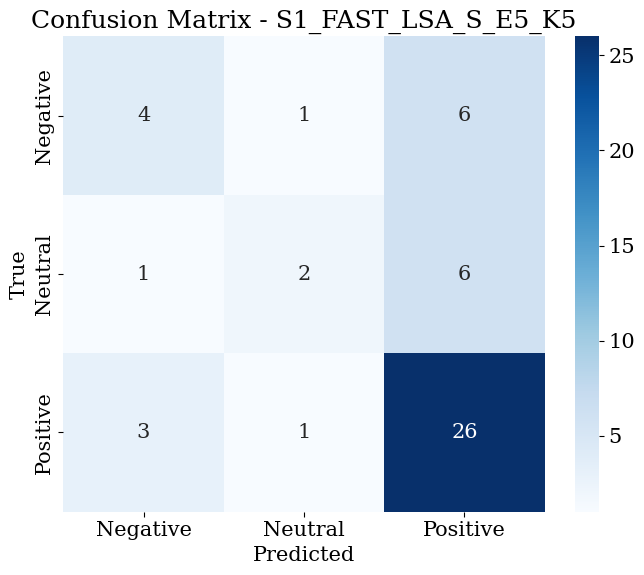


RESULTS SAVED TO:
/content/drive/MyDrive/Output_ABSA/results_skenario/S1_FAST_LSA_S_E5_K5_results.json


In [ ]:
from pyabsa import APCCheckpointManager
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import gc
import torch

scenario_name = "S1_FAST_LSA_S_E5_K5"
model_name = "FAST_LSA_S"

checkpoint_path = "/content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S1_FAST_LSA_S_E5_K5"
RESULTS_DIR = "/content/drive/MyDrive/Output_ABSA/results_skenario"
FIG_DIR = "/content/drive/MyDrive/Output_ABSA/figures_skenario"

Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)
Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

trained_model = APCCheckpointManager.get_sentiment_classifier(
    checkpoint=checkpoint_path,
    auto_device=True
)

print("Model loaded from checkpoint")

true_labels = []
pred_labels = []
aspects_list = []

id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}

for sample in final_test_data:
    text = sample["text"]
    aspect = sample["aspect"]
    true_sentiment = id2label[int(sample["sentiment"])]

    try:
        pred = trained_model.predict(text, aspect=aspect, print_result=False)
        pred_id = int(pred["sentiment"][0])
        pred_sentiment = id2label[pred_id]
    except:
        pred_sentiment = "Neutral"

    true_labels.append(true_sentiment)
    pred_labels.append(pred_sentiment)
    aspects_list.append(aspect)

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average="weighted", zero_division=0)
recall = recall_score(true_labels, pred_labels, average="weighted", zero_division=0)
f1 = f1_score(true_labels, pred_labels, average="weighted", zero_division=0)

print("\nOVERALL RESULTS")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)

print("\nCLASSIFICATION REPORT")
print(classification_report(true_labels, pred_labels, zero_division=0))

print("\nPER-ASPECT METRICS")

aspect_metrics = {}

for asp in sorted(set(aspects_list)):
    asp_true = [true_labels[i] for i in range(len(aspects_list)) if aspects_list[i] == asp]
    asp_pred = [pred_labels[i] for i in range(len(aspects_list)) if aspects_list[i] == asp]

    asp_acc = accuracy_score(asp_true, asp_pred)
    asp_f1 = f1_score(asp_true, asp_pred, average="weighted", zero_division=0)

    aspect_metrics[asp] = {
        "samples": len(asp_true),
        "accuracy": asp_acc,
        "f1_score": asp_f1
    }

    print(f"\nAspect : {asp}")
    print(f"Samples: {len(asp_true)}")
    print(f"Acc    : {asp_acc:.4f}")
    print(f"F1     : {asp_f1:.4f}")

asp_df = pd.DataFrame.from_dict(aspect_metrics, orient="index")
print("\nPER-ASPECT SUMMARY TABLE")
print(asp_df)

print("\nPER-SENTIMENT METRICS")

sentiment_metrics = {}

for sent in ["Negative", "Neutral", "Positive"]:
    sent_true = [1 if t == sent else 0 for t in true_labels]
    sent_pred = [1 if p == sent else 0 for p in pred_labels]

    if sum(sent_true) > 0:
        sentiment_metrics[sent] = {
            "samples": sum(sent_true),
            "precision": precision_score(sent_true, sent_pred, zero_division=0),
            "recall": recall_score(sent_true, sent_pred, zero_division=0),
            "f1": f1_score(sent_true, sent_pred, zero_division=0)
        }

        print(f"\nSentiment: {sent}")
        print(f"Samples  : {sum(sent_true)}")
        print(f"Precision: {sentiment_metrics[sent]['precision']:.4f}")
        print(f"Recall   : {sentiment_metrics[sent]['recall']:.4f}")
        print(f"F1       : {sentiment_metrics[sent]['f1']:.4f}")

cm = confusion_matrix(
    true_labels, pred_labels,
    labels=["Negative", "Neutral", "Positive"]
)

df_cm = pd.DataFrame(
    cm,
    index=["Negative", "Neutral", "Positive"],
    columns=["Negative", "Neutral", "Positive"]
)

plt.figure(figsize=(7,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {scenario_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()

cm_path = f"{FIG_DIR}/confusion_matrix_{scenario_name}.png"
plt.savefig(cm_path, dpi=150)
plt.show()

results = {
    "scenario": scenario_name,
    "model": model_name,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "checkpoint_path": checkpoint_path,
    "per_aspect": aspect_metrics,
    "per_sentiment": sentiment_metrics
}

results_path = f"{RESULTS_DIR}/{scenario_name}_results.json"
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print("\nRESULTS SAVED TO:")
print(results_path)

del trained_model
gc.collect()
torch.cuda.empty_cache()

### S2

[2026-01-03 17:14:24] (2.4.2) Set Model Device: cuda:0
[2026-01-03 17:14:24] (2.4.2) Device Name: NVIDIA L4


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1438) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


2026-01-03 17:14:25,106 INFO: PyABSA version: 2.4.2


INFO:fast_lsa_s:PyABSA version: 2.4.2


2026-01-03 17:14:25,147 INFO: Transformers version: 4.57.3


INFO:fast_lsa_s:Transformers version: 4.57.3


2026-01-03 17:14:25,148 INFO: Torch version: 2.9.0+cu126+cuda12.6


INFO:fast_lsa_s:Torch version: 2.9.0+cu126+cuda12.6


2026-01-03 17:14:25,149 INFO: Device: NVIDIA L4


INFO:fast_lsa_s:Device: NVIDIA L4


[2026-01-03 17:14:25] (2.4.2) Try to load ['/content/drive/MyDrive/Output_ABSA/dataset_skenario'] dataset from local disk
2026-01-03 17:14:27,961 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc
preparing dataloader: 100%|██████████| 2415/2415 [00:27<00:00, 86.72it/s]


2026-01-03 17:14:55,827 INFO: Dataset Label Details: {'1': 302, '0': 491, '2': 1622, 'Sum': 2415}


INFO:fast_lsa_s:Dataset Label Details: {'1': 302, '0': 491, '2': 1622, 'Sum': 2415}


2026-01-03 17:14:56,878 INFO: train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0

INFO:fast_lsa_s:train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0.8750, 0.8125,

2026-01-03 17:14:57,447 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc
preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 83.59it/s]


2026-01-03 17:14:58,052 INFO: Dataset Label Details: {'1': 9, '0': 11, '2': 30, 'Sum': 50}


INFO:fast_lsa_s:Dataset Label Details: {'1': 9, '0': 11, '2': 30, 'Sum': 50}


2026-01-03 17:14:58,097 INFO: test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.00

INFO:fast_lsa_s:test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.0000, 0.0000, 0.

2026-01-03 17:14:58,099 INFO: valid data examples:
 []


INFO:fast_lsa_s:valid data examples:
 []


2026-01-03 17:14:58,829 INFO: cuda memory allocated:571128320


INFO:fast_lsa_s:cuda memory allocated:571128320


2026-01-03 17:14:58,832 INFO: Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
       

INFO:fast_lsa_s:Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (outp

2026-01-03 17:14:58,834 INFO: ABSADatasetsVersion:None	-->	Calling Count:0


INFO:fast_lsa_s:ABSADatasetsVersion:None	-->	Calling Count:0


2026-01-03 17:14:58,835 INFO: MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7d8e5975b110>	-->	Calling Count:0


INFO:fast_lsa_s:MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7d8e5975b110>	-->	Calling Count:0


2026-01-03 17:14:58,837 INFO: PyABSAVersion:2.4.2	-->	Calling Count:1


INFO:fast_lsa_s:PyABSAVersion:2.4.2	-->	Calling Count:1


2026-01-03 17:14:58,838 INFO: SRD:3	-->	Calling Count:2465


INFO:fast_lsa_s:SRD:3	-->	Calling Count:2465


2026-01-03 17:14:58,840 INFO: TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


INFO:fast_lsa_s:TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


2026-01-03 17:14:58,841 INFO: TransformersVersion:4.57.3	-->	Calling Count:1


INFO:fast_lsa_s:TransformersVersion:4.57.3	-->	Calling Count:1


2026-01-03 17:14:58,842 INFO: auto_device:True	-->	Calling Count:3


INFO:fast_lsa_s:auto_device:True	-->	Calling Count:3


2026-01-03 17:14:58,843 INFO: batch_size:16	-->	Calling Count:2


INFO:fast_lsa_s:batch_size:16	-->	Calling Count:2


2026-01-03 17:14:58,845 INFO: cache_dataset:False	-->	Calling Count:1


INFO:fast_lsa_s:cache_dataset:False	-->	Calling Count:1


2026-01-03 17:14:58,846 INFO: checkpoint_save_mode:1	-->	Calling Count:4


INFO:fast_lsa_s:checkpoint_save_mode:1	-->	Calling Count:4


2026-01-03 17:14:58,847 INFO: cross_validate_fold:5	-->	Calling Count:1


INFO:fast_lsa_s:cross_validate_fold:5	-->	Calling Count:1


2026-01-03 17:14:58,849 INFO: dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


INFO:fast_lsa_s:dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


2026-01-03 17:14:58,850 INFO: dataset_name:custom_dataset	-->	Calling Count:3


INFO:fast_lsa_s:dataset_name:custom_dataset	-->	Calling Count:3


2026-01-03 17:14:58,852 INFO: dca_layer:3	-->	Calling Count:0


INFO:fast_lsa_s:dca_layer:3	-->	Calling Count:0


2026-01-03 17:14:58,853 INFO: dca_p:1	-->	Calling Count:0


INFO:fast_lsa_s:dca_p:1	-->	Calling Count:0


2026-01-03 17:14:58,855 INFO: deep_ensemble:False	-->	Calling Count:0


INFO:fast_lsa_s:deep_ensemble:False	-->	Calling Count:0


2026-01-03 17:14:58,856 INFO: device:cuda:0	-->	Calling Count:4


INFO:fast_lsa_s:device:cuda:0	-->	Calling Count:4


2026-01-03 17:14:58,858 INFO: device_name:NVIDIA L4	-->	Calling Count:1


INFO:fast_lsa_s:device_name:NVIDIA L4	-->	Calling Count:1


2026-01-03 17:14:58,859 INFO: dlcf_a:2	-->	Calling Count:0


INFO:fast_lsa_s:dlcf_a:2	-->	Calling Count:0


2026-01-03 17:14:58,860 INFO: dropout:0.1	-->	Calling Count:1


INFO:fast_lsa_s:dropout:0.1	-->	Calling Count:1


2026-01-03 17:14:58,862 INFO: dynamic_truncate:True	-->	Calling Count:4930


INFO:fast_lsa_s:dynamic_truncate:True	-->	Calling Count:4930


2026-01-03 17:14:58,863 INFO: embed_dim:768	-->	Calling Count:7


INFO:fast_lsa_s:embed_dim:768	-->	Calling Count:7


2026-01-03 17:14:58,865 INFO: eta:1	-->	Calling Count:0


INFO:fast_lsa_s:eta:1	-->	Calling Count:0


2026-01-03 17:14:58,866 INFO: eta_lr:0.1	-->	Calling Count:1


INFO:fast_lsa_s:eta_lr:0.1	-->	Calling Count:1


2026-01-03 17:14:58,867 INFO: eval_step:50	-->	Calling Count:0


INFO:fast_lsa_s:eval_step:50	-->	Calling Count:0


2026-01-03 17:14:58,868 INFO: evaluate_begin:0	-->	Calling Count:0


INFO:fast_lsa_s:evaluate_begin:0	-->	Calling Count:0


2026-01-03 17:14:58,870 INFO: from_checkpoint:None	-->	Calling Count:0


INFO:fast_lsa_s:from_checkpoint:None	-->	Calling Count:0


2026-01-03 17:14:58,871 INFO: gradient_accumulation_steps:1	-->	Calling Count:0


INFO:fast_lsa_s:gradient_accumulation_steps:1	-->	Calling Count:0


2026-01-03 17:14:58,872 INFO: hidden_dim:768	-->	Calling Count:0


INFO:fast_lsa_s:hidden_dim:768	-->	Calling Count:0


2026-01-03 17:14:58,873 INFO: index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


INFO:fast_lsa_s:index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


2026-01-03 17:14:58,875 INFO: inference_model:None	-->	Calling Count:0


INFO:fast_lsa_s:inference_model:None	-->	Calling Count:0


2026-01-03 17:14:58,876 INFO: initializer:xavier_uniform_	-->	Calling Count:0


INFO:fast_lsa_s:initializer:xavier_uniform_	-->	Calling Count:0


2026-01-03 17:14:58,877 INFO: inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


INFO:fast_lsa_s:inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


2026-01-03 17:14:58,878 INFO: l2reg:1e-06	-->	Calling Count:2


INFO:fast_lsa_s:l2reg:1e-06	-->	Calling Count:2


2026-01-03 17:14:58,879 INFO: label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


INFO:fast_lsa_s:label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


2026-01-03 17:14:58,881 INFO: lcf:cdw	-->	Calling Count:0


INFO:fast_lsa_s:lcf:cdw	-->	Calling Count:0


2026-01-03 17:14:58,882 INFO: learning_rate:2e-05	-->	Calling Count:1


INFO:fast_lsa_s:learning_rate:2e-05	-->	Calling Count:1


2026-01-03 17:14:58,883 INFO: load_aug:False	-->	Calling Count:1


INFO:fast_lsa_s:load_aug:False	-->	Calling Count:1


2026-01-03 17:14:58,884 INFO: log_step:50	-->	Calling Count:0


INFO:fast_lsa_s:log_step:50	-->	Calling Count:0


2026-01-03 17:14:58,886 INFO: logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


INFO:fast_lsa_s:logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


2026-01-03 17:14:58,887 INFO: lsa:False	-->	Calling Count:0


INFO:fast_lsa_s:lsa:False	-->	Calling Count:0


2026-01-03 17:14:58,888 INFO: max_seq_len:128	-->	Calling Count:22185


INFO:fast_lsa_s:max_seq_len:128	-->	Calling Count:22185


2026-01-03 17:14:58,890 INFO: model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


INFO:fast_lsa_s:model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


2026-01-03 17:14:58,891 INFO: model_name:fast_lsa_s	-->	Calling Count:7397


INFO:fast_lsa_s:model_name:fast_lsa_s	-->	Calling Count:7397


2026-01-03 17:14:58,892 INFO: model_path_to_save:checkpoints	-->	Calling Count:0


INFO:fast_lsa_s:model_path_to_save:checkpoints	-->	Calling Count:0


2026-01-03 17:14:58,893 INFO: num_epoch:7	-->	Calling Count:0


INFO:fast_lsa_s:num_epoch:7	-->	Calling Count:0


2026-01-03 17:14:58,895 INFO: optimizer:adamw	-->	Calling Count:1


INFO:fast_lsa_s:optimizer:adamw	-->	Calling Count:1


2026-01-03 17:14:58,896 INFO: output_dim:3	-->	Calling Count:3


INFO:fast_lsa_s:output_dim:3	-->	Calling Count:3


2026-01-03 17:14:58,897 INFO: overwrite_cache:False	-->	Calling Count:0


INFO:fast_lsa_s:overwrite_cache:False	-->	Calling Count:0


2026-01-03 17:14:58,898 INFO: path_to_save:None	-->	Calling Count:1


INFO:fast_lsa_s:path_to_save:None	-->	Calling Count:1


2026-01-03 17:14:58,900 INFO: patience:99999	-->	Calling Count:0


INFO:fast_lsa_s:patience:99999	-->	Calling Count:0


2026-01-03 17:14:58,901 INFO: pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


INFO:fast_lsa_s:pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


2026-01-03 17:14:58,902 INFO: save_mode:1	-->	Calling Count:0


INFO:fast_lsa_s:save_mode:1	-->	Calling Count:0


2026-01-03 17:14:58,904 INFO: seed:42	-->	Calling Count:7


INFO:fast_lsa_s:seed:42	-->	Calling Count:7


2026-01-03 17:14:58,905 INFO: sigma:0.3	-->	Calling Count:0


INFO:fast_lsa_s:sigma:0.3	-->	Calling Count:0


2026-01-03 17:14:58,906 INFO: similarity_threshold:1	-->	Calling Count:2


INFO:fast_lsa_s:similarity_threshold:1	-->	Calling Count:2


2026-01-03 17:14:58,907 INFO: spacy_model:en_core_web_sm	-->	Calling Count:3


INFO:fast_lsa_s:spacy_model:en_core_web_sm	-->	Calling Count:3


2026-01-03 17:14:58,908 INFO: srd_alignment:True	-->	Calling Count:2465


INFO:fast_lsa_s:srd_alignment:True	-->	Calling Count:2465


2026-01-03 17:14:58,909 INFO: task_code:APC	-->	Calling Count:1


INFO:fast_lsa_s:task_code:APC	-->	Calling Count:1


2026-01-03 17:14:58,910 INFO: task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


INFO:fast_lsa_s:task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


2026-01-03 17:14:58,911 INFO: tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Callin

INFO:fast_lsa_s:tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Calling Count:0


2026-01-03 17:14:58,913 INFO: train_test_split:False	-->	Calling Count:0


INFO:fast_lsa_s:train_test_split:False	-->	Calling Count:0


2026-01-03 17:14:58,914 INFO: use_amp:False	-->	Calling Count:1


INFO:fast_lsa_s:use_amp:False	-->	Calling Count:1


2026-01-03 17:14:58,915 INFO: use_bert_spc:True	-->	Calling Count:0


INFO:fast_lsa_s:use_bert_spc:True	-->	Calling Count:0


2026-01-03 17:14:58,917 INFO: use_syntax_based_SRD:False	-->	Calling Count:0


INFO:fast_lsa_s:use_syntax_based_SRD:False	-->	Calling Count:0


2026-01-03 17:14:58,918 INFO: warmup_proportion:0.1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_proportion:0.1	-->	Calling Count:0


2026-01-03 17:14:58,919 INFO: warmup_step:-1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_step:-1	-->	Calling Count:0


2026-01-03 17:14:58,920 INFO: window:lr	-->	Calling Count:0


INFO:fast_lsa_s:window:lr	-->	Calling Count:0


2026-01-03 17:14:58,923 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 17:14:58,924 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 17:14:58,925 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 17:14:58,927 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 17:14:58,928 INFO: Num steps = 49


INFO:fast_lsa_s:Num steps = 49


2026-01-03 17:14:58,929 INFO: No. 1 trainer in 5 folds


INFO:fast_lsa_s:No. 1 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.7423:  40%|████      | 49/121 [00:10<00:15,  4.63it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.5967:  82%|████████▏ | 99/121 [00:24<00:04,  4.73it/s, Dev Acc:82.85(max:82.85) Dev F1:58.51(max:58.51)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.5672: 100%|██████████| 121/121 [00:32<00:00,  3.71it/s, Dev Acc:88.43(max:88.4

2026-01-03 17:18:41,235 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]              │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [54.19144877118168] │  54.1914  │ 54.1914  │   0   │   0   │ 54.1914 │ 54.1914 │
╘════════════════════╧════════════╧═════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
---------------------------------

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]              │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [54.19144877118168] │  54.1914  │ 54.1914  │   0   │   0   │ 54.1914 │ 54.1914 │
╘════════════════════╧════════════╧═════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
--------------------------------- https://githu

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_0.3048580586910248/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_0.021296948194503784/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_0.007750477641820908/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_0.018456311896443367/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_0.014039408415555954/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_0.0025947713293135166/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_0.007590373046696186/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_0.0056641665287315845/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 17:18:41,661 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 17:18:41,663 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 17:18:41,664 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 17:18:41,666 INFO: Num steps = 49


INFO:fast_lsa_s:Num steps = 49


2026-01-03 17:18:41,667 INFO: No. 2 trainer in 5 folds


INFO:fast_lsa_s:No. 2 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.1858:  40%|████      | 49/121 [00:10<00:15,  4.79it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1851:  82%|████████▏ | 99/121 [00:23<00:04,  4.80it/s, Dev Acc:95.66(max:95.66) Dev F1:92.70(max:92.70)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1838: 100%|██████████| 121/121 [00:31<00:00,  3.84it/s, Dev Acc:97.11(max:97.1

2026-01-03 17:22:21,491 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]              │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [54.19144877118168] │  54.1914  │ 54.1914  │   0   │   0   │ 54.1914 │ 54.1914 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]              │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [54.19144877118168] │  54.1914  │ 54.1914  │   0   │   0   │ 54.1914 │ 54.1914 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.0]     

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.27/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.27/_0.005901175085455179/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.27/_0.008748810738325119/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.27/_0.0058105261996388435/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.27/_0.0984543189406395/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.27/_0.00764129962772131/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.27/_0.026699231937527657/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.27/_0.020120766013860703/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.27/_0.003424519207328558/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 17:22:21,917 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 17:22:21,918 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 17:22:21,919 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 17:22:21,920 INFO: Num steps = 49


INFO:fast_lsa_s:Num steps = 49


2026-01-03 17:22:21,922 INFO: No. 3 trainer in 5 folds


INFO:fast_lsa_s:No. 3 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.1277:  40%|████      | 49/121 [00:10<00:15,  4.77it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1265:  82%|████████▏ | 99/121 [00:23<00:04,  4.80it/s, Dev Acc:98.14(max:98.14) Dev F1:97.41(max:97.41)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1268: 100%|██████████| 121/121 [00:30<00:00,  3.94it/s, Dev Acc:96.07(max:98.1

2026-01-03 17:25:59,932 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]              │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [54.19144877118168] │  54.1914  │ 54.1914  │   0   │   0   │ 54.1914 │ 54.1914 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]              │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [54.19144877118168] │  54.1914  │ 54.1914  │   0   │   0   │ 54.1914 │ 54.1914 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.0]     

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.67/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.67/_0.0022514662705361843/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.67/_0.04906948655843735/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.67/_0.0010396589059382677/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.67/_0.015467977151274681/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.67/_0.0034541708882898092/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.67/_0.0016218922100961208/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.67/_0.004129913169890642/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.67/_0.000811964098829776/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_9

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 17:26:00,359 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 17:26:00,360 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 17:26:00,361 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 17:26:00,362 INFO: Num steps = 49


INFO:fast_lsa_s:Num steps = 49


2026-01-03 17:26:00,364 INFO: No. 4 trainer in 5 folds


INFO:fast_lsa_s:No. 4 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.0994:  40%|████      | 49/121 [00:10<00:14,  4.81it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0989:  82%|████████▏ | 99/121 [00:23<00:04,  4.77it/s, Dev Acc:99.59(max:99.59) Dev F1:99.06(max:99.06)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0988: 100%|██████████| 121/121 [00:30<00:00,  3.93it/s, Dev Acc:98.76(max:99.5

2026-01-03 17:29:38,124 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]              │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [54.19144877118168] │  54.1914  │ 54.1914  │   0   │   0   │ 54.1914 │ 54.1914 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]              │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [54.19144877118168] │  54.1914  │ 54.1914  │   0   │   0   │ 54.1914 │ 54.1914 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.0]     

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/_0.0016430329997092485/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/_0.0017394765745848417/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/_0.010388369672000408/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/_0.0024962788447737694/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/_0.0030428075697273016/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/_0.01883085072040558/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/_0.001438354142010212/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/_0.0038289157673716545/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 17:29:38,543 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 17:29:38,544 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 17:29:38,546 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 17:29:38,547 INFO: Num steps = 49


INFO:fast_lsa_s:Num steps = 49


2026-01-03 17:29:38,549 INFO: No. 5 trainer in 5 folds


INFO:fast_lsa_s:No. 5 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.0844:  40%|████      | 49/121 [00:10<00:15,  4.79it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0838:  82%|████████▏ | 99/121 [00:23<00:04,  4.82it/s, Dev Acc:98.96(max:98.96) Dev F1:98.59(max:98.59)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0838: 100%|██████████| 121/121 [00:31<00:00,  3.82it/s, Dev Acc:99.16(max:99.1

2026-01-03 17:33:16,405 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]              │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [54.19144877118168] │  54.1914  │ 54.1914  │   0   │   0   │ 54.1914 │ 54.1914 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]              │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [54.19144877118168] │  54.1914  │ 54.1914  │   0   │   0   │ 54.1914 │ 54.1914 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.0]     

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.013931458815932274/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0010961727239191532/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0008996432879939675/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0011976412497460842/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0035666427575051785/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.002896596910431981/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.003073923522606492/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.006360277067869902/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_

INFO:fast_lsa_s:
----------------------------------------------------------------------------- Raw Metric Records -----------------------------------------------------------------------------
╒════════════════════╤══════════════════════════════════════════════════════════╤═════════════════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial                                                    │ Values                          │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪══════════════════════════════════════════════════════════╪═════════════════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s                                               │ [66.0]                          │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼──────────────────────────────────────────────────────────┼───────────────────────────

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.013931458815932274/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0010961727239191532/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0008996432879939675/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0011976412497460842/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0035666427575051785/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.002896596910431981/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.003073923522606492/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.006360277067869902/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_

/usr/local/lib/python3.12/dist-packages/pyabsa/framework/trainer_class/trainer_template.py:250: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/logs/fast_lsa_s_20260103 130350/trainer.log' mode='a' encoding='utf8'>
  self.config.logger.removeHandler(self.config.logger.handlers[0])


[2026-01-03 17:33:57] (2.4.2) Load sentiment classifier from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S3_FAST_LSA_S_E7_K5/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S3_FAST_LSA_S_E7_K5/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S3_FAST_LSA_S_E7_K5/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.013931458815932274/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S3_FAST_LSA_S_E7_K5/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0010961727239191532/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S3_FAST_LSA_S_E7_K5/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0008996432879939675/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S3_FAST_LSA_S_E7_K5/fast_lsa_s_custom_dataset_acc_99.16_f1_98.6/_0.0011976412497460842/fast_lsa_s.state_dict', 'drive/My

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



OVERALL RESULTS
Accuracy : 0.64
Precision: 0.6195
Recall   : 0.64
F1-Score : 0.6198

CLASSIFICATION REPORT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


              precision    recall  f1-score   support

    Negative       0.57      0.36      0.44        11
     Neutral       0.43      0.33      0.38         9
    Positive       0.69      0.83      0.76        30

    accuracy                           0.64        50
   macro avg       0.56      0.51      0.53        50
weighted avg       0.62      0.64      0.62        50



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



PER-ASPECT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                            Aspect  Samples  Accuracy     F1
                      Keterwakilan       10       0.5 0.5558
                     Fleksibilitas       10       0.8 0.7529
Kebijakan dan Pelayanan Pemerintah       10       0.7 0.6782
                Kompetensi Menteri       10       0.6 0.5881
                      Transparansi       10       0.6 0.4500

PER-SENTIMENT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Negative Precision: 0.5714 Recall: 0.3636 F1: 0.4444


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Neutral Precision: 0.4286 Recall: 0.3333 F1: 0.375


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Positive Precision: 0.6944 Recall: 0.8333 F1: 0.7576


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


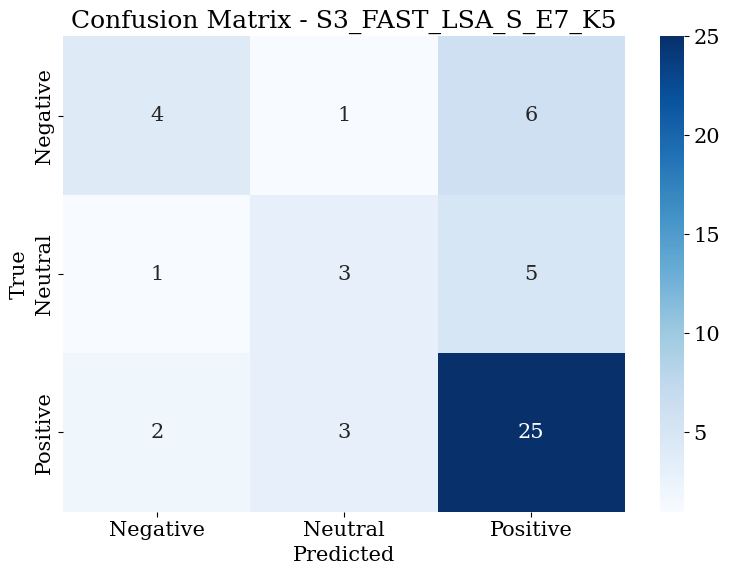

In [ ]:
# ============================================================
# S2: FAST_LSA_S - Epoch=7, K-Fold=5
# ============================================================

scenario = TRAINING_SCENARIOS[1]  # S2
scenario_name = scenario["name"]

results_s3 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 5),
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

### S3

[2026-01-03 18:15:10] (2.4.2) Set Model Device: cuda:0
[2026-01-03 18:15:10] (2.4.2) Device Name: NVIDIA L4


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1438) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


2026-01-03 18:15:11,081 INFO: PyABSA version: 2.4.2


INFO:fast_lsa_s:PyABSA version: 2.4.2


2026-01-03 18:15:11,083 INFO: Transformers version: 4.57.3


INFO:fast_lsa_s:Transformers version: 4.57.3


2026-01-03 18:15:11,084 INFO: Torch version: 2.9.0+cu126+cuda12.6


INFO:fast_lsa_s:Torch version: 2.9.0+cu126+cuda12.6


2026-01-03 18:15:11,085 INFO: Device: NVIDIA L4


INFO:fast_lsa_s:Device: NVIDIA L4


[2026-01-03 18:15:11] (2.4.2) Try to load ['/content/drive/MyDrive/Output_ABSA/dataset_skenario'] dataset from local disk


/usr/lib/python3.12/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


2026-01-03 18:15:14,055 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc
preparing dataloader: 100%|██████████| 2415/2415 [00:27<00:00, 87.92it/s]


2026-01-03 18:15:41,545 INFO: Dataset Label Details: {'1': 302, '0': 491, '2': 1622, 'Sum': 2415}


INFO:fast_lsa_s:Dataset Label Details: {'1': 302, '0': 491, '2': 1622, 'Sum': 2415}


2026-01-03 18:15:42,557 INFO: train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0

INFO:fast_lsa_s:train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0.8750, 0.8125,

2026-01-03 18:15:43,123 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc
preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 83.79it/s]


2026-01-03 18:15:43,727 INFO: Dataset Label Details: {'1': 9, '0': 11, '2': 30, 'Sum': 50}


INFO:fast_lsa_s:Dataset Label Details: {'1': 9, '0': 11, '2': 30, 'Sum': 50}


2026-01-03 18:15:43,771 INFO: test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.00

INFO:fast_lsa_s:test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.0000, 0.0000, 0.

2026-01-03 18:15:43,774 INFO: valid data examples:
 []


INFO:fast_lsa_s:valid data examples:
 []


2026-01-03 18:15:44,500 INFO: cuda memory allocated:571128320


INFO:fast_lsa_s:cuda memory allocated:571128320


2026-01-03 18:15:44,503 INFO: Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
       

INFO:fast_lsa_s:Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (outp

2026-01-03 18:15:44,505 INFO: ABSADatasetsVersion:None	-->	Calling Count:0


INFO:fast_lsa_s:ABSADatasetsVersion:None	-->	Calling Count:0


2026-01-03 18:15:44,507 INFO: MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7d8e57f2c4d0>	-->	Calling Count:0


INFO:fast_lsa_s:MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7d8e57f2c4d0>	-->	Calling Count:0


2026-01-03 18:15:44,508 INFO: PyABSAVersion:2.4.2	-->	Calling Count:1


INFO:fast_lsa_s:PyABSAVersion:2.4.2	-->	Calling Count:1


2026-01-03 18:15:44,510 INFO: SRD:3	-->	Calling Count:2465


INFO:fast_lsa_s:SRD:3	-->	Calling Count:2465


2026-01-03 18:15:44,511 INFO: TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


INFO:fast_lsa_s:TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


2026-01-03 18:15:44,512 INFO: TransformersVersion:4.57.3	-->	Calling Count:1


INFO:fast_lsa_s:TransformersVersion:4.57.3	-->	Calling Count:1


2026-01-03 18:15:44,513 INFO: auto_device:True	-->	Calling Count:3


INFO:fast_lsa_s:auto_device:True	-->	Calling Count:3


2026-01-03 18:15:44,514 INFO: batch_size:16	-->	Calling Count:2


INFO:fast_lsa_s:batch_size:16	-->	Calling Count:2


2026-01-03 18:15:44,515 INFO: cache_dataset:False	-->	Calling Count:1


INFO:fast_lsa_s:cache_dataset:False	-->	Calling Count:1


2026-01-03 18:15:44,517 INFO: checkpoint_save_mode:1	-->	Calling Count:4


INFO:fast_lsa_s:checkpoint_save_mode:1	-->	Calling Count:4


2026-01-03 18:15:44,518 INFO: cross_validate_fold:5	-->	Calling Count:1


INFO:fast_lsa_s:cross_validate_fold:5	-->	Calling Count:1


2026-01-03 18:15:44,519 INFO: dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


INFO:fast_lsa_s:dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


2026-01-03 18:15:44,521 INFO: dataset_name:custom_dataset	-->	Calling Count:3


INFO:fast_lsa_s:dataset_name:custom_dataset	-->	Calling Count:3


2026-01-03 18:15:44,522 INFO: dca_layer:3	-->	Calling Count:0


INFO:fast_lsa_s:dca_layer:3	-->	Calling Count:0


2026-01-03 18:15:44,523 INFO: dca_p:1	-->	Calling Count:0


INFO:fast_lsa_s:dca_p:1	-->	Calling Count:0


2026-01-03 18:15:44,524 INFO: deep_ensemble:False	-->	Calling Count:0


INFO:fast_lsa_s:deep_ensemble:False	-->	Calling Count:0


2026-01-03 18:15:44,526 INFO: device:cuda:0	-->	Calling Count:4


INFO:fast_lsa_s:device:cuda:0	-->	Calling Count:4


2026-01-03 18:15:44,527 INFO: device_name:NVIDIA L4	-->	Calling Count:1


INFO:fast_lsa_s:device_name:NVIDIA L4	-->	Calling Count:1


2026-01-03 18:15:44,528 INFO: dlcf_a:2	-->	Calling Count:0


INFO:fast_lsa_s:dlcf_a:2	-->	Calling Count:0


2026-01-03 18:15:44,530 INFO: dropout:0.1	-->	Calling Count:1


INFO:fast_lsa_s:dropout:0.1	-->	Calling Count:1


2026-01-03 18:15:44,532 INFO: dynamic_truncate:True	-->	Calling Count:4930


INFO:fast_lsa_s:dynamic_truncate:True	-->	Calling Count:4930


2026-01-03 18:15:44,533 INFO: embed_dim:768	-->	Calling Count:7


INFO:fast_lsa_s:embed_dim:768	-->	Calling Count:7


2026-01-03 18:15:44,535 INFO: eta:1	-->	Calling Count:0


INFO:fast_lsa_s:eta:1	-->	Calling Count:0


2026-01-03 18:15:44,536 INFO: eta_lr:0.1	-->	Calling Count:1


INFO:fast_lsa_s:eta_lr:0.1	-->	Calling Count:1


2026-01-03 18:15:44,537 INFO: eval_step:50	-->	Calling Count:0


INFO:fast_lsa_s:eval_step:50	-->	Calling Count:0


2026-01-03 18:15:44,539 INFO: evaluate_begin:0	-->	Calling Count:0


INFO:fast_lsa_s:evaluate_begin:0	-->	Calling Count:0


2026-01-03 18:15:44,540 INFO: from_checkpoint:None	-->	Calling Count:0


INFO:fast_lsa_s:from_checkpoint:None	-->	Calling Count:0


2026-01-03 18:15:44,541 INFO: gradient_accumulation_steps:1	-->	Calling Count:0


INFO:fast_lsa_s:gradient_accumulation_steps:1	-->	Calling Count:0


2026-01-03 18:15:44,543 INFO: hidden_dim:768	-->	Calling Count:0


INFO:fast_lsa_s:hidden_dim:768	-->	Calling Count:0


2026-01-03 18:15:44,544 INFO: index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


INFO:fast_lsa_s:index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


2026-01-03 18:15:44,546 INFO: inference_model:None	-->	Calling Count:0


INFO:fast_lsa_s:inference_model:None	-->	Calling Count:0


2026-01-03 18:15:44,547 INFO: initializer:xavier_uniform_	-->	Calling Count:0


INFO:fast_lsa_s:initializer:xavier_uniform_	-->	Calling Count:0


2026-01-03 18:15:44,548 INFO: inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


INFO:fast_lsa_s:inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


2026-01-03 18:15:44,550 INFO: l2reg:1e-06	-->	Calling Count:2


INFO:fast_lsa_s:l2reg:1e-06	-->	Calling Count:2


2026-01-03 18:15:44,552 INFO: label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


INFO:fast_lsa_s:label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


2026-01-03 18:15:44,553 INFO: lcf:cdw	-->	Calling Count:0


INFO:fast_lsa_s:lcf:cdw	-->	Calling Count:0


2026-01-03 18:15:44,555 INFO: learning_rate:2e-05	-->	Calling Count:1


INFO:fast_lsa_s:learning_rate:2e-05	-->	Calling Count:1


2026-01-03 18:15:44,556 INFO: load_aug:False	-->	Calling Count:1


INFO:fast_lsa_s:load_aug:False	-->	Calling Count:1


2026-01-03 18:15:44,558 INFO: log_step:50	-->	Calling Count:0


INFO:fast_lsa_s:log_step:50	-->	Calling Count:0


2026-01-03 18:15:44,559 INFO: logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


INFO:fast_lsa_s:logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


2026-01-03 18:15:44,561 INFO: lsa:False	-->	Calling Count:0


INFO:fast_lsa_s:lsa:False	-->	Calling Count:0


2026-01-03 18:15:44,562 INFO: max_seq_len:128	-->	Calling Count:22185


INFO:fast_lsa_s:max_seq_len:128	-->	Calling Count:22185


2026-01-03 18:15:44,564 INFO: model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


INFO:fast_lsa_s:model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


2026-01-03 18:15:44,565 INFO: model_name:fast_lsa_s	-->	Calling Count:7397


INFO:fast_lsa_s:model_name:fast_lsa_s	-->	Calling Count:7397


2026-01-03 18:15:44,567 INFO: model_path_to_save:checkpoints	-->	Calling Count:0


INFO:fast_lsa_s:model_path_to_save:checkpoints	-->	Calling Count:0


2026-01-03 18:15:44,568 INFO: num_epoch:9	-->	Calling Count:0


INFO:fast_lsa_s:num_epoch:9	-->	Calling Count:0


2026-01-03 18:15:44,570 INFO: optimizer:adamw	-->	Calling Count:1


INFO:fast_lsa_s:optimizer:adamw	-->	Calling Count:1


2026-01-03 18:15:44,571 INFO: output_dim:3	-->	Calling Count:3


INFO:fast_lsa_s:output_dim:3	-->	Calling Count:3


2026-01-03 18:15:44,572 INFO: overwrite_cache:False	-->	Calling Count:0


INFO:fast_lsa_s:overwrite_cache:False	-->	Calling Count:0


2026-01-03 18:15:44,574 INFO: path_to_save:None	-->	Calling Count:1


INFO:fast_lsa_s:path_to_save:None	-->	Calling Count:1


2026-01-03 18:15:44,575 INFO: patience:99999	-->	Calling Count:0


INFO:fast_lsa_s:patience:99999	-->	Calling Count:0


2026-01-03 18:15:44,576 INFO: pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


INFO:fast_lsa_s:pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


2026-01-03 18:15:44,578 INFO: save_mode:1	-->	Calling Count:0


INFO:fast_lsa_s:save_mode:1	-->	Calling Count:0


2026-01-03 18:15:44,579 INFO: seed:42	-->	Calling Count:7


INFO:fast_lsa_s:seed:42	-->	Calling Count:7


2026-01-03 18:15:44,581 INFO: sigma:0.3	-->	Calling Count:0


INFO:fast_lsa_s:sigma:0.3	-->	Calling Count:0


2026-01-03 18:15:44,582 INFO: similarity_threshold:1	-->	Calling Count:2


INFO:fast_lsa_s:similarity_threshold:1	-->	Calling Count:2


2026-01-03 18:15:44,584 INFO: spacy_model:en_core_web_sm	-->	Calling Count:3


INFO:fast_lsa_s:spacy_model:en_core_web_sm	-->	Calling Count:3


2026-01-03 18:15:44,585 INFO: srd_alignment:True	-->	Calling Count:2465


INFO:fast_lsa_s:srd_alignment:True	-->	Calling Count:2465


2026-01-03 18:15:44,587 INFO: task_code:APC	-->	Calling Count:1


INFO:fast_lsa_s:task_code:APC	-->	Calling Count:1


2026-01-03 18:15:44,588 INFO: task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


INFO:fast_lsa_s:task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


2026-01-03 18:15:44,590 INFO: tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Callin

INFO:fast_lsa_s:tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Calling Count:0


2026-01-03 18:15:44,591 INFO: train_test_split:False	-->	Calling Count:0


INFO:fast_lsa_s:train_test_split:False	-->	Calling Count:0


2026-01-03 18:15:44,593 INFO: use_amp:False	-->	Calling Count:1


INFO:fast_lsa_s:use_amp:False	-->	Calling Count:1


2026-01-03 18:15:44,595 INFO: use_bert_spc:True	-->	Calling Count:0


INFO:fast_lsa_s:use_bert_spc:True	-->	Calling Count:0


2026-01-03 18:15:44,596 INFO: use_syntax_based_SRD:False	-->	Calling Count:0


INFO:fast_lsa_s:use_syntax_based_SRD:False	-->	Calling Count:0


2026-01-03 18:15:44,598 INFO: warmup_proportion:0.1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_proportion:0.1	-->	Calling Count:0


2026-01-03 18:15:44,599 INFO: warmup_step:-1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_step:-1	-->	Calling Count:0


2026-01-03 18:15:44,601 INFO: window:lr	-->	Calling Count:0


INFO:fast_lsa_s:window:lr	-->	Calling Count:0


2026-01-03 18:15:44,603 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 18:15:44,604 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 18:15:44,606 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 18:15:44,607 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 18:15:44,609 INFO: Num steps = 63


INFO:fast_lsa_s:Num steps = 63


2026-01-03 18:15:44,610 INFO: No. 1 trainer in 5 folds


INFO:fast_lsa_s:No. 1 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.7423:  40%|████      | 49/121 [00:10<00:15,  4.63it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.5967:  82%|████████▏ | 99/121 [00:24<00:04,  4.73it/s, Dev Acc:82.85(max:82.85) Dev F1:58.51(max:58.51)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.5672: 100%|██████████| 121/121 [00:32<00:00,  3.78it/s, Dev Acc:88.43(max:88.4

2026-01-03 18:20:27,130 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]              │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [61.91077441077441] │  61.9108  │ 61.9108  │   0   │   0   │ 61.9108 │ 61.9108 │
╘════════════════════╧════════════╧═════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
---------------------------------

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]              │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [61.91077441077441] │  61.9108  │ 61.9108  │   0   │   0   │ 61.9108 │ 61.9108 │
╘════════════════════╧════════════╧═════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
--------------------------------- https://githu

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_0.3048580586910248/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_0.010196159593760967/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_0.05004921555519104/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_0.021296948194503784/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_0.007750477641820908/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_0.018456311896443367/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_0.014039408415555954/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_0.0025947713293135166/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.12_f1_80.9/_

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 18:20:27,489 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 18:20:27,491 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 18:20:27,493 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 18:20:27,494 INFO: Num steps = 63


INFO:fast_lsa_s:Num steps = 63


2026-01-03 18:20:27,495 INFO: No. 2 trainer in 5 folds


INFO:fast_lsa_s:No. 2 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.1560:  40%|████      | 49/121 [00:10<00:15,  4.78it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1545:  82%|████████▏ | 99/121 [00:23<00:04,  4.79it/s, Dev Acc:97.73(max:97.73) Dev F1:96.66(max:96.66)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1558: 100%|██████████| 121/121 [00:31<00:00,  3.86it/s, Dev Acc:98.14(max:98.1

2026-01-03 18:25:06,474 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [61.91077441077441]  │  61.9108  │ 61.9108  │   0   │   0   │ 61.9108 │ 61.9108 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [61.91077441077441]  │  61.9108  │ 61.9108  │   0   │   0   │ 61.9108 │ 61.9108 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.15/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.15/_0.10713883489370346/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.15/_0.026339247822761536/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.15/_0.12000302225351334/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.15/_0.0174754299223423/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.15/_0.005698497407138348/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.15/_0.013565668836236/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.15/_0.0028222231194376945/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97.15/_0.08882169425487518/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.14_f1_97

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 18:25:06,826 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 18:25:06,827 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 18:25:06,829 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 18:25:06,830 INFO: Num steps = 63


INFO:fast_lsa_s:Num steps = 63


2026-01-03 18:25:06,831 INFO: No. 3 trainer in 5 folds


INFO:fast_lsa_s:No. 3 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.1069:  40%|████      | 49/121 [00:10<00:15,  4.77it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1081:  82%|████████▏ | 99/121 [00:23<00:04,  4.79it/s, Dev Acc:93.60(max:93.60) Dev F1:87.88(max:87.88)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1081: 100%|██████████| 121/121 [00:31<00:00,  3.87it/s, Dev Acc:97.73(max:97.7

2026-01-03 18:29:45,430 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [61.91077441077441]  │  61.9108  │ 61.9108  │   0   │   0   │ 61.9108 │ 61.9108 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [61.91077441077441]  │  61.9108  │ 61.9108  │   0   │   0   │ 61.9108 │ 61.9108 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_97.73_f1_96.69/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.73_f1_96.69/_0.04473024606704712/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.73_f1_96.69/_0.0029647513292729855/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.73_f1_96.69/_0.2423124462366104/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.73_f1_96.69/_0.01410786435008049/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.73_f1_96.69/_0.32725363969802856/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.73_f1_96.69/_0.0005291150882840157/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.73_f1_96.69/_0.02239621989428997/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.73_f1_96.69/_0.0024030839558690786/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.73_f

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 18:29:45,780 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 18:29:45,782 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 18:29:45,783 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 18:29:45,784 INFO: Num steps = 63


INFO:fast_lsa_s:Num steps = 63


2026-01-03 18:29:45,786 INFO: No. 4 trainer in 5 folds


INFO:fast_lsa_s:No. 4 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.0893:  40%|████      | 49/121 [00:10<00:15,  4.77it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0895:  82%|████████▏ | 99/121 [00:23<00:04,  4.78it/s, Dev Acc:98.76(max:98.76) Dev F1:97.88(max:97.88)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0896: 100%|██████████| 121/121 [00:30<00:00,  3.97it/s, Dev Acc:98.76(max:98.7

2026-01-03 18:34:23,684 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [61.91077441077441]  │  61.9108  │ 61.9108  │   0   │   0   │ 61.9108 │ 61.9108 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [61.91077441077441]  │  61.9108  │ 61.9108  │   0   │   0   │ 61.9108 │ 61.9108 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_97.88/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_97.88/_0.20721706748008728/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_97.88/_0.0015413209330290556/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_97.88/_0.0017332328716292977/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_97.88/_0.6830540299415588/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_97.88/_0.0017678728327155113/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_97.88/_0.021027017384767532/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_97.88/_0.00803155917674303/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_97.88/_0.23115231096744537/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 18:34:24,041 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 18:34:24,043 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 18:34:24,044 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 18:34:24,046 INFO: Num steps = 63


INFO:fast_lsa_s:Num steps = 63


2026-01-03 18:34:24,047 INFO: No. 5 trainer in 5 folds


INFO:fast_lsa_s:No. 5 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.0777:  40%|████      | 49/121 [00:10<00:15,  4.80it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0775:  82%|████████▏ | 99/121 [00:23<00:04,  4.81it/s, Dev Acc:98.33(max:98.33) Dev F1:97.32(max:97.32)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0774: 100%|██████████| 121/121 [00:30<00:00,  3.98it/s, Dev Acc:97.70(max:98.3

2026-01-03 18:39:03,312 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [61.91077441077441]  │  61.9108  │ 61.9108  │   0   │   0   │ 61.9108 │ 61.9108 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [61.91077441077441]  │  61.9108  │ 61.9108  │   0   │   0   │ 61.9108 │ 61.9108 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.14334659278392792/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.004006031900644302/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.005410062149167061/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.0014700759202241898/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.004959294106811285/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.0018746829591691494/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.017392512410879135/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.0010898447362706065/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98

INFO:fast_lsa_s:
----------------------------------------------------------------------------- Raw Metric Records -----------------------------------------------------------------------------
╒════════════════════╤══════════════════════════════════════════════════════════╤═════════════════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial                                                    │ Values                          │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪══════════════════════════════════════════════════════════╪═════════════════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s                                               │ [70.0]                          │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼──────────────────────────────────────────────────────────┼───────────────────────────

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.14334659278392792/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.004006031900644302/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.005410062149167061/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.0014700759202241898/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.004959294106811285/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.0018746829591691494/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.017392512410879135/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.0010898447362706065/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98

/usr/local/lib/python3.12/dist-packages/pyabsa/framework/trainer_class/trainer_template.py:250: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/logs/fast_lsa_s_20260103 130350/trainer.log' mode='a' encoding='utf8'>
  self.config.logger.removeHandler(self.config.logger.handlers[0])


[2026-01-03 18:39:52] (2.4.2) Load sentiment classifier from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S5_FAST_LSA_S_E9_K5/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S5_FAST_LSA_S_E9_K5/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S5_FAST_LSA_S_E9_K5/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.14334659278392792/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S5_FAST_LSA_S_E9_K5/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.004006031900644302/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S5_FAST_LSA_S_E9_K5/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.005410062149167061/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S5_FAST_LSA_S_E9_K5/fast_lsa_s_custom_dataset_acc_98.54_f1_97.51/_0.0014700759202241898/fast_lsa_s.state_dict', 'drive

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



OVERALL RESULTS
Accuracy : 0.64
Precision: 0.6242
Recall   : 0.64
F1-Score : 0.628

CLASSIFICATION REPORT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


              precision    recall  f1-score   support

    Negative       0.44      0.36      0.40        11
     Neutral       0.57      0.44      0.50         9
    Positive       0.71      0.80      0.75        30

    accuracy                           0.64        50
   macro avg       0.57      0.54      0.55        50
weighted avg       0.62      0.64      0.63        50



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



PER-ASPECT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                            Aspect  Samples  Accuracy     F1
                      Keterwakilan       10       0.5 0.5558
                     Fleksibilitas       10       0.7 0.7000
Kebijakan dan Pelayanan Pemerintah       10       0.8 0.8067
                Kompetensi Menteri       10       0.6 0.5867
                      Transparansi       10       0.6 0.4500

PER-SENTIMENT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Negative Precision: 0.4444 Recall: 0.3636 F1: 0.4


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Neutral Precision: 0.5714 Recall: 0.4444 F1: 0.5


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Positive Precision: 0.7059 Recall: 0.8 F1: 0.75


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


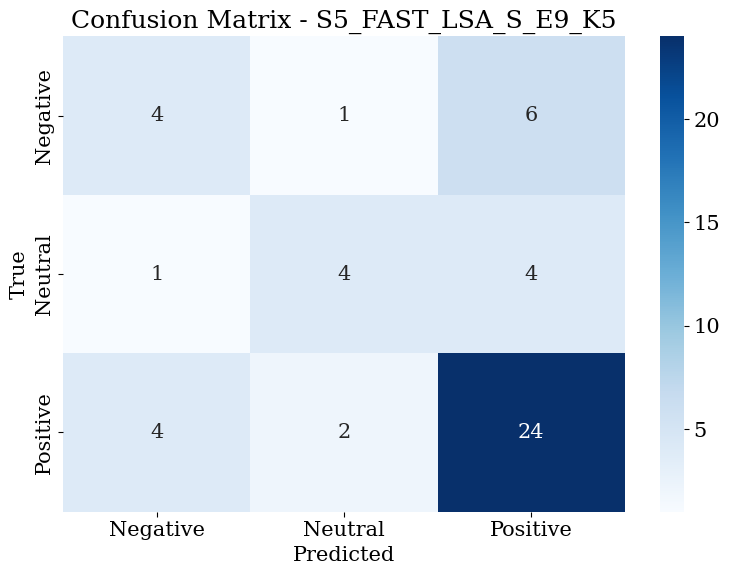

In [ ]:
# ============================================================
# S3: FAST_LSA_S - Epoch=9, K-Fold=5
# ============================================================

scenario = TRAINING_SCENARIOS[2]  # S3
scenario_name = scenario["name"]

results_s5 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 5),
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

### S4

[2026-01-06 08:16:58] (2.4.2) Set Model Device: cuda:0
[2026-01-06 08:16:58] (2.4.2) Device Name: NVIDIA A100-SXM4-80GB


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=3044) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


2026-01-06 08:16:59,558 INFO: PyABSA version: 2.4.2


INFO:fast_lsa_s:PyABSA version: 2.4.2


2026-01-06 08:16:59,560 INFO: Transformers version: 4.57.3


INFO:fast_lsa_s:Transformers version: 4.57.3


2026-01-06 08:16:59,561 INFO: Torch version: 2.9.0+cu126+cuda12.6


INFO:fast_lsa_s:Torch version: 2.9.0+cu126+cuda12.6


2026-01-06 08:16:59,562 INFO: Device: NVIDIA A100-SXM4-80GB


INFO:fast_lsa_s:Device: NVIDIA A100-SXM4-80GB


[2026-01-06 08:16:59] (2.4.2) Try to load ['/content/drive/MyDrive/Output_ABSA/dataset_skenario'] dataset from local disk


/usr/lib/python3.12/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x799cde792d60>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x799cde792e40>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x799cde792270>


2026-01-06 08:17:13,583 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]


preparing dataloader:   2%|▏         | 54/2415 [00:00<00:32, 71.74it/s]sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x799d86ed2f20>

preparing dataloader:   3%|▎         | 62/2415 [00:00<00:40, 57.63it/s]sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x799d86ed3310>

preparing dataloader:   3%|▎         | 76/2415 [00:01<00:44, 52.83it/s]sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x799d86ed31c0>

preparing dataloader:   4%|▍         | 98/2415 [00:01<00:35, 64.57it/s]sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x799d86ed3620>

preparing dataloader:  15%|█▌        | 368/2415 [00:04<00:23, 85.51it/s]sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x799d86ed2dd0>

preparing dataloader: 100%|██████████| 2415/2415 [00:27<00:00, 86.89it/s]


2026-01-06 08:17:42,065 INFO: Dataset Label Details: {'2': 1622, '1': 302, '0': 491, 'Sum': 2415}


INFO:fast_lsa_s:Dataset Label Details: {'2': 1622, '1': 302, '0': 491, 'Sum': 2415}


2026-01-06 08:17:43,651 INFO: train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0

INFO:fast_lsa_s:train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0.8750, 0.8125,

2026-01-06 08:17:44,230 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc
preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 84.38it/s]


2026-01-06 08:17:44,832 INFO: Dataset Label Details: {'2': 30, '1': 9, '0': 11, 'Sum': 50}


INFO:fast_lsa_s:Dataset Label Details: {'2': 30, '1': 9, '0': 11, 'Sum': 50}


2026-01-06 08:17:44,879 INFO: test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.00

INFO:fast_lsa_s:test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.0000, 0.0000, 0.

2026-01-06 08:17:44,881 INFO: valid data examples:
 []


INFO:fast_lsa_s:valid data examples:
 []


2026-01-06 08:17:45,779 INFO: cuda memory allocated:552122880


INFO:fast_lsa_s:cuda memory allocated:552122880


2026-01-06 08:17:45,783 INFO: Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
       

INFO:fast_lsa_s:Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (outp

2026-01-06 08:17:45,785 INFO: ABSADatasetsVersion:None	-->	Calling Count:0


INFO:fast_lsa_s:ABSADatasetsVersion:None	-->	Calling Count:0


2026-01-06 08:17:45,786 INFO: MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x799cdf3785c0>	-->	Calling Count:0


INFO:fast_lsa_s:MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x799cdf3785c0>	-->	Calling Count:0


2026-01-06 08:17:45,788 INFO: PyABSAVersion:2.4.2	-->	Calling Count:1


INFO:fast_lsa_s:PyABSAVersion:2.4.2	-->	Calling Count:1


2026-01-06 08:17:45,789 INFO: SRD:3	-->	Calling Count:2465


INFO:fast_lsa_s:SRD:3	-->	Calling Count:2465


2026-01-06 08:17:45,791 INFO: TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


INFO:fast_lsa_s:TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


2026-01-06 08:17:45,792 INFO: TransformersVersion:4.57.3	-->	Calling Count:1


INFO:fast_lsa_s:TransformersVersion:4.57.3	-->	Calling Count:1


2026-01-06 08:17:45,793 INFO: auto_device:True	-->	Calling Count:3


INFO:fast_lsa_s:auto_device:True	-->	Calling Count:3


2026-01-06 08:17:45,794 INFO: batch_size:16	-->	Calling Count:2


INFO:fast_lsa_s:batch_size:16	-->	Calling Count:2


2026-01-06 08:17:45,796 INFO: cache_dataset:False	-->	Calling Count:1


INFO:fast_lsa_s:cache_dataset:False	-->	Calling Count:1


2026-01-06 08:17:45,797 INFO: checkpoint_save_mode:1	-->	Calling Count:4


INFO:fast_lsa_s:checkpoint_save_mode:1	-->	Calling Count:4


2026-01-06 08:17:45,798 INFO: cross_validate_fold:5	-->	Calling Count:1


INFO:fast_lsa_s:cross_validate_fold:5	-->	Calling Count:1


2026-01-06 08:17:45,800 INFO: dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


INFO:fast_lsa_s:dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


2026-01-06 08:17:45,801 INFO: dataset_name:custom_dataset	-->	Calling Count:3


INFO:fast_lsa_s:dataset_name:custom_dataset	-->	Calling Count:3


2026-01-06 08:17:45,802 INFO: dca_layer:3	-->	Calling Count:0


INFO:fast_lsa_s:dca_layer:3	-->	Calling Count:0


2026-01-06 08:17:45,803 INFO: dca_p:1	-->	Calling Count:0


INFO:fast_lsa_s:dca_p:1	-->	Calling Count:0


2026-01-06 08:17:45,805 INFO: deep_ensemble:False	-->	Calling Count:0


INFO:fast_lsa_s:deep_ensemble:False	-->	Calling Count:0


2026-01-06 08:17:45,806 INFO: device:cuda:0	-->	Calling Count:4


INFO:fast_lsa_s:device:cuda:0	-->	Calling Count:4


2026-01-06 08:17:45,807 INFO: device_name:NVIDIA A100-SXM4-80GB	-->	Calling Count:1


INFO:fast_lsa_s:device_name:NVIDIA A100-SXM4-80GB	-->	Calling Count:1


2026-01-06 08:17:45,808 INFO: dlcf_a:2	-->	Calling Count:0


INFO:fast_lsa_s:dlcf_a:2	-->	Calling Count:0


2026-01-06 08:17:45,809 INFO: dropout:0.1	-->	Calling Count:1


INFO:fast_lsa_s:dropout:0.1	-->	Calling Count:1


2026-01-06 08:17:45,811 INFO: dynamic_truncate:True	-->	Calling Count:4930


INFO:fast_lsa_s:dynamic_truncate:True	-->	Calling Count:4930


2026-01-06 08:17:45,812 INFO: embed_dim:768	-->	Calling Count:7


INFO:fast_lsa_s:embed_dim:768	-->	Calling Count:7


2026-01-06 08:17:45,813 INFO: eta:1	-->	Calling Count:0


INFO:fast_lsa_s:eta:1	-->	Calling Count:0


2026-01-06 08:17:45,814 INFO: eta_lr:0.1	-->	Calling Count:1


INFO:fast_lsa_s:eta_lr:0.1	-->	Calling Count:1


2026-01-06 08:17:45,815 INFO: eval_step:50	-->	Calling Count:0


INFO:fast_lsa_s:eval_step:50	-->	Calling Count:0


2026-01-06 08:17:45,816 INFO: evaluate_begin:0	-->	Calling Count:0


INFO:fast_lsa_s:evaluate_begin:0	-->	Calling Count:0


2026-01-06 08:17:45,817 INFO: from_checkpoint:None	-->	Calling Count:0


INFO:fast_lsa_s:from_checkpoint:None	-->	Calling Count:0


2026-01-06 08:17:45,819 INFO: gradient_accumulation_steps:1	-->	Calling Count:0


INFO:fast_lsa_s:gradient_accumulation_steps:1	-->	Calling Count:0


2026-01-06 08:17:45,820 INFO: hidden_dim:768	-->	Calling Count:0


INFO:fast_lsa_s:hidden_dim:768	-->	Calling Count:0


2026-01-06 08:17:45,821 INFO: index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


INFO:fast_lsa_s:index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


2026-01-06 08:17:45,822 INFO: inference_model:None	-->	Calling Count:0


INFO:fast_lsa_s:inference_model:None	-->	Calling Count:0


2026-01-06 08:17:45,824 INFO: initializer:xavier_uniform_	-->	Calling Count:0


INFO:fast_lsa_s:initializer:xavier_uniform_	-->	Calling Count:0


2026-01-06 08:17:45,825 INFO: inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


INFO:fast_lsa_s:inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


2026-01-06 08:17:45,826 INFO: l2reg:1e-06	-->	Calling Count:2


INFO:fast_lsa_s:l2reg:1e-06	-->	Calling Count:2


2026-01-06 08:17:45,827 INFO: label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


INFO:fast_lsa_s:label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


2026-01-06 08:17:45,828 INFO: lcf:cdw	-->	Calling Count:0


INFO:fast_lsa_s:lcf:cdw	-->	Calling Count:0


2026-01-06 08:17:45,829 INFO: learning_rate:2e-05	-->	Calling Count:1


INFO:fast_lsa_s:learning_rate:2e-05	-->	Calling Count:1


2026-01-06 08:17:45,830 INFO: load_aug:False	-->	Calling Count:1


INFO:fast_lsa_s:load_aug:False	-->	Calling Count:1


2026-01-06 08:17:45,832 INFO: log_step:50	-->	Calling Count:0


INFO:fast_lsa_s:log_step:50	-->	Calling Count:0


2026-01-06 08:17:45,833 INFO: logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


INFO:fast_lsa_s:logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


2026-01-06 08:17:45,834 INFO: lsa:False	-->	Calling Count:0


INFO:fast_lsa_s:lsa:False	-->	Calling Count:0


2026-01-06 08:17:45,835 INFO: max_seq_len:128	-->	Calling Count:22185


INFO:fast_lsa_s:max_seq_len:128	-->	Calling Count:22185


2026-01-06 08:17:45,837 INFO: model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


INFO:fast_lsa_s:model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


2026-01-06 08:17:45,838 INFO: model_name:fast_lsa_s	-->	Calling Count:7397


INFO:fast_lsa_s:model_name:fast_lsa_s	-->	Calling Count:7397


2026-01-06 08:17:45,839 INFO: model_path_to_save:checkpoints	-->	Calling Count:0


INFO:fast_lsa_s:model_path_to_save:checkpoints	-->	Calling Count:0


2026-01-06 08:17:45,840 INFO: num_epoch:11	-->	Calling Count:0


INFO:fast_lsa_s:num_epoch:11	-->	Calling Count:0


2026-01-06 08:17:45,841 INFO: optimizer:adamw	-->	Calling Count:1


INFO:fast_lsa_s:optimizer:adamw	-->	Calling Count:1


2026-01-06 08:17:45,843 INFO: output_dim:3	-->	Calling Count:3


INFO:fast_lsa_s:output_dim:3	-->	Calling Count:3


2026-01-06 08:17:45,844 INFO: overwrite_cache:False	-->	Calling Count:0


INFO:fast_lsa_s:overwrite_cache:False	-->	Calling Count:0


2026-01-06 08:17:45,845 INFO: path_to_save:None	-->	Calling Count:1


INFO:fast_lsa_s:path_to_save:None	-->	Calling Count:1


2026-01-06 08:17:45,847 INFO: patience:99999	-->	Calling Count:0


INFO:fast_lsa_s:patience:99999	-->	Calling Count:0


2026-01-06 08:17:45,848 INFO: pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


INFO:fast_lsa_s:pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


2026-01-06 08:17:45,849 INFO: save_mode:1	-->	Calling Count:0


INFO:fast_lsa_s:save_mode:1	-->	Calling Count:0


2026-01-06 08:17:45,851 INFO: seed:42	-->	Calling Count:7


INFO:fast_lsa_s:seed:42	-->	Calling Count:7


2026-01-06 08:17:45,852 INFO: sigma:0.3	-->	Calling Count:0


INFO:fast_lsa_s:sigma:0.3	-->	Calling Count:0


2026-01-06 08:17:45,854 INFO: similarity_threshold:1	-->	Calling Count:2


INFO:fast_lsa_s:similarity_threshold:1	-->	Calling Count:2


2026-01-06 08:17:45,855 INFO: spacy_model:en_core_web_sm	-->	Calling Count:3


INFO:fast_lsa_s:spacy_model:en_core_web_sm	-->	Calling Count:3


2026-01-06 08:17:45,856 INFO: srd_alignment:True	-->	Calling Count:2465


INFO:fast_lsa_s:srd_alignment:True	-->	Calling Count:2465


2026-01-06 08:17:45,857 INFO: task_code:APC	-->	Calling Count:1


INFO:fast_lsa_s:task_code:APC	-->	Calling Count:1


2026-01-06 08:17:45,858 INFO: task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


INFO:fast_lsa_s:task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


2026-01-06 08:17:45,859 INFO: tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Callin

INFO:fast_lsa_s:tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Calling Count:0


2026-01-06 08:17:45,861 INFO: train_test_split:False	-->	Calling Count:0


INFO:fast_lsa_s:train_test_split:False	-->	Calling Count:0


2026-01-06 08:17:45,862 INFO: use_amp:False	-->	Calling Count:1


INFO:fast_lsa_s:use_amp:False	-->	Calling Count:1


2026-01-06 08:17:45,864 INFO: use_bert_spc:True	-->	Calling Count:0


INFO:fast_lsa_s:use_bert_spc:True	-->	Calling Count:0


2026-01-06 08:17:45,865 INFO: use_syntax_based_SRD:False	-->	Calling Count:0


INFO:fast_lsa_s:use_syntax_based_SRD:False	-->	Calling Count:0


2026-01-06 08:17:45,866 INFO: warmup_proportion:0.1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_proportion:0.1	-->	Calling Count:0


2026-01-06 08:17:45,867 INFO: warmup_step:-1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_step:-1	-->	Calling Count:0


2026-01-06 08:17:45,869 INFO: window:lr	-->	Calling Count:0


INFO:fast_lsa_s:window:lr	-->	Calling Count:0


2026-01-06 08:17:45,871 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 08:17:45,872 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 08:17:45,874 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 08:17:45,876 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 08:17:45,877 INFO: Num steps = 77


INFO:fast_lsa_s:Num steps = 77


2026-01-06 08:17:45,878 INFO: No. 1 trainer in 5 folds


INFO:fast_lsa_s:No. 1 trainer in 5 folds
Epoch:0 | Loss:0:   0%|          | 0/121 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
Epoch:  0 | Smooth Loss: 0.7598:  40%|████      | 49/121 [00:05<00:06, 10.79it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.6481:  82%|████████▏ | 99/121 [00:12<00:02, 10.68it/s, Dev Acc:81.20(max:81.20) Dev F1:51.90(max:51.90)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a futur

2026-01-06 08:20:35,714 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]              │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286] │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
╘════════════════════╧════════════╧═════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
---------------------------------

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]              │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286] │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
╘════════════════════╧════════════╧═════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
--------------------------------- https://githu

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_91.74_f1_82.73/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.74_f1_82.73/_0.0012599341571331024/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.74_f1_82.73/_0.21779751777648926/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.74_f1_82.73/_0.00298899644985795/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.74_f1_82.73/_0.00265466864220798/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.74_f1_82.73/_0.003761822823435068/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.74_f1_82.73/_0.010245546698570251/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.74_f1_82.73/_0.009217862039804459/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.74_f1_82.73/_0.0020666182972490788/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_91.74

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 08:20:36,071 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 08:20:36,072 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 08:20:36,074 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 08:20:36,075 INFO: Num steps = 77


INFO:fast_lsa_s:Num steps = 77


2026-01-06 08:20:36,076 INFO: No. 2 trainer in 5 folds


INFO:fast_lsa_s:No. 2 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.1383:  40%|███▉      | 48/121 [00:04<00:06, 10.81it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1392:  81%|████████  | 98/121 [00:11<00:02, 10.78it/s, Dev Acc:99.38(max:99.38) Dev F1:99.17(max:99.17)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1391: 100%|██████████| 121/121 [00:14<00:00,  8.15it/s, Dev Acc:98.76(max:99.3

2026-01-06 08:23:19,319 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]              │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286] │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]              │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286] │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.0]     

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.38_f1_99.17/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.38_f1_99.17/_0.0007774671539664268/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.38_f1_99.17/_0.10585936903953552/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.38_f1_99.17/_0.3794374167919159/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.38_f1_99.17/_0.0040979161858558655/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.38_f1_99.17/_0.0017027840949594975/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.38_f1_99.17/_0.00140793074388057/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.38_f1_99.17/_0.08171775937080383/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.38_f1_99.17/_0.0014135787496343255/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.38

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 08:23:19,675 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 08:23:19,676 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 08:23:19,677 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 08:23:19,679 INFO: Num steps = 77


INFO:fast_lsa_s:Num steps = 77


2026-01-06 08:23:19,680 INFO: No. 3 trainer in 5 folds


INFO:fast_lsa_s:No. 3 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.0917:  40%|███▉      | 48/121 [00:04<00:06, 10.74it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0922:  81%|████████  | 98/121 [00:11<00:02, 10.80it/s, Dev Acc:95.66(max:95.66) Dev F1:93.88(max:93.88)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0923: 100%|██████████| 121/121 [00:15<00:00,  7.72it/s, Dev Acc:97.52(max:97.5

2026-01-06 08:26:05,005 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]              │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286] │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]              │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286] │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.0]     

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.0/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.0/_0.002335927914828062/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.0/_0.0031138777267187834/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.0/_0.0019150596344843507/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.0/_0.002537989988923073/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.0/_0.002918145153671503/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.0/_0.004538302775472403/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.0/_0.0027453494258224964/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.0/_0.00141599727794528/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 08:26:05,404 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 08:26:05,406 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 08:26:05,407 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 08:26:05,408 INFO: Num steps = 77


INFO:fast_lsa_s:Num steps = 77


2026-01-06 08:26:05,409 INFO: No. 4 trainer in 5 folds


INFO:fast_lsa_s:No. 4 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.0749:  40%|███▉      | 48/121 [00:04<00:06, 10.84it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0751:  81%|████████  | 98/121 [00:11<00:02, 10.77it/s, Dev Acc:99.59(max:99.59) Dev F1:99.26(max:99.26)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0752: 100%|██████████| 121/121 [00:14<00:00,  8.14it/s, Dev Acc:97.31(max:99.5

2026-01-06 08:28:48,797 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]               │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286]  │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]               │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286]  │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/_0.04813350364565849/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/_0.002574693411588669/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/_0.1229948177933693/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/_0.004148933570832014/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/_0.0011131117353215814/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/_0.001486024702899158/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/_0.0040006693452596664/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.26/_0.0023843622766435146/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.5

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 08:28:49,152 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 08:28:49,154 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 08:28:49,155 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 08:28:49,156 INFO: Num steps = 77


INFO:fast_lsa_s:Num steps = 77


2026-01-06 08:28:49,157 INFO: No. 5 trainer in 5 folds


INFO:fast_lsa_s:No. 5 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.0653:  40%|███▉      | 48/121 [00:04<00:06, 10.78it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0654:  81%|████████  | 98/121 [00:11<00:02, 10.68it/s, Dev Acc:98.33(max:98.33) Dev F1:96.91(max:96.91)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0654: 100%|██████████| 121/121 [00:15<00:00,  8.06it/s, Dev Acc:98.12(max:98.3

2026-01-06 08:31:35,213 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]               │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286]  │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [62.0]               │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [51.15047233468286]  │  51.1505  │ 51.1505  │   0   │   0   │ 51.1505 │ 51.1505 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.0048203133046627045/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.009541843086481094/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.0036141143646091223/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.000596387661062181/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.001990346238017082/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.0010409130482003093/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.0271372701972723/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.009392431937158108/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.

INFO:fast_lsa_s:
----------------------------------------------------------------------------- Raw Metric Records -----------------------------------------------------------------------------
╒════════════════════╤══════════════════════════════════════════════════════════╤══════════════════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial                                                    │ Values                           │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪══════════════════════════════════════════════════════════╪══════════════════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s                                               │ [62.0]                           │    62     │    62    │   0   │   0   │   62    │   62    │
├────────────────────┼──────────────────────────────────────────────────────────┼───────────────────────

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.0048203133046627045/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.009541843086481094/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.0036141143646091223/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.000596387661062181/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.001990346238017082/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.0010409130482003093/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.0271372701972723/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.009392431937158108/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.

/usr/local/lib/python3.12/dist-packages/pyabsa/framework/trainer_class/trainer_template.py:250: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/logs/fast_lsa_s_20260106 081601/trainer.log' mode='a' encoding='utf8'>
  self.config.logger.removeHandler(self.config.logger.handlers[0])


[2026-01-06 08:32:44] (2.4.2) Load sentiment classifier from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S4_FAST_LSA_S_E11_K5/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S4_FAST_LSA_S_E11_K5/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S4_FAST_LSA_S_E11_K5/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.0048203133046627045/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S4_FAST_LSA_S_E11_K5/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.009541843086481094/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S4_FAST_LSA_S_E11_K5/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.0036141143646091223/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S4_FAST_LSA_S_E11_K5/fast_lsa_s_custom_dataset_acc_98.96_f1_98.14/_0.000596387661062181/fast_lsa_s.state_dict'

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



OVERALL RESULTS
Accuracy : 0.64
Precision: 0.6167
Recall   : 0.64
F1-Score : 0.6192

CLASSIFICATION REPORT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


              precision    recall  f1-score   support

    Negative       0.50      0.36      0.42        11
     Neutral       0.50      0.33      0.40         9
    Positive       0.69      0.83      0.76        30

    accuracy                           0.64        50
   macro avg       0.56      0.51      0.53        50
weighted avg       0.62      0.64      0.62        50



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



PER-ASPECT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                            Aspect  Samples  Accuracy     F1
                      Transparansi       10       0.6 0.4500
                     Fleksibilitas       10       0.8 0.7529
                Kompetensi Menteri       10       0.6 0.5867
                      Keterwakilan       10       0.5 0.5558
Kebijakan dan Pelayanan Pemerintah       10       0.7 0.6782

PER-SENTIMENT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Negative Precision: 0.5 Recall: 0.3636 F1: 0.4211


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Neutral Precision: 0.5 Recall: 0.3333 F1: 0.4


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Positive Precision: 0.6944 Recall: 0.8333 F1: 0.7576


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


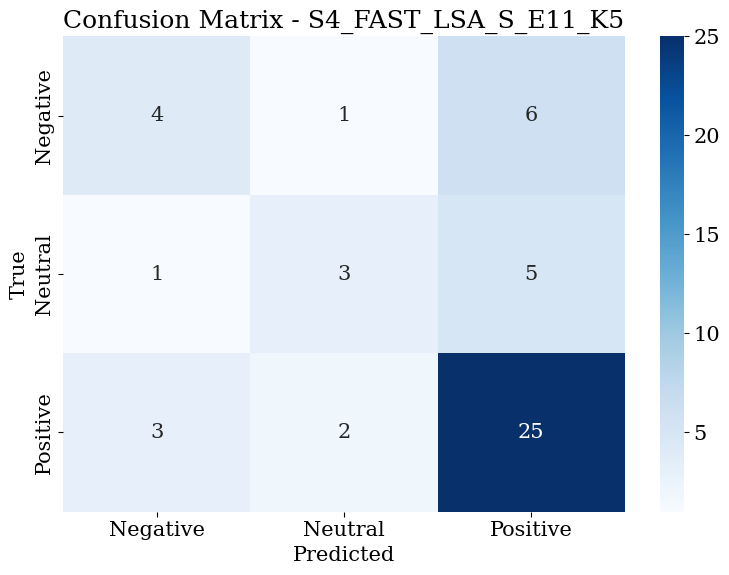

NameError: name 'gc' is not defined

In [ ]:
# ============================================================
# S4: FAST_LSA_S - Epoch=11, K-Fold=5
# ============================================================

scenario = TRAINING_SCENARIOS[3]  # S4
scenario_name = scenario["name"]

results_s5 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 5),
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

### S5

[2026-01-03 16:41:31] (2.4.2) Set Model Device: cuda:0
[2026-01-03 16:41:31] (2.4.2) Device Name: NVIDIA L4


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1438) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


2026-01-03 16:41:31,863 INFO: PyABSA version: 2.4.2


INFO:fast_lsa_s:PyABSA version: 2.4.2


2026-01-03 16:41:31,865 INFO: Transformers version: 4.57.3


INFO:fast_lsa_s:Transformers version: 4.57.3


2026-01-03 16:41:31,866 INFO: Torch version: 2.9.0+cu126+cuda12.6


INFO:fast_lsa_s:Torch version: 2.9.0+cu126+cuda12.6


2026-01-03 16:41:31,868 INFO: Device: NVIDIA L4


INFO:fast_lsa_s:Device: NVIDIA L4


[2026-01-03 16:41:31] (2.4.2) Try to load ['/content/drive/MyDrive/Output_ABSA/dataset_skenario'] dataset from local disk


/usr/lib/python3.12/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


2026-01-03 16:41:34,922 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc
preparing dataloader: 100%|██████████| 2415/2415 [00:27<00:00, 87.27it/s]


2026-01-03 16:42:02,619 INFO: Dataset Label Details: {'1': 302, '0': 491, '2': 1622, 'Sum': 2415}


INFO:fast_lsa_s:Dataset Label Details: {'1': 302, '0': 491, '2': 1622, 'Sum': 2415}


2026-01-03 16:42:03,635 INFO: train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0

INFO:fast_lsa_s:train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0.8750, 0.8125,

2026-01-03 16:42:04,205 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc
preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 84.10it/s]


2026-01-03 16:42:04,806 INFO: Dataset Label Details: {'1': 9, '0': 11, '2': 30, 'Sum': 50}


INFO:fast_lsa_s:Dataset Label Details: {'1': 9, '0': 11, '2': 30, 'Sum': 50}


2026-01-03 16:42:04,851 INFO: test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.00

INFO:fast_lsa_s:test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.0000, 0.0000, 0.

2026-01-03 16:42:04,853 INFO: valid data examples:
 []


INFO:fast_lsa_s:valid data examples:
 []


2026-01-03 16:42:05,575 INFO: cuda memory allocated:571128320


INFO:fast_lsa_s:cuda memory allocated:571128320


2026-01-03 16:42:05,579 INFO: Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
       

INFO:fast_lsa_s:Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (outp

2026-01-03 16:42:05,581 INFO: ABSADatasetsVersion:None	-->	Calling Count:0


INFO:fast_lsa_s:ABSADatasetsVersion:None	-->	Calling Count:0


2026-01-03 16:42:05,582 INFO: MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7d8f05380da0>	-->	Calling Count:0


INFO:fast_lsa_s:MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7d8f05380da0>	-->	Calling Count:0


2026-01-03 16:42:05,584 INFO: PyABSAVersion:2.4.2	-->	Calling Count:1


INFO:fast_lsa_s:PyABSAVersion:2.4.2	-->	Calling Count:1


2026-01-03 16:42:05,585 INFO: SRD:3	-->	Calling Count:2465


INFO:fast_lsa_s:SRD:3	-->	Calling Count:2465


2026-01-03 16:42:05,586 INFO: TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


INFO:fast_lsa_s:TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


2026-01-03 16:42:05,588 INFO: TransformersVersion:4.57.3	-->	Calling Count:1


INFO:fast_lsa_s:TransformersVersion:4.57.3	-->	Calling Count:1


2026-01-03 16:42:05,589 INFO: auto_device:True	-->	Calling Count:3


INFO:fast_lsa_s:auto_device:True	-->	Calling Count:3


2026-01-03 16:42:05,590 INFO: batch_size:16	-->	Calling Count:2


INFO:fast_lsa_s:batch_size:16	-->	Calling Count:2


2026-01-03 16:42:05,592 INFO: cache_dataset:False	-->	Calling Count:1


INFO:fast_lsa_s:cache_dataset:False	-->	Calling Count:1


2026-01-03 16:42:05,593 INFO: checkpoint_save_mode:1	-->	Calling Count:4


INFO:fast_lsa_s:checkpoint_save_mode:1	-->	Calling Count:4


2026-01-03 16:42:05,594 INFO: cross_validate_fold:10	-->	Calling Count:1


INFO:fast_lsa_s:cross_validate_fold:10	-->	Calling Count:1


2026-01-03 16:42:05,595 INFO: dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


INFO:fast_lsa_s:dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


2026-01-03 16:42:05,597 INFO: dataset_name:custom_dataset	-->	Calling Count:3


INFO:fast_lsa_s:dataset_name:custom_dataset	-->	Calling Count:3


2026-01-03 16:42:05,598 INFO: dca_layer:3	-->	Calling Count:0


INFO:fast_lsa_s:dca_layer:3	-->	Calling Count:0


2026-01-03 16:42:05,599 INFO: dca_p:1	-->	Calling Count:0


INFO:fast_lsa_s:dca_p:1	-->	Calling Count:0


2026-01-03 16:42:05,600 INFO: deep_ensemble:False	-->	Calling Count:0


INFO:fast_lsa_s:deep_ensemble:False	-->	Calling Count:0


2026-01-03 16:42:05,602 INFO: device:cuda:0	-->	Calling Count:4


INFO:fast_lsa_s:device:cuda:0	-->	Calling Count:4


2026-01-03 16:42:05,603 INFO: device_name:NVIDIA L4	-->	Calling Count:1


INFO:fast_lsa_s:device_name:NVIDIA L4	-->	Calling Count:1


2026-01-03 16:42:05,604 INFO: dlcf_a:2	-->	Calling Count:0


INFO:fast_lsa_s:dlcf_a:2	-->	Calling Count:0


2026-01-03 16:42:05,606 INFO: dropout:0.1	-->	Calling Count:1


INFO:fast_lsa_s:dropout:0.1	-->	Calling Count:1


2026-01-03 16:42:05,607 INFO: dynamic_truncate:True	-->	Calling Count:4930


INFO:fast_lsa_s:dynamic_truncate:True	-->	Calling Count:4930


2026-01-03 16:42:05,608 INFO: embed_dim:768	-->	Calling Count:7


INFO:fast_lsa_s:embed_dim:768	-->	Calling Count:7


2026-01-03 16:42:05,610 INFO: eta:1	-->	Calling Count:0


INFO:fast_lsa_s:eta:1	-->	Calling Count:0


2026-01-03 16:42:05,611 INFO: eta_lr:0.1	-->	Calling Count:1


INFO:fast_lsa_s:eta_lr:0.1	-->	Calling Count:1


2026-01-03 16:42:05,612 INFO: eval_step:50	-->	Calling Count:0


INFO:fast_lsa_s:eval_step:50	-->	Calling Count:0


2026-01-03 16:42:05,614 INFO: evaluate_begin:0	-->	Calling Count:0


INFO:fast_lsa_s:evaluate_begin:0	-->	Calling Count:0


2026-01-03 16:42:05,615 INFO: from_checkpoint:None	-->	Calling Count:0


INFO:fast_lsa_s:from_checkpoint:None	-->	Calling Count:0


2026-01-03 16:42:05,616 INFO: gradient_accumulation_steps:1	-->	Calling Count:0


INFO:fast_lsa_s:gradient_accumulation_steps:1	-->	Calling Count:0


2026-01-03 16:42:05,618 INFO: hidden_dim:768	-->	Calling Count:0


INFO:fast_lsa_s:hidden_dim:768	-->	Calling Count:0


2026-01-03 16:42:05,619 INFO: index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


INFO:fast_lsa_s:index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


2026-01-03 16:42:05,620 INFO: inference_model:None	-->	Calling Count:0


INFO:fast_lsa_s:inference_model:None	-->	Calling Count:0


2026-01-03 16:42:05,622 INFO: initializer:xavier_uniform_	-->	Calling Count:0


INFO:fast_lsa_s:initializer:xavier_uniform_	-->	Calling Count:0


2026-01-03 16:42:05,623 INFO: inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


INFO:fast_lsa_s:inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


2026-01-03 16:42:05,625 INFO: l2reg:1e-06	-->	Calling Count:2


INFO:fast_lsa_s:l2reg:1e-06	-->	Calling Count:2


2026-01-03 16:42:05,626 INFO: label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


INFO:fast_lsa_s:label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


2026-01-03 16:42:05,627 INFO: lcf:cdw	-->	Calling Count:0


INFO:fast_lsa_s:lcf:cdw	-->	Calling Count:0


2026-01-03 16:42:05,629 INFO: learning_rate:2e-05	-->	Calling Count:1


INFO:fast_lsa_s:learning_rate:2e-05	-->	Calling Count:1


2026-01-03 16:42:05,630 INFO: load_aug:False	-->	Calling Count:1


INFO:fast_lsa_s:load_aug:False	-->	Calling Count:1


2026-01-03 16:42:05,631 INFO: log_step:50	-->	Calling Count:0


INFO:fast_lsa_s:log_step:50	-->	Calling Count:0


2026-01-03 16:42:05,633 INFO: logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


INFO:fast_lsa_s:logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


2026-01-03 16:42:05,634 INFO: lsa:False	-->	Calling Count:0


INFO:fast_lsa_s:lsa:False	-->	Calling Count:0


2026-01-03 16:42:05,635 INFO: max_seq_len:128	-->	Calling Count:22185


INFO:fast_lsa_s:max_seq_len:128	-->	Calling Count:22185


2026-01-03 16:42:05,636 INFO: model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


INFO:fast_lsa_s:model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


2026-01-03 16:42:05,637 INFO: model_name:fast_lsa_s	-->	Calling Count:7397


INFO:fast_lsa_s:model_name:fast_lsa_s	-->	Calling Count:7397


2026-01-03 16:42:05,639 INFO: model_path_to_save:checkpoints	-->	Calling Count:0


INFO:fast_lsa_s:model_path_to_save:checkpoints	-->	Calling Count:0


2026-01-03 16:42:05,640 INFO: num_epoch:5	-->	Calling Count:0


INFO:fast_lsa_s:num_epoch:5	-->	Calling Count:0


2026-01-03 16:42:05,641 INFO: optimizer:adamw	-->	Calling Count:1


INFO:fast_lsa_s:optimizer:adamw	-->	Calling Count:1


2026-01-03 16:42:05,642 INFO: output_dim:3	-->	Calling Count:3


INFO:fast_lsa_s:output_dim:3	-->	Calling Count:3


2026-01-03 16:42:05,643 INFO: overwrite_cache:False	-->	Calling Count:0


INFO:fast_lsa_s:overwrite_cache:False	-->	Calling Count:0


2026-01-03 16:42:05,644 INFO: path_to_save:None	-->	Calling Count:1


INFO:fast_lsa_s:path_to_save:None	-->	Calling Count:1


2026-01-03 16:42:05,645 INFO: patience:99999	-->	Calling Count:0


INFO:fast_lsa_s:patience:99999	-->	Calling Count:0


2026-01-03 16:42:05,647 INFO: pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


INFO:fast_lsa_s:pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


2026-01-03 16:42:05,648 INFO: save_mode:1	-->	Calling Count:0


INFO:fast_lsa_s:save_mode:1	-->	Calling Count:0


2026-01-03 16:42:05,649 INFO: seed:42	-->	Calling Count:7


INFO:fast_lsa_s:seed:42	-->	Calling Count:7


2026-01-03 16:42:05,650 INFO: sigma:0.3	-->	Calling Count:0


INFO:fast_lsa_s:sigma:0.3	-->	Calling Count:0


2026-01-03 16:42:05,652 INFO: similarity_threshold:1	-->	Calling Count:2


INFO:fast_lsa_s:similarity_threshold:1	-->	Calling Count:2


2026-01-03 16:42:05,654 INFO: spacy_model:en_core_web_sm	-->	Calling Count:3


INFO:fast_lsa_s:spacy_model:en_core_web_sm	-->	Calling Count:3


2026-01-03 16:42:05,655 INFO: srd_alignment:True	-->	Calling Count:2465


INFO:fast_lsa_s:srd_alignment:True	-->	Calling Count:2465


2026-01-03 16:42:05,656 INFO: task_code:APC	-->	Calling Count:1


INFO:fast_lsa_s:task_code:APC	-->	Calling Count:1


2026-01-03 16:42:05,658 INFO: task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


INFO:fast_lsa_s:task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


2026-01-03 16:42:05,659 INFO: tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Callin

INFO:fast_lsa_s:tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Calling Count:0


2026-01-03 16:42:05,661 INFO: train_test_split:False	-->	Calling Count:0


INFO:fast_lsa_s:train_test_split:False	-->	Calling Count:0


2026-01-03 16:42:05,662 INFO: use_amp:False	-->	Calling Count:1


INFO:fast_lsa_s:use_amp:False	-->	Calling Count:1


2026-01-03 16:42:05,664 INFO: use_bert_spc:True	-->	Calling Count:0


INFO:fast_lsa_s:use_bert_spc:True	-->	Calling Count:0


2026-01-03 16:42:05,665 INFO: use_syntax_based_SRD:False	-->	Calling Count:0


INFO:fast_lsa_s:use_syntax_based_SRD:False	-->	Calling Count:0


2026-01-03 16:42:05,667 INFO: warmup_proportion:0.1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_proportion:0.1	-->	Calling Count:0


2026-01-03 16:42:05,668 INFO: warmup_step:-1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_step:-1	-->	Calling Count:0


2026-01-03 16:42:05,669 INFO: window:lr	-->	Calling Count:0


INFO:fast_lsa_s:window:lr	-->	Calling Count:0


2026-01-03 16:42:05,672 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 16:42:05,673 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 16:42:05,674 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 16:42:05,675 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 16:42:05,676 INFO: Num steps = 40


INFO:fast_lsa_s:Num steps = 40


2026-01-03 16:42:05,678 INFO: No. 1 trainer in 10 folds


INFO:fast_lsa_s:No. 1 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.7620:  36%|███▌      | 49/136 [00:10<00:18,  4.62it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.6498:  73%|███████▎  | 99/136 [00:23<00:07,  4.74it/s, Dev Acc:80.17(max:80.17) Dev F1:49.56(max:49.56)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.5869: 100%|██████████| 136/136 [00:33<00:00,  4.10it/s, Dev Acc:85.54(max:85.

2026-01-03 16:44:52,693 INFO: 
---------------------------------------------- Raw Metric Records ----------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═══════╤═══════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │  Min  │  Max  │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═══════╪═══════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]              │    64     │    64    │   0   │   0   │  64   │  64   │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼───────┼───────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003] │   45.81   │  45.81   │   0   │   0   │ 45.81 │ 45.81 │
╘════════════════════╧════════════╧═════════════════════╧═══════════╧══════════╧═══════╧═══════╧═══════╧═══════╛
------------------------------- https://github.com/yangheng95/met

INFO:fast_lsa_s:
---------------------------------------------- Raw Metric Records ----------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═══════╤═══════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │  Min  │  Max  │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═══════╪═══════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]              │    64     │    64    │   0   │   0   │  64   │  64   │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼───────┼───────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003] │   45.81   │  45.81   │   0   │   0   │ 45.81 │ 45.81 │
╘════════════════════╧════════════╧═════════════════════╧═══════════╧══════════╧═══════╧═══════╧═══════╧═══════╛
------------------------------- https://github.com/yangheng95/metric_visualizer

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_93.39_f1_83.92/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_93.39_f1_83.92/_0.027082746848464012/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_93.39_f1_83.92/_0.01749110221862793/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_93.39_f1_83.92/_0.05128346383571625/fast_lsa_s.state_dict'] found, only return the shortest path: <checkpoints/fast_lsa_s_custom_dataset_acc_93.39_f1_83.92/fast_lsa_s.state_dict>
2026-01-03 16:44:53,059 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 16:44:53,060 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 16:44:53,062 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 16:44:53,063 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 16:44:53,064 INFO: Num steps = 40


INFO:fast_lsa_s:Num steps = 40


2026-01-03 16:44:53,065 INFO: No. 2 trainer in 10 folds


INFO:fast_lsa_s:No. 2 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.2370:  36%|███▌      | 49/136 [00:10<00:18,  4.82it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.2283:  73%|███████▎  | 99/136 [00:22<00:07,  4.74it/s, Dev Acc:98.35(max:98.35) Dev F1:97.89(max:97.89)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.2240: 100%|██████████| 136/136 [00:31<00:00,  4.27it/s, Dev Acc:94.63(max:98.

2026-01-03 16:47:34,725 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.89/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.89/_0.017719624564051628/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.89/_0.014314062893390656/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.89/_0.0030527785420417786/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.89/_0.09070184081792831/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.89/_0.002640564227476716/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.89/_0.03425062447786331/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.89/_0.01680317148566246/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.89/_0.26612618565559387/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 16:47:35,081 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 16:47:35,082 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 16:47:35,084 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 16:47:35,085 INFO: Num steps = 40


INFO:fast_lsa_s:Num steps = 40


2026-01-03 16:47:35,086 INFO: No. 3 trainer in 10 folds


INFO:fast_lsa_s:No. 3 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.1509:  36%|███▌      | 49/136 [00:10<00:18,  4.81it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1486:  73%|███████▎  | 99/136 [00:22<00:07,  4.80it/s, Dev Acc:98.76(max:98.76) Dev F1:98.43(max:98.43)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1470: 100%|██████████| 136/136 [00:31<00:00,  4.29it/s, Dev Acc:98.76(max:98.

2026-01-03 16:50:17,011 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.43/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.43/_0.01292641181498766/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.43/_0.015310883522033691/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.43/_0.5502802729606628/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.43/_0.0175965316593647/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.43/_0.03189374879002571/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.43/_0.023918628692626953/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.43/_0.015119556337594986/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.43/_0.0028845767956227064/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 16:50:17,369 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 16:50:17,371 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 16:50:17,372 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 16:50:17,373 INFO: Num steps = 40


INFO:fast_lsa_s:Num steps = 40


2026-01-03 16:50:17,375 INFO: No. 4 trainer in 10 folds


INFO:fast_lsa_s:No. 4 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.1175:  36%|███▌      | 49/136 [00:10<00:18,  4.77it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1182:  73%|███████▎  | 99/136 [00:22<00:07,  4.80it/s, Dev Acc:99.17(max:99.17) Dev F1:98.59(max:98.59)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1185: 100%|██████████| 136/136 [00:31<00:00,  4.26it/s, Dev Acc:97.93(max:99.

2026-01-03 16:52:59,142 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.59/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.59/_0.007187493145465851/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.59/_0.007003271020948887/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.59/_0.011005452834069729/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.59/_0.19198700785636902/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.59/_0.16828206181526184/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.59/_0.002706605475395918/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.59/_0.007634246256202459/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.59/_0.018903901800513268/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 16:52:59,488 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 16:52:59,489 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 16:52:59,490 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 16:52:59,492 INFO: Num steps = 40


INFO:fast_lsa_s:Num steps = 40


2026-01-03 16:52:59,493 INFO: No. 5 trainer in 10 folds


INFO:fast_lsa_s:No. 5 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.1034:  36%|███▌      | 49/136 [00:10<00:18,  4.81it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1030:  73%|███████▎  | 99/136 [00:22<00:07,  4.82it/s, Dev Acc:97.52(max:97.52) Dev F1:96.57(max:96.57)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1036: 100%|██████████| 136/136 [00:31<00:00,  4.29it/s, Dev Acc:97.52(max:97.

2026-01-03 16:55:42,116 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.1/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.1/_0.001251620939001441/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.1/_0.008904024958610535/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.1/_0.0033741334918886423/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.1/_0.0075407978147268295/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.1/_0.081453338265419/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.1/_0.008798105642199516/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.1/_0.040083181113004684/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.1/_0.007638756651431322/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_97.93_f1_97.1/

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 16:55:42,474 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 16:55:42,476 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 16:55:42,477 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 16:55:42,478 INFO: Num steps = 40


INFO:fast_lsa_s:Num steps = 40


2026-01-03 16:55:42,479 INFO: No. 6 trainer in 10 folds


INFO:fast_lsa_s:No. 6 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0928:  36%|███▌      | 49/136 [00:10<00:18,  4.77it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0923:  73%|███████▎  | 99/136 [00:22<00:07,  4.72it/s, Dev Acc:97.52(max:97.52) Dev F1:96.83(max:96.83)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0928: 100%|██████████| 136/136 [00:32<00:00,  4.15it/s, Dev Acc:97.93(max:97.

2026-01-03 16:58:27,126 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.84/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.84/_0.0197895560413599/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.84/_0.0031508340034633875/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.84/_0.004046051297336817/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.84/_0.0024570454843342304/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.84/_0.001691984012722969/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.84/_0.6729689836502075/fast_lsa_s.state_dict'] found, only return the shortest path: <checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.84/fast_lsa_s.state_dict>
2026-01-03 16:58:27,492 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 16:58:27,494 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 16:58:27,495 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 16:58:27,497 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 16:58:27,498 INFO: Num steps = 40


INFO:fast_lsa_s:Num steps = 40


2026-01-03 16:58:27,500 INFO: No. 7 trainer in 10 folds


INFO:fast_lsa_s:No. 7 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0863:  36%|███▌      | 49/136 [00:10<00:18,  4.78it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0857:  73%|███████▎  | 99/136 [00:22<00:07,  4.79it/s, Dev Acc:99.59(max:99.59) Dev F1:99.16(max:99.16)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0857: 100%|██████████| 136/136 [00:31<00:00,  4.27it/s, Dev Acc:98.35(max:99.

2026-01-03 17:01:10,318 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.001967652700841427/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.05125313624739647/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.003007005201652646/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0012829634360969067/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.00449388287961483/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0025686752051115036/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0008414613548666239/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0053162784315645695/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_10

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 17:01:10,686 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 17:01:10,688 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 17:01:10,689 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 17:01:10,690 INFO: Num steps = 40


INFO:fast_lsa_s:Num steps = 40


2026-01-03 17:01:10,692 INFO: No. 8 trainer in 10 folds


INFO:fast_lsa_s:No. 8 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0790:  36%|███▌      | 49/136 [00:10<00:18,  4.79it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0784:  73%|███████▎  | 99/136 [00:22<00:07,  4.79it/s, Dev Acc:99.59(max:99.59) Dev F1:99.09(max:99.09)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0784: 100%|██████████| 136/136 [00:31<00:00,  4.27it/s, Dev Acc:99.17(max:99.

2026-01-03 17:03:52,551 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.003567246487364173/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.015802178531885147/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.004486816003918648/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.3536463677883148/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.002463808050379157/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.02429082617163658/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.005374914035201073/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.06142107769846916/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 17:03:52,905 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 17:03:52,907 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 17:03:52,909 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 17:03:52,910 INFO: Num steps = 40


INFO:fast_lsa_s:Num steps = 40


2026-01-03 17:03:52,911 INFO: No. 9 trainer in 10 folds


INFO:fast_lsa_s:No. 9 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0737:  36%|███▌      | 49/136 [00:10<00:18,  4.81it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0733:  73%|███████▎  | 99/136 [00:22<00:07,  4.78it/s, Dev Acc:98.76(max:98.76) Dev F1:98.04(max:98.04)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0731: 100%|██████████| 136/136 [00:31<00:00,  4.27it/s, Dev Acc:98.76(max:98.

2026-01-03 17:06:34,830 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.04/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.04/_0.0058683715760707855/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.04/_0.009366517886519432/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.04/_0.01094585657119751/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.04/_0.0018233328592032194/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.04/_0.00224892795085907/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.04/_0.046783510595560074/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.04/_0.38036996126174927/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.04/_0.0028806193731725216/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.7

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 17:06:35,178 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 17:06:35,180 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 17:06:35,181 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 17:06:35,182 INFO: Num steps = 40


INFO:fast_lsa_s:Num steps = 40


2026-01-03 17:06:35,183 INFO: No. 10 trainer in 10 folds


INFO:fast_lsa_s:No. 10 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0690:  36%|███▌      | 49/137 [00:10<00:18,  4.78it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0688:  72%|███████▏  | 99/137 [00:22<00:07,  4.80it/s, Dev Acc:99.58(max:99.58) Dev F1:99.09(max:99.09)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0686: 100%|██████████| 137/137 [00:32<00:00,  4.28it/s, Dev Acc:99.58(max:99

2026-01-03 17:09:19,179 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [45.80997949419003]  │   45.81   │  45.81   │   0   │   0   │  45.81  │  45.81  │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1/_0.017316244542598724/fast_lsa_s.state_dict'] found, only return the shortest path: <checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1/fast_lsa_s.state_dict>
2026-01-03 17:09:19,543 INFO: 
----------------------------------------------------------------------------- Raw Metric Records -----------------------------------------------------------------------------
╒════════════════════╤══════════════════════════════════════════════════════════╤═════════════════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial                                                    │ Values                          │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪══════════════════════════════════════════════════════════╪══════════════════════

INFO:fast_lsa_s:
----------------------------------------------------------------------------- Raw Metric Records -----------------------------------------------------------------------------
╒════════════════════╤══════════════════════════════════════════════════════════╤═════════════════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial                                                    │ Values                          │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪══════════════════════════════════════════════════════════╪═════════════════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s                                               │ [64.0]                          │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼──────────────────────────────────────────────────────────┼───────────────────────────

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1/_0.017316244542598724/fast_lsa_s.state_dict'] found, only return the shortest path: <checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1/fast_lsa_s.state_dict>


/usr/local/lib/python3.12/dist-packages/pyabsa/framework/trainer_class/trainer_template.py:250: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/logs/fast_lsa_s_20260103 130350/trainer.log' mode='a' encoding='utf8'>
  self.config.logger.removeHandler(self.config.logger.handlers[0])


[2026-01-03 17:09:28] (2.4.2) Load sentiment classifier from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S2_FAST_LSA_S_E5_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S2_FAST_LSA_S_E5_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S2_FAST_LSA_S_E5_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1/_0.017316244542598724/fast_lsa_s.state_dict'] found, only return the shortest path: <drive/MyDrive/Output_ABSA/checkpoints_skenario/S2_FAST_LSA_S_E5_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1/fast_lsa_s.state_dict>
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S2_FAST_LSA_S_E5_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1/fast_lsa_s.tokenizer', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S2_FAST_LSA_S_E5_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1/_0.017316244542598724

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



OVERALL RESULTS
Accuracy : 0.68
Precision: 0.69
Recall   : 0.68
F1-Score : 0.6687

CLASSIFICATION REPORT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


              precision    recall  f1-score   support

    Negative       0.83      0.45      0.59        11
     Neutral       0.50      0.44      0.47         9
    Positive       0.69      0.83      0.76        30

    accuracy                           0.68        50
   macro avg       0.68      0.58      0.61        50
weighted avg       0.69      0.68      0.67        50



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



PER-ASPECT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                            Aspect  Samples  Accuracy     F1
                      Keterwakilan       10       0.6 0.6667
                     Fleksibilitas       10       0.8 0.7667
Kebijakan dan Pelayanan Pemerintah       10       0.7 0.6815
                Kompetensi Menteri       10       0.7 0.7067
                      Transparansi       10       0.6 0.4500

PER-SENTIMENT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Negative Precision: 0.8333 Recall: 0.4545 F1: 0.5882


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Neutral Precision: 0.5 Recall: 0.4444 F1: 0.4706


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Positive Precision: 0.6944 Recall: 0.8333 F1: 0.7576


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


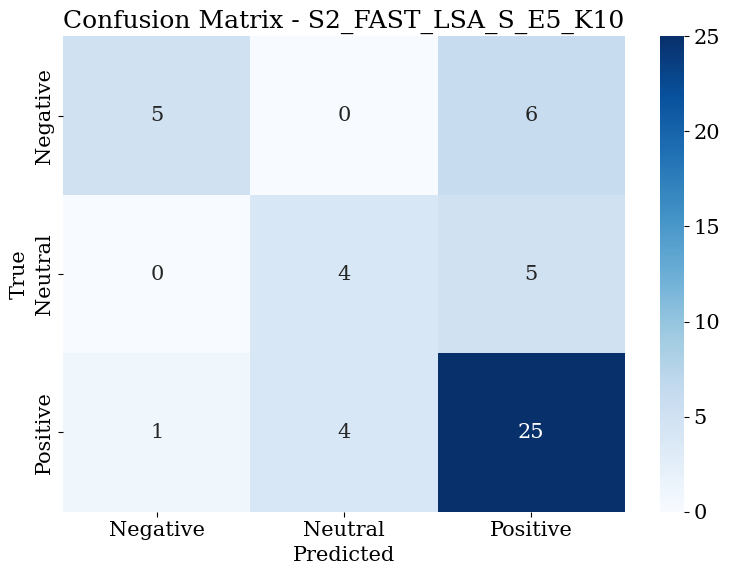

ValueError: too many values to unpack (expected 2)

In [ ]:
scenario = TRAINING_SCENARIOS[1]
scenario_name = scenario["name"]

results_s2 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=10,
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

[2026-01-03 17:11:33] (2.4.2) Load sentiment classifier from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S2_FAST_LSA_S_E5_K10
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S2_FAST_LSA_S_E5_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S2_FAST_LSA_S_E5_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1/_0.017316244542598724/fast_lsa_s.state_dict'] found, only return the shortest path: <drive/MyDrive/Output_ABSA/checkpoints_skenario/S2_FAST_LSA_S_E5_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1/fast_lsa_s.state_dict>
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S2_FAST_LSA_S_E5_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1/fast_lsa_s.tokenizer', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S2_FAST_LSA_S_E5_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.1/_0.017316244542598724/fast_lsa_s.tokenizer'] found, only return t

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



OVERALL RESULTS
Accuracy : 0.68
Precision: 0.69
Recall   : 0.68
F1-score : 0.6686631016042781

CLASSIFICATION REPORT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


              precision    recall  f1-score   support

    Negative       0.83      0.45      0.59        11
     Neutral       0.50      0.44      0.47         9
    Positive       0.69      0.83      0.76        30

    accuracy                           0.68        50
   macro avg       0.68      0.58      0.61        50
weighted avg       0.69      0.68      0.67        50


PER-ASPECT METRICS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Aspect : Fleksibilitas
Samples: 10
Acc    : 0.8000
F1     : 0.7667


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Aspect : Kebijakan dan Pelayanan Pemerintah
Samples: 10
Acc    : 0.7000
F1     : 0.6815


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Aspect : Keterwakilan
Samples: 10
Acc    : 0.6000
F1     : 0.6667


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Aspect : Kompetensi Menteri
Samples: 10
Acc    : 0.7000
F1     : 0.7067


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Aspect : Transparansi
Samples: 10
Acc    : 0.6000
F1     : 0.4500


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



PER-ASPECT SUMMARY TABLE


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                                    samples  accuracy  f1_score
Fleksibilitas                            10       0.8  0.766667
Kebijakan dan Pelayanan Pemerintah       10       0.7  0.681538
Keterwakilan                             10       0.6  0.666667
Kompetensi Menteri                       10       0.7  0.706667
Transparansi                             10       0.6  0.450000

PER-SENTIMENT METRICS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Sentiment: Negative
Samples  : 11
Precision: 0.8333
Recall   : 0.4545
F1       : 0.5882


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Sentiment: Neutral
Samples  : 9
Precision: 0.5000
Recall   : 0.4444
F1       : 0.4706


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Sentiment: Positive
Samples  : 30
Precision: 0.6944
Recall   : 0.8333
F1       : 0.7576


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


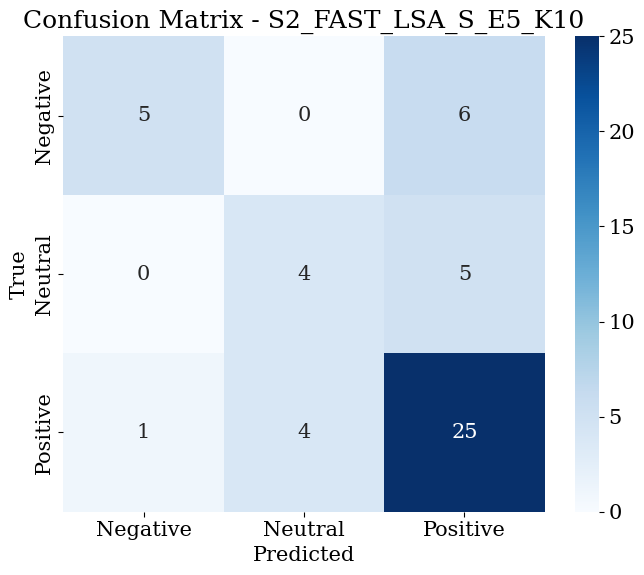


RESULTS SAVED TO:
/content/drive/MyDrive/Output_ABSA/results_skenario/S2_FAST_LSA_S_E5_K10_results.json


In [ ]:
from pyabsa import APCCheckpointManager
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import gc
import torch

scenario_name = "S2_FAST_LSA_S_E5_K10"
model_name = "FAST_LSA_S"

checkpoint_path = "/content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S2_FAST_LSA_S_E5_K10"
RESULTS_DIR = "/content/drive/MyDrive/Output_ABSA/results_skenario"
FIG_DIR = "/content/drive/MyDrive/Output_ABSA/figures_skenario"

Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)
Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

trained_model = APCCheckpointManager.get_sentiment_classifier(
    checkpoint=checkpoint_path,
    auto_device=True
)

print("Model loaded from checkpoint")

true_labels = []
pred_labels = []
aspects_list = []

id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}

for sample in final_test_data:
    text = sample["text"]
    aspect = sample["aspect"]
    true_sentiment = id2label[int(sample["sentiment"])]

    try:
        pred = trained_model.predict(text, aspect=aspect, print_result=False)
        pred_id = int(pred["sentiment"][0])
        pred_sentiment = id2label[pred_id]
    except:
        pred_sentiment = "Neutral"

    true_labels.append(true_sentiment)
    pred_labels.append(pred_sentiment)
    aspects_list.append(aspect)

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average="weighted", zero_division=0)
recall = recall_score(true_labels, pred_labels, average="weighted", zero_division=0)
f1 = f1_score(true_labels, pred_labels, average="weighted", zero_division=0)

print("\nOVERALL RESULTS")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)

print("\nCLASSIFICATION REPORT")
print(classification_report(true_labels, pred_labels, zero_division=0))

print("\nPER-ASPECT METRICS")

aspect_metrics = {}

for asp in sorted(set(aspects_list)):
    asp_true = [true_labels[i] for i in range(len(aspects_list)) if aspects_list[i] == asp]
    asp_pred = [pred_labels[i] for i in range(len(aspects_list)) if aspects_list[i] == asp]

    asp_acc = accuracy_score(asp_true, asp_pred)
    asp_f1 = f1_score(asp_true, asp_pred, average="weighted", zero_division=0)

    aspect_metrics[asp] = {
        "samples": len(asp_true),
        "accuracy": asp_acc,
        "f1_score": asp_f1
    }

    print(f"\nAspect : {asp}")
    print(f"Samples: {len(asp_true)}")
    print(f"Acc    : {asp_acc:.4f}")
    print(f"F1     : {asp_f1:.4f}")

asp_df = pd.DataFrame.from_dict(aspect_metrics, orient="index")
print("\nPER-ASPECT SUMMARY TABLE")
print(asp_df)

print("\nPER-SENTIMENT METRICS")

sentiment_metrics = {}

for sent in ["Negative", "Neutral", "Positive"]:
    sent_true = [1 if t == sent else 0 for t in true_labels]
    sent_pred = [1 if p == sent else 0 for p in pred_labels]

    if sum(sent_true) > 0:
        sentiment_metrics[sent] = {
            "samples": sum(sent_true),
            "precision": precision_score(sent_true, sent_pred, zero_division=0),
            "recall": recall_score(sent_true, sent_pred, zero_division=0),
            "f1": f1_score(sent_true, sent_pred, zero_division=0)
        }

        print(f"\nSentiment: {sent}")
        print(f"Samples  : {sum(sent_true)}")
        print(f"Precision: {sentiment_metrics[sent]['precision']:.4f}")
        print(f"Recall   : {sentiment_metrics[sent]['recall']:.4f}")
        print(f"F1       : {sentiment_metrics[sent]['f1']:.4f}")

cm = confusion_matrix(
    true_labels, pred_labels,
    labels=["Negative", "Neutral", "Positive"]
)

df_cm = pd.DataFrame(
    cm,
    index=["Negative", "Neutral", "Positive"],
    columns=["Negative", "Neutral", "Positive"]
)

plt.figure(figsize=(7,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {scenario_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()

cm_path = f"{FIG_DIR}/confusion_matrix_{scenario_name}.png"
plt.savefig(cm_path, dpi=150)
plt.show()

results = {
    "scenario": scenario_name,
    "model": model_name,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "checkpoint_path": checkpoint_path,
    "per_aspect": aspect_metrics,
    "per_sentiment": sentiment_metrics
}

results_path = f"{RESULTS_DIR}/{scenario_name}_results.json"
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print("\nRESULTS SAVED TO:")
print(results_path)

del trained_model
gc.collect()
torch.cuda.empty_cache()

### S6

[2026-01-03 17:34:05] (2.4.2) Set Model Device: cuda:0
[2026-01-03 17:34:05] (2.4.2) Device Name: NVIDIA L4


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1438) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


2026-01-03 17:34:05,542 INFO: PyABSA version: 2.4.2


INFO:fast_lsa_s:PyABSA version: 2.4.2


2026-01-03 17:34:05,544 INFO: Transformers version: 4.57.3


INFO:fast_lsa_s:Transformers version: 4.57.3


2026-01-03 17:34:05,546 INFO: Torch version: 2.9.0+cu126+cuda12.6


INFO:fast_lsa_s:Torch version: 2.9.0+cu126+cuda12.6


2026-01-03 17:34:05,548 INFO: Device: NVIDIA L4


INFO:fast_lsa_s:Device: NVIDIA L4


[2026-01-03 17:34:05] (2.4.2) Try to load ['/content/drive/MyDrive/Output_ABSA/dataset_skenario'] dataset from local disk


/usr/lib/python3.12/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


2026-01-03 17:34:09,909 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc
preparing dataloader: 100%|██████████| 2415/2415 [00:30<00:00, 79.30it/s]


2026-01-03 17:34:40,384 INFO: Dataset Label Details: {'1': 302, '0': 491, '2': 1622, 'Sum': 2415}


INFO:fast_lsa_s:Dataset Label Details: {'1': 302, '0': 491, '2': 1622, 'Sum': 2415}


2026-01-03 17:34:41,497 INFO: train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0

INFO:fast_lsa_s:train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0.8750, 0.8125,

2026-01-03 17:34:42,113 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc
preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 77.84it/s]


2026-01-03 17:34:42,763 INFO: Dataset Label Details: {'1': 9, '0': 11, '2': 30, 'Sum': 50}


INFO:fast_lsa_s:Dataset Label Details: {'1': 9, '0': 11, '2': 30, 'Sum': 50}


2026-01-03 17:34:42,813 INFO: test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.00

INFO:fast_lsa_s:test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.0000, 0.0000, 0.

2026-01-03 17:34:42,816 INFO: valid data examples:
 []


INFO:fast_lsa_s:valid data examples:
 []


2026-01-03 17:34:43,579 INFO: cuda memory allocated:571128320


INFO:fast_lsa_s:cuda memory allocated:571128320


2026-01-03 17:34:43,584 INFO: Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
       

INFO:fast_lsa_s:Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (outp

2026-01-03 17:34:43,586 INFO: ABSADatasetsVersion:None	-->	Calling Count:0


INFO:fast_lsa_s:ABSADatasetsVersion:None	-->	Calling Count:0


2026-01-03 17:34:43,587 INFO: MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7d8e4ebef8f0>	-->	Calling Count:0


INFO:fast_lsa_s:MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7d8e4ebef8f0>	-->	Calling Count:0


2026-01-03 17:34:43,589 INFO: PyABSAVersion:2.4.2	-->	Calling Count:1


INFO:fast_lsa_s:PyABSAVersion:2.4.2	-->	Calling Count:1


2026-01-03 17:34:43,591 INFO: SRD:3	-->	Calling Count:2465


INFO:fast_lsa_s:SRD:3	-->	Calling Count:2465


2026-01-03 17:34:43,592 INFO: TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


INFO:fast_lsa_s:TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


2026-01-03 17:34:43,594 INFO: TransformersVersion:4.57.3	-->	Calling Count:1


INFO:fast_lsa_s:TransformersVersion:4.57.3	-->	Calling Count:1


2026-01-03 17:34:43,595 INFO: auto_device:True	-->	Calling Count:3


INFO:fast_lsa_s:auto_device:True	-->	Calling Count:3


2026-01-03 17:34:43,596 INFO: batch_size:16	-->	Calling Count:2


INFO:fast_lsa_s:batch_size:16	-->	Calling Count:2


2026-01-03 17:34:43,597 INFO: cache_dataset:False	-->	Calling Count:1


INFO:fast_lsa_s:cache_dataset:False	-->	Calling Count:1


2026-01-03 17:34:43,599 INFO: checkpoint_save_mode:1	-->	Calling Count:4


INFO:fast_lsa_s:checkpoint_save_mode:1	-->	Calling Count:4


2026-01-03 17:34:43,600 INFO: cross_validate_fold:10	-->	Calling Count:1


INFO:fast_lsa_s:cross_validate_fold:10	-->	Calling Count:1


2026-01-03 17:34:43,601 INFO: dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


INFO:fast_lsa_s:dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


2026-01-03 17:34:43,603 INFO: dataset_name:custom_dataset	-->	Calling Count:3


INFO:fast_lsa_s:dataset_name:custom_dataset	-->	Calling Count:3


2026-01-03 17:34:43,604 INFO: dca_layer:3	-->	Calling Count:0


INFO:fast_lsa_s:dca_layer:3	-->	Calling Count:0


2026-01-03 17:34:43,605 INFO: dca_p:1	-->	Calling Count:0


INFO:fast_lsa_s:dca_p:1	-->	Calling Count:0


2026-01-03 17:34:43,607 INFO: deep_ensemble:False	-->	Calling Count:0


INFO:fast_lsa_s:deep_ensemble:False	-->	Calling Count:0


2026-01-03 17:34:43,608 INFO: device:cuda:0	-->	Calling Count:4


INFO:fast_lsa_s:device:cuda:0	-->	Calling Count:4


2026-01-03 17:34:43,610 INFO: device_name:NVIDIA L4	-->	Calling Count:1


INFO:fast_lsa_s:device_name:NVIDIA L4	-->	Calling Count:1


2026-01-03 17:34:43,611 INFO: dlcf_a:2	-->	Calling Count:0


INFO:fast_lsa_s:dlcf_a:2	-->	Calling Count:0


2026-01-03 17:34:43,613 INFO: dropout:0.1	-->	Calling Count:1


INFO:fast_lsa_s:dropout:0.1	-->	Calling Count:1


2026-01-03 17:34:43,614 INFO: dynamic_truncate:True	-->	Calling Count:4930


INFO:fast_lsa_s:dynamic_truncate:True	-->	Calling Count:4930


2026-01-03 17:34:43,616 INFO: embed_dim:768	-->	Calling Count:7


INFO:fast_lsa_s:embed_dim:768	-->	Calling Count:7


2026-01-03 17:34:43,617 INFO: eta:1	-->	Calling Count:0


INFO:fast_lsa_s:eta:1	-->	Calling Count:0


2026-01-03 17:34:43,619 INFO: eta_lr:0.1	-->	Calling Count:1


INFO:fast_lsa_s:eta_lr:0.1	-->	Calling Count:1


2026-01-03 17:34:43,620 INFO: eval_step:50	-->	Calling Count:0


INFO:fast_lsa_s:eval_step:50	-->	Calling Count:0


2026-01-03 17:34:43,622 INFO: evaluate_begin:0	-->	Calling Count:0


INFO:fast_lsa_s:evaluate_begin:0	-->	Calling Count:0


2026-01-03 17:34:43,623 INFO: from_checkpoint:None	-->	Calling Count:0


INFO:fast_lsa_s:from_checkpoint:None	-->	Calling Count:0


2026-01-03 17:34:43,625 INFO: gradient_accumulation_steps:1	-->	Calling Count:0


INFO:fast_lsa_s:gradient_accumulation_steps:1	-->	Calling Count:0


2026-01-03 17:34:43,626 INFO: hidden_dim:768	-->	Calling Count:0


INFO:fast_lsa_s:hidden_dim:768	-->	Calling Count:0


2026-01-03 17:34:43,628 INFO: index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


INFO:fast_lsa_s:index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


2026-01-03 17:34:43,629 INFO: inference_model:None	-->	Calling Count:0


INFO:fast_lsa_s:inference_model:None	-->	Calling Count:0


2026-01-03 17:34:43,630 INFO: initializer:xavier_uniform_	-->	Calling Count:0


INFO:fast_lsa_s:initializer:xavier_uniform_	-->	Calling Count:0


2026-01-03 17:34:43,632 INFO: inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


INFO:fast_lsa_s:inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


2026-01-03 17:34:43,633 INFO: l2reg:1e-06	-->	Calling Count:2


INFO:fast_lsa_s:l2reg:1e-06	-->	Calling Count:2


2026-01-03 17:34:43,634 INFO: label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


INFO:fast_lsa_s:label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


2026-01-03 17:34:43,636 INFO: lcf:cdw	-->	Calling Count:0


INFO:fast_lsa_s:lcf:cdw	-->	Calling Count:0


2026-01-03 17:34:43,637 INFO: learning_rate:2e-05	-->	Calling Count:1


INFO:fast_lsa_s:learning_rate:2e-05	-->	Calling Count:1


2026-01-03 17:34:43,639 INFO: load_aug:False	-->	Calling Count:1


INFO:fast_lsa_s:load_aug:False	-->	Calling Count:1


2026-01-03 17:34:43,640 INFO: log_step:50	-->	Calling Count:0


INFO:fast_lsa_s:log_step:50	-->	Calling Count:0


2026-01-03 17:34:43,642 INFO: logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


INFO:fast_lsa_s:logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


2026-01-03 17:34:43,643 INFO: lsa:False	-->	Calling Count:0


INFO:fast_lsa_s:lsa:False	-->	Calling Count:0


2026-01-03 17:34:43,644 INFO: max_seq_len:128	-->	Calling Count:22185


INFO:fast_lsa_s:max_seq_len:128	-->	Calling Count:22185


2026-01-03 17:34:43,646 INFO: model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


INFO:fast_lsa_s:model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


2026-01-03 17:34:43,647 INFO: model_name:fast_lsa_s	-->	Calling Count:7397


INFO:fast_lsa_s:model_name:fast_lsa_s	-->	Calling Count:7397


2026-01-03 17:34:43,649 INFO: model_path_to_save:checkpoints	-->	Calling Count:0


INFO:fast_lsa_s:model_path_to_save:checkpoints	-->	Calling Count:0


2026-01-03 17:34:43,650 INFO: num_epoch:7	-->	Calling Count:0


INFO:fast_lsa_s:num_epoch:7	-->	Calling Count:0


2026-01-03 17:34:43,652 INFO: optimizer:adamw	-->	Calling Count:1


INFO:fast_lsa_s:optimizer:adamw	-->	Calling Count:1


2026-01-03 17:34:43,653 INFO: output_dim:3	-->	Calling Count:3


INFO:fast_lsa_s:output_dim:3	-->	Calling Count:3


2026-01-03 17:34:43,655 INFO: overwrite_cache:False	-->	Calling Count:0


INFO:fast_lsa_s:overwrite_cache:False	-->	Calling Count:0


2026-01-03 17:34:43,656 INFO: path_to_save:None	-->	Calling Count:1


INFO:fast_lsa_s:path_to_save:None	-->	Calling Count:1


2026-01-03 17:34:43,658 INFO: patience:99999	-->	Calling Count:0


INFO:fast_lsa_s:patience:99999	-->	Calling Count:0


2026-01-03 17:34:43,659 INFO: pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


INFO:fast_lsa_s:pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


2026-01-03 17:34:43,661 INFO: save_mode:1	-->	Calling Count:0


INFO:fast_lsa_s:save_mode:1	-->	Calling Count:0


2026-01-03 17:34:43,662 INFO: seed:42	-->	Calling Count:7


INFO:fast_lsa_s:seed:42	-->	Calling Count:7


2026-01-03 17:34:43,664 INFO: sigma:0.3	-->	Calling Count:0


INFO:fast_lsa_s:sigma:0.3	-->	Calling Count:0


2026-01-03 17:34:43,665 INFO: similarity_threshold:1	-->	Calling Count:2


INFO:fast_lsa_s:similarity_threshold:1	-->	Calling Count:2


2026-01-03 17:34:43,666 INFO: spacy_model:en_core_web_sm	-->	Calling Count:3


INFO:fast_lsa_s:spacy_model:en_core_web_sm	-->	Calling Count:3


2026-01-03 17:34:43,668 INFO: srd_alignment:True	-->	Calling Count:2465


INFO:fast_lsa_s:srd_alignment:True	-->	Calling Count:2465


2026-01-03 17:34:43,669 INFO: task_code:APC	-->	Calling Count:1


INFO:fast_lsa_s:task_code:APC	-->	Calling Count:1


2026-01-03 17:34:43,671 INFO: task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


INFO:fast_lsa_s:task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


2026-01-03 17:34:43,672 INFO: tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Callin

INFO:fast_lsa_s:tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Calling Count:0


2026-01-03 17:34:43,674 INFO: train_test_split:False	-->	Calling Count:0


INFO:fast_lsa_s:train_test_split:False	-->	Calling Count:0


2026-01-03 17:34:43,676 INFO: use_amp:False	-->	Calling Count:1


INFO:fast_lsa_s:use_amp:False	-->	Calling Count:1


2026-01-03 17:34:43,677 INFO: use_bert_spc:True	-->	Calling Count:0


INFO:fast_lsa_s:use_bert_spc:True	-->	Calling Count:0


2026-01-03 17:34:43,679 INFO: use_syntax_based_SRD:False	-->	Calling Count:0


INFO:fast_lsa_s:use_syntax_based_SRD:False	-->	Calling Count:0


2026-01-03 17:34:43,680 INFO: warmup_proportion:0.1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_proportion:0.1	-->	Calling Count:0


2026-01-03 17:34:43,682 INFO: warmup_step:-1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_step:-1	-->	Calling Count:0


2026-01-03 17:34:43,683 INFO: window:lr	-->	Calling Count:0


INFO:fast_lsa_s:window:lr	-->	Calling Count:0


2026-01-03 17:34:43,686 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 17:34:43,687 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 17:34:43,689 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 17:34:43,690 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 17:34:43,692 INFO: Num steps = 56


INFO:fast_lsa_s:Num steps = 56


2026-01-03 17:34:43,693 INFO: No. 1 trainer in 10 folds


INFO:fast_lsa_s:No. 1 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.7620:  36%|███▌      | 49/136 [00:10<00:18,  4.77it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.6498:  73%|███████▎  | 99/136 [00:22<00:07,  4.72it/s, Dev Acc:80.17(max:80.17) Dev F1:49.56(max:49.56)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.5869: 100%|██████████| 136/136 [00:33<00:00,  4.09it/s, Dev Acc:85.54(max:85.

2026-01-03 17:38:39,006 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
╘════════════════════╧════════════╧══════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
--------------------------

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
╘════════════════════╧════════════╧══════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
---------------------------------- https

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_93.39_f1_83.92/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_93.39_f1_83.92/_0.00649420078843832/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_93.39_f1_83.92/_0.009373488835990429/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_93.39_f1_83.92/_0.00506038311868906/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_93.39_f1_83.92/_0.027082746848464012/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_93.39_f1_83.92/_0.00996087770909071/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_93.39_f1_83.92/_0.040947623550891876/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_93.39_f1_83.92/_0.01749110221862793/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_93.39_f1_83.92/_0.015143794938921928/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_93.39_f1

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 17:38:39,446 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 17:38:39,447 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 17:38:39,449 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 17:38:39,450 INFO: Num steps = 56


INFO:fast_lsa_s:Num steps = 56


2026-01-03 17:38:39,452 INFO: No. 2 trainer in 10 folds


INFO:fast_lsa_s:No. 2 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.1901:  36%|███▌      | 49/136 [00:10<00:18,  4.77it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1848:  73%|███████▎  | 99/136 [00:22<00:07,  4.78it/s, Dev Acc:98.35(max:98.35) Dev F1:97.46(max:97.46)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1822: 100%|██████████| 136/136 [00:32<00:00,  4.23it/s, Dev Acc:97.52(max:98.

2026-01-03 17:42:30,047 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.3/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.3/_0.07921402156352997/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.3/_0.01823459193110466/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.3/_0.0643215924501419/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.3/_0.0030447356402873993/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.3/_0.018416402861475945/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.3/_0.03520114719867706/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.3/_0.03478185832500458/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.3/_0.06177379935979843/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.3/_0.00

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 17:42:30,499 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 17:42:30,501 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 17:42:30,502 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 17:42:30,504 INFO: Num steps = 56


INFO:fast_lsa_s:Num steps = 56


2026-01-03 17:42:30,505 INFO: No. 3 trainer in 10 folds


INFO:fast_lsa_s:No. 3 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.1224:  36%|███▌      | 49/136 [00:10<00:18,  4.80it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1209:  73%|███████▎  | 99/136 [00:22<00:07,  4.75it/s, Dev Acc:99.17(max:99.17) Dev F1:98.97(max:98.97)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1203: 100%|██████████| 136/136 [00:32<00:00,  4.23it/s, Dev Acc:98.76(max:99.

2026-01-03 17:46:20,000 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.97/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.97/_0.004912068601697683/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.97/_0.0016168453730642796/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.97/_0.004610382951796055/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.97/_0.003331732004880905/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.97/_0.017698954790830612/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.97/_0.003689183620736003/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.97/_0.1338149607181549/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.97/_0.002917179139330983/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 17:46:20,474 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 17:46:20,475 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 17:46:20,477 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 17:46:20,479 INFO: Num steps = 56


INFO:fast_lsa_s:Num steps = 56


2026-01-03 17:46:20,480 INFO: No. 4 trainer in 10 folds


INFO:fast_lsa_s:No. 4 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0964:  36%|███▌      | 49/136 [00:10<00:18,  4.76it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0955:  73%|███████▎  | 99/136 [00:22<00:07,  4.80it/s, Dev Acc:98.76(max:98.76) Dev F1:98.49(max:98.49)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0963: 100%|██████████| 136/136 [00:33<00:00,  4.10it/s, Dev Acc:99.17(max:99.

2026-01-03 17:50:12,404 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.53/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.53/_0.0005586630431935191/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.53/_0.01085443515330553/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.53/_0.038979701697826385/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.53/_0.004074108321219683/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.53/_0.10921838879585266/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.53/_0.5759568214416504/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.53/_0.0019844896160066128/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.53/_0.001799873192794621/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 17:50:12,877 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 17:50:12,878 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 17:50:12,880 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 17:50:12,881 INFO: Num steps = 56


INFO:fast_lsa_s:Num steps = 56


2026-01-03 17:50:12,882 INFO: No. 5 trainer in 10 folds


INFO:fast_lsa_s:No. 5 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0822:  36%|███▌      | 49/136 [00:10<00:18,  4.77it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0819:  73%|███████▎  | 99/136 [00:22<00:07,  4.73it/s, Dev Acc:99.59(max:99.59) Dev F1:99.20(max:99.20)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0813: 100%|██████████| 136/136 [00:32<00:00,  4.23it/s, Dev Acc:98.76(max:99.

2026-01-03 17:54:02,448 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.2/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.2/_0.0030175831634551287/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.2/_0.052516188472509384/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.2/_0.00633547268807888/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.2/_0.005900249816477299/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.2/_0.024460338056087494/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.2/_0.027233507484197617/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.2/_0.01594753935933113/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.2/_0.0026338715106248856/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.2

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 17:54:02,893 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 17:54:02,894 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 17:54:02,895 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 17:54:02,897 INFO: Num steps = 56


INFO:fast_lsa_s:Num steps = 56


2026-01-03 17:54:02,898 INFO: No. 6 trainer in 10 folds


INFO:fast_lsa_s:No. 6 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0725:  36%|███▌      | 49/136 [00:10<00:18,  4.76it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0723:  73%|███████▎  | 99/136 [00:22<00:07,  4.79it/s, Dev Acc:99.59(max:99.59) Dev F1:99.44(max:99.44)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0722: 100%|██████████| 136/136 [00:32<00:00,  4.23it/s, Dev Acc:94.21(max:99.

2026-01-03 17:57:52,645 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/_0.0055265408009290695/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/_0.003163487883284688/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/_0.11456272751092911/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/_0.002040140563622117/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/_0.005259861703962088/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/_0.0012009171769022942/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/_0.02506176196038723/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/_0.0019913790747523308/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 17:57:53,089 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 17:57:53,090 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 17:57:53,091 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 17:57:53,092 INFO: Num steps = 56


INFO:fast_lsa_s:Num steps = 56


2026-01-03 17:57:53,093 INFO: No. 7 trainer in 10 folds


INFO:fast_lsa_s:No. 7 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0667:  36%|███▌      | 49/136 [00:10<00:18,  4.80it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0663:  73%|███████▎  | 99/136 [00:22<00:07,  4.79it/s, Dev Acc:99.59(max:99.59) Dev F1:99.36(max:99.36)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0663: 100%|██████████| 136/136 [00:33<00:00,  4.11it/s, Dev Acc:100.00(max:10

2026-01-03 18:01:43,501 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.001044900855049491/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.008426851592957973/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.058138128370046616/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.002848094329237938/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.01030550617724657/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0030848030000925064/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.001763031119480729/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.006069905590265989/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 18:01:43,954 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 18:01:43,955 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 18:01:43,956 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 18:01:43,958 INFO: Num steps = 56


INFO:fast_lsa_s:Num steps = 56


2026-01-03 18:01:43,959 INFO: No. 8 trainer in 10 folds


INFO:fast_lsa_s:No. 8 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0610:  36%|███▌      | 49/136 [00:10<00:18,  4.77it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0610:  73%|███████▎  | 99/136 [00:22<00:07,  4.77it/s, Dev Acc:99.59(max:99.59) Dev F1:99.09(max:99.09)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0610: 100%|██████████| 136/136 [00:32<00:00,  4.24it/s, Dev Acc:99.17(max:99.

2026-01-03 18:05:33,567 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0695745050907135/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.00151642388664186/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.2290128618478775/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.006793246604502201/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0012142969062551856/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.008591189980506897/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0035115214996039867/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.005143044516444206/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 18:05:34,013 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 18:05:34,014 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 18:05:34,016 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 18:05:34,017 INFO: Num steps = 56


INFO:fast_lsa_s:Num steps = 56


2026-01-03 18:05:34,018 INFO: No. 9 trainer in 10 folds


INFO:fast_lsa_s:No. 9 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0581:  36%|███▌      | 49/136 [00:10<00:18,  4.78it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0582:  73%|███████▎  | 99/136 [00:22<00:07,  4.77it/s, Dev Acc:99.17(max:99.17) Dev F1:98.68(max:98.68)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0581: 100%|██████████| 136/136 [00:32<00:00,  4.25it/s, Dev Acc:98.35(max:99.

2026-01-03 18:09:24,337 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.71/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.71/_0.3515704274177551/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.71/_0.045658960938453674/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.71/_0.022227386012673378/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.71/_0.00064300891244784/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.71/_0.004543709103018045/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.71/_0.002566804876551032/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.71/_0.09419567137956619/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.71/_0.007408687844872475/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 18:09:24,788 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 18:09:24,789 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 18:09:24,791 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-03 18:09:24,792 INFO: Num steps = 56


INFO:fast_lsa_s:Num steps = 56


2026-01-03 18:09:24,793 INFO: No. 10 trainer in 10 folds


INFO:fast_lsa_s:No. 10 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0561:  36%|███▌      | 49/137 [00:10<00:18,  4.78it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0562:  72%|███████▏  | 99/137 [00:22<00:07,  4.78it/s, Dev Acc:99.58(max:99.58) Dev F1:99.35(max:99.35)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0562: 100%|██████████| 137/137 [00:32<00:00,  4.24it/s, Dev Acc:99.58(max:99

2026-01-03 18:13:14,683 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [66.0]               │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [58.333333333333336] │  58.3333  │ 58.3333  │   0   │   0   │ 58.3333 │ 58.3333 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [64.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.0010501726064831018/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.0006858737906441092/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.16602446138858795/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.0012827935861423612/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.0011188237695023417/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.009036089293658733/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.0013615414500236511/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.0025839400477707386/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc

INFO:fast_lsa_s:
----------------------------------------------------------------------------- Raw Metric Records -----------------------------------------------------------------------------
╒════════════════════╤══════════════════════════════════════════════════════════╤═════════════════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial                                                    │ Values                          │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪══════════════════════════════════════════════════════════╪═════════════════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s                                               │ [66.0]                          │    66     │    66    │   0   │   0   │   66    │   66    │
├────────────────────┼──────────────────────────────────────────────────────────┼───────────────────────────

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.0010501726064831018/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.0006858737906441092/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.16602446138858795/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.0012827935861423612/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.0011188237695023417/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.009036089293658733/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.0013615414500236511/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.0025839400477707386/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc

/usr/local/lib/python3.12/dist-packages/pyabsa/framework/trainer_class/trainer_template.py:250: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/logs/fast_lsa_s_20260103 130350/trainer.log' mode='a' encoding='utf8'>
  self.config.logger.removeHandler(self.config.logger.handlers[0])


[2026-01-03 18:14:05] (2.4.2) Load sentiment classifier from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S4_FAST_LSA_S_E7_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S4_FAST_LSA_S_E7_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S4_FAST_LSA_S_E7_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.0010501726064831018/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S4_FAST_LSA_S_E7_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.0006858737906441092/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S4_FAST_LSA_S_E7_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.16602446138858795/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S4_FAST_LSA_S_E7_K10/fast_lsa_s_custom_dataset_acc_99.58_f1_99.35/_0.0012827935861423612/fast_lsa_s.state_dict'

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



OVERALL RESULTS
Accuracy : 0.64
Precision: 0.6211
Recall   : 0.64
F1-Score : 0.6175

CLASSIFICATION REPORT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


              precision    recall  f1-score   support

    Negative       0.57      0.36      0.44        11
     Neutral       0.50      0.33      0.40         9
    Positive       0.68      0.83      0.75        30

    accuracy                           0.64        50
   macro avg       0.58      0.51      0.53        50
weighted avg       0.62      0.64      0.62        50



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



PER-ASPECT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                            Aspect  Samples  Accuracy     F1
                      Keterwakilan       10       0.6 0.6286
                     Fleksibilitas       10       0.9 0.8529
Kebijakan dan Pelayanan Pemerintah       10       0.6 0.5867
                Kompetensi Menteri       10       0.5 0.4800
                      Transparansi       10       0.6 0.4500

PER-SENTIMENT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Negative Precision: 0.5714 Recall: 0.3636 F1: 0.4444


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Neutral Precision: 0.5 Recall: 0.3333 F1: 0.4


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Positive Precision: 0.6757 Recall: 0.8333 F1: 0.7463


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


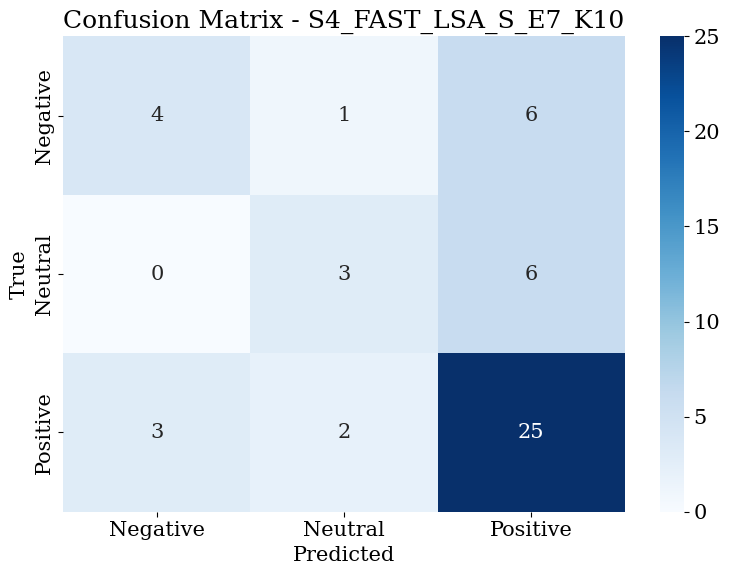

In [ ]:
# ============================================================
# S6: FAST_LSA_S - Epoch=7, K-Fold=10
# ============================================================

scenario = TRAINING_SCENARIOS[5]  # S6
scenario_name = scenario["name"]

results_s4 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 10),
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

### S7

[2026-01-06 10:08:02] (2.4.2) Set Model Device: cuda:0
[2026-01-06 10:08:02] (2.4.2) Device Name: NVIDIA A100-SXM4-80GB


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=3044) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


2026-01-06 10:08:02,996 INFO: PyABSA version: 2.4.2


INFO:fast_lsa_s:PyABSA version: 2.4.2


2026-01-06 10:08:02,998 INFO: Transformers version: 4.57.3


INFO:fast_lsa_s:Transformers version: 4.57.3


2026-01-06 10:08:03,000 INFO: Torch version: 2.9.0+cu126+cuda12.6


INFO:fast_lsa_s:Torch version: 2.9.0+cu126+cuda12.6


2026-01-06 10:08:03,001 INFO: Device: NVIDIA A100-SXM4-80GB


INFO:fast_lsa_s:Device: NVIDIA A100-SXM4-80GB


[2026-01-06 10:08:03] (2.4.2) Try to load ['/content/drive/MyDrive/Output_ABSA/dataset_skenario'] dataset from local disk


/usr/lib/python3.12/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


2026-01-06 10:08:06,930 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc
preparing dataloader: 100%|██████████| 2415/2415 [00:28<00:00, 85.93it/s]


2026-01-06 10:08:35,608 INFO: Dataset Label Details: {'2': 1622, '1': 302, '0': 491, 'Sum': 2415}


INFO:fast_lsa_s:Dataset Label Details: {'2': 1622, '1': 302, '0': 491, 'Sum': 2415}


2026-01-06 10:08:36,618 INFO: train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0

INFO:fast_lsa_s:train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0.8750, 0.8125,

2026-01-06 10:08:37,187 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc
preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 83.87it/s]


2026-01-06 10:08:38,372 INFO: Dataset Label Details: {'2': 30, '1': 9, '0': 11, 'Sum': 50}


INFO:fast_lsa_s:Dataset Label Details: {'2': 30, '1': 9, '0': 11, 'Sum': 50}


2026-01-06 10:08:38,419 INFO: test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.00

INFO:fast_lsa_s:test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.0000, 0.0000, 0.

2026-01-06 10:08:38,422 INFO: valid data examples:
 []


INFO:fast_lsa_s:valid data examples:
 []


2026-01-06 10:08:39,174 INFO: cuda memory allocated:570866176


INFO:fast_lsa_s:cuda memory allocated:570866176


2026-01-06 10:08:39,177 INFO: Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
       

INFO:fast_lsa_s:Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (outp

2026-01-06 10:08:39,179 INFO: ABSADatasetsVersion:None	-->	Calling Count:0


INFO:fast_lsa_s:ABSADatasetsVersion:None	-->	Calling Count:0


2026-01-06 10:08:39,181 INFO: MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x799edb2291f0>	-->	Calling Count:0


INFO:fast_lsa_s:MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x799edb2291f0>	-->	Calling Count:0


2026-01-06 10:08:39,182 INFO: PyABSAVersion:2.4.2	-->	Calling Count:1


INFO:fast_lsa_s:PyABSAVersion:2.4.2	-->	Calling Count:1


2026-01-06 10:08:39,184 INFO: SRD:3	-->	Calling Count:2465


INFO:fast_lsa_s:SRD:3	-->	Calling Count:2465


2026-01-06 10:08:39,186 INFO: TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


INFO:fast_lsa_s:TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


2026-01-06 10:08:39,187 INFO: TransformersVersion:4.57.3	-->	Calling Count:1


INFO:fast_lsa_s:TransformersVersion:4.57.3	-->	Calling Count:1


2026-01-06 10:08:39,188 INFO: auto_device:True	-->	Calling Count:3


INFO:fast_lsa_s:auto_device:True	-->	Calling Count:3


2026-01-06 10:08:39,190 INFO: batch_size:16	-->	Calling Count:2


INFO:fast_lsa_s:batch_size:16	-->	Calling Count:2


2026-01-06 10:08:39,191 INFO: cache_dataset:False	-->	Calling Count:1


INFO:fast_lsa_s:cache_dataset:False	-->	Calling Count:1


2026-01-06 10:08:39,192 INFO: checkpoint_save_mode:1	-->	Calling Count:4


INFO:fast_lsa_s:checkpoint_save_mode:1	-->	Calling Count:4


2026-01-06 10:08:39,194 INFO: cross_validate_fold:10	-->	Calling Count:1


INFO:fast_lsa_s:cross_validate_fold:10	-->	Calling Count:1


2026-01-06 10:08:39,195 INFO: dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


INFO:fast_lsa_s:dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


2026-01-06 10:08:39,197 INFO: dataset_name:custom_dataset	-->	Calling Count:3


INFO:fast_lsa_s:dataset_name:custom_dataset	-->	Calling Count:3


2026-01-06 10:08:39,198 INFO: dca_layer:3	-->	Calling Count:0


INFO:fast_lsa_s:dca_layer:3	-->	Calling Count:0


2026-01-06 10:08:39,199 INFO: dca_p:1	-->	Calling Count:0


INFO:fast_lsa_s:dca_p:1	-->	Calling Count:0


2026-01-06 10:08:39,201 INFO: deep_ensemble:False	-->	Calling Count:0


INFO:fast_lsa_s:deep_ensemble:False	-->	Calling Count:0


2026-01-06 10:08:39,202 INFO: device:cuda:0	-->	Calling Count:4


INFO:fast_lsa_s:device:cuda:0	-->	Calling Count:4


2026-01-06 10:08:39,203 INFO: device_name:NVIDIA A100-SXM4-80GB	-->	Calling Count:1


INFO:fast_lsa_s:device_name:NVIDIA A100-SXM4-80GB	-->	Calling Count:1


2026-01-06 10:08:39,204 INFO: dlcf_a:2	-->	Calling Count:0


INFO:fast_lsa_s:dlcf_a:2	-->	Calling Count:0


2026-01-06 10:08:39,206 INFO: dropout:0.1	-->	Calling Count:1


INFO:fast_lsa_s:dropout:0.1	-->	Calling Count:1


2026-01-06 10:08:39,207 INFO: dynamic_truncate:True	-->	Calling Count:4930


INFO:fast_lsa_s:dynamic_truncate:True	-->	Calling Count:4930


2026-01-06 10:08:39,209 INFO: embed_dim:768	-->	Calling Count:7


INFO:fast_lsa_s:embed_dim:768	-->	Calling Count:7


2026-01-06 10:08:39,210 INFO: eta:1	-->	Calling Count:0


INFO:fast_lsa_s:eta:1	-->	Calling Count:0


2026-01-06 10:08:39,211 INFO: eta_lr:0.1	-->	Calling Count:1


INFO:fast_lsa_s:eta_lr:0.1	-->	Calling Count:1


2026-01-06 10:08:39,212 INFO: eval_step:50	-->	Calling Count:0


INFO:fast_lsa_s:eval_step:50	-->	Calling Count:0


2026-01-06 10:08:39,214 INFO: evaluate_begin:0	-->	Calling Count:0


INFO:fast_lsa_s:evaluate_begin:0	-->	Calling Count:0


2026-01-06 10:08:39,215 INFO: from_checkpoint:None	-->	Calling Count:0


INFO:fast_lsa_s:from_checkpoint:None	-->	Calling Count:0


2026-01-06 10:08:39,216 INFO: gradient_accumulation_steps:1	-->	Calling Count:0


INFO:fast_lsa_s:gradient_accumulation_steps:1	-->	Calling Count:0


2026-01-06 10:08:39,217 INFO: hidden_dim:768	-->	Calling Count:0


INFO:fast_lsa_s:hidden_dim:768	-->	Calling Count:0


2026-01-06 10:08:39,218 INFO: index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


INFO:fast_lsa_s:index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


2026-01-06 10:08:39,220 INFO: inference_model:None	-->	Calling Count:0


INFO:fast_lsa_s:inference_model:None	-->	Calling Count:0


2026-01-06 10:08:39,221 INFO: initializer:xavier_uniform_	-->	Calling Count:0


INFO:fast_lsa_s:initializer:xavier_uniform_	-->	Calling Count:0


2026-01-06 10:08:39,222 INFO: inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


INFO:fast_lsa_s:inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


2026-01-06 10:08:39,224 INFO: l2reg:1e-06	-->	Calling Count:2


INFO:fast_lsa_s:l2reg:1e-06	-->	Calling Count:2


2026-01-06 10:08:39,225 INFO: label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


INFO:fast_lsa_s:label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


2026-01-06 10:08:39,227 INFO: lcf:cdw	-->	Calling Count:0


INFO:fast_lsa_s:lcf:cdw	-->	Calling Count:0


2026-01-06 10:08:39,228 INFO: learning_rate:2e-05	-->	Calling Count:1


INFO:fast_lsa_s:learning_rate:2e-05	-->	Calling Count:1


2026-01-06 10:08:39,229 INFO: load_aug:False	-->	Calling Count:1


INFO:fast_lsa_s:load_aug:False	-->	Calling Count:1


2026-01-06 10:08:39,231 INFO: log_step:50	-->	Calling Count:0


INFO:fast_lsa_s:log_step:50	-->	Calling Count:0


2026-01-06 10:08:39,232 INFO: logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


INFO:fast_lsa_s:logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


2026-01-06 10:08:39,233 INFO: lsa:False	-->	Calling Count:0


INFO:fast_lsa_s:lsa:False	-->	Calling Count:0


2026-01-06 10:08:39,235 INFO: max_seq_len:128	-->	Calling Count:22185


INFO:fast_lsa_s:max_seq_len:128	-->	Calling Count:22185


2026-01-06 10:08:39,236 INFO: model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


INFO:fast_lsa_s:model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


2026-01-06 10:08:39,237 INFO: model_name:fast_lsa_s	-->	Calling Count:7397


INFO:fast_lsa_s:model_name:fast_lsa_s	-->	Calling Count:7397


2026-01-06 10:08:39,238 INFO: model_path_to_save:checkpoints	-->	Calling Count:0


INFO:fast_lsa_s:model_path_to_save:checkpoints	-->	Calling Count:0


2026-01-06 10:08:39,240 INFO: num_epoch:9	-->	Calling Count:0


INFO:fast_lsa_s:num_epoch:9	-->	Calling Count:0


2026-01-06 10:08:39,241 INFO: optimizer:adamw	-->	Calling Count:1


INFO:fast_lsa_s:optimizer:adamw	-->	Calling Count:1


2026-01-06 10:08:39,242 INFO: output_dim:3	-->	Calling Count:3


INFO:fast_lsa_s:output_dim:3	-->	Calling Count:3


2026-01-06 10:08:39,244 INFO: overwrite_cache:False	-->	Calling Count:0


INFO:fast_lsa_s:overwrite_cache:False	-->	Calling Count:0


2026-01-06 10:08:39,245 INFO: path_to_save:None	-->	Calling Count:1


INFO:fast_lsa_s:path_to_save:None	-->	Calling Count:1


2026-01-06 10:08:39,246 INFO: patience:99999	-->	Calling Count:0


INFO:fast_lsa_s:patience:99999	-->	Calling Count:0


2026-01-06 10:08:39,247 INFO: pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


INFO:fast_lsa_s:pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


2026-01-06 10:08:39,248 INFO: save_mode:1	-->	Calling Count:0


INFO:fast_lsa_s:save_mode:1	-->	Calling Count:0


2026-01-06 10:08:39,249 INFO: seed:42	-->	Calling Count:7


INFO:fast_lsa_s:seed:42	-->	Calling Count:7


2026-01-06 10:08:39,251 INFO: sigma:0.3	-->	Calling Count:0


INFO:fast_lsa_s:sigma:0.3	-->	Calling Count:0


2026-01-06 10:08:39,252 INFO: similarity_threshold:1	-->	Calling Count:2


INFO:fast_lsa_s:similarity_threshold:1	-->	Calling Count:2


2026-01-06 10:08:39,253 INFO: spacy_model:en_core_web_sm	-->	Calling Count:3


INFO:fast_lsa_s:spacy_model:en_core_web_sm	-->	Calling Count:3


2026-01-06 10:08:39,254 INFO: srd_alignment:True	-->	Calling Count:2465


INFO:fast_lsa_s:srd_alignment:True	-->	Calling Count:2465


2026-01-06 10:08:39,256 INFO: task_code:APC	-->	Calling Count:1


INFO:fast_lsa_s:task_code:APC	-->	Calling Count:1


2026-01-06 10:08:39,257 INFO: task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


INFO:fast_lsa_s:task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


2026-01-06 10:08:39,258 INFO: tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Callin

INFO:fast_lsa_s:tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Calling Count:0


2026-01-06 10:08:39,260 INFO: train_test_split:False	-->	Calling Count:0


INFO:fast_lsa_s:train_test_split:False	-->	Calling Count:0


2026-01-06 10:08:39,261 INFO: use_amp:False	-->	Calling Count:1


INFO:fast_lsa_s:use_amp:False	-->	Calling Count:1


2026-01-06 10:08:39,262 INFO: use_bert_spc:True	-->	Calling Count:0


INFO:fast_lsa_s:use_bert_spc:True	-->	Calling Count:0


2026-01-06 10:08:39,264 INFO: use_syntax_based_SRD:False	-->	Calling Count:0


INFO:fast_lsa_s:use_syntax_based_SRD:False	-->	Calling Count:0


2026-01-06 10:08:39,265 INFO: warmup_proportion:0.1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_proportion:0.1	-->	Calling Count:0


2026-01-06 10:08:39,266 INFO: warmup_step:-1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_step:-1	-->	Calling Count:0


2026-01-06 10:08:39,267 INFO: window:lr	-->	Calling Count:0


INFO:fast_lsa_s:window:lr	-->	Calling Count:0


2026-01-06 10:08:39,270 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 10:08:39,271 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 10:08:39,272 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 10:08:39,274 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 10:08:39,275 INFO: Num steps = 72


INFO:fast_lsa_s:Num steps = 72


2026-01-06 10:08:39,276 INFO: No. 1 trainer in 10 folds


INFO:fast_lsa_s:No. 1 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.7920:  35%|███▌      | 48/136 [00:04<00:08, 10.75it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.6575:  72%|███████▏  | 98/136 [00:11<00:03, 10.78it/s, Dev Acc:78.10(max:78.10) Dev F1:44.25(max:44.25)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.5891: 100%|██████████| 136/136 [00:16<00:00,  8.16it/s, Dev Acc:84.71(max:84.

2026-01-06 10:11:10,029 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]              │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202] │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
╘════════════════════╧════════════╧═════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
---------------------------------

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]              │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202] │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
╘════════════════════╧════════════╧═════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
--------------------------------- https://githu

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/_0.004744757432490587/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/_0.0027484954334795475/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/_0.010511375963687897/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/_0.10382057726383209/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/_0.006804182659834623/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/_0.004775320179760456/fast_lsa_s.state_dict'] found, only return the shortest path: <checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/fast_lsa_s.state_dict>
2026-01-06 10:11:10,455 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 10:11:10,456 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 10:11:10,458 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 10:11:10,459 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 10:11:10,461 INFO: Num steps = 72


INFO:fast_lsa_s:Num steps = 72


2026-01-06 10:11:10,462 INFO: No. 2 trainer in 10 folds


INFO:fast_lsa_s:No. 2 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.1483:  35%|███▌      | 48/136 [00:04<00:08, 10.78it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1453:  72%|███████▏  | 98/136 [00:10<00:03, 10.78it/s, Dev Acc:97.93(max:97.93) Dev F1:96.29(max:96.29)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1432: 100%|██████████| 136/136 [00:16<00:00,  8.30it/s, Dev Acc:98.35(max:98.

2026-01-06 10:13:36,433 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]              │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202] │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]              │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202] │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.0]     

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.46/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.46/_0.0007009965484030545/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.46/_0.002339006634429097/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.46/_0.007958397269248962/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.46/_0.005144752562046051/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.46/_0.0008670915849506855/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.46/_0.004884246736764908/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.46/_0.018663929775357246/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.46/_0.19252172112464905/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 10:13:36,844 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 10:13:36,845 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 10:13:36,846 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 10:13:36,847 INFO: Num steps = 72


INFO:fast_lsa_s:Num steps = 72


2026-01-06 10:13:36,849 INFO: No. 3 trainer in 10 folds


INFO:fast_lsa_s:No. 3 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0921:  35%|███▌      | 48/136 [00:04<00:08, 10.74it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0905:  72%|███████▏  | 98/136 [00:11<00:03, 10.72it/s, Dev Acc:99.59(max:99.59) Dev F1:99.47(max:99.47)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0897: 100%|██████████| 136/136 [00:16<00:00,  8.27it/s, Dev Acc:100.00(max:10

2026-01-06 10:15:59,938 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]               │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202]  │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]               │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202]  │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0005582374869845808/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.003137140069156885/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.00037088245153427124/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0006131964619271457/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.02053259126842022/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0008799501811154187/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.5804183483123779/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.058330219238996506/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_10

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 10:16:00,345 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 10:16:00,346 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 10:16:00,347 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 10:16:00,349 INFO: Num steps = 72


INFO:fast_lsa_s:Num steps = 72


2026-01-06 10:16:00,350 INFO: No. 4 trainer in 10 folds


INFO:fast_lsa_s:No. 4 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0687:  35%|███▌      | 48/136 [00:04<00:08, 10.77it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0684:  72%|███████▏  | 98/136 [00:11<00:03, 10.68it/s, Dev Acc:100.00(max:100.00) Dev F1:100.00(max:100.00)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0685: 100%|██████████| 136/136 [00:15<00:00,  8.57it/s, Dev Acc:100.00(ma

2026-01-06 10:18:23,034 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]               │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202]  │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]               │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202]  │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0005582374869845808/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.003137140069156885/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.00037088245153427124/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0010058560874313116/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0030954452231526375/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0006131964619271457/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0009438705164939165/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0025988672859966755/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 10:18:23,454 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 10:18:23,456 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 10:18:23,457 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 10:18:23,458 INFO: Num steps = 72


INFO:fast_lsa_s:Num steps = 72


2026-01-06 10:18:23,460 INFO: No. 5 trainer in 10 folds


INFO:fast_lsa_s:No. 5 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0580:  35%|███▌      | 48/136 [00:04<00:08, 10.77it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0577:  73%|███████▎  | 99/136 [00:11<00:03, 10.75it/s, Dev Acc:99.59(max:99.59) Dev F1:99.21(max:99.21)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0574: 100%|██████████| 136/136 [00:15<00:00,  8.69it/s, Dev Acc:98.35(max:99.

2026-01-06 10:20:45,905 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]               │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202]  │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]               │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202]  │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.21/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.21/_0.0005376380868256092/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.21/_0.010482234880328178/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.21/_0.41968220472335815/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.21/_0.007355736568570137/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.21/_0.05176948010921478/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.21/_0.0021710917353630066/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.21/_0.2505817711353302/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.21/_0.09530139714479446/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 10:20:46,312 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 10:20:46,313 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 10:20:46,314 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 10:20:46,315 INFO: Num steps = 72


INFO:fast_lsa_s:Num steps = 72


2026-01-06 10:20:46,317 INFO: No. 6 trainer in 10 folds


INFO:fast_lsa_s:No. 6 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0523:  35%|███▌      | 48/136 [00:04<00:08, 10.76it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0525:  72%|███████▏  | 98/136 [00:11<00:03, 10.73it/s, Dev Acc:99.59(max:99.59) Dev F1:99.44(max:99.44)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0524: 100%|██████████| 136/136 [00:15<00:00,  8.70it/s, Dev Acc:98.76(max:99.

2026-01-06 10:23:09,788 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]               │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202]  │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]               │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202]  │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/_0.0002657875302247703/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/_0.0005715162260457873/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/_0.00336156552657485/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/_0.0007771928212605417/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/_0.0009018921991810203/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/_0.0026307778898626566/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/_0.3510735034942627/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.44/_0.0370616540312767/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.5

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 10:23:10,196 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 10:23:10,198 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 10:23:10,199 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 10:23:10,200 INFO: Num steps = 72


INFO:fast_lsa_s:Num steps = 72


2026-01-06 10:23:10,202 INFO: No. 7 trainer in 10 folds


INFO:fast_lsa_s:No. 7 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0466:  35%|███▌      | 48/136 [00:04<00:08, 10.74it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0466:  73%|███████▎  | 99/136 [00:11<00:03, 10.72it/s, Dev Acc:100.00(max:100.00) Dev F1:100.00(max:100.00)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0469: 100%|██████████| 136/136 [00:15<00:00,  8.50it/s, Dev Acc:98.76(max

2026-01-06 10:25:33,443 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]               │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202]  │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]               │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202]  │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0344354547560215/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0005582374869845808/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.003137140069156885/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.00037088245153427124/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0010058560874313116/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.001088758697733283/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0030954452231526375/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0006131964619271457/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 10:25:33,865 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 10:25:33,866 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 10:25:33,867 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 10:25:33,869 INFO: Num steps = 72


INFO:fast_lsa_s:Num steps = 72


2026-01-06 10:25:33,870 INFO: No. 8 trainer in 10 folds


INFO:fast_lsa_s:No. 8 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0439:  35%|███▌      | 48/136 [00:04<00:08, 10.79it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0439:  72%|███████▏  | 98/136 [00:11<00:03, 10.62it/s, Dev Acc:99.59(max:99.59) Dev F1:99.09(max:99.09)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0438: 100%|██████████| 136/136 [00:15<00:00,  8.67it/s, Dev Acc:99.59(max:99.

2026-01-06 10:27:56,429 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]               │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202]  │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]               │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202]  │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0005889653693884611/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0019347243942320347/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0319671630859375/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0028133855666965246/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0006228687125258148/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0020416821353137493/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0006813340005464852/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0010963664390146732/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 10:27:56,840 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 10:27:56,841 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 10:27:56,842 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 10:27:56,844 INFO: Num steps = 72


INFO:fast_lsa_s:Num steps = 72


2026-01-06 10:27:56,845 INFO: No. 9 trainer in 10 folds


INFO:fast_lsa_s:No. 9 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0415:  35%|███▌      | 48/136 [00:04<00:08, 10.78it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0413:  72%|███████▏  | 98/136 [00:11<00:03, 10.76it/s, Dev Acc:99.17(max:99.17) Dev F1:98.74(max:98.74)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0413: 100%|██████████| 136/136 [00:15<00:00,  8.70it/s, Dev Acc:99.17(max:99.

2026-01-06 10:30:19,203 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]               │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202]  │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]               │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202]  │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.74/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.74/_0.0025851340033113956/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.74/_0.0006594987353309989/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.74/_0.01800255849957466/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.74/_0.017875514924526215/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.74/_0.000548234791494906/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.74/_0.0009726692223921418/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.74/_0.0006005195900797844/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.74/_0.005824143998324871/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_9

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 10:30:19,611 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 10:30:19,612 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 10:30:19,614 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 10:30:19,615 INFO: Num steps = 72


INFO:fast_lsa_s:Num steps = 72


2026-01-06 10:30:19,616 INFO: No. 10 trainer in 10 folds


INFO:fast_lsa_s:No. 10 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0394:  35%|███▌      | 48/137 [00:04<00:08, 10.69it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0394:  72%|███████▏  | 98/137 [00:11<00:03, 10.77it/s, Dev Acc:100.00(max:100.00) Dev F1:100.00(max:100.00)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0395: 100%|██████████| 137/137 [00:16<00:00,  8.52it/s, Dev Acc:100.00(m

2026-01-06 10:32:42,764 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]               │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202]  │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [74.0]               │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [62.46376811594202]  │  62.4638  │ 62.4638  │   0   │   0   │ 62.4638 │ 62.4638 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.5776998996734619/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0344354547560215/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0005582374869845808/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.003137140069156885/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.00037088245153427124/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0057946378365159035/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0010058560874313116/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0037061311304569244/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_10

INFO:fast_lsa_s:
----------------------------------------------------------------------------- Raw Metric Records -----------------------------------------------------------------------------
╒════════════════════╤══════════════════════════════════════════════════════════╤═════════════════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial                                                    │ Values                          │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪══════════════════════════════════════════════════════════╪═════════════════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s                                               │ [74.0]                          │    74     │    74    │   0   │   0   │   74    │   74    │
├────────────────────┼──────────────────────────────────────────────────────────┼───────────────────────────

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.5776998996734619/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0344354547560215/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0005582374869845808/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.003137140069156885/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.00037088245153427124/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0057946378365159035/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0010058560874313116/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0037061311304569244/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_10

/usr/local/lib/python3.12/dist-packages/pyabsa/framework/trainer_class/trainer_template.py:250: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/logs/fast_lsa_s_20260106 081601/trainer.log' mode='a' encoding='utf8'>
  self.config.logger.removeHandler(self.config.logger.handlers[0])


[2026-01-06 10:38:15] (2.4.2) Load sentiment classifier from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S7_FAST_LSA_S_E9_K10/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S7_FAST_LSA_S_E9_K10/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S7_FAST_LSA_S_E9_K10/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.5776998996734619/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S7_FAST_LSA_S_E9_K10/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0344354547560215/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S7_FAST_LSA_S_E9_K10/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0005582374869845808/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S7_FAST_LSA_S_E9_K10/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.003137140069156885/fast_lsa_s.state_dict', 'dr

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



OVERALL RESULTS
Accuracy : 0.6
Precision: 0.5698
Recall   : 0.6
F1-Score : 0.5758

CLASSIFICATION REPORT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


              precision    recall  f1-score   support

    Negative       0.44      0.36      0.40        11
     Neutral       0.40      0.22      0.29         9
    Positive       0.67      0.80      0.73        30

    accuracy                           0.60        50
   macro avg       0.50      0.46      0.47        50
weighted avg       0.57      0.60      0.58        50



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



PER-ASPECT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                            Aspect  Samples  Accuracy     F1
                      Transparansi       10       0.6 0.4500
                     Fleksibilitas       10       0.7 0.7000
                Kompetensi Menteri       10       0.5 0.4900
                      Keterwakilan       10       0.6 0.6286
Kebijakan dan Pelayanan Pemerintah       10       0.6 0.6000

PER-SENTIMENT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Negative Precision: 0.4444 Recall: 0.3636 F1: 0.4


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Neutral Precision: 0.4 Recall: 0.2222 F1: 0.2857


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Positive Precision: 0.6667 Recall: 0.8 F1: 0.7273


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


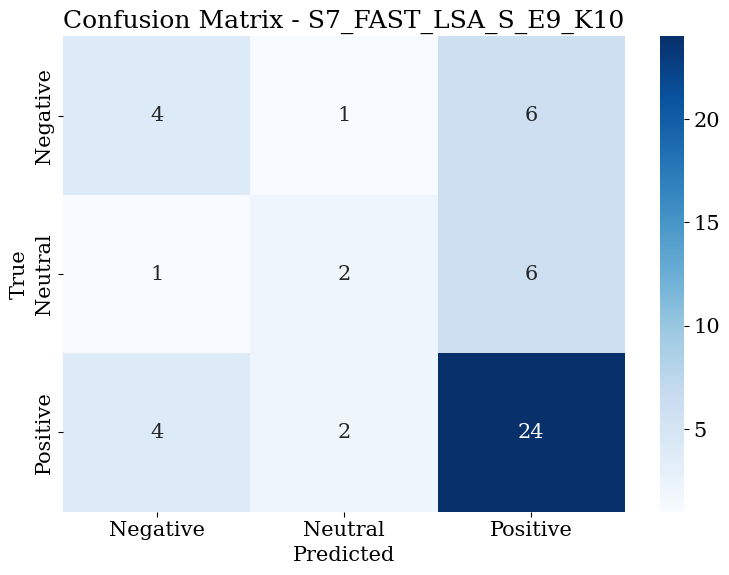

In [ ]:
# ============================================================
# S7: FAST_LSA_S - Epoch=9, K-Fold=10
# ============================================================

scenario = TRAINING_SCENARIOS[6]  # S7
scenario_name = scenario["name"]

results_s6 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 10),
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

### S8

[2026-01-06 08:53:09] (2.4.2) Set Model Device: cuda:0
[2026-01-06 08:53:09] (2.4.2) Device Name: NVIDIA A100-SXM4-80GB


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=3044) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


2026-01-06 08:53:09,762 INFO: PyABSA version: 2.4.2


INFO:fast_lsa_s:PyABSA version: 2.4.2


2026-01-06 08:53:09,768 INFO: Transformers version: 4.57.3


INFO:fast_lsa_s:Transformers version: 4.57.3


2026-01-06 08:53:09,770 INFO: Torch version: 2.9.0+cu126+cuda12.6


INFO:fast_lsa_s:Torch version: 2.9.0+cu126+cuda12.6


2026-01-06 08:53:09,772 INFO: Device: NVIDIA A100-SXM4-80GB


INFO:fast_lsa_s:Device: NVIDIA A100-SXM4-80GB


[2026-01-06 08:53:09] (2.4.2) Try to load ['/content/drive/MyDrive/Output_ABSA/dataset_skenario'] dataset from local disk


/usr/lib/python3.12/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


2026-01-06 08:53:13,377 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc
preparing dataloader: 100%|██████████| 2415/2415 [00:27<00:00, 86.65it/s]


2026-01-06 08:53:41,261 INFO: Dataset Label Details: {'2': 1622, '1': 302, '0': 491, 'Sum': 2415}


INFO:fast_lsa_s:Dataset Label Details: {'2': 1622, '1': 302, '0': 491, 'Sum': 2415}


2026-01-06 08:53:42,272 INFO: train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0

INFO:fast_lsa_s:train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0.8750, 0.8125,

2026-01-06 08:53:42,845 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc
preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 84.06it/s]


2026-01-06 08:53:43,446 INFO: Dataset Label Details: {'2': 30, '1': 9, '0': 11, 'Sum': 50}


INFO:fast_lsa_s:Dataset Label Details: {'2': 30, '1': 9, '0': 11, 'Sum': 50}


2026-01-06 08:53:43,490 INFO: test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.00

INFO:fast_lsa_s:test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.0000, 0.0000, 0.

2026-01-06 08:53:43,493 INFO: valid data examples:
 []


INFO:fast_lsa_s:valid data examples:
 []


2026-01-06 08:53:44,228 INFO: cuda memory allocated:570866176


INFO:fast_lsa_s:cuda memory allocated:570866176


2026-01-06 08:53:44,231 INFO: Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
       

INFO:fast_lsa_s:Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (outp

2026-01-06 08:53:44,233 INFO: ABSADatasetsVersion:None	-->	Calling Count:0


INFO:fast_lsa_s:ABSADatasetsVersion:None	-->	Calling Count:0


2026-01-06 08:53:44,235 INFO: MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x799d892cf140>	-->	Calling Count:0


INFO:fast_lsa_s:MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x799d892cf140>	-->	Calling Count:0


2026-01-06 08:53:44,236 INFO: PyABSAVersion:2.4.2	-->	Calling Count:1


INFO:fast_lsa_s:PyABSAVersion:2.4.2	-->	Calling Count:1


2026-01-06 08:53:44,237 INFO: SRD:3	-->	Calling Count:2465


INFO:fast_lsa_s:SRD:3	-->	Calling Count:2465


2026-01-06 08:53:44,238 INFO: TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


INFO:fast_lsa_s:TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


2026-01-06 08:53:44,240 INFO: TransformersVersion:4.57.3	-->	Calling Count:1


INFO:fast_lsa_s:TransformersVersion:4.57.3	-->	Calling Count:1


2026-01-06 08:53:44,241 INFO: auto_device:True	-->	Calling Count:3


INFO:fast_lsa_s:auto_device:True	-->	Calling Count:3


2026-01-06 08:53:44,242 INFO: batch_size:16	-->	Calling Count:2


INFO:fast_lsa_s:batch_size:16	-->	Calling Count:2


2026-01-06 08:53:44,243 INFO: cache_dataset:False	-->	Calling Count:1


INFO:fast_lsa_s:cache_dataset:False	-->	Calling Count:1


2026-01-06 08:53:44,244 INFO: checkpoint_save_mode:1	-->	Calling Count:4


INFO:fast_lsa_s:checkpoint_save_mode:1	-->	Calling Count:4


2026-01-06 08:53:44,245 INFO: cross_validate_fold:10	-->	Calling Count:1


INFO:fast_lsa_s:cross_validate_fold:10	-->	Calling Count:1


2026-01-06 08:53:44,247 INFO: dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


INFO:fast_lsa_s:dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


2026-01-06 08:53:44,248 INFO: dataset_name:custom_dataset	-->	Calling Count:3


INFO:fast_lsa_s:dataset_name:custom_dataset	-->	Calling Count:3


2026-01-06 08:53:44,249 INFO: dca_layer:3	-->	Calling Count:0


INFO:fast_lsa_s:dca_layer:3	-->	Calling Count:0


2026-01-06 08:53:44,250 INFO: dca_p:1	-->	Calling Count:0


INFO:fast_lsa_s:dca_p:1	-->	Calling Count:0


2026-01-06 08:53:44,251 INFO: deep_ensemble:False	-->	Calling Count:0


INFO:fast_lsa_s:deep_ensemble:False	-->	Calling Count:0


2026-01-06 08:53:44,252 INFO: device:cuda:0	-->	Calling Count:4


INFO:fast_lsa_s:device:cuda:0	-->	Calling Count:4


2026-01-06 08:53:44,253 INFO: device_name:NVIDIA A100-SXM4-80GB	-->	Calling Count:1


INFO:fast_lsa_s:device_name:NVIDIA A100-SXM4-80GB	-->	Calling Count:1


2026-01-06 08:53:44,254 INFO: dlcf_a:2	-->	Calling Count:0


INFO:fast_lsa_s:dlcf_a:2	-->	Calling Count:0


2026-01-06 08:53:44,255 INFO: dropout:0.1	-->	Calling Count:1


INFO:fast_lsa_s:dropout:0.1	-->	Calling Count:1


2026-01-06 08:53:44,256 INFO: dynamic_truncate:True	-->	Calling Count:4930


INFO:fast_lsa_s:dynamic_truncate:True	-->	Calling Count:4930


2026-01-06 08:53:44,257 INFO: embed_dim:768	-->	Calling Count:7


INFO:fast_lsa_s:embed_dim:768	-->	Calling Count:7


2026-01-06 08:53:44,259 INFO: eta:1	-->	Calling Count:0


INFO:fast_lsa_s:eta:1	-->	Calling Count:0


2026-01-06 08:53:44,260 INFO: eta_lr:0.1	-->	Calling Count:1


INFO:fast_lsa_s:eta_lr:0.1	-->	Calling Count:1


2026-01-06 08:53:44,261 INFO: eval_step:50	-->	Calling Count:0


INFO:fast_lsa_s:eval_step:50	-->	Calling Count:0


2026-01-06 08:53:44,262 INFO: evaluate_begin:0	-->	Calling Count:0


INFO:fast_lsa_s:evaluate_begin:0	-->	Calling Count:0


2026-01-06 08:53:44,264 INFO: from_checkpoint:None	-->	Calling Count:0


INFO:fast_lsa_s:from_checkpoint:None	-->	Calling Count:0


2026-01-06 08:53:44,265 INFO: gradient_accumulation_steps:1	-->	Calling Count:0


INFO:fast_lsa_s:gradient_accumulation_steps:1	-->	Calling Count:0


2026-01-06 08:53:44,266 INFO: hidden_dim:768	-->	Calling Count:0


INFO:fast_lsa_s:hidden_dim:768	-->	Calling Count:0


2026-01-06 08:53:44,267 INFO: index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


INFO:fast_lsa_s:index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


2026-01-06 08:53:44,268 INFO: inference_model:None	-->	Calling Count:0


INFO:fast_lsa_s:inference_model:None	-->	Calling Count:0


2026-01-06 08:53:44,269 INFO: initializer:xavier_uniform_	-->	Calling Count:0


INFO:fast_lsa_s:initializer:xavier_uniform_	-->	Calling Count:0


2026-01-06 08:53:44,270 INFO: inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


INFO:fast_lsa_s:inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


2026-01-06 08:53:44,271 INFO: l2reg:1e-06	-->	Calling Count:2


INFO:fast_lsa_s:l2reg:1e-06	-->	Calling Count:2


2026-01-06 08:53:44,272 INFO: label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


INFO:fast_lsa_s:label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


2026-01-06 08:53:44,274 INFO: lcf:cdw	-->	Calling Count:0


INFO:fast_lsa_s:lcf:cdw	-->	Calling Count:0


2026-01-06 08:53:44,275 INFO: learning_rate:2e-05	-->	Calling Count:1


INFO:fast_lsa_s:learning_rate:2e-05	-->	Calling Count:1


2026-01-06 08:53:44,276 INFO: load_aug:False	-->	Calling Count:1


INFO:fast_lsa_s:load_aug:False	-->	Calling Count:1


2026-01-06 08:53:44,277 INFO: log_step:50	-->	Calling Count:0


INFO:fast_lsa_s:log_step:50	-->	Calling Count:0


2026-01-06 08:53:44,278 INFO: logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


INFO:fast_lsa_s:logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


2026-01-06 08:53:44,279 INFO: lsa:False	-->	Calling Count:0


INFO:fast_lsa_s:lsa:False	-->	Calling Count:0


2026-01-06 08:53:44,280 INFO: max_seq_len:128	-->	Calling Count:22185


INFO:fast_lsa_s:max_seq_len:128	-->	Calling Count:22185


2026-01-06 08:53:44,282 INFO: model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


INFO:fast_lsa_s:model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


2026-01-06 08:53:44,283 INFO: model_name:fast_lsa_s	-->	Calling Count:7397


INFO:fast_lsa_s:model_name:fast_lsa_s	-->	Calling Count:7397


2026-01-06 08:53:44,284 INFO: model_path_to_save:checkpoints	-->	Calling Count:0


INFO:fast_lsa_s:model_path_to_save:checkpoints	-->	Calling Count:0


2026-01-06 08:53:44,285 INFO: num_epoch:11	-->	Calling Count:0


INFO:fast_lsa_s:num_epoch:11	-->	Calling Count:0


2026-01-06 08:53:44,286 INFO: optimizer:adamw	-->	Calling Count:1


INFO:fast_lsa_s:optimizer:adamw	-->	Calling Count:1


2026-01-06 08:53:44,287 INFO: output_dim:3	-->	Calling Count:3


INFO:fast_lsa_s:output_dim:3	-->	Calling Count:3


2026-01-06 08:53:44,288 INFO: overwrite_cache:False	-->	Calling Count:0


INFO:fast_lsa_s:overwrite_cache:False	-->	Calling Count:0


2026-01-06 08:53:44,290 INFO: path_to_save:None	-->	Calling Count:1


INFO:fast_lsa_s:path_to_save:None	-->	Calling Count:1


2026-01-06 08:53:44,291 INFO: patience:99999	-->	Calling Count:0


INFO:fast_lsa_s:patience:99999	-->	Calling Count:0


2026-01-06 08:53:44,292 INFO: pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


INFO:fast_lsa_s:pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


2026-01-06 08:53:44,293 INFO: save_mode:1	-->	Calling Count:0


INFO:fast_lsa_s:save_mode:1	-->	Calling Count:0


2026-01-06 08:53:44,294 INFO: seed:42	-->	Calling Count:7


INFO:fast_lsa_s:seed:42	-->	Calling Count:7


2026-01-06 08:53:44,295 INFO: sigma:0.3	-->	Calling Count:0


INFO:fast_lsa_s:sigma:0.3	-->	Calling Count:0


2026-01-06 08:53:44,296 INFO: similarity_threshold:1	-->	Calling Count:2


INFO:fast_lsa_s:similarity_threshold:1	-->	Calling Count:2


2026-01-06 08:53:44,298 INFO: spacy_model:en_core_web_sm	-->	Calling Count:3


INFO:fast_lsa_s:spacy_model:en_core_web_sm	-->	Calling Count:3


2026-01-06 08:53:44,299 INFO: srd_alignment:True	-->	Calling Count:2465


INFO:fast_lsa_s:srd_alignment:True	-->	Calling Count:2465


2026-01-06 08:53:44,300 INFO: task_code:APC	-->	Calling Count:1


INFO:fast_lsa_s:task_code:APC	-->	Calling Count:1


2026-01-06 08:53:44,302 INFO: task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


INFO:fast_lsa_s:task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


2026-01-06 08:53:44,303 INFO: tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Callin

INFO:fast_lsa_s:tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Calling Count:0


2026-01-06 08:53:44,304 INFO: train_test_split:False	-->	Calling Count:0


INFO:fast_lsa_s:train_test_split:False	-->	Calling Count:0


2026-01-06 08:53:44,305 INFO: use_amp:False	-->	Calling Count:1


INFO:fast_lsa_s:use_amp:False	-->	Calling Count:1


2026-01-06 08:53:44,307 INFO: use_bert_spc:True	-->	Calling Count:0


INFO:fast_lsa_s:use_bert_spc:True	-->	Calling Count:0


2026-01-06 08:53:44,308 INFO: use_syntax_based_SRD:False	-->	Calling Count:0


INFO:fast_lsa_s:use_syntax_based_SRD:False	-->	Calling Count:0


2026-01-06 08:53:44,309 INFO: warmup_proportion:0.1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_proportion:0.1	-->	Calling Count:0


2026-01-06 08:53:44,310 INFO: warmup_step:-1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_step:-1	-->	Calling Count:0


2026-01-06 08:53:44,311 INFO: window:lr	-->	Calling Count:0


INFO:fast_lsa_s:window:lr	-->	Calling Count:0


2026-01-06 08:53:44,314 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 08:53:44,315 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 08:53:44,316 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 08:53:44,317 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 08:53:44,318 INFO: Num steps = 88


INFO:fast_lsa_s:Num steps = 88


2026-01-06 08:53:44,319 INFO: No. 1 trainer in 10 folds


INFO:fast_lsa_s:No. 1 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.7920:  35%|███▌      | 48/136 [00:04<00:08, 10.79it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.6575:  72%|███████▏  | 98/136 [00:11<00:03, 10.73it/s, Dev Acc:78.10(max:78.10) Dev F1:44.25(max:44.25)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.5891: 100%|██████████| 136/136 [00:16<00:00,  8.23it/s, Dev Acc:84.71(max:84.

2026-01-06 08:56:45,191 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]              │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303] │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
╘════════════════════╧════════════╧═════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
---------------------------------

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]              │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303] │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
╘════════════════════╧════════════╧═════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
--------------------------------- https://githu

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/_0.0036737103946506977/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/_0.004744757432490587/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/_0.0026923033874481916/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/_0.0027484954334795475/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/_0.0013939815107733011/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/_0.010511375963687897/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/_0.10382057726383209/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.45/_0.0022371564991772175/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 08:56:45,588 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 08:56:45,590 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 08:56:45,591 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 08:56:45,593 INFO: Num steps = 88


INFO:fast_lsa_s:Num steps = 88


2026-01-06 08:56:45,594 INFO: No. 2 trainer in 10 folds


INFO:fast_lsa_s:No. 2 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.1282:  35%|███▌      | 48/136 [00:04<00:08, 10.74it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1255:  72%|███████▏  | 98/136 [00:10<00:03, 10.77it/s, Dev Acc:98.76(max:98.76) Dev F1:98.30(max:98.30)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1250: 100%|██████████| 136/136 [00:15<00:00,  8.74it/s, Dev Acc:98.35(max:98.

2026-01-06 08:59:39,700 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]              │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303] │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]              │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303] │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.0]     

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.34/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.34/_0.02202197164297104/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.34/_0.0025370330549776554/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.34/_0.001363385352306068/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.34/_0.0038313844706863165/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.34/_0.003051526378840208/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.34/_0.0016877827001735568/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.34/_0.0005833025788888335/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.76_f1_98.34/_0.0009688787395134568/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 08:59:40,105 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 08:59:40,106 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 08:59:40,108 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 08:59:40,110 INFO: Num steps = 88


INFO:fast_lsa_s:Num steps = 88


2026-01-06 08:59:40,111 INFO: No. 3 trainer in 10 folds


INFO:fast_lsa_s:No. 3 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0802:  35%|███▌      | 48/136 [00:04<00:08, 10.73it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0801:  72%|███████▏  | 98/136 [00:11<00:03, 10.79it/s, Dev Acc:99.59(max:99.59) Dev F1:99.46(max:99.46)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0799: 100%|██████████| 136/136 [00:15<00:00,  8.70it/s, Dev Acc:98.76(max:99.

2026-01-06 09:02:34,640 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]              │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303] │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]              │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303] │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.0]     

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.46/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.46/_0.0013228367315605283/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.46/_0.0016026487573981285/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.46/_0.003180223749950528/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.46/_0.00933393370360136/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.46/_0.00016204582061618567/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.46/_0.0001969828299479559/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.46/_0.0006388688925653696/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.46/_0.00981832668185234/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 09:02:35,029 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 09:02:35,030 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 09:02:35,032 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 09:02:35,034 INFO: Num steps = 88


INFO:fast_lsa_s:Num steps = 88


2026-01-06 09:02:35,035 INFO: No. 4 trainer in 10 folds


INFO:fast_lsa_s:No. 4 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0615:  35%|███▌      | 48/136 [00:04<00:08, 10.77it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0617:  72%|███████▏  | 98/136 [00:10<00:03, 10.76it/s, Dev Acc:99.17(max:99.17) Dev F1:98.97(max:98.97)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0620: 100%|██████████| 136/136 [00:15<00:00,  8.74it/s, Dev Acc:98.35(max:99.

2026-01-06 09:05:31,157 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303]  │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303]  │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.54/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.54/_0.0013198319356888533/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.54/_0.0016483217477798462/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.54/_0.004892104305326939/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.54/_0.08229140192270279/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.54/_0.0010073864832520485/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.54/_0.03429396077990532/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.54/_0.001922721741721034/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.54/_0.00445697782561183/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.5

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 09:05:31,558 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 09:05:31,560 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 09:05:31,561 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 09:05:31,563 INFO: Num steps = 88


INFO:fast_lsa_s:Num steps = 88


2026-01-06 09:05:31,564 INFO: No. 5 trainer in 10 folds


INFO:fast_lsa_s:No. 5 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0548:  35%|███▌      | 48/136 [00:04<00:08, 10.75it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0546:  72%|███████▏  | 98/136 [00:10<00:03, 10.76it/s, Dev Acc:99.17(max:99.17) Dev F1:98.78(max:98.78)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0544: 100%|██████████| 136/136 [00:15<00:00,  8.73it/s, Dev Acc:98.76(max:99.

2026-01-06 09:08:26,010 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303]  │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303]  │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.98/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.98/_0.0008125670719891787/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.98/_0.0006976188742555678/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.98/_0.00029860984068363905/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.98/_0.00010545588156674057/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.98/_0.11936676502227783/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.98/_0.00029118225211277604/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.98/_0.0003565558581613004/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.17_f1_98.98/_0.39252376556396484/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_a

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 09:08:26,407 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 09:08:26,409 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 09:08:26,410 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 09:08:26,412 INFO: Num steps = 88


INFO:fast_lsa_s:Num steps = 88


2026-01-06 09:08:26,413 INFO: No. 6 trainer in 10 folds


INFO:fast_lsa_s:No. 6 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0469:  35%|███▌      | 48/136 [00:04<00:08, 10.79it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0467:  72%|███████▏  | 98/136 [00:10<00:03, 10.76it/s, Dev Acc:99.59(max:99.59) Dev F1:99.45(max:99.45)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0467: 100%|██████████| 136/136 [00:15<00:00,  8.74it/s, Dev Acc:99.59(max:99.

2026-01-06 09:11:21,762 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303]  │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303]  │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.45/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.45/_0.008194098249077797/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.45/_0.0036565461196005344/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.45/_0.009715515188872814/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.45/_0.0004259425913915038/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.45/_0.003653413150459528/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.45/_0.00558715034276247/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.45/_0.20407234132289886/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.45/_0.00019988846906926483/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 09:11:22,158 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 09:11:22,160 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 09:11:22,161 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 09:11:22,163 INFO: Num steps = 88


INFO:fast_lsa_s:Num steps = 88


2026-01-06 09:11:22,164 INFO: No. 7 trainer in 10 folds


INFO:fast_lsa_s:No. 7 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0429:  35%|███▌      | 48/136 [00:04<00:08, 10.75it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0428:  72%|███████▏  | 98/136 [00:11<00:03, 10.77it/s, Dev Acc:100.00(max:100.00) Dev F1:100.00(max:100.00)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0428: 100%|██████████| 136/136 [00:15<00:00,  8.69it/s, Dev Acc:99.17(max

2026-01-06 09:14:16,440 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303]  │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303]  │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0006319170352071524/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0019113924354314804/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0002236463042208925/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0009634499438107014/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.00016022156341932714/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0006415998796001077/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0003617409383878112/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0012830551713705063/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 09:14:16,855 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 09:14:16,857 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 09:14:16,858 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 09:14:16,860 INFO: Num steps = 88


INFO:fast_lsa_s:Num steps = 88


2026-01-06 09:14:16,861 INFO: No. 8 trainer in 10 folds


INFO:fast_lsa_s:No. 8 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0388:  35%|███▌      | 48/136 [00:04<00:08, 10.69it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0389:  72%|███████▏  | 98/136 [00:11<00:03, 10.69it/s, Dev Acc:99.17(max:99.17) Dev F1:98.21(max:98.21)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0389: 100%|██████████| 136/136 [00:15<00:00,  8.71it/s, Dev Acc:99.17(max:99.

2026-01-06 09:17:11,540 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303]  │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303]  │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0019388627260923386/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.00225830078125/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0019073029980063438/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0035136085934937/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.049102701246738434/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0002380650257691741/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0002756501780822873/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.09/_0.0005983737646602094/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 09:17:11,938 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 09:17:11,939 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 09:17:11,940 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 09:17:11,942 INFO: Num steps = 88


INFO:fast_lsa_s:Num steps = 88


2026-01-06 09:17:11,943 INFO: No. 9 trainer in 10 folds


INFO:fast_lsa_s:No. 9 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0367:  35%|███▌      | 48/136 [00:04<00:08, 10.72it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0368:  72%|███████▏  | 98/136 [00:11<00:03, 10.74it/s, Dev Acc:99.17(max:99.17) Dev F1:98.68(max:98.68)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0370: 100%|██████████| 136/136 [00:15<00:00,  8.72it/s, Dev Acc:97.93(max:99.

2026-01-06 09:20:08,285 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303]  │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303]  │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.36/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.36/_0.00039526179898530245/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.36/_0.1313094049692154/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.36/_0.0016643680864945054/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.36/_0.00048594019608572125/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.36/_0.0004937495104968548/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.36/_0.000355732801835984/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.36/_0.00044437061296775937/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.36/_0.00026405195239931345/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 09:20:08,698 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-06 09:20:08,699 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-06 09:20:08,701 INFO: Batch size = 16


INFO:fast_lsa_s:Batch size = 16


2026-01-06 09:20:08,702 INFO: Num steps = 88


INFO:fast_lsa_s:Num steps = 88


2026-01-06 09:20:08,704 INFO: No. 10 trainer in 10 folds


INFO:fast_lsa_s:No. 10 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0348:  35%|███▌      | 48/137 [00:04<00:08, 10.71it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0347:  72%|███████▏  | 98/137 [00:11<00:03, 10.78it/s, Dev Acc:99.58(max:99.58) Dev F1:99.37(max:99.37)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0346: 100%|██████████| 137/137 [00:16<00:00,  8.09it/s, Dev Acc:100.00(max:1

2026-01-06 09:23:04,752 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303]  │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [59.99009042487303]  │  59.9901  │ 59.9901  │   0   │   0   │ 59.9901 │ 59.9901 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [68.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.00026605455786921084/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0006319170352071524/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.21101269125938416/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0019113924354314804/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0013057123869657516/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0008149064960889518/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0002236463042208925/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0009634499438107014/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_a

INFO:fast_lsa_s:
----------------------------------------------------------------------------- Raw Metric Records -----------------------------------------------------------------------------
╒════════════════════╤══════════════════════════════════════════════════════════╤══════════════════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial                                                    │ Values                           │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪══════════════════════════════════════════════════════════╪══════════════════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s                                               │ [70.0]                           │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼──────────────────────────────────────────────────────────┼───────────────────────

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.00026605455786921084/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0006319170352071524/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.21101269125938416/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0019113924354314804/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0013057123869657516/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0008149064960889518/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0002236463042208925/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0009634499438107014/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_a

/usr/local/lib/python3.12/dist-packages/pyabsa/framework/trainer_class/trainer_template.py:250: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/logs/fast_lsa_s_20260106 081601/trainer.log' mode='a' encoding='utf8'>
  self.config.logger.removeHandler(self.config.logger.handlers[0])


[2026-01-06 09:25:51] (2.4.2) Load sentiment classifier from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S8_FAST_LSA_S_E11_K10/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S8_FAST_LSA_S_E11_K10/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S8_FAST_LSA_S_E11_K10/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.00026605455786921084/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S8_FAST_LSA_S_E11_K10/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0006319170352071524/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S8_FAST_LSA_S_E11_K10/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.21101269125938416/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S8_FAST_LSA_S_E11_K10/fast_lsa_s_custom_dataset_acc_100.0_f1_100.0/_0.0019113924354314804/fast_lsa_s.stat

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



OVERALL RESULTS
Accuracy : 0.66
Precision: 0.6442
Recall   : 0.66
F1-Score : 0.6337

CLASSIFICATION REPORT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


              precision    recall  f1-score   support

    Negative       0.57      0.36      0.44        11
     Neutral       0.60      0.33      0.43         9
    Positive       0.68      0.87      0.76        30

    accuracy                           0.66        50
   macro avg       0.62      0.52      0.55        50
weighted avg       0.64      0.66      0.63        50



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



PER-ASPECT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                            Aspect  Samples  Accuracy     F1
                      Transparansi       10       0.6 0.4500
                     Fleksibilitas       10       0.8 0.7529
                Kompetensi Menteri       10       0.6 0.6000
                      Keterwakilan       10       0.5 0.5558
Kebijakan dan Pelayanan Pemerintah       10       0.8 0.7643

PER-SENTIMENT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Negative Precision: 0.5714 Recall: 0.3636 F1: 0.4444


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Neutral Precision: 0.6 Recall: 0.3333 F1: 0.4286


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Positive Precision: 0.6842 Recall: 0.8667 F1: 0.7647


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


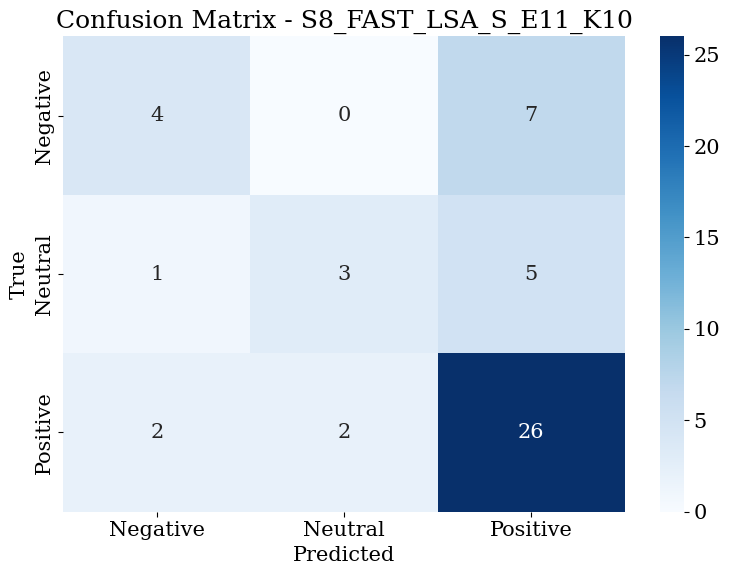

In [ ]:
# ============================================================
# S8: FAST_LSA_S - Epoch=11, K-Fold=10
# ============================================================

scenario = TRAINING_SCENARIOS[7]  # S8
scenario_name = scenario["name"]

results_s6 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 10),
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

### S9

[2026-01-03 19:36:22] (2.4.2) Set Model Device: cuda:0
[2026-01-03 19:36:22] (2.4.2) Device Name: NVIDIA L4


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1438) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


2026-01-03 19:36:22,998 INFO: PyABSA version: 2.4.2


INFO:fast_lsa_s:PyABSA version: 2.4.2


2026-01-03 19:36:23,001 INFO: Transformers version: 4.57.3


INFO:fast_lsa_s:Transformers version: 4.57.3


2026-01-03 19:36:23,002 INFO: Torch version: 2.9.0+cu126+cuda12.6


INFO:fast_lsa_s:Torch version: 2.9.0+cu126+cuda12.6


2026-01-03 19:36:23,004 INFO: Device: NVIDIA L4


INFO:fast_lsa_s:Device: NVIDIA L4


[2026-01-03 19:36:23] (2.4.2) Try to load ['/content/drive/MyDrive/Output_ABSA/dataset_skenario'] dataset from local disk


/usr/lib/python3.12/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


2026-01-03 19:36:27,694 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc
preparing dataloader: 100%|██████████| 2415/2415 [00:30<00:00, 77.95it/s]


2026-01-03 19:36:59,676 INFO: Dataset Label Details: {'1': 302, '0': 491, '2': 1622, 'Sum': 2415}


INFO:fast_lsa_s:Dataset Label Details: {'1': 302, '0': 491, '2': 1622, 'Sum': 2415}


2026-01-03 19:37:00,953 INFO: train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0

INFO:fast_lsa_s:train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.8125, 1.0000, 0.8438, 0.8438, 0.8750, 0.8438, 0.8750, 1.0000, 1.0000,
        0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8438, 0.8750, 0.8750, 0.8750, 1.0000, 1.0000, 0.8750, 0.8750,
        0.8750, 0.8750, 1.0000, 0.8750, 0.8125,

2026-01-03 19:37:01,524 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc


INFO:fast_lsa_s:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc
preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 71.43it/s]


2026-01-03 19:37:02,800 INFO: Dataset Label Details: {'1': 9, '0': 11, '2': 30, 'Sum': 50}


INFO:fast_lsa_s:Dataset Label Details: {'1': 9, '0': 11, '2': 30, 'Sum': 50}


2026-01-03 19:37:02,866 INFO: test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.00

INFO:fast_lsa_s:test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor(0), 'lcf_vec': tensor(0), 'lcf_cdw_vec': tensor(0), 'lcf_cdm_vec': tensor(0), 'lcfs_vec': tensor([0.7586, 1.0000, 1.0000, 0.7586, 0.7931, 0.7931, 0.7931, 0.8276, 0.8276,
        0.8621, 0.7931, 0.8276, 0.8621, 0.8621, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7586, 0.7931, 0.8276, 0.8276, 0.8621, 0.8621, 0.8621, 0.8276, 0.8621,
        1.0000, 0.7586, 0.0000, 0.0000, 0.

2026-01-03 19:37:02,870 INFO: valid data examples:
 []


INFO:fast_lsa_s:valid data examples:
 []


2026-01-03 19:37:03,680 INFO: cuda memory allocated:571128320


INFO:fast_lsa_s:cuda memory allocated:571128320


2026-01-03 19:37:03,683 INFO: Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
       

INFO:fast_lsa_s:Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_S(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (outp

2026-01-03 19:37:03,686 INFO: ABSADatasetsVersion:None	-->	Calling Count:0


INFO:fast_lsa_s:ABSADatasetsVersion:None	-->	Calling Count:0


2026-01-03 19:37:03,687 INFO: MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7d8ddc72d040>	-->	Calling Count:0


INFO:fast_lsa_s:MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7d8ddc72d040>	-->	Calling Count:0


2026-01-03 19:37:03,689 INFO: PyABSAVersion:2.4.2	-->	Calling Count:1


INFO:fast_lsa_s:PyABSAVersion:2.4.2	-->	Calling Count:1


2026-01-03 19:37:03,691 INFO: SRD:3	-->	Calling Count:2465


INFO:fast_lsa_s:SRD:3	-->	Calling Count:2465


2026-01-03 19:37:03,693 INFO: TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


INFO:fast_lsa_s:TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


2026-01-03 19:37:03,695 INFO: TransformersVersion:4.57.3	-->	Calling Count:1


INFO:fast_lsa_s:TransformersVersion:4.57.3	-->	Calling Count:1


2026-01-03 19:37:03,696 INFO: auto_device:True	-->	Calling Count:3


INFO:fast_lsa_s:auto_device:True	-->	Calling Count:3


2026-01-03 19:37:03,698 INFO: batch_size:32	-->	Calling Count:2


INFO:fast_lsa_s:batch_size:32	-->	Calling Count:2


2026-01-03 19:37:03,701 INFO: cache_dataset:False	-->	Calling Count:1


INFO:fast_lsa_s:cache_dataset:False	-->	Calling Count:1


2026-01-03 19:37:03,702 INFO: checkpoint_save_mode:1	-->	Calling Count:4


INFO:fast_lsa_s:checkpoint_save_mode:1	-->	Calling Count:4


2026-01-03 19:37:03,704 INFO: cross_validate_fold:5	-->	Calling Count:1


INFO:fast_lsa_s:cross_validate_fold:5	-->	Calling Count:1


2026-01-03 19:37:03,705 INFO: dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


INFO:fast_lsa_s:dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


2026-01-03 19:37:03,706 INFO: dataset_name:custom_dataset	-->	Calling Count:3


INFO:fast_lsa_s:dataset_name:custom_dataset	-->	Calling Count:3


2026-01-03 19:37:03,708 INFO: dca_layer:3	-->	Calling Count:0


INFO:fast_lsa_s:dca_layer:3	-->	Calling Count:0


2026-01-03 19:37:03,710 INFO: dca_p:1	-->	Calling Count:0


INFO:fast_lsa_s:dca_p:1	-->	Calling Count:0


2026-01-03 19:37:03,711 INFO: deep_ensemble:False	-->	Calling Count:0


INFO:fast_lsa_s:deep_ensemble:False	-->	Calling Count:0


2026-01-03 19:37:03,713 INFO: device:cuda:0	-->	Calling Count:4


INFO:fast_lsa_s:device:cuda:0	-->	Calling Count:4


2026-01-03 19:37:03,714 INFO: device_name:NVIDIA L4	-->	Calling Count:1


INFO:fast_lsa_s:device_name:NVIDIA L4	-->	Calling Count:1


2026-01-03 19:37:03,715 INFO: dlcf_a:2	-->	Calling Count:0


INFO:fast_lsa_s:dlcf_a:2	-->	Calling Count:0


2026-01-03 19:37:03,717 INFO: dropout:0.1	-->	Calling Count:1


INFO:fast_lsa_s:dropout:0.1	-->	Calling Count:1


2026-01-03 19:37:03,718 INFO: dynamic_truncate:True	-->	Calling Count:4930


INFO:fast_lsa_s:dynamic_truncate:True	-->	Calling Count:4930


2026-01-03 19:37:03,720 INFO: embed_dim:768	-->	Calling Count:7


INFO:fast_lsa_s:embed_dim:768	-->	Calling Count:7


2026-01-03 19:37:03,724 INFO: eta:1	-->	Calling Count:0


INFO:fast_lsa_s:eta:1	-->	Calling Count:0


2026-01-03 19:37:03,725 INFO: eta_lr:0.1	-->	Calling Count:1


INFO:fast_lsa_s:eta_lr:0.1	-->	Calling Count:1


2026-01-03 19:37:03,726 INFO: eval_step:50	-->	Calling Count:0


INFO:fast_lsa_s:eval_step:50	-->	Calling Count:0


2026-01-03 19:37:03,728 INFO: evaluate_begin:0	-->	Calling Count:0


INFO:fast_lsa_s:evaluate_begin:0	-->	Calling Count:0


2026-01-03 19:37:03,730 INFO: from_checkpoint:None	-->	Calling Count:0


INFO:fast_lsa_s:from_checkpoint:None	-->	Calling Count:0


2026-01-03 19:37:03,731 INFO: gradient_accumulation_steps:2	-->	Calling Count:0


INFO:fast_lsa_s:gradient_accumulation_steps:2	-->	Calling Count:0


2026-01-03 19:37:03,732 INFO: hidden_dim:768	-->	Calling Count:0


INFO:fast_lsa_s:hidden_dim:768	-->	Calling Count:0


2026-01-03 19:37:03,734 INFO: index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


INFO:fast_lsa_s:index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


2026-01-03 19:37:03,735 INFO: inference_model:None	-->	Calling Count:0


INFO:fast_lsa_s:inference_model:None	-->	Calling Count:0


2026-01-03 19:37:03,737 INFO: initializer:xavier_uniform_	-->	Calling Count:0


INFO:fast_lsa_s:initializer:xavier_uniform_	-->	Calling Count:0


2026-01-03 19:37:03,738 INFO: inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


INFO:fast_lsa_s:inputs_cols:['lcfs_vec', 'left_lcfs_vec', 'right_lcfs_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


2026-01-03 19:37:03,740 INFO: l2reg:1e-06	-->	Calling Count:2


INFO:fast_lsa_s:l2reg:1e-06	-->	Calling Count:2


2026-01-03 19:37:03,742 INFO: label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


INFO:fast_lsa_s:label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


2026-01-03 19:37:03,744 INFO: lcf:cdw	-->	Calling Count:0


INFO:fast_lsa_s:lcf:cdw	-->	Calling Count:0


2026-01-03 19:37:03,745 INFO: learning_rate:1e-05	-->	Calling Count:1


INFO:fast_lsa_s:learning_rate:1e-05	-->	Calling Count:1


2026-01-03 19:37:03,747 INFO: load_aug:False	-->	Calling Count:1


INFO:fast_lsa_s:load_aug:False	-->	Calling Count:1


2026-01-03 19:37:03,748 INFO: log_step:50	-->	Calling Count:0


INFO:fast_lsa_s:log_step:50	-->	Calling Count:0


2026-01-03 19:37:03,750 INFO: logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


INFO:fast_lsa_s:logger:<Logger fast_lsa_s (INFO)>	-->	Calling Count:14


2026-01-03 19:37:03,752 INFO: lsa:False	-->	Calling Count:0


INFO:fast_lsa_s:lsa:False	-->	Calling Count:0


2026-01-03 19:37:03,754 INFO: max_seq_len:256	-->	Calling Count:22185


INFO:fast_lsa_s:max_seq_len:256	-->	Calling Count:22185


2026-01-03 19:37:03,756 INFO: model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


INFO:fast_lsa_s:model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_s.FAST_LSA_S'>	-->	Calling Count:6


2026-01-03 19:37:03,757 INFO: model_name:fast_lsa_s	-->	Calling Count:7397


INFO:fast_lsa_s:model_name:fast_lsa_s	-->	Calling Count:7397


2026-01-03 19:37:03,759 INFO: model_path_to_save:checkpoints	-->	Calling Count:0


INFO:fast_lsa_s:model_path_to_save:checkpoints	-->	Calling Count:0


2026-01-03 19:37:03,761 INFO: num_epoch:10	-->	Calling Count:0


INFO:fast_lsa_s:num_epoch:10	-->	Calling Count:0


2026-01-03 19:37:03,763 INFO: optimizer:adamw	-->	Calling Count:1


INFO:fast_lsa_s:optimizer:adamw	-->	Calling Count:1


2026-01-03 19:37:03,765 INFO: output_dim:3	-->	Calling Count:3


INFO:fast_lsa_s:output_dim:3	-->	Calling Count:3


2026-01-03 19:37:03,767 INFO: overwrite_cache:False	-->	Calling Count:0


INFO:fast_lsa_s:overwrite_cache:False	-->	Calling Count:0


2026-01-03 19:37:03,769 INFO: path_to_save:None	-->	Calling Count:1


INFO:fast_lsa_s:path_to_save:None	-->	Calling Count:1


2026-01-03 19:37:03,771 INFO: patience:99999	-->	Calling Count:0


INFO:fast_lsa_s:patience:99999	-->	Calling Count:0


2026-01-03 19:37:03,773 INFO: pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


INFO:fast_lsa_s:pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


2026-01-03 19:37:03,775 INFO: save_mode:1	-->	Calling Count:0


INFO:fast_lsa_s:save_mode:1	-->	Calling Count:0


2026-01-03 19:37:03,776 INFO: seed:42	-->	Calling Count:7


INFO:fast_lsa_s:seed:42	-->	Calling Count:7


2026-01-03 19:37:03,778 INFO: sigma:0.3	-->	Calling Count:0


INFO:fast_lsa_s:sigma:0.3	-->	Calling Count:0


2026-01-03 19:37:03,780 INFO: similarity_threshold:1	-->	Calling Count:2


INFO:fast_lsa_s:similarity_threshold:1	-->	Calling Count:2


2026-01-03 19:37:03,782 INFO: spacy_model:en_core_web_sm	-->	Calling Count:3


INFO:fast_lsa_s:spacy_model:en_core_web_sm	-->	Calling Count:3


2026-01-03 19:37:03,783 INFO: srd_alignment:True	-->	Calling Count:2465


INFO:fast_lsa_s:srd_alignment:True	-->	Calling Count:2465


2026-01-03 19:37:03,785 INFO: task_code:APC	-->	Calling Count:1


INFO:fast_lsa_s:task_code:APC	-->	Calling Count:1


2026-01-03 19:37:03,786 INFO: task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


INFO:fast_lsa_s:task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


2026-01-03 19:37:03,788 INFO: tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Callin

INFO:fast_lsa_s:tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Calling Count:0


2026-01-03 19:37:03,790 INFO: train_test_split:False	-->	Calling Count:0


INFO:fast_lsa_s:train_test_split:False	-->	Calling Count:0


2026-01-03 19:37:03,791 INFO: use_amp:False	-->	Calling Count:1


INFO:fast_lsa_s:use_amp:False	-->	Calling Count:1


2026-01-03 19:37:03,793 INFO: use_bert_spc:True	-->	Calling Count:0


INFO:fast_lsa_s:use_bert_spc:True	-->	Calling Count:0


2026-01-03 19:37:03,794 INFO: use_syntax_based_SRD:False	-->	Calling Count:0


INFO:fast_lsa_s:use_syntax_based_SRD:False	-->	Calling Count:0


2026-01-03 19:37:03,796 INFO: warmup_proportion:0.1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_proportion:0.1	-->	Calling Count:0


2026-01-03 19:37:03,797 INFO: warmup_step:-1	-->	Calling Count:0


INFO:fast_lsa_s:warmup_step:-1	-->	Calling Count:0


2026-01-03 19:37:03,798 INFO: window:lr	-->	Calling Count:0


INFO:fast_lsa_s:window:lr	-->	Calling Count:0


2026-01-03 19:37:03,801 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 19:37:03,803 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 19:37:03,804 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 19:37:03,805 INFO: Batch size = 32


INFO:fast_lsa_s:Batch size = 32


2026-01-03 19:37:03,807 INFO: Num steps = 10


INFO:fast_lsa_s:Num steps = 10


2026-01-03 19:37:03,808 INFO: No. 1 trainer in 5 folds


INFO:fast_lsa_s:No. 1 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.8548:  80%|████████  | 49/61 [00:37<00:09,  1.32it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.8400: 100%|██████████| 61/61 [00:51<00:00,  1.18it/s, Dev Acc:77.27(max:77.27) Dev F1:44.88(max:44.88)]
Epoch:  1 | Smooth Loss: 0.7543:  62%|██████▏   | 38/61 [00:28<00:17,  1.33it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  1 | Smooth Loss: 0

2026-01-03 19:45:42,101 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [68.0]               │    68     │    68    │   0   │   0   │   68    │   68    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [57.722498618021014] │  57.7225  │ 57.7225  │   0   │   0   │ 57.7225 │ 57.7225 │
╘════════════════════╧════════════╧══════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
--------------------------

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [68.0]               │    68     │    68    │   0   │   0   │   68    │   68    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [57.722498618021014] │  57.7225  │ 57.7225  │   0   │   0   │ 57.7225 │ 57.7225 │
╘════════════════════╧════════════╧══════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
---------------------------------- https

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.92/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.92/_0.2530969977378845/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.92/_0.018238000571727753/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.92/_0.010126168839633465/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.92/_0.19649647176265717/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.92/_0.17099379003047943/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.92/_0.008091971278190613/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.92/_0.25624826550483704/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_92.15_f1_82.92/_0.01418662816286087/fast_lsa_s.state_dict'] found, only return the shortest path: <checkpoints/fa

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 19:45:42,445 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 19:45:42,447 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 19:45:42,448 INFO: Batch size = 32


INFO:fast_lsa_s:Batch size = 32


2026-01-03 19:45:42,449 INFO: Num steps = 10


INFO:fast_lsa_s:Num steps = 10


2026-01-03 19:45:42,451 INFO: No. 2 trainer in 5 folds


INFO:fast_lsa_s:No. 2 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.2555:  80%|████████  | 49/61 [00:36<00:09,  1.31it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.2537: 100%|██████████| 61/61 [00:50<00:00,  1.20it/s, Dev Acc:95.66(max:95.66) Dev F1:92.62(max:92.62)]
Epoch:  1 | Smooth Loss: 0.2468:  62%|██████▏   | 38/61 [00:28<00:17,  1.32it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  1 | Smooth Loss: 0

2026-01-03 19:54:22,899 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [68.0]               │    68     │    68    │   0   │   0   │   68    │   68    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [57.722498618021014] │  57.7225  │ 57.7225  │   0   │   0   │ 57.7225 │ 57.7225 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [68.0]               │    68     │    68    │   0   │   0   │   68    │   68    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [57.722498618021014] │  57.7225  │ 57.7225  │   0   │   0   │ 57.7225 │ 57.7225 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [70.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_96.9_f1_95.35/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_96.9_f1_95.35/_0.006138026248663664/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_96.9_f1_95.35/_0.013267643749713898/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_96.9_f1_95.35/_0.0050166454166173935/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_96.9_f1_95.35/_0.32990285754203796/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_96.9_f1_95.35/_0.15755018591880798/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_96.9_f1_95.35/_0.006235513370484114/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_96.9_f1_95.35/_0.020030101761221886/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_96.9_f1_95.35/_0.033883266150951385/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_96.9_f1_95.35/

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 19:54:23,256 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 19:54:23,257 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 19:54:23,258 INFO: Batch size = 32


INFO:fast_lsa_s:Batch size = 32


2026-01-03 19:54:23,259 INFO: Num steps = 10


INFO:fast_lsa_s:Num steps = 10


2026-01-03 19:54:23,261 INFO: No. 3 trainer in 5 folds


INFO:fast_lsa_s:No. 3 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.1652:  80%|████████  | 49/61 [00:36<00:09,  1.32it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1645: 100%|██████████| 61/61 [00:50<00:00,  1.20it/s, Dev Acc:98.14(max:98.14) Dev F1:97.26(max:97.26)]
Epoch:  1 | Smooth Loss: 0.1616:  62%|██████▏   | 38/61 [00:28<00:17,  1.31it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  1 | Smooth Loss: 0

2026-01-03 20:02:59,373 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [68.0]               │    68     │    68    │   0   │   0   │   68    │   68    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [57.722498618021014] │  57.7225  │ 57.7225  │   0   │   0   │ 57.7225 │ 57.7225 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [68.0]               │    68     │    68    │   0   │   0   │   68    │   68    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [57.722498618021014] │  57.7225  │ 57.7225  │   0   │   0   │ 57.7225 │ 57.7225 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [70.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.74/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.74/_0.002092714887112379/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.74/_0.007142860442399979/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.74/_0.00231687119230628/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.74/_0.005810793023556471/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.74/_0.0017992963548749685/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.74/_0.004481757991015911/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.74/_0.011246089823544025/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.35_f1_97.74/_0.017600420862436295/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_98.3

INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 20:02:59,714 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 20:02:59,715 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 20:02:59,717 INFO: Batch size = 32


INFO:fast_lsa_s:Batch size = 32


2026-01-03 20:02:59,718 INFO: Num steps = 10


INFO:fast_lsa_s:Num steps = 10


2026-01-03 20:02:59,719 INFO: No. 4 trainer in 5 folds


INFO:fast_lsa_s:No. 4 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.1227:  80%|████████  | 49/61 [00:36<00:09,  1.32it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1226: 100%|██████████| 61/61 [00:50<00:00,  1.20it/s, Dev Acc:98.35(max:98.35) Dev F1:96.37(max:96.37)]
Epoch:  1 | Smooth Loss: 0.1211:  62%|██████▏   | 38/61 [00:28<00:17,  1.32it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  1 | Smooth Loss: 0

2026-01-03 20:11:36,488 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [68.0]               │    68     │    68    │   0   │   0   │   68    │   68    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [57.722498618021014] │  57.7225  │ 57.7225  │   0   │   0   │ 57.7225 │ 57.7225 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [68.0]               │    68     │    68    │   0   │   0   │   68    │   68    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [57.722498618021014] │  57.7225  │ 57.7225  │   0   │   0   │ 57.7225 │ 57.7225 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [70.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.15/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.15/_0.0035251544322818518/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.15/_0.0023192507214844227/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.15/_0.0038241478614509106/fast_lsa_s.state_dict'] found, only return the shortest path: <checkpoints/fast_lsa_s_custom_dataset_acc_99.59_f1_99.15/fast_lsa_s.state_dict>
2026-01-03 20:11:36,844 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_s:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 20:11:36,846 INFO: Training set examples = 2415


INFO:fast_lsa_s:Training set examples = 2415


2026-01-03 20:11:36,847 INFO: Test set examples = 50


INFO:fast_lsa_s:Test set examples = 50


2026-01-03 20:11:36,849 INFO: Batch size = 32


INFO:fast_lsa_s:Batch size = 32


2026-01-03 20:11:36,850 INFO: Num steps = 10


INFO:fast_lsa_s:Num steps = 10


2026-01-03 20:11:36,852 INFO: No. 5 trainer in 5 folds


INFO:fast_lsa_s:No. 5 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.1003:  80%|████████  | 49/61 [00:36<00:09,  1.32it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1003: 100%|██████████| 61/61 [00:50<00:00,  1.20it/s, Dev Acc:98.75(max:98.75) Dev F1:97.93(max:97.93)]
Epoch:  1 | Smooth Loss: 0.0992:  62%|██████▏   | 38/61 [00:28<00:17,  1.32it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  1 | Smooth Loss: 0

2026-01-03 20:20:13,603 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [68.0]               │    68     │    68    │   0   │   0   │   68    │   68    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [57.722498618021014] │  57.7225  │ 57.7225  │   0   │   0   │ 57.7225 │ 57.7225 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_s:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s │ [68.0]               │    68     │    68    │   0   │   0   │   68    │   68    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_s │ [57.722498618021014] │  57.7225  │ 57.7225  │   0   │   0   │ 57.7225 │ 57.7225 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_s │ [70.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.008070976473391056/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.0010400786995887756/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.001502990024164319/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.0016544463578611612/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.00030445450101979077/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.00042090611532330513/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.0005787566769868135/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.00043687238940037787/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset

INFO:fast_lsa_s:
----------------------------------------------------------------------------- Raw Metric Records -----------------------------------------------------------------------------
╒════════════════════╤══════════════════════════════════════════════════════════╤═════════════════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial                                                    │ Values                          │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪══════════════════════════════════════════════════════════╪═════════════════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_s                                               │ [68.0]                          │    68     │    68    │   0   │   0   │   68    │   68    │
├────────────────────┼──────────────────────────────────────────────────────────┼───────────────────────────

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.008070976473391056/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.0010400786995887756/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.001502990024164319/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.0016544463578611612/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.00030445450101979077/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.00042090611532330513/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.0005787566769868135/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.00043687238940037787/fast_lsa_s.state_dict', 'checkpoints/fast_lsa_s_custom_dataset

/usr/local/lib/python3.12/dist-packages/pyabsa/framework/trainer_class/trainer_template.py:250: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/logs/fast_lsa_s_20260103 130350/trainer.log' mode='a' encoding='utf8'>
  self.config.logger.removeHandler(self.config.logger.handlers[0])


[2026-01-03 20:20:40] (2.4.2) Load sentiment classifier from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S7_FAST_LSA_S_FINETUNE/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S7_FAST_LSA_S_FINETUNE/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S7_FAST_LSA_S_FINETUNE/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.008070976473391056/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S7_FAST_LSA_S_FINETUNE/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.0010400786995887756/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S7_FAST_LSA_S_FINETUNE/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.001502990024164319/fast_lsa_s.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S7_FAST_LSA_S_FINETUNE/fast_lsa_s_custom_dataset_acc_99.16_f1_98.58/_0.0016544463578611612/fast_lsa_s

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



OVERALL RESULTS
Accuracy : 0.7
Precision: 0.6874
Recall   : 0.7
F1-Score : 0.6771

CLASSIFICATION REPORT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


              precision    recall  f1-score   support

    Negative       0.67      0.36      0.47        11
     Neutral       0.57      0.44      0.50         9
    Positive       0.73      0.90      0.81        30

    accuracy                           0.70        50
   macro avg       0.66      0.57      0.59        50
weighted avg       0.69      0.70      0.68        50



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



PER-ASPECT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                            Aspect  Samples  Accuracy     F1
                      Keterwakilan       10       0.6 0.6286
                     Fleksibilitas       10       0.8 0.7529
Kebijakan dan Pelayanan Pemerintah       10       0.9 0.8938
                Kompetensi Menteri       10       0.6 0.5881
                      Transparansi       10       0.6 0.4500

PER-SENTIMENT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Negative Precision: 0.6667 Recall: 0.3636 F1: 0.4706


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Neutral Precision: 0.5714 Recall: 0.4444 F1: 0.5


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Positive Precision: 0.7297 Recall: 0.9 F1: 0.806


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


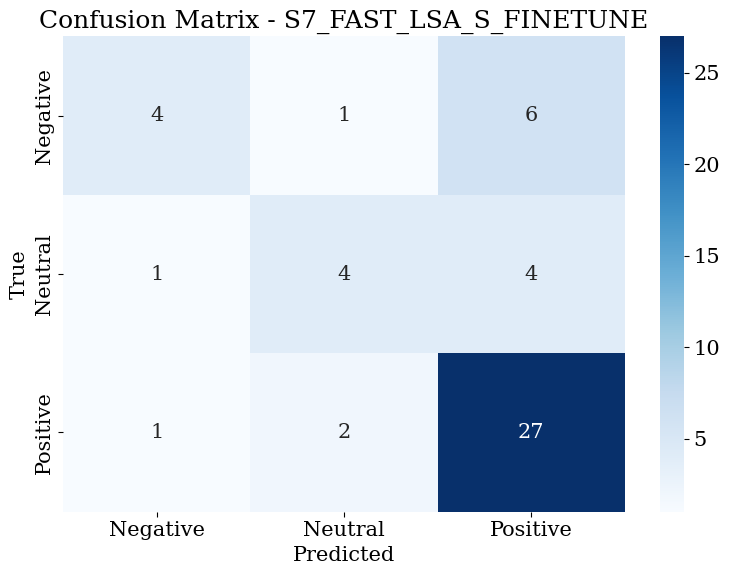

In [ ]:
# ============================================================
# S9: FAST_LSA_S - Fine-tuning
# ============================================================

scenario = TRAINING_SCENARIOS[8]  # S9
scenario_name = scenario["name"]

results_s7 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 5),
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

## 12. Run Training - FAST_LSA_T Scenarios (S8-S14)
Setiap cell akan menjalankan training dan menampilkan hasil evaluasi lengkap untuk 1 skenario.

### S10

[2026-01-03 20:20:48] (2.4.2) Set Model Device: cuda:0
[2026-01-03 20:20:48] (2.4.2) Device Name: NVIDIA L4


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=1438) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


2026-01-03 20:20:48,625 INFO: PyABSA version: 2.4.2


INFO:fast_lsa_t:PyABSA version: 2.4.2


2026-01-03 20:20:48,630 INFO: Transformers version: 4.57.3


INFO:fast_lsa_t:Transformers version: 4.57.3


2026-01-03 20:20:48,632 INFO: Torch version: 2.9.0+cu126+cuda12.6


INFO:fast_lsa_t:Torch version: 2.9.0+cu126+cuda12.6


2026-01-03 20:20:48,633 INFO: Device: NVIDIA L4


INFO:fast_lsa_t:Device: NVIDIA L4


[2026-01-03 20:20:48] (2.4.2) Try to load ['/content/drive/MyDrive/Output_ABSA/dataset_skenario'] dataset from local disk


/usr/lib/python3.12/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


2026-01-03 20:20:52,714 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc


INFO:fast_lsa_t:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc
preparing dataloader: 100%|██████████| 2415/2415 [00:02<00:00, 1076.77it/s]


2026-01-03 20:20:54,982 INFO: Dataset Label Details: {'1': 302, '0': 491, '2': 1622, 'Sum': 2415}


INFO:fast_lsa_t:Dataset Label Details: {'1': 302, '0': 491, '2': 1622, 'Sum': 2415}


2026-01-03 20:20:56,283 INFO: train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9688, 0.9375, 0.9062, 0.8750,
        0.8438, 0.8125, 0.7812, 0.7500, 0.7188, 0.6875, 0.6562, 0.6250, 0.5938,
        0.5625, 0.5312, 0.5000, 0.4688, 0.4375, 0.4062, 0.3750, 0.3438, 0.3125,
        0.2812, 0.2500, 0.2188, 0.1875, 0.1562, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

INFO:fast_lsa_t:train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9688, 0.9375, 0.9062, 0.8750,
        0.8438, 0.8125, 0.7812, 0.7500, 0.7188, 0.6875, 0.6562, 0.6250, 0.5938,
        0.5625, 0.5312, 0.5000, 0.4688, 0.4375, 0.4062, 0.3750, 0.3438, 0.3125,
        0.2812, 0.2500, 0.2188, 0.1875, 0.1562, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

2026-01-03 20:20:56,878 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc


INFO:fast_lsa_t:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc
preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 1151.46it/s]


2026-01-03 20:20:56,935 INFO: Dataset Label Details: {'1': 9, '0': 11, '2': 30, 'Sum': 50}


INFO:fast_lsa_t:Dataset Label Details: {'1': 9, '0': 11, '2': 30, 'Sum': 50}


2026-01-03 20:20:56,987 INFO: test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9655, 0.9310, 0.8966, 0.8621,
        0.8276, 0.7931, 0.7586, 0.7241, 0.6897, 0.6552, 0.6207, 0.5862, 0.5517,
        0.5172, 0.4828, 0.4483, 0.4138, 0.3793, 0.3448, 0.3103, 0.2759, 0.2414,
        0.2069, 0.1724, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.000

INFO:fast_lsa_t:test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9655, 0.9310, 0.8966, 0.8621,
        0.8276, 0.7931, 0.7586, 0.7241, 0.6897, 0.6552, 0.6207, 0.5862, 0.5517,
        0.5172, 0.4828, 0.4483, 0.4138, 0.3793, 0.3448, 0.3103, 0.2759, 0.2414,
        0.2069, 0.1724, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

2026-01-03 20:20:56,990 INFO: valid data examples:
 []


INFO:fast_lsa_t:valid data examples:
 []


2026-01-03 20:20:57,784 INFO: cuda memory allocated:571128320


INFO:fast_lsa_t:cuda memory allocated:571128320


2026-01-03 20:20:57,788 INFO: Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_T(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
       

INFO:fast_lsa_t:Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_T(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (outp

2026-01-03 20:20:57,790 INFO: ABSADatasetsVersion:None	-->	Calling Count:0


INFO:fast_lsa_t:ABSADatasetsVersion:None	-->	Calling Count:0


2026-01-03 20:20:57,792 INFO: MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7d8e5975bb00>	-->	Calling Count:0


INFO:fast_lsa_t:MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7d8e5975bb00>	-->	Calling Count:0


2026-01-03 20:20:57,793 INFO: PyABSAVersion:2.4.2	-->	Calling Count:1


INFO:fast_lsa_t:PyABSAVersion:2.4.2	-->	Calling Count:1


2026-01-03 20:20:57,795 INFO: SRD:3	-->	Calling Count:2465


INFO:fast_lsa_t:SRD:3	-->	Calling Count:2465


2026-01-03 20:20:57,796 INFO: TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


INFO:fast_lsa_t:TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


2026-01-03 20:20:57,798 INFO: TransformersVersion:4.57.3	-->	Calling Count:1


INFO:fast_lsa_t:TransformersVersion:4.57.3	-->	Calling Count:1


2026-01-03 20:20:57,799 INFO: auto_device:True	-->	Calling Count:3


INFO:fast_lsa_t:auto_device:True	-->	Calling Count:3


2026-01-03 20:20:57,801 INFO: batch_size:16	-->	Calling Count:2


INFO:fast_lsa_t:batch_size:16	-->	Calling Count:2


2026-01-03 20:20:57,802 INFO: cache_dataset:False	-->	Calling Count:1


INFO:fast_lsa_t:cache_dataset:False	-->	Calling Count:1


2026-01-03 20:20:57,803 INFO: checkpoint_save_mode:1	-->	Calling Count:4


INFO:fast_lsa_t:checkpoint_save_mode:1	-->	Calling Count:4


2026-01-03 20:20:57,805 INFO: cross_validate_fold:5	-->	Calling Count:1


INFO:fast_lsa_t:cross_validate_fold:5	-->	Calling Count:1


2026-01-03 20:20:57,807 INFO: dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


INFO:fast_lsa_t:dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


2026-01-03 20:20:57,808 INFO: dataset_name:custom_dataset	-->	Calling Count:3


INFO:fast_lsa_t:dataset_name:custom_dataset	-->	Calling Count:3


2026-01-03 20:20:57,810 INFO: dca_layer:3	-->	Calling Count:0


INFO:fast_lsa_t:dca_layer:3	-->	Calling Count:0


2026-01-03 20:20:57,811 INFO: dca_p:1	-->	Calling Count:0


INFO:fast_lsa_t:dca_p:1	-->	Calling Count:0


2026-01-03 20:20:57,812 INFO: deep_ensemble:False	-->	Calling Count:0


INFO:fast_lsa_t:deep_ensemble:False	-->	Calling Count:0


2026-01-03 20:20:57,814 INFO: device:cuda:0	-->	Calling Count:4


INFO:fast_lsa_t:device:cuda:0	-->	Calling Count:4


2026-01-03 20:20:57,815 INFO: device_name:NVIDIA L4	-->	Calling Count:1


INFO:fast_lsa_t:device_name:NVIDIA L4	-->	Calling Count:1


2026-01-03 20:20:57,817 INFO: dlcf_a:2	-->	Calling Count:0


INFO:fast_lsa_t:dlcf_a:2	-->	Calling Count:0


2026-01-03 20:20:57,818 INFO: dropout:0.1	-->	Calling Count:1


INFO:fast_lsa_t:dropout:0.1	-->	Calling Count:1


2026-01-03 20:20:57,819 INFO: dynamic_truncate:True	-->	Calling Count:4930


INFO:fast_lsa_t:dynamic_truncate:True	-->	Calling Count:4930


2026-01-03 20:20:57,820 INFO: embed_dim:768	-->	Calling Count:7


INFO:fast_lsa_t:embed_dim:768	-->	Calling Count:7


2026-01-03 20:20:57,822 INFO: eta:1	-->	Calling Count:0


INFO:fast_lsa_t:eta:1	-->	Calling Count:0


2026-01-03 20:20:57,823 INFO: eta_lr:0.1	-->	Calling Count:1


INFO:fast_lsa_t:eta_lr:0.1	-->	Calling Count:1


2026-01-03 20:20:57,825 INFO: eval_step:50	-->	Calling Count:0


INFO:fast_lsa_t:eval_step:50	-->	Calling Count:0


2026-01-03 20:20:57,826 INFO: evaluate_begin:0	-->	Calling Count:0


INFO:fast_lsa_t:evaluate_begin:0	-->	Calling Count:0


2026-01-03 20:20:57,828 INFO: from_checkpoint:None	-->	Calling Count:0


INFO:fast_lsa_t:from_checkpoint:None	-->	Calling Count:0


2026-01-03 20:20:57,830 INFO: gradient_accumulation_steps:1	-->	Calling Count:0


INFO:fast_lsa_t:gradient_accumulation_steps:1	-->	Calling Count:0


2026-01-03 20:20:57,831 INFO: hidden_dim:768	-->	Calling Count:0


INFO:fast_lsa_t:hidden_dim:768	-->	Calling Count:0


2026-01-03 20:20:57,833 INFO: index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


INFO:fast_lsa_t:index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


2026-01-03 20:20:57,835 INFO: inference_model:None	-->	Calling Count:0


INFO:fast_lsa_t:inference_model:None	-->	Calling Count:0


2026-01-03 20:20:57,836 INFO: initializer:xavier_uniform_	-->	Calling Count:0


INFO:fast_lsa_t:initializer:xavier_uniform_	-->	Calling Count:0


2026-01-03 20:20:57,838 INFO: inputs_cols:['lcf_vec', 'left_lcf_vec', 'right_lcf_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


INFO:fast_lsa_t:inputs_cols:['lcf_vec', 'left_lcf_vec', 'right_lcf_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


2026-01-03 20:20:57,839 INFO: l2reg:1e-06	-->	Calling Count:2


INFO:fast_lsa_t:l2reg:1e-06	-->	Calling Count:2


2026-01-03 20:20:57,840 INFO: label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


INFO:fast_lsa_t:label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


2026-01-03 20:20:57,842 INFO: lcf:cdw	-->	Calling Count:0


INFO:fast_lsa_t:lcf:cdw	-->	Calling Count:0


2026-01-03 20:20:57,843 INFO: learning_rate:2e-05	-->	Calling Count:1


INFO:fast_lsa_t:learning_rate:2e-05	-->	Calling Count:1


2026-01-03 20:20:57,844 INFO: load_aug:False	-->	Calling Count:1


INFO:fast_lsa_t:load_aug:False	-->	Calling Count:1


2026-01-03 20:20:57,845 INFO: log_step:50	-->	Calling Count:0


INFO:fast_lsa_t:log_step:50	-->	Calling Count:0


2026-01-03 20:20:57,847 INFO: logger:<Logger fast_lsa_t (INFO)>	-->	Calling Count:14


INFO:fast_lsa_t:logger:<Logger fast_lsa_t (INFO)>	-->	Calling Count:14


2026-01-03 20:20:57,849 INFO: lsa:False	-->	Calling Count:0


INFO:fast_lsa_t:lsa:False	-->	Calling Count:0


2026-01-03 20:20:57,850 INFO: max_seq_len:128	-->	Calling Count:22185


INFO:fast_lsa_t:max_seq_len:128	-->	Calling Count:22185


2026-01-03 20:20:57,851 INFO: model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_t.FAST_LSA_T'>	-->	Calling Count:6


INFO:fast_lsa_t:model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_t.FAST_LSA_T'>	-->	Calling Count:6


2026-01-03 20:20:57,853 INFO: model_name:fast_lsa_t	-->	Calling Count:4932


INFO:fast_lsa_t:model_name:fast_lsa_t	-->	Calling Count:4932


2026-01-03 20:20:57,854 INFO: model_path_to_save:checkpoints	-->	Calling Count:0


INFO:fast_lsa_t:model_path_to_save:checkpoints	-->	Calling Count:0


2026-01-03 20:20:57,856 INFO: num_epoch:5	-->	Calling Count:0


INFO:fast_lsa_t:num_epoch:5	-->	Calling Count:0


2026-01-03 20:20:57,858 INFO: optimizer:adamw	-->	Calling Count:1


INFO:fast_lsa_t:optimizer:adamw	-->	Calling Count:1


2026-01-03 20:20:57,859 INFO: output_dim:3	-->	Calling Count:3


INFO:fast_lsa_t:output_dim:3	-->	Calling Count:3


2026-01-03 20:20:57,861 INFO: overwrite_cache:False	-->	Calling Count:0


INFO:fast_lsa_t:overwrite_cache:False	-->	Calling Count:0


2026-01-03 20:20:57,862 INFO: path_to_save:None	-->	Calling Count:1


INFO:fast_lsa_t:path_to_save:None	-->	Calling Count:1


2026-01-03 20:20:57,864 INFO: patience:99999	-->	Calling Count:0


INFO:fast_lsa_t:patience:99999	-->	Calling Count:0


2026-01-03 20:20:57,866 INFO: pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


INFO:fast_lsa_t:pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


2026-01-03 20:20:57,867 INFO: save_mode:1	-->	Calling Count:0


INFO:fast_lsa_t:save_mode:1	-->	Calling Count:0


2026-01-03 20:20:57,869 INFO: seed:42	-->	Calling Count:7


INFO:fast_lsa_t:seed:42	-->	Calling Count:7


2026-01-03 20:20:57,870 INFO: sigma:0.3	-->	Calling Count:0


INFO:fast_lsa_t:sigma:0.3	-->	Calling Count:0


2026-01-03 20:20:57,872 INFO: similarity_threshold:1	-->	Calling Count:2


INFO:fast_lsa_t:similarity_threshold:1	-->	Calling Count:2


2026-01-03 20:20:57,874 INFO: spacy_model:en_core_web_sm	-->	Calling Count:3


INFO:fast_lsa_t:spacy_model:en_core_web_sm	-->	Calling Count:3


2026-01-03 20:20:57,875 INFO: srd_alignment:True	-->	Calling Count:0


INFO:fast_lsa_t:srd_alignment:True	-->	Calling Count:0


2026-01-03 20:20:57,877 INFO: task_code:APC	-->	Calling Count:1


INFO:fast_lsa_t:task_code:APC	-->	Calling Count:1


2026-01-03 20:20:57,879 INFO: task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


INFO:fast_lsa_t:task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


2026-01-03 20:20:57,880 INFO: tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Callin

INFO:fast_lsa_t:tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Calling Count:0


2026-01-03 20:20:57,882 INFO: train_test_split:False	-->	Calling Count:0


INFO:fast_lsa_t:train_test_split:False	-->	Calling Count:0


2026-01-03 20:20:57,884 INFO: use_amp:False	-->	Calling Count:1


INFO:fast_lsa_t:use_amp:False	-->	Calling Count:1


2026-01-03 20:20:57,886 INFO: use_bert_spc:True	-->	Calling Count:0


INFO:fast_lsa_t:use_bert_spc:True	-->	Calling Count:0


2026-01-03 20:20:57,887 INFO: use_syntax_based_SRD:False	-->	Calling Count:0


INFO:fast_lsa_t:use_syntax_based_SRD:False	-->	Calling Count:0


2026-01-03 20:20:57,889 INFO: warmup_proportion:0.1	-->	Calling Count:0


INFO:fast_lsa_t:warmup_proportion:0.1	-->	Calling Count:0


2026-01-03 20:20:57,891 INFO: warmup_step:-1	-->	Calling Count:0


INFO:fast_lsa_t:warmup_step:-1	-->	Calling Count:0


2026-01-03 20:20:57,892 INFO: window:lr	-->	Calling Count:0


INFO:fast_lsa_t:window:lr	-->	Calling Count:0


2026-01-03 20:20:57,895 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_t:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 20:20:57,896 INFO: Training set examples = 2415


INFO:fast_lsa_t:Training set examples = 2415


2026-01-03 20:20:57,898 INFO: Test set examples = 50


INFO:fast_lsa_t:Test set examples = 50


2026-01-03 20:20:57,899 INFO: Batch size = 16


INFO:fast_lsa_t:Batch size = 16


2026-01-03 20:20:57,901 INFO: Num steps = 35


INFO:fast_lsa_t:Num steps = 35


2026-01-03 20:20:57,902 INFO: No. 1 trainer in 5 folds


INFO:fast_lsa_t:No. 1 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.7472:  40%|████      | 49/121 [00:10<00:15,  4.74it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.6149:  82%|████████▏ | 99/121 [00:24<00:04,  4.60it/s, Dev Acc:82.64(max:82.64) Dev F1:55.79(max:55.79)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.5915: 100%|██████████| 121/121 [00:32<00:00,  3.78it/s, Dev Acc:88.22(max:88.2

2026-01-03 20:23:38,835 INFO: 
----------------------------------------------- Raw Metric Records -----------------------------------------------
╒════════════════════╤════════════╤════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values             │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [64.0]             │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [50.3150912106136] │  50.3151  │ 50.3151  │   0   │   0   │ 50.3151 │ 50.3151 │
╘════════════════════╧════════════╧════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
--------------------------------- https://

INFO:fast_lsa_t:
----------------------------------------------- Raw Metric Records -----------------------------------------------
╒════════════════════╤════════════╤════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values             │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [64.0]             │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [50.3150912106136] │  50.3151  │ 50.3151  │   0   │   0   │ 50.3151 │ 50.3151 │
╘════════════════════╧════════════╧════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
--------------------------------- https://github.com/yan

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_t_custom_dataset_acc_91.32_f1_80.85/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_91.32_f1_80.85/_0.018973616883158684/fast_lsa_t.state_dict'] found, only return the shortest path: <checkpoints/fast_lsa_t_custom_dataset_acc_91.32_f1_80.85/fast_lsa_t.state_dict>
2026-01-03 20:23:39,191 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_t:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 20:23:39,193 INFO: Training set examples = 2415


INFO:fast_lsa_t:Training set examples = 2415


2026-01-03 20:23:39,194 INFO: Test set examples = 50


INFO:fast_lsa_t:Test set examples = 50


2026-01-03 20:23:39,196 INFO: Batch size = 16


INFO:fast_lsa_t:Batch size = 16


2026-01-03 20:23:39,197 INFO: Num steps = 35


INFO:fast_lsa_t:Num steps = 35


2026-01-03 20:23:39,198 INFO: No. 2 trainer in 5 folds


INFO:fast_lsa_t:No. 2 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.2409:  40%|████      | 49/121 [00:10<00:14,  4.80it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.2338:  82%|████████▏ | 99/121 [00:23<00:04,  4.78it/s, Dev Acc:98.97(max:98.97) Dev F1:98.07(max:98.07)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.2335: 100%|██████████| 121/121 [00:30<00:00,  3.98it/s, Dev Acc:98.14(max:98.9

2026-01-03 20:26:15,744 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [64.0]              │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [50.3150912106136]  │  50.3151  │ 50.3151  │   0   │   0   │ 50.3151 │ 50.3151 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_t

INFO:fast_lsa_t:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤═════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values              │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪═════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [64.0]              │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [50.3150912106136]  │  50.3151  │ 50.3151  │   0   │   0   │ 50.3151 │ 50.3151 │
├────────────────────┼────────────┼─────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_t │ [66.0]     

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_t_custom_dataset_acc_99.17_f1_98.78/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.17_f1_98.78/_0.0030865799635648727/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.17_f1_98.78/_0.3667818009853363/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.17_f1_98.78/_0.0083417147397995/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.17_f1_98.78/_0.006321544758975506/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.17_f1_98.78/_0.007130966521799564/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.17_f1_98.78/_0.333942711353302/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.17_f1_98.78/_0.5022916793823242/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.17_f1_98.78/_0.04714716225862503/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.17_f1_98.7

INFO:fast_lsa_t:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 20:26:16,096 INFO: Training set examples = 2415


INFO:fast_lsa_t:Training set examples = 2415


2026-01-03 20:26:16,097 INFO: Test set examples = 50


INFO:fast_lsa_t:Test set examples = 50


2026-01-03 20:26:16,098 INFO: Batch size = 16


INFO:fast_lsa_t:Batch size = 16


2026-01-03 20:26:16,100 INFO: Num steps = 35


INFO:fast_lsa_t:Num steps = 35


2026-01-03 20:26:16,101 INFO: No. 3 trainer in 5 folds


INFO:fast_lsa_t:No. 3 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.1581:  40%|████      | 49/121 [00:10<00:15,  4.73it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1542:  82%|████████▏ | 99/121 [00:23<00:04,  4.76it/s, Dev Acc:98.55(max:98.55) Dev F1:97.82(max:97.82)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1532: 100%|██████████| 121/121 [00:31<00:00,  3.87it/s, Dev Acc:98.55(max:98.5

2026-01-03 20:28:52,611 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [50.3150912106136]   │  50.3151  │ 50.3151  │   0   │   0   │ 50.3151 │ 50.3151 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_t:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [50.3150912106136]   │  50.3151  │ 50.3151  │   0   │   0   │ 50.3151 │ 50.3151 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_t │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_t_custom_dataset_acc_98.55_f1_98.11/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.55_f1_98.11/_0.0026625320315361023/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.55_f1_98.11/_0.004550675395876169/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.55_f1_98.11/_0.02091064117848873/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.55_f1_98.11/_0.007494671270251274/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.55_f1_98.11/_0.002442719880491495/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.55_f1_98.11/_0.006705647334456444/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.55_f1_98.11/_0.013761138543486595/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.55_f1_98.11/_0.004651972092688084/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.5

INFO:fast_lsa_t:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 20:28:52,972 INFO: Training set examples = 2415


INFO:fast_lsa_t:Training set examples = 2415


2026-01-03 20:28:52,973 INFO: Test set examples = 50


INFO:fast_lsa_t:Test set examples = 50


2026-01-03 20:28:52,975 INFO: Batch size = 16


INFO:fast_lsa_t:Batch size = 16


2026-01-03 20:28:52,976 INFO: Num steps = 35


INFO:fast_lsa_t:Num steps = 35


2026-01-03 20:28:52,977 INFO: No. 4 trainer in 5 folds


INFO:fast_lsa_t:No. 4 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.1212:  40%|████      | 49/121 [00:10<00:15,  4.78it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1197:  82%|████████▏ | 99/121 [00:23<00:04,  4.79it/s, Dev Acc:99.59(max:99.59) Dev F1:99.42(max:99.42)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1187: 100%|██████████| 121/121 [00:30<00:00,  3.96it/s, Dev Acc:99.38(max:99.5

2026-01-03 20:31:28,751 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [50.3150912106136]   │  50.3151  │ 50.3151  │   0   │   0   │ 50.3151 │ 50.3151 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_t:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [50.3150912106136]   │  50.3151  │ 50.3151  │   0   │   0   │ 50.3151 │ 50.3151 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_t │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.42/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.42/_0.003291052533313632/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.42/_0.00448208162561059/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.42/_0.01036126259714365/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.42/_0.01095484010875225/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.42/_0.009898199699819088/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.42/_0.009388428181409836/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.42/_0.028057362884283066/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.42/_0.007768915966153145/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f

INFO:fast_lsa_t:***** Running training for Aspect-based Sentiment Classification *****


2026-01-03 20:31:29,101 INFO: Training set examples = 2415


INFO:fast_lsa_t:Training set examples = 2415


2026-01-03 20:31:29,103 INFO: Test set examples = 50


INFO:fast_lsa_t:Test set examples = 50


2026-01-03 20:31:29,104 INFO: Batch size = 16


INFO:fast_lsa_t:Batch size = 16


2026-01-03 20:31:29,106 INFO: Num steps = 35


INFO:fast_lsa_t:Num steps = 35


2026-01-03 20:31:29,107 INFO: No. 5 trainer in 5 folds


INFO:fast_lsa_t:No. 5 trainer in 5 folds
Epoch:  0 | Smooth Loss: 0.1024:  40%|████      | 49/121 [00:10<00:15,  4.77it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1020:  82%|████████▏ | 99/121 [00:23<00:04,  4.79it/s, Dev Acc:99.37(max:99.37) Dev F1:98.92(max:98.92)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1014: 100%|██████████| 121/121 [00:30<00:00,  3.96it/s, Dev Acc:99.16(max:99.3

2026-01-03 20:34:04,956 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [50.3150912106136]   │  50.3151  │ 50.3151  │   0   │   0   │ 50.3151 │ 50.3151 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_t:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [64.0]               │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [50.3150912106136]   │  50.3151  │ 50.3151  │   0   │   0   │ 50.3151 │ 50.3151 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_t │ [66.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.018409164622426033/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.40576496720314026/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.0036298243794590235/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.05611758679151535/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.0022985204122960567/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.003668767400085926/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.20898573100566864/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.009246479719877243/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37

INFO:fast_lsa_t:
----------------------------------------------------------------------------- Raw Metric Records -----------------------------------------------------------------------------
╒════════════════════╤══════════════════════════════════════════════════════════╤══════════════════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial                                                    │ Values                           │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪══════════════════════════════════════════════════════════╪══════════════════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t                                               │ [64.0]                           │    64     │    64    │   0   │   0   │   64    │   64    │
├────────────────────┼──────────────────────────────────────────────────────────┼───────────────────────

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.018409164622426033/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.40576496720314026/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.0036298243794590235/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.05611758679151535/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.0022985204122960567/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.003668767400085926/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.20898573100566864/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.009246479719877243/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.37

/usr/local/lib/python3.12/dist-packages/pyabsa/framework/trainer_class/trainer_template.py:250: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/logs/fast_lsa_t_20260103 130350/trainer.log' mode='a' encoding='utf8'>
  self.config.logger.removeHandler(self.config.logger.handlers[0])


[2026-01-03 20:34:40] (2.4.2) Load sentiment classifier from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S8_FAST_LSA_T_E5_K5/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S8_FAST_LSA_T_E5_K5/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S8_FAST_LSA_T_E5_K5/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.018409164622426033/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S8_FAST_LSA_T_E5_K5/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.40576496720314026/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S8_FAST_LSA_T_E5_K5/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.0036298243794590235/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S8_FAST_LSA_T_E5_K5/fast_lsa_t_custom_dataset_acc_99.37_f1_98.92/_0.05611758679151535/fast_lsa_t.state_dict', 'drive/

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



OVERALL RESULTS
Accuracy : 0.66
Precision: 0.6442
Recall   : 0.66
F1-Score : 0.6337

CLASSIFICATION REPORT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


              precision    recall  f1-score   support

    Negative       0.57      0.36      0.44        11
     Neutral       0.60      0.33      0.43         9
    Positive       0.68      0.87      0.76        30

    accuracy                           0.66        50
   macro avg       0.62      0.52      0.55        50
weighted avg       0.64      0.66      0.63        50



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



PER-ASPECT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                            Aspect  Samples  Accuracy     F1
                      Keterwakilan       10       0.6 0.6286
                     Fleksibilitas       10       0.9 0.8529
Kebijakan dan Pelayanan Pemerintah       10       0.7 0.6782
                Kompetensi Menteri       10       0.5 0.4800
                      Transparansi       10       0.6 0.4500

PER-SENTIMENT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Negative Precision: 0.5714 Recall: 0.3636 F1: 0.4444


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Neutral Precision: 0.6 Recall: 0.3333 F1: 0.4286


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Positive Precision: 0.6842 Recall: 0.8667 F1: 0.7647


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


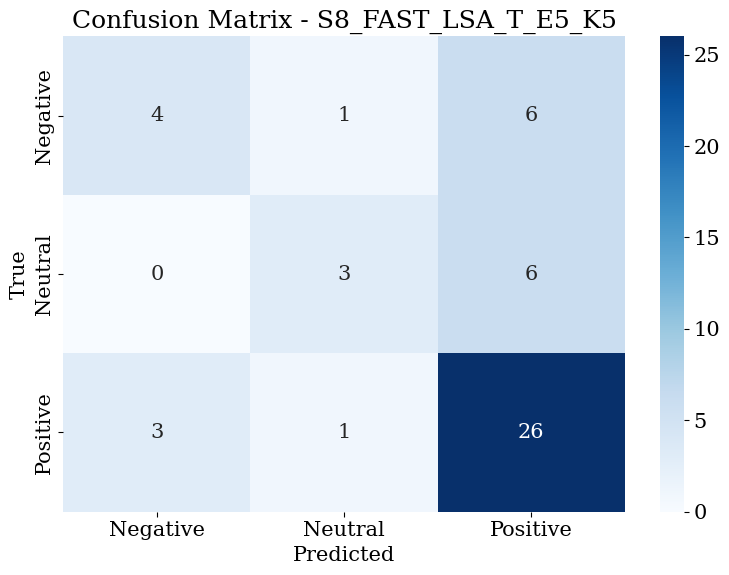

In [ ]:
# ============================================================
# S10: FAST_LSA_T - Epoch=5, K-Fold=5
# ============================================================

scenario = TRAINING_SCENARIOS[9]  # S10
scenario_name = scenario["name"]

results_s8 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 5),
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

### S11

In [ ]:
# ============================================================
# S11: FAST_LSA_T - Epoch=7, K-Fold=5
# ============================================================

scenario = TRAINING_SCENARIOS[10]  # S11
scenario_name = scenario["name"]

results_s10 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 5),
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

### S12

In [ ]:
# ============================================================
# S12: FAST_LSA_T - Epoch=9, K-Fold=5
# ============================================================

scenario = TRAINING_SCENARIOS[11]  # S12
scenario_name = scenario["name"]

results_s12 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 5),
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

### S13

In [ ]:
# ============================================================
# S13: FAST_LSA_T - Epoch=11, K-Fold=5
# ============================================================

scenario = TRAINING_SCENARIOS[12]  # S13
scenario_name = scenario["name"]

results_s12 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 5),
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

### S14

In [ ]:
# ============================================================
# S14: FAST_LSA_T - Epoch=5, K-Fold=10
# ============================================================

scenario = TRAINING_SCENARIOS[13]  # S14
scenario_name = scenario["name"]

results_s9 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 10),
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

### S15

In [ ]:
# ============================================================
# S15: FAST_LSA_T - Epoch=7, K-Fold=10
# ============================================================

scenario = TRAINING_SCENARIOS[14]  # S15
scenario_name = scenario["name"]

results_s11 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 10),
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

[2026-01-06 14:43:08] (2.4.2) Set Model Device: cuda:0
[2026-01-06 14:43:08] (2.4.2) Device Name: Tesla T4


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=581) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


2026-01-06 14:43:09,629 INFO: PyABSA version: 2.4.2


INFO:fast_lsa_t:PyABSA version: 2.4.2


2026-01-06 14:43:09,631 INFO: Transformers version: 4.57.3


INFO:fast_lsa_t:Transformers version: 4.57.3


2026-01-06 14:43:09,632 INFO: Torch version: 2.9.0+cu126+cuda12.6


INFO:fast_lsa_t:Torch version: 2.9.0+cu126+cuda12.6


2026-01-06 14:43:09,634 INFO: Device: Tesla T4


INFO:fast_lsa_t:Device: Tesla T4


[2026-01-06 14:43:09] (2.4.2) Try to load ['/content/drive/MyDrive/Output_ABSA/dataset_skenario'] dataset from local disk


/usr/lib/python3.12/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe8dc3af070>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe8dc3af150>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe8dc3ae580>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe8dc3add30>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe8dc3ae7b0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe8dc3aea50>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe8dc3aeb30>


2026-01-06 14:43:27,876 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc


INFO:fast_lsa_t:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe8db393310>

preparing dataloader:   0%|          | 0/2415 [00:00<?, ?it/s]sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe8db393620>

preparing dataloader:   2%|▏         | 48/2415 [00:00<00:04, 478.45it/s]sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe8db393850>

preparing dataloader:   4%|▍         | 96/2415 [00:00<00:04, 474.44it/s]sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe8db3939a0>

preparing dataloader:   6%|▌         | 144/2415 [00:00<00:05, 392.37it/s]sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe8db393770>

preparing dataloader:   8%|▊         | 197/2415 [00:00<00:05, 439.13it/s]sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe8db393af0>

preparing dataloader:  10%|█         | 252/2415 [00:00<00:04, 466.58it/s]sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe8db393b60>

p

2026-01-06 14:43:33,960 INFO: Dataset Label Details: {'2': 1622, '1': 302, '0': 491, 'Sum': 2415}


INFO:fast_lsa_t:Dataset Label Details: {'2': 1622, '1': 302, '0': 491, 'Sum': 2415}
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe8db3934d0>


2026-01-06 14:43:36,280 INFO: train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9688, 0.9375, 0.9062, 0.8750,
        0.8438, 0.8125, 0.7812, 0.7500, 0.7188, 0.6875, 0.6562, 0.6250, 0.5938,
        0.5625, 0.5312, 0.5000, 0.4688, 0.4375, 0.4062, 0.3750, 0.3438, 0.3125,
        0.2812, 0.2500, 0.2188, 0.1875, 0.1562, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

INFO:fast_lsa_t:train data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut', 'text_spc': '[CLS]  Fleksibilitas halo artikel baru sudah tayang kupas tuntas seputar keterwakilan perempuan dalam pemilu melalui artikel terbaru ini demokrasi egaliter perempuan dalam pemilu simak selengkapnya melalui link berikut [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9688, 0.9375, 0.9062, 0.8750,
        0.8438, 0.8125, 0.7812, 0.7500, 0.7188, 0.6875, 0.6562, 0.6250, 0.5938,
        0.5625, 0.5312, 0.5000, 0.4688, 0.4375, 0.4062, 0.3750, 0.3438, 0.3125,
        0.2812, 0.2500, 0.2188, 0.1875, 0.1562, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 

2026-01-06 14:43:37,100 INFO: Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc


INFO:fast_lsa_t:Load dataset from drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc
preparing dataloader: 100%|██████████| 50/50 [00:00<00:00, 1432.55it/s]


2026-01-06 14:43:37,144 INFO: Dataset Label Details: {'2': 30, '1': 9, '0': 11, 'Sum': 50}


INFO:fast_lsa_t:Dataset Label Details: {'2': 30, '1': 9, '0': 11, 'Sum': 50}


2026-01-06 14:43:37,189 INFO: test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9655, 0.9310, 0.8966, 0.8621,
        0.8276, 0.7931, 0.7586, 0.7241, 0.6897, 0.6552, 0.6207, 0.5862, 0.5517,
        0.5172, 0.4828, 0.4483, 0.4138, 0.3793, 0.3448, 0.3103, 0.2759, 0.2414,
        0.2069, 0.1724, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.000

INFO:fast_lsa_t:test data examples:
 [{'ex_id': tensor(0), 'text_raw': ' Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden', 'text_spc': '[CLS]  Fleksibilitas sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden [SEP] Fleksibilitas [SEP]', 'aspect': 'Fleksibilitas', 'aspect_position': tensor(0), 'lca_ids': tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9655, 0.9310, 0.8966, 0.8621,
        0.8276, 0.7931, 0.7586, 0.7241, 0.6897, 0.6552, 0.6207, 0.5862, 0.5517,
        0.5172, 0.4828, 0.4483, 0.4138, 0.3793, 0.3448, 0.3103, 0.2759, 0.2414,
        0.2069, 0.1724, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

2026-01-06 14:43:37,194 INFO: valid data examples:
 []


INFO:fast_lsa_t:valid data examples:
 []


2026-01-06 14:43:47,113 INFO: cuda memory allocated:552122880


INFO:fast_lsa_t:cuda memory allocated:552122880


2026-01-06 14:43:47,119 INFO: Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_T(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
       

INFO:fast_lsa_t:Model Architecture:
 APCEnsembler(
  (models): ModuleList(
    (0): FAST_LSA_T(
      (bert4global): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(50000, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (outp

2026-01-06 14:43:47,124 INFO: ABSADatasetsVersion:None	-->	Calling Count:0


INFO:fast_lsa_t:ABSADatasetsVersion:None	-->	Calling Count:0


2026-01-06 14:43:47,125 INFO: MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7fe8de3a2090>	-->	Calling Count:0


INFO:fast_lsa_t:MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7fe8de3a2090>	-->	Calling Count:0


2026-01-06 14:43:47,126 INFO: PyABSAVersion:2.4.2	-->	Calling Count:1


INFO:fast_lsa_t:PyABSAVersion:2.4.2	-->	Calling Count:1


2026-01-06 14:43:47,130 INFO: SRD:3	-->	Calling Count:2465


INFO:fast_lsa_t:SRD:3	-->	Calling Count:2465


2026-01-06 14:43:47,132 INFO: TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


INFO:fast_lsa_t:TorchVersion:2.9.0+cu126+cuda12.6	-->	Calling Count:1


2026-01-06 14:43:47,135 INFO: TransformersVersion:4.57.3	-->	Calling Count:1


INFO:fast_lsa_t:TransformersVersion:4.57.3	-->	Calling Count:1


2026-01-06 14:43:47,138 INFO: auto_device:True	-->	Calling Count:3


INFO:fast_lsa_t:auto_device:True	-->	Calling Count:3


2026-01-06 14:43:47,140 INFO: batch_size:16	-->	Calling Count:2


INFO:fast_lsa_t:batch_size:16	-->	Calling Count:2


2026-01-06 14:43:47,143 INFO: cache_dataset:False	-->	Calling Count:1


INFO:fast_lsa_t:cache_dataset:False	-->	Calling Count:1


2026-01-06 14:43:47,146 INFO: checkpoint_save_mode:1	-->	Calling Count:4


INFO:fast_lsa_t:checkpoint_save_mode:1	-->	Calling Count:4


2026-01-06 14:43:47,148 INFO: cross_validate_fold:10	-->	Calling Count:1


INFO:fast_lsa_t:cross_validate_fold:10	-->	Calling Count:1


2026-01-06 14:43:47,151 INFO: dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


INFO:fast_lsa_t:dataset_file:{'train': ['drive/MyDrive/Output_ABSA/dataset_skenario/train_2400_final.apc'], 'test': ['drive/MyDrive/Output_ABSA/dataset_skenario/test_50_final.apc'], 'valid': []}	-->	Calling Count:15


2026-01-06 14:43:47,154 INFO: dataset_name:custom_dataset	-->	Calling Count:3


INFO:fast_lsa_t:dataset_name:custom_dataset	-->	Calling Count:3


2026-01-06 14:43:47,156 INFO: dca_layer:3	-->	Calling Count:0


INFO:fast_lsa_t:dca_layer:3	-->	Calling Count:0


2026-01-06 14:43:47,158 INFO: dca_p:1	-->	Calling Count:0


INFO:fast_lsa_t:dca_p:1	-->	Calling Count:0


2026-01-06 14:43:47,160 INFO: deep_ensemble:False	-->	Calling Count:0


INFO:fast_lsa_t:deep_ensemble:False	-->	Calling Count:0


2026-01-06 14:43:47,163 INFO: device:cuda:0	-->	Calling Count:4


INFO:fast_lsa_t:device:cuda:0	-->	Calling Count:4


2026-01-06 14:43:47,165 INFO: device_name:Tesla T4	-->	Calling Count:1


INFO:fast_lsa_t:device_name:Tesla T4	-->	Calling Count:1


2026-01-06 14:43:47,167 INFO: dlcf_a:2	-->	Calling Count:0


INFO:fast_lsa_t:dlcf_a:2	-->	Calling Count:0


2026-01-06 14:43:47,169 INFO: dropout:0.1	-->	Calling Count:1


INFO:fast_lsa_t:dropout:0.1	-->	Calling Count:1


2026-01-06 14:43:47,172 INFO: dynamic_truncate:True	-->	Calling Count:4930


INFO:fast_lsa_t:dynamic_truncate:True	-->	Calling Count:4930


2026-01-06 14:43:47,174 INFO: embed_dim:768	-->	Calling Count:7


INFO:fast_lsa_t:embed_dim:768	-->	Calling Count:7


2026-01-06 14:43:47,176 INFO: eta:1	-->	Calling Count:0


INFO:fast_lsa_t:eta:1	-->	Calling Count:0


2026-01-06 14:43:47,178 INFO: eta_lr:0.1	-->	Calling Count:1


INFO:fast_lsa_t:eta_lr:0.1	-->	Calling Count:1


2026-01-06 14:43:47,181 INFO: eval_step:50	-->	Calling Count:0


INFO:fast_lsa_t:eval_step:50	-->	Calling Count:0


2026-01-06 14:43:47,184 INFO: evaluate_begin:0	-->	Calling Count:0


INFO:fast_lsa_t:evaluate_begin:0	-->	Calling Count:0


2026-01-06 14:43:47,185 INFO: from_checkpoint:None	-->	Calling Count:0


INFO:fast_lsa_t:from_checkpoint:None	-->	Calling Count:0


2026-01-06 14:43:47,188 INFO: gradient_accumulation_steps:1	-->	Calling Count:0


INFO:fast_lsa_t:gradient_accumulation_steps:1	-->	Calling Count:0


2026-01-06 14:43:47,190 INFO: hidden_dim:768	-->	Calling Count:0


INFO:fast_lsa_t:hidden_dim:768	-->	Calling Count:0


2026-01-06 14:43:47,193 INFO: index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


INFO:fast_lsa_t:index_to_label:{0: '0', 1: '1', 2: '2'}	-->	Calling Count:2


2026-01-06 14:43:47,195 INFO: inference_model:None	-->	Calling Count:0


INFO:fast_lsa_t:inference_model:None	-->	Calling Count:0


2026-01-06 14:43:47,197 INFO: initializer:xavier_uniform_	-->	Calling Count:0


INFO:fast_lsa_t:initializer:xavier_uniform_	-->	Calling Count:0


2026-01-06 14:43:47,200 INFO: inputs_cols:['lcf_vec', 'left_lcf_vec', 'right_lcf_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


INFO:fast_lsa_t:inputs_cols:['lcf_vec', 'left_lcf_vec', 'right_lcf_vec', 'spc_mask_vec', 'text_indices']	-->	Calling Count:36980


2026-01-06 14:43:47,203 INFO: l2reg:1e-06	-->	Calling Count:2


INFO:fast_lsa_t:l2reg:1e-06	-->	Calling Count:2


2026-01-06 14:43:47,205 INFO: label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


INFO:fast_lsa_t:label_to_index:{'0': 0, '1': 1, '2': 2}	-->	Calling Count:0


2026-01-06 14:43:47,208 INFO: lcf:cdw	-->	Calling Count:0


INFO:fast_lsa_t:lcf:cdw	-->	Calling Count:0


2026-01-06 14:43:47,210 INFO: learning_rate:2e-05	-->	Calling Count:1


INFO:fast_lsa_t:learning_rate:2e-05	-->	Calling Count:1


2026-01-06 14:43:47,212 INFO: load_aug:False	-->	Calling Count:1


INFO:fast_lsa_t:load_aug:False	-->	Calling Count:1


2026-01-06 14:43:47,215 INFO: log_step:50	-->	Calling Count:0


INFO:fast_lsa_t:log_step:50	-->	Calling Count:0


2026-01-06 14:43:47,218 INFO: logger:<Logger fast_lsa_t (INFO)>	-->	Calling Count:14


INFO:fast_lsa_t:logger:<Logger fast_lsa_t (INFO)>	-->	Calling Count:14


2026-01-06 14:43:47,221 INFO: lsa:False	-->	Calling Count:0


INFO:fast_lsa_t:lsa:False	-->	Calling Count:0


2026-01-06 14:43:47,223 INFO: max_seq_len:128	-->	Calling Count:22185


INFO:fast_lsa_t:max_seq_len:128	-->	Calling Count:22185


2026-01-06 14:43:47,225 INFO: model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_t.FAST_LSA_T'>	-->	Calling Count:6


INFO:fast_lsa_t:model:<class 'pyabsa.tasks.AspectPolarityClassification.models.__lcf__.fast_lsa_t.FAST_LSA_T'>	-->	Calling Count:6


2026-01-06 14:43:47,229 INFO: model_name:fast_lsa_t	-->	Calling Count:4932


INFO:fast_lsa_t:model_name:fast_lsa_t	-->	Calling Count:4932


2026-01-06 14:43:47,231 INFO: model_path_to_save:checkpoints	-->	Calling Count:0


INFO:fast_lsa_t:model_path_to_save:checkpoints	-->	Calling Count:0


2026-01-06 14:43:47,233 INFO: num_epoch:7	-->	Calling Count:0


INFO:fast_lsa_t:num_epoch:7	-->	Calling Count:0


2026-01-06 14:43:47,236 INFO: optimizer:adamw	-->	Calling Count:1


INFO:fast_lsa_t:optimizer:adamw	-->	Calling Count:1


2026-01-06 14:43:47,241 INFO: output_dim:3	-->	Calling Count:3


INFO:fast_lsa_t:output_dim:3	-->	Calling Count:3


2026-01-06 14:43:47,242 INFO: overwrite_cache:False	-->	Calling Count:0


INFO:fast_lsa_t:overwrite_cache:False	-->	Calling Count:0


2026-01-06 14:43:47,246 INFO: path_to_save:None	-->	Calling Count:1


INFO:fast_lsa_t:path_to_save:None	-->	Calling Count:1


2026-01-06 14:43:47,248 INFO: patience:99999	-->	Calling Count:0


INFO:fast_lsa_t:patience:99999	-->	Calling Count:0


2026-01-06 14:43:47,252 INFO: pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


INFO:fast_lsa_t:pretrained_bert:indobenchmark/indobert-base-p2	-->	Calling Count:5


2026-01-06 14:43:47,253 INFO: save_mode:1	-->	Calling Count:0


INFO:fast_lsa_t:save_mode:1	-->	Calling Count:0


2026-01-06 14:43:47,258 INFO: seed:42	-->	Calling Count:7


INFO:fast_lsa_t:seed:42	-->	Calling Count:7


2026-01-06 14:43:47,260 INFO: sigma:0.3	-->	Calling Count:0


INFO:fast_lsa_t:sigma:0.3	-->	Calling Count:0


2026-01-06 14:43:47,263 INFO: similarity_threshold:1	-->	Calling Count:2


INFO:fast_lsa_t:similarity_threshold:1	-->	Calling Count:2


2026-01-06 14:43:47,266 INFO: spacy_model:en_core_web_sm	-->	Calling Count:3


INFO:fast_lsa_t:spacy_model:en_core_web_sm	-->	Calling Count:3


2026-01-06 14:43:47,270 INFO: srd_alignment:True	-->	Calling Count:0


INFO:fast_lsa_t:srd_alignment:True	-->	Calling Count:0


2026-01-06 14:43:47,272 INFO: task_code:APC	-->	Calling Count:1


INFO:fast_lsa_t:task_code:APC	-->	Calling Count:1


2026-01-06 14:43:47,275 INFO: task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


INFO:fast_lsa_t:task_name:Aspect-based Sentiment Classification	-->	Calling Count:0


2026-01-06 14:43:47,279 INFO: tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Callin

INFO:fast_lsa_t:tokenizer:BertTokenizerFast(name_or_path='indobenchmark/indobert-base-p2', vocab_size=30521, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)	-->	Calling Count:0


2026-01-06 14:43:47,281 INFO: train_test_split:False	-->	Calling Count:0


INFO:fast_lsa_t:train_test_split:False	-->	Calling Count:0


2026-01-06 14:43:47,284 INFO: use_amp:False	-->	Calling Count:1


INFO:fast_lsa_t:use_amp:False	-->	Calling Count:1


2026-01-06 14:43:47,285 INFO: use_bert_spc:True	-->	Calling Count:0


INFO:fast_lsa_t:use_bert_spc:True	-->	Calling Count:0


2026-01-06 14:43:47,286 INFO: use_syntax_based_SRD:False	-->	Calling Count:0


INFO:fast_lsa_t:use_syntax_based_SRD:False	-->	Calling Count:0


2026-01-06 14:43:47,287 INFO: warmup_proportion:0.1	-->	Calling Count:0


INFO:fast_lsa_t:warmup_proportion:0.1	-->	Calling Count:0


2026-01-06 14:43:47,289 INFO: warmup_step:-1	-->	Calling Count:0


INFO:fast_lsa_t:warmup_step:-1	-->	Calling Count:0


2026-01-06 14:43:47,290 INFO: window:lr	-->	Calling Count:0


INFO:fast_lsa_t:window:lr	-->	Calling Count:0


2026-01-06 14:43:47,292 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_t:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 14:43:47,294 INFO: Training set examples = 2415


INFO:fast_lsa_t:Training set examples = 2415


2026-01-06 14:43:47,295 INFO: Test set examples = 50


INFO:fast_lsa_t:Test set examples = 50


2026-01-06 14:43:47,296 INFO: Batch size = 16


INFO:fast_lsa_t:Batch size = 16


2026-01-06 14:43:47,298 INFO: Num steps = 56


INFO:fast_lsa_t:Num steps = 56


2026-01-06 14:43:47,299 INFO: No. 1 trainer in 10 folds


INFO:fast_lsa_t:No. 1 trainer in 10 folds
Epoch:0 | Loss:0:   0%|          | 0/136 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
Epoch:  0 | Smooth Loss: 0.8154:  36%|███▌      | 49/136 [00:19<00:32,  2.66it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.6703:  73%|███████▎  | 99/136 [00:58<00:14,  2.57it/s, Dev Acc:77.69(max:77.69) Dev F1:43.32(max:43.32)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a futu

2026-01-06 14:56:39,026 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [59.399063269032304] │  59.3991  │ 59.3991  │   0   │   0   │ 59.3991 │ 59.3991 │
╘════════════════════╧════════════╧══════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
--------------------------

INFO:fast_lsa_t:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [59.399063269032304] │  59.3991  │ 59.3991  │   0   │   0   │ 59.3991 │ 59.3991 │
╘════════════════════╧════════════╧══════════════════════╧═══════════╧══════════╧═══════╧═══════╧═════════╧═════════╛
---------------------------------- https

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_t_custom_dataset_acc_92.15_f1_83.14/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_92.15_f1_83.14/_0.003923838026821613/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_92.15_f1_83.14/_0.15677276253700256/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_92.15_f1_83.14/_0.006529392674565315/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_92.15_f1_83.14/_0.01248372532427311/fast_lsa_t.state_dict'] found, only return the shortest path: <checkpoints/fast_lsa_t_custom_dataset_acc_92.15_f1_83.14/fast_lsa_t.state_dict>
2026-01-06 14:56:39,389 INFO: ***** Running training for Aspect-based Sentiment Classification *****


INFO:fast_lsa_t:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 14:56:39,391 INFO: Training set examples = 2415


INFO:fast_lsa_t:Training set examples = 2415


2026-01-06 14:56:39,394 INFO: Test set examples = 50


INFO:fast_lsa_t:Test set examples = 50


2026-01-06 14:56:39,396 INFO: Batch size = 16


INFO:fast_lsa_t:Batch size = 16


2026-01-06 14:56:39,398 INFO: Num steps = 56


INFO:fast_lsa_t:Num steps = 56


2026-01-06 14:56:39,401 INFO: No. 2 trainer in 10 folds


INFO:fast_lsa_t:No. 2 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.1874:  36%|███▌      | 49/136 [00:19<00:36,  2.40it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1818:  73%|███████▎  | 99/136 [00:55<00:15,  2.34it/s, Dev Acc:98.76(max:98.76) Dev F1:98.31(max:98.31)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1793: 100%|██████████| 136/136 [01:21<00:00,  1.66it/s, Dev Acc:98.76(max:98.

2026-01-06 15:05:55,357 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [59.399063269032304] │  59.3991  │ 59.3991  │   0   │   0   │ 59.3991 │ 59.3991 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_t:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [59.399063269032304] │  59.3991  │ 59.3991  │   0   │   0   │ 59.3991 │ 59.3991 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_t │ [72.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_t_custom_dataset_acc_98.76_f1_98.77/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.76_f1_98.77/_0.2883533835411072/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.76_f1_98.77/_0.0014154044911265373/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.76_f1_98.77/_0.018774069845676422/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.76_f1_98.77/_0.003685801522806287/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.76_f1_98.77/_0.002186369616538286/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.76_f1_98.77/_0.0017391026485711336/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.76_f1_98.77/_0.016776785254478455/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.76_f1_98.77/_0.005895994603633881/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_98.7

INFO:fast_lsa_t:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 15:05:57,739 INFO: Training set examples = 2415


INFO:fast_lsa_t:Training set examples = 2415


2026-01-06 15:05:57,740 INFO: Test set examples = 50


INFO:fast_lsa_t:Test set examples = 50


2026-01-06 15:05:57,742 INFO: Batch size = 16


INFO:fast_lsa_t:Batch size = 16


2026-01-06 15:05:57,744 INFO: Num steps = 56


INFO:fast_lsa_t:Num steps = 56


2026-01-06 15:05:57,746 INFO: No. 3 trainer in 10 folds


INFO:fast_lsa_t:No. 3 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.1179:  36%|███▌      | 49/136 [00:20<00:36,  2.38it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1170:  73%|███████▎  | 99/136 [00:51<00:15,  2.40it/s, Dev Acc:98.76(max:98.76) Dev F1:98.16(max:98.16)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.1165: 100%|██████████| 136/136 [01:16<00:00,  1.78it/s, Dev Acc:98.76(max:98.

2026-01-06 15:15:07,804 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [59.399063269032304] │  59.3991  │ 59.3991  │   0   │   0   │ 59.3991 │ 59.3991 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_t:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [59.399063269032304] │  59.3991  │ 59.3991  │   0   │   0   │ 59.3991 │ 59.3991 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_t │ [72.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.47/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.47/_0.11958442628383636/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.47/_0.003650470171123743/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.47/_0.3443683087825775/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.47/_0.003931325860321522/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.47/_0.0015296454075723886/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.47/_0.002021798398345709/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.47/_0.004198884591460228/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.47/_0.0019314639503136277/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59

INFO:fast_lsa_t:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 15:15:10,083 INFO: Training set examples = 2415


INFO:fast_lsa_t:Training set examples = 2415


2026-01-06 15:15:10,084 INFO: Test set examples = 50


INFO:fast_lsa_t:Test set examples = 50


2026-01-06 15:15:10,085 INFO: Batch size = 16


INFO:fast_lsa_t:Batch size = 16


2026-01-06 15:15:10,087 INFO: Num steps = 56


INFO:fast_lsa_t:Num steps = 56


2026-01-06 15:15:10,089 INFO: No. 4 trainer in 10 folds


INFO:fast_lsa_t:No. 4 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0906:  36%|███▌      | 49/136 [00:19<00:35,  2.43it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0897:  73%|███████▎  | 99/136 [00:55<00:15,  2.35it/s, Dev Acc:99.17(max:99.17) Dev F1:98.96(max:98.96)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0898: 100%|██████████| 136/136 [01:17<00:00,  1.75it/s, Dev Acc:99.59(max:99.

2026-01-06 15:24:31,520 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [59.399063269032304] │  59.3991  │ 59.3991  │   0   │   0   │ 59.3991 │ 59.3991 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_t:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [59.399063269032304] │  59.3991  │ 59.3991  │   0   │   0   │ 59.3991 │ 59.3991 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_t │ [72.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.24695956707000732/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0058652861043810844/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0011957029346376657/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.19573622941970825/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0026596765965223312/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.17835015058517456/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0018056744011119008/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0011301713529974222/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_10

INFO:fast_lsa_t:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 15:24:33,904 INFO: Training set examples = 2415


INFO:fast_lsa_t:Training set examples = 2415


2026-01-06 15:24:33,907 INFO: Test set examples = 50


INFO:fast_lsa_t:Test set examples = 50


2026-01-06 15:24:33,908 INFO: Batch size = 16


INFO:fast_lsa_t:Batch size = 16


2026-01-06 15:24:33,910 INFO: Num steps = 56


INFO:fast_lsa_t:Num steps = 56


2026-01-06 15:24:33,912 INFO: No. 5 trainer in 10 folds


INFO:fast_lsa_t:No. 5 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0784:  36%|███▌      | 49/136 [00:20<00:37,  2.35it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0776:  73%|███████▎  | 99/136 [00:50<00:15,  2.34it/s, Dev Acc:100.00(max:100.00) Dev F1:100.00(max:100.00)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0770: 100%|██████████| 136/136 [01:10<00:00,  1.94it/s, Dev Acc:100.00(ma

2026-01-06 15:33:48,146 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [59.399063269032304] │  59.3991  │ 59.3991  │   0   │   0   │ 59.3991 │ 59.3991 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_t:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [59.399063269032304] │  59.3991  │ 59.3991  │   0   │   0   │ 59.3991 │ 59.3991 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_t │ [72.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.00459838705137372/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0006700007943436503/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.24695956707000732/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0009173406288027763/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.002592236502096057/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0058652861043810844/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0014317733002826571/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0006384649313986301/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_1

INFO:fast_lsa_t:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 15:33:50,652 INFO: Training set examples = 2415


INFO:fast_lsa_t:Training set examples = 2415


2026-01-06 15:33:50,655 INFO: Test set examples = 50


INFO:fast_lsa_t:Test set examples = 50


2026-01-06 15:33:50,656 INFO: Batch size = 16


INFO:fast_lsa_t:Batch size = 16


2026-01-06 15:33:50,659 INFO: Num steps = 56


INFO:fast_lsa_t:Num steps = 56


2026-01-06 15:33:50,662 INFO: No. 6 trainer in 10 folds


INFO:fast_lsa_t:No. 6 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0665:  36%|███▌      | 49/136 [00:19<00:36,  2.41it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0660:  73%|███████▎  | 99/136 [00:50<00:15,  2.33it/s, Dev Acc:99.59(max:99.59) Dev F1:99.44(max:99.44)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0657: 100%|██████████| 136/136 [01:19<00:00,  1.71it/s, Dev Acc:99.17(max:99.

2026-01-06 15:43:01,059 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [59.399063269032304] │  59.3991  │ 59.3991  │   0   │   0   │ 59.3991 │ 59.3991 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_t:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [59.399063269032304] │  59.3991  │ 59.3991  │   0   │   0   │ 59.3991 │ 59.3991 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_t │ [72.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.44/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.44/_0.0004956739721819758/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.44/_0.0006035161204636097/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.44/_0.0007122269016690552/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.44/_0.0008501248667016625/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.44/_0.0007175533683039248/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.44/_0.0020813248120248318/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.44/_0.0006555269355885684/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_99.59_f1_99.44/_0.0014253116678446531/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_

INFO:fast_lsa_t:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 15:43:03,385 INFO: Training set examples = 2415


INFO:fast_lsa_t:Training set examples = 2415


2026-01-06 15:43:03,386 INFO: Test set examples = 50


INFO:fast_lsa_t:Test set examples = 50


2026-01-06 15:43:03,388 INFO: Batch size = 16


INFO:fast_lsa_t:Batch size = 16


2026-01-06 15:43:03,389 INFO: Num steps = 56


INFO:fast_lsa_t:Num steps = 56


2026-01-06 15:43:03,391 INFO: No. 7 trainer in 10 folds


INFO:fast_lsa_t:No. 7 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0600:  36%|███▌      | 49/136 [00:20<00:37,  2.33it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0598:  73%|███████▎  | 99/136 [00:50<00:15,  2.40it/s, Dev Acc:99.59(max:99.59) Dev F1:99.16(max:99.16)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0597: 100%|██████████| 136/136 [01:16<00:00,  1.77it/s, Dev Acc:100.00(max:10

2026-01-06 15:51:58,459 INFO: 
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [59.399063269032304] │  59.3991  │ 59.3991  │   0   │   0   │ 59.3991 │ 59.3991 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fas

INFO:fast_lsa_t:
------------------------------------------------ Raw Metric Records ------------------------------------------------
╒════════════════════╤════════════╤══════════════════════╤═══════════╤══════════╤═══════╤═══════╤═════════╤═════════╕
│ Metric             │ Trial      │ Values               │  Average  │  Median  │  Std  │  IQR  │   Min   │   Max   │
╞════════════════════╪════════════╪══════════════════════╪═══════════╪══════════╪═══════╪═══════╪═════════╪═════════╡
│ Fold0-Max-Test-Acc │ fast_lsa_t │ [70.0]               │    70     │    70    │   0   │   0   │   70    │   70    │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold0-Max-Test-F1  │ fast_lsa_t │ [59.399063269032304] │  59.3991  │ 59.3991  │   0   │   0   │ 59.3991 │ 59.3991 │
├────────────────────┼────────────┼──────────────────────┼───────────┼──────────┼───────┼───────┼─────────┼─────────┤
│ Fold1-Max-Test-Acc │ fast_lsa_t │ [72.

FindFile Warning --> multiple targets ['checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.00459838705137372/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0021892087534070015/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0011208814103156328/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0006700007943436503/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.24695956707000732/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0006801389390602708/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0009173406288027763/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.002069297945126891/fast_lsa_t.state_dict', 'checkpoints/fast_lsa_t_custom_dataset_acc_1

INFO:fast_lsa_t:***** Running training for Aspect-based Sentiment Classification *****


2026-01-06 15:52:00,784 INFO: Training set examples = 2415


INFO:fast_lsa_t:Training set examples = 2415


2026-01-06 15:52:00,786 INFO: Test set examples = 50


INFO:fast_lsa_t:Test set examples = 50


2026-01-06 15:52:00,789 INFO: Batch size = 16


INFO:fast_lsa_t:Batch size = 16


2026-01-06 15:52:00,792 INFO: Num steps = 56


INFO:fast_lsa_t:Num steps = 56


2026-01-06 15:52:00,794 INFO: No. 8 trainer in 10 folds


INFO:fast_lsa_t:No. 8 trainer in 10 folds
Epoch:  0 | Smooth Loss: 0.0550:  36%|███▌      | 49/136 [00:19<00:35,  2.46it/s]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0549:  73%|███████▎  | 99/136 [00:51<00:15,  2.33it/s, Dev Acc:99.17(max:99.17) Dev F1:98.01(max:98.01)]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Epoch:  0 | Smooth Loss: 0.0548: 100%|██████████| 136/136 [01:16<00:00,  1.78it/s, Dev Acc:99.17(max:99.

### S16

In [ ]:
# ============================================================
# S16: FAST_LSA_T - Epoch=9, K-Fold=10
# ============================================================

scenario = TRAINING_SCENARIOS[15]  # S16
scenario_name = scenario["name"]

results_s13 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 10),
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

## S17

In [ ]:
# ============================================================
# S17: FAST_LSA_T - Epoch=11, K-Fold=10
# ============================================================

scenario = TRAINING_SCENARIOS[16]  # S17
scenario_name = scenario["name"]

results_s13 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 10),
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

### S18

In [ ]:
# ============================================================
# S18: FAST_LSA_T - Fine-tuning
# ============================================================

scenario = TRAINING_SCENARIOS[17]  # S18
scenario_name = scenario["name"]

results_s14, model_s14 = run_training_and_evaluate(
    scenario_name=scenario_name,
    model_type=scenario["model"],
    pretrained_bert="indobenchmark/indobert-base-p2",
    num_epoch=scenario["num_epoch"],
    batch_size=scenario["batch_size"],
    learning_rate=scenario["learning_rate"],
    max_seq_len=scenario.get("max_seq_len", 128),
    k_fold=scenario.get("k_fold", 5),
    final_test_data=final_test_data,
    warmup_ratio=scenario.get("warmup", 0),
    gradient_accumulation_steps=scenario.get("gradient_accumulation", 1),
    dropout=scenario.get("dropout", 0)
)

In [ ]:
checkpoint_s14 = (
    CHECKPOINT_SKENARIO
    / "S14_FAST_LSA_T_FINETUNE"
    / "fast_lsa_t_custom_dataset_acc_99.58_f1_99.42"
)

results_s14 = evaluate_from_checkpoint(
    scenario_name="S14_FAST_LSA_T_FINETUNE",
    checkpoint_path=str(checkpoint_s14),
    test_data=final_test_data
)


## 13. Summary & Comparison All 14 Scenarios

In [ ]:
import json
import pandas as pd
from pathlib import Path
import re

RESULTS_DIR = Path("/content/drive/MyDrive/Output_ABSA/results_skenario")

rows = []

for f in RESULTS_DIR.glob("*.json"):
    with open(f, "r") as fp:
        r = json.load(fp)

    scenario_name = r.get("scenario", f.stem)

    # Ambil nomor skenario (S1, S2, ..., S14)
    m = re.search(r"S(\d+)", scenario_name)
    scenario_id = int(m.group(1)) if m else 999

    rows.append({
        "No": scenario_id,
        "Scenario": scenario_name,
        "Model": r.get("model", "-"),
        "Accuracy": r.get("accuracy", 0),
        "Precision": r.get("precision", 0),
        "Recall": r.get("recall", 0),
        "F1-Score": r.get("f1_score", 0)
    })

df = pd.DataFrame(rows)


df_sorted = df.sort_values("No").reset_index(drop=True)


print("="*80)
print("TABEL HASIL EVALUASI 14 SKENARIO (URUT S1–S14)")
print("="*80)

display(
    df_sorted.drop(columns=["No"]).style.format({
        "Accuracy": "{:.4f}",
        "Precision": "{:.4f}",
        "Recall": "{:.4f}",
        "F1-Score": "{:.4f}"
    })
)

csv_path = RESULTS_DIR / "rekap_14_skenario.csv"
df_sorted.drop(columns=["No"]).to_csv(csv_path, index=False)
print(f"\nFile rekap disimpan di: {csv_path}")

TABEL HASIL EVALUASI 14 SKENARIO (URUT S1–S14)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



File rekap disimpan di: /content/drive/MyDrive/Output_ABSA/results_skenario/rekap_14_skenario.csv


In [ ]:
import json
import pandas as pd
from pathlib import Path

RESULTS_DIR = Path("/content/drive/MyDrive/Output_ABSA/results_skenario")

rows = []

for f in RESULTS_DIR.glob("*.json"):
    with open(f, "r") as fp:
        r = json.load(fp)

    rows.append({
        "scenario": r.get("scenario", f.stem),
        "model": r.get("model"),
        "accuracy": r.get("accuracy", 0),
        "precision": r.get("precision", 0),
        "recall": r.get("recall", 0),
        "f1_score": r.get("f1_score", 0)
    })

df = pd.DataFrame(rows)

# Sort by F1 first, then Accuracy
df_sorted = df.sort_values(
    by=["f1_score", "accuracy"],
    ascending=False
).reset_index(drop=True)

print("TOP 3 BEST SCENARIOS")
print("="*60)

top3 = df_sorted.head(3)

for i, row in top3.iterrows():
    print(f"\nRank #{i+1}")
    print("-"*40)
    print(f"Scenario  : {row['scenario']}")
    print(f"Model     : {row['model']}")
    print(f"Accuracy  : {row['accuracy']:.4f}")
    print(f"Precision : {row['precision']:.4f}")
    print(f"Recall    : {row['recall']:.4f}")
    print(f"F1-Score  : {row['f1_score']:.4f}")

top3

TOP 3 BEST SCENARIOS

Rank #1
----------------------------------------
Scenario  : S16_FAST_LSA_T_E9_K10
Model     : FAST_LSA_T
Accuracy  : 0.7400
Precision : 0.7454
Recall    : 0.7400
F1-Score  : 0.7195

Rank #2
----------------------------------------
Scenario  : S12_FAST_LSA_T_E9_K5
Model     : FAST_LSA_T
Accuracy  : 0.7200
Precision : 0.7150
Recall    : 0.7200
F1-Score  : 0.7018

Rank #3
----------------------------------------
Scenario  : S14_FAST_LSA_T_E5_K10
Model     : FAST_LSA_T
Accuracy  : 0.7000
Precision : 0.7052
Recall    : 0.7000
F1-Score  : 0.6765


scenario       model  accuracy  precision  recall  f1_score
0  S16_FAST_LSA_T_E9_K10  FAST_LSA_T      0.74   0.745439    0.74  0.719529
1   S12_FAST_LSA_T_E9_K5  FAST_LSA_T      0.72   0.714981    0.72  0.701804
2  S14_FAST_LSA_T_E5_K10  FAST_LSA_T      0.70   0.705173    0.70  0.676471

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


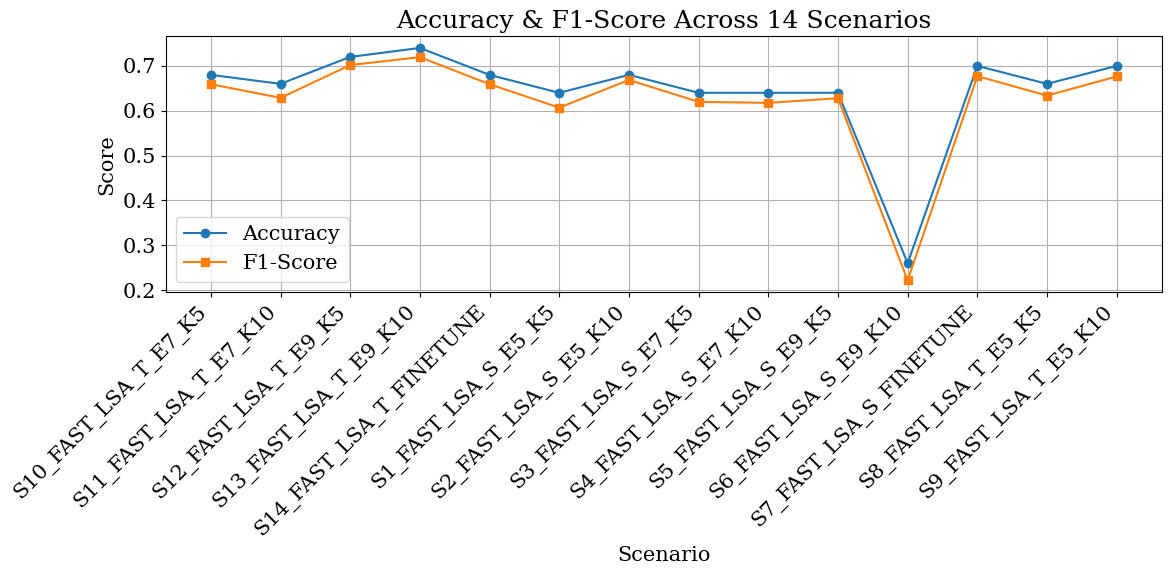

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json

RESULTS_DIR = Path("/content/drive/MyDrive/Output_ABSA/results_skenario")

rows = []
for f in RESULTS_DIR.glob("*.json"):
    with open(f) as fp:
        r = json.load(fp)
    rows.append({
        "scenario": r["scenario"],
        "accuracy": r["accuracy"],
        "f1_score": r["f1_score"]
    })

df = pd.DataFrame(rows).sort_values("scenario")

plt.figure(figsize=(12,6))
plt.plot(df["scenario"], df["accuracy"], marker='o', label="Accuracy")
plt.plot(df["scenario"], df["f1_score"], marker='s', label="F1-Score")

plt.xticks(rotation=45, ha="right")
plt.xlabel("Scenario")
plt.ylabel("Score")
plt.title("Accuracy & F1-Score Across 14 Scenarios")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 14. Evaluate Using Best Model

 BEST SCENARIO
Scenario  : S13_FAST_LSA_T_E9_K10
Model     : FAST_LSA_T
Accuracy  : 0.7400
Precision : 0.7454
Recall    : 0.7400
F1-Score  : 0.7195

Loading model from:
/content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10
[2026-01-04 00:46:20] (2.4.2) Load sentiment classifier from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0009199539199471474/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0007901195203885436/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



OVERALL RESULTS (BEST MODEL)
Accuracy : 0.7400
Precision: 0.7454
Recall   : 0.7400
F1-Score : 0.7195

Classification Report:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


              precision    recall  f1-score   support

    Negative       0.83      0.45      0.59        11
     Neutral       0.67      0.44      0.53         9
    Positive       0.74      0.93      0.82        30

    accuracy                           0.74        50
   macro avg       0.75      0.61      0.65        50
weighted avg       0.75      0.74      0.72        50


PER-ASPECT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Aspect: Keterwakilan
Samples : 10
Accuracy: 0.7000
F1-Score: 0.7282


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Aspect: Fleksibilitas
Samples : 10
Accuracy: 0.8000
F1-Score: 0.7529


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Aspect: Kebijakan dan Pelayanan Pemerintah
Samples : 10
Accuracy: 0.9000
F1-Score: 0.8938


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Aspect: Kompetensi Menteri
Samples : 10
Accuracy: 0.7000
F1-Score: 0.7067


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Aspect: Transparansi
Samples : 10
Accuracy: 0.6000
F1-Score: 0.4500


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


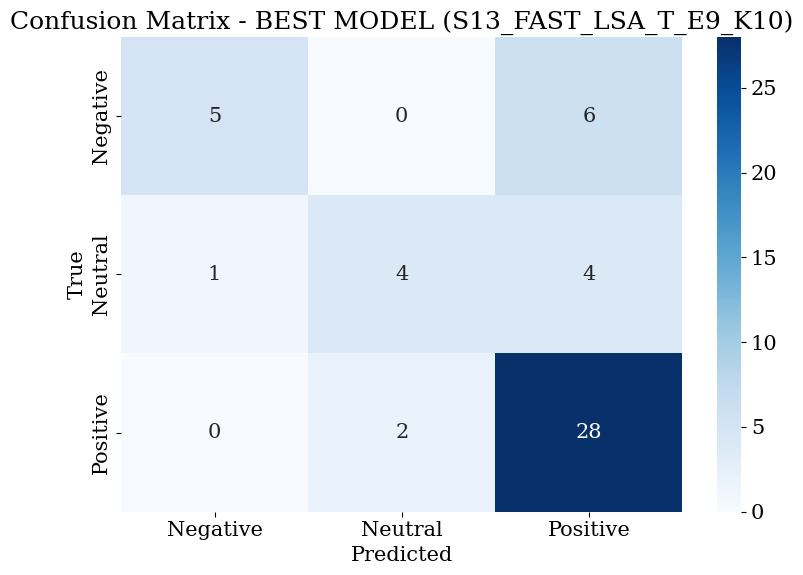


EVALUATION COMPLETE


In [ ]:
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from pyabsa import APCCheckpointManager
from pyabsa.tasks.AspectPolarityClassification import SentimentClassifier


RESULTS_DIR = Path("/content/drive/MyDrive/Output_ABSA/results_skenario")
CHECKPOINT_DIR = Path("/content/drive/MyDrive/Output_ABSA/checkpoints_skenario")
FIGURES_DIR = Path("/content/drive/MyDrive/Output_ABSA/figures_skenario")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

rows = []

for f in RESULTS_DIR.glob("*.json"):
    with open(f, "r") as fp:
        r = json.load(fp)

    rows.append({
        "scenario": r.get("scenario", f.stem),
        "model": r.get("model"),
        "accuracy": r.get("accuracy", 0),
        "precision": r.get("precision", 0),
        "recall": r.get("recall", 0),
        "f1_score": r.get("f1_score", 0)
    })

df = pd.DataFrame(rows)

df_sorted = df.sort_values(
    by=["f1_score", "accuracy"],
    ascending=False
).reset_index(drop=True)

best = df_sorted.iloc[0]

print("="*80)
print(" BEST SCENARIO")
print("="*80)
print(f"Scenario  : {best['scenario']}")
print(f"Model     : {best['model']}")
print(f"Accuracy  : {best['accuracy']:.4f}")
print(f"Precision : {best['precision']:.4f}")
print(f"Recall    : {best['recall']:.4f}")
print(f"F1-Score  : {best['f1_score']:.4f}")


best_checkpoint = CHECKPOINT_DIR / best["scenario"]
assert best_checkpoint.exists(), f"Checkpoint tidak ditemukan: {best_checkpoint}"

print("\nLoading model from:")
print(best_checkpoint)

try:
    best_model = APCCheckpointManager.get_sentiment_classifier(
        checkpoint=str(best_checkpoint),
        auto_device=True
    )
except:
    best_model = SentimentClassifier(
        checkpoint=str(best_checkpoint),
        auto_device=True
    )

print("Model loaded successfully")


true_labels = []
pred_labels = []
aspects_list = []

id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}

print(f"\nEvaluating on {len(final_test_data)} test samples...")

for sample in final_test_data:
    text = sample["text"]
    aspect = sample["aspect"]
    true_sentiment = id2label[int(sample["sentiment"])]

    try:
        pred = best_model.predict(text, aspect=aspect, print_result=False)
        pred_id = int(pred["sentiment"][0])
        pred_sentiment = id2label[pred_id]
    except:
        pred_sentiment = "Neutral"

    true_labels.append(true_sentiment)
    pred_labels.append(pred_sentiment)
    aspects_list.append(aspect)


accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average="weighted", zero_division=0)
recall = recall_score(true_labels, pred_labels, average="weighted", zero_division=0)
f1 = f1_score(true_labels, pred_labels, average="weighted", zero_division=0)

print("\nOVERALL RESULTS (BEST MODEL)")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, zero_division=0))


print("\nPER-ASPECT RESULTS")

for asp in set(aspects_list):
    asp_true = [true_labels[i] for i in range(len(aspects_list)) if aspects_list[i] == asp]
    asp_pred = [pred_labels[i] for i in range(len(aspects_list)) if aspects_list[i] == asp]

    asp_acc = accuracy_score(asp_true, asp_pred)
    asp_f1 = f1_score(asp_true, asp_pred, average="weighted", zero_division=0)

    print(f"\nAspect: {asp}")
    print(f"Samples : {len(asp_true)}")
    print(f"Accuracy: {asp_acc:.4f}")
    print(f"F1-Score: {asp_f1:.4f}")


cm = confusion_matrix(
    true_labels,
    pred_labels,
    labels=["Negative", "Neutral", "Positive"]
)

df_cm = pd.DataFrame(
    cm,
    index=["Negative", "Neutral", "Positive"],
    columns=["Negative", "Neutral", "Positive"]
)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - BEST MODEL ({best['scenario']})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()

fig_path = FIGURES_DIR / "confusion_matrix_best_model.png"
plt.savefig(fig_path, dpi=150)
plt.show()

print("\nEVALUATION COMPLETE")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "epoch": epochs,
    "val_acc": val_acc,
    "val_f1": val_f1
})

# Rata-rata per epoch (karena K-Fold)
df_mean = (
    df
    .groupby("epoch", as_index=False)
    .mean()
    .sort_values("epoch")
)

print(df_mean)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


   epoch    val_acc     val_f1
0      0  97.541500  94.307000
1      1  98.111667  96.238667
2      2  97.490667  95.379000
3      3  98.098000  96.160500
4      4  97.285000  94.423000
5      5  97.421667  95.184667
6      6  97.395333  95.375667
7      7  97.537500  95.578000
8      8  97.131667  94.391333


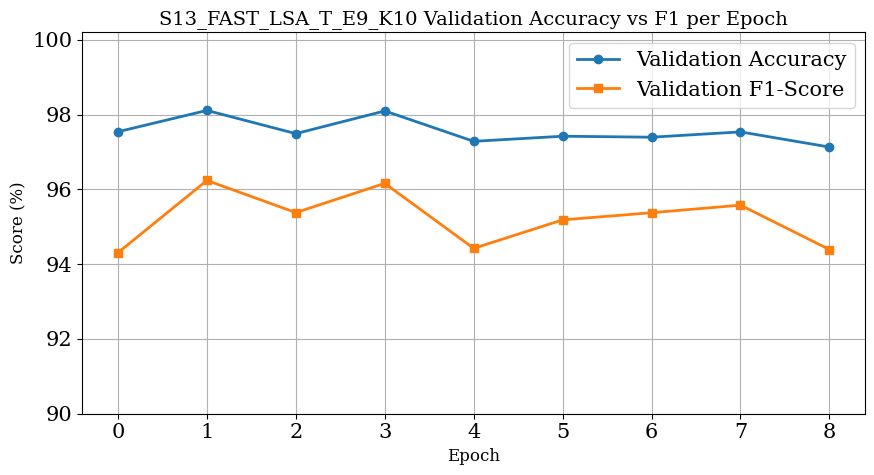

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(
    df_mean["epoch"],
    df_mean["val_acc"],
    marker="o",
    linewidth=2,
    label="Validation Accuracy"
)
plt.plot(
    df_mean["epoch"],
    df_mean["val_f1"],
    marker="s",
    linewidth=2,
    label="Validation F1-Score"
)

plt.title("S13_FAST_LSA_T_E9_K10 Validation Accuracy vs F1 per Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Score (%)", fontsize=12)
plt.ylim(90, 100.2)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import json
from pathlib import Path
from pyabsa import APCCheckpointManager


RESULTS_DIR = Path("/content/drive/MyDrive/Output_ABSA/results_skenario")
CHECKPOINT_DIR = Path("/content/drive/MyDrive/Output_ABSA/checkpoints_skenario")

results = []

for f in RESULTS_DIR.glob("*.json"):
    with open(f, "r") as fp:
        r = json.load(fp)

    results.append({
        "scenario": r["scenario"],
        "f1_score": r["f1_score"]
    })

best = sorted(results, key=lambda x: x["f1_score"], reverse=True)[0]
best_scenario = best["scenario"]

print("BEST SCENARIO :", best_scenario)

best_checkpoint_path = CHECKPOINT_DIR / best_scenario
assert best_checkpoint_path.exists(), "Checkpoint terbaik tidak ditemukan"

print("CHECKPOINT PATH:", best_checkpoint_path)


model = APCCheckpointManager.get_sentiment_classifier(
    checkpoint=str(best_checkpoint_path),
    auto_device=True
)

print("Model loaded from best checkpoint")

aspek_list = [
    "kebijakan dan pelayanan pemerintah",
    "kompetensi menteri",
    "fleksibilitas",
    "keterwakilan",
    "transparansi"
]

tweets_per_aspect = {
    "kebijakan dan pelayanan pemerintah": [
        "Program pemerintah kini sangat membantu rakyat kecil.",
        "Program pemerintah berjalan sesuai jadwal, tanpa keluhan maupun pujian.",
        "Pelayanan pemerintah sangat lambat dan tidak membantu masyarakat sama sekali."
    ],
    "kompetensi menteri": [
        "Menteri menunjukkan kemampuan luar biasa dalam menangani isu ini.",
        "Menteri menjalankan tugasnya sesuai prosedur.",
        "Menteri kurang kompeten dan sering membuat keputusan buruk."
    ],
    "fleksibilitas": [
        "Kebijakan pemerintah sangat fleksibel dan mudah disesuaikan.",
        "Aturan pemerintah cukup standar dan kadang kaku.",
        "Kebijakan pemerintah kaku dan sulit disesuaikan."
    ],
    "keterwakilan": [
        "Keputusan pemerintah mewakili kepentingan semua warga.",
        "Beberapa keputusan pemerintah cukup seimbang.",
        "Keputusan pemerintah hanya menguntungkan segelintir orang."
    ],
    "transparansi": [
        "Proses pemerintah sangat transparan dan jelas.",
        "Informasi pemerintah tersedia tetapi terbatas.",
        "Proses pemerintah penuh rahasia dan membingungkan."
    ]
}

hasil_prediksi = []

for aspek, tweets in tweets_per_aspect.items():
    for tweet in tweets:
        text_marked = tweet + f" [B-ASP]{aspek}[E-ASP]"

        pred_output = model.predict(
            text_marked,
            print_result=False
        )

        pred = pred_output[0] if isinstance(pred_output, list) else pred_output

        sentimen = pred["sentiment"]
        if isinstance(sentimen, list):
            sentimen = sentimen[0]

        confidence = pred.get("confidence")
        if isinstance(confidence, list):
            confidence = confidence[0]

        hasil_prediksi.append({
            "aspek": aspek,
            "tweet": tweet,
            "sentimen": sentimen,
            "confidence": confidence
        })

for h in hasil_prediksi:
    print(f"Aspek     : {h['aspek']}")
    print(f"Tweet     : {h['tweet']}")
    print(f"Sentimen  : {h['sentimen']}")
    print(f"Confidence: {h['confidence']:.4f}")
    print("-" * 60)

BEST SCENARIO : S13_FAST_LSA_T_E9_K10
CHECKPOINT PATH: /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10
[2026-01-04 00:48:52] (2.4.2) Load sentiment classifier from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0009199539199471474/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0007901195203885436/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.007240112870931625/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9

[2026-01-04 02:02:08] (2.4.2) Load sentiment classifier from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0046916864812374115/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0025463751517236233/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0033764601685106754/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0039036222733557224/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoi

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7ec74af131c0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7ec74af11b70>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7ec7497080c0>


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7ec749709080>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7ec749709240>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7ec7497091d0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7ec7497087c0>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7ec74970a900>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7ec7497090f0>


Best model loaded
[2026-01-04 02:02:47] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] $T$ sejumlah catatan muncul dari hasil pemilu mulai dari persoalan administrasi keterwakilan perempuan hingga yang paling anyar mengenai masalah transparansi dokumen pencalonan presiden dan wakil presiden


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


[2026-01-04 02:02:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] $T$ keterwakilan perempuan dalam proses rekrutmen anggota kpu dan bawaslu mesti dikawal di tiap tahapnya hal ini disampaikan oleh wakil koordinator aliansi maju perempuan indonesia mpi titi anggraini
[2026-01-04 02:02:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] $T$ seminar publik refleksi dan evaluasi keterwakilan perempuan di tahun politik reformasi menuju tahun tapi keterwakilan perempuan belum sampai ikut serta dengan para ahli dan legislator untuk mengevaluasi keterwakilan perempuan dalam politik senin maret
[2026-01-04 02:02:48] (2.4.2) Warning: reference sentiment does not exist or its number 0 is not equal to aspect number 1, text:  [B-ASP]Global Sentiment[E-ASP] $T$ dlm rangka dukung keterbukaan informasi publik penguatan 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



OVERALL RESULTS (BEST MODEL – S13)
Accuracy : 0.7400
Precision: 0.7454
Recall   : 0.7400
F1-Score : 0.7195

Classification Report:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


              precision    recall  f1-score   support

    Negative       0.83      0.45      0.59        11
     Neutral       0.67      0.44      0.53         9
    Positive       0.74      0.93      0.82        30

    accuracy                           0.74        50
   macro avg       0.75      0.61      0.65        50
weighted avg       0.75      0.74      0.72        50


PER-ASPECT RESULTS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Transparansi
Samples : 10
Accuracy: 0.6000
F1-Score: 0.4500


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Keterwakilan
Samples : 10
Accuracy: 0.7000
F1-Score: 0.7282


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Fleksibilitas
Samples : 10
Accuracy: 0.8000
F1-Score: 0.7529


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Kebijakan dan Pelayanan Pemerintah
Samples : 10
Accuracy: 0.9000
F1-Score: 0.8938


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Kompetensi Menteri
Samples : 10
Accuracy: 0.7000
F1-Score: 0.7067


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


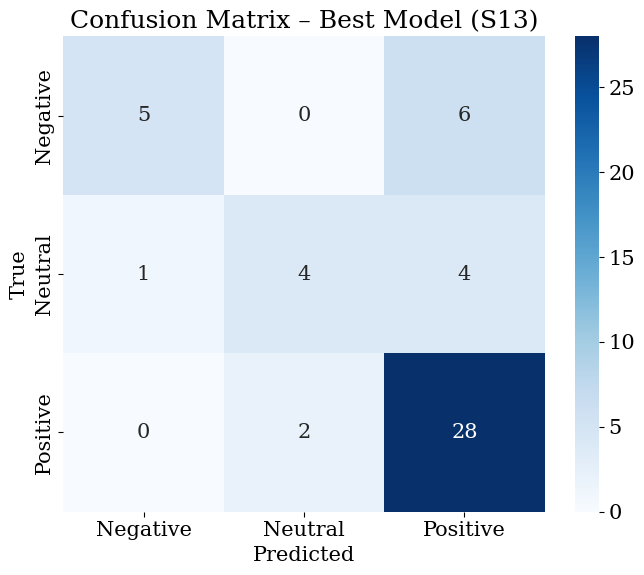

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyabsa import APCCheckpointManager
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

BEST_CHECKPOINT = (
    "/content/drive/MyDrive/Output_ABSA/checkpoints_skenario/"
    "S13_FAST_LSA_T_E9_K10"
)

model = APCCheckpointManager.get_sentiment_classifier(
    checkpoint=BEST_CHECKPOINT,
    auto_device=True
)

print("Best model loaded")


id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}

true_labels = []
pred_labels = []
aspects_list = []

for sample in final_test_data:
    text = sample["text"]
    aspect = sample["aspect"]
    true_sent = id2label[int(sample["sentiment"])]

    try:
        r = model.predict(text=text, aspect=aspect, print_result=False)
        if isinstance(r, list):
            r = r[0]
        pred_id = int(r["sentiment"][0]) if isinstance(r["sentiment"], list) else int(r["sentiment"])
        pred_sent = id2label[pred_id]
    except:
        pred_sent = "Neutral"

    true_labels.append(true_sent)
    pred_labels.append(pred_sent)
    aspects_list.append(aspect)

acc = accuracy_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels, average="weighted", zero_division=0)
rec = recall_score(true_labels, pred_labels, average="weighted", zero_division=0)
f1 = f1_score(true_labels, pred_labels, average="weighted", zero_division=0)

print("\nOVERALL RESULTS (BEST MODEL – S13)")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, zero_division=0))


print("\nPER-ASPECT RESULTS")
aspect_metrics = {}

for asp in set(aspects_list):
    idx = [i for i, a in enumerate(aspects_list) if a == asp]
    t = [true_labels[i] for i in idx]
    p = [pred_labels[i] for i in idx]

    aspect_metrics[asp] = {
        "samples": len(t),
        "accuracy": accuracy_score(t, p),
        "f1": f1_score(t, p, average="weighted", zero_division=0)
    }

    print(f"\n{asp}")
    print(f"Samples : {len(t)}")
    print(f"Accuracy: {aspect_metrics[asp]['accuracy']:.4f}")
    print(f"F1-Score: {aspect_metrics[asp]['f1']:.4f}")


cm = confusion_matrix(
    true_labels,
    pred_labels,
    labels=["Negative", "Neutral", "Positive"]
)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Neutral", "Positive"],
    yticklabels=["Negative", "Neutral", "Positive"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Best Model (S13)")
plt.tight_layout()
plt.show()

In [ ]:
import logging
import pandas as pd
import matplotlib.pyplot as plt
from pyabsa import APCCheckpointManager

logging.getLogger("pyabsa").setLevel(logging.ERROR)


checkpoint_path = (
    "/content/drive/MyDrive/Output_ABSA/checkpoints_skenario/"
    "S13_FAST_LSA_T_E9_K10"
)

model = APCCheckpointManager.get_sentiment_classifier(
    checkpoint=checkpoint_path,
    auto_device=True
)

print("Best model (S13) loaded.\n")

sentiment_map = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}

prediksi = []

for item in final_test_data:
    text = item["text"]
    aspect = item["aspect"]

    try:
        r = model.predict(text=text, aspect=aspect, print_result=False)
        if isinstance(r, list):
            r = r[0]

        sent = r["sentiment"]
        conf = r["confidence"]

        if isinstance(sent, list):
            sent = sent[0]
        if isinstance(conf, list):
            conf = conf[0]

        mapped_sent = sentiment_map.get(int(sent), "Neutral")

    except:
        mapped_sent = "Neutral"
        conf = 0.0

    prediksi.append({
        "aspect": aspect,
        "sentiment": mapped_sent,
        "confidence": float(conf)
    })

data_prediksi = {}
conf_total = {}

for p in prediksi:
    a = p["aspect"]
    s = p["sentiment"]
    c = p["confidence"]

    if a not in data_prediksi:
        data_prediksi[a] = {"Positive": 0, "Neutral": 0, "Negative": 0}
        conf_total[a] = {"Positive": 0.0, "Neutral": 0.0, "Negative": 0.0}

    data_prediksi[a][s] += 1
    conf_total[a][s] += c

final_result = {}

for a in data_prediksi:
    avg_conf = {}
    for s in data_prediksi[a]:
        count = data_prediksi[a][s]
        avg_conf[s] = conf_total[a][s] / count if count > 0 else 0

    max_count = max(data_prediksi[a].values())
    kandidat = [s for s, v in data_prediksi[a].items() if v == max_count]

    dominant = max(kandidat, key=lambda s: avg_conf[s]) if len(kandidat) > 1 else kandidat[0]

    final_result[a] = {
        "Dominant Sentiment": dominant,
        "Confidence": round(avg_conf[dominant], 3)
    }


df = pd.DataFrame([
    {
        "Aspect": a,
        "Dominant Sentiment": final_result[a]["Dominant Sentiment"],
        "Confidence": final_result[a]["Confidence"]
    }
    for a in final_result
])

output_excel = "/content/drive/MyDrive/Output_ABSA/hasil_sentiment_best_model.xlsx"
df.to_excel(output_excel, index=False)
print("XLSX saved:", output_excel)

plt.figure(figsize=(8, 5))
plt.bar(df["Aspect"], df["Confidence"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Confidence")
plt.title("Dominant Sentiment Confidence per Aspect (Best Model – S13)")
plt.tight_layout()

output_png = "/content/drive/MyDrive/Output_ABSA/grafik_confidence_best_model.png"
plt.savefig(output_png, dpi=300)
plt.close()

print("Graph saved:", output_png)

print("\n=== Dominant Sentiment per Aspek (Best Model) ===\n")
for a, h in final_result.items():
    print(f"{a:35} → {h['Dominant Sentiment']} (Conf: {h['Confidence']})")

[2026-01-04 02:05:57] (2.4.2) Load sentiment classifier from /content/drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10
FindFile Warning --> multiple targets ['drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0046916864812374115/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0025463751517236233/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0033764601685106754/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoints_skenario/S13_FAST_LSA_T_E9_K10/fast_lsa_t_custom_dataset_acc_100.0_f1_100.0/_0.0039036222733557224/fast_lsa_t.state_dict', 'drive/MyDrive/Output_ABSA/checkpoi